Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance

Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.7
Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201016_moa_sig_list.csv")
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [9]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
def calibration(y_pred, sampling_rate):
    return y_pred / (y_pred + (1 - y_pred) / sampling_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, Threshold):
    target = get_target(target_col, annot_sig)
    Sampling_rate = target.sum() / len(target)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=1, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test,max_iter=3, threshold=Threshold)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred_calib = calibration(y_pred, Sampling_rate)

        y_preds.append(y_pred_calib)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
def pseudo_labeling(X_train, y_train, X_test, max_iter=3, threshold=0.5):
       
    X = X_train.copy()
    y = y_train.copy()
    
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = []
        
        for fold_, (train_index, valid_index) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_index, :], X.loc[valid_index, :]
            y_tr, y_val = y[train_index], y[valid_index]
 
            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
            lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train,categorical_feature=categorical_cols)
        
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=100,
                              num_boost_round=Num_boost_round,
                              early_stopping_rounds=Early_stopping_rounds)
        
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
            #y_pred_calib = calibration(y_pred, sampling_rate)
            y_preds.append(y_pred)
            
        p_label = pd.Series(sum(y_preds) / len(y_preds))
        p_label = p_label.where(p_label < threshold, 1)
        p_label = p_label.where(p_label >= threshold, 0)
 
        X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
        y = pd.concat([y_train, p_label], axis=0, ignore_index=True)
        
    return X, y

In [15]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [16]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [17]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [18]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [19]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [20]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [21]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [22]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [23]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [24]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [25]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [27]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [28]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [29]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [30]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [31]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [32]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [33]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [34]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [35]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [36]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [37]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [38]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [39]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [40]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [41]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [42]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [43]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [44]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [45]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [46]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [47]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col, Threshold)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273811	valid_1's binary_logloss: 0.31545
[200]	training's binary_logloss: 0.124135	valid_1's binary_logloss: 0.173674
[300]	training's binary_logloss: 0.0605178	valid_1's binary_logloss: 0.105586
[400]	training's binary_logloss: 0.0308152	valid_1's binary_logloss: 0.0692178
[500]	training's binary_logloss: 0.0166214	valid_1's binary_logloss: 0.0499821
[600]	training's binary_logloss: 0.00963684	valid_1's binary_logloss: 0.0376057
[700]	training's binary_logloss: 0.00607697	valid_1's binary_logloss: 0.0308255
[800]	training's binary_logloss: 0.00419182	valid_1's binary_logloss: 0.0267341
[900]	training's binary_logloss: 0.00312787	valid_1's binary_logloss: 0.0245261
[1000]	training's binary_logloss: 0.00248438	valid_1's binary_logloss: 0.0230505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00248438	valid_1's binary_logloss: 0.0230505
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868556	valid_1's binary_logloss: 0.0985793
[200]	training's binary_logloss: 0.0347717	valid_1's binary_logloss: 0.0465081
[300]	training's binary_logloss: 0.0149225	valid_1's binary_logloss: 0.0252487
[400]	training's binary_logloss: 0.00677455	valid_1's binary_logloss: 0.0158889
[500]	training's binary_logloss: 0.00334045	valid_1's binary_logloss: 0.0115301
[600]	training's binary_logloss: 0.00183978	valid_1's binary_logloss: 0.00936499
[700]	training's binary_logloss: 0.00112743	valid_1's binary_logloss: 0.00838203
[800]	training's binary_logloss: 0.000765933	valid_1's binary_logloss: 0.00769989
[900]	training's binary_logloss: 0.000567705	valid_1's binary_logloss: 0.00720584
[1000]	training's binary_logloss: 0.000450216	valid_1's binary_logloss: 0.00683191
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000450216	valid_1's binary_logloss: 0.00683191
Tr

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868556	valid_1's binary_logloss: 0.0985793
[200]	training's binary_logloss: 0.0347717	valid_1's binary_logloss: 0.0465081
[300]	training's binary_logloss: 0.0149225	valid_1's binary_logloss: 0.0252487
[400]	training's binary_logloss: 0.00677455	valid_1's binary_logloss: 0.0158889
[500]	training's binary_logloss: 0.00334045	valid_1's binary_logloss: 0.0115301
[600]	training's binary_logloss: 0.00183978	valid_1's binary_logloss: 0.00936499
[700]	training's binary_logloss: 0.00112743	valid_1's binary_logloss: 0.00838203
[800]	training's binary_logloss: 0.000765933	valid_1's binary_logloss: 0.00769989
[900]	training's binary_logloss: 0.000567705	valid_1's binary_logloss: 0.00720584
[1000]	training's binary_logloss: 0.000450216	valid_1's binary_logloss: 0.00683191
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000450216	valid_1's binary_logloss: 0.00683191
Tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868556	valid_1's binary_logloss: 0.0985793
[200]	training's binary_logloss: 0.0347717	valid_1's binary_logloss: 0.0465081
[300]	training's binary_logloss: 0.0149225	valid_1's binary_logloss: 0.0252487
[400]	training's binary_logloss: 0.00677455	valid_1's binary_logloss: 0.0158889
[500]	training's binary_logloss: 0.00334045	valid_1's binary_logloss: 0.0115301
[600]	training's binary_logloss: 0.00183978	valid_1's binary_logloss: 0.00936499
[700]	training's binary_logloss: 0.00112743	valid_1's binary_logloss: 0.00838203
[800]	training's binary_logloss: 0.000765933	valid_1's binary_logloss: 0.00769989
[900]	training's binary_logloss: 0.000567705	valid_1's binary_logloss: 0.00720584
[1000]	training's binary_logloss: 0.000450216	valid_1's binary_logloss: 0.00683191
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000450216	valid_1's binary_logloss: 0.00683191


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08942	valid_1's binary_logloss: 0.0966002
[200]	training's binary_logloss: 0.0354565	valid_1's binary_logloss: 0.0429546
[300]	training's binary_logloss: 0.0149775	valid_1's binary_logloss: 0.0218927
[400]	training's binary_logloss: 0.00672286	valid_1's binary_logloss: 0.0129439
[500]	training's binary_logloss: 0.00328125	valid_1's binary_logloss: 0.00892532
[600]	training's binary_logloss: 0.00178095	valid_1's binary_logloss: 0.00695461
[700]	training's binary_logloss: 0.00109668	valid_1's binary_logloss: 0.00593052
[800]	training's binary_logloss: 0.000737923	valid_1's binary_logloss: 0.00523531
[900]	training's binary_logloss: 0.000551808	valid_1's binary_logloss: 0.00483287
[1000]	training's binary_logloss: 0.000433874	valid_1's binary_logloss: 0.00454209
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000433874	valid_1's binary_logloss: 0.00454209


5-alpha_reductase_inhibitor logloss: 0.005687001988253635
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283108	valid_1's binary_logloss: 0.326986
[200]	training's binary_logloss: 0.132306	valid_1's binary_logloss: 0.188921
[300]	training's binary_logloss: 0.0636922	valid_1's binary_logloss: 0.119206
[400]	training's binary_logloss: 0.0325891	valid_1's binary_logloss: 0.0820298
[500]	training's binary_logloss: 0.0176759	valid_1's binary_logloss: 0.0609797
[600]	training's binary_logloss: 0.0104001	valid_1's binary_logloss: 0.0484804
[700]	training's binary_logloss: 0.00663031	valid_1's binary_logloss: 0.0399941
[800]	training's binary_logloss: 0.00460753	valid_1's binary_logloss: 0.0341194
[900]	training's binary_logloss: 0.0034544	valid_1's binary_logloss: 0.0303164
[1000]	training's binary_logloss: 0.00275051	valid_1's binary_logloss: 0.0277964
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00275051	valid_1's binary_logloss: 0.0277964
Training until valida

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00255092	valid_1's binary_logloss: 0.0262302
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00255092	valid_1's binary_logloss: 0.0262302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933704	valid_1's binary_logloss: 0.107046
[200]	training's binary_logloss: 0.0387497	valid_1's binary_logloss: 0.0534863
[300]	training's binary_logloss: 0.017024	valid_1's binary_logloss: 0.0316374
[400]	training's binary_logloss: 0.00770648	valid_1's binary_logloss: 0.021374
[500]	training's binary_logloss: 0.00379855	valid_1's binary_logloss: 0.0165633
[600]	training's binary_logloss: 0.00204852	valid_1's binary_logloss: 0.0141528
[700]	training's binary_logloss: 0.00124657	valid_1's binary_logloss: 0.0126873
[800]	training's binary_logloss: 0.000848954	valid_1's binary_logloss: 0.0119279
[900]	training's binary_logloss: 0.000633331	valid_1's binary_logloss: 0.0115263
[1000]	traini

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904197	valid_1's binary_logloss: 0.104238
[200]	training's binary_logloss: 0.0376865	valid_1's binary_logloss: 0.0530553
[300]	training's binary_logloss: 0.0167119	valid_1's binary_logloss: 0.0322109
[400]	training's binary_logloss: 0.00757878	valid_1's binary_logloss: 0.022349
[500]	training's binary_logloss: 0.00365049	valid_1's binary_logloss: 0.0176863
[600]	training's binary_logloss: 0.001973	valid_1's binary_logloss: 0.0156746
[700]	training's binary_logloss: 0.00121428	valid_1's binary_logloss: 0.0145665
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.000991796	valid_1's binary_logloss: 0.0141284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923868	valid_1's binary_logloss: 0.100938
[200]	training's binary_logloss: 0.038027	valid_1's binary_logloss: 0.0479152
[300]	training's binary_logloss: 0.0166436	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904197	valid_1's binary_logloss: 0.104238
[200]	training's binary_logloss: 0.0376865	valid_1's binary_logloss: 0.0530553
[300]	training's binary_logloss: 0.0167119	valid_1's binary_logloss: 0.0322109
[400]	training's binary_logloss: 0.00757878	valid_1's binary_logloss: 0.022349
[500]	training's binary_logloss: 0.00365049	valid_1's binary_logloss: 0.0176863
[600]	training's binary_logloss: 0.001973	valid_1's binary_logloss: 0.0156746
[700]	training's binary_logloss: 0.00121428	valid_1's binary_logloss: 0.0145665


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[749]	training's binary_logloss: 0.000991796	valid_1's binary_logloss: 0.0141284


================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923868	valid_1's binary_logloss: 0.100938
[200]	training's binary_logloss: 0.038027	valid_1's binary_logloss: 0.0479152
[300]	training's binary_logloss: 0.0166436	valid_1's binary_logloss: 0.0269864
[400]	training's binary_logloss: 0.00768517	valid_1's binary_logloss: 0.0178624
[500]	training's binary_logloss: 0.00372579	valid_1's binary_logloss: 0.0137916
[600]	training's binary_logloss: 0.00200997	valid_1's binary_logloss: 0.0122108
[700]	training's binary_logloss: 0.00120528	valid_1's binary_logloss: 0.011021
[800]	training's binary_logloss: 0.000809763	valid_1's binary_logloss: 0.0100863
[900]	training's binary_logloss: 0.000598167	valid_1's binary_logloss: 0.00948003
[1000]	training's binary_logloss: 0.000477075	valid_1's binary_logloss: 0.00909487
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000477075	valid_1's binary_logloss: 0.00909487


11-beta-hsd1_inhibitor logloss: 0.011611643069519053
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291722	valid_1's binary_logloss: 0.338565
[200]	training's binary_logloss: 0.141812	valid_1's binary_logloss: 0.198805
[300]	training's binary_logloss: 0.0716816	valid_1's binary_logloss: 0.127857
[400]	training's binary_logloss: 0.0380479	valid_1's binary_logloss: 0.0891747
[500]	training's binary_logloss: 0.0213458	valid_1's binary_logloss: 0.0673462
[600]	training's binary_logloss: 0.0127388	valid_1's binary_logloss: 0.0553414
[700]	training's binary_logloss: 0.00815156	valid_1's binary_logloss: 0.0485784
[800]	training's binary_logloss: 0.0056401	valid_1's binary_logloss: 0.0436341
[900]	training's binary_logloss: 0.00418273	valid_1's binary_logloss: 0.040224
[1000]	training's binary_logloss: 0.00326006	valid_1's binary_logloss: 0.0376443
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00326006	valid_1's binary_logloss: 0.0376443
Training until validat

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936945	valid_1's binary_logloss: 0.101536
[200]	training's binary_logloss: 0.0386865	valid_1's binary_logloss: 0.0495357
[300]	training's binary_logloss: 0.017091	valid_1's binary_logloss: 0.0288312
[400]	training's binary_logloss: 0.00815404	valid_1's binary_logloss: 0.0195861
[500]	training's binary_logloss: 0.00413679	valid_1's binary_logloss: 0.0148116
[600]	training's binary_logloss: 0.00231636	valid_1's binary_logloss: 0.0123314
[700]	training's binary_logloss: 0.00142339	valid_1's binary_logloss: 0.0106543
[800]	training's binary_logloss: 0.000971414	valid_1's binary_logloss: 0.00969222
[900]	training's binary_logloss: 0.000717928	valid_1's binary_logloss: 0.00911192
[1000]	training's binary_logloss: 0.000568506	valid_1's binary_logloss: 0.00871703
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000568506	valid_1's binary_logloss: 0.00871703
Traini

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907196	valid_1's binary_logloss: 0.100693
[200]	training's binary_logloss: 0.036996	valid_1's binary_logloss: 0.0485886
[300]	training's binary_logloss: 0.0163041	valid_1's binary_logloss: 0.0283784
[400]	training's binary_logloss: 0.00763869	valid_1's binary_logloss: 0.0203015
[500]	training's binary_logloss: 0.00388166	valid_1's binary_logloss: 0.0160622
[600]	training's binary_logloss: 0.00216149	valid_1's binary_logloss: 0.0139137
[700]	training's binary_logloss: 0.00133344	valid_1's binary_logloss: 0.0123745
[800]	training's binary_logloss: 0.000908169	valid_1's binary_logloss: 0.0116514
[900]	training's binary_logloss: 0.000668865	valid_1's binary_logloss: 0.0111285
[1000]	training's binary_logloss: 0.000532009	valid_1's binary_logloss: 0.0105875
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000532009	valid_1's binary_logloss: 0.0105875
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907196	valid_1's binary_logloss: 0.100693
[200]	training's binary_logloss: 0.036996	valid_1's binary_logloss: 0.0485886
[300]	training's binary_logloss: 0.0163041	valid_1's binary_logloss: 0.0283784
[400]	training's binary_logloss: 0.00763869	valid_1's binary_logloss: 0.0203015
[500]	training's binary_logloss: 0.00388166	valid_1's binary_logloss: 0.0160622
[600]	training's binary_logloss: 0.00216149	valid_1's binary_logloss: 0.0139137
[700]	training's binary_logloss: 0.00133344	valid_1's binary_logloss: 0.0123745
[800]	training's binary_logloss: 0.000908169	valid_1's binary_logloss: 0.0116514
[900]	training's binary_logloss: 0.000668865	valid_1's binary_logloss: 0.0111285
[1000]	training's binary_logloss: 0.000532009	valid_1's binary_logloss: 0.0105875
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000532009	valid_1's binary_logloss: 0.0105875


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905765	valid_1's binary_logloss: 0.102816
[200]	training's binary_logloss: 0.0369987	valid_1's binary_logloss: 0.0516665
[300]	training's binary_logloss: 0.0163893	valid_1's binary_logloss: 0.0313729
[400]	training's binary_logloss: 0.00773289	valid_1's binary_logloss: 0.0214988
[500]	training's binary_logloss: 0.00390074	valid_1's binary_logloss: 0.0165624
[600]	training's binary_logloss: 0.00213644	valid_1's binary_logloss: 0.0138967
[700]	training's binary_logloss: 0.0013115	valid_1's binary_logloss: 0.0125099
[800]	training's binary_logloss: 0.000886537	valid_1's binary_logloss: 0.0114691
[900]	training's binary_logloss: 0.000656171	valid_1's binary_logloss: 0.0107218
[1000]	training's binary_logloss: 0.000524402	valid_1's binary_logloss: 0.0102266
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000524402	valid_1's binary_logloss: 0.0102266


acat_inhibitor logloss: 0.010407049546331464
acetylcholine_receptor_agonist , len(trt) : 196
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.439694	valid_1's binary_logloss: 0.608844
[200]	training's binary_logloss: 0.2986	valid_1's binary_logloss: 0.559823
[300]	training's binary_logloss: 0.211135	valid_1's binary_logloss: 0.532255
[400]	training's binary_logloss: 0.1512	valid_1's binary_logloss: 0.514386
[500]	training's binary_logloss: 0.109223	valid_1's binary_logloss: 0.502804
[600]	training's binary_logloss: 0.0799934	valid_1's binary_logloss: 0.4971
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.0791289	valid_1's binary_logloss: 0.496519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.430679	valid_1's binary_logloss: 0.618261
[200]	training's binary_logloss: 0.287371	valid_1's binary_logloss: 0.588036
[300]	training's binary_logloss: 0.19788	valid_1's binary_logloss: 0.565395
[400]	training's binary_logloss: 0.141257	valid_1's binary_logloss: 0.551077
E

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16582	valid_1's binary_logloss: 0.219832
[200]	training's binary_logloss: 0.102403	valid_1's binary_logloss: 0.184151
[300]	training's binary_logloss: 0.0688855	valid_1's binary_logloss: 0.169486
[400]	training's binary_logloss: 0.0456098	valid_1's binary_logloss: 0.160629
[500]	training's binary_logloss: 0.0302232	valid_1's binary_logloss: 0.155226
[600]	training's binary_logloss: 0.0205452	valid_1's binary_logloss: 0.15236
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.0155269	valid_1's binary_logloss: 0.150991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156016	valid_1's binary_logloss: 0.226103
[200]	training's binary_logloss: 0.0921446	valid_1's binary_logloss: 0.192211
[300]	training's binary_logloss: 0.0577323	valid_1's binary_logloss: 0.178497
[400]	training's binary_logloss: 0.0376227	valid_1's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[517]	training's binary_logloss: 0.0231872	valid_1's binary_logloss: 0.169444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136454	valid_1's binary_logloss: 0.201304
[200]	training's binary_logloss: 0.0822432	valid_1's binary_logloss: 0.171015
[300]	training's binary_logloss: 0.0546649	valid_1's binary_logloss: 0.160178
[400]	training's binary_logloss: 0.0368663	valid_1's binary_logloss: 0.155159
[500]	training's binary_logloss: 0.0244685	valid_1's binary_logloss: 0.152709
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.0199934	valid_1's binary_logloss: 0.151789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14371	valid_1's binary_logloss: 0.196547
[200]	training's binary_logloss: 0.0834335	valid_1's binary_logloss: 0.161709
[300]	training's binary_logloss: 0.0525938	valid_1's binary_logloss: 0.146423
[400]	training's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[522]	training's binary_logloss: 0.0215286	valid_1's binary_logloss: 0.135195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138555	valid_1's binary_logloss: 0.19377
[200]	training's binary_logloss: 0.0830476	valid_1's binary_logloss: 0.158889
[300]	training's binary_logloss: 0.0559214	valid_1's binary_logloss: 0.14654
[400]	training's binary_logloss: 0.038323	valid_1's binary_logloss: 0.140787
[500]	training's binary_logloss: 0.0246216	valid_1's binary_logloss: 0.137796
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.0183991	valid_1's binary_logloss: 0.136746


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141539	valid_1's binary_logloss: 0.197515
[200]	training's binary_logloss: 0.0853559	valid_1's binary_logloss: 0.162169
[300]	training's binary_logloss: 0.0564116	valid_1's binary_logloss: 0.146891
[400]	training's binary_logloss: 0.0383626	valid_1's binary_logloss: 0.139975
[500]	training's binary_logloss: 0.0253892	valid_1's binary_logloss: 0.136393


acetylcholine_receptor_agonist logloss: 0.13634038189026396


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0228569	valid_1's binary_logloss: 0.135935


acetylcholine_receptor_antagonist , len(trt) : 307
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.451108	valid_1's binary_logloss: 0.664595
[200]	training's binary_logloss: 0.315578	valid_1's binary_logloss: 0.651592
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.297601	valid_1's binary_logloss: 0.649768
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.577139	valid_1's binary_logloss: 0.681555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138708	valid_1's binary_logloss: 0.200064
[200]	training's binary_logloss: 0.0863572	valid_1's binary_logloss: 0.173871
[300]	training's binary_logloss: 0.0594525	valid_1's binary_logloss: 0.166227
[400]	training's binary_logloss: 0.0409816	valid_1's binary_logloss: 0.163455
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0419776	valid_1's binary_logloss: 0.163426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144696	valid_1's binary_logloss: 0.202271
[200]	training's binary_logloss: 0.0932619	valid_1's binary_logloss: 0.174019
[300]	training's binary_logloss: 0.0654308	valid_1's binary_logloss: 0.164891
[400]	training's binary_logloss: 0.0460589	valid_1's binary_logloss: 0.161478
Early stopping, best iteration i

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138708	valid_1's binary_logloss: 0.200064
[200]	training's binary_logloss: 0.0863572	valid_1's binary_logloss: 0.173871
[300]	training's binary_logloss: 0.0594525	valid_1's binary_logloss: 0.166227
[400]	training's binary_logloss: 0.0409816	valid_1's binary_logloss: 0.163455
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0419776	valid_1's binary_logloss: 0.163426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144696	valid_1's binary_logloss: 0.202271
[200]	training's binary_logloss: 0.0932619	valid_1's binary_logloss: 0.174019
[300]	training's binary_logloss: 0.0654308	valid_1's binary_logloss: 0.164891
[400]	training's binary_logloss: 0.0460589	valid_1's binary_logloss: 0.161478
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.045399	valid_1's binary_logloss: 0.161432


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138708	valid_1's binary_logloss: 0.200064
[200]	training's binary_logloss: 0.0863572	valid_1's binary_logloss: 0.173871
[300]	training's binary_logloss: 0.0594525	valid_1's binary_logloss: 0.166227


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


[400]	training's binary_logloss: 0.0409816	valid_1's binary_logloss: 0.163455
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0419776	valid_1's binary_logloss: 0.163426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144696	valid_1's binary_logloss: 0.202271
[200]	training's binary_logloss: 0.0932619	valid_1's binary_logloss: 0.174019
[300]	training's binary_logloss: 0.0654308	valid_1's binary_logloss: 0.164891
[400]	training's binary_logloss: 0.0460589	valid_1's binary_logloss: 0.161478
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.045399	valid_1's binary_logloss: 0.161432


acetylcholine_receptor_antagonist logloss: 0.16242936643914707
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.380362	valid_1's binary_logloss: 0.491146
[200]	training's binary_logloss: 0.227721	valid_1's binary_logloss: 0.376395
[300]	training's binary_logloss: 0.141799	valid_1's binary_logloss: 0.307547
[400]	training's binary_logloss: 0.09072	valid_1's binary_logloss: 0.261972
[500]	training's binary_logloss: 0.0592848	valid_1's binary_logloss: 0.230432
[600]	training's binary_logloss: 0.0396203	valid_1's binary_logloss: 0.208817
[700]	training's binary_logloss: 0.0270229	valid_1's binary_logloss: 0.192177
[800]	training's binary_logloss: 0.0190266	valid_1's binary_logloss: 0.178987
[900]	training's binary_logloss: 0.0139456	valid_1's binary_logloss: 0.171153
[1000]	training's binary_logloss: 0.0106407	valid_1's binary_logloss: 0.165632
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0106407	valid_1's binary_logloss: 0.165632
Training until validation scores don

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136663	valid_1's binary_logloss: 0.192952
[200]	training's binary_logloss: 0.0701027	valid_1's binary_logloss: 0.148076
[300]	training's binary_logloss: 0.0390784	valid_1's binary_logloss: 0.12627
[400]	training's binary_logloss: 0.0224781	valid_1's binary_logloss: 0.114469
[500]	training's binary_logloss: 0.0135198	valid_1's binary_logloss: 0.108232
[600]	training's binary_logloss: 0.0085472	valid_1's binary_logloss: 0.105735
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00603495	valid_1's binary_logloss: 0.10481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140148	valid_1's binary_logloss: 0.180063
[200]	training's binary_logloss: 0.0739048	valid_1's binary_logloss: 0.131471
[300]	training's binary_logloss: 0.041743	valid_1's binary_logloss: 0.108935
[400]	training's binary_logloss: 0.0248192	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118119	valid_1's binary_logloss: 0.14607
[200]	training's binary_logloss: 0.0620731	valid_1's binary_logloss: 0.0979059
[300]	training's binary_logloss: 0.0351932	valid_1's binary_logloss: 0.074804
[400]	training's binary_logloss: 0.0205955	valid_1's binary_logloss: 0.0613666
[500]	training's binary_logloss: 0.011984	valid_1's binary_logloss: 0.0529453
[600]	training's binary_logloss: 0.00724594	valid_1's binary_logloss: 0.0484112
[700]	training's binary_logloss: 0.00455353	valid_1's binary_logloss: 0.0449688
[800]	training's binary_logloss: 0.00305101	valid_1's binary_logloss: 0.0426892
[900]	training's binary_logloss: 0.00216866	valid_1's binary_logloss: 0.0411356
[1000]	training's binary_logloss: 0.00162947	valid_1's binary_logloss: 0.0399305
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00162947	valid_1's binary_logloss: 0.0399305
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11805	valid_1's binary_logloss: 0.144166
[200]	training's binary_logloss: 0.0616556	valid_1's binary_logloss: 0.0952447
[300]	training's binary_logloss: 0.0352657	valid_1's binary_logloss: 0.0720118
[400]	training's binary_logloss: 0.0205239	valid_1's binary_logloss: 0.0570312
[500]	training's binary_logloss: 0.0119887	valid_1's binary_logloss: 0.0478794
[600]	training's binary_logloss: 0.00731137	valid_1's binary_logloss: 0.0420493
[700]	training's binary_logloss: 0.00461831	valid_1's binary_logloss: 0.0375962
[800]	training's binary_logloss: 0.00309067	valid_1's binary_logloss: 0.0347141
[900]	training's binary_logloss: 0.00219292	valid_1's binary_logloss: 0.0326631
[1000]	training's binary_logloss: 0.00165122	valid_1's binary_logloss: 0.03137
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00165122	valid_1's binary_logloss: 0.03137


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118828	valid_1's binary_logloss: 0.150068
[200]	training's binary_logloss: 0.0636453	valid_1's binary_logloss: 0.101053
[300]	training's binary_logloss: 0.0370598	valid_1's binary_logloss: 0.0774257
[400]	training's binary_logloss: 0.0222808	valid_1's binary_logloss: 0.0640126
[500]	training's binary_logloss: 0.0129122	valid_1's binary_logloss: 0.055273
[600]	training's binary_logloss: 0.00778487	valid_1's binary_logloss: 0.0504669
[700]	training's binary_logloss: 0.0048092	valid_1's binary_logloss: 0.0471448
[800]	training's binary_logloss: 0.00314347	valid_1's binary_logloss: 0.0445448
[900]	training's binary_logloss: 0.00219497	valid_1's binary_logloss: 0.0428388
[1000]	training's binary_logloss: 0.00163569	valid_1's binary_logloss: 0.0414823
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00163569	valid_1's binary_logloss: 0.0414823


acetylcholinesterase_inhibitor logloss: 0.03642611911800032
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.361022	valid_1's binary_logloss: 0.473926
[200]	training's binary_logloss: 0.207677	valid_1's binary_logloss: 0.365249
[300]	training's binary_logloss: 0.124331	valid_1's binary_logloss: 0.301177
[400]	training's binary_logloss: 0.0765588	valid_1's binary_logloss: 0.259784
[500]	training's binary_logloss: 0.0483882	valid_1's binary_logloss: 0.23287
[600]	training's binary_logloss: 0.0312625	valid_1's binary_logloss: 0.215952
[700]	training's binary_logloss: 0.0209454	valid_1's binary_logloss: 0.202238
[800]	training's binary_logloss: 0.0146829	valid_1's binary_logloss: 0.19337
[900]	training's binary_logloss: 0.0107065	valid_1's binary_logloss: 0.188715
[1000]	training's binary_logloss: 0.00821661	valid_1's binary_logloss: 0.183735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00821661	valid_1's binary_logloss: 0.183735
Training until validation scores d

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118315	valid_1's binary_logloss: 0.148905
[200]	training's binary_logloss: 0.0591626	valid_1's binary_logloss: 0.0993942
[300]	training's binary_logloss: 0.032107	valid_1's binary_logloss: 0.0725354
[400]	training's binary_logloss: 0.0177861	valid_1's binary_logloss: 0.0571119
[500]	training's binary_logloss: 0.0100878	valid_1's binary_logloss: 0.047359
[600]	training's binary_logloss: 0.00600037	valid_1's binary_logloss: 0.0415495
[700]	training's binary_logloss: 0.0037471	valid_1's binary_logloss: 0.0371444
[800]	training's binary_logloss: 0.00249689	valid_1's binary_logloss: 0.0344318
[900]	training's binary_logloss: 0.00178138	valid_1's binary_logloss: 0.0327052
[1000]	training's binary_logloss: 0.00134806	valid_1's binary_logloss: 0.0312351
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00134806	valid_1's binary_logloss: 0.0312351
Training until vali

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114004	valid_1's binary_logloss: 0.14375
[200]	training's binary_logloss: 0.0563457	valid_1's binary_logloss: 0.0967722
[300]	training's binary_logloss: 0.0303232	valid_1's binary_logloss: 0.0741002
[400]	training's binary_logloss: 0.0168193	valid_1's binary_logloss: 0.0618407
[500]	training's binary_logloss: 0.0096802	valid_1's binary_logloss: 0.05508
[600]	training's binary_logloss: 0.00575991	valid_1's binary_logloss: 0.050066
[700]	training's binary_logloss: 0.00363237	valid_1's binary_logloss: 0.0465703
[800]	training's binary_logloss: 0.00242641	valid_1's binary_logloss: 0.0440514
[900]	training's binary_logloss: 0.00171685	valid_1's binary_logloss: 0.0422013
[1000]	training's binary_logloss: 0.00130269	valid_1's binary_logloss: 0.040732
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00130269	valid_1's binary_logloss: 0.040732
Training until validat

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114004	valid_1's binary_logloss: 0.14375
[200]	training's binary_logloss: 0.0563457	valid_1's binary_logloss: 0.0967722
[300]	training's binary_logloss: 0.0303232	valid_1's binary_logloss: 0.0741002
[400]	training's binary_logloss: 0.0168193	valid_1's binary_logloss: 0.0618407
[500]	training's binary_logloss: 0.0096802	valid_1's binary_logloss: 0.05508
[600]	training's binary_logloss: 0.00575991	valid_1's binary_logloss: 0.050066
[700]	training's binary_logloss: 0.00363237	valid_1's binary_logloss: 0.0465703
[800]	training's binary_logloss: 0.00242641	valid_1's binary_logloss: 0.0440514
[900]	training's binary_logloss: 0.00171685	valid_1's binary_logloss: 0.0422013
[1000]	training's binary_logloss: 0.00130269	valid_1's binary_logloss: 0.040732
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00130269	valid_1's binary_logloss: 0.040732


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113107	valid_1's binary_logloss: 0.140018
[200]	training's binary_logloss: 0.0572744	valid_1's binary_logloss: 0.0901877
[300]	training's binary_logloss: 0.030752	valid_1's binary_logloss: 0.064367
[400]	training's binary_logloss: 0.0168656	valid_1's binary_logloss: 0.0483699
[500]	training's binary_logloss: 0.00955167	valid_1's binary_logloss: 0.038564
[600]	training's binary_logloss: 0.00559657	valid_1's binary_logloss: 0.0321401
[700]	training's binary_logloss: 0.00350093	valid_1's binary_logloss: 0.0281067
[800]	training's binary_logloss: 0.00231489	valid_1's binary_logloss: 0.0255581
[900]	training's binary_logloss: 0.00165561	valid_1's binary_logloss: 0.0241198
[1000]	training's binary_logloss: 0.00126405	valid_1's binary_logloss: 0.0230002
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00126405	valid_1's binary_logloss: 0.0230002


adenosine_receptor_agonist logloss: 0.03186609964827077
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39311	valid_1's binary_logloss: 0.519016
[200]	training's binary_logloss: 0.248053	valid_1's binary_logloss: 0.436929
[300]	training's binary_logloss: 0.160038	valid_1's binary_logloss: 0.383046
[400]	training's binary_logloss: 0.105497	valid_1's binary_logloss: 0.343591
[500]	training's binary_logloss: 0.071796	valid_1's binary_logloss: 0.320086
[600]	training's binary_logloss: 0.0494251	valid_1's binary_logloss: 0.299725
[700]	training's binary_logloss: 0.0347984	valid_1's binary_logloss: 0.284151
[800]	training's binary_logloss: 0.0251661	valid_1's binary_logloss: 0.273944
[900]	training's binary_logloss: 0.0186043	valid_1's binary_logloss: 0.266884
[1000]	training's binary_logloss: 0.014205	valid_1's binary_logloss: 0.261568
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.014205	valid_1's binary_logloss: 0.261568
Training until validation scores don't 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144203	valid_1's binary_logloss: 0.188393
[200]	training's binary_logloss: 0.0789467	valid_1's binary_logloss: 0.146486
[300]	training's binary_logloss: 0.0457865	valid_1's binary_logloss: 0.125197
[400]	training's binary_logloss: 0.0270007	valid_1's binary_logloss: 0.112812
[500]	training's binary_logloss: 0.0162152	valid_1's binary_logloss: 0.104419
[600]	training's binary_logloss: 0.0101581	valid_1's binary_logloss: 0.0998774
[700]	training's binary_logloss: 0.00662958	valid_1's binary_logloss: 0.0980615
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.00537669	valid_1's binary_logloss: 0.0974525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144917	valid_1's binary_logloss: 0.184906
[200]	training's binary_logloss: 0.0780871	valid_1's binary_logloss: 0.139488
[300]	training's binary_logloss: 0.0440312	valid_1's binary_

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119669	valid_1's binary_logloss: 0.148052
[200]	training's binary_logloss: 0.0641261	valid_1's binary_logloss: 0.102904
[300]	training's binary_logloss: 0.0372849	valid_1's binary_logloss: 0.0820066
[400]	training's binary_logloss: 0.0227335	valid_1's binary_logloss: 0.0710897
[500]	training's binary_logloss: 0.0137933	valid_1's binary_logloss: 0.0636884
[600]	training's binary_logloss: 0.00858781	valid_1's binary_logloss: 0.0594353
[700]	training's binary_logloss: 0.00547133	valid_1's binary_logloss: 0.0567583
[800]	training's binary_logloss: 0.00364367	valid_1's binary_logloss: 0.0552169
[900]	training's binary_logloss: 0.00256531	valid_1's binary_logloss: 0.0540557
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.00201384	valid_1's binary_logloss: 0.0533856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121707	valid_1's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119669	valid_1's binary_logloss: 0.148052
[200]	training's binary_logloss: 0.0641261	valid_1's binary_logloss: 0.102904
[300]	training's binary_logloss: 0.0372849	valid_1's binary_logloss: 0.0820066
[400]	training's binary_logloss: 0.0227335	valid_1's binary_logloss: 0.0710897
[500]	training's binary_logloss: 0.0137933	valid_1's binary_logloss: 0.0636884
[600]	training's binary_logloss: 0.00858781	valid_1's binary_logloss: 0.0594353
[700]	training's binary_logloss: 0.00547133	valid_1's binary_logloss: 0.0567583
[800]	training's binary_logloss: 0.00364367	valid_1's binary_logloss: 0.0552169
[900]	training's binary_logloss: 0.00256531	valid_1's binary_logloss: 0.0540557
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.00201384	valid_1's binary_logloss: 0.0533856


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121707	valid_1's binary_logloss: 0.153102
[200]	training's binary_logloss: 0.0674468	valid_1's binary_logloss: 0.109344
[300]	training's binary_logloss: 0.0399238	valid_1's binary_logloss: 0.0886988
[400]	training's binary_logloss: 0.0244863	valid_1's binary_logloss: 0.077194
[500]	training's binary_logloss: 0.014994	valid_1's binary_logloss: 0.0695781
[600]	training's binary_logloss: 0.00921765	valid_1's binary_logloss: 0.0642112
[700]	training's binary_logloss: 0.00573423	valid_1's binary_logloss: 0.0594875
[800]	training's binary_logloss: 0.00376662	valid_1's binary_logloss: 0.0562857
[900]	training's binary_logloss: 0.00261968	valid_1's binary_logloss: 0.0541544
[1000]	training's binary_logloss: 0.00193699	valid_1's binary_logloss: 0.0524683
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193699	valid_1's binary_logloss: 0.0524683


adenosine_receptor_antagonist logloss: 0.052926965364733056
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282765	valid_1's binary_logloss: 0.329763
[200]	training's binary_logloss: 0.131609	valid_1's binary_logloss: 0.187428
[300]	training's binary_logloss: 0.0646297	valid_1's binary_logloss: 0.116122
[400]	training's binary_logloss: 0.0329076	valid_1's binary_logloss: 0.0775494
[500]	training's binary_logloss: 0.0180032	valid_1's binary_logloss: 0.058511
[600]	training's binary_logloss: 0.0106088	valid_1's binary_logloss: 0.0477429
[700]	training's binary_logloss: 0.00680279	valid_1's binary_logloss: 0.0416599
[800]	training's binary_logloss: 0.00473739	valid_1's binary_logloss: 0.0375814
[900]	training's binary_logloss: 0.003531	valid_1's binary_logloss: 0.0353356
[1000]	training's binary_logloss: 0.00279528	valid_1's binary_logloss: 0.0339609
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00279528	valid_1's binary_logloss: 0.0339609
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100841	valid_1's binary_logloss: 0.120221
[200]	training's binary_logloss: 0.0418223	valid_1's binary_logloss: 0.0662388
[300]	training's binary_logloss: 0.0181055	valid_1's binary_logloss: 0.0434911
[400]	training's binary_logloss: 0.00852724	valid_1's binary_logloss: 0.0331276
[500]	training's binary_logloss: 0.00436965	valid_1's binary_logloss: 0.0289247
[600]	training's binary_logloss: 0.00246004	valid_1's binary_logloss: 0.0271139
[700]	training's binary_logloss: 0.00152863	valid_1's binary_logloss: 0.0266264
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00159645	valid_1's binary_logloss: 0.0266213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100924	valid_1's binary_logloss: 0.114125
[200]	training's binary_logloss: 0.0416599	valid_1's binary_logloss: 0.0602554
[300]	training's binary_logloss: 0.0183967	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918012	valid_1's binary_logloss: 0.101845
[200]	training's binary_logloss: 0.0369467	valid_1's binary_logloss: 0.0467751
[300]	training's binary_logloss: 0.0162141	valid_1's binary_logloss: 0.0258662
[400]	training's binary_logloss: 0.00748844	valid_1's binary_logloss: 0.0165078
[500]	training's binary_logloss: 0.003733	valid_1's binary_logloss: 0.0119372
[600]	training's binary_logloss: 0.00206623	valid_1's binary_logloss: 0.00970535
[700]	training's binary_logloss: 0.00126456	valid_1's binary_logloss: 0.00812637
[800]	training's binary_logloss: 0.000858208	valid_1's binary_logloss: 0.00705709
[900]	training's binary_logloss: 0.00064071	valid_1's binary_logloss: 0.00663135
[1000]	training's binary_logloss: 0.000513654	valid_1's binary_logloss: 0.00632879
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000513654	valid_1's binary_logloss: 0.00632879
Traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890661	valid_1's binary_logloss: 0.100886
[200]	training's binary_logloss: 0.0350895	valid_1's binary_logloss: 0.0470711
[300]	training's binary_logloss: 0.0151504	valid_1's binary_logloss: 0.0262898
[400]	training's binary_logloss: 0.00693895	valid_1's binary_logloss: 0.0172469
[500]	training's binary_logloss: 0.00345162	valid_1's binary_logloss: 0.0127369
[600]	training's binary_logloss: 0.00190081	valid_1's binary_logloss: 0.0103869
[700]	training's binary_logloss: 0.00118052	valid_1's binary_logloss: 0.00926475
[800]	training's binary_logloss: 0.000801822	valid_1's binary_logloss: 0.00847826
[900]	training's binary_logloss: 0.00059881	valid_1's binary_logloss: 0.00780153
[1000]	training's binary_logloss: 0.000477368	valid_1's binary_logloss: 0.00745852
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000477368	valid_1's binary_logloss: 0.00745852


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889837	valid_1's binary_logloss: 0.097495
[200]	training's binary_logloss: 0.0369404	valid_1's binary_logloss: 0.045085
[300]	training's binary_logloss: 0.0163276	valid_1's binary_logloss: 0.0233818
[400]	training's binary_logloss: 0.0075852	valid_1's binary_logloss: 0.0138556
[500]	training's binary_logloss: 0.00378945	valid_1's binary_logloss: 0.00925702
[600]	training's binary_logloss: 0.0020875	valid_1's binary_logloss: 0.00687749
[700]	training's binary_logloss: 0.00128334	valid_1's binary_logloss: 0.00544974
[800]	training's binary_logloss: 0.000873651	valid_1's binary_logloss: 0.0046056
[900]	training's binary_logloss: 0.000650086	valid_1's binary_logloss: 0.00410969
[1000]	training's binary_logloss: 0.000515569	valid_1's binary_logloss: 0.00375342
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000515569	valid_1's binary_logloss: 0.00375342


adenylyl_cyclase_activator logloss: 0.0056059685059161824
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.449126	valid_1's binary_logloss: 0.653271
[200]	training's binary_logloss: 0.312596	valid_1's binary_logloss: 0.630143
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.238079	valid_1's binary_logloss: 0.618563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.458809	valid_1's binary_logloss: 0.654481
[200]	training's binary_logloss: 0.318823	valid_1's binary_logloss: 0.637086
[300]	training's binary_logloss: 0.227574	valid_1's binary_logloss: 0.627247


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.163339	valid_1's binary_logloss: 0.621146
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.167131	valid_1's binary_logloss: 0.620405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179334	valid_1's binary_logloss: 0.249936
[200]	training's binary_logloss: 0.112619	valid_1's binary_logloss: 0.223278
[300]	training's binary_logloss: 0.0733916	valid_1's binary_logloss: 0.211009
[400]	training's binary_logloss: 0.0479518	valid_1's binary_logloss: 0.205264
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0376122	valid_1's binary_logloss: 0.203273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173385	valid_1's binary_logloss: 0.240662
[200]	training's binary_logloss: 0.104494	valid_1's binary_logloss: 0.209467
[300]	training's binary_logloss: 0.0662692	valid_1's binary_logloss: 0.197648
[400]	training's binary_logloss: 0

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.03283	valid_1's binary_logloss: 0.191013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140557	valid_1's binary_logloss: 0.199994
[200]	training's binary_logloss: 0.0859403	valid_1's binary_logloss: 0.168944
[300]	training's binary_logloss: 0.056073	valid_1's binary_logloss: 0.156433
[400]	training's binary_logloss: 0.0367677	valid_1's binary_logloss: 0.151459
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.0326184	valid_1's binary_logloss: 0.150835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144403	valid_1's binary_logloss: 0.195332
[200]	training's binary_logloss: 0.0895228	valid_1's binary_logloss: 0.16323
[300]	training's binary_logloss: 0.0618875	valid_1's binary_logloss: 0.150323
[400]	training's binary_logloss: 0.0430146	valid_1's binary_logloss: 0.144514
[500]	training's binary_logloss: 0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140557	valid_1's binary_logloss: 0.199994
[200]	training's binary_logloss: 0.0859403	valid_1's binary_logloss: 0.168944
[300]	training's binary_logloss: 0.056073	valid_1's binary_logloss: 0.156433
[400]	training's binary_logloss: 0.0367677	valid_1's binary_logloss: 0.151459


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[429]	training's binary_logloss: 0.0326184	valid_1's binary_logloss: 0.150835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144403	valid_1's binary_logloss: 0.195332
[200]	training's binary_logloss: 0.0895228	valid_1's binary_logloss: 0.16323
[300]	training's binary_logloss: 0.0618875	valid_1's binary_logloss: 0.150323
[400]	training's binary_logloss: 0.0430146	valid_1's binary_logloss: 0.144514
[500]	training's binary_logloss: 0.0285424	valid_1's binary_logloss: 0.141115
[600]	training's binary_logloss: 0.0186919	valid_1's binary_logloss: 0.138974
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.015863	valid_1's binary_logloss: 0.138411


adrenergic_receptor_agonist logloss: 0.14462313195763135
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450309	valid_1's binary_logloss: 0.66861
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.357783	valid_1's binary_logloss: 0.66289
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.450693	valid_1's binary_logloss: 0.671449
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.429768	valid_1's binary_logloss: 0.670195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150534	valid_1's binary_logloss: 0.210836
[200]	training's binary_logloss: 0.100056	valid_1's binary_logloss: 0.186357
[300]	training's binary_logloss: 0.0694427	valid_1's binary_logloss: 0.177849
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0548349	valid_1's binary_logloss: 0.176335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14402	valid_1's binary_logloss: 0.210287
[200]	training's binary_logloss: 0.09019	valid_1's binary_logloss: 0.1843
[300]	training's binary_logloss: 0.0602801	valid_1's binary_logloss: 0.175028


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0522074	valid_1's binary_logloss: 0.173417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146461	valid_1's binary_logloss: 0.210039
[200]	training's binary_logloss: 0.0929944	valid_1's binary_logloss: 0.184915
[300]	training's binary_logloss: 0.0644112	valid_1's binary_logloss: 0.176838
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0509662	valid_1's binary_logloss: 0.175271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1417	valid_1's binary_logloss: 0.210775
[200]	training's binary_logloss: 0.0868603	valid_1's binary_logloss: 0.183928
[300]	training's binary_logloss: 0.0595618	valid_1's binary_logloss: 0.174667
[400]	training's binary_logloss: 0.0417584	valid_1's binary_logloss: 0.169784


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0370022	valid_1's binary_logloss: 0.169208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146461	valid_1's binary_logloss: 0.210039
[200]	training's binary_logloss: 0.0929944	valid_1's binary_logloss: 0.184915
[300]	training's binary_logloss: 0.0644112	valid_1's binary_logloss: 0.176838


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0509662	valid_1's binary_logloss: 0.175271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1417	valid_1's binary_logloss: 0.210775
[200]	training's binary_logloss: 0.0868603	valid_1's binary_logloss: 0.183928
[300]	training's binary_logloss: 0.0595618	valid_1's binary_logloss: 0.174667
[400]	training's binary_logloss: 0.0417584	valid_1's binary_logloss: 0.169784


adrenergic_receptor_antagonist logloss: 0.17223968384018254
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0370022	valid_1's binary_logloss: 0.169208


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.360781	valid_1's binary_logloss: 0.464364
[200]	training's binary_logloss: 0.208452	valid_1's binary_logloss: 0.350011
[300]	training's binary_logloss: 0.123805	valid_1's binary_logloss: 0.276095
[400]	training's binary_logloss: 0.0763225	valid_1's binary_logloss: 0.227595
[500]	training's binary_logloss: 0.0487027	valid_1's binary_logloss: 0.196204
[600]	training's binary_logloss: 0.0319851	valid_1's binary_logloss: 0.177561
[700]	training's binary_logloss: 0.0217766	valid_1's binary_logloss: 0.16359
[800]	training's binary_logloss: 0.0153788	valid_1's binary_logloss: 0.154337
[900]	training's binary_logloss: 0.0113011	valid_1's binary_logloss: 0.14668
[1000]	training's binary_logloss: 0.00870783	valid_1's binary_logloss: 0.14156
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00870783	valid_1's binary_logloss: 0.14156
Training until validation scores don

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138341	valid_1's binary_logloss: 0.184286
[200]	training's binary_logloss: 0.0718095	valid_1's binary_logloss: 0.140875
[300]	training's binary_logloss: 0.038926	valid_1's binary_logloss: 0.118014
[400]	training's binary_logloss: 0.0217212	valid_1's binary_logloss: 0.10697
[500]	training's binary_logloss: 0.0124547	valid_1's binary_logloss: 0.10116
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00941469	valid_1's binary_logloss: 0.100036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139235	valid_1's binary_logloss: 0.174899
[200]	training's binary_logloss: 0.0712117	valid_1's binary_logloss: 0.124609
[300]	training's binary_logloss: 0.0386045	valid_1's binary_logloss: 0.101141
[400]	training's binary_logloss: 0.0219912	valid_1's binary_logloss: 0.0894766
[500]	training's binary_logloss: 0.013046	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114369	valid_1's binary_logloss: 0.143599
[200]	training's binary_logloss: 0.0585777	valid_1's binary_logloss: 0.0942118
[300]	training's binary_logloss: 0.03392	valid_1's binary_logloss: 0.072238
[400]	training's binary_logloss: 0.0204511	valid_1's binary_logloss: 0.0592175
[500]	training's binary_logloss: 0.012008	valid_1's binary_logloss: 0.0507155
[600]	training's binary_logloss: 0.00696998	valid_1's binary_logloss: 0.0447585
[700]	training's binary_logloss: 0.00426247	valid_1's binary_logloss: 0.040796
[800]	training's binary_logloss: 0.00281601	valid_1's binary_logloss: 0.0381691
[900]	training's binary_logloss: 0.0020007	valid_1's binary_logloss: 0.0363258
[1000]	training's binary_logloss: 0.00150868	valid_1's binary_logloss: 0.0352454
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00150868	valid_1's binary_logloss: 0.0352454
Training until validat

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112584	valid_1's binary_logloss: 0.139351
[200]	training's binary_logloss: 0.0575804	valid_1's binary_logloss: 0.0881448
[300]	training's binary_logloss: 0.0321577	valid_1's binary_logloss: 0.0645646
[400]	training's binary_logloss: 0.0184965	valid_1's binary_logloss: 0.0515467
[500]	training's binary_logloss: 0.0107951	valid_1's binary_logloss: 0.0431712
[600]	training's binary_logloss: 0.00643875	valid_1's binary_logloss: 0.0375637
[700]	training's binary_logloss: 0.0039716	valid_1's binary_logloss: 0.034492
[800]	training's binary_logloss: 0.00262136	valid_1's binary_logloss: 0.0323505
[900]	training's binary_logloss: 0.00186214	valid_1's binary_logloss: 0.0311128
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.00146617	valid_1's binary_logloss: 0.0304999


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115037	valid_1's binary_logloss: 0.141759
[200]	training's binary_logloss: 0.0595046	valid_1's binary_logloss: 0.0910051
[300]	training's binary_logloss: 0.0341433	valid_1's binary_logloss: 0.06759
[400]	training's binary_logloss: 0.0202092	valid_1's binary_logloss: 0.0541802
[500]	training's binary_logloss: 0.0117589	valid_1's binary_logloss: 0.0453972
[600]	training's binary_logloss: 0.00697079	valid_1's binary_logloss: 0.0394205
[700]	training's binary_logloss: 0.00427606	valid_1's binary_logloss: 0.0352759
[800]	training's binary_logloss: 0.0027836	valid_1's binary_logloss: 0.0327494
[900]	training's binary_logloss: 0.00195869	valid_1's binary_logloss: 0.0312504
[1000]	training's binary_logloss: 0.00146532	valid_1's binary_logloss: 0.0302086
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00146532	valid_1's binary_logloss: 0.0302086


akt_inhibitor logloss: 0.030354233118844037
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291961	valid_1's binary_logloss: 0.346158
[200]	training's binary_logloss: 0.141385	valid_1's binary_logloss: 0.199581
[300]	training's binary_logloss: 0.0703498	valid_1's binary_logloss: 0.119363
[400]	training's binary_logloss: 0.036526	valid_1's binary_logloss: 0.0782948
[500]	training's binary_logloss: 0.0199795	valid_1's binary_logloss: 0.0558193
[600]	training's binary_logloss: 0.0117757	valid_1's binary_logloss: 0.0434438
[700]	training's binary_logloss: 0.00750966	valid_1's binary_logloss: 0.0361109
[800]	training's binary_logloss: 0.00520033	valid_1's binary_logloss: 0.0312626
[900]	training's binary_logloss: 0.00385121	valid_1's binary_logloss: 0.0280768
[1000]	training's binary_logloss: 0.00302392	valid_1's binary_logloss: 0.0260639
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302392	valid_1's binary_logloss: 0.0260639
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100685	valid_1's binary_logloss: 0.12246
[200]	training's binary_logloss: 0.0427364	valid_1's binary_logloss: 0.0735167
[300]	training's binary_logloss: 0.0194679	valid_1's binary_logloss: 0.0541981
[400]	training's binary_logloss: 0.00922148	valid_1's binary_logloss: 0.045904
[500]	training's binary_logloss: 0.00462679	valid_1's binary_logloss: 0.041447
[600]	training's binary_logloss: 0.00254467	valid_1's binary_logloss: 0.0390319
[700]	training's binary_logloss: 0.00156363	valid_1's binary_logloss: 0.0378702
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.00124634	valid_1's binary_logloss: 0.0375272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102449	valid_1's binary_logloss: 0.116061
[200]	training's binary_logloss: 0.0441638	valid_1's binary_logloss: 0.0626931
[300]	training's binary_logloss: 0.0199339	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925669	valid_1's binary_logloss: 0.103937
[200]	training's binary_logloss: 0.038682	valid_1's binary_logloss: 0.0500595
[300]	training's binary_logloss: 0.0176155	valid_1's binary_logloss: 0.0275747
[400]	training's binary_logloss: 0.00822682	valid_1's binary_logloss: 0.0164474
[500]	training's binary_logloss: 0.00406703	valid_1's binary_logloss: 0.0108385
[600]	training's binary_logloss: 0.00220136	valid_1's binary_logloss: 0.00789944
[700]	training's binary_logloss: 0.00134714	valid_1's binary_logloss: 0.00618982
[800]	training's binary_logloss: 0.00090646	valid_1's binary_logloss: 0.00513191
[900]	training's binary_logloss: 0.000665815	valid_1's binary_logloss: 0.00453853
[1000]	training's binary_logloss: 0.000525829	valid_1's binary_logloss: 0.00418317
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000525829	valid_1's binary_logloss: 0.00418317
Train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925669	valid_1's binary_logloss: 0.103937
[200]	training's binary_logloss: 0.038682	valid_1's binary_logloss: 0.0500595
[300]	training's binary_logloss: 0.0176155	valid_1's binary_logloss: 0.0275747
[400]	training's binary_logloss: 0.00822682	valid_1's binary_logloss: 0.0164474
[500]	training's binary_logloss: 0.00406703	valid_1's binary_logloss: 0.0108385
[600]	training's binary_logloss: 0.00220136	valid_1's binary_logloss: 0.00789944
[700]	training's binary_logloss: 0.00134714	valid_1's binary_logloss: 0.00618982
[800]	training's binary_logloss: 0.00090646	valid_1's binary_logloss: 0.00513191
[900]	training's binary_logloss: 0.000665815	valid_1's binary_logloss: 0.00453853
[1000]	training's binary_logloss: 0.000525829	valid_1's binary_logloss: 0.00418317
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000525829	valid_1's binary_logloss: 0.00418317


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915772	valid_1's binary_logloss: 0.107446
[200]	training's binary_logloss: 0.0376679	valid_1's binary_logloss: 0.053519
[300]	training's binary_logloss: 0.0164521	valid_1's binary_logloss: 0.0309276
[400]	training's binary_logloss: 0.0076321	valid_1's binary_logloss: 0.0207284
[500]	training's binary_logloss: 0.00378617	valid_1's binary_logloss: 0.0152182
[600]	training's binary_logloss: 0.00207225	valid_1's binary_logloss: 0.0121902
[700]	training's binary_logloss: 0.00125789	valid_1's binary_logloss: 0.0104942
[800]	training's binary_logloss: 0.000845934	valid_1's binary_logloss: 0.00948451
[900]	training's binary_logloss: 0.000617879	valid_1's binary_logloss: 0.00883116
[1000]	training's binary_logloss: 0.00048497	valid_1's binary_logloss: 0.00818093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00048497	valid_1's binary_logloss: 0.00818093


aldehyde_dehydrogenase_inhibitor logloss: 0.006182050043224116
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336024	valid_1's binary_logloss: 0.418673
[200]	training's binary_logloss: 0.180484	valid_1's binary_logloss: 0.288557
[300]	training's binary_logloss: 0.103786	valid_1's binary_logloss: 0.218766
[400]	training's binary_logloss: 0.0598699	valid_1's binary_logloss: 0.171812
[500]	training's binary_logloss: 0.0363973	valid_1's binary_logloss: 0.143151
[600]	training's binary_logloss: 0.0229309	valid_1's binary_logloss: 0.124138
[700]	training's binary_logloss: 0.0151634	valid_1's binary_logloss: 0.109978
[800]	training's binary_logloss: 0.0105976	valid_1's binary_logloss: 0.100931
[900]	training's binary_logloss: 0.00776529	valid_1's binary_logloss: 0.0946028
[1000]	training's binary_logloss: 0.00601894	valid_1's binary_logloss: 0.0905129
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00601894	valid_1's binary_logloss: 0.0905129
Training until validation sc

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119504	valid_1's binary_logloss: 0.149823
[200]	training's binary_logloss: 0.0570643	valid_1's binary_logloss: 0.0976521
[300]	training's binary_logloss: 0.0298867	valid_1's binary_logloss: 0.0740827
[400]	training's binary_logloss: 0.0161005	valid_1's binary_logloss: 0.0621426
[500]	training's binary_logloss: 0.00894063	valid_1's binary_logloss: 0.0559251
[600]	training's binary_logloss: 0.00521042	valid_1's binary_logloss: 0.0515294
[700]	training's binary_logloss: 0.00324502	valid_1's binary_logloss: 0.0489241
[800]	training's binary_logloss: 0.00218841	valid_1's binary_logloss: 0.0476994
[900]	training's binary_logloss: 0.00157966	valid_1's binary_logloss: 0.0470862
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00149001	valid_1's binary_logloss: 0.0470009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118726	valid_1

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108203	valid_1's binary_logloss: 0.124067
[200]	training's binary_logloss: 0.052191	valid_1's binary_logloss: 0.071525
[300]	training's binary_logloss: 0.0270446	valid_1's binary_logloss: 0.0493008
[400]	training's binary_logloss: 0.0147503	valid_1's binary_logloss: 0.0384265
[500]	training's binary_logloss: 0.00824265	valid_1's binary_logloss: 0.0321223
[600]	training's binary_logloss: 0.00478299	valid_1's binary_logloss: 0.0283166
[700]	training's binary_logloss: 0.00292486	valid_1's binary_logloss: 0.0259379
[800]	training's binary_logloss: 0.00191584	valid_1's binary_logloss: 0.024219
[900]	training's binary_logloss: 0.00136528	valid_1's binary_logloss: 0.0235673
[1000]	training's binary_logloss: 0.00103748	valid_1's binary_logloss: 0.0229799
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103748	valid_1's binary_logloss: 0.0229799
Training until val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108203	valid_1's binary_logloss: 0.124067
[200]	training's binary_logloss: 0.052191	valid_1's binary_logloss: 0.071525
[300]	training's binary_logloss: 0.0270446	valid_1's binary_logloss: 0.0493008
[400]	training's binary_logloss: 0.0147503	valid_1's binary_logloss: 0.0384265
[500]	training's binary_logloss: 0.00824265	valid_1's binary_logloss: 0.0321223
[600]	training's binary_logloss: 0.00478299	valid_1's binary_logloss: 0.0283166
[700]	training's binary_logloss: 0.00292486	valid_1's binary_logloss: 0.0259379
[800]	training's binary_logloss: 0.00191584	valid_1's binary_logloss: 0.024219
[900]	training's binary_logloss: 0.00136528	valid_1's binary_logloss: 0.0235673
[1000]	training's binary_logloss: 0.00103748	valid_1's binary_logloss: 0.0229799
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103748	valid_1's binary_logloss: 0.0229799


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105725	valid_1's binary_logloss: 0.128087
[200]	training's binary_logloss: 0.0482632	valid_1's binary_logloss: 0.0767902
[300]	training's binary_logloss: 0.0234893	valid_1's binary_logloss: 0.0529301
[400]	training's binary_logloss: 0.0123474	valid_1's binary_logloss: 0.0405471
[500]	training's binary_logloss: 0.00667042	valid_1's binary_logloss: 0.0335931
[600]	training's binary_logloss: 0.0038215	valid_1's binary_logloss: 0.0295801
[700]	training's binary_logloss: 0.00237166	valid_1's binary_logloss: 0.0268154
[800]	training's binary_logloss: 0.00160583	valid_1's binary_logloss: 0.0249382
[900]	training's binary_logloss: 0.00117231	valid_1's binary_logloss: 0.0234847
[1000]	training's binary_logloss: 0.000914602	valid_1's binary_logloss: 0.0225363
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000914602	valid_1's binary_logloss: 0.0225363


alk_inhibitor logloss: 0.02275810298106485
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25796	valid_1's binary_logloss: 0.303583
[200]	training's binary_logloss: 0.116662	valid_1's binary_logloss: 0.166917
[300]	training's binary_logloss: 0.0563076	valid_1's binary_logloss: 0.101979
[400]	training's binary_logloss: 0.0280745	valid_1's binary_logloss: 0.0672802
[500]	training's binary_logloss: 0.0146721	valid_1's binary_logloss: 0.0484316
[600]	training's binary_logloss: 0.00832936	valid_1's binary_logloss: 0.0387685
[700]	training's binary_logloss: 0.00519495	valid_1's binary_logloss: 0.0331654
[800]	training's binary_logloss: 0.00358086	valid_1's binary_logloss: 0.0294488
[900]	training's binary_logloss: 0.00267186	valid_1's binary_logloss: 0.0266608
[1000]	training's binary_logloss: 0.00212988	valid_1's binary_logloss: 0.0251122
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00212988	valid_1's binary_logloss: 0.0251122
Training until valid

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00206487	valid_1's binary_logloss: 0.0170832
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206487	valid_1's binary_logloss: 0.0170832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873087	valid_1's binary_logloss: 0.0980128
[200]	training's binary_logloss: 0.0346772	valid_1's binary_logloss: 0.0459479
[300]	training's binary_logloss: 0.0148325	valid_1's binary_logloss: 0.0247184
[400]	training's binary_logloss: 0.00651735	valid_1's binary_logloss: 0.0148966
[500]	training's binary_logloss: 0.00310289	valid_1's binary_logloss: 0.0104655
[600]	training's binary_logloss: 0.00165205	valid_1's binary_logloss: 0.00816775
[700]	training's binary_logloss: 0.000992975	valid_1's binary_logloss: 0.00688026
[800]	training's binary_logloss: 0.000670703	valid_1's binary_logloss: 0.00615347
[900]	training's binary_logloss: 0.000495846	valid_1's binary_logloss: 0.00571138
[1000

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.00038356	valid_1's binary_logloss: 0.00502681
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00038356	valid_1's binary_logloss: 0.00502681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864562	valid_1's binary_logloss: 0.0982235
[200]	training's binary_logloss: 0.0338114	valid_1's binary_logloss: 0.0453633
[300]	training's binary_logloss: 0.013867	valid_1's binary_logloss: 0.0236116
[400]	training's binary_logloss: 0.00606813	valid_1's binary_logloss: 0.0142995
[500]	training's binary_logloss: 0.00289976	valid_1's binary_logloss: 0.00987278
[600]	training's binary_logloss: 0.00155178	valid_1's binary_logloss: 0.00743484
[700]	training's binary_logloss: 0.00094534	valid_1's binary_logloss: 0.00608639
[800]	training's binary_logloss: 0.000641999	valid_1's binary_logloss: 0.00518401
[900]	training's binary_logloss: 0.00047636	valid_1's binary_logloss: 0.00455346
[1000

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


[600]	training's binary_logloss: 0.0017164	valid_1's binary_logloss: 0.0126686
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00165755	valid_1's binary_logloss: 0.0126103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864562	valid_1's binary_logloss: 0.0982235
[200]	training's binary_logloss: 0.0338114	valid_1's binary_logloss: 0.0453633
[300]	training's binary_logloss: 0.013867	valid_1's binary_logloss: 0.0236116
[400]	training's binary_logloss: 0.00606813	valid_1's binary_logloss: 0.0142995
[500]	training's binary_logloss: 0.00289976	valid_1's binary_logloss: 0.00987278
[600]	training's binary_logloss: 0.00155178	valid_1's binary_logloss: 0.00743484
[700]	training's binary_logloss: 0.00094534	valid_1's binary_logloss: 0.00608639
[800]	training's binary_logloss: 0.000641999	valid_1's binary_logloss: 0.00518401
[900]	training's binary_logloss: 0.00047636	valid_1's binary_logloss: 0.00455346
[1000]	training's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891964	valid_1's binary_logloss: 0.09746
[200]	training's binary_logloss: 0.0359239	valid_1's binary_logloss: 0.0456486
[300]	training's binary_logloss: 0.0154991	valid_1's binary_logloss: 0.025817
[400]	training's binary_logloss: 0.00687547	valid_1's binary_logloss: 0.0173713
[500]	training's binary_logloss: 0.00327162	valid_1's binary_logloss: 0.0142264


ampk_activator logloss: 0.008396892657621717


[600]	training's binary_logloss: 0.0017164	valid_1's binary_logloss: 0.0126686
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00165755	valid_1's binary_logloss: 0.0126103


analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256625	valid_1's binary_logloss: 0.287174
[200]	training's binary_logloss: 0.10958	valid_1's binary_logloss: 0.137997
[300]	training's binary_logloss: 0.0497877	valid_1's binary_logloss: 0.0740987
[400]	training's binary_logloss: 0.0242446	valid_1's binary_logloss: 0.0446202
[500]	training's binary_logloss: 0.0127066	valid_1's binary_logloss: 0.0289403
[600]	training's binary_logloss: 0.00725953	valid_1's binary_logloss: 0.0205275
[700]	training's binary_logloss: 0.00456051	valid_1's binary_logloss: 0.0159803
[800]	training's binary_logloss: 0.00319317	valid_1's binary_logloss: 0.0131939
[900]	training's binary_logloss: 0.0024333	valid_1's binary_logloss: 0.0114616
[1000]	training's binary_logloss: 0.00196367	valid_1's binary_logloss: 0.0102265
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00196367	valid_1's binary_logloss: 0.0102265
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084442	valid_1's binary_logloss: 0.0880594
[200]	training's binary_logloss: 0.0320343	valid_1's binary_logloss: 0.0360648
[300]	training's binary_logloss: 0.0131173	valid_1's binary_logloss: 0.017036
[400]	training's binary_logloss: 0.00573008	valid_1's binary_logloss: 0.00928443
[500]	training's binary_logloss: 0.00271641	valid_1's binary_logloss: 0.00595008
[600]	training's binary_logloss: 0.00143382	valid_1's binary_logloss: 0.00435231
[700]	training's binary_logloss: 0.000852691	valid_1's binary_logloss: 0.00344599
[800]	training's binary_logloss: 0.000572604	valid_1's binary_logloss: 0.00292951
[900]	training's binary_logloss: 0.000423696	valid_1's binary_logloss: 0.00262928
[1000]	training's binary_logloss: 0.000340476	valid_1's binary_logloss: 0.00246681
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000340476	valid_1's binary_logloss: 0.00246681
T

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084442	valid_1's binary_logloss: 0.0880594
[200]	training's binary_logloss: 0.0320343	valid_1's binary_logloss: 0.0360648
[300]	training's binary_logloss: 0.0131173	valid_1's binary_logloss: 0.017036
[400]	training's binary_logloss: 0.00573008	valid_1's binary_logloss: 0.00928443
[500]	training's binary_logloss: 0.00271641	valid_1's binary_logloss: 0.00595008
[600]	training's binary_logloss: 0.00143382	valid_1's binary_logloss: 0.00435231
[700]	training's binary_logloss: 0.000852691	valid_1's binary_logloss: 0.00344599
[800]	training's binary_logloss: 0.000572604	valid_1's binary_logloss: 0.00292951
[900]	training's binary_logloss: 0.000423696	valid_1's binary_logloss: 0.00262928
[1000]	training's binary_logloss: 0.000340476	valid_1's binary_logloss: 0.00246681
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000340476	valid_1's binary_logloss: 0.00246681
T

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084442	valid_1's binary_logloss: 0.0880594
[200]	training's binary_logloss: 0.0320343	valid_1's binary_logloss: 0.0360648
[300]	training's binary_logloss: 0.0131173	valid_1's binary_logloss: 0.017036
[400]	training's binary_logloss: 0.00573008	valid_1's binary_logloss: 0.00928443
[500]	training's binary_logloss: 0.00271641	valid_1's binary_logloss: 0.00595008
[600]	training's binary_logloss: 0.00143382	valid_1's binary_logloss: 0.00435231
[700]	training's binary_logloss: 0.000852691	valid_1's binary_logloss: 0.00344599
[800]	training's binary_logloss: 0.000572604	valid_1's binary_logloss: 0.00292951
[900]	training's binary_logloss: 0.000423696	valid_1's binary_logloss: 0.00262928
[1000]	training's binary_logloss: 0.000340476	valid_1's binary_logloss: 0.00246681
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000340476	valid_1's binary_logloss: 0.00246681


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836582	valid_1's binary_logloss: 0.0918448
[200]	training's binary_logloss: 0.0319713	valid_1's binary_logloss: 0.0414767
[300]	training's binary_logloss: 0.0129908	valid_1's binary_logloss: 0.0217467
[400]	training's binary_logloss: 0.00561219	valid_1's binary_logloss: 0.0123369
[500]	training's binary_logloss: 0.00264773	valid_1's binary_logloss: 0.00817051
[600]	training's binary_logloss: 0.00139282	valid_1's binary_logloss: 0.00638862
[700]	training's binary_logloss: 0.000835459	valid_1's binary_logloss: 0.00556792
[800]	training's binary_logloss: 0.000565081	valid_1's binary_logloss: 0.00487077
[900]	training's binary_logloss: 0.000419705	valid_1's binary_logloss: 0.00445343
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.000390755	valid_1's binary_logloss: 0.00439938


analgesic logloss: 0.0034330949410308503
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335399	valid_1's binary_logloss: 0.43499
[200]	training's binary_logloss: 0.181083	valid_1's binary_logloss: 0.317152
[300]	training's binary_logloss: 0.104296	valid_1's binary_logloss: 0.254915
[400]	training's binary_logloss: 0.0618641	valid_1's binary_logloss: 0.21414
[500]	training's binary_logloss: 0.0378462	valid_1's binary_logloss: 0.189644
[600]	training's binary_logloss: 0.0241946	valid_1's binary_logloss: 0.1747
[700]	training's binary_logloss: 0.0162333	valid_1's binary_logloss: 0.166018
[800]	training's binary_logloss: 0.0114709	valid_1's binary_logloss: 0.160905
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.0107785	valid_1's binary_logloss: 0.159961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.350573	valid_1's binary_logloss: 0.442297
[200]	training's binary_logloss: 0.196919	valid_1's binary_logloss: 0.3

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112289	valid_1's binary_logloss: 0.14613
[200]	training's binary_logloss: 0.0542271	valid_1's binary_logloss: 0.0961468
[300]	training's binary_logloss: 0.02774	valid_1's binary_logloss: 0.0739944
[400]	training's binary_logloss: 0.0145452	valid_1's binary_logloss: 0.0631422
[500]	training's binary_logloss: 0.00783741	valid_1's binary_logloss: 0.0572122
[600]	training's binary_logloss: 0.00455229	valid_1's binary_logloss: 0.0535456
[700]	training's binary_logloss: 0.00285135	valid_1's binary_logloss: 0.0515111
[800]	training's binary_logloss: 0.0019373	valid_1's binary_logloss: 0.0503154
[900]	training's binary_logloss: 0.00142121	valid_1's binary_logloss: 0.0497095
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.00117543	valid_1's binary_logloss: 0.0493884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112571	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102866	valid_1's binary_logloss: 0.133732
[200]	training's binary_logloss: 0.0484429	valid_1's binary_logloss: 0.0838815
[300]	training's binary_logloss: 0.0252376	valid_1's binary_logloss: 0.0633072
[400]	training's binary_logloss: 0.013319	valid_1's binary_logloss: 0.0515578
[500]	training's binary_logloss: 0.00738931	valid_1's binary_logloss: 0.0446357
[600]	training's binary_logloss: 0.00425003	valid_1's binary_logloss: 0.0399324
[700]	training's binary_logloss: 0.00262754	valid_1's binary_logloss: 0.0375769
[800]	training's binary_logloss: 0.00178616	valid_1's binary_logloss: 0.0360777
[900]	training's binary_logloss: 0.00130452	valid_1's binary_logloss: 0.0352312
[1000]	training's binary_logloss: 0.00100805	valid_1's binary_logloss: 0.0349715
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100805	valid_1's binary_logloss: 0.0349715
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102866	valid_1's binary_logloss: 0.133732
[200]	training's binary_logloss: 0.0484429	valid_1's binary_logloss: 0.0838815
[300]	training's binary_logloss: 0.0252376	valid_1's binary_logloss: 0.0633072
[400]	training's binary_logloss: 0.013319	valid_1's binary_logloss: 0.0515578
[500]	training's binary_logloss: 0.00738931	valid_1's binary_logloss: 0.0446357
[600]	training's binary_logloss: 0.00425003	valid_1's binary_logloss: 0.0399324
[700]	training's binary_logloss: 0.00262754	valid_1's binary_logloss: 0.0375769
[800]	training's binary_logloss: 0.00178616	valid_1's binary_logloss: 0.0360777
[900]	training's binary_logloss: 0.00130452	valid_1's binary_logloss: 0.0352312
[1000]	training's binary_logloss: 0.00100805	valid_1's binary_logloss: 0.0349715
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100805	valid_1's binary_logloss: 0.0349715


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108238	valid_1's binary_logloss: 0.130399
[200]	training's binary_logloss: 0.0524541	valid_1's binary_logloss: 0.0772513
[300]	training's binary_logloss: 0.0273451	valid_1's binary_logloss: 0.0526336
[400]	training's binary_logloss: 0.0144182	valid_1's binary_logloss: 0.0385187
[500]	training's binary_logloss: 0.00789456	valid_1's binary_logloss: 0.0307056
[600]	training's binary_logloss: 0.00455779	valid_1's binary_logloss: 0.0255181
[700]	training's binary_logloss: 0.00282162	valid_1's binary_logloss: 0.022491
[800]	training's binary_logloss: 0.00189409	valid_1's binary_logloss: 0.0206388
[900]	training's binary_logloss: 0.00138033	valid_1's binary_logloss: 0.0193847
[1000]	training's binary_logloss: 0.00107091	valid_1's binary_logloss: 0.0185979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107091	valid_1's binary_logloss: 0.0185979


androgen_receptor_agonist logloss: 0.026784690119443896
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38519	valid_1's binary_logloss: 0.523069
[200]	training's binary_logloss: 0.235779	valid_1's binary_logloss: 0.434848
[300]	training's binary_logloss: 0.150271	valid_1's binary_logloss: 0.38177
[400]	training's binary_logloss: 0.0988762	valid_1's binary_logloss: 0.347814
[500]	training's binary_logloss: 0.0659733	valid_1's binary_logloss: 0.324546
[600]	training's binary_logloss: 0.0451666	valid_1's binary_logloss: 0.307372
[700]	training's binary_logloss: 0.0316068	valid_1's binary_logloss: 0.298346
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.0265964	valid_1's binary_logloss: 0.294126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.387011	valid_1's binary_logloss: 0.543162
[200]	training's binary_logloss: 0.238127	valid_1's binary_logloss: 0.466964
[300]	training's binary_logloss: 0.152659	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120464	valid_1's binary_logloss: 0.156706
[200]	training's binary_logloss: 0.0637274	valid_1's binary_logloss: 0.112084
[300]	training's binary_logloss: 0.0365461	valid_1's binary_logloss: 0.0910963
[400]	training's binary_logloss: 0.0214878	valid_1's binary_logloss: 0.0788497
[500]	training's binary_logloss: 0.0129202	valid_1's binary_logloss: 0.0712237
[600]	training's binary_logloss: 0.00808873	valid_1's binary_logloss: 0.0664083
[700]	training's binary_logloss: 0.00516784	valid_1's binary_logloss: 0.062593
[800]	training's binary_logloss: 0.00351347	valid_1's binary_logloss: 0.0600191
[900]	training's binary_logloss: 0.00253071	valid_1's binary_logloss: 0.0581208
[1000]	training's binary_logloss: 0.00192708	valid_1's binary_logloss: 0.0568684
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00192708	valid_1's binary_logloss: 0.0568684
Training until val

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11815	valid_1's binary_logloss: 0.159883
[200]	training's binary_logloss: 0.060586	valid_1's binary_logloss: 0.112078
[300]	training's binary_logloss: 0.0348667	valid_1's binary_logloss: 0.0897462
[400]	training's binary_logloss: 0.0208288	valid_1's binary_logloss: 0.0770966
[500]	training's binary_logloss: 0.0124171	valid_1's binary_logloss: 0.0694508
[600]	training's binary_logloss: 0.0076598	valid_1's binary_logloss: 0.0642769
[700]	training's binary_logloss: 0.00489534	valid_1's binary_logloss: 0.0605205
[800]	training's binary_logloss: 0.00329682	valid_1's binary_logloss: 0.0587109
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00284623	valid_1's binary_logloss: 0.0582889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118912	valid_1's binary_logloss: 0.157444
[200]	training's binary_logloss: 0.0619696	valid_1's bina

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11815	valid_1's binary_logloss: 0.159883
[200]	training's binary_logloss: 0.060586	valid_1's binary_logloss: 0.112078
[300]	training's binary_logloss: 0.0348667	valid_1's binary_logloss: 0.0897462
[400]	training's binary_logloss: 0.0208288	valid_1's binary_logloss: 0.0770966
[500]	training's binary_logloss: 0.0124171	valid_1's binary_logloss: 0.0694508
[600]	training's binary_logloss: 0.0076598	valid_1's binary_logloss: 0.0642769
[700]	training's binary_logloss: 0.00489534	valid_1's binary_logloss: 0.0605205
[800]	training's binary_logloss: 0.00329682	valid_1's binary_logloss: 0.0587109
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00284623	valid_1's binary_logloss: 0.0582889


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118912	valid_1's binary_logloss: 0.157444
[200]	training's binary_logloss: 0.0619696	valid_1's binary_logloss: 0.11226
[300]	training's binary_logloss: 0.0353547	valid_1's binary_logloss: 0.0918105
[400]	training's binary_logloss: 0.0207079	valid_1's binary_logloss: 0.0804161
[500]	training's binary_logloss: 0.0125019	valid_1's binary_logloss: 0.073373
[600]	training's binary_logloss: 0.00776713	valid_1's binary_logloss: 0.0693618
[700]	training's binary_logloss: 0.00506453	valid_1's binary_logloss: 0.0670114
[800]	training's binary_logloss: 0.00346918	valid_1's binary_logloss: 0.0657967
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.00344368	valid_1's binary_logloss: 0.0657644


androgen_receptor_antagonist logloss: 0.06202667283740382
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.391555	valid_1's binary_logloss: 0.501869
[200]	training's binary_logloss: 0.244943	valid_1's binary_logloss: 0.409188
[300]	training's binary_logloss: 0.155674	valid_1's binary_logloss: 0.342795
[400]	training's binary_logloss: 0.101529	valid_1's binary_logloss: 0.298749
[500]	training's binary_logloss: 0.0678659	valid_1's binary_logloss: 0.269501
[600]	training's binary_logloss: 0.0460229	valid_1's binary_logloss: 0.246256
[700]	training's binary_logloss: 0.0320772	valid_1's binary_logloss: 0.229526
[800]	training's binary_logloss: 0.0229306	valid_1's binary_logloss: 0.217548
[900]	training's binary_logloss: 0.0168803	valid_1's binary_logloss: 0.208758
[1000]	training's binary_logloss: 0.0128189	valid_1's binary_logloss: 0.203532
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0128189	valid_1's binary_logloss: 0.203532
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138013	valid_1's binary_logloss: 0.189964
[200]	training's binary_logloss: 0.0722851	valid_1's binary_logloss: 0.148864
[300]	training's binary_logloss: 0.0412712	valid_1's binary_logloss: 0.130031
[400]	training's binary_logloss: 0.0238576	valid_1's binary_logloss: 0.119514
[500]	training's binary_logloss: 0.013918	valid_1's binary_logloss: 0.114244
[600]	training's binary_logloss: 0.00843103	valid_1's binary_logloss: 0.111197
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00662157	valid_1's binary_logloss: 0.110696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14304	valid_1's binary_logloss: 0.185002
[200]	training's binary_logloss: 0.077842	valid_1's binary_logloss: 0.13968
[300]	training's binary_logloss: 0.0449965	valid_1's binary_logloss: 0.11581
[400]	training's binary_logloss: 0.0266284	valid_1's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12384	valid_1's binary_logloss: 0.157885
[200]	training's binary_logloss: 0.0651315	valid_1's binary_logloss: 0.111573
[300]	training's binary_logloss: 0.0375583	valid_1's binary_logloss: 0.0885215
[400]	training's binary_logloss: 0.0224073	valid_1's binary_logloss: 0.0751762
[500]	training's binary_logloss: 0.0136926	valid_1's binary_logloss: 0.0661708
[600]	training's binary_logloss: 0.00843024	valid_1's binary_logloss: 0.0601403
[700]	training's binary_logloss: 0.00542512	valid_1's binary_logloss: 0.0565829
[800]	training's binary_logloss: 0.00357852	valid_1's binary_logloss: 0.053677
[900]	training's binary_logloss: 0.00252346	valid_1's binary_logloss: 0.051967
[1000]	training's binary_logloss: 0.00188033	valid_1's binary_logloss: 0.0503533
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00188033	valid_1's binary_logloss: 0.0503533
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125543	valid_1's binary_logloss: 0.155125
[200]	training's binary_logloss: 0.0694508	valid_1's binary_logloss: 0.10914
[300]	training's binary_logloss: 0.0413082	valid_1's binary_logloss: 0.0851068
[400]	training's binary_logloss: 0.02513	valid_1's binary_logloss: 0.0702232
[500]	training's binary_logloss: 0.0151225	valid_1's binary_logloss: 0.0595121
[600]	training's binary_logloss: 0.00924154	valid_1's binary_logloss: 0.0526276
[700]	training's binary_logloss: 0.00583838	valid_1's binary_logloss: 0.0480626
[800]	training's binary_logloss: 0.00383634	valid_1's binary_logloss: 0.0444796
[900]	training's binary_logloss: 0.00266899	valid_1's binary_logloss: 0.0423674
[1000]	training's binary_logloss: 0.00196718	valid_1's binary_logloss: 0.0406589
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00196718	valid_1's binary_logloss: 0.0406589


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125009	valid_1's binary_logloss: 0.157184
[200]	training's binary_logloss: 0.0678464	valid_1's binary_logloss: 0.111851
[300]	training's binary_logloss: 0.0404483	valid_1's binary_logloss: 0.0909452
[400]	training's binary_logloss: 0.0245093	valid_1's binary_logloss: 0.0792676
[500]	training's binary_logloss: 0.0150486	valid_1's binary_logloss: 0.0712519
[600]	training's binary_logloss: 0.0091325	valid_1's binary_logloss: 0.0646647
[700]	training's binary_logloss: 0.00572334	valid_1's binary_logloss: 0.0606215
[800]	training's binary_logloss: 0.00373868	valid_1's binary_logloss: 0.0577774
[900]	training's binary_logloss: 0.00261034	valid_1's binary_logloss: 0.0561346
[1000]	training's binary_logloss: 0.00193437	valid_1's binary_logloss: 0.0548302
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193437	valid_1's binary_logloss: 0.0548302


anesthetic_-_local logloss: 0.04774456907667606
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331962	valid_1's binary_logloss: 0.394858
[200]	training's binary_logloss: 0.175551	valid_1's binary_logloss: 0.265449
[300]	training's binary_logloss: 0.097924	valid_1's binary_logloss: 0.197559
[400]	training's binary_logloss: 0.0562732	valid_1's binary_logloss: 0.158957
[500]	training's binary_logloss: 0.0334664	valid_1's binary_logloss: 0.135637
[600]	training's binary_logloss: 0.0206851	valid_1's binary_logloss: 0.121497
[700]	training's binary_logloss: 0.0135086	valid_1's binary_logloss: 0.11142
[800]	training's binary_logloss: 0.00930869	valid_1's binary_logloss: 0.107595
[900]	training's binary_logloss: 0.00679012	valid_1's binary_logloss: 0.10415
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.00653517	valid_1's binary_logloss: 0.103871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325943	valid_1's binary_loglos

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113427	valid_1's binary_logloss: 0.137124
[200]	training's binary_logloss: 0.0525258	valid_1's binary_logloss: 0.0836426
[300]	training's binary_logloss: 0.0255213	valid_1's binary_logloss: 0.0594037
[400]	training's binary_logloss: 0.0130762	valid_1's binary_logloss: 0.0469298
[500]	training's binary_logloss: 0.00691223	valid_1's binary_logloss: 0.0400374
[600]	training's binary_logloss: 0.00395871	valid_1's binary_logloss: 0.0361053
[700]	training's binary_logloss: 0.00248193	valid_1's binary_logloss: 0.0339191
[800]	training's binary_logloss: 0.00169854	valid_1's binary_logloss: 0.0327553
[900]	training's binary_logloss: 0.00124858	valid_1's binary_logloss: 0.032108
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.00105852	valid_1's binary_logloss: 0.031757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111408	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10529	valid_1's binary_logloss: 0.124253
[200]	training's binary_logloss: 0.0481877	valid_1's binary_logloss: 0.0712832
[300]	training's binary_logloss: 0.0236116	valid_1's binary_logloss: 0.0475555
[400]	training's binary_logloss: 0.0119736	valid_1's binary_logloss: 0.0349553
[500]	training's binary_logloss: 0.00639787	valid_1's binary_logloss: 0.0282728
[600]	training's binary_logloss: 0.00365308	valid_1's binary_logloss: 0.0243974
[700]	training's binary_logloss: 0.00224419	valid_1's binary_logloss: 0.0217627
[800]	training's binary_logloss: 0.00151452	valid_1's binary_logloss: 0.0203098
[900]	training's binary_logloss: 0.00110479	valid_1's binary_logloss: 0.0194367
[1000]	training's binary_logloss: 0.000866355	valid_1's binary_logloss: 0.018848
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000866355	valid_1's binary_logloss: 0.018848
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104741	valid_1's binary_logloss: 0.123494
[200]	training's binary_logloss: 0.0481411	valid_1's binary_logloss: 0.0714153
[300]	training's binary_logloss: 0.0239772	valid_1's binary_logloss: 0.0484523
[400]	training's binary_logloss: 0.0126299	valid_1's binary_logloss: 0.0359617
[500]	training's binary_logloss: 0.00677816	valid_1's binary_logloss: 0.028416
[600]	training's binary_logloss: 0.00388451	valid_1's binary_logloss: 0.0238029
[700]	training's binary_logloss: 0.00238703	valid_1's binary_logloss: 0.0209653
[800]	training's binary_logloss: 0.00159563	valid_1's binary_logloss: 0.0188498
[900]	training's binary_logloss: 0.00115698	valid_1's binary_logloss: 0.0174635
[1000]	training's binary_logloss: 0.000900388	valid_1's binary_logloss: 0.0167011
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000900388	valid_1's binary_logloss: 0.0167011


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998483	valid_1's binary_logloss: 0.123263
[200]	training's binary_logloss: 0.0470158	valid_1's binary_logloss: 0.0728752
[300]	training's binary_logloss: 0.0235879	valid_1's binary_logloss: 0.0508792
[400]	training's binary_logloss: 0.0120729	valid_1's binary_logloss: 0.0388333
[500]	training's binary_logloss: 0.00625882	valid_1's binary_logloss: 0.0323455
[600]	training's binary_logloss: 0.00352271	valid_1's binary_logloss: 0.0290464
[700]	training's binary_logloss: 0.00216097	valid_1's binary_logloss: 0.0268014
[800]	training's binary_logloss: 0.00145978	valid_1's binary_logloss: 0.0253538
[900]	training's binary_logloss: 0.001059	valid_1's binary_logloss: 0.0242667
[1000]	training's binary_logloss: 0.000829933	valid_1's binary_logloss: 0.0235299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000829933	valid_1's binary_logloss: 0.0235299


angiogenesis_inhibitor logloss: 0.020115511637056608
angiotensin_receptor_antagonist , len(trt) : 128
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.414338	valid_1's binary_logloss: 0.561952
[200]	training's binary_logloss: 0.273362	valid_1's binary_logloss: 0.494934
[300]	training's binary_logloss: 0.184467	valid_1's binary_logloss: 0.448171
[400]	training's binary_logloss: 0.128406	valid_1's binary_logloss: 0.414411
[500]	training's binary_logloss: 0.0908558	valid_1's binary_logloss: 0.392056
[600]	training's binary_logloss: 0.0646411	valid_1's binary_logloss: 0.375332
[700]	training's binary_logloss: 0.0468117	valid_1's binary_logloss: 0.364773
[800]	training's binary_logloss: 0.0342177	valid_1's binary_logloss: 0.356969
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.0294881	valid_1's binary_logloss: 0.354543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.409244	valid_1's binary_logloss: 0.558476
[200]	training's binary_logloss: 0.268773	valid_1's binary_logloss: 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147187	valid_1's binary_logloss: 0.202273
[200]	training's binary_logloss: 0.0832284	valid_1's binary_logloss: 0.160632
[300]	training's binary_logloss: 0.0512793	valid_1's binary_logloss: 0.142372
[400]	training's binary_logloss: 0.0321002	valid_1's binary_logloss: 0.132317
[500]	training's binary_logloss: 0.0204167	valid_1's binary_logloss: 0.12717
[600]	training's binary_logloss: 0.0130059	valid_1's binary_logloss: 0.122704
[700]	training's binary_logloss: 0.00842685	valid_1's binary_logloss: 0.120188
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00676309	valid_1's binary_logloss: 0.119557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145305	valid_1's binary_logloss: 0.193976
[200]	training's binary_logloss: 0.0836593	valid_1's binary_logloss: 0.154811
[300]	training's binary_logloss: 0.0516971	valid_1's binary_logl

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129014	valid_1's binary_logloss: 0.173738
[200]	training's binary_logloss: 0.0739878	valid_1's binary_logloss: 0.135492
[300]	training's binary_logloss: 0.0450889	valid_1's binary_logloss: 0.11853
[400]	training's binary_logloss: 0.0281616	valid_1's binary_logloss: 0.109999
[500]	training's binary_logloss: 0.0174129	valid_1's binary_logloss: 0.104005
[600]	training's binary_logloss: 0.01095	valid_1's binary_logloss: 0.101
[700]	training's binary_logloss: 0.00699926	valid_1's binary_logloss: 0.0994639
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00613173	valid_1's binary_logloss: 0.0991063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127271	valid_1's binary_logloss: 0.166749
[200]	training's binary_logloss: 0.0727292	valid_1's binary_logloss: 0.124982
[300]	training's binary_logloss: 0.0439202	valid_1's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12633	valid_1's binary_logloss: 0.168968
[200]	training's binary_logloss: 0.0711105	valid_1's binary_logloss: 0.129193
[300]	training's binary_logloss: 0.0447149	valid_1's binary_logloss: 0.113304
[400]	training's binary_logloss: 0.0274734	valid_1's binary_logloss: 0.103402
[500]	training's binary_logloss: 0.0172133	valid_1's binary_logloss: 0.0975199
[600]	training's binary_logloss: 0.0109627	valid_1's binary_logloss: 0.0935654
[700]	training's binary_logloss: 0.00709529	valid_1's binary_logloss: 0.0915404
[800]	training's binary_logloss: 0.00472804	valid_1's binary_logloss: 0.0897087
[900]	training's binary_logloss: 0.00332929	valid_1's binary_logloss: 0.0886819
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.0026299	valid_1's binary_logloss: 0.0882255


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130484	valid_1's binary_logloss: 0.174949
[200]	training's binary_logloss: 0.0742589	valid_1's binary_logloss: 0.135092
[300]	training's binary_logloss: 0.0467631	valid_1's binary_logloss: 0.117535
[400]	training's binary_logloss: 0.0291951	valid_1's binary_logloss: 0.107187
[500]	training's binary_logloss: 0.0184424	valid_1's binary_logloss: 0.100473
[600]	training's binary_logloss: 0.0117057	valid_1's binary_logloss: 0.0965052
[700]	training's binary_logloss: 0.00749604	valid_1's binary_logloss: 0.0938593
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00660568	valid_1's binary_logloss: 0.0934646


angiotensin_receptor_antagonist logloss: 0.09084506625265677
anti-inflammatory , len(trt) : 145
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.419934	valid_1's binary_logloss: 0.582628
[200]	training's binary_logloss: 0.276157	valid_1's binary_logloss: 0.520438
[300]	training's binary_logloss: 0.186304	valid_1's binary_logloss: 0.480424
[400]	training's binary_logloss: 0.129979	valid_1's binary_logloss: 0.452958
[500]	training's binary_logloss: 0.0921623	valid_1's binary_logloss: 0.43407
[600]	training's binary_logloss: 0.0664101	valid_1's binary_logloss: 0.419503
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.0590913	valid_1's binary_logloss: 0.415107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.413329	valid_1's binary_logloss: 0.582305
[200]	training's binary_logloss: 0.263494	valid_1's binary_logloss: 0.529616
[300]	training's binary_logloss: 0.17666	valid_1's binary_logloss: 0.500835
[400]	training's binary_logloss: 0.12053	valid_1's binary_logloss: 0.487

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[564]	training's binary_logloss: 0.0668197	valid_1's binary_logloss: 0.474412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143644	valid_1's binary_logloss: 0.196562
[200]	training's binary_logloss: 0.0853612	valid_1's binary_logloss: 0.159127
[300]	training's binary_logloss: 0.0536023	valid_1's binary_logloss: 0.143815
[400]	training's binary_logloss: 0.0349735	valid_1's binary_logloss: 0.135317
[500]	training's binary_logloss: 0.0222962	valid_1's binary_logloss: 0.130151
[600]	training's binary_logloss: 0.0144391	valid_1's binary_logloss: 0.127736
[700]	training's binary_logloss: 0.00944281	valid_1's binary_logloss: 0.126351
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.00815892	valid_1's binary_logloss: 0.126156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140455	valid_1's binary_logloss: 0.194113
[200]	training's binary_logl

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130061	valid_1's binary_logloss: 0.183703
[200]	training's binary_logloss: 0.0752888	valid_1's binary_logloss: 0.151417
[300]	training's binary_logloss: 0.0466758	valid_1's binary_logloss: 0.137311
[400]	training's binary_logloss: 0.0302633	valid_1's binary_logloss: 0.130658
[500]	training's binary_logloss: 0.0197684	valid_1's binary_logloss: 0.12581
[600]	training's binary_logloss: 0.0124407	valid_1's binary_logloss: 0.122476
[700]	training's binary_logloss: 0.00800529	valid_1's binary_logloss: 0.120938
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00699467	valid_1's binary_logloss: 0.12058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126894	valid_1's binary_logloss: 0.167689
[200]	training's binary_logloss: 0.0720056	valid_1's binary_logloss: 0.127477
[300]	training's binary_logloss: 0.0449267	valid_1's binary_loglo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130061	valid_1's binary_logloss: 0.183703
[200]	training's binary_logloss: 0.0752888	valid_1's binary_logloss: 0.151417
[300]	training's binary_logloss: 0.0466758	valid_1's binary_logloss: 0.137311
[400]	training's binary_logloss: 0.0302633	valid_1's binary_logloss: 0.130658
[500]	training's binary_logloss: 0.0197684	valid_1's binary_logloss: 0.12581
[600]	training's binary_logloss: 0.0124407	valid_1's binary_logloss: 0.122476
[700]	training's binary_logloss: 0.00800529	valid_1's binary_logloss: 0.120938
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00699467	valid_1's binary_logloss: 0.12058


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126894	valid_1's binary_logloss: 0.167689
[200]	training's binary_logloss: 0.0720056	valid_1's binary_logloss: 0.127477
[300]	training's binary_logloss: 0.0449267	valid_1's binary_logloss: 0.110921
[400]	training's binary_logloss: 0.0280847	valid_1's binary_logloss: 0.101198
[500]	training's binary_logloss: 0.0178673	valid_1's binary_logloss: 0.095664
[600]	training's binary_logloss: 0.0114382	valid_1's binary_logloss: 0.0918675
[700]	training's binary_logloss: 0.00742909	valid_1's binary_logloss: 0.0900884
[800]	training's binary_logloss: 0.00500803	valid_1's binary_logloss: 0.0890309
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.0039023	valid_1's binary_logloss: 0.0886092


anti-inflammatory logloss: 0.10459443449907103
antiarrhythmic , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.419602	valid_1's binary_logloss: 0.539748
[200]	training's binary_logloss: 0.267855	valid_1's binary_logloss: 0.454563
[300]	training's binary_logloss: 0.176771	valid_1's binary_logloss: 0.401864
[400]	training's binary_logloss: 0.118209	valid_1's binary_logloss: 0.36273
[500]	training's binary_logloss: 0.081095	valid_1's binary_logloss: 0.337959
[600]	training's binary_logloss: 0.0559738	valid_1's binary_logloss: 0.320443
[700]	training's binary_logloss: 0.0395608	valid_1's binary_logloss: 0.307349
[800]	training's binary_logloss: 0.0285448	valid_1's binary_logloss: 0.299113
[900]	training's binary_logloss: 0.0210795	valid_1's binary_logloss: 0.294266
[1000]	training's binary_logloss: 0.0160054	valid_1's binary_logloss: 0.290287
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0160054	valid_1's binary_logloss: 0.290287
Training until validation scores don'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146044	valid_1's binary_logloss: 0.201762
[200]	training's binary_logloss: 0.0839558	valid_1's binary_logloss: 0.165375
[300]	training's binary_logloss: 0.0505837	valid_1's binary_logloss: 0.149032
[400]	training's binary_logloss: 0.0308341	valid_1's binary_logloss: 0.138869
[500]	training's binary_logloss: 0.0189781	valid_1's binary_logloss: 0.134889
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.0140861	valid_1's binary_logloss: 0.133342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150625	valid_1's binary_logloss: 0.203086
[200]	training's binary_logloss: 0.082264	valid_1's binary_logloss: 0.163648
[300]	training's binary_logloss: 0.0477679	valid_1's binary_logloss: 0.145896
[400]	training's binary_logloss: 0.028527	valid_1's binary_logloss: 0.136565
[500]	training's binary_logloss: 0.0174265	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[553]	training's binary_logloss: 0.0136355	valid_1's binary_logloss: 0.132061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128375	valid_1's binary_logloss: 0.16407
[200]	training's binary_logloss: 0.0728824	valid_1's binary_logloss: 0.122001
[300]	training's binary_logloss: 0.0452494	valid_1's binary_logloss: 0.102137
[400]	training's binary_logloss: 0.0272547	valid_1's binary_logloss: 0.0900706
[500]	training's binary_logloss: 0.0163003	valid_1's binary_logloss: 0.081765
[600]	training's binary_logloss: 0.00987221	valid_1's binary_logloss: 0.0777523
[700]	training's binary_logloss: 0.00626213	valid_1's binary_logloss: 0.074442
[800]	training's binary_logloss: 0.00413789	valid_1's binary_logloss: 0.0729831
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.0032645	valid_1's binary_logloss: 0.0719641
Training until validation scores don't improve for 10 rounds
[100]	training's binary

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129546	valid_1's binary_logloss: 0.170278
[200]	training's binary_logloss: 0.0732858	valid_1's binary_logloss: 0.12855
[300]	training's binary_logloss: 0.0441484	valid_1's binary_logloss: 0.106076
[400]	training's binary_logloss: 0.0267328	valid_1's binary_logloss: 0.0934828
[500]	training's binary_logloss: 0.0162443	valid_1's binary_logloss: 0.0846563
[600]	training's binary_logloss: 0.0101013	valid_1's binary_logloss: 0.0796683
[700]	training's binary_logloss: 0.00641266	valid_1's binary_logloss: 0.0757065
[800]	training's binary_logloss: 0.00421238	valid_1's binary_logloss: 0.0728382
[900]	training's binary_logloss: 0.00293912	valid_1's binary_logloss: 0.0710651
[1000]	training's binary_logloss: 0.00218413	valid_1's binary_logloss: 0.0698999
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00218413	valid_1's binary_logloss: 0.0698999


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133781	valid_1's binary_logloss: 0.161914
[200]	training's binary_logloss: 0.07645	valid_1's binary_logloss: 0.115493
[300]	training's binary_logloss: 0.0481176	valid_1's binary_logloss: 0.0939562
[400]	training's binary_logloss: 0.0300811	valid_1's binary_logloss: 0.0800513
[500]	training's binary_logloss: 0.0186439	valid_1's binary_logloss: 0.0709377
[600]	training's binary_logloss: 0.0114777	valid_1's binary_logloss: 0.0646373
[700]	training's binary_logloss: 0.00720671	valid_1's binary_logloss: 0.0604752
[800]	training's binary_logloss: 0.00473345	valid_1's binary_logloss: 0.0573091
[900]	training's binary_logloss: 0.00328836	valid_1's binary_logloss: 0.05516
[1000]	training's binary_logloss: 0.00240603	valid_1's binary_logloss: 0.0535654
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00240603	valid_1's binary_logloss: 0.0535654


antiarrhythmic logloss: 0.06173264631469439
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347999	valid_1's binary_logloss: 0.443982
[200]	training's binary_logloss: 0.191774	valid_1's binary_logloss: 0.315185
[300]	training's binary_logloss: 0.110965	valid_1's binary_logloss: 0.240511
[400]	training's binary_logloss: 0.0661453	valid_1's binary_logloss: 0.193154
[500]	training's binary_logloss: 0.0404168	valid_1's binary_logloss: 0.160135
[600]	training's binary_logloss: 0.0257836	valid_1's binary_logloss: 0.13787
[700]	training's binary_logloss: 0.0171811	valid_1's binary_logloss: 0.123276
[800]	training's binary_logloss: 0.0120543	valid_1's binary_logloss: 0.112287
[900]	training's binary_logloss: 0.00888917	valid_1's binary_logloss: 0.104698
[1000]	training's binary_logloss: 0.00688281	valid_1's binary_logloss: 0.0992607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00688281	valid_1's binary_logloss: 0.0992607
Training until validation scor

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1042	valid_1's binary_logloss: 0.132675
[200]	training's binary_logloss: 0.0492812	valid_1's binary_logloss: 0.0814566
[300]	training's binary_logloss: 0.0247525	valid_1's binary_logloss: 0.0577228
[400]	training's binary_logloss: 0.013265	valid_1's binary_logloss: 0.0451387
[500]	training's binary_logloss: 0.00740777	valid_1's binary_logloss: 0.0377573
[600]	training's binary_logloss: 0.00435067	valid_1's binary_logloss: 0.0335829
[700]	training's binary_logloss: 0.00275759	valid_1's binary_logloss: 0.0309639
[800]	training's binary_logloss: 0.00187111	valid_1's binary_logloss: 0.0291243
[900]	training's binary_logloss: 0.00135751	valid_1's binary_logloss: 0.0278594
[1000]	training's binary_logloss: 0.00104297	valid_1's binary_logloss: 0.0269501
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104297	valid_1's binary_logloss: 0.0269501
Training until val

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107481	valid_1's binary_logloss: 0.132652
[200]	training's binary_logloss: 0.0530124	valid_1's binary_logloss: 0.0796572
[300]	training's binary_logloss: 0.0281101	valid_1's binary_logloss: 0.0540642
[400]	training's binary_logloss: 0.0150632	valid_1's binary_logloss: 0.0388756
[500]	training's binary_logloss: 0.00833478	valid_1's binary_logloss: 0.0296512
[600]	training's binary_logloss: 0.00485687	valid_1's binary_logloss: 0.0238503
[700]	training's binary_logloss: 0.0030565	valid_1's binary_logloss: 0.0203468
[800]	training's binary_logloss: 0.00206844	valid_1's binary_logloss: 0.0178845
[900]	training's binary_logloss: 0.00148055	valid_1's binary_logloss: 0.0161436
[1000]	training's binary_logloss: 0.00112531	valid_1's binary_logloss: 0.0149359
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112531	valid_1's binary_logloss: 0.0149359
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107481	valid_1's binary_logloss: 0.132652
[200]	training's binary_logloss: 0.0530124	valid_1's binary_logloss: 0.0796572
[300]	training's binary_logloss: 0.0281101	valid_1's binary_logloss: 0.0540642
[400]	training's binary_logloss: 0.0150632	valid_1's binary_logloss: 0.0388756
[500]	training's binary_logloss: 0.00833478	valid_1's binary_logloss: 0.0296512
[600]	training's binary_logloss: 0.00485687	valid_1's binary_logloss: 0.0238503
[700]	training's binary_logloss: 0.0030565	valid_1's binary_logloss: 0.0203468
[800]	training's binary_logloss: 0.00206844	valid_1's binary_logloss: 0.0178845
[900]	training's binary_logloss: 0.00148055	valid_1's binary_logloss: 0.0161436
[1000]	training's binary_logloss: 0.00112531	valid_1's binary_logloss: 0.0149359
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112531	valid_1's binary_logloss: 0.0149359


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10837	valid_1's binary_logloss: 0.132931
[200]	training's binary_logloss: 0.0531995	valid_1's binary_logloss: 0.0839899
[300]	training's binary_logloss: 0.0278655	valid_1's binary_logloss: 0.061907
[400]	training's binary_logloss: 0.0148452	valid_1's binary_logloss: 0.0490919
[500]	training's binary_logloss: 0.00816631	valid_1's binary_logloss: 0.0419375
[600]	training's binary_logloss: 0.00472105	valid_1's binary_logloss: 0.0375022
[700]	training's binary_logloss: 0.00291726	valid_1's binary_logloss: 0.0350517
[800]	training's binary_logloss: 0.00193381	valid_1's binary_logloss: 0.0333928
[900]	training's binary_logloss: 0.00138705	valid_1's binary_logloss: 0.0324539
[1000]	training's binary_logloss: 0.00105895	valid_1's binary_logloss: 0.0317158
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00105895	valid_1's binary_logloss: 0.0317158


antibiotic logloss: 0.02332582861709853
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281088	valid_1's binary_logloss: 0.319799
[200]	training's binary_logloss: 0.134112	valid_1's binary_logloss: 0.176874
[300]	training's binary_logloss: 0.0665927	valid_1's binary_logloss: 0.108368
[400]	training's binary_logloss: 0.0332524	valid_1's binary_logloss: 0.0744961
[500]	training's binary_logloss: 0.0177178	valid_1's binary_logloss: 0.0580594
[600]	training's binary_logloss: 0.0102013	valid_1's binary_logloss: 0.048731
[700]	training's binary_logloss: 0.00644467	valid_1's binary_logloss: 0.0432859
[800]	training's binary_logloss: 0.00443134	valid_1's binary_logloss: 0.040709
[900]	training's binary_logloss: 0.00329099	valid_1's binary_logloss: 0.0391131
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.00267577	valid_1's binary_logloss: 0.0381798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279683	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091258	valid_1's binary_logloss: 0.101532
[200]	training's binary_logloss: 0.0381605	valid_1's binary_logloss: 0.0501225
[300]	training's binary_logloss: 0.0168546	valid_1's binary_logloss: 0.0295298
[400]	training's binary_logloss: 0.00765338	valid_1's binary_logloss: 0.0203471
[500]	training's binary_logloss: 0.0036845	valid_1's binary_logloss: 0.0163665
[600]	training's binary_logloss: 0.00197185	valid_1's binary_logloss: 0.0144653
[700]	training's binary_logloss: 0.00119046	valid_1's binary_logloss: 0.013647
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.00120665	valid_1's binary_logloss: 0.0136376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925025	valid_1's binary_logloss: 0.0996495
[200]	training's binary_logloss: 0.0398831	valid_1's binary_logloss: 0.0497625
[300]	training's binary_logloss: 0.0179595	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895269	valid_1's binary_logloss: 0.0968562
[200]	training's binary_logloss: 0.0375405	valid_1's binary_logloss: 0.0465594
[300]	training's binary_logloss: 0.0165175	valid_1's binary_logloss: 0.0257594
[400]	training's binary_logloss: 0.00744116	valid_1's binary_logloss: 0.0158482
[500]	training's binary_logloss: 0.00361889	valid_1's binary_logloss: 0.0115193
[600]	training's binary_logloss: 0.00194825	valid_1's binary_logloss: 0.00954792
[700]	training's binary_logloss: 0.00118245	valid_1's binary_logloss: 0.0083077
[800]	training's binary_logloss: 0.000796532	valid_1's binary_logloss: 0.00755694
[900]	training's binary_logloss: 0.000585378	valid_1's binary_logloss: 0.00704055
[1000]	training's binary_logloss: 0.000461635	valid_1's binary_logloss: 0.00668656
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000461635	valid_1's binary_logloss: 0.00668656
Tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895269	valid_1's binary_logloss: 0.0968562
[200]	training's binary_logloss: 0.0375405	valid_1's binary_logloss: 0.0465594
[300]	training's binary_logloss: 0.0165175	valid_1's binary_logloss: 0.0257594
[400]	training's binary_logloss: 0.00744116	valid_1's binary_logloss: 0.0158482
[500]	training's binary_logloss: 0.00361889	valid_1's binary_logloss: 0.0115193
[600]	training's binary_logloss: 0.00194825	valid_1's binary_logloss: 0.00954792
[700]	training's binary_logloss: 0.00118245	valid_1's binary_logloss: 0.0083077
[800]	training's binary_logloss: 0.000796532	valid_1's binary_logloss: 0.00755694
[900]	training's binary_logloss: 0.000585378	valid_1's binary_logloss: 0.00704055
[1000]	training's binary_logloss: 0.000461635	valid_1's binary_logloss: 0.00668656
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000461635	valid_1's binary_logloss: 0.00668656


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882336	valid_1's binary_logloss: 0.098253
[200]	training's binary_logloss: 0.0363107	valid_1's binary_logloss: 0.048334
[300]	training's binary_logloss: 0.0158948	valid_1's binary_logloss: 0.0293211
[400]	training's binary_logloss: 0.00730677	valid_1's binary_logloss: 0.0213954
[500]	training's binary_logloss: 0.00357132	valid_1's binary_logloss: 0.0173139
[600]	training's binary_logloss: 0.00192679	valid_1's binary_logloss: 0.0153945
[700]	training's binary_logloss: 0.00116046	valid_1's binary_logloss: 0.0142056
[800]	training's binary_logloss: 0.000774131	valid_1's binary_logloss: 0.0134514
[900]	training's binary_logloss: 0.000567884	valid_1's binary_logloss: 0.0128368
[1000]	training's binary_logloss: 0.000443134	valid_1's binary_logloss: 0.0125806
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000443134	valid_1's binary_logloss: 0.0125806


anticonvulsant logloss: 0.00963358959230376
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312105	valid_1's binary_logloss: 0.363066
[200]	training's binary_logloss: 0.155758	valid_1's binary_logloss: 0.219827
[300]	training's binary_logloss: 0.0823735	valid_1's binary_logloss: 0.147639
[400]	training's binary_logloss: 0.0447081	valid_1's binary_logloss: 0.10823
[500]	training's binary_logloss: 0.0255263	valid_1's binary_logloss: 0.0855258
[600]	training's binary_logloss: 0.0154435	valid_1's binary_logloss: 0.0716694
[700]	training's binary_logloss: 0.0100024	valid_1's binary_logloss: 0.0628369
[800]	training's binary_logloss: 0.00692802	valid_1's binary_logloss: 0.0574165
[900]	training's binary_logloss: 0.00510351	valid_1's binary_logloss: 0.0530895
[1000]	training's binary_logloss: 0.00399658	valid_1's binary_logloss: 0.0497169
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399658	valid_1's binary_logloss: 0.0497169
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993019	valid_1's binary_logloss: 0.110978
[200]	training's binary_logloss: 0.0438778	valid_1's binary_logloss: 0.0589497
[300]	training's binary_logloss: 0.02015	valid_1's binary_logloss: 0.0366399
[400]	training's binary_logloss: 0.00981903	valid_1's binary_logloss: 0.0259171
[500]	training's binary_logloss: 0.00507145	valid_1's binary_logloss: 0.0203225
[600]	training's binary_logloss: 0.00283373	valid_1's binary_logloss: 0.0171164
[700]	training's binary_logloss: 0.00175148	valid_1's binary_logloss: 0.0153569
[800]	training's binary_logloss: 0.00119506	valid_1's binary_logloss: 0.0143907
[900]	training's binary_logloss: 0.000877899	valid_1's binary_logloss: 0.0137922
[1000]	training's binary_logloss: 0.000687518	valid_1's binary_logloss: 0.013511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000687518	valid_1's binary_logloss: 0.013511
Training until

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939855	valid_1's binary_logloss: 0.108663
[200]	training's binary_logloss: 0.0412696	valid_1's binary_logloss: 0.0555689
[300]	training's binary_logloss: 0.0191482	valid_1's binary_logloss: 0.0331738
[400]	training's binary_logloss: 0.00933246	valid_1's binary_logloss: 0.0223449
[500]	training's binary_logloss: 0.00483028	valid_1's binary_logloss: 0.0161648
[600]	training's binary_logloss: 0.00272179	valid_1's binary_logloss: 0.0128486
[700]	training's binary_logloss: 0.00168569	valid_1's binary_logloss: 0.0107923
[800]	training's binary_logloss: 0.00113809	valid_1's binary_logloss: 0.00930975
[900]	training's binary_logloss: 0.000835548	valid_1's binary_logloss: 0.0082661
[1000]	training's binary_logloss: 0.000659222	valid_1's binary_logloss: 0.00750183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000659222	valid_1's binary_logloss: 0.00750183
Trainin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939855	valid_1's binary_logloss: 0.108663
[200]	training's binary_logloss: 0.0412696	valid_1's binary_logloss: 0.0555689
[300]	training's binary_logloss: 0.0191482	valid_1's binary_logloss: 0.0331738
[400]	training's binary_logloss: 0.00933246	valid_1's binary_logloss: 0.0223449
[500]	training's binary_logloss: 0.00483028	valid_1's binary_logloss: 0.0161648
[600]	training's binary_logloss: 0.00272179	valid_1's binary_logloss: 0.0128486
[700]	training's binary_logloss: 0.00168569	valid_1's binary_logloss: 0.0107923
[800]	training's binary_logloss: 0.00113809	valid_1's binary_logloss: 0.00930975
[900]	training's binary_logloss: 0.000835548	valid_1's binary_logloss: 0.0082661
[1000]	training's binary_logloss: 0.000659222	valid_1's binary_logloss: 0.00750183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000659222	valid_1's binary_logloss: 0.00750183


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932468	valid_1's binary_logloss: 0.10665
[200]	training's binary_logloss: 0.0404732	valid_1's binary_logloss: 0.0558658
[300]	training's binary_logloss: 0.0190578	valid_1's binary_logloss: 0.0342093
[400]	training's binary_logloss: 0.0094439	valid_1's binary_logloss: 0.0239121
[500]	training's binary_logloss: 0.00494842	valid_1's binary_logloss: 0.0184171
[600]	training's binary_logloss: 0.00276817	valid_1's binary_logloss: 0.0148599
[700]	training's binary_logloss: 0.00170757	valid_1's binary_logloss: 0.0126862
[800]	training's binary_logloss: 0.00115375	valid_1's binary_logloss: 0.0112839
[900]	training's binary_logloss: 0.000844096	valid_1's binary_logloss: 0.0103191
[1000]	training's binary_logloss: 0.000661473	valid_1's binary_logloss: 0.00969116
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000661473	valid_1's binary_logloss: 0.00969116


antifungal logloss: 0.008596495282260289
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27743	valid_1's binary_logloss: 0.326399
[200]	training's binary_logloss: 0.128094	valid_1's binary_logloss: 0.182482
[300]	training's binary_logloss: 0.0626046	valid_1's binary_logloss: 0.117188
[400]	training's binary_logloss: 0.0320051	valid_1's binary_logloss: 0.0842643
[500]	training's binary_logloss: 0.0173286	valid_1's binary_logloss: 0.0658148
[600]	training's binary_logloss: 0.010096	valid_1's binary_logloss: 0.0559926
[700]	training's binary_logloss: 0.00641831	valid_1's binary_logloss: 0.0505173
[800]	training's binary_logloss: 0.00443792	valid_1's binary_logloss: 0.0481188
[900]	training's binary_logloss: 0.00330687	valid_1's binary_logloss: 0.0468509
[1000]	training's binary_logloss: 0.00260041	valid_1's binary_logloss: 0.0458361
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260041	valid_1's binary_logloss: 0.0458361
Training until validat

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104064	valid_1's binary_logloss: 0.120502
[200]	training's binary_logloss: 0.0457276	valid_1's binary_logloss: 0.0663715
[300]	training's binary_logloss: 0.0209122	valid_1's binary_logloss: 0.0419018
[400]	training's binary_logloss: 0.0100756	valid_1's binary_logloss: 0.0304426
[500]	training's binary_logloss: 0.00524309	valid_1's binary_logloss: 0.0252728
[600]	training's binary_logloss: 0.00295039	valid_1's binary_logloss: 0.022824
[700]	training's binary_logloss: 0.00181955	valid_1's binary_logloss: 0.0213956
[800]	training's binary_logloss: 0.00123454	valid_1's binary_logloss: 0.0206428
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.00100832	valid_1's binary_logloss: 0.0205033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101748	valid_1's binary_logloss: 0.117221
[200]	training's binary_logloss: 0.044958	valid_1's b

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00326636	valid_1's binary_logloss: 0.037482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905708	valid_1's binary_logloss: 0.104478
[200]	training's binary_logloss: 0.0374483	valid_1's binary_logloss: 0.0539429
[300]	training's binary_logloss: 0.0166816	valid_1's binary_logloss: 0.0335801
[400]	training's binary_logloss: 0.00763218	valid_1's binary_logloss: 0.0239377
[500]	training's binary_logloss: 0.0037456	valid_1's binary_logloss: 0.0192319
[600]	training's binary_logloss: 0.00204355	valid_1's binary_logloss: 0.0168214
[700]	training's binary_logloss: 0.00123285	valid_1's binary_logloss: 0.0157589
[800]	training's binary_logloss: 0.000835634	valid_1's binary_logloss: 0.0153145
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.000748196	valid_1's binary_logloss: 0.0151985
Training until validation scores don't improve for 10 rounds
[100]	traini

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[888]	training's binary_logloss: 0.000679825	valid_1's binary_logloss: 0.0094238


================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896618	valid_1's binary_logloss: 0.0994177
[200]	training's binary_logloss: 0.0366781	valid_1's binary_logloss: 0.04665
[300]	training's binary_logloss: 0.0161062	valid_1's binary_logloss: 0.026237
[400]	training's binary_logloss: 0.00742892	valid_1's binary_logloss: 0.0172929
[500]	training's binary_logloss: 0.00368666	valid_1's binary_logloss: 0.0129875
[600]	training's binary_logloss: 0.00202529	valid_1's binary_logloss: 0.0109011
[700]	training's binary_logloss: 0.00122337	valid_1's binary_logloss: 0.0092783
[800]	training's binary_logloss: 0.000813804	valid_1's binary_logloss: 0.00825415
[900]	training's binary_logloss: 0.000596062	valid_1's binary_logloss: 0.00768716
[1000]	training's binary_logloss: 0.000468858	valid_1's binary_logloss: 0.00732222
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000468858	valid_1's binary_logloss: 0.00732222


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913278	valid_1's binary_logloss: 0.0993641
[200]	training's binary_logloss: 0.0383855	valid_1's binary_logloss: 0.0460038
[300]	training's binary_logloss: 0.0173966	valid_1's binary_logloss: 0.0242604
[400]	training's binary_logloss: 0.00808214	valid_1's binary_logloss: 0.0140736
[500]	training's binary_logloss: 0.0039785	valid_1's binary_logloss: 0.00952732
[600]	training's binary_logloss: 0.00212184	valid_1's binary_logloss: 0.00721302
[700]	training's binary_logloss: 0.00127372	valid_1's binary_logloss: 0.00599694
[800]	training's binary_logloss: 0.000847896	valid_1's binary_logloss: 0.00539762
[900]	training's binary_logloss: 0.000618982	valid_1's binary_logloss: 0.00495878
[1000]	training's binary_logloss: 0.000486789	valid_1's binary_logloss: 0.00466784
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000486789	valid_1's binary_logloss: 0.00466784


antihistamine logloss: 0.005995029016588864
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276326	valid_1's binary_logloss: 0.30873
[200]	training's binary_logloss: 0.126703	valid_1's binary_logloss: 0.176535
[300]	training's binary_logloss: 0.0624836	valid_1's binary_logloss: 0.11763
[400]	training's binary_logloss: 0.0319102	valid_1's binary_logloss: 0.0861121
[500]	training's binary_logloss: 0.0171341	valid_1's binary_logloss: 0.0670542
[600]	training's binary_logloss: 0.00991443	valid_1's binary_logloss: 0.0560117
[700]	training's binary_logloss: 0.0062642	valid_1's binary_logloss: 0.05001
[800]	training's binary_logloss: 0.00433936	valid_1's binary_logloss: 0.0457161
[900]	training's binary_logloss: 0.00325588	valid_1's binary_logloss: 0.0431402
[1000]	training's binary_logloss: 0.00257914	valid_1's binary_logloss: 0.0411767
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00257914	valid_1's binary_logloss: 0.0411767
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920604	valid_1's binary_logloss: 0.112476
[200]	training's binary_logloss: 0.0370827	valid_1's binary_logloss: 0.0602891
[300]	training's binary_logloss: 0.0156479	valid_1's binary_logloss: 0.0404389
[400]	training's binary_logloss: 0.00708205	valid_1's binary_logloss: 0.0327454
[500]	training's binary_logloss: 0.00351812	valid_1's binary_logloss: 0.0290326
[600]	training's binary_logloss: 0.00194917	valid_1's binary_logloss: 0.0276025
[700]	training's binary_logloss: 0.00120351	valid_1's binary_logloss: 0.0270829
Early stopping, best iteration is:
[707]	training's binary_logloss: 0.00116805	valid_1's binary_logloss: 0.0270526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094406	valid_1's binary_logloss: 0.1053
[200]	training's binary_logloss: 0.0397988	valid_1's binary_logloss: 0.0560951
[300]	training's binary_logloss: 0.0172594	valid_1's 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880966	valid_1's binary_logloss: 0.106803
[200]	training's binary_logloss: 0.0353129	valid_1's binary_logloss: 0.0565277
[300]	training's binary_logloss: 0.0149827	valid_1's binary_logloss: 0.0347628
[400]	training's binary_logloss: 0.0067388	valid_1's binary_logloss: 0.0243124
[500]	training's binary_logloss: 0.00328975	valid_1's binary_logloss: 0.0188842
[600]	training's binary_logloss: 0.00180962	valid_1's binary_logloss: 0.0160739
[700]	training's binary_logloss: 0.00111067	valid_1's binary_logloss: 0.0144644
[800]	training's binary_logloss: 0.000753845	valid_1's binary_logloss: 0.0133259
[900]	training's binary_logloss: 0.000560015	valid_1's binary_logloss: 0.0126369
[1000]	training's binary_logloss: 0.000443572	valid_1's binary_logloss: 0.0120298
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000443572	valid_1's binary_logloss: 0.0120298
Training u

len(train_index) : 2491


[1000]	training's binary_logloss: 0.000460921	valid_1's binary_logloss: 0.0057949
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000460921	valid_1's binary_logloss: 0.0057949


len(valid_index) : 2491
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880966	valid_1's binary_logloss: 0.106803
[200]	training's binary_logloss: 0.0353129	valid_1's binary_logloss: 0.0565277
[300]	training's binary_logloss: 0.0149827	valid_1's binary_logloss: 0.0347628
[400]	training's binary_logloss: 0.0067388	valid_1's binary_logloss: 0.0243124
[500]	training's binary_logloss: 0.00328975	valid_1's binary_logloss: 0.0188842
[600]	training's binary_logloss: 0.00180962	valid_1's binary_logloss: 0.0160739
[700]	training's binary_logloss: 0.00111067	valid_1's binary_logloss: 0.0144644
[800]	training's binary_logloss: 0.000753845	valid_1's binary_logloss: 0.0133259
[900]	training's binary_logloss: 0.000560015	valid_1's binary_logloss: 0.0126369
[1000]	training's binary_logloss: 0.000443572	valid_1's binary_logloss: 0.0120298
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000443572	valid_1's binary_logloss: 0.0120298


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882545	valid_1's binary_logloss: 0.10259
[200]	training's binary_logloss: 0.0349708	valid_1's binary_logloss: 0.0485099
[300]	training's binary_logloss: 0.0151125	valid_1's binary_logloss: 0.0272867
[400]	training's binary_logloss: 0.00684175	valid_1's binary_logloss: 0.0167222
[500]	training's binary_logloss: 0.0033775	valid_1's binary_logloss: 0.0114606
[600]	training's binary_logloss: 0.00185803	valid_1's binary_logloss: 0.00867688
[700]	training's binary_logloss: 0.00114359	valid_1's binary_logloss: 0.00738348
[800]	training's binary_logloss: 0.000781478	valid_1's binary_logloss: 0.0066398
[900]	training's binary_logloss: 0.000579958	valid_1's binary_logloss: 0.00614571
[1000]	training's binary_logloss: 0.000460921	valid_1's binary_logloss: 0.0057949
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000460921	valid_1's binary_logloss: 0.0057949


antimalarial logloss: 0.008912346001935195
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38654	valid_1's binary_logloss: 0.4816
[200]	training's binary_logloss: 0.235167	valid_1's binary_logloss: 0.378624
[300]	training's binary_logloss: 0.14759	valid_1's binary_logloss: 0.312589
[400]	training's binary_logloss: 0.0939663	valid_1's binary_logloss: 0.267577
[500]	training's binary_logloss: 0.0603869	valid_1's binary_logloss: 0.239602
[600]	training's binary_logloss: 0.0398572	valid_1's binary_logloss: 0.220848
[700]	training's binary_logloss: 0.0272211	valid_1's binary_logloss: 0.208853
[800]	training's binary_logloss: 0.0192373	valid_1's binary_logloss: 0.200893
[900]	training's binary_logloss: 0.0140658	valid_1's binary_logloss: 0.196325
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.0142037	valid_1's binary_logloss: 0.196184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38034	valid_1's binary_logloss: 0.4

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117924	valid_1's binary_logloss: 0.159647
[200]	training's binary_logloss: 0.0613959	valid_1's binary_logloss: 0.116943
[300]	training's binary_logloss: 0.0343312	valid_1's binary_logloss: 0.0990399
[400]	training's binary_logloss: 0.0201044	valid_1's binary_logloss: 0.089967
[500]	training's binary_logloss: 0.0117447	valid_1's binary_logloss: 0.0847516
[600]	training's binary_logloss: 0.00700449	valid_1's binary_logloss: 0.0820764
[700]	training's binary_logloss: 0.00439578	valid_1's binary_logloss: 0.0802151
[800]	training's binary_logloss: 0.00294323	valid_1's binary_logloss: 0.0791108
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.00275604	valid_1's binary_logloss: 0.0789378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127436	valid_1's binary_logloss: 0.153287
[200]	training's binary_logloss: 0.0686696	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109137	valid_1's binary_logloss: 0.141753
[200]	training's binary_logloss: 0.0554021	valid_1's binary_logloss: 0.0977763
[300]	training's binary_logloss: 0.0315831	valid_1's binary_logloss: 0.0778719
[400]	training's binary_logloss: 0.017874	valid_1's binary_logloss: 0.067194
[500]	training's binary_logloss: 0.0103091	valid_1's binary_logloss: 0.0620487
[600]	training's binary_logloss: 0.00615695	valid_1's binary_logloss: 0.0590267
[700]	training's binary_logloss: 0.00387712	valid_1's binary_logloss: 0.057223
[800]	training's binary_logloss: 0.00258683	valid_1's binary_logloss: 0.056218
[900]	training's binary_logloss: 0.00185416	valid_1's binary_logloss: 0.0555383
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00160795	valid_1's binary_logloss: 0.05522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118756	valid_1's bina

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109137	valid_1's binary_logloss: 0.141753
[200]	training's binary_logloss: 0.0554021	valid_1's binary_logloss: 0.0977763
[300]	training's binary_logloss: 0.0315831	valid_1's binary_logloss: 0.0778719
[400]	training's binary_logloss: 0.017874	valid_1's binary_logloss: 0.067194
[500]	training's binary_logloss: 0.0103091	valid_1's binary_logloss: 0.0620487
[600]	training's binary_logloss: 0.00615695	valid_1's binary_logloss: 0.0590267
[700]	training's binary_logloss: 0.00387712	valid_1's binary_logloss: 0.057223
[800]	training's binary_logloss: 0.00258683	valid_1's binary_logloss: 0.056218
[900]	training's binary_logloss: 0.00185416	valid_1's binary_logloss: 0.0555383
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00160795	valid_1's binary_logloss: 0.05522


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118756	valid_1's binary_logloss: 0.139408
[200]	training's binary_logloss: 0.0630669	valid_1's binary_logloss: 0.0928253
[300]	training's binary_logloss: 0.0356379	valid_1's binary_logloss: 0.0706616
[400]	training's binary_logloss: 0.0206875	valid_1's binary_logloss: 0.0584554
[500]	training's binary_logloss: 0.0121387	valid_1's binary_logloss: 0.050578
[600]	training's binary_logloss: 0.00734707	valid_1's binary_logloss: 0.0455598
[700]	training's binary_logloss: 0.00455101	valid_1's binary_logloss: 0.0421707
[800]	training's binary_logloss: 0.00296621	valid_1's binary_logloss: 0.0398944
[900]	training's binary_logloss: 0.00208671	valid_1's binary_logloss: 0.0380691
[1000]	training's binary_logloss: 0.00155677	valid_1's binary_logloss: 0.0367624
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00155677	valid_1's binary_logloss: 0.0367624


antioxidant logloss: 0.04599116583591272
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33571	valid_1's binary_logloss: 0.39791
[200]	training's binary_logloss: 0.178956	valid_1's binary_logloss: 0.258261
[300]	training's binary_logloss: 0.100058	valid_1's binary_logloss: 0.184409
[400]	training's binary_logloss: 0.0574594	valid_1's binary_logloss: 0.140094
[500]	training's binary_logloss: 0.0338071	valid_1's binary_logloss: 0.112937
[600]	training's binary_logloss: 0.0206951	valid_1's binary_logloss: 0.0948798
[700]	training's binary_logloss: 0.0135283	valid_1's binary_logloss: 0.0835692
[800]	training's binary_logloss: 0.00939291	valid_1's binary_logloss: 0.0749803
[900]	training's binary_logloss: 0.00691992	valid_1's binary_logloss: 0.0695646
[1000]	training's binary_logloss: 0.00536783	valid_1's binary_logloss: 0.065748
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00536783	valid_1's binary_logloss: 0.065748
Training until validation sc

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101384	valid_1's binary_logloss: 0.12245
[200]	training's binary_logloss: 0.0464609	valid_1's binary_logloss: 0.0704738
[300]	training's binary_logloss: 0.0226723	valid_1's binary_logloss: 0.0467523
[400]	training's binary_logloss: 0.0116199	valid_1's binary_logloss: 0.0347796
[500]	training's binary_logloss: 0.00626532	valid_1's binary_logloss: 0.0286701
[600]	training's binary_logloss: 0.00360096	valid_1's binary_logloss: 0.025148
[700]	training's binary_logloss: 0.0022347	valid_1's binary_logloss: 0.0229032
[800]	training's binary_logloss: 0.00149761	valid_1's binary_logloss: 0.0214838
[900]	training's binary_logloss: 0.00108723	valid_1's binary_logloss: 0.0203432
[1000]	training's binary_logloss: 0.000843417	valid_1's binary_logloss: 0.0195406
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000843417	valid_1's binary_logloss: 0.0195406
Training until v

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996485	valid_1's binary_logloss: 0.119237
[200]	training's binary_logloss: 0.0452599	valid_1's binary_logloss: 0.0686883
[300]	training's binary_logloss: 0.022495	valid_1's binary_logloss: 0.0474098
[400]	training's binary_logloss: 0.0112335	valid_1's binary_logloss: 0.0352426
[500]	training's binary_logloss: 0.00598145	valid_1's binary_logloss: 0.0292313
[600]	training's binary_logloss: 0.00336807	valid_1's binary_logloss: 0.025044
[700]	training's binary_logloss: 0.00206825	valid_1's binary_logloss: 0.02195
[800]	training's binary_logloss: 0.00140291	valid_1's binary_logloss: 0.0199317
[900]	training's binary_logloss: 0.00102951	valid_1's binary_logloss: 0.0188805
[1000]	training's binary_logloss: 0.000805929	valid_1's binary_logloss: 0.0183067
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000805929	valid_1's binary_logloss: 0.0183067
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996485	valid_1's binary_logloss: 0.119237
[200]	training's binary_logloss: 0.0452599	valid_1's binary_logloss: 0.0686883
[300]	training's binary_logloss: 0.022495	valid_1's binary_logloss: 0.0474098
[400]	training's binary_logloss: 0.0112335	valid_1's binary_logloss: 0.0352426
[500]	training's binary_logloss: 0.00598145	valid_1's binary_logloss: 0.0292313
[600]	training's binary_logloss: 0.00336807	valid_1's binary_logloss: 0.025044
[700]	training's binary_logloss: 0.00206825	valid_1's binary_logloss: 0.02195
[800]	training's binary_logloss: 0.00140291	valid_1's binary_logloss: 0.0199317
[900]	training's binary_logloss: 0.00102951	valid_1's binary_logloss: 0.0188805
[1000]	training's binary_logloss: 0.000805929	valid_1's binary_logloss: 0.0183067
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000805929	valid_1's binary_logloss: 0.0183067


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983776	valid_1's binary_logloss: 0.117474
[200]	training's binary_logloss: 0.0431583	valid_1's binary_logloss: 0.0658319
[300]	training's binary_logloss: 0.0202277	valid_1's binary_logloss: 0.0443165
[400]	training's binary_logloss: 0.0100369	valid_1's binary_logloss: 0.0341233
[500]	training's binary_logloss: 0.00530385	valid_1's binary_logloss: 0.0286937
[600]	training's binary_logloss: 0.00299332	valid_1's binary_logloss: 0.0252631
[700]	training's binary_logloss: 0.00186581	valid_1's binary_logloss: 0.0235132
[800]	training's binary_logloss: 0.00127469	valid_1's binary_logloss: 0.0227438
[900]	training's binary_logloss: 0.000942464	valid_1's binary_logloss: 0.0221898
[1000]	training's binary_logloss: 0.000739388	valid_1's binary_logloss: 0.0218441
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000739388	valid_1's binary_logloss: 0.0218441


antiprotozoal logloss: 0.02007543158500465
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296381	valid_1's binary_logloss: 0.343578
[200]	training's binary_logloss: 0.138967	valid_1's binary_logloss: 0.189277
[300]	training's binary_logloss: 0.0687087	valid_1's binary_logloss: 0.113953
[400]	training's binary_logloss: 0.0360762	valid_1's binary_logloss: 0.0742077
[500]	training's binary_logloss: 0.0202303	valid_1's binary_logloss: 0.0526723
[600]	training's binary_logloss: 0.0122185	valid_1's binary_logloss: 0.0406567
[700]	training's binary_logloss: 0.00790689	valid_1's binary_logloss: 0.0328776
[800]	training's binary_logloss: 0.00544871	valid_1's binary_logloss: 0.0280158
[900]	training's binary_logloss: 0.00401036	valid_1's binary_logloss: 0.0249616
[1000]	training's binary_logloss: 0.00313786	valid_1's binary_logloss: 0.0229286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00313786	valid_1's binary_logloss: 0.0229286
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904841	valid_1's binary_logloss: 0.102917
[200]	training's binary_logloss: 0.0368409	valid_1's binary_logloss: 0.0497716
[300]	training's binary_logloss: 0.0162402	valid_1's binary_logloss: 0.0288225
[400]	training's binary_logloss: 0.00752375	valid_1's binary_logloss: 0.0196169
[500]	training's binary_logloss: 0.00377695	valid_1's binary_logloss: 0.0151008
[600]	training's binary_logloss: 0.00208344	valid_1's binary_logloss: 0.012725
[700]	training's binary_logloss: 0.00128583	valid_1's binary_logloss: 0.0114941
[800]	training's binary_logloss: 0.00087296	valid_1's binary_logloss: 0.0108522
[900]	training's binary_logloss: 0.000648506	valid_1's binary_logloss: 0.0103183
[1000]	training's binary_logloss: 0.000513021	valid_1's binary_logloss: 0.00987771
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000513021	valid_1's binary_logloss: 0.00987771
Training 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896557	valid_1's binary_logloss: 0.101553
[200]	training's binary_logloss: 0.0366673	valid_1's binary_logloss: 0.0483552
[300]	training's binary_logloss: 0.0163157	valid_1's binary_logloss: 0.0263011
[400]	training's binary_logloss: 0.00765586	valid_1's binary_logloss: 0.015958
[500]	training's binary_logloss: 0.00389677	valid_1's binary_logloss: 0.0109633
[600]	training's binary_logloss: 0.00218353	valid_1's binary_logloss: 0.00850148
[700]	training's binary_logloss: 0.00135496	valid_1's binary_logloss: 0.00688607
[800]	training's binary_logloss: 0.000917936	valid_1's binary_logloss: 0.00592317
[900]	training's binary_logloss: 0.000678661	valid_1's binary_logloss: 0.00537611
[1000]	training's binary_logloss: 0.000532966	valid_1's binary_logloss: 0.00496037
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000532966	valid_1's binary_logloss: 0.00496037
Trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896557	valid_1's binary_logloss: 0.101553
[200]	training's binary_logloss: 0.0366673	valid_1's binary_logloss: 0.0483552
[300]	training's binary_logloss: 0.0163157	valid_1's binary_logloss: 0.0263011
[400]	training's binary_logloss: 0.00765586	valid_1's binary_logloss: 0.015958
[500]	training's binary_logloss: 0.00389677	valid_1's binary_logloss: 0.0109633
[600]	training's binary_logloss: 0.00218353	valid_1's binary_logloss: 0.00850148
[700]	training's binary_logloss: 0.00135496	valid_1's binary_logloss: 0.00688607
[800]	training's binary_logloss: 0.000917936	valid_1's binary_logloss: 0.00592317
[900]	training's binary_logloss: 0.000678661	valid_1's binary_logloss: 0.00537611
[1000]	training's binary_logloss: 0.000532966	valid_1's binary_logloss: 0.00496037
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000532966	valid_1's binary_logloss: 0.00496037


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889695	valid_1's binary_logloss: 0.101053
[200]	training's binary_logloss: 0.0357135	valid_1's binary_logloss: 0.0491323
[300]	training's binary_logloss: 0.0153438	valid_1's binary_logloss: 0.0283663
[400]	training's binary_logloss: 0.00713519	valid_1's binary_logloss: 0.0194094
[500]	training's binary_logloss: 0.00360229	valid_1's binary_logloss: 0.0149701
[600]	training's binary_logloss: 0.00200955	valid_1's binary_logloss: 0.0125141
[700]	training's binary_logloss: 0.00125174	valid_1's binary_logloss: 0.0111834
[800]	training's binary_logloss: 0.000859354	valid_1's binary_logloss: 0.0102095
[900]	training's binary_logloss: 0.000642888	valid_1's binary_logloss: 0.00955095
[1000]	training's binary_logloss: 0.000507802	valid_1's binary_logloss: 0.00902463
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000507802	valid_1's binary_logloss: 0.00902463


antiviral logloss: 0.006992499742264766
apoptosis_stimulant , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400455	valid_1's binary_logloss: 0.560166
[200]	training's binary_logloss: 0.252102	valid_1's binary_logloss: 0.481749
[300]	training's binary_logloss: 0.165056	valid_1's binary_logloss: 0.431022
[400]	training's binary_logloss: 0.111122	valid_1's binary_logloss: 0.397276
[500]	training's binary_logloss: 0.0758439	valid_1's binary_logloss: 0.372699
[600]	training's binary_logloss: 0.0528337	valid_1's binary_logloss: 0.357152
[700]	training's binary_logloss: 0.0375479	valid_1's binary_logloss: 0.344965
[800]	training's binary_logloss: 0.0274964	valid_1's binary_logloss: 0.335389
[900]	training's binary_logloss: 0.0206107	valid_1's binary_logloss: 0.329005
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.0207253	valid_1's binary_logloss: 0.328909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398952	valid_1's binary_logloss:

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152442	valid_1's binary_logloss: 0.21578
[200]	training's binary_logloss: 0.0832911	valid_1's binary_logloss: 0.174663
[300]	training's binary_logloss: 0.0497298	valid_1's binary_logloss: 0.155056
[400]	training's binary_logloss: 0.0300079	valid_1's binary_logloss: 0.142544
[500]	training's binary_logloss: 0.0184547	valid_1's binary_logloss: 0.135679
[600]	training's binary_logloss: 0.0117339	valid_1's binary_logloss: 0.132522
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00923645	valid_1's binary_logloss: 0.131664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157999	valid_1's binary_logloss: 0.211297
[200]	training's binary_logloss: 0.0878192	valid_1's binary_logloss: 0.17042
[300]	training's binary_logloss: 0.0525677	valid_1's binary_logloss: 0.149669
[400]	training's binary_logloss: 0.0321594	valid_1's binary_loglos

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126467	valid_1's binary_logloss: 0.168082
[200]	training's binary_logloss: 0.0707872	valid_1's binary_logloss: 0.126856
[300]	training's binary_logloss: 0.042445	valid_1's binary_logloss: 0.107588
[400]	training's binary_logloss: 0.0264172	valid_1's binary_logloss: 0.0963629
[500]	training's binary_logloss: 0.0164944	valid_1's binary_logloss: 0.0894581
[600]	training's binary_logloss: 0.0102381	valid_1's binary_logloss: 0.084129
[700]	training's binary_logloss: 0.00651963	valid_1's binary_logloss: 0.081355
[800]	training's binary_logloss: 0.00435728	valid_1's binary_logloss: 0.079317
[900]	training's binary_logloss: 0.00307857	valid_1's binary_logloss: 0.0780281
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.00238799	valid_1's binary_logloss: 0.0773985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126567	valid_1's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126467	valid_1's binary_logloss: 0.168082
[200]	training's binary_logloss: 0.0707872	valid_1's binary_logloss: 0.126856
[300]	training's binary_logloss: 0.042445	valid_1's binary_logloss: 0.107588
[400]	training's binary_logloss: 0.0264172	valid_1's binary_logloss: 0.0963629
[500]	training's binary_logloss: 0.0164944	valid_1's binary_logloss: 0.0894581
[600]	training's binary_logloss: 0.0102381	valid_1's binary_logloss: 0.084129
[700]	training's binary_logloss: 0.00651963	valid_1's binary_logloss: 0.081355
[800]	training's binary_logloss: 0.00435728	valid_1's binary_logloss: 0.079317
[900]	training's binary_logloss: 0.00307857	valid_1's binary_logloss: 0.0780281
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.00238799	valid_1's binary_logloss: 0.0773985


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126567	valid_1's binary_logloss: 0.172004
[200]	training's binary_logloss: 0.0693163	valid_1's binary_logloss: 0.129051
[300]	training's binary_logloss: 0.0414112	valid_1's binary_logloss: 0.109256
[400]	training's binary_logloss: 0.0253198	valid_1's binary_logloss: 0.0979216
[500]	training's binary_logloss: 0.0156045	valid_1's binary_logloss: 0.0909328
[600]	training's binary_logloss: 0.00976058	valid_1's binary_logloss: 0.0865086
[700]	training's binary_logloss: 0.00620984	valid_1's binary_logloss: 0.0843997
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00566537	valid_1's binary_logloss: 0.084205


apoptosis_stimulant logloss: 0.08080174660544004
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.344951	valid_1's binary_logloss: 0.447192
[200]	training's binary_logloss: 0.186991	valid_1's binary_logloss: 0.323396
[300]	training's binary_logloss: 0.10614	valid_1's binary_logloss: 0.252478
[400]	training's binary_logloss: 0.0630345	valid_1's binary_logloss: 0.210729
[500]	training's binary_logloss: 0.0384856	valid_1's binary_logloss: 0.186013
[600]	training's binary_logloss: 0.0245324	valid_1's binary_logloss: 0.172258
[700]	training's binary_logloss: 0.0163064	valid_1's binary_logloss: 0.164288
[800]	training's binary_logloss: 0.0113273	valid_1's binary_logloss: 0.160182
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00965	valid_1's binary_logloss: 0.158754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342351	valid_1's binary_logloss: 0.430794
[200]	training's binary_logloss: 0.192895	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132655	valid_1's binary_logloss: 0.172487
[200]	training's binary_logloss: 0.0654562	valid_1's binary_logloss: 0.121862
[300]	training's binary_logloss: 0.0343456	valid_1's binary_logloss: 0.0992057
[400]	training's binary_logloss: 0.0189841	valid_1's binary_logloss: 0.0850763
[500]	training's binary_logloss: 0.0111115	valid_1's binary_logloss: 0.0775704
[600]	training's binary_logloss: 0.00672964	valid_1's binary_logloss: 0.0736569
[700]	training's binary_logloss: 0.00425866	valid_1's binary_logloss: 0.0721522
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00385933	valid_1's binary_logloss: 0.0719065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129983	valid_1's binary_logloss: 0.174129
[200]	training's binary_logloss: 0.0625461	valid_1's binary_logloss: 0.126981
[300]	training's binary_logloss: 0.0327878	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00537038	valid_1's binary_logloss: 0.0830649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105155	valid_1's binary_logloss: 0.132254
[200]	training's binary_logloss: 0.0506179	valid_1's binary_logloss: 0.0817727
[300]	training's binary_logloss: 0.0257115	valid_1's binary_logloss: 0.0576571
[400]	training's binary_logloss: 0.0137236	valid_1's binary_logloss: 0.0454023
[500]	training's binary_logloss: 0.0075329	valid_1's binary_logloss: 0.0374738
[600]	training's binary_logloss: 0.00436073	valid_1's binary_logloss: 0.0326295
[700]	training's binary_logloss: 0.00268434	valid_1's binary_logloss: 0.0294335
[800]	training's binary_logloss: 0.00179338	valid_1's binary_logloss: 0.0275422
[900]	training's binary_logloss: 0.00129673	valid_1's binary_logloss: 0.0261879
[1000]	training's binary_logloss: 0.000998971	valid_1's binary_logloss: 0.025361
Did not meet early stopping. B

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104797	valid_1's binary_logloss: 0.13387
[200]	training's binary_logloss: 0.050289	valid_1's binary_logloss: 0.0833825
[300]	training's binary_logloss: 0.0256584	valid_1's binary_logloss: 0.0607348
[400]	training's binary_logloss: 0.0133615	valid_1's binary_logloss: 0.0471826
[500]	training's binary_logloss: 0.00726535	valid_1's binary_logloss: 0.040019
[600]	training's binary_logloss: 0.00415214	valid_1's binary_logloss: 0.0363666
[700]	training's binary_logloss: 0.0025831	valid_1's binary_logloss: 0.0340524
[800]	training's binary_logloss: 0.00174088	valid_1's binary_logloss: 0.0328695
[900]	training's binary_logloss: 0.00126356	valid_1's binary_logloss: 0.0322698
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00125281	valid_1's binary_logloss: 0.0322436


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108024	valid_1's binary_logloss: 0.130055
[200]	training's binary_logloss: 0.0510884	valid_1's binary_logloss: 0.0771624
[300]	training's binary_logloss: 0.0263358	valid_1's binary_logloss: 0.0525625
[400]	training's binary_logloss: 0.0140595	valid_1's binary_logloss: 0.0390758
[500]	training's binary_logloss: 0.0076586	valid_1's binary_logloss: 0.0312707
[600]	training's binary_logloss: 0.00445208	valid_1's binary_logloss: 0.0265418
[700]	training's binary_logloss: 0.00276493	valid_1's binary_logloss: 0.0236101
[800]	training's binary_logloss: 0.00184726	valid_1's binary_logloss: 0.0215711
[900]	training's binary_logloss: 0.00133368	valid_1's binary_logloss: 0.0202382
[1000]	training's binary_logloss: 0.0010291	valid_1's binary_logloss: 0.0191346
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0010291	valid_1's binary_logloss: 0.0191346


aromatase_inhibitor logloss: 0.025689121012850046
atm_kinase_inhibitor , len(trt) : 157
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.429421	valid_1's binary_logloss: 0.584524
[200]	training's binary_logloss: 0.285661	valid_1's binary_logloss: 0.531342
[300]	training's binary_logloss: 0.192601	valid_1's binary_logloss: 0.497644
[400]	training's binary_logloss: 0.133273	valid_1's binary_logloss: 0.477894
[500]	training's binary_logloss: 0.0935361	valid_1's binary_logloss: 0.466798
[600]	training's binary_logloss: 0.0671924	valid_1's binary_logloss: 0.45822
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.0607328	valid_1's binary_logloss: 0.456115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.407755	valid_1's binary_logloss: 0.581277
[200]	training's binary_logloss: 0.262548	valid_1's binary_logloss: 0.532533
[300]	training's binary_logloss: 0.173962	valid_1's binary_logloss: 0.504291
[400]	training's binary_logloss: 0.11816	valid_1's binary_logloss: 0.48

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.0819476	valid_1's binary_logloss: 0.47554
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.0837393	valid_1's binary_logloss: 0.475093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156704	valid_1's binary_logloss: 0.22457
[200]	training's binary_logloss: 0.0876073	valid_1's binary_logloss: 0.190553
[300]	training's binary_logloss: 0.0522762	valid_1's binary_logloss: 0.176123
[400]	training's binary_logloss: 0.0324473	valid_1's binary_logloss: 0.169581
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.0257283	valid_1's binary_logloss: 0.16774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162995	valid_1's binary_logloss: 0.219581
[200]	training's binary_logloss: 0.0932632	valid_1's binary_logloss: 0.184436
[300]	training's binary_logloss: 0.0578638	valid_1's binary_logloss: 0.168488
[400]	training's binary_logloss: 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132904	valid_1's binary_logloss: 0.174515
[200]	training's binary_logloss: 0.0773448	valid_1's binary_logloss: 0.136255
[300]	training's binary_logloss: 0.0486706	valid_1's binary_logloss: 0.118228
[400]	training's binary_logloss: 0.0316044	valid_1's binary_logloss: 0.108394
[500]	training's binary_logloss: 0.0198186	valid_1's binary_logloss: 0.100347
[600]	training's binary_logloss: 0.0127028	valid_1's binary_logloss: 0.095063
[700]	training's binary_logloss: 0.00834885	valid_1's binary_logloss: 0.0921433
[800]	training's binary_logloss: 0.00564787	valid_1's binary_logloss: 0.0894439
[900]	training's binary_logloss: 0.00396264	valid_1's binary_logloss: 0.0881395
[1000]	training's binary_logloss: 0.0029058	valid_1's binary_logloss: 0.0871472
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029058	valid_1's binary_logloss: 0.0871472
Training until validatio

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130391	valid_1's binary_logloss: 0.171458
[200]	training's binary_logloss: 0.0730119	valid_1's binary_logloss: 0.132885
[300]	training's binary_logloss: 0.0445592	valid_1's binary_logloss: 0.116095
[400]	training's binary_logloss: 0.0280022	valid_1's binary_logloss: 0.107725
[500]	training's binary_logloss: 0.01752	valid_1's binary_logloss: 0.102232
[600]	training's binary_logloss: 0.0110298	valid_1's binary_logloss: 0.0983415
[700]	training's binary_logloss: 0.00721043	valid_1's binary_logloss: 0.096001
[800]	training's binary_logloss: 0.00495037	valid_1's binary_logloss: 0.0949873
Early stopping, best iteration is:
[803]	training's binary_logloss: 0.00489827	valid_1's binary_logloss: 0.0949619


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134075	valid_1's binary_logloss: 0.170055
[200]	training's binary_logloss: 0.0782447	valid_1's binary_logloss: 0.129086
[300]	training's binary_logloss: 0.0503424	valid_1's binary_logloss: 0.110614
[400]	training's binary_logloss: 0.0308175	valid_1's binary_logloss: 0.098467
[500]	training's binary_logloss: 0.0190787	valid_1's binary_logloss: 0.0913299
[600]	training's binary_logloss: 0.0121241	valid_1's binary_logloss: 0.0875293
[700]	training's binary_logloss: 0.00798378	valid_1's binary_logloss: 0.0850772
[800]	training's binary_logloss: 0.00543639	valid_1's binary_logloss: 0.0837483
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.00444186	valid_1's binary_logloss: 0.0832302


atm_kinase_inhibitor logloss: 0.08909603949496649
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227975	valid_1's binary_logloss: 0.253229
[200]	training's binary_logloss: 0.089964	valid_1's binary_logloss: 0.119903
[300]	training's binary_logloss: 0.038409	valid_1's binary_logloss: 0.0661895
[400]	training's binary_logloss: 0.0172885	valid_1's binary_logloss: 0.0409512
[500]	training's binary_logloss: 0.00838793	valid_1's binary_logloss: 0.0297661
[600]	training's binary_logloss: 0.00456097	valid_1's binary_logloss: 0.0235203
[700]	training's binary_logloss: 0.00278471	valid_1's binary_logloss: 0.0198612
[800]	training's binary_logloss: 0.00192635	valid_1's binary_logloss: 0.0175803
[900]	training's binary_logloss: 0.00146543	valid_1's binary_logloss: 0.0160768
[1000]	training's binary_logloss: 0.00119641	valid_1's binary_logloss: 0.0149573
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119641	valid_1's binary_logloss: 0.0149573
Training until val

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983417	valid_1's binary_logloss: 0.108765
[200]	training's binary_logloss: 0.0392072	valid_1's binary_logloss: 0.0545332
[300]	training's binary_logloss: 0.0165821	valid_1's binary_logloss: 0.0326254
[400]	training's binary_logloss: 0.00759453	valid_1's binary_logloss: 0.0241977
[500]	training's binary_logloss: 0.0037439	valid_1's binary_logloss: 0.0213975
[600]	training's binary_logloss: 0.00204058	valid_1's binary_logloss: 0.0207125
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00185109	valid_1's binary_logloss: 0.0206042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955067	valid_1's binary_logloss: 0.109845
[200]	training's binary_logloss: 0.0369293	valid_1's binary_logloss: 0.0556567
[300]	training's binary_logloss: 0.0155777	valid_1's binary_logloss: 0.0365474
[400]	training's binary_logloss: 0.007074	valid_1's 

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00243836	valid_1's binary_logloss: 0.027316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834681	valid_1's binary_logloss: 0.0869534
[200]	training's binary_logloss: 0.0314557	valid_1's binary_logloss: 0.0352411
[300]	training's binary_logloss: 0.0125187	valid_1's binary_logloss: 0.0166831
[400]	training's binary_logloss: 0.00522272	valid_1's binary_logloss: 0.0096167
[500]	training's binary_logloss: 0.00238403	valid_1's binary_logloss: 0.00697885
[600]	training's binary_logloss: 0.00123315	valid_1's binary_logloss: 0.00579419
[700]	training's binary_logloss: 0.000733548	valid_1's binary_logloss: 0.00523403
[800]	training's binary_logloss: 0.000497297	valid_1's binary_logloss: 0.00501143
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.000390486	valid_1's binary_logloss: 0.00488924
Training until validation scores don't improve for 10 rounds
[100

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796337	valid_1's binary_logloss: 0.0858662
[200]	training's binary_logloss: 0.0288941	valid_1's binary_logloss: 0.034097
[300]	training's binary_logloss: 0.0111845	valid_1's binary_logloss: 0.0154959
[400]	training's binary_logloss: 0.00460249	valid_1's binary_logloss: 0.00865076
[500]	training's binary_logloss: 0.00208223	valid_1's binary_logloss: 0.00601737
[600]	training's binary_logloss: 0.00105896	valid_1's binary_logloss: 0.00479614
[700]	training's binary_logloss: 0.000622679	valid_1's binary_logloss: 0.00428042
[800]	training's binary_logloss: 0.000417625	valid_1's binary_logloss: 0.00407698
[900]	training's binary_logloss: 0.000307275	valid_1's binary_logloss: 0.00396935
[1000]	training's binary_logloss: 0.000242756	valid_1's binary_logloss: 0.00389556
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000242756	valid_1's binary_logloss: 0.00389556


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787409	valid_1's binary_logloss: 0.0812644
[200]	training's binary_logloss: 0.0288024	valid_1's binary_logloss: 0.03201
[300]	training's binary_logloss: 0.0112766	valid_1's binary_logloss: 0.0139646
[400]	training's binary_logloss: 0.00469092	valid_1's binary_logloss: 0.00676849
[500]	training's binary_logloss: 0.00213266	valid_1's binary_logloss: 0.00380695
[600]	training's binary_logloss: 0.00109173	valid_1's binary_logloss: 0.00252012
[700]	training's binary_logloss: 0.000645283	valid_1's binary_logloss: 0.00187513
[800]	training's binary_logloss: 0.000427294	valid_1's binary_logloss: 0.00151795
[900]	training's binary_logloss: 0.000315457	valid_1's binary_logloss: 0.001338


atp-sensitive_potassium_channel_antagonist logloss: 0.002560212135964292


[1000]	training's binary_logloss: 0.000251961	valid_1's binary_logloss: 0.00122486
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000251961	valid_1's binary_logloss: 0.00122486


atp_synthase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290989	valid_1's binary_logloss: 0.344441
[200]	training's binary_logloss: 0.131684	valid_1's binary_logloss: 0.194376
[300]	training's binary_logloss: 0.0643752	valid_1's binary_logloss: 0.123881
[400]	training's binary_logloss: 0.0336928	valid_1's binary_logloss: 0.0893255
[500]	training's binary_logloss: 0.0185287	valid_1's binary_logloss: 0.0695855
[600]	training's binary_logloss: 0.0109574	valid_1's binary_logloss: 0.0590862
[700]	training's binary_logloss: 0.00701853	valid_1's binary_logloss: 0.0532561
[800]	training's binary_logloss: 0.00486076	valid_1's binary_logloss: 0.0492481
[900]	training's binary_logloss: 0.0036026	valid_1's binary_logloss: 0.0465439
[1000]	training's binary_logloss: 0.002831	valid_1's binary_logloss: 0.0451655
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002831	valid_1's binary_logloss: 0.0451655
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972639	valid_1's binary_logloss: 0.114833
[200]	training's binary_logloss: 0.0412059	valid_1's binary_logloss: 0.0615576
[300]	training's binary_logloss: 0.0188027	valid_1's binary_logloss: 0.0397911
[400]	training's binary_logloss: 0.00885148	valid_1's binary_logloss: 0.0296145
[500]	training's binary_logloss: 0.00445855	valid_1's binary_logloss: 0.0244257
[600]	training's binary_logloss: 0.00245949	valid_1's binary_logloss: 0.0215802
[700]	training's binary_logloss: 0.00150771	valid_1's binary_logloss: 0.020286
[800]	training's binary_logloss: 0.00102567	valid_1's binary_logloss: 0.0194727
[900]	training's binary_logloss: 0.000756355	valid_1's binary_logloss: 0.0189993
[1000]	training's binary_logloss: 0.000591905	valid_1's binary_logloss: 0.0187585
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000591905	valid_1's binary_logloss: 0.0187585
Training un

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092572	valid_1's binary_logloss: 0.109672
[200]	training's binary_logloss: 0.0384451	valid_1's binary_logloss: 0.0545464
[300]	training's binary_logloss: 0.0172826	valid_1's binary_logloss: 0.03199
[400]	training's binary_logloss: 0.00822366	valid_1's binary_logloss: 0.021961
[500]	training's binary_logloss: 0.00407303	valid_1's binary_logloss: 0.0165125
[600]	training's binary_logloss: 0.00224607	valid_1's binary_logloss: 0.0133763
[700]	training's binary_logloss: 0.00136617	valid_1's binary_logloss: 0.0115831
[800]	training's binary_logloss: 0.000914868	valid_1's binary_logloss: 0.0107359
[900]	training's binary_logloss: 0.000671746	valid_1's binary_logloss: 0.0102267
[1000]	training's binary_logloss: 0.000529878	valid_1's binary_logloss: 0.00996894
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000529878	valid_1's binary_logloss: 0.00996894
Training un

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908997	valid_1's binary_logloss: 0.105175
[200]	training's binary_logloss: 0.0378153	valid_1's binary_logloss: 0.0534297
[300]	training's binary_logloss: 0.0169691	valid_1's binary_logloss: 0.0329269
[400]	training's binary_logloss: 0.00789208	valid_1's binary_logloss: 0.0237997
[500]	training's binary_logloss: 0.0039158	valid_1's binary_logloss: 0.0189496
[600]	training's binary_logloss: 0.00214149	valid_1's binary_logloss: 0.0164998
[700]	training's binary_logloss: 0.00131	valid_1's binary_logloss: 0.0146405
[800]	training's binary_logloss: 0.000890259	valid_1's binary_logloss: 0.0134529
[900]	training's binary_logloss: 0.000656821	valid_1's binary_logloss: 0.0127844
[1000]	training's binary_logloss: 0.000517551	valid_1's binary_logloss: 0.0123006
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000517551	valid_1's binary_logloss: 0.0123006


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935231	valid_1's binary_logloss: 0.104348
[200]	training's binary_logloss: 0.0387128	valid_1's binary_logloss: 0.0508667
[300]	training's binary_logloss: 0.0172998	valid_1's binary_logloss: 0.0294253
[400]	training's binary_logloss: 0.00818428	valid_1's binary_logloss: 0.0203601
[500]	training's binary_logloss: 0.00413591	valid_1's binary_logloss: 0.0160571
[600]	training's binary_logloss: 0.00228629	valid_1's binary_logloss: 0.0133803
[700]	training's binary_logloss: 0.00139209	valid_1's binary_logloss: 0.011679
[800]	training's binary_logloss: 0.000942296	valid_1's binary_logloss: 0.0109738
[900]	training's binary_logloss: 0.000699191	valid_1's binary_logloss: 0.0105237
[1000]	training's binary_logloss: 0.0005507	valid_1's binary_logloss: 0.0102482
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0005507	valid_1's binary_logloss: 0.0102482


atp_synthase_inhibitor logloss: 0.011274398419276008
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395162	valid_1's binary_logloss: 0.541782
[200]	training's binary_logloss: 0.252092	valid_1's binary_logloss: 0.464331
[300]	training's binary_logloss: 0.16585	valid_1's binary_logloss: 0.405408
[400]	training's binary_logloss: 0.111642	valid_1's binary_logloss: 0.367236
[500]	training's binary_logloss: 0.076218	valid_1's binary_logloss: 0.340457
[600]	training's binary_logloss: 0.0525963	valid_1's binary_logloss: 0.319904
[700]	training's binary_logloss: 0.0370425	valid_1's binary_logloss: 0.305179
[800]	training's binary_logloss: 0.0265311	valid_1's binary_logloss: 0.296912
[900]	training's binary_logloss: 0.0196766	valid_1's binary_logloss: 0.290651
[1000]	training's binary_logloss: 0.0150458	valid_1's binary_logloss: 0.282546
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0150458	valid_1's binary_logloss: 0.282546
Training until validation scores don'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137649	valid_1's binary_logloss: 0.18642
[200]	training's binary_logloss: 0.075809	valid_1's binary_logloss: 0.143025
[300]	training's binary_logloss: 0.0449077	valid_1's binary_logloss: 0.123408
[400]	training's binary_logloss: 0.0269113	valid_1's binary_logloss: 0.112383
[500]	training's binary_logloss: 0.0164285	valid_1's binary_logloss: 0.105821
[600]	training's binary_logloss: 0.0102184	valid_1's binary_logloss: 0.102471
[700]	training's binary_logloss: 0.00653358	valid_1's binary_logloss: 0.100025
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.00653358	valid_1's binary_logloss: 0.100025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138912	valid_1's binary_logloss: 0.179954
[200]	training's binary_logloss: 0.0773957	valid_1's binary_logloss: 0.13377
[300]	training's binary_logloss: 0.046331	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123901	valid_1's binary_logloss: 0.163954
[200]	training's binary_logloss: 0.0676064	valid_1's binary_logloss: 0.121295
[300]	training's binary_logloss: 0.0397646	valid_1's binary_logloss: 0.100706
[400]	training's binary_logloss: 0.0239423	valid_1's binary_logloss: 0.0898812
[500]	training's binary_logloss: 0.0144919	valid_1's binary_logloss: 0.0830057
[600]	training's binary_logloss: 0.00876192	valid_1's binary_logloss: 0.0783618
[700]	training's binary_logloss: 0.00561873	valid_1's binary_logloss: 0.0754713
[800]	training's binary_logloss: 0.0037619	valid_1's binary_logloss: 0.0734999
[900]	training's binary_logloss: 0.00266009	valid_1's binary_logloss: 0.0722037
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.00239673	valid_1's binary_logloss: 0.0719537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125985	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12258	valid_1's binary_logloss: 0.158332
[200]	training's binary_logloss: 0.0676818	valid_1's binary_logloss: 0.114438
[300]	training's binary_logloss: 0.0410322	valid_1's binary_logloss: 0.0945925
[400]	training's binary_logloss: 0.0249129	valid_1's binary_logloss: 0.0817374
[500]	training's binary_logloss: 0.0149577	valid_1's binary_logloss: 0.0737518
[600]	training's binary_logloss: 0.00928326	valid_1's binary_logloss: 0.0684893
[700]	training's binary_logloss: 0.00597616	valid_1's binary_logloss: 0.0648911
[800]	training's binary_logloss: 0.00398763	valid_1's binary_logloss: 0.0621455
[900]	training's binary_logloss: 0.00281371	valid_1's binary_logloss: 0.0604208
[1000]	training's binary_logloss: 0.0020963	valid_1's binary_logloss: 0.0595129
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0020963	valid_1's binary_logloss: 0.0595129


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125708	valid_1's binary_logloss: 0.170862
[200]	training's binary_logloss: 0.0685532	valid_1's binary_logloss: 0.130767
[300]	training's binary_logloss: 0.0409929	valid_1's binary_logloss: 0.111343
[400]	training's binary_logloss: 0.0246669	valid_1's binary_logloss: 0.098747
[500]	training's binary_logloss: 0.0149053	valid_1's binary_logloss: 0.0905514
[600]	training's binary_logloss: 0.00917848	valid_1's binary_logloss: 0.0857566
[700]	training's binary_logloss: 0.00577082	valid_1's binary_logloss: 0.0835079
[800]	training's binary_logloss: 0.00382933	valid_1's binary_logloss: 0.082153
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.00358691	valid_1's binary_logloss: 0.0820353


atpase_inhibitor logloss: 0.07077412668442992
atr_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.346009	valid_1's binary_logloss: 0.440653
[200]	training's binary_logloss: 0.19255	valid_1's binary_logloss: 0.315862
[300]	training's binary_logloss: 0.111817	valid_1's binary_logloss: 0.246021
[400]	training's binary_logloss: 0.0663643	valid_1's binary_logloss: 0.202811
[500]	training's binary_logloss: 0.0405105	valid_1's binary_logloss: 0.171979
[600]	training's binary_logloss: 0.0258495	valid_1's binary_logloss: 0.15157
[700]	training's binary_logloss: 0.0172672	valid_1's binary_logloss: 0.137906
[800]	training's binary_logloss: 0.0121448	valid_1's binary_logloss: 0.127526
[900]	training's binary_logloss: 0.00894331	valid_1's binary_logloss: 0.121489
[1000]	training's binary_logloss: 0.00692501	valid_1's binary_logloss: 0.117898
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00692501	valid_1's binary_logloss: 0.117898
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110258	valid_1's binary_logloss: 0.132959
[200]	training's binary_logloss: 0.0527966	valid_1's binary_logloss: 0.0814809
[300]	training's binary_logloss: 0.0273154	valid_1's binary_logloss: 0.0583326
[400]	training's binary_logloss: 0.0147334	valid_1's binary_logloss: 0.0456974
[500]	training's binary_logloss: 0.00821529	valid_1's binary_logloss: 0.0382748
[600]	training's binary_logloss: 0.00480887	valid_1's binary_logloss: 0.0341126
[700]	training's binary_logloss: 0.00299067	valid_1's binary_logloss: 0.0318358
[800]	training's binary_logloss: 0.00201203	valid_1's binary_logloss: 0.0302865
[900]	training's binary_logloss: 0.00145763	valid_1's binary_logloss: 0.0294257
[1000]	training's binary_logloss: 0.00111802	valid_1's binary_logloss: 0.0287471
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111802	valid_1's binary_logloss: 0.0287471
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105722	valid_1's binary_logloss: 0.127051
[200]	training's binary_logloss: 0.0502214	valid_1's binary_logloss: 0.0766894
[300]	training's binary_logloss: 0.0259634	valid_1's binary_logloss: 0.0542864
[400]	training's binary_logloss: 0.0143202	valid_1's binary_logloss: 0.0430153
[500]	training's binary_logloss: 0.00798476	valid_1's binary_logloss: 0.0358675
[600]	training's binary_logloss: 0.00463248	valid_1's binary_logloss: 0.0308439
[700]	training's binary_logloss: 0.00286404	valid_1's binary_logloss: 0.0269466
[800]	training's binary_logloss: 0.00192717	valid_1's binary_logloss: 0.0244753
[900]	training's binary_logloss: 0.00140061	valid_1's binary_logloss: 0.0232741
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105722	valid_1's binary_logloss: 0.127051
[200]	training's binary_logloss: 0.0502214	valid_1's binary_logloss: 0.0766894
[300]	training's binary_logloss: 0.0259634	valid_1's binary_logloss: 0.0542864
[400]	training's binary_logloss: 0.0143202	valid_1's binary_logloss: 0.0430153
[500]	training's binary_logloss: 0.00798476	valid_1's binary_logloss: 0.0358675
[600]	training's binary_logloss: 0.00463248	valid_1's binary_logloss: 0.0308439
[700]	training's binary_logloss: 0.00286404	valid_1's binary_logloss: 0.0269466
[800]	training's binary_logloss: 0.00192717	valid_1's binary_logloss: 0.0244753
[900]	training's binary_logloss: 0.00140061	valid_1's binary_logloss: 0.0232741
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107789	valid_1's binary_logloss: 0.131976
[200]	training's binary_logloss: 0.0527514	valid_1's binary_logloss: 0.079435
[300]	training's binary_logloss: 0.0273415	valid_1's binary_logloss: 0.054326
[400]	training's binary_logloss: 0.0145774	valid_1's binary_logloss: 0.0400571
[500]	training's binary_logloss: 0.00789963	valid_1's binary_logloss: 0.0316647
[600]	training's binary_logloss: 0.00448053	valid_1's binary_logloss: 0.0262275
[700]	training's binary_logloss: 0.00276115	valid_1's binary_logloss: 0.0231088
[800]	training's binary_logloss: 0.00184277	valid_1's binary_logloss: 0.0208734
[900]	training's binary_logloss: 0.00132869	valid_1's binary_logloss: 0.01932
[1000]	training's binary_logloss: 0.00102068	valid_1's binary_logloss: 0.0181494
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00102068	valid_1's binary_logloss: 0.0181494


atr_kinase_inhibitor logloss: 0.020259447308751788
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.402221	valid_1's binary_logloss: 0.53849
[200]	training's binary_logloss: 0.248252	valid_1's binary_logloss: 0.449985
[300]	training's binary_logloss: 0.159009	valid_1's binary_logloss: 0.395887
[400]	training's binary_logloss: 0.1049	valid_1's binary_logloss: 0.36249
[500]	training's binary_logloss: 0.0706331	valid_1's binary_logloss: 0.337537
[600]	training's binary_logloss: 0.0483482	valid_1's binary_logloss: 0.319698
[700]	training's binary_logloss: 0.0339843	valid_1's binary_logloss: 0.308295
[800]	training's binary_logloss: 0.0244583	valid_1's binary_logloss: 0.299845
[900]	training's binary_logloss: 0.0180314	valid_1's binary_logloss: 0.29304
[1000]	training's binary_logloss: 0.0137068	valid_1's binary_logloss: 0.287769
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0137068	valid_1's binary_logloss: 0.287769
Training until validation scores don't i

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157069	valid_1's binary_logloss: 0.213778
[200]	training's binary_logloss: 0.0856705	valid_1's binary_logloss: 0.172493
[300]	training's binary_logloss: 0.0500585	valid_1's binary_logloss: 0.152547
[400]	training's binary_logloss: 0.0302964	valid_1's binary_logloss: 0.139356
[500]	training's binary_logloss: 0.0190489	valid_1's binary_logloss: 0.132514
[600]	training's binary_logloss: 0.0122306	valid_1's binary_logloss: 0.129131
[700]	training's binary_logloss: 0.00805916	valid_1's binary_logloss: 0.128097
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.00802614	valid_1's binary_logloss: 0.128069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158828	valid_1's binary_logloss: 0.213321
[200]	training's binary_logloss: 0.0901602	valid_1's binary_logloss: 0.169617
[300]	training's binary_logloss: 0.0528705	valid_1's binary_log

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123184	valid_1's binary_logloss: 0.157405
[200]	training's binary_logloss: 0.0653508	valid_1's binary_logloss: 0.11044
[300]	training's binary_logloss: 0.0383599	valid_1's binary_logloss: 0.0888509
[400]	training's binary_logloss: 0.0231726	valid_1's binary_logloss: 0.0762861
[500]	training's binary_logloss: 0.0142393	valid_1's binary_logloss: 0.0685007
[600]	training's binary_logloss: 0.00891972	valid_1's binary_logloss: 0.0636766
[700]	training's binary_logloss: 0.00561592	valid_1's binary_logloss: 0.0600436
[800]	training's binary_logloss: 0.00373157	valid_1's binary_logloss: 0.0578297
Early stopping, best iteration is:
[813]	training's binary_logloss: 0.00355122	valid_1's binary_logloss: 0.0576387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12325	valid_1's binary_logloss: 0.153805
[200]	training's binary_logloss: 0.0661484	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123184	valid_1's binary_logloss: 0.157405
[200]	training's binary_logloss: 0.0653508	valid_1's binary_logloss: 0.11044
[300]	training's binary_logloss: 0.0383599	valid_1's binary_logloss: 0.0888509
[400]	training's binary_logloss: 0.0231726	valid_1's binary_logloss: 0.0762861
[500]	training's binary_logloss: 0.0142393	valid_1's binary_logloss: 0.0685007
[600]	training's binary_logloss: 0.00891972	valid_1's binary_logloss: 0.0636766
[700]	training's binary_logloss: 0.00561592	valid_1's binary_logloss: 0.0600436
[800]	training's binary_logloss: 0.00373157	valid_1's binary_logloss: 0.0578297
Early stopping, best iteration is:
[813]	training's binary_logloss: 0.00355122	valid_1's binary_logloss: 0.0576387


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12325	valid_1's binary_logloss: 0.153805
[200]	training's binary_logloss: 0.0661484	valid_1's binary_logloss: 0.106886
[300]	training's binary_logloss: 0.039727	valid_1's binary_logloss: 0.0864949
[400]	training's binary_logloss: 0.0254286	valid_1's binary_logloss: 0.0759077
[500]	training's binary_logloss: 0.0157346	valid_1's binary_logloss: 0.0679028
[600]	training's binary_logloss: 0.0094253	valid_1's binary_logloss: 0.0617316
[700]	training's binary_logloss: 0.00580089	valid_1's binary_logloss: 0.057854
[800]	training's binary_logloss: 0.00379497	valid_1's binary_logloss: 0.0552085
[900]	training's binary_logloss: 0.00265259	valid_1's binary_logloss: 0.0536443
[1000]	training's binary_logloss: 0.0019755	valid_1's binary_logloss: 0.0523777
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0019755	valid_1's binary_logloss: 0.0523777


aurora_kinase_inhibitor logloss: 0.055008206194883016
autotaxin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334265	valid_1's binary_logloss: 0.397613
[200]	training's binary_logloss: 0.176658	valid_1's binary_logloss: 0.258649
[300]	training's binary_logloss: 0.0981829	valid_1's binary_logloss: 0.1839
[400]	training's binary_logloss: 0.057193	valid_1's binary_logloss: 0.140141
[500]	training's binary_logloss: 0.0341688	valid_1's binary_logloss: 0.113995
[600]	training's binary_logloss: 0.0212879	valid_1's binary_logloss: 0.0984245
[700]	training's binary_logloss: 0.0138726	valid_1's binary_logloss: 0.088611
[800]	training's binary_logloss: 0.00961412	valid_1's binary_logloss: 0.083357
[900]	training's binary_logloss: 0.00703904	valid_1's binary_logloss: 0.0801156
[1000]	training's binary_logloss: 0.00540896	valid_1's binary_logloss: 0.0780876
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00540896	valid_1's binary_logloss: 0.0780876
Training until validation sc

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123023	valid_1's binary_logloss: 0.150811
[200]	training's binary_logloss: 0.0588282	valid_1's binary_logloss: 0.0995388
[300]	training's binary_logloss: 0.0295571	valid_1's binary_logloss: 0.0767435
[400]	training's binary_logloss: 0.0154132	valid_1's binary_logloss: 0.0637459
[500]	training's binary_logloss: 0.00860349	valid_1's binary_logloss: 0.0562606
[600]	training's binary_logloss: 0.00511091	valid_1's binary_logloss: 0.0525349
[700]	training's binary_logloss: 0.00322389	valid_1's binary_logloss: 0.0505746
[800]	training's binary_logloss: 0.00219217	valid_1's binary_logloss: 0.0498172
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.00212528	valid_1's binary_logloss: 0.0497538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123524	valid_1's binary_logloss: 0.156838
[200]	training's binary_logloss: 0.0590442	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104377	valid_1's binary_logloss: 0.127768
[200]	training's binary_logloss: 0.0495534	valid_1's binary_logloss: 0.0752581
[300]	training's binary_logloss: 0.0252671	valid_1's binary_logloss: 0.0516705
[400]	training's binary_logloss: 0.0136374	valid_1's binary_logloss: 0.0399536
[500]	training's binary_logloss: 0.00739568	valid_1's binary_logloss: 0.033074
[600]	training's binary_logloss: 0.00426365	valid_1's binary_logloss: 0.029598
[700]	training's binary_logloss: 0.00257398	valid_1's binary_logloss: 0.0273401
[800]	training's binary_logloss: 0.00169185	valid_1's binary_logloss: 0.0259247
[900]	training's binary_logloss: 0.00121332	valid_1's binary_logloss: 0.025166
[1000]	training's binary_logloss: 0.000931546	valid_1's binary_logloss: 0.0247398
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000931546	valid_1's binary_logloss: 0.0247398
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105505	valid_1's binary_logloss: 0.127263
[200]	training's binary_logloss: 0.0492344	valid_1's binary_logloss: 0.0733334
[300]	training's binary_logloss: 0.0251703	valid_1's binary_logloss: 0.0500815
[400]	training's binary_logloss: 0.0135041	valid_1's binary_logloss: 0.0380685
[500]	training's binary_logloss: 0.00747477	valid_1's binary_logloss: 0.0318908
[600]	training's binary_logloss: 0.00429923	valid_1's binary_logloss: 0.0277688
[700]	training's binary_logloss: 0.00261045	valid_1's binary_logloss: 0.0253576
[800]	training's binary_logloss: 0.00171922	valid_1's binary_logloss: 0.0236653
[900]	training's binary_logloss: 0.00122744	valid_1's binary_logloss: 0.0225856
[1000]	training's binary_logloss: 0.000937178	valid_1's binary_logloss: 0.0217941
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000937178	valid_1's binary_logloss: 0.0217941


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104921	valid_1's binary_logloss: 0.130058
[200]	training's binary_logloss: 0.0502176	valid_1's binary_logloss: 0.0793234
[300]	training's binary_logloss: 0.024933	valid_1's binary_logloss: 0.0545948
[400]	training's binary_logloss: 0.0128127	valid_1's binary_logloss: 0.041562
[500]	training's binary_logloss: 0.00684465	valid_1's binary_logloss: 0.0347807
[600]	training's binary_logloss: 0.0038547	valid_1's binary_logloss: 0.0312202
[700]	training's binary_logloss: 0.00235395	valid_1's binary_logloss: 0.0293848
[800]	training's binary_logloss: 0.00158258	valid_1's binary_logloss: 0.0282901
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.0013719	valid_1's binary_logloss: 0.0280342


autotaxin_inhibitor logloss: 0.02491415715258757
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351906	valid_1's binary_logloss: 0.485021
[200]	training's binary_logloss: 0.203659	valid_1's binary_logloss: 0.389962
[300]	training's binary_logloss: 0.123576	valid_1's binary_logloss: 0.329581
[400]	training's binary_logloss: 0.0770243	valid_1's binary_logloss: 0.288743
[500]	training's binary_logloss: 0.049004	valid_1's binary_logloss: 0.258967
[600]	training's binary_logloss: 0.0323739	valid_1's binary_logloss: 0.238963
[700]	training's binary_logloss: 0.0219952	valid_1's binary_logloss: 0.224685
[800]	training's binary_logloss: 0.0154666	valid_1's binary_logloss: 0.214313
[900]	training's binary_logloss: 0.0113438	valid_1's binary_logloss: 0.206714
[1000]	training's binary_logloss: 0.00868953	valid_1's binary_logloss: 0.200019
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00868953	valid_1's binary_logloss: 0.200019
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1192	valid_1's binary_logloss: 0.148522
[200]	training's binary_logloss: 0.0596312	valid_1's binary_logloss: 0.0987165
[300]	training's binary_logloss: 0.0318005	valid_1's binary_logloss: 0.0755134
[400]	training's binary_logloss: 0.0174203	valid_1's binary_logloss: 0.0634718
[500]	training's binary_logloss: 0.00998058	valid_1's binary_logloss: 0.056469
[600]	training's binary_logloss: 0.00600647	valid_1's binary_logloss: 0.0525031
[700]	training's binary_logloss: 0.00385165	valid_1's binary_logloss: 0.0501344
[800]	training's binary_logloss: 0.00264005	valid_1's binary_logloss: 0.048428
[900]	training's binary_logloss: 0.0019388	valid_1's binary_logloss: 0.0475048
[1000]	training's binary_logloss: 0.00149922	valid_1's binary_logloss: 0.0468461
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00149922	valid_1's binary_logloss: 0.0468461
Training until valid

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108326	valid_1's binary_logloss: 0.139625
[200]	training's binary_logloss: 0.0521788	valid_1's binary_logloss: 0.0900994
[300]	training's binary_logloss: 0.0278601	valid_1's binary_logloss: 0.0686904
[400]	training's binary_logloss: 0.0152157	valid_1's binary_logloss: 0.0555273
[500]	training's binary_logloss: 0.00866487	valid_1's binary_logloss: 0.0475715
[600]	training's binary_logloss: 0.00520064	valid_1's binary_logloss: 0.04271
[700]	training's binary_logloss: 0.00333592	valid_1's binary_logloss: 0.0396172
[800]	training's binary_logloss: 0.00227895	valid_1's binary_logloss: 0.037757
[900]	training's binary_logloss: 0.00167092	valid_1's binary_logloss: 0.0368485
[1000]	training's binary_logloss: 0.0012911	valid_1's binary_logloss: 0.0360218
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0012911	valid_1's binary_logloss: 0.0360218
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107515	valid_1's binary_logloss: 0.13793
[200]	training's binary_logloss: 0.0525113	valid_1's binary_logloss: 0.0901353
[300]	training's binary_logloss: 0.0278338	valid_1's binary_logloss: 0.0681615
[400]	training's binary_logloss: 0.0152333	valid_1's binary_logloss: 0.0553973
[500]	training's binary_logloss: 0.00862769	valid_1's binary_logloss: 0.0481425
[600]	training's binary_logloss: 0.00518129	valid_1's binary_logloss: 0.043959
[700]	training's binary_logloss: 0.00328823	valid_1's binary_logloss: 0.0415387
[800]	training's binary_logloss: 0.00224534	valid_1's binary_logloss: 0.0402096
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.00215274	valid_1's binary_logloss: 0.0400941


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111665	valid_1's binary_logloss: 0.134752
[200]	training's binary_logloss: 0.0574211	valid_1's binary_logloss: 0.0860087
[300]	training's binary_logloss: 0.0313924	valid_1's binary_logloss: 0.0628954
[400]	training's binary_logloss: 0.017963	valid_1's binary_logloss: 0.0511167
[500]	training's binary_logloss: 0.0104814	valid_1's binary_logloss: 0.0431042
[600]	training's binary_logloss: 0.00626708	valid_1's binary_logloss: 0.0373865
[700]	training's binary_logloss: 0.00391536	valid_1's binary_logloss: 0.0337552
[800]	training's binary_logloss: 0.00260804	valid_1's binary_logloss: 0.0312819
[900]	training's binary_logloss: 0.00186463	valid_1's binary_logloss: 0.0296893
[1000]	training's binary_logloss: 0.00142834	valid_1's binary_logloss: 0.0285881
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142834	valid_1's binary_logloss: 0.0285881


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03434106820247336
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.396656	valid_1's binary_logloss: 0.516232
[200]	training's binary_logloss: 0.248012	valid_1's binary_logloss: 0.417104
[300]	training's binary_logloss: 0.157774	valid_1's binary_logloss: 0.351796
[400]	training's binary_logloss: 0.102765	valid_1's binary_logloss: 0.305315
[500]	training's binary_logloss: 0.0673712	valid_1's binary_logloss: 0.274438
[600]	training's binary_logloss: 0.0456027	valid_1's binary_logloss: 0.252607
[700]	training's binary_logloss: 0.0316182	valid_1's binary_logloss: 0.236775
[800]	training's binary_logloss: 0.0225124	valid_1's binary_logloss: 0.224738
[900]	training's binary_logloss: 0.0165694	valid_1's binary_logloss: 0.216041
[1000]	training's binary_logloss: 0.0126264	valid_1's binary_logloss: 0.210853
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0126264	valid_1's binary_logloss: 0.210853
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13924	valid_1's binary_logloss: 0.185749
[200]	training's binary_logloss: 0.0737269	valid_1's binary_logloss: 0.14515
[300]	training's binary_logloss: 0.0411564	valid_1's binary_logloss: 0.127323
[400]	training's binary_logloss: 0.0243099	valid_1's binary_logloss: 0.118694
[500]	training's binary_logloss: 0.0148516	valid_1's binary_logloss: 0.11426
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.0100128	valid_1's binary_logloss: 0.11314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144545	valid_1's binary_logloss: 0.194069
[200]	training's binary_logloss: 0.0776707	valid_1's binary_logloss: 0.148954
[300]	training's binary_logloss: 0.0452736	valid_1's binary_logloss: 0.126846
[400]	training's binary_logloss: 0.0266597	valid_1's binary_logloss: 0.115058
[500]	training's binary_logloss: 0.0160233	valid_1's binary_logloss: 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117591	valid_1's binary_logloss: 0.160258
[200]	training's binary_logloss: 0.0608828	valid_1's binary_logloss: 0.115192
[300]	training's binary_logloss: 0.0344854	valid_1's binary_logloss: 0.0957479
[400]	training's binary_logloss: 0.020135	valid_1's binary_logloss: 0.0849859
[500]	training's binary_logloss: 0.0117778	valid_1's binary_logloss: 0.0774189
[600]	training's binary_logloss: 0.00719648	valid_1's binary_logloss: 0.0738368
[700]	training's binary_logloss: 0.00453735	valid_1's binary_logloss: 0.0712867
[800]	training's binary_logloss: 0.00304506	valid_1's binary_logloss: 0.0697516
[900]	training's binary_logloss: 0.00214855	valid_1's binary_logloss: 0.0683225
[1000]	training's binary_logloss: 0.00162062	valid_1's binary_logloss: 0.0667583
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00162062	valid_1's binary_logloss: 0.0667583
Training until val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117106	valid_1's binary_logloss: 0.149921
[200]	training's binary_logloss: 0.0621751	valid_1's binary_logloss: 0.104991
[300]	training's binary_logloss: 0.0353188	valid_1's binary_logloss: 0.0860969
[400]	training's binary_logloss: 0.0211469	valid_1's binary_logloss: 0.0769062
[500]	training's binary_logloss: 0.0125156	valid_1's binary_logloss: 0.0713551
[600]	training's binary_logloss: 0.00751812	valid_1's binary_logloss: 0.0673202
[700]	training's binary_logloss: 0.00480622	valid_1's binary_logloss: 0.0654778
[800]	training's binary_logloss: 0.00319868	valid_1's binary_logloss: 0.063594
[900]	training's binary_logloss: 0.00226484	valid_1's binary_logloss: 0.06212
[1000]	training's binary_logloss: 0.00169911	valid_1's binary_logloss: 0.0609613
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00169911	valid_1's binary_logloss: 0.0609613


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11983	valid_1's binary_logloss: 0.154556
[200]	training's binary_logloss: 0.0634788	valid_1's binary_logloss: 0.108919
[300]	training's binary_logloss: 0.0369092	valid_1's binary_logloss: 0.0886344
[400]	training's binary_logloss: 0.0219462	valid_1's binary_logloss: 0.0773598
[500]	training's binary_logloss: 0.012855	valid_1's binary_logloss: 0.0707369
[600]	training's binary_logloss: 0.00781007	valid_1's binary_logloss: 0.0672173
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.0052741	valid_1's binary_logloss: 0.0656597


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.06331047877457845
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.338208	valid_1's binary_logloss: 0.400786
[200]	training's binary_logloss: 0.184709	valid_1's binary_logloss: 0.272723
[300]	training's binary_logloss: 0.106196	valid_1's binary_logloss: 0.202033
[400]	training's binary_logloss: 0.0615512	valid_1's binary_logloss: 0.158854
[500]	training's binary_logloss: 0.0370076	valid_1's binary_logloss: 0.128595
[600]	training's binary_logloss: 0.0227984	valid_1's binary_logloss: 0.109895
[700]	training's binary_logloss: 0.0147989	valid_1's binary_logloss: 0.0970041
[800]	training's binary_logloss: 0.0102159	valid_1's binary_logloss: 0.0886072
[900]	training's binary_logloss: 0.00742927	valid_1's binary_logloss: 0.0836334
[1000]	training's binary_logloss: 0.00569895	valid_1's binary_logloss: 0.0785889
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00569895	valid_1's binary_logloss: 0.0785889
Training until validation 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110428	valid_1's binary_logloss: 0.132015
[200]	training's binary_logloss: 0.0543189	valid_1's binary_logloss: 0.0804533
[300]	training's binary_logloss: 0.0291742	valid_1's binary_logloss: 0.0595568
[400]	training's binary_logloss: 0.016024	valid_1's binary_logloss: 0.0487113
[500]	training's binary_logloss: 0.00888638	valid_1's binary_logloss: 0.0420136
[600]	training's binary_logloss: 0.00510106	valid_1's binary_logloss: 0.0378313
[700]	training's binary_logloss: 0.0030794	valid_1's binary_logloss: 0.0350558
[800]	training's binary_logloss: 0.00202304	valid_1's binary_logloss: 0.0335169
[900]	training's binary_logloss: 0.0014404	valid_1's binary_logloss: 0.0328712
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.0012385	valid_1's binary_logloss: 0.0326684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114011	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103387	valid_1's binary_logloss: 0.118914
[200]	training's binary_logloss: 0.049195	valid_1's binary_logloss: 0.0672255
[300]	training's binary_logloss: 0.0253677	valid_1's binary_logloss: 0.0439488
[400]	training's binary_logloss: 0.0136828	valid_1's binary_logloss: 0.0312898
[500]	training's binary_logloss: 0.00748666	valid_1's binary_logloss: 0.0236455
[600]	training's binary_logloss: 0.00435332	valid_1's binary_logloss: 0.0190064
[700]	training's binary_logloss: 0.00266637	valid_1's binary_logloss: 0.0157007
[800]	training's binary_logloss: 0.00176446	valid_1's binary_logloss: 0.0135845
[900]	training's binary_logloss: 0.00125452	valid_1's binary_logloss: 0.0122399
[1000]	training's binary_logloss: 0.000955217	valid_1's binary_logloss: 0.0112719
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000955217	valid_1's binary_logloss: 0.0112719
Training until

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104137	valid_1's binary_logloss: 0.125341
[200]	training's binary_logloss: 0.0497032	valid_1's binary_logloss: 0.0738597
[300]	training's binary_logloss: 0.0259888	valid_1's binary_logloss: 0.0498122
[400]	training's binary_logloss: 0.0142214	valid_1's binary_logloss: 0.0366776
[500]	training's binary_logloss: 0.00782163	valid_1's binary_logloss: 0.0282196
[600]	training's binary_logloss: 0.00447925	valid_1's binary_logloss: 0.0226623
[700]	training's binary_logloss: 0.00269591	valid_1's binary_logloss: 0.0185981
[800]	training's binary_logloss: 0.00177044	valid_1's binary_logloss: 0.0159101
[900]	training's binary_logloss: 0.00124855	valid_1's binary_logloss: 0.0140799
[1000]	training's binary_logloss: 0.000949152	valid_1's binary_logloss: 0.0128864
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000949152	valid_1's binary_logloss: 0.0128864


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106788	valid_1's binary_logloss: 0.126038
[200]	training's binary_logloss: 0.0519737	valid_1's binary_logloss: 0.0749948
[300]	training's binary_logloss: 0.0265634	valid_1's binary_logloss: 0.0517345
[400]	training's binary_logloss: 0.0141373	valid_1's binary_logloss: 0.0407979
[500]	training's binary_logloss: 0.0076296	valid_1's binary_logloss: 0.0344963
[600]	training's binary_logloss: 0.00431106	valid_1's binary_logloss: 0.0304623
[700]	training's binary_logloss: 0.00259871	valid_1's binary_logloss: 0.0283172
[800]	training's binary_logloss: 0.00169793	valid_1's binary_logloss: 0.0271169
[900]	training's binary_logloss: 0.00120495	valid_1's binary_logloss: 0.0263049
[1000]	training's binary_logloss: 0.000919648	valid_1's binary_logloss: 0.0255087
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000919648	valid_1's binary_logloss: 0.0255087


bacterial_antifolate logloss: 0.019197527298044997
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.441358	valid_1's binary_logloss: 0.61688
[200]	training's binary_logloss: 0.295378	valid_1's binary_logloss: 0.586527
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.245468	valid_1's binary_logloss: 0.57951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.420025	valid_1's binary_logloss: 0.608577
[200]	training's binary_logloss: 0.276772	valid_1's binary_logloss: 0.570655
[300]	training's binary_logloss: 0.193902	valid_1's binary_logloss: 0.550623
[400]	training's binary_logloss: 0.139333	valid_1's binary_logloss: 0.537886
[500]	training's binary_logloss: 0.100309	valid_1's binary_logloss: 0.527698
[600]	training's binary_logloss: 0.0725503	valid_1's binary_logloss: 0.519859


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[667]	training's binary_logloss: 0.0586427	valid_1's binary_logloss: 0.517453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146542	valid_1's binary_logloss: 0.197098
[200]	training's binary_logloss: 0.085766	valid_1's binary_logloss: 0.160376
[300]	training's binary_logloss: 0.05407	valid_1's binary_logloss: 0.14608
[400]	training's binary_logloss: 0.0350253	valid_1's binary_logloss: 0.139127
[500]	training's binary_logloss: 0.0226116	valid_1's binary_logloss: 0.135736
[600]	training's binary_logloss: 0.0147477	valid_1's binary_logloss: 0.134477
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.0151632	valid_1's binary_logloss: 0.134439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15094	valid_1's binary_logloss: 0.200407
[200]	training's binary_logloss: 0.09298	valid_1's binary_logloss: 0.165557
[300]	training's binary_logloss: 0.06

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135125	valid_1's binary_logloss: 0.184846
[200]	training's binary_logloss: 0.0773759	valid_1's binary_logloss: 0.146299
[300]	training's binary_logloss: 0.0492469	valid_1's binary_logloss: 0.1295
[400]	training's binary_logloss: 0.0318974	valid_1's binary_logloss: 0.119842
[500]	training's binary_logloss: 0.0204228	valid_1's binary_logloss: 0.112945
[600]	training's binary_logloss: 0.0134309	valid_1's binary_logloss: 0.109205
[700]	training's binary_logloss: 0.00884447	valid_1's binary_logloss: 0.107052
Early stopping, best iteration is:
[718]	training's binary_logloss: 0.00822954	valid_1's binary_logloss: 0.106869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137509	valid_1's binary_logloss: 0.185893
[200]	training's binary_logloss: 0.0821137	valid_1's binary_logloss: 0.151506
[300]	training's binary_logloss: 0.0526513	valid_1's binary_loglo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.0239669	valid_1's binary_logloss: 0.131969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135433	valid_1's binary_logloss: 0.188976
[200]	training's binary_logloss: 0.0782019	valid_1's binary_logloss: 0.151266
[300]	training's binary_logloss: 0.0499203	valid_1's binary_logloss: 0.134475
[400]	training's binary_logloss: 0.0318489	valid_1's binary_logloss: 0.12514
[500]	training's binary_logloss: 0.0201201	valid_1's binary_logloss: 0.1205
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.0146798	valid_1's binary_logloss: 0.118907


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132654	valid_1's binary_logloss: 0.18794
[200]	training's binary_logloss: 0.0776499	valid_1's binary_logloss: 0.153326
[300]	training's binary_logloss: 0.0499004	valid_1's binary_logloss: 0.140659
[400]	training's binary_logloss: 0.0326067	valid_1's binary_logloss: 0.135416


bacterial_cell_wall_synthesis_inhibitor logloss: 0.12629903267981396
bacterial_dna_gyrase_inhibitor , len(trt) : 89


[500]	training's binary_logloss: 0.0211706	valid_1's binary_logloss: 0.133969
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0220983	valid_1's binary_logloss: 0.133691


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.386559	valid_1's binary_logloss: 0.517036
[200]	training's binary_logloss: 0.238042	valid_1's binary_logloss: 0.431052
[300]	training's binary_logloss: 0.150696	valid_1's binary_logloss: 0.372927
[400]	training's binary_logloss: 0.0974942	valid_1's binary_logloss: 0.333122
[500]	training's binary_logloss: 0.0642597	valid_1's binary_logloss: 0.3073
[600]	training's binary_logloss: 0.0436528	valid_1's binary_logloss: 0.28693
[700]	training's binary_logloss: 0.0303099	valid_1's binary_logloss: 0.273678
[800]	training's binary_logloss: 0.0217387	valid_1's binary_logloss: 0.264017
[900]	training's binary_logloss: 0.0161127	valid_1's binary_logloss: 0.256964
[1000]	training's binary_logloss: 0.012336	valid_1's binary_logloss: 0.252242
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.012336	valid_1's binary_logloss: 0.252242
Training until validation scores don't 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142855	valid_1's binary_logloss: 0.202753
[200]	training's binary_logloss: 0.0763557	valid_1's binary_logloss: 0.157866
[300]	training's binary_logloss: 0.0436755	valid_1's binary_logloss: 0.134106
[400]	training's binary_logloss: 0.026231	valid_1's binary_logloss: 0.121166
[500]	training's binary_logloss: 0.016361	valid_1's binary_logloss: 0.11349
[600]	training's binary_logloss: 0.0104478	valid_1's binary_logloss: 0.108694
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00847848	valid_1's binary_logloss: 0.107127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148635	valid_1's binary_logloss: 0.200912
[200]	training's binary_logloss: 0.0782889	valid_1's binary_logloss: 0.154732
[300]	training's binary_logloss: 0.0451732	valid_1's binary_logloss: 0.133088
[400]	training's binary_logloss: 0.0269066	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115816	valid_1's binary_logloss: 0.154266
[200]	training's binary_logloss: 0.0603266	valid_1's binary_logloss: 0.108157
[300]	training's binary_logloss: 0.0339528	valid_1's binary_logloss: 0.0856795
[400]	training's binary_logloss: 0.0195918	valid_1's binary_logloss: 0.07345
[500]	training's binary_logloss: 0.0114054	valid_1's binary_logloss: 0.0656196
[600]	training's binary_logloss: 0.00691654	valid_1's binary_logloss: 0.0610959
[700]	training's binary_logloss: 0.00441327	valid_1's binary_logloss: 0.0583624
[800]	training's binary_logloss: 0.00299323	valid_1's binary_logloss: 0.0566232
[900]	training's binary_logloss: 0.00216943	valid_1's binary_logloss: 0.055679
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.0020691	valid_1's binary_logloss: 0.0556053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120473	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115816	valid_1's binary_logloss: 0.154266
[200]	training's binary_logloss: 0.0603266	valid_1's binary_logloss: 0.108157
[300]	training's binary_logloss: 0.0339528	valid_1's binary_logloss: 0.0856795
[400]	training's binary_logloss: 0.0195918	valid_1's binary_logloss: 0.07345
[500]	training's binary_logloss: 0.0114054	valid_1's binary_logloss: 0.0656196
[600]	training's binary_logloss: 0.00691654	valid_1's binary_logloss: 0.0610959
[700]	training's binary_logloss: 0.00441327	valid_1's binary_logloss: 0.0583624
[800]	training's binary_logloss: 0.00299323	valid_1's binary_logloss: 0.0566232
[900]	training's binary_logloss: 0.00216943	valid_1's binary_logloss: 0.055679
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.0020691	valid_1's binary_logloss: 0.0556053


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120473	valid_1's binary_logloss: 0.161384
[200]	training's binary_logloss: 0.0636788	valid_1's binary_logloss: 0.117898
[300]	training's binary_logloss: 0.0358778	valid_1's binary_logloss: 0.0963247
[400]	training's binary_logloss: 0.0211152	valid_1's binary_logloss: 0.0866749
[500]	training's binary_logloss: 0.0127981	valid_1's binary_logloss: 0.0821256
[600]	training's binary_logloss: 0.00779574	valid_1's binary_logloss: 0.0788402
[700]	training's binary_logloss: 0.00495581	valid_1's binary_logloss: 0.0771808
Early stopping, best iteration is:
[731]	training's binary_logloss: 0.00434551	valid_1's binary_logloss: 0.0767966


bacterial_dna_gyrase_inhibitor logloss: 0.06620093787874243
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401391	valid_1's binary_logloss: 0.565599
[200]	training's binary_logloss: 0.253262	valid_1's binary_logloss: 0.501351
[300]	training's binary_logloss: 0.161664	valid_1's binary_logloss: 0.462316
[400]	training's binary_logloss: 0.106914	valid_1's binary_logloss: 0.435957
[500]	training's binary_logloss: 0.0723794	valid_1's binary_logloss: 0.414112
[600]	training's binary_logloss: 0.0500925	valid_1's binary_logloss: 0.403396
[700]	training's binary_logloss: 0.0353489	valid_1's binary_logloss: 0.395363
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.0311168	valid_1's binary_logloss: 0.393829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.402951	valid_1's binary_logloss: 0.565307
[200]	training's binary_logloss: 0.257328	valid_1's binary_logloss: 0.497249
[300]	training's binary_logloss: 0.168318	valid_1's binary_logloss: 0

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130925	valid_1's binary_logloss: 0.164592
[200]	training's binary_logloss: 0.0766503	valid_1's binary_logloss: 0.123169
[300]	training's binary_logloss: 0.0476067	valid_1's binary_logloss: 0.101778
[400]	training's binary_logloss: 0.0308847	valid_1's binary_logloss: 0.0898164
[500]	training's binary_logloss: 0.0202826	valid_1's binary_logloss: 0.0817816
[600]	training's binary_logloss: 0.0130336	valid_1's binary_logloss: 0.0754311
[700]	training's binary_logloss: 0.00828703	valid_1's binary_logloss: 0.0701544
[800]	training's binary_logloss: 0.00542443	valid_1's binary_logloss: 0.0667345
[900]	training's binary_logloss: 0.00373364	valid_1's binary_logloss: 0.0642861
[1000]	training's binary_logloss: 0.00270941	valid_1's binary_logloss: 0.0626263
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270941	valid_1's binary_logloss: 0.0626263
Training until vali

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128865	valid_1's binary_logloss: 0.167986
[200]	training's binary_logloss: 0.0721312	valid_1's binary_logloss: 0.127939
[300]	training's binary_logloss: 0.0434005	valid_1's binary_logloss: 0.110569
[400]	training's binary_logloss: 0.0268653	valid_1's binary_logloss: 0.100331
[500]	training's binary_logloss: 0.0167943	valid_1's binary_logloss: 0.0960484
[600]	training's binary_logloss: 0.0104991	valid_1's binary_logloss: 0.0940834
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00900906	valid_1's binary_logloss: 0.0936824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126602	valid_1's binary_logloss: 0.167044
[200]	training's binary_logloss: 0.071359	valid_1's binary_logloss: 0.125972
[300]	training's binary_logloss: 0.0441563	valid_1's binary_logloss: 0.108608
[400]	training's binary_logloss: 0.0282789	valid_1's binary_lo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128865	valid_1's binary_logloss: 0.167986
[200]	training's binary_logloss: 0.0721312	valid_1's binary_logloss: 0.127939
[300]	training's binary_logloss: 0.0434005	valid_1's binary_logloss: 0.110569
[400]	training's binary_logloss: 0.0268653	valid_1's binary_logloss: 0.100331
[500]	training's binary_logloss: 0.0167943	valid_1's binary_logloss: 0.0960484
[600]	training's binary_logloss: 0.0104991	valid_1's binary_logloss: 0.0940834
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00900906	valid_1's binary_logloss: 0.0936824


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126602	valid_1's binary_logloss: 0.167044
[200]	training's binary_logloss: 0.071359	valid_1's binary_logloss: 0.125972
[300]	training's binary_logloss: 0.0441563	valid_1's binary_logloss: 0.108608
[400]	training's binary_logloss: 0.0282789	valid_1's binary_logloss: 0.0994883
[500]	training's binary_logloss: 0.0179111	valid_1's binary_logloss: 0.0938491
[600]	training's binary_logloss: 0.0111161	valid_1's binary_logloss: 0.0900443
[700]	training's binary_logloss: 0.00704499	valid_1's binary_logloss: 0.0872529
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.00562872	valid_1's binary_logloss: 0.0863588


bacterial_dna_inhibitor logloss: 0.09002061662299521
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273088	valid_1's binary_logloss: 0.331528
[200]	training's binary_logloss: 0.124313	valid_1's binary_logloss: 0.19715
[300]	training's binary_logloss: 0.0600119	valid_1's binary_logloss: 0.124169
[400]	training's binary_logloss: 0.0305965	valid_1's binary_logloss: 0.0858447
[500]	training's binary_logloss: 0.0166332	valid_1's binary_logloss: 0.064428
[600]	training's binary_logloss: 0.00974562	valid_1's binary_logloss: 0.0515691
[700]	training's binary_logloss: 0.00620468	valid_1's binary_logloss: 0.0446069
[800]	training's binary_logloss: 0.00427858	valid_1's binary_logloss: 0.0398563
[900]	training's binary_logloss: 0.0032042	valid_1's binary_logloss: 0.037017
[1000]	training's binary_logloss: 0.00256581	valid_1's binary_logloss: 0.0356093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256581	valid_1's binary_logloss: 0.0356093
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903639	valid_1's binary_logloss: 0.106899
[200]	training's binary_logloss: 0.0369387	valid_1's binary_logloss: 0.0579965
[300]	training's binary_logloss: 0.0162931	valid_1's binary_logloss: 0.0397775
[400]	training's binary_logloss: 0.0074263	valid_1's binary_logloss: 0.0309536
[500]	training's binary_logloss: 0.00369126	valid_1's binary_logloss: 0.026864
[600]	training's binary_logloss: 0.00202914	valid_1's binary_logloss: 0.0250305
[700]	training's binary_logloss: 0.00125646	valid_1's binary_logloss: 0.0243454
[800]	training's binary_logloss: 0.000865126	valid_1's binary_logloss: 0.0238753
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.000779207	valid_1's binary_logloss: 0.0238048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093295	valid_1's binary_logloss: 0.106531
[200]	training's binary_logloss: 0.0386314	valid_1

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00102837	valid_1's binary_logloss: 0.021119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864623	valid_1's binary_logloss: 0.0976799
[200]	training's binary_logloss: 0.0342524	valid_1's binary_logloss: 0.0467037
[300]	training's binary_logloss: 0.0148818	valid_1's binary_logloss: 0.0274902
[400]	training's binary_logloss: 0.00683577	valid_1's binary_logloss: 0.0188204
[500]	training's binary_logloss: 0.00334993	valid_1's binary_logloss: 0.0146589
[600]	training's binary_logloss: 0.00184176	valid_1's binary_logloss: 0.0126843
[700]	training's binary_logloss: 0.00113031	valid_1's binary_logloss: 0.0116622
[800]	training's binary_logloss: 0.00077772	valid_1's binary_logloss: 0.0109866
[900]	training's binary_logloss: 0.000579579	valid_1's binary_logloss: 0.0105938
[1000]	training's binary_logloss: 0.000462125	valid_1's binary_logloss: 0.0103578
Did not meet early stoppi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858752	valid_1's binary_logloss: 0.0980108
[200]	training's binary_logloss: 0.0335162	valid_1's binary_logloss: 0.0465575
[300]	training's binary_logloss: 0.0145743	valid_1's binary_logloss: 0.0272075
[400]	training's binary_logloss: 0.00670084	valid_1's binary_logloss: 0.0182897
[500]	training's binary_logloss: 0.00329837	valid_1's binary_logloss: 0.0136883
[600]	training's binary_logloss: 0.00180765	valid_1's binary_logloss: 0.011374
[700]	training's binary_logloss: 0.00112019	valid_1's binary_logloss: 0.00999608
[800]	training's binary_logloss: 0.000769319	valid_1's binary_logloss: 0.00925969
[900]	training's binary_logloss: 0.00057727	valid_1's binary_logloss: 0.00879682
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000492533	valid_1's binary_logloss: 0.00863757


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866585	valid_1's binary_logloss: 0.098341
[200]	training's binary_logloss: 0.034496	valid_1's binary_logloss: 0.0459512
[300]	training's binary_logloss: 0.0151416	valid_1's binary_logloss: 0.0255418
[400]	training's binary_logloss: 0.00685236	valid_1's binary_logloss: 0.0158202
[500]	training's binary_logloss: 0.00336376	valid_1's binary_logloss: 0.0113362
[600]	training's binary_logloss: 0.00185306	valid_1's binary_logloss: 0.00928485
[700]	training's binary_logloss: 0.00113653	valid_1's binary_logloss: 0.00813376
[800]	training's binary_logloss: 0.000769351	valid_1's binary_logloss: 0.00741304
[900]	training's binary_logloss: 0.000574028	valid_1's binary_logloss: 0.00705231
[1000]	training's binary_logloss: 0.000461684	valid_1's binary_logloss: 0.00676272
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000461684	valid_1's binary_logloss: 0.00676272


bacterial_membrane_integrity_inhibitor logloss: 0.0077001448355534545
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315613	valid_1's binary_logloss: 0.357309
[200]	training's binary_logloss: 0.162207	valid_1's binary_logloss: 0.225793
[300]	training's binary_logloss: 0.0871272	valid_1's binary_logloss: 0.156124
[400]	training's binary_logloss: 0.0480212	valid_1's binary_logloss: 0.116788
[500]	training's binary_logloss: 0.0278829	valid_1's binary_logloss: 0.0939151
[600]	training's binary_logloss: 0.01699	valid_1's binary_logloss: 0.0803853
[700]	training's binary_logloss: 0.0110666	valid_1's binary_logloss: 0.0718676
[800]	training's binary_logloss: 0.00773356	valid_1's binary_logloss: 0.0665946
[900]	training's binary_logloss: 0.00571949	valid_1's binary_logloss: 0.0632947
[1000]	training's binary_logloss: 0.00447563	valid_1's binary_logloss: 0.0609603
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00447563	valid_1's binary_logloss: 0.0609603
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987932	valid_1's binary_logloss: 0.120308
[200]	training's binary_logloss: 0.0439852	valid_1's binary_logloss: 0.0727308
[300]	training's binary_logloss: 0.0211502	valid_1's binary_logloss: 0.0520467
[400]	training's binary_logloss: 0.0105241	valid_1's binary_logloss: 0.0422227
[500]	training's binary_logloss: 0.00559906	valid_1's binary_logloss: 0.0378525
[600]	training's binary_logloss: 0.00319075	valid_1's binary_logloss: 0.0359574
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00268914	valid_1's binary_logloss: 0.0355595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103053	valid_1's binary_logloss: 0.115775
[200]	training's binary_logloss: 0.046173	valid_1's binary_logloss: 0.0618808
[300]	training's binary_logloss: 0.0224364	valid_1's binary_logloss: 0.040581
[400]	training's binary_logloss: 0.0115628	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955336	valid_1's binary_logloss: 0.109339
[200]	training's binary_logloss: 0.041667	valid_1's binary_logloss: 0.0574759
[300]	training's binary_logloss: 0.0199343	valid_1's binary_logloss: 0.0358844
[400]	training's binary_logloss: 0.0101454	valid_1's binary_logloss: 0.0257146
[500]	training's binary_logloss: 0.00534165	valid_1's binary_logloss: 0.0201301
[600]	training's binary_logloss: 0.00305813	valid_1's binary_logloss: 0.0175247
[700]	training's binary_logloss: 0.00187451	valid_1's binary_logloss: 0.0159753
[800]	training's binary_logloss: 0.00126995	valid_1's binary_logloss: 0.0148161
[900]	training's binary_logloss: 0.000933417	valid_1's binary_logloss: 0.0140749
[1000]	training's binary_logloss: 0.000730344	valid_1's binary_logloss: 0.0136567
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000730344	valid_1's binary_logloss: 0.0136567
Training unt

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966511	valid_1's binary_logloss: 0.11228
[200]	training's binary_logloss: 0.043371	valid_1's binary_logloss: 0.0603277
[300]	training's binary_logloss: 0.0211384	valid_1's binary_logloss: 0.0371883
[400]	training's binary_logloss: 0.0109368	valid_1's binary_logloss: 0.0258943
[500]	training's binary_logloss: 0.00579338	valid_1's binary_logloss: 0.0197055
[600]	training's binary_logloss: 0.00329302	valid_1's binary_logloss: 0.0158005
[700]	training's binary_logloss: 0.00202296	valid_1's binary_logloss: 0.0133079
[800]	training's binary_logloss: 0.00135558	valid_1's binary_logloss: 0.0117364
[900]	training's binary_logloss: 0.000979136	valid_1's binary_logloss: 0.010618
[1000]	training's binary_logloss: 0.000757919	valid_1's binary_logloss: 0.00989754
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000757919	valid_1's binary_logloss: 0.00989754


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952109	valid_1's binary_logloss: 0.117838
[200]	training's binary_logloss: 0.0407791	valid_1's binary_logloss: 0.0697937
[300]	training's binary_logloss: 0.0192192	valid_1's binary_logloss: 0.0503062
[400]	training's binary_logloss: 0.00938354	valid_1's binary_logloss: 0.0411712
[500]	training's binary_logloss: 0.00490592	valid_1's binary_logloss: 0.036765
[600]	training's binary_logloss: 0.00275531	valid_1's binary_logloss: 0.0341946
[700]	training's binary_logloss: 0.00171987	valid_1's binary_logloss: 0.0328708
[800]	training's binary_logloss: 0.0011722	valid_1's binary_logloss: 0.0317048
[900]	training's binary_logloss: 0.000856875	valid_1's binary_logloss: 0.0310789
[1000]	training's binary_logloss: 0.000671954	valid_1's binary_logloss: 0.030654
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000671954	valid_1's binary_logloss: 0.030654


bcl_inhibitor logloss: 0.020275793921630425
bcr-abl_inhibitor , len(trt) : 63
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.375327	valid_1's binary_logloss: 0.491119
[200]	training's binary_logloss: 0.220818	valid_1's binary_logloss: 0.38447
[300]	training's binary_logloss: 0.134197	valid_1's binary_logloss: 0.31574
[400]	training's binary_logloss: 0.0848738	valid_1's binary_logloss: 0.276077
[500]	training's binary_logloss: 0.0547444	valid_1's binary_logloss: 0.24772
[600]	training's binary_logloss: 0.0360238	valid_1's binary_logloss: 0.228991
[700]	training's binary_logloss: 0.0242869	valid_1's binary_logloss: 0.213288
[800]	training's binary_logloss: 0.0170094	valid_1's binary_logloss: 0.202769
[900]	training's binary_logloss: 0.0124173	valid_1's binary_logloss: 0.196267
[1000]	training's binary_logloss: 0.00944639	valid_1's binary_logloss: 0.190517
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00944639	valid_1's binary_logloss: 0.190517
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16493	valid_1's binary_logloss: 0.203022
[200]	training's binary_logloss: 0.087577	valid_1's binary_logloss: 0.148017
[300]	training's binary_logloss: 0.0501727	valid_1's binary_logloss: 0.120642
[400]	training's binary_logloss: 0.0303671	valid_1's binary_logloss: 0.105885
[500]	training's binary_logloss: 0.0186708	valid_1's binary_logloss: 0.0969992
[600]	training's binary_logloss: 0.0119148	valid_1's binary_logloss: 0.0923626
[700]	training's binary_logloss: 0.00788387	valid_1's binary_logloss: 0.0906957
[800]	training's binary_logloss: 0.00536867	valid_1's binary_logloss: 0.0897771
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.00532763	valid_1's binary_logloss: 0.0897651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156058	valid_1's binary_logloss: 0.210315
[200]	training's binary_logloss: 0.0834876	valid_1's binary

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125255	valid_1's binary_logloss: 0.157508
[200]	training's binary_logloss: 0.0655904	valid_1's binary_logloss: 0.106354
[300]	training's binary_logloss: 0.0365834	valid_1's binary_logloss: 0.0811356
[400]	training's binary_logloss: 0.0207382	valid_1's binary_logloss: 0.0661071
[500]	training's binary_logloss: 0.0118371	valid_1's binary_logloss: 0.0559495
[600]	training's binary_logloss: 0.00700761	valid_1's binary_logloss: 0.0498324
[700]	training's binary_logloss: 0.00438805	valid_1's binary_logloss: 0.046652
[800]	training's binary_logloss: 0.00293885	valid_1's binary_logloss: 0.044724
[900]	training's binary_logloss: 0.00209213	valid_1's binary_logloss: 0.0433371
[1000]	training's binary_logloss: 0.00158065	valid_1's binary_logloss: 0.0423369
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00158065	valid_1's binary_logloss: 0.0423369
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121119	valid_1's binary_logloss: 0.153483
[200]	training's binary_logloss: 0.0627932	valid_1's binary_logloss: 0.10304
[300]	training's binary_logloss: 0.0356306	valid_1's binary_logloss: 0.0793174
[400]	training's binary_logloss: 0.0204965	valid_1's binary_logloss: 0.0645132
[500]	training's binary_logloss: 0.0116551	valid_1's binary_logloss: 0.0547442
[600]	training's binary_logloss: 0.00684556	valid_1's binary_logloss: 0.0480995
[700]	training's binary_logloss: 0.00427218	valid_1's binary_logloss: 0.0439369
[800]	training's binary_logloss: 0.00284338	valid_1's binary_logloss: 0.0409573
[900]	training's binary_logloss: 0.00202309	valid_1's binary_logloss: 0.0390147
[1000]	training's binary_logloss: 0.00153743	valid_1's binary_logloss: 0.037773
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00153743	valid_1's binary_logloss: 0.037773


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122421	valid_1's binary_logloss: 0.154456
[200]	training's binary_logloss: 0.064651	valid_1's binary_logloss: 0.103138
[300]	training's binary_logloss: 0.0375303	valid_1's binary_logloss: 0.0787744
[400]	training's binary_logloss: 0.0222948	valid_1's binary_logloss: 0.0645594
[500]	training's binary_logloss: 0.0137587	valid_1's binary_logloss: 0.0557626
[600]	training's binary_logloss: 0.008509	valid_1's binary_logloss: 0.0496604
[700]	training's binary_logloss: 0.0053147	valid_1's binary_logloss: 0.0448657
[800]	training's binary_logloss: 0.00349732	valid_1's binary_logloss: 0.0417472
[900]	training's binary_logloss: 0.0024426	valid_1's binary_logloss: 0.039492
[1000]	training's binary_logloss: 0.00181372	valid_1's binary_logloss: 0.0375669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181372	valid_1's binary_logloss: 0.0375669


bcr-abl_inhibitor logloss: 0.03766991974302407
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36704	valid_1's binary_logloss: 0.481846
[200]	training's binary_logloss: 0.21395	valid_1's binary_logloss: 0.381959
[300]	training's binary_logloss: 0.128158	valid_1's binary_logloss: 0.321444
[400]	training's binary_logloss: 0.0788435	valid_1's binary_logloss: 0.282347
[500]	training's binary_logloss: 0.0502489	valid_1's binary_logloss: 0.258607
[600]	training's binary_logloss: 0.0327813	valid_1's binary_logloss: 0.240996
[700]	training's binary_logloss: 0.0222034	valid_1's binary_logloss: 0.232119
[800]	training's binary_logloss: 0.0155771	valid_1's binary_logloss: 0.224116
[900]	training's binary_logloss: 0.0114258	valid_1's binary_logloss: 0.218317
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.0113005	valid_1's binary_logloss: 0.2181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.363245	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11681	valid_1's binary_logloss: 0.146602
[200]	training's binary_logloss: 0.0567622	valid_1's binary_logloss: 0.0973961
[300]	training's binary_logloss: 0.0301492	valid_1's binary_logloss: 0.0740987
[400]	training's binary_logloss: 0.016292	valid_1's binary_logloss: 0.0617156
[500]	training's binary_logloss: 0.0093414	valid_1's binary_logloss: 0.0547149
[600]	training's binary_logloss: 0.00562821	valid_1's binary_logloss: 0.050992
[700]	training's binary_logloss: 0.00357951	valid_1's binary_logloss: 0.048238
[800]	training's binary_logloss: 0.0024063	valid_1's binary_logloss: 0.0456898
[900]	training's binary_logloss: 0.00173169	valid_1's binary_logloss: 0.0439958
[1000]	training's binary_logloss: 0.00132361	valid_1's binary_logloss: 0.0428358
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00132361	valid_1's binary_logloss: 0.0428358
Training until valida

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11174	valid_1's binary_logloss: 0.141055
[200]	training's binary_logloss: 0.0565515	valid_1's binary_logloss: 0.0939062
[300]	training's binary_logloss: 0.0295089	valid_1's binary_logloss: 0.0682121
[400]	training's binary_logloss: 0.0164049	valid_1's binary_logloss: 0.056241
[500]	training's binary_logloss: 0.00958111	valid_1's binary_logloss: 0.0488513
[600]	training's binary_logloss: 0.0057646	valid_1's binary_logloss: 0.0438995
[700]	training's binary_logloss: 0.00366541	valid_1's binary_logloss: 0.0405674
[800]	training's binary_logloss: 0.0024515	valid_1's binary_logloss: 0.0379746
[900]	training's binary_logloss: 0.00175488	valid_1's binary_logloss: 0.0362774
[1000]	training's binary_logloss: 0.0013324	valid_1's binary_logloss: 0.0348515
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0013324	valid_1's binary_logloss: 0.0348515
Training until valida

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111666	valid_1's binary_logloss: 0.140701
[200]	training's binary_logloss: 0.0550806	valid_1's binary_logloss: 0.0921825
[300]	training's binary_logloss: 0.0281017	valid_1's binary_logloss: 0.0676482
[400]	training's binary_logloss: 0.0154049	valid_1's binary_logloss: 0.0560682
[500]	training's binary_logloss: 0.00872056	valid_1's binary_logloss: 0.0506421
[600]	training's binary_logloss: 0.005279	valid_1's binary_logloss: 0.0476332
[700]	training's binary_logloss: 0.00338112	valid_1's binary_logloss: 0.0455372
[800]	training's binary_logloss: 0.00227067	valid_1's binary_logloss: 0.0435567
[900]	training's binary_logloss: 0.00164201	valid_1's binary_logloss: 0.0424272
[1000]	training's binary_logloss: 0.00125911	valid_1's binary_logloss: 0.0416065
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00125911	valid_1's binary_logloss: 0.0416065


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114776	valid_1's binary_logloss: 0.139627
[200]	training's binary_logloss: 0.0574684	valid_1's binary_logloss: 0.0869355
[300]	training's binary_logloss: 0.031009	valid_1's binary_logloss: 0.0619094
[400]	training's binary_logloss: 0.01741	valid_1's binary_logloss: 0.0478192
[500]	training's binary_logloss: 0.0101114	valid_1's binary_logloss: 0.0398894
[600]	training's binary_logloss: 0.00618149	valid_1's binary_logloss: 0.0350675
[700]	training's binary_logloss: 0.00396873	valid_1's binary_logloss: 0.032245
[800]	training's binary_logloss: 0.00263892	valid_1's binary_logloss: 0.0299598
[900]	training's binary_logloss: 0.00186992	valid_1's binary_logloss: 0.0287184
[1000]	training's binary_logloss: 0.00141215	valid_1's binary_logloss: 0.0276707
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00141215	valid_1's binary_logloss: 0.0276707


benzodiazepine_receptor_agonist logloss: 0.03463862811236379
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308155	valid_1's binary_logloss: 0.364513
[200]	training's binary_logloss: 0.151856	valid_1's binary_logloss: 0.224293
[300]	training's binary_logloss: 0.0775832	valid_1's binary_logloss: 0.149225
[400]	training's binary_logloss: 0.0413714	valid_1's binary_logloss: 0.10521
[500]	training's binary_logloss: 0.0233381	valid_1's binary_logloss: 0.0791865
[600]	training's binary_logloss: 0.01403	valid_1's binary_logloss: 0.0642104
[700]	training's binary_logloss: 0.00905684	valid_1's binary_logloss: 0.0553135
[800]	training's binary_logloss: 0.0062733	valid_1's binary_logloss: 0.0492533
[900]	training's binary_logloss: 0.00464184	valid_1's binary_logloss: 0.0450497
[1000]	training's binary_logloss: 0.00363992	valid_1's binary_logloss: 0.0415302
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00363992	valid_1's binary_logloss: 0.0415302
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966786	valid_1's binary_logloss: 0.117243
[200]	training's binary_logloss: 0.042399	valid_1's binary_logloss: 0.0669116
[300]	training's binary_logloss: 0.0192799	valid_1's binary_logloss: 0.0451639
[400]	training's binary_logloss: 0.00896684	valid_1's binary_logloss: 0.0349693
[500]	training's binary_logloss: 0.00447393	valid_1's binary_logloss: 0.0304927
[600]	training's binary_logloss: 0.00245746	valid_1's binary_logloss: 0.0283949
[700]	training's binary_logloss: 0.00151421	valid_1's binary_logloss: 0.027426
[800]	training's binary_logloss: 0.00103308	valid_1's binary_logloss: 0.027028
[900]	training's binary_logloss: 0.000764722	valid_1's binary_logloss: 0.0266819
[1000]	training's binary_logloss: 0.000600755	valid_1's binary_logloss: 0.0263831
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000600755	valid_1's binary_logloss: 0.0263831
Training unti

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946762	valid_1's binary_logloss: 0.107567
[200]	training's binary_logloss: 0.0395214	valid_1's binary_logloss: 0.0534348
[300]	training's binary_logloss: 0.0177203	valid_1's binary_logloss: 0.0304814
[400]	training's binary_logloss: 0.00832903	valid_1's binary_logloss: 0.0199628
[500]	training's binary_logloss: 0.00417653	valid_1's binary_logloss: 0.0146037
[600]	training's binary_logloss: 0.00230024	valid_1's binary_logloss: 0.0116799
[700]	training's binary_logloss: 0.0014249	valid_1's binary_logloss: 0.010261
[800]	training's binary_logloss: 0.000968684	valid_1's binary_logloss: 0.00941942
[900]	training's binary_logloss: 0.000717702	valid_1's binary_logloss: 0.00891065
[1000]	training's binary_logloss: 0.000560682	valid_1's binary_logloss: 0.0085857
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000560682	valid_1's binary_logloss: 0.0085857
Training 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 beta_amyloid_inhibitor=================================


Early stopping, best iteration is:
[772]	training's binary_logloss: 0.0010421	valid_1's binary_logloss: 0.0270544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946762	valid_1's binary_logloss: 0.107567
[200]	training's binary_logloss: 0.0395214	valid_1's binary_logloss: 0.0534348
[300]	training's binary_logloss: 0.0177203	valid_1's binary_logloss: 0.0304814
[400]	training's binary_logloss: 0.00832903	valid_1's binary_logloss: 0.0199628
[500]	training's binary_logloss: 0.00417653	valid_1's binary_logloss: 0.0146037
[600]	training's binary_logloss: 0.00230024	valid_1's binary_logloss: 0.0116799
[700]	training's binary_logloss: 0.0014249	valid_1's binary_logloss: 0.010261
[800]	training's binary_logloss: 0.000968684	valid_1's binary_logloss: 0.00941942
[900]	training's binary_logloss: 0.000717702	valid_1's binary_logloss: 0.00891065
[1000]	training's binary_logloss: 0.000560682	valid_1's binary_logloss: 0.0085857
Did not meet early stoppi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938172	valid_1's binary_logloss: 0.11773
[200]	training's binary_logloss: 0.0399009	valid_1's binary_logloss: 0.0683128
[300]	training's binary_logloss: 0.0180323	valid_1's binary_logloss: 0.04729
[400]	training's binary_logloss: 0.00842876	valid_1's binary_logloss: 0.0367456
[500]	training's binary_logloss: 0.00418266	valid_1's binary_logloss: 0.032002
[600]	training's binary_logloss: 0.00227588	valid_1's binary_logloss: 0.0288691
[700]	training's binary_logloss: 0.00138934	valid_1's binary_logloss: 0.0275699
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.0010421	valid_1's binary_logloss: 0.0270544


beta_amyloid_inhibitor logloss: 0.017820044023202287
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.373282	valid_1's binary_logloss: 0.47764
[200]	training's binary_logloss: 0.222813	valid_1's binary_logloss: 0.372637
[300]	training's binary_logloss: 0.135486	valid_1's binary_logloss: 0.3073
[400]	training's binary_logloss: 0.0851433	valid_1's binary_logloss: 0.268453
[500]	training's binary_logloss: 0.054823	valid_1's binary_logloss: 0.240552
[600]	training's binary_logloss: 0.0362561	valid_1's binary_logloss: 0.222492
[700]	training's binary_logloss: 0.0247357	valid_1's binary_logloss: 0.209314
[800]	training's binary_logloss: 0.0174923	valid_1's binary_logloss: 0.200689
[900]	training's binary_logloss: 0.0128577	valid_1's binary_logloss: 0.19434
[1000]	training's binary_logloss: 0.00983247	valid_1's binary_logloss: 0.191359
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00983247	valid_1's binary_logloss: 0.191359
Training until validation scores don'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12276	valid_1's binary_logloss: 0.164135
[200]	training's binary_logloss: 0.0604675	valid_1's binary_logloss: 0.118881
[300]	training's binary_logloss: 0.0318502	valid_1's binary_logloss: 0.0986557
[400]	training's binary_logloss: 0.0175901	valid_1's binary_logloss: 0.088569
[500]	training's binary_logloss: 0.0100269	valid_1's binary_logloss: 0.083136
[600]	training's binary_logloss: 0.00598661	valid_1's binary_logloss: 0.0808152
[700]	training's binary_logloss: 0.00382927	valid_1's binary_logloss: 0.079605
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00367812	valid_1's binary_logloss: 0.0795055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124492	valid_1's binary_logloss: 0.160593
[200]	training's binary_logloss: 0.0645053	valid_1's binary_logloss: 0.116753
[300]	training's binary_logloss: 0.0350693	valid_1's binary_

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10887	valid_1's binary_logloss: 0.141103
[200]	training's binary_logloss: 0.053434	valid_1's binary_logloss: 0.094412
[300]	training's binary_logloss: 0.0290125	valid_1's binary_logloss: 0.0741224
[400]	training's binary_logloss: 0.0162218	valid_1's binary_logloss: 0.0629897
[500]	training's binary_logloss: 0.00939633	valid_1's binary_logloss: 0.0565644
[600]	training's binary_logloss: 0.00560472	valid_1's binary_logloss: 0.0524101
[700]	training's binary_logloss: 0.00353471	valid_1's binary_logloss: 0.0497933
[800]	training's binary_logloss: 0.00237946	valid_1's binary_logloss: 0.0481557
[900]	training's binary_logloss: 0.00172077	valid_1's binary_logloss: 0.0472315
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.00138269	valid_1's binary_logloss: 0.047023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11319	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10887	valid_1's binary_logloss: 0.141103
[200]	training's binary_logloss: 0.053434	valid_1's binary_logloss: 0.094412
[300]	training's binary_logloss: 0.0290125	valid_1's binary_logloss: 0.0741224
[400]	training's binary_logloss: 0.0162218	valid_1's binary_logloss: 0.0629897
[500]	training's binary_logloss: 0.00939633	valid_1's binary_logloss: 0.0565644
[600]	training's binary_logloss: 0.00560472	valid_1's binary_logloss: 0.0524101
[700]	training's binary_logloss: 0.00353471	valid_1's binary_logloss: 0.0497933
[800]	training's binary_logloss: 0.00237946	valid_1's binary_logloss: 0.0481557
[900]	training's binary_logloss: 0.00172077	valid_1's binary_logloss: 0.0472315
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.00138269	valid_1's binary_logloss: 0.047023


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11319	valid_1's binary_logloss: 0.140158
[200]	training's binary_logloss: 0.0567108	valid_1's binary_logloss: 0.0892455
[300]	training's binary_logloss: 0.0312073	valid_1's binary_logloss: 0.0652791
[400]	training's binary_logloss: 0.0175849	valid_1's binary_logloss: 0.0523114
[500]	training's binary_logloss: 0.0101264	valid_1's binary_logloss: 0.0444611
[600]	training's binary_logloss: 0.00607188	valid_1's binary_logloss: 0.0397626
[700]	training's binary_logloss: 0.00379526	valid_1's binary_logloss: 0.0370233
[800]	training's binary_logloss: 0.00254164	valid_1's binary_logloss: 0.0351263
[900]	training's binary_logloss: 0.0018234	valid_1's binary_logloss: 0.0338601
[1000]	training's binary_logloss: 0.00139467	valid_1's binary_logloss: 0.0328886
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00139467	valid_1's binary_logloss: 0.0328886


bromodomain_inhibitor logloss: 0.039955783382165905
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308607	valid_1's binary_logloss: 0.356703
[200]	training's binary_logloss: 0.15584	valid_1's binary_logloss: 0.218698
[300]	training's binary_logloss: 0.0826362	valid_1's binary_logloss: 0.146405
[400]	training's binary_logloss: 0.0457074	valid_1's binary_logloss: 0.106231
[500]	training's binary_logloss: 0.0263262	valid_1's binary_logloss: 0.0822937
[600]	training's binary_logloss: 0.0158761	valid_1's binary_logloss: 0.0672196
[700]	training's binary_logloss: 0.0102565	valid_1's binary_logloss: 0.0583888
[800]	training's binary_logloss: 0.00709467	valid_1's binary_logloss: 0.0532889
[900]	training's binary_logloss: 0.00522203	valid_1's binary_logloss: 0.0495393
[1000]	training's binary_logloss: 0.00406935	valid_1's binary_logloss: 0.0471127
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406935	valid_1's binary_logloss: 0.0471127
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102633	valid_1's binary_logloss: 0.128191
[200]	training's binary_logloss: 0.0453665	valid_1's binary_logloss: 0.0781159
[300]	training's binary_logloss: 0.0212631	valid_1's binary_logloss: 0.0572452
[400]	training's binary_logloss: 0.0103788	valid_1's binary_logloss: 0.0473817
[500]	training's binary_logloss: 0.00544654	valid_1's binary_logloss: 0.0420796
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00334549	valid_1's binary_logloss: 0.0400762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105953	valid_1's binary_logloss: 0.127063
[200]	training's binary_logloss: 0.0475263	valid_1's binary_logloss: 0.0726102
[300]	training's binary_logloss: 0.0222332	valid_1's binary_logloss: 0.0482335
[400]	training's binary_logloss: 0.0108505	valid_1's binary_logloss: 0.0365899
[500]	training's binary_logloss: 0.00567253	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953887	valid_1's binary_logloss: 0.111649
[200]	training's binary_logloss: 0.0409134	valid_1's binary_logloss: 0.0594148
[300]	training's binary_logloss: 0.0188112	valid_1's binary_logloss: 0.0370165
[400]	training's binary_logloss: 0.00923125	valid_1's binary_logloss: 0.0261566
[500]	training's binary_logloss: 0.00483178	valid_1's binary_logloss: 0.0205666
[600]	training's binary_logloss: 0.00273185	valid_1's binary_logloss: 0.0176038
[700]	training's binary_logloss: 0.00170485	valid_1's binary_logloss: 0.0161158
[800]	training's binary_logloss: 0.00116633	valid_1's binary_logloss: 0.0150071
[900]	training's binary_logloss: 0.000867343	valid_1's binary_logloss: 0.0141845
[1000]	training's binary_logloss: 0.000685573	valid_1's binary_logloss: 0.01351
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000685573	valid_1's binary_logloss: 0.01351
Training until

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939084	valid_1's binary_logloss: 0.110195
[200]	training's binary_logloss: 0.0402516	valid_1's binary_logloss: 0.060174
[300]	training's binary_logloss: 0.0185446	valid_1's binary_logloss: 0.040263
[400]	training's binary_logloss: 0.0088629	valid_1's binary_logloss: 0.0309395
[500]	training's binary_logloss: 0.00455038	valid_1's binary_logloss: 0.0263291
[600]	training's binary_logloss: 0.00254889	valid_1's binary_logloss: 0.0239937
[700]	training's binary_logloss: 0.00159502	valid_1's binary_logloss: 0.0222092
[800]	training's binary_logloss: 0.00109245	valid_1's binary_logloss: 0.0214246
[900]	training's binary_logloss: 0.000806172	valid_1's binary_logloss: 0.0207081
[1000]	training's binary_logloss: 0.000632944	valid_1's binary_logloss: 0.0202962
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000632944	valid_1's binary_logloss: 0.0202962


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935076	valid_1's binary_logloss: 0.115644
[200]	training's binary_logloss: 0.0397504	valid_1's binary_logloss: 0.0615715
[300]	training's binary_logloss: 0.018022	valid_1's binary_logloss: 0.0378588
[400]	training's binary_logloss: 0.00848165	valid_1's binary_logloss: 0.0261219
[500]	training's binary_logloss: 0.00430876	valid_1's binary_logloss: 0.0203124
[600]	training's binary_logloss: 0.00242846	valid_1's binary_logloss: 0.0172833
[700]	training's binary_logloss: 0.00153538	valid_1's binary_logloss: 0.0155571
[800]	training's binary_logloss: 0.00106707	valid_1's binary_logloss: 0.014591
[900]	training's binary_logloss: 0.000798586	valid_1's binary_logloss: 0.0141286
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.000772449	valid_1's binary_logloss: 0.0140926


btk_inhibitor logloss: 0.0171943898745819
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257733	valid_1's binary_logloss: 0.281196
[200]	training's binary_logloss: 0.113546	valid_1's binary_logloss: 0.14809
[300]	training's binary_logloss: 0.051186	valid_1's binary_logloss: 0.0864935
[400]	training's binary_logloss: 0.0247034	valid_1's binary_logloss: 0.058697
[500]	training's binary_logloss: 0.0127125	valid_1's binary_logloss: 0.0440229
[600]	training's binary_logloss: 0.00710817	valid_1's binary_logloss: 0.0364109
[700]	training's binary_logloss: 0.00439343	valid_1's binary_logloss: 0.032094
[800]	training's binary_logloss: 0.00301082	valid_1's binary_logloss: 0.0298909
[900]	training's binary_logloss: 0.00224533	valid_1's binary_logloss: 0.0284784
[1000]	training's binary_logloss: 0.00179477	valid_1's binary_logloss: 0.0277314
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179477	valid_1's binary_logloss: 0.0277314
Training until validat

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846958	valid_1's binary_logloss: 0.0959255
[200]	training's binary_logloss: 0.0323583	valid_1's binary_logloss: 0.0451166
[300]	training's binary_logloss: 0.0133668	valid_1's binary_logloss: 0.0275277
[400]	training's binary_logloss: 0.00573295	valid_1's binary_logloss: 0.0206402
[500]	training's binary_logloss: 0.0026652	valid_1's binary_logloss: 0.017896
[600]	training's binary_logloss: 0.00139243	valid_1's binary_logloss: 0.0170453
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00119629	valid_1's binary_logloss: 0.0169636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875662	valid_1's binary_logloss: 0.0921441
[200]	training's binary_logloss: 0.0336275	valid_1's binary_logloss: 0.0387708
[300]	training's binary_logloss: 0.0140172	valid_1's binary_logloss: 0.0196254
[400]	training's binary_logloss: 0.00603953	valid_1

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817219	valid_1's binary_logloss: 0.086785
[200]	training's binary_logloss: 0.0299612	valid_1's binary_logloss: 0.0357916
[300]	training's binary_logloss: 0.0118998	valid_1's binary_logloss: 0.0179828
[400]	training's binary_logloss: 0.00510212	valid_1's binary_logloss: 0.0114803
[500]	training's binary_logloss: 0.0024055	valid_1's binary_logloss: 0.00893093
[600]	training's binary_logloss: 0.00127353	valid_1's binary_logloss: 0.00773195
[700]	training's binary_logloss: 0.000764251	valid_1's binary_logloss: 0.00718906
[800]	training's binary_logloss: 0.000513954	valid_1's binary_logloss: 0.00686092
[900]	training's binary_logloss: 0.000379346	valid_1's binary_logloss: 0.00662453
[1000]	training's binary_logloss: 0.000305395	valid_1's binary_logloss: 0.00649852
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000305395	valid_1's binary_logloss: 0.00649852
Tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcineurin_inhibitor=================================


[1000]	training's binary_logloss: 0.000315962	valid_1's binary_logloss: 0.00235607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000315962	valid_1's binary_logloss: 0.00235607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817219	valid_1's binary_logloss: 0.086785
[200]	training's binary_logloss: 0.0299612	valid_1's binary_logloss: 0.0357916
[300]	training's binary_logloss: 0.0118998	valid_1's binary_logloss: 0.0179828
[400]	training's binary_logloss: 0.00510212	valid_1's binary_logloss: 0.0114803
[500]	training's binary_logloss: 0.0024055	valid_1's binary_logloss: 0.00893093
[600]	training's binary_logloss: 0.00127353	valid_1's binary_logloss: 0.00773195
[700]	training's binary_logloss: 0.000764251	valid_1's binary_logloss: 0.00718906
[800]	training's binary_logloss: 0.000513954	valid_1's binary_logloss: 0.00686092
[900]	training's binary_logloss: 0.000379346	valid_1's binary_logloss: 0.00662453
[1

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818131	valid_1's binary_logloss: 0.0901575
[200]	training's binary_logloss: 0.0301018	valid_1's binary_logloss: 0.0372534
[300]	training's binary_logloss: 0.0121459	valid_1's binary_logloss: 0.0177871
[400]	training's binary_logloss: 0.00524585	valid_1's binary_logloss: 0.0100465
[500]	training's binary_logloss: 0.00245204	valid_1's binary_logloss: 0.00644229
[600]	training's binary_logloss: 0.0012996	valid_1's binary_logloss: 0.00467863
[700]	training's binary_logloss: 0.000782755	valid_1's binary_logloss: 0.00354839
[800]	training's binary_logloss: 0.00052754	valid_1's binary_logloss: 0.00294226
[900]	training's binary_logloss: 0.000392869	valid_1's binary_logloss: 0.00260563
[1000]	training's binary_logloss: 0.000315962	valid_1's binary_logloss: 0.00235607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000315962	valid_1's binary_logloss: 0.00235607


calcineurin_inhibitor logloss: 0.004427293999077396
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455703	valid_1's binary_logloss: 0.644055
[200]	training's binary_logloss: 0.32161	valid_1's binary_logloss: 0.628926
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.282846	valid_1's binary_logloss: 0.62461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.46832	valid_1's binary_logloss: 0.658794


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.3574	valid_1's binary_logloss: 0.651407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15923	valid_1's binary_logloss: 0.233508
[200]	training's binary_logloss: 0.0975112	valid_1's binary_logloss: 0.210929
[300]	training's binary_logloss: 0.0643616	valid_1's binary_logloss: 0.20251
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0445517	valid_1's binary_logloss: 0.199315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169968	valid_1's binary_logloss: 0.230227
[200]	training's binary_logloss: 0.105889	valid_1's binary_logloss: 0.205012
[300]	training's binary_logloss: 0.0695461	valid_1's binary_logloss: 0.195465
[400]	training's binary_logloss: 0.0460442	valid_1's binary_logloss: 0.192674


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0442744	valid_1's binary_logloss: 0.19257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138609	valid_1's binary_logloss: 0.199364
[200]	training's binary_logloss: 0.0854035	valid_1's binary_logloss: 0.169945
[300]	training's binary_logloss: 0.0580224	valid_1's binary_logloss: 0.158446
[400]	training's binary_logloss: 0.0383909	valid_1's binary_logloss: 0.153367
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.028477	valid_1's binary_logloss: 0.151516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144667	valid_1's binary_logloss: 0.200714
[200]	training's binary_logloss: 0.0904977	valid_1's binary_logloss: 0.170731
[300]	training's binary_logloss: 0.0607638	valid_1's binary_logloss: 0.158875
[400]	training's binary_logloss: 0.0425808	valid_1's binary_logloss: 0.153923


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.0353128	valid_1's binary_logloss: 0.152865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138609	valid_1's binary_logloss: 0.199364
[200]	training's binary_logloss: 0.0854035	valid_1's binary_logloss: 0.169945
[300]	training's binary_logloss: 0.0580224	valid_1's binary_logloss: 0.158446
[400]	training's binary_logloss: 0.0383909	valid_1's binary_logloss: 0.153367


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.028477	valid_1's binary_logloss: 0.151516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144667	valid_1's binary_logloss: 0.200714
[200]	training's binary_logloss: 0.0904977	valid_1's binary_logloss: 0.170731
[300]	training's binary_logloss: 0.0607638	valid_1's binary_logloss: 0.158875
[400]	training's binary_logloss: 0.0425808	valid_1's binary_logloss: 0.153923


calcium_channel_blocker logloss: 0.15219017184932704
cannabinoid_receptor_agonist , len(trt) : 42


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.0353128	valid_1's binary_logloss: 0.152865


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32501	valid_1's binary_logloss: 0.408654
[200]	training's binary_logloss: 0.176727	valid_1's binary_logloss: 0.287789
[300]	training's binary_logloss: 0.100289	valid_1's binary_logloss: 0.218627
[400]	training's binary_logloss: 0.0592512	valid_1's binary_logloss: 0.178894
[500]	training's binary_logloss: 0.0360503	valid_1's binary_logloss: 0.153885
[600]	training's binary_logloss: 0.0228192	valid_1's binary_logloss: 0.139326
[700]	training's binary_logloss: 0.015134	valid_1's binary_logloss: 0.130537
[800]	training's binary_logloss: 0.0106632	valid_1's binary_logloss: 0.124427
[900]	training's binary_logloss: 0.00790125	valid_1's binary_logloss: 0.120258
[1000]	training's binary_logloss: 0.00613114	valid_1's binary_logloss: 0.117949
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00613114	valid_1's binary_logloss: 0.117949
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111776	valid_1's binary_logloss: 0.140452
[200]	training's binary_logloss: 0.0528461	valid_1's binary_logloss: 0.0909715
[300]	training's binary_logloss: 0.0264248	valid_1's binary_logloss: 0.0684204
[400]	training's binary_logloss: 0.0136835	valid_1's binary_logloss: 0.0571329
[500]	training's binary_logloss: 0.00758471	valid_1's binary_logloss: 0.0514397
[600]	training's binary_logloss: 0.00443894	valid_1's binary_logloss: 0.048099
[700]	training's binary_logloss: 0.00279831	valid_1's binary_logloss: 0.0464996
[800]	training's binary_logloss: 0.00190795	valid_1's binary_logloss: 0.0453147
[900]	training's binary_logloss: 0.00140276	valid_1's binary_logloss: 0.0448626
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.00121524	valid_1's binary_logloss: 0.0445808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113782	valid_1'

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105832	valid_1's binary_logloss: 0.127694
[200]	training's binary_logloss: 0.0494949	valid_1's binary_logloss: 0.0763247
[300]	training's binary_logloss: 0.02463	valid_1's binary_logloss: 0.0536684
[400]	training's binary_logloss: 0.0128172	valid_1's binary_logloss: 0.0423132
[500]	training's binary_logloss: 0.00699741	valid_1's binary_logloss: 0.0359485
[600]	training's binary_logloss: 0.0041104	valid_1's binary_logloss: 0.0324819
[700]	training's binary_logloss: 0.00259901	valid_1's binary_logloss: 0.030212
[800]	training's binary_logloss: 0.00176489	valid_1's binary_logloss: 0.0288319
[900]	training's binary_logloss: 0.00129869	valid_1's binary_logloss: 0.0280982
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.00107867	valid_1's binary_logloss: 0.0277748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106021	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105975	valid_1's binary_logloss: 0.126016
[200]	training's binary_logloss: 0.0491909	valid_1's binary_logloss: 0.0737231
[300]	training's binary_logloss: 0.024679	valid_1's binary_logloss: 0.051682
[400]	training's binary_logloss: 0.012924	valid_1's binary_logloss: 0.0398364
[500]	training's binary_logloss: 0.00711141	valid_1's binary_logloss: 0.0333541
[600]	training's binary_logloss: 0.00420406	valid_1's binary_logloss: 0.0298
[700]	training's binary_logloss: 0.00263859	valid_1's binary_logloss: 0.0274325
[800]	training's binary_logloss: 0.0017964	valid_1's binary_logloss: 0.0260508
[900]	training's binary_logloss: 0.00130931	valid_1's binary_logloss: 0.0250105
Early stopping, best iteration is:
[976]	training's binary_logloss: 0.00107366	valid_1's binary_logloss: 0.0244784


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10441	valid_1's binary_logloss: 0.126171
[200]	training's binary_logloss: 0.0496555	valid_1's binary_logloss: 0.0756257
[300]	training's binary_logloss: 0.0246685	valid_1's binary_logloss: 0.0517363
[400]	training's binary_logloss: 0.0128292	valid_1's binary_logloss: 0.0401939
[500]	training's binary_logloss: 0.00704438	valid_1's binary_logloss: 0.033304
[600]	training's binary_logloss: 0.00413997	valid_1's binary_logloss: 0.0295337
[700]	training's binary_logloss: 0.00259332	valid_1's binary_logloss: 0.0267409
[800]	training's binary_logloss: 0.0017546	valid_1's binary_logloss: 0.0248446
[900]	training's binary_logloss: 0.00127091	valid_1's binary_logloss: 0.023618
[1000]	training's binary_logloss: 0.000981282	valid_1's binary_logloss: 0.0227907
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000981282	valid_1's binary_logloss: 0.0227907


cannabinoid_receptor_agonist logloss: 0.02363454010522342
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.363483	valid_1's binary_logloss: 0.44293
[200]	training's binary_logloss: 0.210059	valid_1's binary_logloss: 0.327798
[300]	training's binary_logloss: 0.127113	valid_1's binary_logloss: 0.259194
[400]	training's binary_logloss: 0.0791734	valid_1's binary_logloss: 0.214609
[500]	training's binary_logloss: 0.0499335	valid_1's binary_logloss: 0.182825
[600]	training's binary_logloss: 0.0322168	valid_1's binary_logloss: 0.160937
[700]	training's binary_logloss: 0.0216338	valid_1's binary_logloss: 0.146068
[800]	training's binary_logloss: 0.0151375	valid_1's binary_logloss: 0.137408
[900]	training's binary_logloss: 0.0110433	valid_1's binary_logloss: 0.130555
[1000]	training's binary_logloss: 0.0084305	valid_1's binary_logloss: 0.125355
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0084305	valid_1's binary_logloss: 0.125355
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111372	valid_1's binary_logloss: 0.142148
[200]	training's binary_logloss: 0.0554757	valid_1's binary_logloss: 0.0952365
[300]	training's binary_logloss: 0.0305296	valid_1's binary_logloss: 0.0751073
[400]	training's binary_logloss: 0.0174723	valid_1's binary_logloss: 0.0642927
[500]	training's binary_logloss: 0.00977104	valid_1's binary_logloss: 0.0573014
[600]	training's binary_logloss: 0.00578045	valid_1's binary_logloss: 0.0536457
[700]	training's binary_logloss: 0.00363012	valid_1's binary_logloss: 0.0516952
[800]	training's binary_logloss: 0.00240455	valid_1's binary_logloss: 0.0503569
[900]	training's binary_logloss: 0.00170978	valid_1's binary_logloss: 0.049684
[1000]	training's binary_logloss: 0.0012914	valid_1's binary_logloss: 0.0492642
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0012914	valid_1's binary_logloss: 0.0492642
Training until val

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109986	valid_1's binary_logloss: 0.136859
[200]	training's binary_logloss: 0.0535237	valid_1's binary_logloss: 0.0875562
[300]	training's binary_logloss: 0.0289396	valid_1's binary_logloss: 0.0641454
[400]	training's binary_logloss: 0.0161865	valid_1's binary_logloss: 0.0501844
[500]	training's binary_logloss: 0.0093546	valid_1's binary_logloss: 0.0423315
[600]	training's binary_logloss: 0.0055963	valid_1's binary_logloss: 0.0367809
[700]	training's binary_logloss: 0.00353172	valid_1's binary_logloss: 0.0331405
[800]	training's binary_logloss: 0.00237436	valid_1's binary_logloss: 0.0305317
[900]	training's binary_logloss: 0.00168821	valid_1's binary_logloss: 0.0287123
[1000]	training's binary_logloss: 0.00128005	valid_1's binary_logloss: 0.0268328
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00128005	valid_1's binary_logloss: 0.0268328
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109986	valid_1's binary_logloss: 0.136859
[200]	training's binary_logloss: 0.0535237	valid_1's binary_logloss: 0.0875562
[300]	training's binary_logloss: 0.0289396	valid_1's binary_logloss: 0.0641454
[400]	training's binary_logloss: 0.0161865	valid_1's binary_logloss: 0.0501844
[500]	training's binary_logloss: 0.0093546	valid_1's binary_logloss: 0.0423315
[600]	training's binary_logloss: 0.0055963	valid_1's binary_logloss: 0.0367809
[700]	training's binary_logloss: 0.00353172	valid_1's binary_logloss: 0.0331405
[800]	training's binary_logloss: 0.00237436	valid_1's binary_logloss: 0.0305317
[900]	training's binary_logloss: 0.00168821	valid_1's binary_logloss: 0.0287123
[1000]	training's binary_logloss: 0.00128005	valid_1's binary_logloss: 0.0268328
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00128005	valid_1's binary_logloss: 0.0268328


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111855	valid_1's binary_logloss: 0.135424
[200]	training's binary_logloss: 0.0562437	valid_1's binary_logloss: 0.0869466
[300]	training's binary_logloss: 0.0309622	valid_1's binary_logloss: 0.0643004
[400]	training's binary_logloss: 0.0179478	valid_1's binary_logloss: 0.0522961
[500]	training's binary_logloss: 0.0102383	valid_1's binary_logloss: 0.0445689
[600]	training's binary_logloss: 0.00606875	valid_1's binary_logloss: 0.0395852
[700]	training's binary_logloss: 0.00378249	valid_1's binary_logloss: 0.036299
[800]	training's binary_logloss: 0.00254435	valid_1's binary_logloss: 0.0343735
[900]	training's binary_logloss: 0.00180923	valid_1's binary_logloss: 0.0333178
[1000]	training's binary_logloss: 0.0013574	valid_1's binary_logloss: 0.0326791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0013574	valid_1's binary_logloss: 0.0326791


cannabinoid_receptor_antagonist logloss: 0.02975596477170273
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324135	valid_1's binary_logloss: 0.398894
[200]	training's binary_logloss: 0.171069	valid_1's binary_logloss: 0.261095
[300]	training's binary_logloss: 0.0966976	valid_1's binary_logloss: 0.190966
[400]	training's binary_logloss: 0.0560646	valid_1's binary_logloss: 0.149033
[500]	training's binary_logloss: 0.0338607	valid_1's binary_logloss: 0.121633
[600]	training's binary_logloss: 0.0212753	valid_1's binary_logloss: 0.103952
[700]	training's binary_logloss: 0.014145	valid_1's binary_logloss: 0.0925658
[800]	training's binary_logloss: 0.00988662	valid_1's binary_logloss: 0.0846144
[900]	training's binary_logloss: 0.00729074	valid_1's binary_logloss: 0.0793594
[1000]	training's binary_logloss: 0.00566613	valid_1's binary_logloss: 0.0762064
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00566613	valid_1's binary_logloss: 0.0762064
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113037	valid_1's binary_logloss: 0.138151
[200]	training's binary_logloss: 0.0550721	valid_1's binary_logloss: 0.0865147
[300]	training's binary_logloss: 0.0277433	valid_1's binary_logloss: 0.0630064
[400]	training's binary_logloss: 0.0138208	valid_1's binary_logloss: 0.0507802
[500]	training's binary_logloss: 0.00721063	valid_1's binary_logloss: 0.0443409
[600]	training's binary_logloss: 0.00404121	valid_1's binary_logloss: 0.0409562
[700]	training's binary_logloss: 0.00247963	valid_1's binary_logloss: 0.0393986
[800]	training's binary_logloss: 0.00166889	valid_1's binary_logloss: 0.0386698
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.00152502	valid_1's binary_logloss: 0.0384828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1144	valid_1's binary_logloss: 0.129795
[200]	training's binary_logloss: 0.0556302	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107645	valid_1's binary_logloss: 0.126841
[200]	training's binary_logloss: 0.0512406	valid_1's binary_logloss: 0.0741652
[300]	training's binary_logloss: 0.0264633	valid_1's binary_logloss: 0.0510596
[400]	training's binary_logloss: 0.0137861	valid_1's binary_logloss: 0.0383676
[500]	training's binary_logloss: 0.00739653	valid_1's binary_logloss: 0.0311757
[600]	training's binary_logloss: 0.00414808	valid_1's binary_logloss: 0.0272268
[700]	training's binary_logloss: 0.00250936	valid_1's binary_logloss: 0.0252068
[800]	training's binary_logloss: 0.00166365	valid_1's binary_logloss: 0.0240867
[900]	training's binary_logloss: 0.00118979	valid_1's binary_logloss: 0.0230391
[1000]	training's binary_logloss: 0.000912369	valid_1's binary_logloss: 0.0223624
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000912369	valid_1's binary_logloss: 0.0223624
Training unti

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107645	valid_1's binary_logloss: 0.126841
[200]	training's binary_logloss: 0.0512406	valid_1's binary_logloss: 0.0741652
[300]	training's binary_logloss: 0.0264633	valid_1's binary_logloss: 0.0510596
[400]	training's binary_logloss: 0.0137861	valid_1's binary_logloss: 0.0383676
[500]	training's binary_logloss: 0.00739653	valid_1's binary_logloss: 0.0311757
[600]	training's binary_logloss: 0.00414808	valid_1's binary_logloss: 0.0272268
[700]	training's binary_logloss: 0.00250936	valid_1's binary_logloss: 0.0252068
[800]	training's binary_logloss: 0.00166365	valid_1's binary_logloss: 0.0240867
[900]	training's binary_logloss: 0.00118979	valid_1's binary_logloss: 0.0230391
[1000]	training's binary_logloss: 0.000912369	valid_1's binary_logloss: 0.0223624
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000912369	valid_1's binary_logloss: 0.0223624


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104633	valid_1's binary_logloss: 0.124899
[200]	training's binary_logloss: 0.0482139	valid_1's binary_logloss: 0.0722718
[300]	training's binary_logloss: 0.0239945	valid_1's binary_logloss: 0.049376
[400]	training's binary_logloss: 0.0123069	valid_1's binary_logloss: 0.0371316
[500]	training's binary_logloss: 0.00665142	valid_1's binary_logloss: 0.0303841
[600]	training's binary_logloss: 0.00378421	valid_1's binary_logloss: 0.0262001
[700]	training's binary_logloss: 0.00231376	valid_1's binary_logloss: 0.0236395
[800]	training's binary_logloss: 0.00154785	valid_1's binary_logloss: 0.0220222
[900]	training's binary_logloss: 0.00111354	valid_1's binary_logloss: 0.0209988
[1000]	training's binary_logloss: 0.000860665	valid_1's binary_logloss: 0.0203232
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000860665	valid_1's binary_logloss: 0.0203232


carbonic_anhydrase_inhibitor logloss: 0.021342807253901745
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335242	valid_1's binary_logloss: 0.392218
[200]	training's binary_logloss: 0.177748	valid_1's binary_logloss: 0.253172
[300]	training's binary_logloss: 0.10047	valid_1's binary_logloss: 0.178516
[400]	training's binary_logloss: 0.0572852	valid_1's binary_logloss: 0.134848
[500]	training's binary_logloss: 0.0337591	valid_1's binary_logloss: 0.108893
[600]	training's binary_logloss: 0.020673	valid_1's binary_logloss: 0.0899669
[700]	training's binary_logloss: 0.0133949	valid_1's binary_logloss: 0.0780225
[800]	training's binary_logloss: 0.00920768	valid_1's binary_logloss: 0.0696835
[900]	training's binary_logloss: 0.00672531	valid_1's binary_logloss: 0.0640969
[1000]	training's binary_logloss: 0.0051729	valid_1's binary_logloss: 0.0596
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0051729	valid_1's binary_logloss: 0.0596
Training until validation scores d

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121848	valid_1's binary_logloss: 0.153745
[200]	training's binary_logloss: 0.0579187	valid_1's binary_logloss: 0.102948
[300]	training's binary_logloss: 0.0294591	valid_1's binary_logloss: 0.078191
[400]	training's binary_logloss: 0.0155621	valid_1's binary_logloss: 0.0657755
[500]	training's binary_logloss: 0.00859451	valid_1's binary_logloss: 0.060062
[600]	training's binary_logloss: 0.00499645	valid_1's binary_logloss: 0.0571593
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.00335124	valid_1's binary_logloss: 0.0562946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12128	valid_1's binary_logloss: 0.151143
[200]	training's binary_logloss: 0.0563493	valid_1's binary_logloss: 0.0962885
[300]	training's binary_logloss: 0.0285237	valid_1's binary_logloss: 0.0713903
[400]	training's binary_logloss: 0.0150903	valid_1's binar

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10552	valid_1's binary_logloss: 0.122353
[200]	training's binary_logloss: 0.0492696	valid_1's binary_logloss: 0.0684724
[300]	training's binary_logloss: 0.0238443	valid_1's binary_logloss: 0.0434335
[400]	training's binary_logloss: 0.0118763	valid_1's binary_logloss: 0.0300363
[500]	training's binary_logloss: 0.00618277	valid_1's binary_logloss: 0.0223486
[600]	training's binary_logloss: 0.00345158	valid_1's binary_logloss: 0.0180503
[700]	training's binary_logloss: 0.0021256	valid_1's binary_logloss: 0.0155399
[800]	training's binary_logloss: 0.0014391	valid_1's binary_logloss: 0.0140766
[900]	training's binary_logloss: 0.00105176	valid_1's binary_logloss: 0.0131138
[1000]	training's binary_logloss: 0.000818249	valid_1's binary_logloss: 0.0124787
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000818249	valid_1's binary_logloss: 0.0124787
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10552	valid_1's binary_logloss: 0.122353
[200]	training's binary_logloss: 0.0492696	valid_1's binary_logloss: 0.0684724
[300]	training's binary_logloss: 0.0238443	valid_1's binary_logloss: 0.0434335
[400]	training's binary_logloss: 0.0118763	valid_1's binary_logloss: 0.0300363
[500]	training's binary_logloss: 0.00618277	valid_1's binary_logloss: 0.0223486
[600]	training's binary_logloss: 0.00345158	valid_1's binary_logloss: 0.0180503
[700]	training's binary_logloss: 0.0021256	valid_1's binary_logloss: 0.0155399
[800]	training's binary_logloss: 0.0014391	valid_1's binary_logloss: 0.0140766
[900]	training's binary_logloss: 0.00105176	valid_1's binary_logloss: 0.0131138
[1000]	training's binary_logloss: 0.000818249	valid_1's binary_logloss: 0.0124787
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000818249	valid_1's binary_logloss: 0.0124787


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101868	valid_1's binary_logloss: 0.117303
[200]	training's binary_logloss: 0.0462467	valid_1's binary_logloss: 0.0653679
[300]	training's binary_logloss: 0.02296	valid_1's binary_logloss: 0.0427077
[400]	training's binary_logloss: 0.0119456	valid_1's binary_logloss: 0.0314026
[500]	training's binary_logloss: 0.00636493	valid_1's binary_logloss: 0.0246005
[600]	training's binary_logloss: 0.00360941	valid_1's binary_logloss: 0.0206925
[700]	training's binary_logloss: 0.00222187	valid_1's binary_logloss: 0.01782
[800]	training's binary_logloss: 0.00148541	valid_1's binary_logloss: 0.0158801
[900]	training's binary_logloss: 0.00108876	valid_1's binary_logloss: 0.0145247
[1000]	training's binary_logloss: 0.00084585	valid_1's binary_logloss: 0.0134828
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00084585	valid_1's binary_logloss: 0.0134828


casein_kinase_inhibitor logloss: 0.012980774467068391
caspase_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.354128	valid_1's binary_logloss: 0.469952
[200]	training's binary_logloss: 0.205744	valid_1's binary_logloss: 0.368089
[300]	training's binary_logloss: 0.122471	valid_1's binary_logloss: 0.305457
[400]	training's binary_logloss: 0.0747012	valid_1's binary_logloss: 0.267965
[500]	training's binary_logloss: 0.0473135	valid_1's binary_logloss: 0.246404
[600]	training's binary_logloss: 0.0308366	valid_1's binary_logloss: 0.233602
[700]	training's binary_logloss: 0.0208635	valid_1's binary_logloss: 0.221745
[800]	training's binary_logloss: 0.0147812	valid_1's binary_logloss: 0.215645
[900]	training's binary_logloss: 0.0109679	valid_1's binary_logloss: 0.210863
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.00944253	valid_1's binary_logloss: 0.209091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.354688	valid_1's binary_loglos

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109821	valid_1's binary_logloss: 0.143887
[200]	training's binary_logloss: 0.0564397	valid_1's binary_logloss: 0.096495
[300]	training's binary_logloss: 0.0309585	valid_1's binary_logloss: 0.0736467
[400]	training's binary_logloss: 0.0172579	valid_1's binary_logloss: 0.0613847
[500]	training's binary_logloss: 0.0101071	valid_1's binary_logloss: 0.054675
[600]	training's binary_logloss: 0.00592417	valid_1's binary_logloss: 0.0501978
[700]	training's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0470719
[800]	training's binary_logloss: 0.00247142	valid_1's binary_logloss: 0.0450773
[900]	training's binary_logloss: 0.00177256	valid_1's binary_logloss: 0.0439685
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.00149468	valid_1's binary_logloss: 0.0436227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114599	valid_1's 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110467	valid_1's binary_logloss: 0.144876
[200]	training's binary_logloss: 0.0548618	valid_1's binary_logloss: 0.0926695
[300]	training's binary_logloss: 0.0292791	valid_1's binary_logloss: 0.0680798
[400]	training's binary_logloss: 0.0159535	valid_1's binary_logloss: 0.0544058
[500]	training's binary_logloss: 0.00900459	valid_1's binary_logloss: 0.0470825
[600]	training's binary_logloss: 0.00539379	valid_1's binary_logloss: 0.0426506
[700]	training's binary_logloss: 0.00340499	valid_1's binary_logloss: 0.040258
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00260472	valid_1's binary_logloss: 0.0394836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112966	valid_1's binary_logloss: 0.144026
[200]	training's binary_logloss: 0.0571793	valid_1's binary_logloss: 0.097655
[300]	training's binary_logloss: 0.0311596	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110467	valid_1's binary_logloss: 0.144876
[200]	training's binary_logloss: 0.0548618	valid_1's binary_logloss: 0.0926695
[300]	training's binary_logloss: 0.0292791	valid_1's binary_logloss: 0.0680798
[400]	training's binary_logloss: 0.0159535	valid_1's binary_logloss: 0.0544058
[500]	training's binary_logloss: 0.00900459	valid_1's binary_logloss: 0.0470825
[600]	training's binary_logloss: 0.00539379	valid_1's binary_logloss: 0.0426506
[700]	training's binary_logloss: 0.00340499	valid_1's binary_logloss: 0.040258
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00260472	valid_1's binary_logloss: 0.0394836


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112966	valid_1's binary_logloss: 0.144026
[200]	training's binary_logloss: 0.0571793	valid_1's binary_logloss: 0.097655
[300]	training's binary_logloss: 0.0311596	valid_1's binary_logloss: 0.0759106
[400]	training's binary_logloss: 0.0175676	valid_1's binary_logloss: 0.0636919
[500]	training's binary_logloss: 0.0104087	valid_1's binary_logloss: 0.0576731
[600]	training's binary_logloss: 0.00604489	valid_1's binary_logloss: 0.0533628
[700]	training's binary_logloss: 0.00368269	valid_1's binary_logloss: 0.0506794
[800]	training's binary_logloss: 0.00242943	valid_1's binary_logloss: 0.0492254
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.00185143	valid_1's binary_logloss: 0.0485483


caspase_activator logloss: 0.04401599047015545
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285013	valid_1's binary_logloss: 0.333331
[200]	training's binary_logloss: 0.132531	valid_1's binary_logloss: 0.189096
[300]	training's binary_logloss: 0.0649329	valid_1's binary_logloss: 0.121022
[400]	training's binary_logloss: 0.0335972	valid_1's binary_logloss: 0.0866127
[500]	training's binary_logloss: 0.0184067	valid_1's binary_logloss: 0.0689473
[600]	training's binary_logloss: 0.010834	valid_1's binary_logloss: 0.058689
[700]	training's binary_logloss: 0.00692505	valid_1's binary_logloss: 0.0520298
[800]	training's binary_logloss: 0.00479103	valid_1's binary_logloss: 0.0475157
[900]	training's binary_logloss: 0.00356117	valid_1's binary_logloss: 0.0449064
[1000]	training's binary_logloss: 0.00279443	valid_1's binary_logloss: 0.0428143
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00279443	valid_1's binary_logloss: 0.0428143
Training until validat

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920798	valid_1's binary_logloss: 0.104174
[200]	training's binary_logloss: 0.0373947	valid_1's binary_logloss: 0.0499872
[300]	training's binary_logloss: 0.0163843	valid_1's binary_logloss: 0.0289489
[400]	training's binary_logloss: 0.00751047	valid_1's binary_logloss: 0.0193873
[500]	training's binary_logloss: 0.00371882	valid_1's binary_logloss: 0.0151558
[600]	training's binary_logloss: 0.00203873	valid_1's binary_logloss: 0.0133811
[700]	training's binary_logloss: 0.00124005	valid_1's binary_logloss: 0.0124364
[800]	training's binary_logloss: 0.000841191	valid_1's binary_logloss: 0.0119982
[900]	training's binary_logloss: 0.000620538	valid_1's binary_logloss: 0.0118211
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.000519381	valid_1's binary_logloss: 0.0117574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928308	v

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906558	valid_1's binary_logloss: 0.102541
[200]	training's binary_logloss: 0.0370269	valid_1's binary_logloss: 0.0479579
[300]	training's binary_logloss: 0.0164983	valid_1's binary_logloss: 0.0261636
[400]	training's binary_logloss: 0.00753825	valid_1's binary_logloss: 0.0164653
[500]	training's binary_logloss: 0.0037312	valid_1's binary_logloss: 0.0122903
[600]	training's binary_logloss: 0.00206121	valid_1's binary_logloss: 0.0104441
[700]	training's binary_logloss: 0.00125272	valid_1's binary_logloss: 0.00940656
[800]	training's binary_logloss: 0.000847473	valid_1's binary_logloss: 0.00888081
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.000671711	valid_1's binary_logloss: 0.00865407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925473	valid_1's binary_logloss: 0.105198
[200]	training's binary_logloss: 0.0383688	va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906558	valid_1's binary_logloss: 0.102541
[200]	training's binary_logloss: 0.0370269	valid_1's binary_logloss: 0.0479579
[300]	training's binary_logloss: 0.0164983	valid_1's binary_logloss: 0.0261636
[400]	training's binary_logloss: 0.00753825	valid_1's binary_logloss: 0.0164653
[500]	training's binary_logloss: 0.0037312	valid_1's binary_logloss: 0.0122903
[600]	training's binary_logloss: 0.00206121	valid_1's binary_logloss: 0.0104441
[700]	training's binary_logloss: 0.00125272	valid_1's binary_logloss: 0.00940656
[800]	training's binary_logloss: 0.000847473	valid_1's binary_logloss: 0.00888081
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.000671711	valid_1's binary_logloss: 0.00865407


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925473	valid_1's binary_logloss: 0.105198
[200]	training's binary_logloss: 0.0383688	valid_1's binary_logloss: 0.0528113
[300]	training's binary_logloss: 0.0165325	valid_1's binary_logloss: 0.0313692
[400]	training's binary_logloss: 0.00744371	valid_1's binary_logloss: 0.0220739
[500]	training's binary_logloss: 0.00370635	valid_1's binary_logloss: 0.018565
[600]	training's binary_logloss: 0.00205817	valid_1's binary_logloss: 0.0160146
[700]	training's binary_logloss: 0.00125349	valid_1's binary_logloss: 0.0135621
[800]	training's binary_logloss: 0.000844213	valid_1's binary_logloss: 0.0117675
[900]	training's binary_logloss: 0.000619208	valid_1's binary_logloss: 0.0105708
[1000]	training's binary_logloss: 0.000486335	valid_1's binary_logloss: 0.00974774
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000486335	valid_1's binary_logloss: 0.00974774


catechol_o_methyltransferase_inhibitor logloss: 0.00920090397551125
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401128	valid_1's binary_logloss: 0.559432
[200]	training's binary_logloss: 0.253497	valid_1's binary_logloss: 0.478476
[300]	training's binary_logloss: 0.164789	valid_1's binary_logloss: 0.421019
[400]	training's binary_logloss: 0.110225	valid_1's binary_logloss: 0.384915
[500]	training's binary_logloss: 0.0749452	valid_1's binary_logloss: 0.358383
[600]	training's binary_logloss: 0.0515715	valid_1's binary_logloss: 0.340207
[700]	training's binary_logloss: 0.0359577	valid_1's binary_logloss: 0.327068
[800]	training's binary_logloss: 0.0256992	valid_1's binary_logloss: 0.318616
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.0263705	valid_1's binary_logloss: 0.318549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.403861	valid_1's binary_logloss: 0.549509
[200]	training's binary_logloss: 0.257744	valid_1's binary_logloss: 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149925	valid_1's binary_logloss: 0.19797
[200]	training's binary_logloss: 0.0836077	valid_1's binary_logloss: 0.1566
[300]	training's binary_logloss: 0.0490209	valid_1's binary_logloss: 0.137211
[400]	training's binary_logloss: 0.0297263	valid_1's binary_logloss: 0.126144
[500]	training's binary_logloss: 0.018424	valid_1's binary_logloss: 0.119758
[600]	training's binary_logloss: 0.0118338	valid_1's binary_logloss: 0.11602
[700]	training's binary_logloss: 0.00770852	valid_1's binary_logloss: 0.114089
Early stopping, best iteration is:
[773]	training's binary_logloss: 0.00579565	valid_1's binary_logloss: 0.113341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157247	valid_1's binary_logloss: 0.196529
[200]	training's binary_logloss: 0.0909146	valid_1's binary_logloss: 0.153349
[300]	training's binary_logloss: 0.0562067	valid_1's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126304	valid_1's binary_logloss: 0.172602
[200]	training's binary_logloss: 0.069896	valid_1's binary_logloss: 0.13381
[300]	training's binary_logloss: 0.0421386	valid_1's binary_logloss: 0.116415
[400]	training's binary_logloss: 0.0256135	valid_1's binary_logloss: 0.106973
[500]	training's binary_logloss: 0.0150617	valid_1's binary_logloss: 0.100689
[600]	training's binary_logloss: 0.00909753	valid_1's binary_logloss: 0.098082
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00831767	valid_1's binary_logloss: 0.0977186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127548	valid_1's binary_logloss: 0.168526
[200]	training's binary_logloss: 0.0731315	valid_1's binary_logloss: 0.12648
[300]	training's binary_logloss: 0.0452834	valid_1's binary_logloss: 0.10523
[400]	training's binary_logloss: 0.0292727	valid_1's binary_loglos

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126991	valid_1's binary_logloss: 0.167372
[200]	training's binary_logloss: 0.0709637	valid_1's binary_logloss: 0.128001
[300]	training's binary_logloss: 0.0435513	valid_1's binary_logloss: 0.109389
[400]	training's binary_logloss: 0.0269151	valid_1's binary_logloss: 0.0989209
[500]	training's binary_logloss: 0.0162055	valid_1's binary_logloss: 0.0912566
[600]	training's binary_logloss: 0.00993703	valid_1's binary_logloss: 0.0864789
[700]	training's binary_logloss: 0.00621452	valid_1's binary_logloss: 0.0830298
[800]	training's binary_logloss: 0.00411072	valid_1's binary_logloss: 0.0811855
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.0032086	valid_1's binary_logloss: 0.0801474


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128038	valid_1's binary_logloss: 0.17025
[200]	training's binary_logloss: 0.0733878	valid_1's binary_logloss: 0.12769
[300]	training's binary_logloss: 0.0455551	valid_1's binary_logloss: 0.106859
[400]	training's binary_logloss: 0.0284272	valid_1's binary_logloss: 0.0954105
[500]	training's binary_logloss: 0.0180231	valid_1's binary_logloss: 0.0886287
[600]	training's binary_logloss: 0.0111736	valid_1's binary_logloss: 0.0843046
[700]	training's binary_logloss: 0.0070522	valid_1's binary_logloss: 0.0820023
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.00507257	valid_1's binary_logloss: 0.0807779


cc_chemokine_receptor_antagonist logloss: 0.08046264141944955
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2703	valid_1's binary_logloss: 0.308883
[200]	training's binary_logloss: 0.124475	valid_1's binary_logloss: 0.168937
[300]	training's binary_logloss: 0.0613692	valid_1's binary_logloss: 0.103237
[400]	training's binary_logloss: 0.0318443	valid_1's binary_logloss: 0.0714638
[500]	training's binary_logloss: 0.0173265	valid_1's binary_logloss: 0.0551673
[600]	training's binary_logloss: 0.0100667	valid_1's binary_logloss: 0.0460917
[700]	training's binary_logloss: 0.0063577	valid_1's binary_logloss: 0.0419385
[800]	training's binary_logloss: 0.00439659	valid_1's binary_logloss: 0.0398867
[900]	training's binary_logloss: 0.00327414	valid_1's binary_logloss: 0.0389354
[1000]	training's binary_logloss: 0.00257206	valid_1's binary_logloss: 0.038334
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00257206	valid_1's binary_logloss: 0.038334
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954856	valid_1's binary_logloss: 0.107413
[200]	training's binary_logloss: 0.0394853	valid_1's binary_logloss: 0.0556168
[300]	training's binary_logloss: 0.0170476	valid_1's binary_logloss: 0.0364291
[400]	training's binary_logloss: 0.00775009	valid_1's binary_logloss: 0.0280416
[500]	training's binary_logloss: 0.00385973	valid_1's binary_logloss: 0.0244222
[600]	training's binary_logloss: 0.00214824	valid_1's binary_logloss: 0.0231534
[700]	training's binary_logloss: 0.00133378	valid_1's binary_logloss: 0.0226389
[800]	training's binary_logloss: 0.00091589	valid_1's binary_logloss: 0.0224813
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.000909892	valid_1's binary_logloss: 0.0224667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945957	valid_1's binary_logloss: 0.112866
[200]	training's binary_logloss: 0.0384578	valid

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[673]	training's binary_logloss: 0.00146929	valid_1's binary_logloss: 0.0260732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880199	valid_1's binary_logloss: 0.0987942
[200]	training's binary_logloss: 0.0343849	valid_1's binary_logloss: 0.0463553
[300]	training's binary_logloss: 0.0144579	valid_1's binary_logloss: 0.0258851
[400]	training's binary_logloss: 0.00645256	valid_1's binary_logloss: 0.0171724
[500]	training's binary_logloss: 0.00316388	valid_1's binary_logloss: 0.0132571
[600]	training's binary_logloss: 0.00172753	valid_1's binary_logloss: 0.0114904
[700]	training's binary_logloss: 0.00106635	valid_1's binary_logloss: 0.0103966
[800]	training's binary_logloss: 0.000732982	valid_1's binary_logloss: 0.00973917
[900]	training's binary_logloss: 0.000550065	valid_1's binary_logloss: 0.00936744
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.000526885	valid_1's binary_loglos

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880199	valid_1's binary_logloss: 0.0987942
[200]	training's binary_logloss: 0.0343849	valid_1's binary_logloss: 0.0463553
[300]	training's binary_logloss: 0.0144579	valid_1's binary_logloss: 0.0258851
[400]	training's binary_logloss: 0.00645256	valid_1's binary_logloss: 0.0171724
[500]	training's binary_logloss: 0.00316388	valid_1's binary_logloss: 0.0132571
[600]	training's binary_logloss: 0.00172753	valid_1's binary_logloss: 0.0114904
[700]	training's binary_logloss: 0.00106635	valid_1's binary_logloss: 0.0103966
[800]	training's binary_logloss: 0.000732982	valid_1's binary_logloss: 0.00973917
[900]	training's binary_logloss: 0.000550065	valid_1's binary_logloss: 0.00936744
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.000526885	valid_1's binary_logloss: 0.00931914


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876876	valid_1's binary_logloss: 0.0956142
[200]	training's binary_logloss: 0.0346113	valid_1's binary_logloss: 0.0431178
[300]	training's binary_logloss: 0.014747	valid_1's binary_logloss: 0.0231804
[400]	training's binary_logloss: 0.00676505	valid_1's binary_logloss: 0.0151172
[500]	training's binary_logloss: 0.00340218	valid_1's binary_logloss: 0.0109853
[600]	training's binary_logloss: 0.00188133	valid_1's binary_logloss: 0.0088167
[700]	training's binary_logloss: 0.0011643	valid_1's binary_logloss: 0.00775195
[800]	training's binary_logloss: 0.000792944	valid_1's binary_logloss: 0.00687916
[900]	training's binary_logloss: 0.000590502	valid_1's binary_logloss: 0.00638562
[1000]	training's binary_logloss: 0.000468704	valid_1's binary_logloss: 0.00608738
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000468704	valid_1's binary_logloss: 0.00608738


cck_receptor_antagonist logloss: 0.007703262271495155
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.453985	valid_1's binary_logloss: 0.665517
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.415597	valid_1's binary_logloss: 0.661136
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.47133	valid_1's binary_logloss: 0.67421
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.450058	valid_1's binary_logloss: 0.67222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143737	valid_1's binary_logloss: 0.210005
[200]	training's binary_logloss: 0.0898303	valid_1's binary_logloss: 0.183816
[300]	training's binary_logloss: 0.0606436	valid_1's binary_logloss: 0.174548
[400]	training's binary_logloss: 0.0413113	valid_1's binary_logloss: 0.171213
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.037252	valid_1's binary_logloss: 0.17074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147778	valid_1's binary_logloss: 0.207627
[200]	training's binary_logloss: 0.0936501	valid_1's binary_logloss: 0.182309
[300]	training's binary_logloss: 0.063295	valid_1's binary_logloss: 0.176001


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.055695	valid_1's binary_logloss: 0.175354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143489	valid_1's binary_logloss: 0.210416
[200]	training's binary_logloss: 0.0911735	valid_1's binary_logloss: 0.184345
[300]	training's binary_logloss: 0.0622212	valid_1's binary_logloss: 0.175135
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.053437	valid_1's binary_logloss: 0.173248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146137	valid_1's binary_logloss: 0.210271
[200]	training's binary_logloss: 0.0924094	valid_1's binary_logloss: 0.185566
[300]	training's binary_logloss: 0.0637812	valid_1's binary_logloss: 0.176806
[400]	training's binary_logloss: 0.0450561	valid_1's binary_logloss: 0.1751
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.0438637	valid_1's binary_logloss: 0.174979

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143489	valid_1's binary_logloss: 0.210416
[200]	training's binary_logloss: 0.0911735	valid_1's binary_logloss: 0.184345
[300]	training's binary_logloss: 0.0622212	valid_1's binary_logloss: 0.175135


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.053437	valid_1's binary_logloss: 0.173248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146137	valid_1's binary_logloss: 0.210271
[200]	training's binary_logloss: 0.0924094	valid_1's binary_logloss: 0.185566
[300]	training's binary_logloss: 0.0637812	valid_1's binary_logloss: 0.176806
[400]	training's binary_logloss: 0.0450561	valid_1's binary_logloss: 0.1751
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.0438637	valid_1's binary_logloss: 0.174979


cdk_inhibitor logloss: 0.17411322833039364
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.340565	valid_1's binary_logloss: 0.455657
[200]	training's binary_logloss: 0.195319	valid_1's binary_logloss: 0.351398
[300]	training's binary_logloss: 0.116541	valid_1's binary_logloss: 0.291391
[400]	training's binary_logloss: 0.0692311	valid_1's binary_logloss: 0.256641
[500]	training's binary_logloss: 0.0428428	valid_1's binary_logloss: 0.237278
[600]	training's binary_logloss: 0.0273028	valid_1's binary_logloss: 0.223164
[700]	training's binary_logloss: 0.0183285	valid_1's binary_logloss: 0.215049
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.015261	valid_1's binary_logloss: 0.211633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.362744	valid_1's binary_logloss: 0.460383
[200]	training's binary_logloss: 0.214679	valid_1's binary_logloss: 0.352698
[300]	training's binary_logloss: 0.132515	valid_1's binary_logloss: 0

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122655	valid_1's binary_logloss: 0.158874
[200]	training's binary_logloss: 0.0639142	valid_1's binary_logloss: 0.112679
[300]	training's binary_logloss: 0.0350251	valid_1's binary_logloss: 0.0900701
[400]	training's binary_logloss: 0.0204133	valid_1's binary_logloss: 0.0768525
[500]	training's binary_logloss: 0.0117351	valid_1's binary_logloss: 0.0674328
[600]	training's binary_logloss: 0.00691673	valid_1's binary_logloss: 0.0618416
[700]	training's binary_logloss: 0.00432403	valid_1's binary_logloss: 0.0591164
[800]	training's binary_logloss: 0.00287649	valid_1's binary_logloss: 0.057576
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.00263486	valid_1's binary_logloss: 0.0573267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122237	valid_1's binary_logloss: 0.149983
[200]	training's binary_logloss: 0.0617624	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1175	valid_1's binary_logloss: 0.147775
[200]	training's binary_logloss: 0.0612775	valid_1's binary_logloss: 0.0994319
[300]	training's binary_logloss: 0.0337826	valid_1's binary_logloss: 0.0764113
[400]	training's binary_logloss: 0.0192163	valid_1's binary_logloss: 0.0631373
[500]	training's binary_logloss: 0.0108315	valid_1's binary_logloss: 0.055163
[600]	training's binary_logloss: 0.0062659	valid_1's binary_logloss: 0.049171
[700]	training's binary_logloss: 0.00382716	valid_1's binary_logloss: 0.0445514
[800]	training's binary_logloss: 0.00251682	valid_1's binary_logloss: 0.0414314
[900]	training's binary_logloss: 0.00179224	valid_1's binary_logloss: 0.0392358
[1000]	training's binary_logloss: 0.00135968	valid_1's binary_logloss: 0.0378739
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00135968	valid_1's binary_logloss: 0.0378739
Training until valida

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115205	valid_1's binary_logloss: 0.143964
[200]	training's binary_logloss: 0.0585881	valid_1's binary_logloss: 0.0960648
[300]	training's binary_logloss: 0.0319552	valid_1's binary_logloss: 0.0734679
[400]	training's binary_logloss: 0.0184516	valid_1's binary_logloss: 0.0615608
[500]	training's binary_logloss: 0.0105329	valid_1's binary_logloss: 0.0533621
[600]	training's binary_logloss: 0.00601613	valid_1's binary_logloss: 0.0473771
[700]	training's binary_logloss: 0.0036982	valid_1's binary_logloss: 0.0435233
[800]	training's binary_logloss: 0.00245513	valid_1's binary_logloss: 0.0412926
[900]	training's binary_logloss: 0.00174759	valid_1's binary_logloss: 0.040096
[1000]	training's binary_logloss: 0.00132457	valid_1's binary_logloss: 0.0391835
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00132457	valid_1's binary_logloss: 0.0391835


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114886	valid_1's binary_logloss: 0.141018
[200]	training's binary_logloss: 0.058943	valid_1's binary_logloss: 0.0918316
[300]	training's binary_logloss: 0.0316661	valid_1's binary_logloss: 0.0684621
[400]	training's binary_logloss: 0.0177264	valid_1's binary_logloss: 0.0566116
[500]	training's binary_logloss: 0.0100021	valid_1's binary_logloss: 0.0501561
[600]	training's binary_logloss: 0.00586085	valid_1's binary_logloss: 0.0461142
[700]	training's binary_logloss: 0.00368552	valid_1's binary_logloss: 0.0433922
[800]	training's binary_logloss: 0.00247769	valid_1's binary_logloss: 0.0415952
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00185644	valid_1's binary_logloss: 0.040732


chelating_agent logloss: 0.03995776853119888
chk_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.346009	valid_1's binary_logloss: 0.440653
[200]	training's binary_logloss: 0.19255	valid_1's binary_logloss: 0.315862
[300]	training's binary_logloss: 0.111817	valid_1's binary_logloss: 0.246021
[400]	training's binary_logloss: 0.0663643	valid_1's binary_logloss: 0.202811
[500]	training's binary_logloss: 0.0405105	valid_1's binary_logloss: 0.171979
[600]	training's binary_logloss: 0.0258495	valid_1's binary_logloss: 0.15157
[700]	training's binary_logloss: 0.0172672	valid_1's binary_logloss: 0.137906
[800]	training's binary_logloss: 0.0121448	valid_1's binary_logloss: 0.127526
[900]	training's binary_logloss: 0.00894331	valid_1's binary_logloss: 0.121489
[1000]	training's binary_logloss: 0.00692501	valid_1's binary_logloss: 0.117898
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00692501	valid_1's binary_logloss: 0.117898
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110258	valid_1's binary_logloss: 0.132959
[200]	training's binary_logloss: 0.0527966	valid_1's binary_logloss: 0.0814809
[300]	training's binary_logloss: 0.0273154	valid_1's binary_logloss: 0.0583326
[400]	training's binary_logloss: 0.0147334	valid_1's binary_logloss: 0.0456974
[500]	training's binary_logloss: 0.00821529	valid_1's binary_logloss: 0.0382748
[600]	training's binary_logloss: 0.00480887	valid_1's binary_logloss: 0.0341126
[700]	training's binary_logloss: 0.00299067	valid_1's binary_logloss: 0.0318358
[800]	training's binary_logloss: 0.00201203	valid_1's binary_logloss: 0.0302865
[900]	training's binary_logloss: 0.00145763	valid_1's binary_logloss: 0.0294257
[1000]	training's binary_logloss: 0.00111802	valid_1's binary_logloss: 0.0287471
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111802	valid_1's binary_logloss: 0.0287471
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105722	valid_1's binary_logloss: 0.127051
[200]	training's binary_logloss: 0.0502214	valid_1's binary_logloss: 0.0766894
[300]	training's binary_logloss: 0.0259634	valid_1's binary_logloss: 0.0542864
[400]	training's binary_logloss: 0.0143202	valid_1's binary_logloss: 0.0430153
[500]	training's binary_logloss: 0.00798476	valid_1's binary_logloss: 0.0358675
[600]	training's binary_logloss: 0.00463248	valid_1's binary_logloss: 0.0308439
[700]	training's binary_logloss: 0.00286404	valid_1's binary_logloss: 0.0269466
[800]	training's binary_logloss: 0.00192717	valid_1's binary_logloss: 0.0244753
[900]	training's binary_logloss: 0.00140061	valid_1's binary_logloss: 0.0232741
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105722	valid_1's binary_logloss: 0.127051
[200]	training's binary_logloss: 0.0502214	valid_1's binary_logloss: 0.0766894
[300]	training's binary_logloss: 0.0259634	valid_1's binary_logloss: 0.0542864
[400]	training's binary_logloss: 0.0143202	valid_1's binary_logloss: 0.0430153
[500]	training's binary_logloss: 0.00798476	valid_1's binary_logloss: 0.0358675
[600]	training's binary_logloss: 0.00463248	valid_1's binary_logloss: 0.0308439
[700]	training's binary_logloss: 0.00286404	valid_1's binary_logloss: 0.0269466
[800]	training's binary_logloss: 0.00192717	valid_1's binary_logloss: 0.0244753
[900]	training's binary_logloss: 0.00140061	valid_1's binary_logloss: 0.0232741
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107353	valid_1's binary_logloss: 0.0223695


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107789	valid_1's binary_logloss: 0.131976
[200]	training's binary_logloss: 0.0527514	valid_1's binary_logloss: 0.079435
[300]	training's binary_logloss: 0.0273415	valid_1's binary_logloss: 0.054326
[400]	training's binary_logloss: 0.0145774	valid_1's binary_logloss: 0.0400571
[500]	training's binary_logloss: 0.00789963	valid_1's binary_logloss: 0.0316647
[600]	training's binary_logloss: 0.00448053	valid_1's binary_logloss: 0.0262275
[700]	training's binary_logloss: 0.00276115	valid_1's binary_logloss: 0.0231088
[800]	training's binary_logloss: 0.00184277	valid_1's binary_logloss: 0.0208734
[900]	training's binary_logloss: 0.00132869	valid_1's binary_logloss: 0.01932
[1000]	training's binary_logloss: 0.00102068	valid_1's binary_logloss: 0.0181494
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00102068	valid_1's binary_logloss: 0.0181494


chk_inhibitor logloss: 0.020259447308751788
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347546	valid_1's binary_logloss: 0.420411
[200]	training's binary_logloss: 0.193297	valid_1's binary_logloss: 0.295583
[300]	training's binary_logloss: 0.112521	valid_1's binary_logloss: 0.224139
[400]	training's binary_logloss: 0.0665952	valid_1's binary_logloss: 0.17923
[500]	training's binary_logloss: 0.0406455	valid_1's binary_logloss: 0.14991
[600]	training's binary_logloss: 0.0256078	valid_1's binary_logloss: 0.13111
[700]	training's binary_logloss: 0.0169385	valid_1's binary_logloss: 0.119163
[800]	training's binary_logloss: 0.0116352	valid_1's binary_logloss: 0.109883
[900]	training's binary_logloss: 0.00846634	valid_1's binary_logloss: 0.103293
[1000]	training's binary_logloss: 0.00647088	valid_1's binary_logloss: 0.0982235
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00647088	valid_1's binary_logloss: 0.0982235
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105485	valid_1's binary_logloss: 0.131547
[200]	training's binary_logloss: 0.0487034	valid_1's binary_logloss: 0.0807539
[300]	training's binary_logloss: 0.0238347	valid_1's binary_logloss: 0.0556456
[400]	training's binary_logloss: 0.0123264	valid_1's binary_logloss: 0.0427279
[500]	training's binary_logloss: 0.00675985	valid_1's binary_logloss: 0.0353872
[600]	training's binary_logloss: 0.00391834	valid_1's binary_logloss: 0.0311444
[700]	training's binary_logloss: 0.00245037	valid_1's binary_logloss: 0.0291472
[800]	training's binary_logloss: 0.00165613	valid_1's binary_logloss: 0.0279773
[900]	training's binary_logloss: 0.00121637	valid_1's binary_logloss: 0.0272731
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.00121283	valid_1's binary_logloss: 0.0272718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105629	valid_1

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102649	valid_1's binary_logloss: 0.12458
[200]	training's binary_logloss: 0.0475071	valid_1's binary_logloss: 0.0736823
[300]	training's binary_logloss: 0.0239884	valid_1's binary_logloss: 0.0509155
[400]	training's binary_logloss: 0.0125741	valid_1's binary_logloss: 0.0393979
[500]	training's binary_logloss: 0.00698388	valid_1's binary_logloss: 0.0328428
[600]	training's binary_logloss: 0.00409328	valid_1's binary_logloss: 0.0288636
[700]	training's binary_logloss: 0.00255473	valid_1's binary_logloss: 0.0264089
[800]	training's binary_logloss: 0.00171624	valid_1's binary_logloss: 0.0251057
[900]	training's binary_logloss: 0.00124775	valid_1's binary_logloss: 0.0241637
[1000]	training's binary_logloss: 0.000966781	valid_1's binary_logloss: 0.0234589
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000966781	valid_1's binary_logloss: 0.0234589
Training until

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102649	valid_1's binary_logloss: 0.12458
[200]	training's binary_logloss: 0.0475071	valid_1's binary_logloss: 0.0736823
[300]	training's binary_logloss: 0.0239884	valid_1's binary_logloss: 0.0509155
[400]	training's binary_logloss: 0.0125741	valid_1's binary_logloss: 0.0393979
[500]	training's binary_logloss: 0.00698388	valid_1's binary_logloss: 0.0328428
[600]	training's binary_logloss: 0.00409328	valid_1's binary_logloss: 0.0288636
[700]	training's binary_logloss: 0.00255473	valid_1's binary_logloss: 0.0264089
[800]	training's binary_logloss: 0.00171624	valid_1's binary_logloss: 0.0251057
[900]	training's binary_logloss: 0.00124775	valid_1's binary_logloss: 0.0241637
[1000]	training's binary_logloss: 0.000966781	valid_1's binary_logloss: 0.0234589
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000966781	valid_1's binary_logloss: 0.0234589


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105816	valid_1's binary_logloss: 0.128717
[200]	training's binary_logloss: 0.0495154	valid_1's binary_logloss: 0.0782103
[300]	training's binary_logloss: 0.0244474	valid_1's binary_logloss: 0.0544557
[400]	training's binary_logloss: 0.0128946	valid_1's binary_logloss: 0.0428053
[500]	training's binary_logloss: 0.00708898	valid_1's binary_logloss: 0.0360718
[600]	training's binary_logloss: 0.00407937	valid_1's binary_logloss: 0.0318289
[700]	training's binary_logloss: 0.00250419	valid_1's binary_logloss: 0.0291056
[800]	training's binary_logloss: 0.00168166	valid_1's binary_logloss: 0.0271232
[900]	training's binary_logloss: 0.00121569	valid_1's binary_logloss: 0.0255546
[1000]	training's binary_logloss: 0.00093593	valid_1's binary_logloss: 0.0243261
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00093593	valid_1's binary_logloss: 0.0243261


chloride_channel_blocker logloss: 0.023892455464172613
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342223	valid_1's binary_logloss: 0.43669
[200]	training's binary_logloss: 0.189143	valid_1's binary_logloss: 0.319446
[300]	training's binary_logloss: 0.110585	valid_1's binary_logloss: 0.255297
[400]	training's binary_logloss: 0.0669219	valid_1's binary_logloss: 0.214219
[500]	training's binary_logloss: 0.0413609	valid_1's binary_logloss: 0.184612
[600]	training's binary_logloss: 0.0265794	valid_1's binary_logloss: 0.165956
[700]	training's binary_logloss: 0.0178081	valid_1's binary_logloss: 0.153535
[800]	training's binary_logloss: 0.0125819	valid_1's binary_logloss: 0.144923
[900]	training's binary_logloss: 0.00929425	valid_1's binary_logloss: 0.140181
[1000]	training's binary_logloss: 0.00716513	valid_1's binary_logloss: 0.136475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00716513	valid_1's binary_logloss: 0.136475
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118032	valid_1's binary_logloss: 0.147966
[200]	training's binary_logloss: 0.0559725	valid_1's binary_logloss: 0.0971693
[300]	training's binary_logloss: 0.0280532	valid_1's binary_logloss: 0.073906
[400]	training's binary_logloss: 0.0148216	valid_1's binary_logloss: 0.0634835
[500]	training's binary_logloss: 0.00824565	valid_1's binary_logloss: 0.0590853
[600]	training's binary_logloss: 0.00486601	valid_1's binary_logloss: 0.0572081
[700]	training's binary_logloss: 0.00310918	valid_1's binary_logloss: 0.056399
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00315979	valid_1's binary_logloss: 0.0563647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117979	valid_1's binary_logloss: 0.152695
[200]	training's binary_logloss: 0.0561077	valid_1's binary_logloss: 0.105361
[300]	training's binary_logloss: 0.0281565	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104903	valid_1's binary_logloss: 0.137269
[200]	training's binary_logloss: 0.0490939	valid_1's binary_logloss: 0.0882358
[300]	training's binary_logloss: 0.0250565	valid_1's binary_logloss: 0.0664325
[400]	training's binary_logloss: 0.0130739	valid_1's binary_logloss: 0.055052
[500]	training's binary_logloss: 0.00708457	valid_1's binary_logloss: 0.0482152
[600]	training's binary_logloss: 0.00414997	valid_1's binary_logloss: 0.0448304
[700]	training's binary_logloss: 0.00262876	valid_1's binary_logloss: 0.0428034
[800]	training's binary_logloss: 0.00179374	valid_1's binary_logloss: 0.0417182
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.00183689	valid_1's binary_logloss: 0.0416989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10807	valid_1's binary_logloss: 0.128379
[200]	training's binary_logloss: 0.0511592	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104448	valid_1's binary_logloss: 0.134665
[200]	training's binary_logloss: 0.0490212	valid_1's binary_logloss: 0.0876454
[300]	training's binary_logloss: 0.0255194	valid_1's binary_logloss: 0.0683795
[400]	training's binary_logloss: 0.0133226	valid_1's binary_logloss: 0.0580387
[500]	training's binary_logloss: 0.00720787	valid_1's binary_logloss: 0.0511042
[600]	training's binary_logloss: 0.00421583	valid_1's binary_logloss: 0.047434
[700]	training's binary_logloss: 0.00266252	valid_1's binary_logloss: 0.0449813
[800]	training's binary_logloss: 0.00181801	valid_1's binary_logloss: 0.0434127
[900]	training's binary_logloss: 0.00132609	valid_1's binary_logloss: 0.041821
[1000]	training's binary_logloss: 0.00103305	valid_1's binary_logloss: 0.0408825
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103305	valid_1's binary_logloss: 0.0408825


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107399	valid_1's binary_logloss: 0.127154
[200]	training's binary_logloss: 0.0501213	valid_1's binary_logloss: 0.074108
[300]	training's binary_logloss: 0.0258352	valid_1's binary_logloss: 0.0506018
[400]	training's binary_logloss: 0.0137444	valid_1's binary_logloss: 0.0375654
[500]	training's binary_logloss: 0.00763378	valid_1's binary_logloss: 0.0300686
[600]	training's binary_logloss: 0.00449471	valid_1's binary_logloss: 0.0260048
[700]	training's binary_logloss: 0.00281526	valid_1's binary_logloss: 0.0233389
[800]	training's binary_logloss: 0.00191447	valid_1's binary_logloss: 0.0218159
[900]	training's binary_logloss: 0.00140249	valid_1's binary_logloss: 0.0207016
[1000]	training's binary_logloss: 0.00108861	valid_1's binary_logloss: 0.0200343
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108861	valid_1's binary_logloss: 0.0200343


cholesterol_inhibitor logloss: 0.030458438209010754
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.346216	valid_1's binary_logloss: 0.461907
[200]	training's binary_logloss: 0.192814	valid_1's binary_logloss: 0.347971
[300]	training's binary_logloss: 0.112503	valid_1's binary_logloss: 0.284846
[400]	training's binary_logloss: 0.0676584	valid_1's binary_logloss: 0.245335
[500]	training's binary_logloss: 0.0423698	valid_1's binary_logloss: 0.219068
[600]	training's binary_logloss: 0.0273639	valid_1's binary_logloss: 0.202857
[700]	training's binary_logloss: 0.0184482	valid_1's binary_logloss: 0.192585
[800]	training's binary_logloss: 0.0129443	valid_1's binary_logloss: 0.185065
[900]	training's binary_logloss: 0.00951947	valid_1's binary_logloss: 0.178877
[1000]	training's binary_logloss: 0.00730469	valid_1's binary_logloss: 0.174571
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00730469	valid_1's binary_logloss: 0.174571
Training until validation score

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[779]	training's binary_logloss: 0.0140079	valid_1's binary_logloss: 0.171756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109849	valid_1's binary_logloss: 0.135943
[200]	training's binary_logloss: 0.0537565	valid_1's binary_logloss: 0.0877665
[300]	training's binary_logloss: 0.028027	valid_1's binary_logloss: 0.065001
[400]	training's binary_logloss: 0.0144374	valid_1's binary_logloss: 0.0530598
[500]	training's binary_logloss: 0.00785738	valid_1's binary_logloss: 0.0468941
[600]	training's binary_logloss: 0.00457619	valid_1's binary_logloss: 0.0437519
[700]	training's binary_logloss: 0.00287563	valid_1's binary_logloss: 0.0417629
[800]	training's binary_logloss: 0.00195148	valid_1's binary_logloss: 0.0405055
[900]	training's binary_logloss: 0.00142927	valid_1's binary_logloss: 0.0397237
[1000]	training's binary_logloss: 0.00110992	valid_1's binary_logloss: 0.0390819
Did not meet early stopping. Best

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107261	valid_1's binary_logloss: 0.133156
[200]	training's binary_logloss: 0.0523417	valid_1's binary_logloss: 0.0851669
[300]	training's binary_logloss: 0.0279109	valid_1's binary_logloss: 0.0631697
[400]	training's binary_logloss: 0.0148684	valid_1's binary_logloss: 0.0506595
[500]	training's binary_logloss: 0.00814237	valid_1's binary_logloss: 0.0429526
[600]	training's binary_logloss: 0.00479144	valid_1's binary_logloss: 0.03892
[700]	training's binary_logloss: 0.00299712	valid_1's binary_logloss: 0.0356435
[800]	training's binary_logloss: 0.00202686	valid_1's binary_logloss: 0.0335178
[900]	training's binary_logloss: 0.00146409	valid_1's binary_logloss: 0.0321834
[1000]	training's binary_logloss: 0.00112717	valid_1's binary_logloss: 0.031423
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112717	valid_1's binary_logloss: 0.031423
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107261	valid_1's binary_logloss: 0.133156
[200]	training's binary_logloss: 0.0523417	valid_1's binary_logloss: 0.0851669
[300]	training's binary_logloss: 0.0279109	valid_1's binary_logloss: 0.0631697
[400]	training's binary_logloss: 0.0148684	valid_1's binary_logloss: 0.0506595
[500]	training's binary_logloss: 0.00814237	valid_1's binary_logloss: 0.0429526
[600]	training's binary_logloss: 0.00479144	valid_1's binary_logloss: 0.03892
[700]	training's binary_logloss: 0.00299712	valid_1's binary_logloss: 0.0356435
[800]	training's binary_logloss: 0.00202686	valid_1's binary_logloss: 0.0335178
[900]	training's binary_logloss: 0.00146409	valid_1's binary_logloss: 0.0321834
[1000]	training's binary_logloss: 0.00112717	valid_1's binary_logloss: 0.031423
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112717	valid_1's binary_logloss: 0.031423


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110477	valid_1's binary_logloss: 0.135441
[200]	training's binary_logloss: 0.0544642	valid_1's binary_logloss: 0.0855782
[300]	training's binary_logloss: 0.0286456	valid_1's binary_logloss: 0.0635701
[400]	training's binary_logloss: 0.0151224	valid_1's binary_logloss: 0.0516549
[500]	training's binary_logloss: 0.00836664	valid_1's binary_logloss: 0.0456612
[600]	training's binary_logloss: 0.00489431	valid_1's binary_logloss: 0.0415708
[700]	training's binary_logloss: 0.00303366	valid_1's binary_logloss: 0.0390033
[800]	training's binary_logloss: 0.00202595	valid_1's binary_logloss: 0.037517
[900]	training's binary_logloss: 0.00145288	valid_1's binary_logloss: 0.0363361
[1000]	training's binary_logloss: 0.00111307	valid_1's binary_logloss: 0.0357968
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111307	valid_1's binary_logloss: 0.0357968


cholinergic_receptor_antagonist logloss: 0.03360991969100973
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300565	valid_1's binary_logloss: 0.356774
[200]	training's binary_logloss: 0.145001	valid_1's binary_logloss: 0.214885
[300]	training's binary_logloss: 0.0747286	valid_1's binary_logloss: 0.14485
[400]	training's binary_logloss: 0.0401034	valid_1's binary_logloss: 0.105508
[500]	training's binary_logloss: 0.0224596	valid_1's binary_logloss: 0.0816234
[600]	training's binary_logloss: 0.0133966	valid_1's binary_logloss: 0.066632
[700]	training's binary_logloss: 0.00864829	valid_1's binary_logloss: 0.0574446
[800]	training's binary_logloss: 0.00598979	valid_1's binary_logloss: 0.0521303
[900]	training's binary_logloss: 0.00444123	valid_1's binary_logloss: 0.048745
[1000]	training's binary_logloss: 0.00346556	valid_1's binary_logloss: 0.0462276
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00346556	valid_1's binary_logloss: 0.0462276
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952969	valid_1's binary_logloss: 0.107316
[200]	training's binary_logloss: 0.03968	valid_1's binary_logloss: 0.0542418
[300]	training's binary_logloss: 0.0178699	valid_1's binary_logloss: 0.0334094
[400]	training's binary_logloss: 0.0084882	valid_1's binary_logloss: 0.0246144
[500]	training's binary_logloss: 0.0043372	valid_1's binary_logloss: 0.0207442
[600]	training's binary_logloss: 0.00243766	valid_1's binary_logloss: 0.018803
[700]	training's binary_logloss: 0.00152209	valid_1's binary_logloss: 0.0176601
[800]	training's binary_logloss: 0.00102484	valid_1's binary_logloss: 0.0169622
[900]	training's binary_logloss: 0.000757622	valid_1's binary_logloss: 0.0165602
[1000]	training's binary_logloss: 0.00059745	valid_1's binary_logloss: 0.0162315
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00059745	valid_1's binary_logloss: 0.0162315
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936771	valid_1's binary_logloss: 0.10649
[200]	training's binary_logloss: 0.0393159	valid_1's binary_logloss: 0.0553543
[300]	training's binary_logloss: 0.0176869	valid_1's binary_logloss: 0.0349143
[400]	training's binary_logloss: 0.00832175	valid_1's binary_logloss: 0.0256015
[500]	training's binary_logloss: 0.00422071	valid_1's binary_logloss: 0.0210415
[600]	training's binary_logloss: 0.00237698	valid_1's binary_logloss: 0.019062
[700]	training's binary_logloss: 0.00150184	valid_1's binary_logloss: 0.0175973
[800]	training's binary_logloss: 0.00101361	valid_1's binary_logloss: 0.0165899
[900]	training's binary_logloss: 0.000749384	valid_1's binary_logloss: 0.0159471
[1000]	training's binary_logloss: 0.000591733	valid_1's binary_logloss: 0.0154513
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000591733	valid_1's binary_logloss: 0.0154513
Training unt

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936771	valid_1's binary_logloss: 0.10649
[200]	training's binary_logloss: 0.0393159	valid_1's binary_logloss: 0.0553543
[300]	training's binary_logloss: 0.0176869	valid_1's binary_logloss: 0.0349143
[400]	training's binary_logloss: 0.00832175	valid_1's binary_logloss: 0.0256015
[500]	training's binary_logloss: 0.00422071	valid_1's binary_logloss: 0.0210415
[600]	training's binary_logloss: 0.00237698	valid_1's binary_logloss: 0.019062
[700]	training's binary_logloss: 0.00150184	valid_1's binary_logloss: 0.0175973
[800]	training's binary_logloss: 0.00101361	valid_1's binary_logloss: 0.0165899
[900]	training's binary_logloss: 0.000749384	valid_1's binary_logloss: 0.0159471
[1000]	training's binary_logloss: 0.000591733	valid_1's binary_logloss: 0.0154513
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000591733	valid_1's binary_logloss: 0.0154513


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942089	valid_1's binary_logloss: 0.110255
[200]	training's binary_logloss: 0.0397729	valid_1's binary_logloss: 0.0570233
[300]	training's binary_logloss: 0.0178798	valid_1's binary_logloss: 0.032885
[400]	training's binary_logloss: 0.00851286	valid_1's binary_logloss: 0.0217691
[500]	training's binary_logloss: 0.00434175	valid_1's binary_logloss: 0.0165375
[600]	training's binary_logloss: 0.00243465	valid_1's binary_logloss: 0.0138287
[700]	training's binary_logloss: 0.00150593	valid_1's binary_logloss: 0.0123663
[800]	training's binary_logloss: 0.00102397	valid_1's binary_logloss: 0.011498
[900]	training's binary_logloss: 0.0007518	valid_1's binary_logloss: 0.0109112
[1000]	training's binary_logloss: 0.000590533	valid_1's binary_logloss: 0.0105175
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000590533	valid_1's binary_logloss: 0.0105175


coagulation_factor_inhibitor logloss: 0.012984441773600508
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327684	valid_1's binary_logloss: 0.393111
[200]	training's binary_logloss: 0.169158	valid_1's binary_logloss: 0.261557
[300]	training's binary_logloss: 0.0931114	valid_1's binary_logloss: 0.194735
[400]	training's binary_logloss: 0.0530323	valid_1's binary_logloss: 0.156075
[500]	training's binary_logloss: 0.0314165	valid_1's binary_logloss: 0.132747
[600]	training's binary_logloss: 0.0194333	valid_1's binary_logloss: 0.118392
[700]	training's binary_logloss: 0.0127312	valid_1's binary_logloss: 0.108057
[800]	training's binary_logloss: 0.00880995	valid_1's binary_logloss: 0.100955
[900]	training's binary_logloss: 0.00646263	valid_1's binary_logloss: 0.0975453
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.00626567	valid_1's binary_logloss: 0.0968923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320786	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109638	valid_1's binary_logloss: 0.141617
[200]	training's binary_logloss: 0.0494706	valid_1's binary_logloss: 0.0886646
[300]	training's binary_logloss: 0.0233077	valid_1's binary_logloss: 0.0660204
[400]	training's binary_logloss: 0.0115402	valid_1's binary_logloss: 0.0557407
[500]	training's binary_logloss: 0.00607103	valid_1's binary_logloss: 0.0510797
[600]	training's binary_logloss: 0.00349536	valid_1's binary_logloss: 0.0492279
[700]	training's binary_logloss: 0.00217733	valid_1's binary_logloss: 0.0481158
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.00214911	valid_1's binary_logloss: 0.0480564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114463	valid_1's binary_logloss: 0.130576
[200]	training's binary_logloss: 0.0544084	valid_1's binary_logloss: 0.0784394
[300]	training's binary_logloss: 0.0262907	valid_1's 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099204	valid_1's binary_logloss: 0.120963
[200]	training's binary_logloss: 0.0437428	valid_1's binary_logloss: 0.0679173
[300]	training's binary_logloss: 0.0206288	valid_1's binary_logloss: 0.0450888
[400]	training's binary_logloss: 0.0102065	valid_1's binary_logloss: 0.033861
[500]	training's binary_logloss: 0.00535197	valid_1's binary_logloss: 0.0283126
[600]	training's binary_logloss: 0.00302169	valid_1's binary_logloss: 0.0256753
[700]	training's binary_logloss: 0.00188423	valid_1's binary_logloss: 0.0238272
[800]	training's binary_logloss: 0.0012897	valid_1's binary_logloss: 0.0229741
[900]	training's binary_logloss: 0.000949403	valid_1's binary_logloss: 0.0224141
[1000]	training's binary_logloss: 0.000740165	valid_1's binary_logloss: 0.02202
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000740165	valid_1's binary_logloss: 0.02202
Training until val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099204	valid_1's binary_logloss: 0.120963
[200]	training's binary_logloss: 0.0437428	valid_1's binary_logloss: 0.0679173
[300]	training's binary_logloss: 0.0206288	valid_1's binary_logloss: 0.0450888
[400]	training's binary_logloss: 0.0102065	valid_1's binary_logloss: 0.033861
[500]	training's binary_logloss: 0.00535197	valid_1's binary_logloss: 0.0283126
[600]	training's binary_logloss: 0.00302169	valid_1's binary_logloss: 0.0256753
[700]	training's binary_logloss: 0.00188423	valid_1's binary_logloss: 0.0238272
[800]	training's binary_logloss: 0.0012897	valid_1's binary_logloss: 0.0229741
[900]	training's binary_logloss: 0.000949403	valid_1's binary_logloss: 0.0224141
[1000]	training's binary_logloss: 0.000740165	valid_1's binary_logloss: 0.02202
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000740165	valid_1's binary_logloss: 0.02202


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999669	valid_1's binary_logloss: 0.116042
[200]	training's binary_logloss: 0.0456194	valid_1's binary_logloss: 0.0632876
[300]	training's binary_logloss: 0.0221973	valid_1's binary_logloss: 0.040534
[400]	training's binary_logloss: 0.0111421	valid_1's binary_logloss: 0.0290664
[500]	training's binary_logloss: 0.00586372	valid_1's binary_logloss: 0.0223957
[600]	training's binary_logloss: 0.00329683	valid_1's binary_logloss: 0.0185536
[700]	training's binary_logloss: 0.00201927	valid_1's binary_logloss: 0.0161104
[800]	training's binary_logloss: 0.00135785	valid_1's binary_logloss: 0.0146683
[900]	training's binary_logloss: 0.000989267	valid_1's binary_logloss: 0.0138918
[1000]	training's binary_logloss: 0.000769264	valid_1's binary_logloss: 0.0135377
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000769264	valid_1's binary_logloss: 0.0135377


corticosteroid_agonist logloss: 0.017778860183413563
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.677634	valid_1's binary_logloss: 0.692862
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.656081	valid_1's binary_logloss: 0.692088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146282	valid_1's binary_logloss: 0.211119
[200]	training's binary_logloss: 0.0923801	valid_1's binary_logloss: 0.187872
[300]	training's binary_logloss: 0.0631807	valid_1's binary_logloss: 0.181712
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0546938	valid_1's binary_logloss: 0.180856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142213	valid_1's binary_logloss: 0.209296
[200]	training's binary_logloss: 0.088416	valid_1's binary_logloss: 0.185916


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0654027	valid_1's binary_logloss: 0.181182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146282	valid_1's binary_logloss: 0.211119
[200]	training's binary_logloss: 0.0923801	valid_1's binary_logloss: 0.187872
[300]	training's binary_logloss: 0.0631807	valid_1's binary_logloss: 0.181712
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0546938	valid_1's binary_logloss: 0.180856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142213	valid_1's binary_logloss: 0.209296
[200]	training's binary_logloss: 0.088416	valid_1's binary_logloss: 0.185916


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0654027	valid_1's binary_logloss: 0.181182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146282	valid_1's binary_logloss: 0.211119
[200]	training's binary_logloss: 0.0923801	valid_1's binary_logloss: 0.187872
[300]	training's binary_logloss: 0.0631807	valid_1's binary_logloss: 0.181712


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0546938	valid_1's binary_logloss: 0.180856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142213	valid_1's binary_logloss: 0.209296
[200]	training's binary_logloss: 0.088416	valid_1's binary_logloss: 0.185916


cyclooxygenase_inhibitor logloss: 0.18101921592893383
cytochrome_p450_inhibitor , len(trt) : 104


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0654027	valid_1's binary_logloss: 0.181182


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39867	valid_1's binary_logloss: 0.534356
[200]	training's binary_logloss: 0.244645	valid_1's binary_logloss: 0.443114
[300]	training's binary_logloss: 0.157198	valid_1's binary_logloss: 0.384484
[400]	training's binary_logloss: 0.103739	valid_1's binary_logloss: 0.34567
[500]	training's binary_logloss: 0.07015	valid_1's binary_logloss: 0.316699
[600]	training's binary_logloss: 0.048146	valid_1's binary_logloss: 0.297699
[700]	training's binary_logloss: 0.0336573	valid_1's binary_logloss: 0.281806
[800]	training's binary_logloss: 0.0242234	valid_1's binary_logloss: 0.270435
[900]	training's binary_logloss: 0.0179899	valid_1's binary_logloss: 0.2631
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.0156542	valid_1's binary_logloss: 0.26089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.396237	valid_1's binary_logloss: 0.53578

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141446	valid_1's binary_logloss: 0.198432
[200]	training's binary_logloss: 0.0743053	valid_1's binary_logloss: 0.156317
[300]	training's binary_logloss: 0.0424763	valid_1's binary_logloss: 0.138702
[400]	training's binary_logloss: 0.0246484	valid_1's binary_logloss: 0.129885
[500]	training's binary_logloss: 0.0147238	valid_1's binary_logloss: 0.125069
[600]	training's binary_logloss: 0.00914712	valid_1's binary_logloss: 0.123444
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0093547	valid_1's binary_logloss: 0.123387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146991	valid_1's binary_logloss: 0.194464
[200]	training's binary_logloss: 0.0788829	valid_1's binary_logloss: 0.14919
[300]	training's binary_logloss: 0.0458993	valid_1's binary_logloss: 0.128382
[400]	training's binary_logloss: 0.027733	valid_1's binary_loglos

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119963	valid_1's binary_logloss: 0.156609
[200]	training's binary_logloss: 0.0653849	valid_1's binary_logloss: 0.111211
[300]	training's binary_logloss: 0.0386336	valid_1's binary_logloss: 0.0894371
[400]	training's binary_logloss: 0.0228763	valid_1's binary_logloss: 0.0764051
[500]	training's binary_logloss: 0.013574	valid_1's binary_logloss: 0.0681758
[600]	training's binary_logloss: 0.0082727	valid_1's binary_logloss: 0.0620437
[700]	training's binary_logloss: 0.00526992	valid_1's binary_logloss: 0.0576059
[800]	training's binary_logloss: 0.00355341	valid_1's binary_logloss: 0.0550014
[900]	training's binary_logloss: 0.0025584	valid_1's binary_logloss: 0.0533601
[1000]	training's binary_logloss: 0.00193639	valid_1's binary_logloss: 0.0524294
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193639	valid_1's binary_logloss: 0.0524294
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1204	valid_1's binary_logloss: 0.156424
[200]	training's binary_logloss: 0.0636458	valid_1's binary_logloss: 0.109399
[300]	training's binary_logloss: 0.0371726	valid_1's binary_logloss: 0.0875002
[400]	training's binary_logloss: 0.0219102	valid_1's binary_logloss: 0.0746304
[500]	training's binary_logloss: 0.0129564	valid_1's binary_logloss: 0.0666117
[600]	training's binary_logloss: 0.00789555	valid_1's binary_logloss: 0.061605
[700]	training's binary_logloss: 0.00502619	valid_1's binary_logloss: 0.0579951
[800]	training's binary_logloss: 0.00341184	valid_1's binary_logloss: 0.0551686
[900]	training's binary_logloss: 0.00246221	valid_1's binary_logloss: 0.0534217
[1000]	training's binary_logloss: 0.00187927	valid_1's binary_logloss: 0.0522853
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00187927	valid_1's binary_logloss: 0.0522853


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121147	valid_1's binary_logloss: 0.161489
[200]	training's binary_logloss: 0.0669899	valid_1's binary_logloss: 0.116935
[300]	training's binary_logloss: 0.0401782	valid_1's binary_logloss: 0.0953225
[400]	training's binary_logloss: 0.0245704	valid_1's binary_logloss: 0.0829396
[500]	training's binary_logloss: 0.0146907	valid_1's binary_logloss: 0.0747934
[600]	training's binary_logloss: 0.00898012	valid_1's binary_logloss: 0.0697727
[700]	training's binary_logloss: 0.00558419	valid_1's binary_logloss: 0.0666342
[800]	training's binary_logloss: 0.00369158	valid_1's binary_logloss: 0.0650913
[900]	training's binary_logloss: 0.00258381	valid_1's binary_logloss: 0.0641091
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.00264317	valid_1's binary_logloss: 0.0640461


cytochrome_p450_inhibitor logloss: 0.058165698266796066
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331518	valid_1's binary_logloss: 0.388193
[200]	training's binary_logloss: 0.17803	valid_1's binary_logloss: 0.260696
[300]	training's binary_logloss: 0.10044	valid_1's binary_logloss: 0.19384
[400]	training's binary_logloss: 0.0593948	valid_1's binary_logloss: 0.156869
[500]	training's binary_logloss: 0.0358739	valid_1's binary_logloss: 0.133228
[600]	training's binary_logloss: 0.0225105	valid_1's binary_logloss: 0.118484
[700]	training's binary_logloss: 0.0148531	valid_1's binary_logloss: 0.11074
[800]	training's binary_logloss: 0.0103425	valid_1's binary_logloss: 0.10457
[900]	training's binary_logloss: 0.00755722	valid_1's binary_logloss: 0.100465
[1000]	training's binary_logloss: 0.0058017	valid_1's binary_logloss: 0.0981555
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0058017	valid_1's binary_logloss: 0.0981555
Training until validation scores don

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104928	valid_1's binary_logloss: 0.132493
[200]	training's binary_logloss: 0.0487539	valid_1's binary_logloss: 0.0832961
[300]	training's binary_logloss: 0.0251579	valid_1's binary_logloss: 0.0640558
[400]	training's binary_logloss: 0.0135376	valid_1's binary_logloss: 0.0532662
[500]	training's binary_logloss: 0.00742954	valid_1's binary_logloss: 0.0473559
[600]	training's binary_logloss: 0.00424064	valid_1's binary_logloss: 0.0433722
[700]	training's binary_logloss: 0.00258292	valid_1's binary_logloss: 0.041097
[800]	training's binary_logloss: 0.00172412	valid_1's binary_logloss: 0.0394562
[900]	training's binary_logloss: 0.00124077	valid_1's binary_logloss: 0.0382505
[1000]	training's binary_logloss: 0.000957516	valid_1's binary_logloss: 0.0372265
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000957516	valid_1's binary_logloss: 0.0372265
Training until

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104692	valid_1's binary_logloss: 0.121014
[200]	training's binary_logloss: 0.0482344	valid_1's binary_logloss: 0.0686058
[300]	training's binary_logloss: 0.0244603	valid_1's binary_logloss: 0.0453882
[400]	training's binary_logloss: 0.0132675	valid_1's binary_logloss: 0.0331508
[500]	training's binary_logloss: 0.00741429	valid_1's binary_logloss: 0.0260109
[600]	training's binary_logloss: 0.00424348	valid_1's binary_logloss: 0.0216826
[700]	training's binary_logloss: 0.00260462	valid_1's binary_logloss: 0.0188708
[800]	training's binary_logloss: 0.00173066	valid_1's binary_logloss: 0.0169798
[900]	training's binary_logloss: 0.00125202	valid_1's binary_logloss: 0.015728
[1000]	training's binary_logloss: 0.000973519	valid_1's binary_logloss: 0.0148918
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000973519	valid_1's binary_logloss: 0.0148918
Training until

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107208	valid_1's binary_logloss: 0.122306
[200]	training's binary_logloss: 0.0504849	valid_1's binary_logloss: 0.0698472
[300]	training's binary_logloss: 0.0258182	valid_1's binary_logloss: 0.0464056
[400]	training's binary_logloss: 0.0141338	valid_1's binary_logloss: 0.034161
[500]	training's binary_logloss: 0.00790611	valid_1's binary_logloss: 0.0265615
[600]	training's binary_logloss: 0.00449566	valid_1's binary_logloss: 0.0219392
[700]	training's binary_logloss: 0.00273588	valid_1's binary_logloss: 0.0187471
[800]	training's binary_logloss: 0.00180395	valid_1's binary_logloss: 0.0167698
[900]	training's binary_logloss: 0.0012876	valid_1's binary_logloss: 0.0155073
[1000]	training's binary_logloss: 0.000982344	valid_1's binary_logloss: 0.0146726
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000982344	valid_1's binary_logloss: 0.0146726


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109414	valid_1's binary_logloss: 0.135219
[200]	training's binary_logloss: 0.0525302	valid_1's binary_logloss: 0.0840475
[300]	training's binary_logloss: 0.0269165	valid_1's binary_logloss: 0.0611791
[400]	training's binary_logloss: 0.0142601	valid_1's binary_logloss: 0.0491621
[500]	training's binary_logloss: 0.00787625	valid_1's binary_logloss: 0.0425611
[600]	training's binary_logloss: 0.00452717	valid_1's binary_logloss: 0.0384182
[700]	training's binary_logloss: 0.00270462	valid_1's binary_logloss: 0.0353783
[800]	training's binary_logloss: 0.00175714	valid_1's binary_logloss: 0.0338462
[900]	training's binary_logloss: 0.00124386	valid_1's binary_logloss: 0.0329062
[1000]	training's binary_logloss: 0.000944861	valid_1's binary_logloss: 0.0323526
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000944861	valid_1's binary_logloss: 0.0323526


dihydrofolate_reductase_inhibitor logloss: 0.02351262297594864
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301803	valid_1's binary_logloss: 0.363718
[200]	training's binary_logloss: 0.15074	valid_1's binary_logloss: 0.221439
[300]	training's binary_logloss: 0.0792821	valid_1's binary_logloss: 0.144731
[400]	training's binary_logloss: 0.0437304	valid_1's binary_logloss: 0.103518
[500]	training's binary_logloss: 0.0253641	valid_1's binary_logloss: 0.0797661
[600]	training's binary_logloss: 0.0154621	valid_1's binary_logloss: 0.0629774
[700]	training's binary_logloss: 0.010038	valid_1's binary_logloss: 0.0515092
[800]	training's binary_logloss: 0.00697369	valid_1's binary_logloss: 0.0435774
[900]	training's binary_logloss: 0.00517747	valid_1's binary_logloss: 0.0385587
[1000]	training's binary_logloss: 0.00405928	valid_1's binary_logloss: 0.0353814
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00405928	valid_1's binary_logloss: 0.0353814
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941747	valid_1's binary_logloss: 0.113041
[200]	training's binary_logloss: 0.0401641	valid_1's binary_logloss: 0.0603338
[300]	training's binary_logloss: 0.0181009	valid_1's binary_logloss: 0.0360927
[400]	training's binary_logloss: 0.00862336	valid_1's binary_logloss: 0.0239404
[500]	training's binary_logloss: 0.00446037	valid_1's binary_logloss: 0.01785
[600]	training's binary_logloss: 0.00255857	valid_1's binary_logloss: 0.0150022
[700]	training's binary_logloss: 0.00160188	valid_1's binary_logloss: 0.0131957
[800]	training's binary_logloss: 0.001088	valid_1's binary_logloss: 0.0118398
[900]	training's binary_logloss: 0.000802752	valid_1's binary_logloss: 0.0109576
[1000]	training's binary_logloss: 0.000635422	valid_1's binary_logloss: 0.010293
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000635422	valid_1's binary_logloss: 0.010293
Training until v

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948791	valid_1's binary_logloss: 0.108324
[200]	training's binary_logloss: 0.0399459	valid_1's binary_logloss: 0.05437
[300]	training's binary_logloss: 0.0180218	valid_1's binary_logloss: 0.031552
[400]	training's binary_logloss: 0.00861752	valid_1's binary_logloss: 0.0196783
[500]	training's binary_logloss: 0.00445368	valid_1's binary_logloss: 0.0137757
[600]	training's binary_logloss: 0.00253624	valid_1's binary_logloss: 0.0108556
[700]	training's binary_logloss: 0.00159652	valid_1's binary_logloss: 0.00906283
[800]	training's binary_logloss: 0.00108921	valid_1's binary_logloss: 0.00768282
[900]	training's binary_logloss: 0.00080712	valid_1's binary_logloss: 0.00675
[1000]	training's binary_logloss: 0.000634971	valid_1's binary_logloss: 0.00610367
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000634971	valid_1's binary_logloss: 0.00610367
Training unt

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948791	valid_1's binary_logloss: 0.108324
[200]	training's binary_logloss: 0.0399459	valid_1's binary_logloss: 0.05437
[300]	training's binary_logloss: 0.0180218	valid_1's binary_logloss: 0.031552
[400]	training's binary_logloss: 0.00861752	valid_1's binary_logloss: 0.0196783
[500]	training's binary_logloss: 0.00445368	valid_1's binary_logloss: 0.0137757
[600]	training's binary_logloss: 0.00253624	valid_1's binary_logloss: 0.0108556
[700]	training's binary_logloss: 0.00159652	valid_1's binary_logloss: 0.00906283
[800]	training's binary_logloss: 0.00108921	valid_1's binary_logloss: 0.00768282
[900]	training's binary_logloss: 0.00080712	valid_1's binary_logloss: 0.00675
[1000]	training's binary_logloss: 0.000634971	valid_1's binary_logloss: 0.00610367
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000634971	valid_1's binary_logloss: 0.00610367


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938344	valid_1's binary_logloss: 0.107823
[200]	training's binary_logloss: 0.0407717	valid_1's binary_logloss: 0.0550389
[300]	training's binary_logloss: 0.0189102	valid_1's binary_logloss: 0.0318772
[400]	training's binary_logloss: 0.00919939	valid_1's binary_logloss: 0.020218
[500]	training's binary_logloss: 0.00471551	valid_1's binary_logloss: 0.0136686
[600]	training's binary_logloss: 0.00263872	valid_1's binary_logloss: 0.0103877
[700]	training's binary_logloss: 0.00164225	valid_1's binary_logloss: 0.00864449
[800]	training's binary_logloss: 0.00112014	valid_1's binary_logloss: 0.00755455
[900]	training's binary_logloss: 0.000830304	valid_1's binary_logloss: 0.00667051
[1000]	training's binary_logloss: 0.000654147	valid_1's binary_logloss: 0.00610041
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000654147	valid_1's binary_logloss: 0.00610041


dipeptidyl_peptidase_inhibitor logloss: 0.006102043744880247
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229642	valid_1's binary_logloss: 0.246235
[200]	training's binary_logloss: 0.0872063	valid_1's binary_logloss: 0.112993
[300]	training's binary_logloss: 0.0347346	valid_1's binary_logloss: 0.0646895
[400]	training's binary_logloss: 0.0148842	valid_1's binary_logloss: 0.0445746
[500]	training's binary_logloss: 0.00702868	valid_1's binary_logloss: 0.0380741
[600]	training's binary_logloss: 0.00377123	valid_1's binary_logloss: 0.0360397
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00327084	valid_1's binary_logloss: 0.0356388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241188	valid_1's binary_logloss: 0.264142
[200]	training's binary_logloss: 0.0973237	valid_1's binary_logloss: 0.118445
[300]	training's binary_logloss: 0.0404972	valid_1's binary_logloss: 0.0566471
[400]	training's binary_logloss: 0.0180625	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799043	valid_1's binary_logloss: 0.0881492
[200]	training's binary_logloss: 0.0288878	valid_1's binary_logloss: 0.0380037
[300]	training's binary_logloss: 0.0112954	valid_1's binary_logloss: 0.0206523
[400]	training's binary_logloss: 0.00456792	valid_1's binary_logloss: 0.0145599
[500]	training's binary_logloss: 0.00202616	valid_1's binary_logloss: 0.0125573
[600]	training's binary_logloss: 0.00101428	valid_1's binary_logloss: 0.0117424
[700]	training's binary_logloss: 0.000583256	valid_1's binary_logloss: 0.0108966
[800]	training's binary_logloss: 0.000388681	valid_1's binary_logloss: 0.0104021
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.000375855	valid_1's binary_logloss: 0.0103704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781765	valid_1's binary_logloss: 0.0815064
[200]	training's binary_logloss: 0.0277084	v

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000424788	valid_1's binary_logloss: 0.00502555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777724	valid_1's binary_logloss: 0.0807119
[200]	training's binary_logloss: 0.0275562	valid_1's binary_logloss: 0.0308431
[300]	training's binary_logloss: 0.0104997	valid_1's binary_logloss: 0.0137009
[400]	training's binary_logloss: 0.00426428	valid_1's binary_logloss: 0.00746003
[500]	training's binary_logloss: 0.00186858	valid_1's binary_logloss: 0.00494854
[600]	training's binary_logloss: 0.000921889	valid_1's binary_logloss: 0.004022
[700]	training's binary_logloss: 0.000531255	valid_1's binary_logloss: 0.00358396
[800]	training's binary_logloss: 0.000354856	valid_1's binary_logloss: 0.0033889
[900]	training's binary_logloss: 0.000265882	valid_1's binary_logloss: 0.00330367
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000266545	valid_1's binary_l

len(train_index) : 2491


[1000]	training's binary_logloss: 0.000225486	valid_1's binary_logloss: 0.00123151
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000225486	valid_1's binary_logloss: 0.00123151


len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778561	valid_1's binary_logloss: 0.0803141
[200]	training's binary_logloss: 0.0275856	valid_1's binary_logloss: 0.0304544
[300]	training's binary_logloss: 0.0104961	valid_1's binary_logloss: 0.0131632
[400]	training's binary_logloss: 0.00425924	valid_1's binary_logloss: 0.00683889
[500]	training's binary_logloss: 0.00186381	valid_1's binary_logloss: 0.00454544
[600]	training's binary_logloss: 0.00092192	valid_1's binary_logloss: 0.00389344
[700]	training's binary_logloss: 0.000535124	valid_1's binary_logloss: 0.00363899
[800]	training's binary_logloss: 0.000355931	valid_1's binary_logloss: 0.00343224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000275083	valid_1's binary_logloss: 0.00336476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07776	valid_1's binary_logloss: 0.0800476
[200]	training's binary_logloss: 0.0274385	valid_1's binary_logloss: 0.0293057
[300]	training's binary_logloss: 0.0104038	valid_1's binary_logloss: 0.0117809
[400]	training's binary_logloss: 0.00420665	valid_1's binary_logloss: 0.00535024
[500]	training's binary_logloss: 0.00186372	valid_1's binary_logloss: 0.00289121
[600]	training's binary_logloss: 0.000924845	valid_1's binary_logloss: 0.00185482
[700]	training's binary_logloss: 0.000533461	valid_1's binary_logloss: 0.00138235
[800]	training's binary_logloss: 0.000354749	valid_1's binary_logloss: 0.00109096
[900]	training's binary_logloss: 0.000267176	valid_1's binary_logloss: 0.000951015
[1000]	training's binary_logloss: 0.000219443	valid_1's binary_logloss: 0.000867554
Did not meet

diuretic logloss: 0.0021161582479383803
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.34612	valid_1's binary_logloss: 0.451388
[200]	training's binary_logloss: 0.196064	valid_1's binary_logloss: 0.34046
[300]	training's binary_logloss: 0.116419	valid_1's binary_logloss: 0.273006
[400]	training's binary_logloss: 0.0708077	valid_1's binary_logloss: 0.229711
[500]	training's binary_logloss: 0.0440204	valid_1's binary_logloss: 0.200431
[600]	training's binary_logloss: 0.0282356	valid_1's binary_logloss: 0.180395
[700]	training's binary_logloss: 0.0187604	valid_1's binary_logloss: 0.167022
[800]	training's binary_logloss: 0.0130724	valid_1's binary_logloss: 0.158449
[900]	training's binary_logloss: 0.00955455	valid_1's binary_logloss: 0.152637
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.007704	valid_1's binary_logloss: 0.150158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36171	valid_1's binary_logloss: 0

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107389	valid_1's binary_logloss: 0.129367
[200]	training's binary_logloss: 0.0536439	valid_1's binary_logloss: 0.0799908
[300]	training's binary_logloss: 0.0285951	valid_1's binary_logloss: 0.0571197
[400]	training's binary_logloss: 0.0157376	valid_1's binary_logloss: 0.0449898
[500]	training's binary_logloss: 0.00898671	valid_1's binary_logloss: 0.0382827
[600]	training's binary_logloss: 0.0052566	valid_1's binary_logloss: 0.034165
[700]	training's binary_logloss: 0.00328004	valid_1's binary_logloss: 0.0313131
[800]	training's binary_logloss: 0.00219754	valid_1's binary_logloss: 0.0292788
[900]	training's binary_logloss: 0.00157173	valid_1's binary_logloss: 0.0280412
[1000]	training's binary_logloss: 0.00119425	valid_1's binary_logloss: 0.0271266
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119425	valid_1's binary_logloss: 0.0271266
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106527	valid_1's binary_logloss: 0.12562
[200]	training's binary_logloss: 0.0518105	valid_1's binary_logloss: 0.0769054
[300]	training's binary_logloss: 0.0268139	valid_1's binary_logloss: 0.0547493
[400]	training's binary_logloss: 0.0145299	valid_1's binary_logloss: 0.042821
[500]	training's binary_logloss: 0.0082055	valid_1's binary_logloss: 0.036618
[600]	training's binary_logloss: 0.0047724	valid_1's binary_logloss: 0.0325042
[700]	training's binary_logloss: 0.00300744	valid_1's binary_logloss: 0.0304279
[800]	training's binary_logloss: 0.00203266	valid_1's binary_logloss: 0.0291195
[900]	training's binary_logloss: 0.00147353	valid_1's binary_logloss: 0.0281309
[1000]	training's binary_logloss: 0.00113132	valid_1's binary_logloss: 0.0273702
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113132	valid_1's binary_logloss: 0.0273702
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106527	valid_1's binary_logloss: 0.12562
[200]	training's binary_logloss: 0.0518105	valid_1's binary_logloss: 0.0769054
[300]	training's binary_logloss: 0.0268139	valid_1's binary_logloss: 0.0547493
[400]	training's binary_logloss: 0.0145299	valid_1's binary_logloss: 0.042821
[500]	training's binary_logloss: 0.0082055	valid_1's binary_logloss: 0.036618
[600]	training's binary_logloss: 0.0047724	valid_1's binary_logloss: 0.0325042
[700]	training's binary_logloss: 0.00300744	valid_1's binary_logloss: 0.0304279
[800]	training's binary_logloss: 0.00203266	valid_1's binary_logloss: 0.0291195
[900]	training's binary_logloss: 0.00147353	valid_1's binary_logloss: 0.0281309
[1000]	training's binary_logloss: 0.00113132	valid_1's binary_logloss: 0.0273702
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113132	valid_1's binary_logloss: 0.0273702


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10648	valid_1's binary_logloss: 0.12324
[200]	training's binary_logloss: 0.0517188	valid_1's binary_logloss: 0.0751215
[300]	training's binary_logloss: 0.0277206	valid_1's binary_logloss: 0.0549998
[400]	training's binary_logloss: 0.0150685	valid_1's binary_logloss: 0.0435831
[500]	training's binary_logloss: 0.00843083	valid_1's binary_logloss: 0.0366463
[600]	training's binary_logloss: 0.00492003	valid_1's binary_logloss: 0.0320424
[700]	training's binary_logloss: 0.00305719	valid_1's binary_logloss: 0.0290841
[800]	training's binary_logloss: 0.00204652	valid_1's binary_logloss: 0.0270428
[900]	training's binary_logloss: 0.00147713	valid_1's binary_logloss: 0.0257738
[1000]	training's binary_logloss: 0.00113701	valid_1's binary_logloss: 0.0249308
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113701	valid_1's binary_logloss: 0.0249308


dna_alkylating_agent logloss: 0.026150489587915878
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.651488	valid_1's binary_logloss: 0.69076
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.64458	valid_1's binary_logloss: 0.6901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144016	valid_1's binary_logloss: 0.207198
[200]	training's binary_logloss: 0.0898123	valid_1's binary_logloss: 0.183798
[300]	training's binary_logloss: 0.061141	valid_1's binary_logloss: 0.176182
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0473644	valid_1's binary_logloss: 0.174537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149005	valid_1's binary_logloss: 0.209387
[200]	training's binary_logloss: 0.0952954	valid_1's binary_logloss: 0.183146
[300]	training's binary_logloss: 0.065247	valid_1's binary_logloss: 0.176023


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0497251	valid_1's binary_logloss: 0.174714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144016	valid_1's binary_logloss: 0.207198
[200]	training's binary_logloss: 0.0898123	valid_1's binary_logloss: 0.183798
[300]	training's binary_logloss: 0.061141	valid_1's binary_logloss: 0.176182
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0473644	valid_1's binary_logloss: 0.174537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149005	valid_1's binary_logloss: 0.209387
[200]	training's binary_logloss: 0.0952954	valid_1's binary_logloss: 0.183146
[300]	training's binary_logloss: 0.065247	valid_1's binary_logloss: 0.176023


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0497251	valid_1's binary_logloss: 0.174714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144016	valid_1's binary_logloss: 0.207198
[200]	training's binary_logloss: 0.0898123	valid_1's binary_logloss: 0.183798
[300]	training's binary_logloss: 0.061141	valid_1's binary_logloss: 0.176182


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0473644	valid_1's binary_logloss: 0.174537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149005	valid_1's binary_logloss: 0.209387
[200]	training's binary_logloss: 0.0952954	valid_1's binary_logloss: 0.183146
[300]	training's binary_logloss: 0.065247	valid_1's binary_logloss: 0.176023


dna_inhibitor logloss: 0.17462545238530733
dopamine_receptor_agonist , len(trt) : 127


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0497251	valid_1's binary_logloss: 0.174714


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.412117	valid_1's binary_logloss: 0.561948
[200]	training's binary_logloss: 0.267526	valid_1's binary_logloss: 0.497297
[300]	training's binary_logloss: 0.179566	valid_1's binary_logloss: 0.451384
[400]	training's binary_logloss: 0.124687	valid_1's binary_logloss: 0.422354
[500]	training's binary_logloss: 0.0881299	valid_1's binary_logloss: 0.403584
[600]	training's binary_logloss: 0.062016	valid_1's binary_logloss: 0.388946
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.0586339	valid_1's binary_logloss: 0.387203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.40795	valid_1's binary_logloss: 0.573287
[200]	training's binary_logloss: 0.264809	valid_1's binary_logloss: 0.521101
[300]	training's binary_logloss: 0.171518	valid_1's binary_logloss: 0.492859
[400]	training's binary_logloss: 0.115016	valid_1's binary_logloss: 0.47

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147916	valid_1's binary_logloss: 0.198653
[200]	training's binary_logloss: 0.0818389	valid_1's binary_logloss: 0.158869
[300]	training's binary_logloss: 0.0478384	valid_1's binary_logloss: 0.141504
[400]	training's binary_logloss: 0.0289225	valid_1's binary_logloss: 0.13151
[500]	training's binary_logloss: 0.0181468	valid_1's binary_logloss: 0.12605
[600]	training's binary_logloss: 0.0117296	valid_1's binary_logloss: 0.123081
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00937199	valid_1's binary_logloss: 0.122403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152474	valid_1's binary_logloss: 0.204792
[200]	training's binary_logloss: 0.0855435	valid_1's binary_logloss: 0.166535
[300]	training's binary_logloss: 0.0512143	valid_1's binary_logloss: 0.149516
[400]	training's binary_logloss: 0.0316815	valid_1's binary_loglos

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131815	valid_1's binary_logloss: 0.171393
[200]	training's binary_logloss: 0.0740457	valid_1's binary_logloss: 0.129638
[300]	training's binary_logloss: 0.0453034	valid_1's binary_logloss: 0.110014
[400]	training's binary_logloss: 0.0274557	valid_1's binary_logloss: 0.0986912
[500]	training's binary_logloss: 0.0166388	valid_1's binary_logloss: 0.0924844
[600]	training's binary_logloss: 0.0103928	valid_1's binary_logloss: 0.0898952
[700]	training's binary_logloss: 0.00669141	valid_1's binary_logloss: 0.0884637
[800]	training's binary_logloss: 0.00451775	valid_1's binary_logloss: 0.0874149
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.00428872	valid_1's binary_logloss: 0.0873193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134694	valid_1's binary_logloss: 0.174806
[200]	training's binary_logloss: 0.0769612	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127968	valid_1's binary_logloss: 0.173435
[200]	training's binary_logloss: 0.0722422	valid_1's binary_logloss: 0.132017
[300]	training's binary_logloss: 0.0450251	valid_1's binary_logloss: 0.113715
[400]	training's binary_logloss: 0.0287714	valid_1's binary_logloss: 0.104392
[500]	training's binary_logloss: 0.0180114	valid_1's binary_logloss: 0.0983229
[600]	training's binary_logloss: 0.011062	valid_1's binary_logloss: 0.0954615
[700]	training's binary_logloss: 0.00703848	valid_1's binary_logloss: 0.0933752
Early stopping, best iteration is:
[747]	training's binary_logloss: 0.00576208	valid_1's binary_logloss: 0.0925719


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133316	valid_1's binary_logloss: 0.173331
[200]	training's binary_logloss: 0.0738322	valid_1's binary_logloss: 0.129315
[300]	training's binary_logloss: 0.0449957	valid_1's binary_logloss: 0.109112
[400]	training's binary_logloss: 0.0288835	valid_1's binary_logloss: 0.0978136
[500]	training's binary_logloss: 0.0183458	valid_1's binary_logloss: 0.091011
[600]	training's binary_logloss: 0.0117873	valid_1's binary_logloss: 0.0874453
[700]	training's binary_logloss: 0.00773882	valid_1's binary_logloss: 0.0850395
[800]	training's binary_logloss: 0.00526469	valid_1's binary_logloss: 0.0836318
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.00471853	valid_1's binary_logloss: 0.0833039


dopamine_receptor_agonist logloss: 0.08793792134822602
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.684296	valid_1's binary_logloss: 0.692312
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689862	valid_1's binary_logloss: 0.693446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149483	valid_1's binary_logloss: 0.212145
[200]	training's binary_logloss: 0.0965164	valid_1's binary_logloss: 0.188544
[300]	training's binary_logloss: 0.066209	valid_1's binary_logloss: 0.181189
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0613051	valid_1's binary_logloss: 0.180909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146543	valid_1's binary_logloss: 0.216167
[200]	training's binary_logloss: 0.0921007	valid_1's binary_logloss: 0.195496


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0741198	valid_1's binary_logloss: 0.192386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149483	valid_1's binary_logloss: 0.212145
[200]	training's binary_logloss: 0.0965164	valid_1's binary_logloss: 0.188544
[300]	training's binary_logloss: 0.066209	valid_1's binary_logloss: 0.181189
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0613051	valid_1's binary_logloss: 0.180909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146543	valid_1's binary_logloss: 0.216167
[200]	training's binary_logloss: 0.0921007	valid_1's binary_logloss: 0.195496


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0741198	valid_1's binary_logloss: 0.192386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149483	valid_1's binary_logloss: 0.212145
[200]	training's binary_logloss: 0.0965164	valid_1's binary_logloss: 0.188544
[300]	training's binary_logloss: 0.066209	valid_1's binary_logloss: 0.181189


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0613051	valid_1's binary_logloss: 0.180909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146543	valid_1's binary_logloss: 0.216167
[200]	training's binary_logloss: 0.0921007	valid_1's binary_logloss: 0.195496


dopamine_receptor_antagonist logloss: 0.18664741641920488
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0741198	valid_1's binary_logloss: 0.192386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450589	valid_1's binary_logloss: 0.676185
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.425952	valid_1's binary_logloss: 0.674639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455577	valid_1's binary_logloss: 0.670056


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.320193	valid_1's binary_logloss: 0.656016
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.296589	valid_1's binary_logloss: 0.653832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149471	valid_1's binary_logloss: 0.211164
[200]	training's binary_logloss: 0.0958218	valid_1's binary_logloss: 0.183205
[300]	training's binary_logloss: 0.0677673	valid_1's binary_logloss: 0.173763
[400]	training's binary_logloss: 0.0511497	valid_1's binary_logloss: 0.169999
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.0441609	valid_1's binary_logloss: 0.169138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144611	valid_1's binary_logloss: 0.20444
[200]	training's binary_logloss: 0.0928045	valid_1's binary_logloss: 0.176307
[300]	training's binary_logloss: 0.0661985	valid_1's binary_logloss: 0.167452
[400]	training's binary_logloss: 

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0382257	valid_1's binary_logloss: 0.163907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14245	valid_1's binary_logloss: 0.209243
[200]	training's binary_logloss: 0.0910371	valid_1's binary_logloss: 0.182928
[300]	training's binary_logloss: 0.0671823	valid_1's binary_logloss: 0.175181
[400]	training's binary_logloss: 0.0488294	valid_1's binary_logloss: 0.172604
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0450951	valid_1's binary_logloss: 0.172262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143516	valid_1's binary_logloss: 0.205934
[200]	training's binary_logloss: 0.089884	valid_1's binary_logloss: 0.177803
[300]	training's binary_logloss: 0.0619055	valid_1's binary_logloss: 0.168743
[400]	training's binary_logloss: 0.0440397	valid_1's binary_logloss: 0.164097


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0404286	valid_1's binary_logloss: 0.163609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14245	valid_1's binary_logloss: 0.209243
[200]	training's binary_logloss: 0.0910371	valid_1's binary_logloss: 0.182928
[300]	training's binary_logloss: 0.0671823	valid_1's binary_logloss: 0.175181
[400]	training's binary_logloss: 0.0488294	valid_1's binary_logloss: 0.172604


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0450951	valid_1's binary_logloss: 0.172262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143516	valid_1's binary_logloss: 0.205934
[200]	training's binary_logloss: 0.089884	valid_1's binary_logloss: 0.177803
[300]	training's binary_logloss: 0.0619055	valid_1's binary_logloss: 0.168743
[400]	training's binary_logloss: 0.0440397	valid_1's binary_logloss: 0.164097


egfr_inhibitor logloss: 0.16793552902571596
elastase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0404286	valid_1's binary_logloss: 0.163609


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257632	valid_1's binary_logloss: 0.279945
[200]	training's binary_logloss: 0.113571	valid_1's binary_logloss: 0.13636
[300]	training's binary_logloss: 0.0518623	valid_1's binary_logloss: 0.0686472
[400]	training's binary_logloss: 0.0247352	valid_1's binary_logloss: 0.0383916
[500]	training's binary_logloss: 0.0127087	valid_1's binary_logloss: 0.0241424
[600]	training's binary_logloss: 0.00719717	valid_1's binary_logloss: 0.0169393
[700]	training's binary_logloss: 0.00452826	valid_1's binary_logloss: 0.0131205
[800]	training's binary_logloss: 0.00313441	valid_1's binary_logloss: 0.0109034
[900]	training's binary_logloss: 0.00235207	valid_1's binary_logloss: 0.00964539
[1000]	training's binary_logloss: 0.00188552	valid_1's binary_logloss: 0.00886924
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00188552	valid_1's binary_logloss: 0.00886924
Training until v

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.0017427	valid_1's binary_logloss: 0.0304453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0017427	valid_1's binary_logloss: 0.0304453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821703	valid_1's binary_logloss: 0.0875154
[200]	training's binary_logloss: 0.0304719	valid_1's binary_logloss: 0.0358034
[300]	training's binary_logloss: 0.0122367	valid_1's binary_logloss: 0.0171745
[400]	training's binary_logloss: 0.00522736	valid_1's binary_logloss: 0.00977263
[500]	training's binary_logloss: 0.00241224	valid_1's binary_logloss: 0.00639432
[600]	training's binary_logloss: 0.00126355	valid_1's binary_logloss: 0.00513141
[700]	training's binary_logloss: 0.000757811	valid_1's binary_logloss: 0.00463834
[800]	training's binary_logloss: 0.000518413	valid_1's binary_logloss: 0.00447521
[900]	training's binary_logloss: 0.000384445	valid_1's binary_logloss: 0.00425672
[1000

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000328159	valid_1's binary_logloss: 0.00875731
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000328159	valid_1's binary_logloss: 0.00875731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821703	valid_1's binary_logloss: 0.0875154
[200]	training's binary_logloss: 0.0304719	valid_1's binary_logloss: 0.0358034
[300]	training's binary_logloss: 0.0122367	valid_1's binary_logloss: 0.0171745
[400]	training's binary_logloss: 0.00522736	valid_1's binary_logloss: 0.00977263
[500]	training's binary_logloss: 0.00241224	valid_1's binary_logloss: 0.00639432
[600]	training's binary_logloss: 0.00126355	valid_1's binary_logloss: 0.00513141
[700]	training's binary_logloss: 0.000757811	valid_1's binary_logloss: 0.00463834
[800]	training's binary_logloss: 0.000518413	valid_1's binary_logloss: 0.00447521
[900]	training's binary_logloss: 0.000384445	valid_1's binary_logloss: 0.00425672

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 elastase_inhibitor=================================


[1000]	training's binary_logloss: 0.000328159	valid_1's binary_logloss: 0.00875731
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000328159	valid_1's binary_logloss: 0.00875731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821703	valid_1's binary_logloss: 0.0875154
[200]	training's binary_logloss: 0.0304719	valid_1's binary_logloss: 0.0358034
[300]	training's binary_logloss: 0.0122367	valid_1's binary_logloss: 0.0171745
[400]	training's binary_logloss: 0.00522736	valid_1's binary_logloss: 0.00977263
[500]	training's binary_logloss: 0.00241224	valid_1's binary_logloss: 0.00639432
[600]	training's binary_logloss: 0.00126355	valid_1's binary_logloss: 0.00513141
[700]	training's binary_logloss: 0.000757811	valid_1's binary_logloss: 0.00463834
[800]	training's binary_logloss: 0.000518413	valid_1's binary_logloss: 0.00447521
[900]	training's binary_logloss: 0.000384445	valid_1's binary_logloss: 0.00425672

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821651	valid_1's binary_logloss: 0.0924428
[200]	training's binary_logloss: 0.0304982	valid_1's binary_logloss: 0.0425348
[300]	training's binary_logloss: 0.0123622	valid_1's binary_logloss: 0.0253024
[400]	training's binary_logloss: 0.00535261	valid_1's binary_logloss: 0.0176697
[500]	training's binary_logloss: 0.00252772	valid_1's binary_logloss: 0.0136801
[600]	training's binary_logloss: 0.00133365	valid_1's binary_logloss: 0.0117203
[700]	training's binary_logloss: 0.000795049	valid_1's binary_logloss: 0.0104752
[800]	training's binary_logloss: 0.000538754	valid_1's binary_logloss: 0.00970539
[900]	training's binary_logloss: 0.000405342	valid_1's binary_logloss: 0.00908329
[1000]	training's binary_logloss: 0.000328159	valid_1's binary_logloss: 0.00875731
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000328159	valid_1's binary_logloss: 0.00875731


elastase_inhibitor logloss: 0.006426094638779899
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280529	valid_1's binary_logloss: 0.33396
[200]	training's binary_logloss: 0.127851	valid_1's binary_logloss: 0.189266
[300]	training's binary_logloss: 0.0629964	valid_1's binary_logloss: 0.12041
[400]	training's binary_logloss: 0.0328598	valid_1's binary_logloss: 0.0825162
[500]	training's binary_logloss: 0.0181974	valid_1's binary_logloss: 0.0620411
[600]	training's binary_logloss: 0.0109104	valid_1's binary_logloss: 0.0493491
[700]	training's binary_logloss: 0.00703587	valid_1's binary_logloss: 0.0414797
[800]	training's binary_logloss: 0.00490497	valid_1's binary_logloss: 0.0364576
[900]	training's binary_logloss: 0.0036624	valid_1's binary_logloss: 0.033426
[1000]	training's binary_logloss: 0.00289336	valid_1's binary_logloss: 0.0312807
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289336	valid_1's binary_logloss: 0.0312807
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947226	valid_1's binary_logloss: 0.10363
[200]	training's binary_logloss: 0.0400825	valid_1's binary_logloss: 0.0497644
[300]	training's binary_logloss: 0.0180306	valid_1's binary_logloss: 0.0270758
[400]	training's binary_logloss: 0.00836124	valid_1's binary_logloss: 0.0162401
[500]	training's binary_logloss: 0.00414777	valid_1's binary_logloss: 0.0113187
[600]	training's binary_logloss: 0.00226758	valid_1's binary_logloss: 0.00887197
[700]	training's binary_logloss: 0.00139544	valid_1's binary_logloss: 0.00760061
[800]	training's binary_logloss: 0.000945538	valid_1's binary_logloss: 0.00695522
[900]	training's binary_logloss: 0.000696844	valid_1's binary_logloss: 0.00653678
[1000]	training's binary_logloss: 0.000548545	valid_1's binary_logloss: 0.00632816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000548545	valid_1's binary_logloss: 0.00632816
Trai

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[889]	training's binary_logloss: 0.000701158	valid_1's binary_logloss: 0.0115599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904384	valid_1's binary_logloss: 0.100244
[200]	training's binary_logloss: 0.0367892	valid_1's binary_logloss: 0.0474271
[300]	training's binary_logloss: 0.0163471	valid_1's binary_logloss: 0.0261273
[400]	training's binary_logloss: 0.00759295	valid_1's binary_logloss: 0.0157513
[500]	training's binary_logloss: 0.00380648	valid_1's binary_logloss: 0.0104799
[600]	training's binary_logloss: 0.00210358	valid_1's binary_logloss: 0.00777438
[700]	training's binary_logloss: 0.00130005	valid_1's binary_logloss: 0.00616351
[800]	training's binary_logloss: 0.000888827	valid_1's binary_logloss: 0.00512114
[900]	training's binary_logloss: 0.000661301	valid_1's binary_logloss: 0.00449228
[1000]	training's binary_logloss: 0.000518668	valid_1's binary_logloss: 0.00408363
Did not meet early

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904384	valid_1's binary_logloss: 0.100244
[200]	training's binary_logloss: 0.0367892	valid_1's binary_logloss: 0.0474271
[300]	training's binary_logloss: 0.0163471	valid_1's binary_logloss: 0.0261273
[400]	training's binary_logloss: 0.00759295	valid_1's binary_logloss: 0.0157513
[500]	training's binary_logloss: 0.00380648	valid_1's binary_logloss: 0.0104799
[600]	training's binary_logloss: 0.00210358	valid_1's binary_logloss: 0.00777438
[700]	training's binary_logloss: 0.00130005	valid_1's binary_logloss: 0.00616351
[800]	training's binary_logloss: 0.000888827	valid_1's binary_logloss: 0.00512114
[900]	training's binary_logloss: 0.000661301	valid_1's binary_logloss: 0.00449228
[1000]	training's binary_logloss: 0.000518668	valid_1's binary_logloss: 0.00408363
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000518668	valid_1's binary_logloss: 0.00408363


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913863	valid_1's binary_logloss: 0.101031
[200]	training's binary_logloss: 0.0381754	valid_1's binary_logloss: 0.0475979
[300]	training's binary_logloss: 0.0168827	valid_1's binary_logloss: 0.0251943
[400]	training's binary_logloss: 0.00773036	valid_1's binary_logloss: 0.0151291
[500]	training's binary_logloss: 0.00382858	valid_1's binary_logloss: 0.0103762
[600]	training's binary_logloss: 0.00211406	valid_1's binary_logloss: 0.00819135
[700]	training's binary_logloss: 0.00130696	valid_1's binary_logloss: 0.00694658
[800]	training's binary_logloss: 0.000888825	valid_1's binary_logloss: 0.00625835
[900]	training's binary_logloss: 0.000655138	valid_1's binary_logloss: 0.00576549
[1000]	training's binary_logloss: 0.000515091	valid_1's binary_logloss: 0.00552059
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000515091	valid_1's binary_logloss: 0.00552059


erbb2_inhibitor logloss: 0.004802106758896984
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.423577	valid_1's binary_logloss: 0.580457
[200]	training's binary_logloss: 0.278775	valid_1's binary_logloss: 0.52003
[300]	training's binary_logloss: 0.191857	valid_1's binary_logloss: 0.484727
[400]	training's binary_logloss: 0.135228	valid_1's binary_logloss: 0.459045
[500]	training's binary_logloss: 0.09712	valid_1's binary_logloss: 0.442129
[600]	training's binary_logloss: 0.0707177	valid_1's binary_logloss: 0.429047
[700]	training's binary_logloss: 0.0517743	valid_1's binary_logloss: 0.419378
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.0445203	valid_1's binary_logloss: 0.415127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.422332	valid_1's binary_logloss: 0.59688
[200]	training's binary_logloss: 0.275663	valid_1's binary_logloss: 0.542188
[300]	training's binary_logloss: 0.187617	valid_1's binary_logloss: 0.504

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[665]	training's binary_logloss: 0.0541139	valid_1's binary_logloss: 0.457481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149036	valid_1's binary_logloss: 0.220398
[200]	training's binary_logloss: 0.0837626	valid_1's binary_logloss: 0.186393
[300]	training's binary_logloss: 0.0488411	valid_1's binary_logloss: 0.171941
[400]	training's binary_logloss: 0.0302416	valid_1's binary_logloss: 0.165392
[500]	training's binary_logloss: 0.0194439	valid_1's binary_logloss: 0.162887
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.0179242	valid_1's binary_logloss: 0.162745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157337	valid_1's binary_logloss: 0.213563
[200]	training's binary_logloss: 0.0943035	valid_1's binary_logloss: 0.177191
[300]	training's binary_logloss: 0.0599783	valid_1's binary_logloss: 0.160209
[400]	training's binary_loglos

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133565	valid_1's binary_logloss: 0.186788
[200]	training's binary_logloss: 0.0763271	valid_1's binary_logloss: 0.149793
[300]	training's binary_logloss: 0.0481171	valid_1's binary_logloss: 0.135239
[400]	training's binary_logloss: 0.0317723	valid_1's binary_logloss: 0.127262
[500]	training's binary_logloss: 0.020957	valid_1's binary_logloss: 0.122853
[600]	training's binary_logloss: 0.013529	valid_1's binary_logloss: 0.119856
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.0116193	valid_1's binary_logloss: 0.119226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136029	valid_1's binary_logloss: 0.17798
[200]	training's binary_logloss: 0.0797402	valid_1's binary_logloss: 0.136908
[300]	training's binary_logloss: 0.0514562	valid_1's binary_logloss: 0.118297
[400]	training's binary_logloss: 0.0332705	valid_1's binary_logloss:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132225	valid_1's binary_logloss: 0.184688
[200]	training's binary_logloss: 0.0798747	valid_1's binary_logloss: 0.150656
[300]	training's binary_logloss: 0.051966	valid_1's binary_logloss: 0.136048
[400]	training's binary_logloss: 0.0343686	valid_1's binary_logloss: 0.127265
[500]	training's binary_logloss: 0.0219713	valid_1's binary_logloss: 0.121599
[600]	training's binary_logloss: 0.014039	valid_1's binary_logloss: 0.118339
[700]	training's binary_logloss: 0.00904334	valid_1's binary_logloss: 0.116469
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.0075866	valid_1's binary_logloss: 0.11579


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133557	valid_1's binary_logloss: 0.17748
[200]	training's binary_logloss: 0.0778677	valid_1's binary_logloss: 0.137247
[300]	training's binary_logloss: 0.0485941	valid_1's binary_logloss: 0.118766
[400]	training's binary_logloss: 0.0309976	valid_1's binary_logloss: 0.108261
[500]	training's binary_logloss: 0.0198686	valid_1's binary_logloss: 0.101519
[600]	training's binary_logloss: 0.0126437	valid_1's binary_logloss: 0.0977928
[700]	training's binary_logloss: 0.00827194	valid_1's binary_logloss: 0.0958119
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00777645	valid_1's binary_logloss: 0.0957335


estrogen_receptor_agonist logloss: 0.10576195257889484
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.350749	valid_1's binary_logloss: 0.428356
[200]	training's binary_logloss: 0.194862	valid_1's binary_logloss: 0.298941
[300]	training's binary_logloss: 0.113432	valid_1's binary_logloss: 0.228077
[400]	training's binary_logloss: 0.0671894	valid_1's binary_logloss: 0.186692
[500]	training's binary_logloss: 0.0415106	valid_1's binary_logloss: 0.161537
[600]	training's binary_logloss: 0.0265377	valid_1's binary_logloss: 0.144884
[700]	training's binary_logloss: 0.0177276	valid_1's binary_logloss: 0.13364
[800]	training's binary_logloss: 0.0124325	valid_1's binary_logloss: 0.127785
[900]	training's binary_logloss: 0.00914543	valid_1's binary_logloss: 0.123525
[1000]	training's binary_logloss: 0.00704448	valid_1's binary_logloss: 0.120848
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00704448	valid_1's binary_logloss: 0.120848
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107756	valid_1's binary_logloss: 0.129642
[200]	training's binary_logloss: 0.0521628	valid_1's binary_logloss: 0.0821787
[300]	training's binary_logloss: 0.0275842	valid_1's binary_logloss: 0.0621859
[400]	training's binary_logloss: 0.0148148	valid_1's binary_logloss: 0.0514652
[500]	training's binary_logloss: 0.00829686	valid_1's binary_logloss: 0.0448699
[600]	training's binary_logloss: 0.00491133	valid_1's binary_logloss: 0.0409383
[700]	training's binary_logloss: 0.00310225	valid_1's binary_logloss: 0.0382985
[800]	training's binary_logloss: 0.00208863	valid_1's binary_logloss: 0.0362828
[900]	training's binary_logloss: 0.00150163	valid_1's binary_logloss: 0.0345971
[1000]	training's binary_logloss: 0.00115204	valid_1's binary_logloss: 0.0333591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115204	valid_1's binary_logloss: 0.0333591
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106603	valid_1's binary_logloss: 0.1262
[200]	training's binary_logloss: 0.0515145	valid_1's binary_logloss: 0.0770179
[300]	training's binary_logloss: 0.0257353	valid_1's binary_logloss: 0.0534661
[400]	training's binary_logloss: 0.0132319	valid_1's binary_logloss: 0.0411431
[500]	training's binary_logloss: 0.00733168	valid_1's binary_logloss: 0.0348587
[600]	training's binary_logloss: 0.0043099	valid_1's binary_logloss: 0.0310674
[700]	training's binary_logloss: 0.0027364	valid_1's binary_logloss: 0.0290237
[800]	training's binary_logloss: 0.00187079	valid_1's binary_logloss: 0.0274021
[900]	training's binary_logloss: 0.00136977	valid_1's binary_logloss: 0.0260648
[1000]	training's binary_logloss: 0.00106286	valid_1's binary_logloss: 0.0249792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106286	valid_1's binary_logloss: 0.0249792
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106603	valid_1's binary_logloss: 0.1262
[200]	training's binary_logloss: 0.0515145	valid_1's binary_logloss: 0.0770179
[300]	training's binary_logloss: 0.0257353	valid_1's binary_logloss: 0.0534661
[400]	training's binary_logloss: 0.0132319	valid_1's binary_logloss: 0.0411431
[500]	training's binary_logloss: 0.00733168	valid_1's binary_logloss: 0.0348587
[600]	training's binary_logloss: 0.0043099	valid_1's binary_logloss: 0.0310674
[700]	training's binary_logloss: 0.0027364	valid_1's binary_logloss: 0.0290237
[800]	training's binary_logloss: 0.00187079	valid_1's binary_logloss: 0.0274021
[900]	training's binary_logloss: 0.00136977	valid_1's binary_logloss: 0.0260648
[1000]	training's binary_logloss: 0.00106286	valid_1's binary_logloss: 0.0249792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106286	valid_1's binary_logloss: 0.0249792


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108149	valid_1's binary_logloss: 0.127171
[200]	training's binary_logloss: 0.051072	valid_1's binary_logloss: 0.0755787
[300]	training's binary_logloss: 0.0257126	valid_1's binary_logloss: 0.0511389
[400]	training's binary_logloss: 0.0135335	valid_1's binary_logloss: 0.0383914
[500]	training's binary_logloss: 0.00754419	valid_1's binary_logloss: 0.0314102
[600]	training's binary_logloss: 0.0044777	valid_1's binary_logloss: 0.0267245
[700]	training's binary_logloss: 0.00285849	valid_1's binary_logloss: 0.0238775
[800]	training's binary_logloss: 0.00194206	valid_1's binary_logloss: 0.0222345
[900]	training's binary_logloss: 0.0014051	valid_1's binary_logloss: 0.0212897
[1000]	training's binary_logloss: 0.00108135	valid_1's binary_logloss: 0.0207996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108135	valid_1's binary_logloss: 0.0207996


estrogen_receptor_antagonist logloss: 0.022889376746126955
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326272	valid_1's binary_logloss: 0.412236
[200]	training's binary_logloss: 0.173068	valid_1's binary_logloss: 0.288109
[300]	training's binary_logloss: 0.0970626	valid_1's binary_logloss: 0.218521
[400]	training's binary_logloss: 0.0560196	valid_1's binary_logloss: 0.180155
[500]	training's binary_logloss: 0.0336071	valid_1's binary_logloss: 0.155476
[600]	training's binary_logloss: 0.0211138	valid_1's binary_logloss: 0.14138
[700]	training's binary_logloss: 0.0139353	valid_1's binary_logloss: 0.133822
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.0102069	valid_1's binary_logloss: 0.12995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327552	valid_1's binary_logloss: 0.431536
[200]	training's binary_logloss: 0.170586	valid_1's binary_logloss: 0.296893
[300]	training's binary_logloss: 0.0943489	valid_1's binary_logloss: 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109104	valid_1's binary_logloss: 0.125588
[200]	training's binary_logloss: 0.0501037	valid_1's binary_logloss: 0.0689434
[300]	training's binary_logloss: 0.024294	valid_1's binary_logloss: 0.0434387
[400]	training's binary_logloss: 0.0123453	valid_1's binary_logloss: 0.0316074
[500]	training's binary_logloss: 0.00659563	valid_1's binary_logloss: 0.0257513
[600]	training's binary_logloss: 0.00379653	valid_1's binary_logloss: 0.0225382
[700]	training's binary_logloss: 0.00237718	valid_1's binary_logloss: 0.0206833
[800]	training's binary_logloss: 0.00162564	valid_1's binary_logloss: 0.0197007
[900]	training's binary_logloss: 0.00119406	valid_1's binary_logloss: 0.0190067
[1000]	training's binary_logloss: 0.000934316	valid_1's binary_logloss: 0.018513
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000934316	valid_1's binary_logloss: 0.018513
Training until v

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1056	valid_1's binary_logloss: 0.12844
[200]	training's binary_logloss: 0.0485897	valid_1's binary_logloss: 0.0761971
[300]	training's binary_logloss: 0.0239574	valid_1's binary_logloss: 0.0523691
[400]	training's binary_logloss: 0.0122923	valid_1's binary_logloss: 0.0405362
[500]	training's binary_logloss: 0.00653931	valid_1's binary_logloss: 0.0342804
[600]	training's binary_logloss: 0.0037351	valid_1's binary_logloss: 0.0305364
[700]	training's binary_logloss: 0.00229751	valid_1's binary_logloss: 0.0284521
[800]	training's binary_logloss: 0.00154387	valid_1's binary_logloss: 0.0272205
[900]	training's binary_logloss: 0.00112617	valid_1's binary_logloss: 0.026432
[1000]	training's binary_logloss: 0.000877247	valid_1's binary_logloss: 0.0257273
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000877247	valid_1's binary_logloss: 0.0257273
Training until val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1056	valid_1's binary_logloss: 0.12844
[200]	training's binary_logloss: 0.0485897	valid_1's binary_logloss: 0.0761971
[300]	training's binary_logloss: 0.0239574	valid_1's binary_logloss: 0.0523691
[400]	training's binary_logloss: 0.0122923	valid_1's binary_logloss: 0.0405362
[500]	training's binary_logloss: 0.00653931	valid_1's binary_logloss: 0.0342804
[600]	training's binary_logloss: 0.0037351	valid_1's binary_logloss: 0.0305364
[700]	training's binary_logloss: 0.00229751	valid_1's binary_logloss: 0.0284521
[800]	training's binary_logloss: 0.00154387	valid_1's binary_logloss: 0.0272205
[900]	training's binary_logloss: 0.00112617	valid_1's binary_logloss: 0.026432
[1000]	training's binary_logloss: 0.000877247	valid_1's binary_logloss: 0.0257273
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000877247	valid_1's binary_logloss: 0.0257273


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104961	valid_1's binary_logloss: 0.12665
[200]	training's binary_logloss: 0.0481867	valid_1's binary_logloss: 0.0732987
[300]	training's binary_logloss: 0.0241586	valid_1's binary_logloss: 0.0492348
[400]	training's binary_logloss: 0.012775	valid_1's binary_logloss: 0.0374262
[500]	training's binary_logloss: 0.00684248	valid_1's binary_logloss: 0.0306708
[600]	training's binary_logloss: 0.00393991	valid_1's binary_logloss: 0.0270506
[700]	training's binary_logloss: 0.00240664	valid_1's binary_logloss: 0.024675
[800]	training's binary_logloss: 0.00158914	valid_1's binary_logloss: 0.0229889
[900]	training's binary_logloss: 0.00114216	valid_1's binary_logloss: 0.0221196
[1000]	training's binary_logloss: 0.00088554	valid_1's binary_logloss: 0.0216068
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00088554	valid_1's binary_logloss: 0.0216068


faah_inhibitor logloss: 0.02366705068285566
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276039	valid_1's binary_logloss: 0.310335
[200]	training's binary_logloss: 0.129207	valid_1's binary_logloss: 0.172777
[300]	training's binary_logloss: 0.0637164	valid_1's binary_logloss: 0.107055
[400]	training's binary_logloss: 0.0330629	valid_1's binary_logloss: 0.0729503
[500]	training's binary_logloss: 0.0180581	valid_1's binary_logloss: 0.0528778
[600]	training's binary_logloss: 0.0105062	valid_1's binary_logloss: 0.0398659
[700]	training's binary_logloss: 0.00666075	valid_1's binary_logloss: 0.0317207
[800]	training's binary_logloss: 0.00460303	valid_1's binary_logloss: 0.0265586
[900]	training's binary_logloss: 0.00342649	valid_1's binary_logloss: 0.0235279
[1000]	training's binary_logloss: 0.00270578	valid_1's binary_logloss: 0.0215812
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270578	valid_1's binary_logloss: 0.0215812
Training until valid

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.002532	valid_1's binary_logloss: 0.0233649
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002532	valid_1's binary_logloss: 0.0233649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849136	valid_1's binary_logloss: 0.094483
[200]	training's binary_logloss: 0.0334541	valid_1's binary_logloss: 0.0448298
[300]	training's binary_logloss: 0.0143109	valid_1's binary_logloss: 0.024708
[400]	training's binary_logloss: 0.00641421	valid_1's binary_logloss: 0.015514
[500]	training's binary_logloss: 0.00314405	valid_1's binary_logloss: 0.010997
[600]	training's binary_logloss: 0.00170189	valid_1's binary_logloss: 0.00841918
[700]	training's binary_logloss: 0.00104135	valid_1's binary_logloss: 0.00692261
[800]	training's binary_logloss: 0.000712803	valid_1's binary_logloss: 0.00587627
[900]	training's binary_logloss: 0.000535411	valid_1's binary_logloss: 0.00542584
[1000]	trainin

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000452379	valid_1's binary_logloss: 0.00599111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000452379	valid_1's binary_logloss: 0.00599111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849136	valid_1's binary_logloss: 0.094483
[200]	training's binary_logloss: 0.0334541	valid_1's binary_logloss: 0.0448298
[300]	training's binary_logloss: 0.0143109	valid_1's binary_logloss: 0.024708
[400]	training's binary_logloss: 0.00641421	valid_1's binary_logloss: 0.015514
[500]	training's binary_logloss: 0.00314405	valid_1's binary_logloss: 0.010997
[600]	training's binary_logloss: 0.00170189	valid_1's binary_logloss: 0.00841918
[700]	training's binary_logloss: 0.00104135	valid_1's binary_logloss: 0.00692261
[800]	training's binary_logloss: 0.000712803	valid_1's binary_logloss: 0.00587627
[900]	training's binary_logloss: 0.000535411	valid_1's binary_logloss: 0.00542584
[1000]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 farnesyltransferase_inhibitor=================================


[1000]	training's binary_logloss: 0.000452379	valid_1's binary_logloss: 0.00599111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000452379	valid_1's binary_logloss: 0.00599111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849136	valid_1's binary_logloss: 0.094483
[200]	training's binary_logloss: 0.0334541	valid_1's binary_logloss: 0.0448298
[300]	training's binary_logloss: 0.0143109	valid_1's binary_logloss: 0.024708
[400]	training's binary_logloss: 0.00641421	valid_1's binary_logloss: 0.015514
[500]	training's binary_logloss: 0.00314405	valid_1's binary_logloss: 0.010997
[600]	training's binary_logloss: 0.00170189	valid_1's binary_logloss: 0.00841918
[700]	training's binary_logloss: 0.00104135	valid_1's binary_logloss: 0.00692261
[800]	training's binary_logloss: 0.000712803	valid_1's binary_logloss: 0.00587627
[900]	training's binary_logloss: 0.000535411	valid_1's binary_logloss: 0.00542584
[1000]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865062	valid_1's binary_logloss: 0.0931665
[200]	training's binary_logloss: 0.0344068	valid_1's binary_logloss: 0.0422333
[300]	training's binary_logloss: 0.0146144	valid_1's binary_logloss: 0.0222987
[400]	training's binary_logloss: 0.00667879	valid_1's binary_logloss: 0.0140841
[500]	training's binary_logloss: 0.00329302	valid_1's binary_logloss: 0.0108015
[600]	training's binary_logloss: 0.00180465	valid_1's binary_logloss: 0.00940963
[700]	training's binary_logloss: 0.00110835	valid_1's binary_logloss: 0.00810037
[800]	training's binary_logloss: 0.000757141	valid_1's binary_logloss: 0.00708646
[900]	training's binary_logloss: 0.000566571	valid_1's binary_logloss: 0.00644995
[1000]	training's binary_logloss: 0.000452379	valid_1's binary_logloss: 0.00599111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000452379	valid_1's binary_logloss: 0.00599111


farnesyltransferase_inhibitor logloss: 0.0055821182974173005
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303398	valid_1's binary_logloss: 0.354357
[200]	training's binary_logloss: 0.150333	valid_1's binary_logloss: 0.215429
[300]	training's binary_logloss: 0.0788464	valid_1's binary_logloss: 0.14219
[400]	training's binary_logloss: 0.0424764	valid_1's binary_logloss: 0.0985721
[500]	training's binary_logloss: 0.0240818	valid_1's binary_logloss: 0.0721847
[600]	training's binary_logloss: 0.0144091	valid_1's binary_logloss: 0.0557805
[700]	training's binary_logloss: 0.00925493	valid_1's binary_logloss: 0.0453663
[800]	training's binary_logloss: 0.00643698	valid_1's binary_logloss: 0.0387531
[900]	training's binary_logloss: 0.00477573	valid_1's binary_logloss: 0.0340246
[1000]	training's binary_logloss: 0.00375262	valid_1's binary_logloss: 0.0306474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00375262	valid_1's binary_logloss: 0.0306474
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990777	valid_1's binary_logloss: 0.11643
[200]	training's binary_logloss: 0.0441666	valid_1's binary_logloss: 0.0626817
[300]	training's binary_logloss: 0.0199067	valid_1's binary_logloss: 0.0369679
[400]	training's binary_logloss: 0.00943166	valid_1's binary_logloss: 0.0235131
[500]	training's binary_logloss: 0.00472936	valid_1's binary_logloss: 0.0165284
[600]	training's binary_logloss: 0.00259288	valid_1's binary_logloss: 0.0126315
[700]	training's binary_logloss: 0.00159098	valid_1's binary_logloss: 0.0105015
[800]	training's binary_logloss: 0.00107945	valid_1's binary_logloss: 0.00915046
[900]	training's binary_logloss: 0.000794488	valid_1's binary_logloss: 0.00831862
[1000]	training's binary_logloss: 0.000627933	valid_1's binary_logloss: 0.00781676
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000627933	valid_1's binary_logloss: 0.00781676
Trainin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970903	valid_1's binary_logloss: 0.113472
[200]	training's binary_logloss: 0.0417954	valid_1's binary_logloss: 0.0575861
[300]	training's binary_logloss: 0.0190556	valid_1's binary_logloss: 0.032442
[400]	training's binary_logloss: 0.00914512	valid_1's binary_logloss: 0.0201377
[500]	training's binary_logloss: 0.00466847	valid_1's binary_logloss: 0.0138203
[600]	training's binary_logloss: 0.00259185	valid_1's binary_logloss: 0.0103833
[700]	training's binary_logloss: 0.00160278	valid_1's binary_logloss: 0.00836315
[800]	training's binary_logloss: 0.00108894	valid_1's binary_logloss: 0.00706923
[900]	training's binary_logloss: 0.000806284	valid_1's binary_logloss: 0.00628712
[1000]	training's binary_logloss: 0.00063119	valid_1's binary_logloss: 0.00579469
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00063119	valid_1's binary_logloss: 0.00579469
Training

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970903	valid_1's binary_logloss: 0.113472
[200]	training's binary_logloss: 0.0417954	valid_1's binary_logloss: 0.0575861
[300]	training's binary_logloss: 0.0190556	valid_1's binary_logloss: 0.032442
[400]	training's binary_logloss: 0.00914512	valid_1's binary_logloss: 0.0201377
[500]	training's binary_logloss: 0.00466847	valid_1's binary_logloss: 0.0138203
[600]	training's binary_logloss: 0.00259185	valid_1's binary_logloss: 0.0103833
[700]	training's binary_logloss: 0.00160278	valid_1's binary_logloss: 0.00836315
[800]	training's binary_logloss: 0.00108894	valid_1's binary_logloss: 0.00706923
[900]	training's binary_logloss: 0.000806284	valid_1's binary_logloss: 0.00628712
[1000]	training's binary_logloss: 0.00063119	valid_1's binary_logloss: 0.00579469
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00063119	valid_1's binary_logloss: 0.00579469


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964059	valid_1's binary_logloss: 0.114077
[200]	training's binary_logloss: 0.0402356	valid_1's binary_logloss: 0.057262
[300]	training's binary_logloss: 0.0182648	valid_1's binary_logloss: 0.0325818
[400]	training's binary_logloss: 0.0086995	valid_1's binary_logloss: 0.0202985
[500]	training's binary_logloss: 0.0043995	valid_1's binary_logloss: 0.0143725
[600]	training's binary_logloss: 0.0024332	valid_1's binary_logloss: 0.0111867
[700]	training's binary_logloss: 0.00151136	valid_1's binary_logloss: 0.00941018
[800]	training's binary_logloss: 0.0010287	valid_1's binary_logloss: 0.00811315
[900]	training's binary_logloss: 0.000758402	valid_1's binary_logloss: 0.00735161
[1000]	training's binary_logloss: 0.000593827	valid_1's binary_logloss: 0.0069009
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000593827	valid_1's binary_logloss: 0.0069009


fatty_acid_receptor_agonist logloss: 0.006347793868951706
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.352104	valid_1's binary_logloss: 0.451124
[200]	training's binary_logloss: 0.191171	valid_1's binary_logloss: 0.327977
[300]	training's binary_logloss: 0.10987	valid_1's binary_logloss: 0.262231
[400]	training's binary_logloss: 0.0654011	valid_1's binary_logloss: 0.2224
[500]	training's binary_logloss: 0.0403783	valid_1's binary_logloss: 0.197437
[600]	training's binary_logloss: 0.0258324	valid_1's binary_logloss: 0.18089
[700]	training's binary_logloss: 0.0173633	valid_1's binary_logloss: 0.17185
[800]	training's binary_logloss: 0.0121762	valid_1's binary_logloss: 0.165121
[900]	training's binary_logloss: 0.00894063	valid_1's binary_logloss: 0.159035
[1000]	training's binary_logloss: 0.00686197	valid_1's binary_logloss: 0.154475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00686197	valid_1's binary_logloss: 0.154475
Training until validation scores don

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113739	valid_1's binary_logloss: 0.142801
[200]	training's binary_logloss: 0.0536374	valid_1's binary_logloss: 0.0908278
[300]	training's binary_logloss: 0.0274463	valid_1's binary_logloss: 0.0680808
[400]	training's binary_logloss: 0.0148863	valid_1's binary_logloss: 0.0569525
[500]	training's binary_logloss: 0.00850251	valid_1's binary_logloss: 0.051195
[600]	training's binary_logloss: 0.00507226	valid_1's binary_logloss: 0.0482328
[700]	training's binary_logloss: 0.00322699	valid_1's binary_logloss: 0.0465831
[800]	training's binary_logloss: 0.00216187	valid_1's binary_logloss: 0.0457866
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.00221783	valid_1's binary_logloss: 0.0457524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114184	valid_1's binary_logloss: 0.138781
[200]	training's binary_logloss: 0.0554788	valid_1's 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109361	valid_1's binary_logloss: 0.135648
[200]	training's binary_logloss: 0.0525502	valid_1's binary_logloss: 0.0827694
[300]	training's binary_logloss: 0.0268471	valid_1's binary_logloss: 0.0581364
[400]	training's binary_logloss: 0.014419	valid_1's binary_logloss: 0.0458405
[500]	training's binary_logloss: 0.00799276	valid_1's binary_logloss: 0.0388888
[600]	training's binary_logloss: 0.00466995	valid_1's binary_logloss: 0.0345691
[700]	training's binary_logloss: 0.0029383	valid_1's binary_logloss: 0.0316987
[800]	training's binary_logloss: 0.00196935	valid_1's binary_logloss: 0.0301581
[900]	training's binary_logloss: 0.00142404	valid_1's binary_logloss: 0.0293542
[1000]	training's binary_logloss: 0.00109107	valid_1's binary_logloss: 0.028705
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109107	valid_1's binary_logloss: 0.028705
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109068	valid_1's binary_logloss: 0.136041
[200]	training's binary_logloss: 0.0522974	valid_1's binary_logloss: 0.0821476
[300]	training's binary_logloss: 0.0270937	valid_1's binary_logloss: 0.0574567
[400]	training's binary_logloss: 0.0147851	valid_1's binary_logloss: 0.0454229
[500]	training's binary_logloss: 0.00822859	valid_1's binary_logloss: 0.0387596
[600]	training's binary_logloss: 0.00480418	valid_1's binary_logloss: 0.034355
[700]	training's binary_logloss: 0.00300028	valid_1's binary_logloss: 0.0315824
[800]	training's binary_logloss: 0.00199595	valid_1's binary_logloss: 0.0296983
[900]	training's binary_logloss: 0.0014308	valid_1's binary_logloss: 0.028519
[1000]	training's binary_logloss: 0.00109405	valid_1's binary_logloss: 0.0277106
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109405	valid_1's binary_logloss: 0.0277106


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10899	valid_1's binary_logloss: 0.129066
[200]	training's binary_logloss: 0.0534435	valid_1's binary_logloss: 0.0778103
[300]	training's binary_logloss: 0.0283548	valid_1's binary_logloss: 0.0535921
[400]	training's binary_logloss: 0.0155549	valid_1's binary_logloss: 0.0404585
[500]	training's binary_logloss: 0.00892952	valid_1's binary_logloss: 0.0326931
[600]	training's binary_logloss: 0.005199	valid_1's binary_logloss: 0.0275766
[700]	training's binary_logloss: 0.00321893	valid_1's binary_logloss: 0.0243505
[800]	training's binary_logloss: 0.00214234	valid_1's binary_logloss: 0.0220022
[900]	training's binary_logloss: 0.00153507	valid_1's binary_logloss: 0.0204344
[1000]	training's binary_logloss: 0.0011721	valid_1's binary_logloss: 0.0195098
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0011721	valid_1's binary_logloss: 0.0195098


fgfr_inhibitor logloss: 0.02361016804093522
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.463266	valid_1's binary_logloss: 0.665994
[200]	training's binary_logloss: 0.325641	valid_1's binary_logloss: 0.650849
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.292419	valid_1's binary_logloss: 0.648775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.464084	valid_1's binary_logloss: 0.660191
[200]	training's binary_logloss: 0.323574	valid_1's binary_logloss: 0.636799
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.286098	valid_1's binary_logloss: 0.633291


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136708	valid_1's binary_logloss: 0.195676
[200]	training's binary_logloss: 0.0835912	valid_1's binary_logloss: 0.164524
[300]	training's binary_logloss: 0.0566785	valid_1's binary_logloss: 0.153108
[400]	training's binary_logloss: 0.0400453	valid_1's binary_logloss: 0.148276
[500]	training's binary_logloss: 0.0264226	valid_1's binary_logloss: 0.145773
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.0233128	valid_1's binary_logloss: 0.145482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142948	valid_1's binary_logloss: 0.196587
[200]	training's binary_logloss: 0.0903814	valid_1's binary_logloss: 0.168122
[300]	training's binary_logloss: 0.0617957	valid_1's binary_logloss: 0.159061
[400]	training's binary_logloss: 0.0444077	valid_1's binary_logloss: 0.155827
[500]	training's binary_logloss: 0.0293724	valid_1's binary_loglo

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137403	valid_1's binary_logloss: 0.194758
[200]	training's binary_logloss: 0.0842141	valid_1's binary_logloss: 0.164651
[300]	training's binary_logloss: 0.0576706	valid_1's binary_logloss: 0.154393
[400]	training's binary_logloss: 0.0407357	valid_1's binary_logloss: 0.151813
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0381539	valid_1's binary_logloss: 0.151516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140729	valid_1's binary_logloss: 0.197575
[200]	training's binary_logloss: 0.0884016	valid_1's binary_logloss: 0.169637
[300]	training's binary_logloss: 0.0605374	valid_1's binary_logloss: 0.161399


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0442197	valid_1's binary_logloss: 0.159565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137403	valid_1's binary_logloss: 0.194758
[200]	training's binary_logloss: 0.0842141	valid_1's binary_logloss: 0.164651
[300]	training's binary_logloss: 0.0576706	valid_1's binary_logloss: 0.154393
[400]	training's binary_logloss: 0.0407357	valid_1's binary_logloss: 0.151813


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0381539	valid_1's binary_logloss: 0.151516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140729	valid_1's binary_logloss: 0.197575
[200]	training's binary_logloss: 0.0884016	valid_1's binary_logloss: 0.169637
[300]	training's binary_logloss: 0.0605374	valid_1's binary_logloss: 0.161399


flt3_inhibitor logloss: 0.15554041237499674
focal_adhesion_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0442197	valid_1's binary_logloss: 0.159565


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282528	valid_1's binary_logloss: 0.334545
[200]	training's binary_logloss: 0.132327	valid_1's binary_logloss: 0.194126
[300]	training's binary_logloss: 0.0648797	valid_1's binary_logloss: 0.12468
[400]	training's binary_logloss: 0.0326559	valid_1's binary_logloss: 0.0870495
[500]	training's binary_logloss: 0.0175791	valid_1's binary_logloss: 0.0665628
[600]	training's binary_logloss: 0.0102193	valid_1's binary_logloss: 0.0542242
[700]	training's binary_logloss: 0.00653406	valid_1's binary_logloss: 0.0477271
[800]	training's binary_logloss: 0.00456551	valid_1's binary_logloss: 0.043183
[900]	training's binary_logloss: 0.00340406	valid_1's binary_logloss: 0.0401432
[1000]	training's binary_logloss: 0.00270395	valid_1's binary_logloss: 0.0380314
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270395	valid_1's binary_logloss: 0.0380314
Training until validat

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00250445	valid_1's binary_logloss: 0.0482332
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250445	valid_1's binary_logloss: 0.0482332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889331	valid_1's binary_logloss: 0.100878
[200]	training's binary_logloss: 0.0361037	valid_1's binary_logloss: 0.0487542
[300]	training's binary_logloss: 0.0159069	valid_1's binary_logloss: 0.0289744
[400]	training's binary_logloss: 0.00735519	valid_1's binary_logloss: 0.0206304
[500]	training's binary_logloss: 0.00358049	valid_1's binary_logloss: 0.0163593
[600]	training's binary_logloss: 0.00193384	valid_1's binary_logloss: 0.0139038
[700]	training's binary_logloss: 0.00117336	valid_1's binary_logloss: 0.0126332
[800]	training's binary_logloss: 0.000796346	valid_1's binary_logloss: 0.0118441
[900]	training's binary_logloss: 0.000591086	valid_1's binary_logloss: 0.0112966
[1000]	trai

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876035	valid_1's binary_logloss: 0.0989635
[200]	training's binary_logloss: 0.0351689	valid_1's binary_logloss: 0.0471612
[300]	training's binary_logloss: 0.0152	valid_1's binary_logloss: 0.0268555
[400]	training's binary_logloss: 0.00680949	valid_1's binary_logloss: 0.0178992
[500]	training's binary_logloss: 0.00329981	valid_1's binary_logloss: 0.0137275
[600]	training's binary_logloss: 0.0017963	valid_1's binary_logloss: 0.0117037
[700]	training's binary_logloss: 0.00110859	valid_1's binary_logloss: 0.0105114
[800]	training's binary_logloss: 0.00075541	valid_1's binary_logloss: 0.0100134
[900]	training's binary_logloss: 0.000562278	valid_1's binary_logloss: 0.00968811
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.000492452	valid_1's binary_logloss: 0.00954738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892061	val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876035	valid_1's binary_logloss: 0.0989635
[200]	training's binary_logloss: 0.0351689	valid_1's binary_logloss: 0.0471612
[300]	training's binary_logloss: 0.0152	valid_1's binary_logloss: 0.0268555
[400]	training's binary_logloss: 0.00680949	valid_1's binary_logloss: 0.0178992
[500]	training's binary_logloss: 0.00329981	valid_1's binary_logloss: 0.0137275
[600]	training's binary_logloss: 0.0017963	valid_1's binary_logloss: 0.0117037
[700]	training's binary_logloss: 0.00110859	valid_1's binary_logloss: 0.0105114
[800]	training's binary_logloss: 0.00075541	valid_1's binary_logloss: 0.0100134
[900]	training's binary_logloss: 0.000562278	valid_1's binary_logloss: 0.00968811
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.000492452	valid_1's binary_logloss: 0.00954738


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892061	valid_1's binary_logloss: 0.0979935
[200]	training's binary_logloss: 0.0363911	valid_1's binary_logloss: 0.0456472
[300]	training's binary_logloss: 0.0158709	valid_1's binary_logloss: 0.0240465
[400]	training's binary_logloss: 0.00725994	valid_1's binary_logloss: 0.0145269
[500]	training's binary_logloss: 0.00361182	valid_1's binary_logloss: 0.0101135
[600]	training's binary_logloss: 0.0019799	valid_1's binary_logloss: 0.00800839
[700]	training's binary_logloss: 0.00121085	valid_1's binary_logloss: 0.00681023
[800]	training's binary_logloss: 0.00082059	valid_1's binary_logloss: 0.00588681
[900]	training's binary_logloss: 0.000606801	valid_1's binary_logloss: 0.00530787
[1000]	training's binary_logloss: 0.000484098	valid_1's binary_logloss: 0.0049767
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000484098	valid_1's binary_logloss: 0.0049767


focal_adhesion_kinase_inhibitor logloss: 0.007262040868720938
free_radical_scavenger , len(trt) : 91
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392047	valid_1's binary_logloss: 0.535129
[200]	training's binary_logloss: 0.247205	valid_1's binary_logloss: 0.443923
[300]	training's binary_logloss: 0.161092	valid_1's binary_logloss: 0.381945
[400]	training's binary_logloss: 0.107331	valid_1's binary_logloss: 0.337257
[500]	training's binary_logloss: 0.073176	valid_1's binary_logloss: 0.306806
[600]	training's binary_logloss: 0.0509011	valid_1's binary_logloss: 0.286711
[700]	training's binary_logloss: 0.0359487	valid_1's binary_logloss: 0.27214
[800]	training's binary_logloss: 0.0258843	valid_1's binary_logloss: 0.261015
[900]	training's binary_logloss: 0.0190839	valid_1's binary_logloss: 0.25408
[1000]	training's binary_logloss: 0.0144879	valid_1's binary_logloss: 0.249296
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0144879	valid_1's binary_logloss: 0.249296
Training until validation scores don't

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141871	valid_1's binary_logloss: 0.18029
[200]	training's binary_logloss: 0.0780546	valid_1's binary_logloss: 0.136688
[300]	training's binary_logloss: 0.0451312	valid_1's binary_logloss: 0.116104
[400]	training's binary_logloss: 0.0265895	valid_1's binary_logloss: 0.104206
[500]	training's binary_logloss: 0.0157949	valid_1's binary_logloss: 0.0972854
[600]	training's binary_logloss: 0.00969606	valid_1's binary_logloss: 0.093555
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.00740458	valid_1's binary_logloss: 0.0922941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138984	valid_1's binary_logloss: 0.18553
[200]	training's binary_logloss: 0.0772472	valid_1's binary_logloss: 0.143631
[300]	training's binary_logloss: 0.0444033	valid_1's binary_logloss: 0.123787
[400]	training's binary_logloss: 0.026753	valid_1's binary_logl

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116988	valid_1's binary_logloss: 0.154197
[200]	training's binary_logloss: 0.0623397	valid_1's binary_logloss: 0.108856
[300]	training's binary_logloss: 0.0356159	valid_1's binary_logloss: 0.0866333
[400]	training's binary_logloss: 0.0207842	valid_1's binary_logloss: 0.0748363
[500]	training's binary_logloss: 0.0123717	valid_1's binary_logloss: 0.0678869
[600]	training's binary_logloss: 0.00756099	valid_1's binary_logloss: 0.0637132
[700]	training's binary_logloss: 0.00475558	valid_1's binary_logloss: 0.0607379
[800]	training's binary_logloss: 0.00319031	valid_1's binary_logloss: 0.0590042
[900]	training's binary_logloss: 0.00228558	valid_1's binary_logloss: 0.0576785
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.0021652	valid_1's binary_logloss: 0.0575754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122192	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116988	valid_1's binary_logloss: 0.154197
[200]	training's binary_logloss: 0.0623397	valid_1's binary_logloss: 0.108856
[300]	training's binary_logloss: 0.0356159	valid_1's binary_logloss: 0.0866333
[400]	training's binary_logloss: 0.0207842	valid_1's binary_logloss: 0.0748363
[500]	training's binary_logloss: 0.0123717	valid_1's binary_logloss: 0.0678869
[600]	training's binary_logloss: 0.00756099	valid_1's binary_logloss: 0.0637132
[700]	training's binary_logloss: 0.00475558	valid_1's binary_logloss: 0.0607379
[800]	training's binary_logloss: 0.00319031	valid_1's binary_logloss: 0.0590042
[900]	training's binary_logloss: 0.00228558	valid_1's binary_logloss: 0.0576785
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.0021652	valid_1's binary_logloss: 0.0575754


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122192	valid_1's binary_logloss: 0.150981
[200]	training's binary_logloss: 0.0668095	valid_1's binary_logloss: 0.105921
[300]	training's binary_logloss: 0.0396125	valid_1's binary_logloss: 0.0841592
[400]	training's binary_logloss: 0.0237928	valid_1's binary_logloss: 0.0720075
[500]	training's binary_logloss: 0.0143117	valid_1's binary_logloss: 0.0638107
[600]	training's binary_logloss: 0.00896848	valid_1's binary_logloss: 0.0590273
[700]	training's binary_logloss: 0.00563437	valid_1's binary_logloss: 0.0552343
[800]	training's binary_logloss: 0.00370792	valid_1's binary_logloss: 0.0522263
[900]	training's binary_logloss: 0.00258793	valid_1's binary_logloss: 0.0498165
[1000]	training's binary_logloss: 0.00191865	valid_1's binary_logloss: 0.048236
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00191865	valid_1's binary_logloss: 0.048236


free_radical_scavenger logloss: 0.05290567982294829
fungal_squalene_epoxidase_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307421	valid_1's binary_logloss: 0.34748
[200]	training's binary_logloss: 0.156971	valid_1's binary_logloss: 0.215447
[300]	training's binary_logloss: 0.0841229	valid_1's binary_logloss: 0.149211
[400]	training's binary_logloss: 0.046938	valid_1's binary_logloss: 0.111604
[500]	training's binary_logloss: 0.0271105	valid_1's binary_logloss: 0.0874742
[600]	training's binary_logloss: 0.016593	valid_1's binary_logloss: 0.0732252
[700]	training's binary_logloss: 0.0107438	valid_1's binary_logloss: 0.0634979
[800]	training's binary_logloss: 0.00746722	valid_1's binary_logloss: 0.0570155
[900]	training's binary_logloss: 0.00552777	valid_1's binary_logloss: 0.0527081
[1000]	training's binary_logloss: 0.00431718	valid_1's binary_logloss: 0.0494643
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00431718	valid_1's binary_logloss: 0.0494643
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947389	valid_1's binary_logloss: 0.10423
[200]	training's binary_logloss: 0.0410859	valid_1's binary_logloss: 0.0523076
[300]	training's binary_logloss: 0.0193658	valid_1's binary_logloss: 0.0311473
[400]	training's binary_logloss: 0.00960108	valid_1's binary_logloss: 0.0212357
[500]	training's binary_logloss: 0.00497783	valid_1's binary_logloss: 0.0159452
[600]	training's binary_logloss: 0.00281468	valid_1's binary_logloss: 0.0134623
[700]	training's binary_logloss: 0.00176203	valid_1's binary_logloss: 0.0119744
[800]	training's binary_logloss: 0.00119083	valid_1's binary_logloss: 0.0111519
[900]	training's binary_logloss: 0.000874085	valid_1's binary_logloss: 0.0106029
[1000]	training's binary_logloss: 0.000684676	valid_1's binary_logloss: 0.0102216
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000684676	valid_1's binary_logloss: 0.0102216
Training un

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947389	valid_1's binary_logloss: 0.10423
[200]	training's binary_logloss: 0.0410859	valid_1's binary_logloss: 0.0523076
[300]	training's binary_logloss: 0.0193658	valid_1's binary_logloss: 0.0311473
[400]	training's binary_logloss: 0.00960108	valid_1's binary_logloss: 0.0212357
[500]	training's binary_logloss: 0.00497783	valid_1's binary_logloss: 0.0159452
[600]	training's binary_logloss: 0.00281468	valid_1's binary_logloss: 0.0134623
[700]	training's binary_logloss: 0.00176203	valid_1's binary_logloss: 0.0119744
[800]	training's binary_logloss: 0.00119083	valid_1's binary_logloss: 0.0111519
[900]	training's binary_logloss: 0.000874085	valid_1's binary_logloss: 0.0106029
[1000]	training's binary_logloss: 0.000684676	valid_1's binary_logloss: 0.0102216
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000684676	valid_1's binary_logloss: 0.0102216
Training un

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947389	valid_1's binary_logloss: 0.10423
[200]	training's binary_logloss: 0.0410859	valid_1's binary_logloss: 0.0523076
[300]	training's binary_logloss: 0.0193658	valid_1's binary_logloss: 0.0311473
[400]	training's binary_logloss: 0.00960108	valid_1's binary_logloss: 0.0212357
[500]	training's binary_logloss: 0.00497783	valid_1's binary_logloss: 0.0159452
[600]	training's binary_logloss: 0.00281468	valid_1's binary_logloss: 0.0134623
[700]	training's binary_logloss: 0.00176203	valid_1's binary_logloss: 0.0119744
[800]	training's binary_logloss: 0.00119083	valid_1's binary_logloss: 0.0111519
[900]	training's binary_logloss: 0.000874085	valid_1's binary_logloss: 0.0106029
[1000]	training's binary_logloss: 0.000684676	valid_1's binary_logloss: 0.0102216
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000684676	valid_1's binary_logloss: 0.0102216


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949236	valid_1's binary_logloss: 0.116984
[200]	training's binary_logloss: 0.0411832	valid_1's binary_logloss: 0.0705696
[300]	training's binary_logloss: 0.0191737	valid_1's binary_logloss: 0.0506956
[400]	training's binary_logloss: 0.00937512	valid_1's binary_logloss: 0.0425715
[500]	training's binary_logloss: 0.00489806	valid_1's binary_logloss: 0.0383769
[600]	training's binary_logloss: 0.00271586	valid_1's binary_logloss: 0.036249
[700]	training's binary_logloss: 0.00166047	valid_1's binary_logloss: 0.0350603
[800]	training's binary_logloss: 0.00111537	valid_1's binary_logloss: 0.0342398
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00084994	valid_1's binary_logloss: 0.0339286


fungal_squalene_epoxidase_inhibitor logloss: 0.022075138451337465
gaba_receptor_agonist , len(trt) : 129
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.425091	valid_1's binary_logloss: 0.580156
[200]	training's binary_logloss: 0.290479	valid_1's binary_logloss: 0.51005
[300]	training's binary_logloss: 0.201806	valid_1's binary_logloss: 0.463607
[400]	training's binary_logloss: 0.143223	valid_1's binary_logloss: 0.435692
[500]	training's binary_logloss: 0.102684	valid_1's binary_logloss: 0.412531
[600]	training's binary_logloss: 0.0742325	valid_1's binary_logloss: 0.397453
[700]	training's binary_logloss: 0.0535794	valid_1's binary_logloss: 0.386906
[800]	training's binary_logloss: 0.0395801	valid_1's binary_logloss: 0.378985
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.0309146	valid_1's binary_logloss: 0.373996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.407041	valid_1's binary_logloss: 0.568828
[200]	training's binary_logloss: 0.269152	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201759	valid_1's binary_logloss: 0.274416
[200]	training's binary_logloss: 0.12351	valid_1's binary_logloss: 0.237677
[300]	training's binary_logloss: 0.0832827	valid_1's binary_logloss: 0.215709
[400]	training's binary_logloss: 0.058169	valid_1's binary_logloss: 0.20328
[500]	training's binary_logloss: 0.0403622	valid_1's binary_logloss: 0.195777
[600]	training's binary_logloss: 0.0281391	valid_1's binary_logloss: 0.191652
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.0260059	valid_1's binary_logloss: 0.191208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20245	valid_1's binary_logloss: 0.27614
[200]	training's binary_logloss: 0.12438	valid_1's binary_logloss: 0.238192
[300]	training's binary_logloss: 0.0806114	valid_1's binary_logloss: 0.214395
[400]	training's binary_logloss: 0.0540538	valid_1's binary_logloss: 0.20

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13294	valid_1's binary_logloss: 0.176516
[200]	training's binary_logloss: 0.0757128	valid_1's binary_logloss: 0.137343
[300]	training's binary_logloss: 0.0486784	valid_1's binary_logloss: 0.121711
[400]	training's binary_logloss: 0.0313885	valid_1's binary_logloss: 0.111934
[500]	training's binary_logloss: 0.0190593	valid_1's binary_logloss: 0.104811
[600]	training's binary_logloss: 0.0122183	valid_1's binary_logloss: 0.101393
[700]	training's binary_logloss: 0.00794373	valid_1's binary_logloss: 0.0989195
[800]	training's binary_logloss: 0.0053375	valid_1's binary_logloss: 0.0976366
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.00391597	valid_1's binary_logloss: 0.0966598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134285	valid_1's binary_logloss: 0.183693
[200]	training's binary_logloss: 0.0777721	valid_1's binary_l

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0111872	valid_1's binary_logloss: 0.11703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137081	valid_1's binary_logloss: 0.179959
[200]	training's binary_logloss: 0.080468	valid_1's binary_logloss: 0.14044
[300]	training's binary_logloss: 0.0503805	valid_1's binary_logloss: 0.120442
[400]	training's binary_logloss: 0.0320433	valid_1's binary_logloss: 0.108717
[500]	training's binary_logloss: 0.0196077	valid_1's binary_logloss: 0.101185
[600]	training's binary_logloss: 0.0123471	valid_1's binary_logloss: 0.0961565
[700]	training's binary_logloss: 0.00801841	valid_1's binary_logloss: 0.0921072
[800]	training's binary_logloss: 0.00539598	valid_1's binary_logloss: 0.0895711
[900]	training's binary_logloss: 0.00378377	valid_1's binary_logloss: 0.087872
[1000]	training's binary_logloss: 0.00278686	valid_1's binary_logloss: 0.0865796
Did not meet early stopping. Best iterati

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132276	valid_1's binary_logloss: 0.17158
[200]	training's binary_logloss: 0.076038	valid_1's binary_logloss: 0.130357
[300]	training's binary_logloss: 0.0480139	valid_1's binary_logloss: 0.112192
[400]	training's binary_logloss: 0.0312511	valid_1's binary_logloss: 0.102868
[500]	training's binary_logloss: 0.0206178	valid_1's binary_logloss: 0.0969676
[600]	training's binary_logloss: 0.0129819	valid_1's binary_logloss: 0.0921024
[700]	training's binary_logloss: 0.00831504	valid_1's binary_logloss: 0.0887161
[800]	training's binary_logloss: 0.00555272	valid_1's binary_logloss: 0.0870015
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.00454476	valid_1's binary_logloss: 0.0859293


gaba_receptor_agonist logloss: 0.08625444414724923
gaba_receptor_antagonist , len(trt) : 171
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.417177	valid_1's binary_logloss: 0.610426
[200]	training's binary_logloss: 0.271922	valid_1's binary_logloss: 0.566735
[300]	training's binary_logloss: 0.183685	valid_1's binary_logloss: 0.539795
[400]	training's binary_logloss: 0.129146	valid_1's binary_logloss: 0.526863
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.118138	valid_1's binary_logloss: 0.523836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.425195	valid_1's binary_logloss: 0.605145
[200]	training's binary_logloss: 0.284437	valid_1's binary_logloss: 0.551417
[300]	training's binary_logloss: 0.19655	valid_1's binary_logloss: 0.51452
[400]	training's binary_logloss: 0.139795	valid_1's binary_logloss: 0.48714
[500]	training's binary_logloss: 0.0996431	valid_1's binary_logloss: 0.467504
[600]	training's binary_logloss: 0.071779	valid_1's binary_logloss: 0.45423

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131458	valid_1's binary_logloss: 0.184486
[200]	training's binary_logloss: 0.0747431	valid_1's binary_logloss: 0.148479
[300]	training's binary_logloss: 0.0465882	valid_1's binary_logloss: 0.134495
[400]	training's binary_logloss: 0.0295893	valid_1's binary_logloss: 0.127848
[500]	training's binary_logloss: 0.0188274	valid_1's binary_logloss: 0.124086
[600]	training's binary_logloss: 0.0118597	valid_1's binary_logloss: 0.120968
[700]	training's binary_logloss: 0.00772741	valid_1's binary_logloss: 0.118716
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.00697386	valid_1's binary_logloss: 0.118149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135896	valid_1's binary_logloss: 0.177326
[200]	training's binary_logloss: 0.0781821	valid_1's binary_logloss: 0.138074
[300]	training's binary_logloss: 0.0490868	valid_1's binary_log

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[548]	training's binary_logloss: 0.0153587	valid_1's binary_logloss: 0.108866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13071	valid_1's binary_logloss: 0.189535
[200]	training's binary_logloss: 0.0751812	valid_1's binary_logloss: 0.152621
[300]	training's binary_logloss: 0.047585	valid_1's binary_logloss: 0.135604
[400]	training's binary_logloss: 0.0309416	valid_1's binary_logloss: 0.127121
[500]	training's binary_logloss: 0.0199582	valid_1's binary_logloss: 0.122464
[600]	training's binary_logloss: 0.012537	valid_1's binary_logloss: 0.119268
[700]	training's binary_logloss: 0.00806925	valid_1's binary_logloss: 0.117993
Early stopping, best iteration is:
[729]	training's binary_logloss: 0.00714638	valid_1's binary_logloss: 0.117477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129473	valid_1's binary_logloss: 0.176748
[200]	training's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131312	valid_1's binary_logloss: 0.182464
[200]	training's binary_logloss: 0.0753103	valid_1's binary_logloss: 0.14515
[300]	training's binary_logloss: 0.0475517	valid_1's binary_logloss: 0.129341
[400]	training's binary_logloss: 0.0305581	valid_1's binary_logloss: 0.12143
[500]	training's binary_logloss: 0.0195244	valid_1's binary_logloss: 0.116999
[600]	training's binary_logloss: 0.0124332	valid_1's binary_logloss: 0.114889
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00849592	valid_1's binary_logloss: 0.113345


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129681	valid_1's binary_logloss: 0.173311
[200]	training's binary_logloss: 0.0727755	valid_1's binary_logloss: 0.134131
[300]	training's binary_logloss: 0.0463535	valid_1's binary_logloss: 0.118107
[400]	training's binary_logloss: 0.0297203	valid_1's binary_logloss: 0.109278
[500]	training's binary_logloss: 0.0191556	valid_1's binary_logloss: 0.103859
[600]	training's binary_logloss: 0.0123412	valid_1's binary_logloss: 0.100389
[700]	training's binary_logloss: 0.00816443	valid_1's binary_logloss: 0.0986515
Early stopping, best iteration is:
[734]	training's binary_logloss: 0.00711184	valid_1's binary_logloss: 0.0980006


gaba_receptor_antagonist logloss: 0.10567284317273591
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.346967	valid_1's binary_logloss: 0.468392
[200]	training's binary_logloss: 0.194166	valid_1's binary_logloss: 0.354699
[300]	training's binary_logloss: 0.114678	valid_1's binary_logloss: 0.28545
[400]	training's binary_logloss: 0.0699766	valid_1's binary_logloss: 0.24053
[500]	training's binary_logloss: 0.0437873	valid_1's binary_logloss: 0.209984
[600]	training's binary_logloss: 0.0282208	valid_1's binary_logloss: 0.18893
[700]	training's binary_logloss: 0.0189862	valid_1's binary_logloss: 0.176714
[800]	training's binary_logloss: 0.0134108	valid_1's binary_logloss: 0.169091
[900]	training's binary_logloss: 0.009872	valid_1's binary_logloss: 0.16368
[1000]	training's binary_logloss: 0.00759957	valid_1's binary_logloss: 0.159923
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00759957	valid_1's binary_logloss: 0.159923
Training until validation scores don'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111345	valid_1's binary_logloss: 0.141338
[200]	training's binary_logloss: 0.0547101	valid_1's binary_logloss: 0.0926647
[300]	training's binary_logloss: 0.029472	valid_1's binary_logloss: 0.0699712
[400]	training's binary_logloss: 0.0165437	valid_1's binary_logloss: 0.058075
[500]	training's binary_logloss: 0.00920533	valid_1's binary_logloss: 0.0495935
[600]	training's binary_logloss: 0.00530015	valid_1's binary_logloss: 0.0444721
[700]	training's binary_logloss: 0.00326356	valid_1's binary_logloss: 0.0407799
[800]	training's binary_logloss: 0.00217909	valid_1's binary_logloss: 0.0380801
[900]	training's binary_logloss: 0.00157632	valid_1's binary_logloss: 0.0363325
[1000]	training's binary_logloss: 0.0012132	valid_1's binary_logloss: 0.0350602
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0012132	valid_1's binary_logloss: 0.0350602
Training until vali

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00362406	valid_1's binary_logloss: 0.059918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108522	valid_1's binary_logloss: 0.13485
[200]	training's binary_logloss: 0.0525873	valid_1's binary_logloss: 0.087005
[300]	training's binary_logloss: 0.0285019	valid_1's binary_logloss: 0.0644389
[400]	training's binary_logloss: 0.0156766	valid_1's binary_logloss: 0.0510983
[500]	training's binary_logloss: 0.00876921	valid_1's binary_logloss: 0.0424103
[600]	training's binary_logloss: 0.00510428	valid_1's binary_logloss: 0.0373146
[700]	training's binary_logloss: 0.00316351	valid_1's binary_logloss: 0.0336424
[800]	training's binary_logloss: 0.00210723	valid_1's binary_logloss: 0.0311002
[900]	training's binary_logloss: 0.00151944	valid_1's binary_logloss: 0.0292199
[1000]	training's binary_logloss: 0.00117148	valid_1's binary_logloss: 0.0279075
Did not meet early stopping. Bes

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108522	valid_1's binary_logloss: 0.13485
[200]	training's binary_logloss: 0.0525873	valid_1's binary_logloss: 0.087005
[300]	training's binary_logloss: 0.0285019	valid_1's binary_logloss: 0.0644389
[400]	training's binary_logloss: 0.0156766	valid_1's binary_logloss: 0.0510983
[500]	training's binary_logloss: 0.00876921	valid_1's binary_logloss: 0.0424103
[600]	training's binary_logloss: 0.00510428	valid_1's binary_logloss: 0.0373146
[700]	training's binary_logloss: 0.00316351	valid_1's binary_logloss: 0.0336424
[800]	training's binary_logloss: 0.00210723	valid_1's binary_logloss: 0.0311002
[900]	training's binary_logloss: 0.00151944	valid_1's binary_logloss: 0.0292199
[1000]	training's binary_logloss: 0.00117148	valid_1's binary_logloss: 0.0279075
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117148	valid_1's binary_logloss: 0.0279075


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112582	valid_1's binary_logloss: 0.13004
[200]	training's binary_logloss: 0.0568317	valid_1's binary_logloss: 0.0792871
[300]	training's binary_logloss: 0.0312682	valid_1's binary_logloss: 0.0556678
[400]	training's binary_logloss: 0.0171538	valid_1's binary_logloss: 0.0410694
[500]	training's binary_logloss: 0.00955459	valid_1's binary_logloss: 0.032
[600]	training's binary_logloss: 0.00549379	valid_1's binary_logloss: 0.0263269
[700]	training's binary_logloss: 0.00338892	valid_1's binary_logloss: 0.0227498
[800]	training's binary_logloss: 0.00224892	valid_1's binary_logloss: 0.0204646
[900]	training's binary_logloss: 0.00160578	valid_1's binary_logloss: 0.0190763
[1000]	training's binary_logloss: 0.00122187	valid_1's binary_logloss: 0.0179877
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00122187	valid_1's binary_logloss: 0.0179877


gamma_secretase_inhibitor logloss: 0.022947608917162753
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.435208	valid_1's binary_logloss: 0.645946
[200]	training's binary_logloss: 0.298113	valid_1's binary_logloss: 0.634238
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.233617	valid_1's binary_logloss: 0.627542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455645	valid_1's binary_logloss: 0.659665


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.319671	valid_1's binary_logloss: 0.647244
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.321704	valid_1's binary_logloss: 0.647063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162539	valid_1's binary_logloss: 0.234321
[200]	training's binary_logloss: 0.0948805	valid_1's binary_logloss: 0.205233
[300]	training's binary_logloss: 0.0610741	valid_1's binary_logloss: 0.19428
[400]	training's binary_logloss: 0.0408285	valid_1's binary_logloss: 0.191157
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.031794	valid_1's binary_logloss: 0.190037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165886	valid_1's binary_logloss: 0.235483
[200]	training's binary_logloss: 0.100266	valid_1's binary_logloss: 0.207924
[300]	training's binary_logloss: 0.0628273	valid_1's binary_logloss: 0.197184
[400]	training's binary_logloss: 0.

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0390747	valid_1's binary_logloss: 0.19257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138318	valid_1's binary_logloss: 0.199354
[200]	training's binary_logloss: 0.0811996	valid_1's binary_logloss: 0.169034
[300]	training's binary_logloss: 0.0522455	valid_1's binary_logloss: 0.1579
[400]	training's binary_logloss: 0.034885	valid_1's binary_logloss: 0.154028
[500]	training's binary_logloss: 0.0221507	valid_1's binary_logloss: 0.151385
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0193336	valid_1's binary_logloss: 0.150991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142818	valid_1's binary_logloss: 0.203819
[200]	training's binary_logloss: 0.0853193	valid_1's binary_logloss: 0.172393
[300]	training's binary_logloss: 0.0545739	valid_1's binary_logloss: 0.161498
[400]	training's binary_logloss: 0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0330325	valid_1's binary_logloss: 0.15707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138318	valid_1's binary_logloss: 0.199354
[200]	training's binary_logloss: 0.0811996	valid_1's binary_logloss: 0.169034
[300]	training's binary_logloss: 0.0522455	valid_1's binary_logloss: 0.1579
[400]	training's binary_logloss: 0.034885	valid_1's binary_logloss: 0.154028
[500]	training's binary_logloss: 0.0221507	valid_1's binary_logloss: 0.151385
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0193336	valid_1's binary_logloss: 0.150991


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142818	valid_1's binary_logloss: 0.203819
[200]	training's binary_logloss: 0.0853193	valid_1's binary_logloss: 0.172393
[300]	training's binary_logloss: 0.0545739	valid_1's binary_logloss: 0.161498
[400]	training's binary_logloss: 0.0371466	valid_1's binary_logloss: 0.157396


glucocorticoid_receptor_agonist logloss: 0.15403048167510944
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0330325	valid_1's binary_logloss: 0.15707


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253751	valid_1's binary_logloss: 0.274135
[200]	training's binary_logloss: 0.110082	valid_1's binary_logloss: 0.138755
[300]	training's binary_logloss: 0.0518275	valid_1's binary_logloss: 0.0852804
[400]	training's binary_logloss: 0.0254727	valid_1's binary_logloss: 0.0579931
[500]	training's binary_logloss: 0.0130327	valid_1's binary_logloss: 0.04123
[600]	training's binary_logloss: 0.00726674	valid_1's binary_logloss: 0.032067
[700]	training's binary_logloss: 0.00450708	valid_1's binary_logloss: 0.0271241
[800]	training's binary_logloss: 0.00309258	valid_1's binary_logloss: 0.0246586
[900]	training's binary_logloss: 0.00230803	valid_1's binary_logloss: 0.0227221
[1000]	training's binary_logloss: 0.00186402	valid_1's binary_logloss: 0.0210761
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00186402	valid_1's binary_logloss: 0.0210761
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835963	valid_1's binary_logloss: 0.0879896
[200]	training's binary_logloss: 0.0316782	valid_1's binary_logloss: 0.0368401
[300]	training's binary_logloss: 0.0129097	valid_1's binary_logloss: 0.0184614
[400]	training's binary_logloss: 0.00560231	valid_1's binary_logloss: 0.0109706
[500]	training's binary_logloss: 0.00263833	valid_1's binary_logloss: 0.00784158
[600]	training's binary_logloss: 0.00137703	valid_1's binary_logloss: 0.00660497
[700]	training's binary_logloss: 0.000820338	valid_1's binary_logloss: 0.00597473
[800]	training's binary_logloss: 0.000548218	valid_1's binary_logloss: 0.00571166
[900]	training's binary_logloss: 0.000407285	valid_1's binary_logloss: 0.00559423
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.000353274	valid_1's binary_logloss: 0.0055162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00111698	valid_1's binary_logloss: 0.0133198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834313	valid_1's binary_logloss: 0.0896444
[200]	training's binary_logloss: 0.0314193	valid_1's binary_logloss: 0.0373462
[300]	training's binary_logloss: 0.0127925	valid_1's binary_logloss: 0.0186033
[400]	training's binary_logloss: 0.00550131	valid_1's binary_logloss: 0.0108483
[500]	training's binary_logloss: 0.00255562	valid_1's binary_logloss: 0.00732189
[600]	training's binary_logloss: 0.00133182	valid_1's binary_logloss: 0.0056305
[700]	training's binary_logloss: 0.000791794	valid_1's binary_logloss: 0.00502939
[800]	training's binary_logloss: 0.000531783	valid_1's binary_logloss: 0.00478958
[900]	training's binary_logloss: 0.000395238	valid_1's binary_logloss: 0.00458703
[1000]	training's binary_logloss: 0.000320566	valid_1's binary_logloss: 0.0044605
Did not meet early

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


[1000]	training's binary_logloss: 0.000325345	valid_1's binary_logloss: 0.00464417
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000325345	valid_1's binary_logloss: 0.00464417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834313	valid_1's binary_logloss: 0.0896444
[200]	training's binary_logloss: 0.0314193	valid_1's binary_logloss: 0.0373462
[300]	training's binary_logloss: 0.0127925	valid_1's binary_logloss: 0.0186033
[400]	training's binary_logloss: 0.00550131	valid_1's binary_logloss: 0.0108483
[500]	training's binary_logloss: 0.00255562	valid_1's binary_logloss: 0.00732189
[600]	training's binary_logloss: 0.00133182	valid_1's binary_logloss: 0.0056305
[700]	training's binary_logloss: 0.000791794	valid_1's binary_logloss: 0.00502939
[800]	training's binary_logloss: 0.000531783	valid_1's binary_logloss: 0.00478958
[900]	training's binary_logloss: 0.000395238	valid_1's binary_logloss: 0.00458703
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083392	valid_1's binary_logloss: 0.0906155
[200]	training's binary_logloss: 0.0314816	valid_1's binary_logloss: 0.0387423
[300]	training's binary_logloss: 0.01293	valid_1's binary_logloss: 0.0200198
[400]	training's binary_logloss: 0.00556248	valid_1's binary_logloss: 0.0119895
[500]	training's binary_logloss: 0.00261093	valid_1's binary_logloss: 0.00832357
[600]	training's binary_logloss: 0.00138151	valid_1's binary_logloss: 0.006449
[700]	training's binary_logloss: 0.000836924	valid_1's binary_logloss: 0.00549827
[800]	training's binary_logloss: 0.000558026	valid_1's binary_logloss: 0.00497535
[900]	training's binary_logloss: 0.0004099	valid_1's binary_logloss: 0.0047214
[1000]	training's binary_logloss: 0.000325345	valid_1's binary_logloss: 0.00464417
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000325345	valid_1's binary_logloss: 0.00464417


glutamate_inhibitor logloss: 0.004552336498176371
glutamate_receptor_agonist , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.372731	valid_1's binary_logloss: 0.49338
[200]	training's binary_logloss: 0.227651	valid_1's binary_logloss: 0.403599
[300]	training's binary_logloss: 0.146445	valid_1's binary_logloss: 0.347865
[400]	training's binary_logloss: 0.0953744	valid_1's binary_logloss: 0.312899
[500]	training's binary_logloss: 0.0627861	valid_1's binary_logloss: 0.288733
[600]	training's binary_logloss: 0.0424013	valid_1's binary_logloss: 0.27552
[700]	training's binary_logloss: 0.0292631	valid_1's binary_logloss: 0.266554
[800]	training's binary_logloss: 0.0209891	valid_1's binary_logloss: 0.261974
[900]	training's binary_logloss: 0.0154691	valid_1's binary_logloss: 0.257768
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.0158188	valid_1's binary_logloss: 0.257638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.382018	valid_1's binary_logloss: 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131673	valid_1's binary_logloss: 0.17415
[200]	training's binary_logloss: 0.0697691	valid_1's binary_logloss: 0.130342
[300]	training's binary_logloss: 0.0391017	valid_1's binary_logloss: 0.1111
[400]	training's binary_logloss: 0.0232822	valid_1's binary_logloss: 0.101218
[500]	training's binary_logloss: 0.0139828	valid_1's binary_logloss: 0.0957855
[600]	training's binary_logloss: 0.00861841	valid_1's binary_logloss: 0.092688
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00726411	valid_1's binary_logloss: 0.0919826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132479	valid_1's binary_logloss: 0.16761
[200]	training's binary_logloss: 0.0707365	valid_1's binary_logloss: 0.121832
[300]	training's binary_logloss: 0.0403178	valid_1's binary_logloss: 0.10178
[400]	training's binary_logloss: 0.0242915	valid_1's binary_loglos

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118903	valid_1's binary_logloss: 0.153392
[200]	training's binary_logloss: 0.062017	valid_1's binary_logloss: 0.107559
[300]	training's binary_logloss: 0.0357789	valid_1's binary_logloss: 0.0872501
[400]	training's binary_logloss: 0.0221073	valid_1's binary_logloss: 0.0768793
[500]	training's binary_logloss: 0.0133594	valid_1's binary_logloss: 0.0702732
[600]	training's binary_logloss: 0.00796435	valid_1's binary_logloss: 0.0661262
[700]	training's binary_logloss: 0.00497619	valid_1's binary_logloss: 0.0634633
[800]	training's binary_logloss: 0.00329228	valid_1's binary_logloss: 0.0615489
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.00293753	valid_1's binary_logloss: 0.0612619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123261	valid_1's binary_logloss: 0.153526
[200]	training's binary_logloss: 0.066215	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115405	valid_1's binary_logloss: 0.151632
[200]	training's binary_logloss: 0.0581796	valid_1's binary_logloss: 0.106177
[300]	training's binary_logloss: 0.0321056	valid_1's binary_logloss: 0.0861396
[400]	training's binary_logloss: 0.0191451	valid_1's binary_logloss: 0.075858
[500]	training's binary_logloss: 0.0114137	valid_1's binary_logloss: 0.0694509
[600]	training's binary_logloss: 0.00711224	valid_1's binary_logloss: 0.0659021
[700]	training's binary_logloss: 0.00453424	valid_1's binary_logloss: 0.0640641
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00421459	valid_1's binary_logloss: 0.0639049


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119693	valid_1's binary_logloss: 0.154498
[200]	training's binary_logloss: 0.0650001	valid_1's binary_logloss: 0.111843
[300]	training's binary_logloss: 0.0388141	valid_1's binary_logloss: 0.093677
[400]	training's binary_logloss: 0.023522	valid_1's binary_logloss: 0.0840516
[500]	training's binary_logloss: 0.0142372	valid_1's binary_logloss: 0.0784139
[600]	training's binary_logloss: 0.00860186	valid_1's binary_logloss: 0.0733856
[700]	training's binary_logloss: 0.00534288	valid_1's binary_logloss: 0.0699395
[800]	training's binary_logloss: 0.00349987	valid_1's binary_logloss: 0.068409
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.00282068	valid_1's binary_logloss: 0.0680461


glutamate_receptor_agonist logloss: 0.06597551482104534
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445083	valid_1's binary_logloss: 0.673915
[200]	training's binary_logloss: 0.310438	valid_1's binary_logloss: 0.664137
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.27232	valid_1's binary_logloss: 0.66167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.464072	valid_1's binary_logloss: 0.674308


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.384344	valid_1's binary_logloss: 0.670998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143269	valid_1's binary_logloss: 0.210958
[200]	training's binary_logloss: 0.0861334	valid_1's binary_logloss: 0.184144
[300]	training's binary_logloss: 0.0561325	valid_1's binary_logloss: 0.176841
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0393691	valid_1's binary_logloss: 0.175217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146769	valid_1's binary_logloss: 0.20973
[200]	training's binary_logloss: 0.09034	valid_1's binary_logloss: 0.183963
[300]	training's binary_logloss: 0.060694	valid_1's binary_logloss: 0.177969
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0590438	valid_1's binary_logloss: 0.17781


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137286	valid_1's binary_logloss: 0.204411
[200]	training's binary_logloss: 0.0816059	valid_1's binary_logloss: 0.178385
[300]	training's binary_logloss: 0.0549627	valid_1's binary_logloss: 0.171345
[400]	training's binary_logloss: 0.0372636	valid_1's binary_logloss: 0.169679
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0369749	valid_1's binary_logloss: 0.169581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144353	valid_1's binary_logloss: 0.205897
[200]	training's binary_logloss: 0.0925295	valid_1's binary_logloss: 0.177735
[300]	training's binary_logloss: 0.0653446	valid_1's binary_logloss: 0.168362
[400]	training's binary_logloss: 0.0469979	valid_1's binary_logloss: 0.165079


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.0358146	valid_1's binary_logloss: 0.164007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137286	valid_1's binary_logloss: 0.204411
[200]	training's binary_logloss: 0.0816059	valid_1's binary_logloss: 0.178385
[300]	training's binary_logloss: 0.0549627	valid_1's binary_logloss: 0.171345
[400]	training's binary_logloss: 0.0372636	valid_1's binary_logloss: 0.169679
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0369749	valid_1's binary_logloss: 0.169581


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144353	valid_1's binary_logloss: 0.205897
[200]	training's binary_logloss: 0.0925295	valid_1's binary_logloss: 0.177735
[300]	training's binary_logloss: 0.0653446	valid_1's binary_logloss: 0.168362
[400]	training's binary_logloss: 0.0469979	valid_1's binary_logloss: 0.165079


glutamate_receptor_antagonist logloss: 0.1667940141471881
gonadotropin_receptor_agonist , len(trt) : 18


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.0358146	valid_1's binary_logloss: 0.164007


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284511	valid_1's binary_logloss: 0.319641
[200]	training's binary_logloss: 0.131933	valid_1's binary_logloss: 0.170122
[300]	training's binary_logloss: 0.064712	valid_1's binary_logloss: 0.0983682
[400]	training's binary_logloss: 0.0332092	valid_1's binary_logloss: 0.0612828
[500]	training's binary_logloss: 0.0180137	valid_1's binary_logloss: 0.0415858
[600]	training's binary_logloss: 0.0105653	valid_1's binary_logloss: 0.0303119
[700]	training's binary_logloss: 0.00670497	valid_1's binary_logloss: 0.0237269
[800]	training's binary_logloss: 0.00462882	valid_1's binary_logloss: 0.0200552
[900]	training's binary_logloss: 0.00342735	valid_1's binary_logloss: 0.0176145
[1000]	training's binary_logloss: 0.00268364	valid_1's binary_logloss: 0.0157051
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268364	valid_1's binary_logloss: 0.0157051
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904049	valid_1's binary_logloss: 0.101301
[200]	training's binary_logloss: 0.0364229	valid_1's binary_logloss: 0.0479244
[300]	training's binary_logloss: 0.0154215	valid_1's binary_logloss: 0.0248276
[400]	training's binary_logloss: 0.00703874	valid_1's binary_logloss: 0.0152437
[500]	training's binary_logloss: 0.00343411	valid_1's binary_logloss: 0.0107256
[600]	training's binary_logloss: 0.00186193	valid_1's binary_logloss: 0.00845461
[700]	training's binary_logloss: 0.00113174	valid_1's binary_logloss: 0.00736982
[800]	training's binary_logloss: 0.000768098	valid_1's binary_logloss: 0.00649933
[900]	training's binary_logloss: 0.000566007	valid_1's binary_logloss: 0.00585561
[1000]	training's binary_logloss: 0.0004447	valid_1's binary_logloss: 0.00539555
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0004447	valid_1's binary_logloss: 0.00539555
Trainin

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000442246	valid_1's binary_logloss: 0.00866333
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000442246	valid_1's binary_logloss: 0.00866333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906155	valid_1's binary_logloss: 0.1004
[200]	training's binary_logloss: 0.0360767	valid_1's binary_logloss: 0.0477125
[300]	training's binary_logloss: 0.0153678	valid_1's binary_logloss: 0.026448
[400]	training's binary_logloss: 0.00695967	valid_1's binary_logloss: 0.0173111
[500]	training's binary_logloss: 0.00339409	valid_1's binary_logloss: 0.0128625
[600]	training's binary_logloss: 0.00184041	valid_1's binary_logloss: 0.0102036
[700]	training's binary_logloss: 0.00111709	valid_1's binary_logloss: 0.00886143
[800]	training's binary_logloss: 0.000758315	valid_1's binary_logloss: 0.00786396
[900]	training's binary_logloss: 0.000562541	valid_1's binary_logloss: 0.00713784
[1000]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906155	valid_1's binary_logloss: 0.1004
[200]	training's binary_logloss: 0.0360767	valid_1's binary_logloss: 0.0477125
[300]	training's binary_logloss: 0.0153678	valid_1's binary_logloss: 0.026448
[400]	training's binary_logloss: 0.00695967	valid_1's binary_logloss: 0.0173111
[500]	training's binary_logloss: 0.00339409	valid_1's binary_logloss: 0.0128625
[600]	training's binary_logloss: 0.00184041	valid_1's binary_logloss: 0.0102036
[700]	training's binary_logloss: 0.00111709	valid_1's binary_logloss: 0.00886143
[800]	training's binary_logloss: 0.000758315	valid_1's binary_logloss: 0.00786396
[900]	training's binary_logloss: 0.000562541	valid_1's binary_logloss: 0.00713784
[1000]	training's binary_logloss: 0.00044436	valid_1's binary_logloss: 0.00659713
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00044436	valid_1's binary_logloss: 0.00659713


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911543	valid_1's binary_logloss: 0.0974166
[200]	training's binary_logloss: 0.0367374	valid_1's binary_logloss: 0.0442337
[300]	training's binary_logloss: 0.015766	valid_1's binary_logloss: 0.0236093
[400]	training's binary_logloss: 0.00723359	valid_1's binary_logloss: 0.0143877
[500]	training's binary_logloss: 0.00354507	valid_1's binary_logloss: 0.00989917
[600]	training's binary_logloss: 0.0019048	valid_1's binary_logloss: 0.00729201
[700]	training's binary_logloss: 0.00115035	valid_1's binary_logloss: 0.00606406
[800]	training's binary_logloss: 0.000769093	valid_1's binary_logloss: 0.00523227
[900]	training's binary_logloss: 0.000565721	valid_1's binary_logloss: 0.00461649
[1000]	training's binary_logloss: 0.000448276	valid_1's binary_logloss: 0.00418859
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000448276	valid_1's binary_logloss: 0.00418859


gonadotropin_receptor_agonist logloss: 0.005392861218484734
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353508	valid_1's binary_logloss: 0.461458
[200]	training's binary_logloss: 0.206872	valid_1's binary_logloss: 0.355505
[300]	training's binary_logloss: 0.123235	valid_1's binary_logloss: 0.289759
[400]	training's binary_logloss: 0.0764056	valid_1's binary_logloss: 0.247197
[500]	training's binary_logloss: 0.0479817	valid_1's binary_logloss: 0.220853
[600]	training's binary_logloss: 0.0307542	valid_1's binary_logloss: 0.200661
[700]	training's binary_logloss: 0.0203957	valid_1's binary_logloss: 0.186384
[800]	training's binary_logloss: 0.0142629	valid_1's binary_logloss: 0.177662
[900]	training's binary_logloss: 0.0104044	valid_1's binary_logloss: 0.171852
[1000]	training's binary_logloss: 0.00792229	valid_1's binary_logloss: 0.168197
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00792229	valid_1's binary_logloss: 0.168197
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113725	valid_1's binary_logloss: 0.140316
[200]	training's binary_logloss: 0.0557658	valid_1's binary_logloss: 0.0900363
[300]	training's binary_logloss: 0.0295544	valid_1's binary_logloss: 0.0666787
[400]	training's binary_logloss: 0.0165067	valid_1's binary_logloss: 0.0539209
[500]	training's binary_logloss: 0.00947886	valid_1's binary_logloss: 0.0458965
[600]	training's binary_logloss: 0.00565083	valid_1's binary_logloss: 0.0404923
[700]	training's binary_logloss: 0.00351546	valid_1's binary_logloss: 0.0367443
[800]	training's binary_logloss: 0.00233355	valid_1's binary_logloss: 0.0341435
[900]	training's binary_logloss: 0.00166784	valid_1's binary_logloss: 0.0325949
[1000]	training's binary_logloss: 0.00127235	valid_1's binary_logloss: 0.0316179
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00127235	valid_1's binary_logloss: 0.0316179
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112792	valid_1's binary_logloss: 0.139551
[200]	training's binary_logloss: 0.0551539	valid_1's binary_logloss: 0.0891621
[300]	training's binary_logloss: 0.0291998	valid_1's binary_logloss: 0.0652668
[400]	training's binary_logloss: 0.0161755	valid_1's binary_logloss: 0.0530992
[500]	training's binary_logloss: 0.0092654	valid_1's binary_logloss: 0.0461002
[600]	training's binary_logloss: 0.00543827	valid_1's binary_logloss: 0.0420827
[700]	training's binary_logloss: 0.00337711	valid_1's binary_logloss: 0.0398874
[800]	training's binary_logloss: 0.00224681	valid_1's binary_logloss: 0.0384302
[900]	training's binary_logloss: 0.00161239	valid_1's binary_logloss: 0.0379712
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00163171	valid_1's binary_logloss: 0.0379383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11253	valid_1's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112792	valid_1's binary_logloss: 0.139551
[200]	training's binary_logloss: 0.0551539	valid_1's binary_logloss: 0.0891621
[300]	training's binary_logloss: 0.0291998	valid_1's binary_logloss: 0.0652668
[400]	training's binary_logloss: 0.0161755	valid_1's binary_logloss: 0.0530992
[500]	training's binary_logloss: 0.0092654	valid_1's binary_logloss: 0.0461002
[600]	training's binary_logloss: 0.00543827	valid_1's binary_logloss: 0.0420827
[700]	training's binary_logloss: 0.00337711	valid_1's binary_logloss: 0.0398874
[800]	training's binary_logloss: 0.00224681	valid_1's binary_logloss: 0.0384302
[900]	training's binary_logloss: 0.00161239	valid_1's binary_logloss: 0.0379712
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00163171	valid_1's binary_logloss: 0.0379383


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11253	valid_1's binary_logloss: 0.136264
[200]	training's binary_logloss: 0.0551796	valid_1's binary_logloss: 0.0826654
[300]	training's binary_logloss: 0.0300011	valid_1's binary_logloss: 0.0596141
[400]	training's binary_logloss: 0.0168714	valid_1's binary_logloss: 0.0475251
[500]	training's binary_logloss: 0.00981043	valid_1's binary_logloss: 0.0402518
[600]	training's binary_logloss: 0.00578253	valid_1's binary_logloss: 0.034709
[700]	training's binary_logloss: 0.00356491	valid_1's binary_logloss: 0.0309753
[800]	training's binary_logloss: 0.00237193	valid_1's binary_logloss: 0.0281751
[900]	training's binary_logloss: 0.00168762	valid_1's binary_logloss: 0.0262706
[1000]	training's binary_logloss: 0.00127981	valid_1's binary_logloss: 0.0247543
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00127981	valid_1's binary_logloss: 0.0247543


gsk_inhibitor logloss: 0.031346343691209776
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.362237	valid_1's binary_logloss: 0.505315
[200]	training's binary_logloss: 0.212732	valid_1's binary_logloss: 0.409147
[300]	training's binary_logloss: 0.130213	valid_1's binary_logloss: 0.351869
[400]	training's binary_logloss: 0.0814854	valid_1's binary_logloss: 0.314088
[500]	training's binary_logloss: 0.0521553	valid_1's binary_logloss: 0.291717
[600]	training's binary_logloss: 0.0346512	valid_1's binary_logloss: 0.280857
[700]	training's binary_logloss: 0.0237543	valid_1's binary_logloss: 0.27371
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.0179219	valid_1's binary_logloss: 0.269825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.368114	valid_1's binary_logloss: 0.490153
[200]	training's binary_logloss: 0.214955	valid_1's binary_logloss: 0.388979
[300]	training's binary_logloss: 0.131024	valid_1's binary_logloss: 0

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131363	valid_1's binary_logloss: 0.172379
[200]	training's binary_logloss: 0.0685277	valid_1's binary_logloss: 0.128133
[300]	training's binary_logloss: 0.037581	valid_1's binary_logloss: 0.106686
[400]	training's binary_logloss: 0.0208683	valid_1's binary_logloss: 0.0954519
[500]	training's binary_logloss: 0.0118615	valid_1's binary_logloss: 0.0891931
[600]	training's binary_logloss: 0.00699018	valid_1's binary_logloss: 0.0863864
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.00460439	valid_1's binary_logloss: 0.0853132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124299	valid_1's binary_logloss: 0.165202
[200]	training's binary_logloss: 0.063234	valid_1's binary_logloss: 0.120124
[300]	training's binary_logloss: 0.035052	valid_1's binary_logloss: 0.0996942
[400]	training's binary_logloss: 0.0197057	valid_1's binary_l

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116062	valid_1's binary_logloss: 0.154112
[200]	training's binary_logloss: 0.0600856	valid_1's binary_logloss: 0.108257
[300]	training's binary_logloss: 0.0322557	valid_1's binary_logloss: 0.0855178
[400]	training's binary_logloss: 0.0185636	valid_1's binary_logloss: 0.0743606
[500]	training's binary_logloss: 0.0106118	valid_1's binary_logloss: 0.0674702
[600]	training's binary_logloss: 0.00629314	valid_1's binary_logloss: 0.0633839
[700]	training's binary_logloss: 0.00395014	valid_1's binary_logloss: 0.0604239
[800]	training's binary_logloss: 0.0026616	valid_1's binary_logloss: 0.0585058
[900]	training's binary_logloss: 0.00190867	valid_1's binary_logloss: 0.0574886
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.00150709	valid_1's binary_logloss: 0.05689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118064	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116062	valid_1's binary_logloss: 0.154112
[200]	training's binary_logloss: 0.0600856	valid_1's binary_logloss: 0.108257
[300]	training's binary_logloss: 0.0322557	valid_1's binary_logloss: 0.0855178
[400]	training's binary_logloss: 0.0185636	valid_1's binary_logloss: 0.0743606
[500]	training's binary_logloss: 0.0106118	valid_1's binary_logloss: 0.0674702
[600]	training's binary_logloss: 0.00629314	valid_1's binary_logloss: 0.0633839
[700]	training's binary_logloss: 0.00395014	valid_1's binary_logloss: 0.0604239
[800]	training's binary_logloss: 0.0026616	valid_1's binary_logloss: 0.0585058
[900]	training's binary_logloss: 0.00190867	valid_1's binary_logloss: 0.0574886
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.00150709	valid_1's binary_logloss: 0.05689


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118064	valid_1's binary_logloss: 0.158022
[200]	training's binary_logloss: 0.0596278	valid_1's binary_logloss: 0.110458
[300]	training's binary_logloss: 0.0331347	valid_1's binary_logloss: 0.0906995
[400]	training's binary_logloss: 0.018839	valid_1's binary_logloss: 0.0792929
[500]	training's binary_logloss: 0.0108812	valid_1's binary_logloss: 0.0731284
[600]	training's binary_logloss: 0.00646561	valid_1's binary_logloss: 0.0692222
[700]	training's binary_logloss: 0.00405959	valid_1's binary_logloss: 0.0677185
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.00299123	valid_1's binary_logloss: 0.0667365


hcv_inhibitor logloss: 0.06181322644753669
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400595	valid_1's binary_logloss: 0.547221
[200]	training's binary_logloss: 0.255735	valid_1's binary_logloss: 0.462991
[300]	training's binary_logloss: 0.16905	valid_1's binary_logloss: 0.4078
[400]	training's binary_logloss: 0.114301	valid_1's binary_logloss: 0.367481
[500]	training's binary_logloss: 0.0789757	valid_1's binary_logloss: 0.338547
[600]	training's binary_logloss: 0.0557166	valid_1's binary_logloss: 0.317854
[700]	training's binary_logloss: 0.039848	valid_1's binary_logloss: 0.301395
[800]	training's binary_logloss: 0.0289686	valid_1's binary_logloss: 0.289228
[900]	training's binary_logloss: 0.021638	valid_1's binary_logloss: 0.279708
[1000]	training's binary_logloss: 0.0165876	valid_1's binary_logloss: 0.271316
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0165876	valid_1's binary_logloss: 0.271316
Training until validation scores don't i

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160864	valid_1's binary_logloss: 0.224651
[200]	training's binary_logloss: 0.0911023	valid_1's binary_logloss: 0.182293
[300]	training's binary_logloss: 0.0551564	valid_1's binary_logloss: 0.16151
[400]	training's binary_logloss: 0.0341972	valid_1's binary_logloss: 0.149334
[500]	training's binary_logloss: 0.0217013	valid_1's binary_logloss: 0.141842
[600]	training's binary_logloss: 0.0139087	valid_1's binary_logloss: 0.138243
[700]	training's binary_logloss: 0.00927224	valid_1's binary_logloss: 0.136328
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00857954	valid_1's binary_logloss: 0.13611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162429	valid_1's binary_logloss: 0.220845
[200]	training's binary_logloss: 0.0936209	valid_1's binary_logloss: 0.178207
[300]	training's binary_logloss: 0.0568878	valid_1's binary_loglo

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127948	valid_1's binary_logloss: 0.161476
[200]	training's binary_logloss: 0.0708498	valid_1's binary_logloss: 0.115559
[300]	training's binary_logloss: 0.0428129	valid_1's binary_logloss: 0.0930444
[400]	training's binary_logloss: 0.0270911	valid_1's binary_logloss: 0.0798258
[500]	training's binary_logloss: 0.0164528	valid_1's binary_logloss: 0.068793
[600]	training's binary_logloss: 0.0102937	valid_1's binary_logloss: 0.0617841
[700]	training's binary_logloss: 0.00662573	valid_1's binary_logloss: 0.0571986
[800]	training's binary_logloss: 0.0044163	valid_1's binary_logloss: 0.0535723
[900]	training's binary_logloss: 0.00310985	valid_1's binary_logloss: 0.0511914
[1000]	training's binary_logloss: 0.00231455	valid_1's binary_logloss: 0.0496979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231455	valid_1's binary_logloss: 0.0496979
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127948	valid_1's binary_logloss: 0.161476
[200]	training's binary_logloss: 0.0708498	valid_1's binary_logloss: 0.115559
[300]	training's binary_logloss: 0.0428129	valid_1's binary_logloss: 0.0930444
[400]	training's binary_logloss: 0.0270911	valid_1's binary_logloss: 0.0798258
[500]	training's binary_logloss: 0.0164528	valid_1's binary_logloss: 0.068793
[600]	training's binary_logloss: 0.0102937	valid_1's binary_logloss: 0.0617841
[700]	training's binary_logloss: 0.00662573	valid_1's binary_logloss: 0.0571986
[800]	training's binary_logloss: 0.0044163	valid_1's binary_logloss: 0.0535723
[900]	training's binary_logloss: 0.00310985	valid_1's binary_logloss: 0.0511914
[1000]	training's binary_logloss: 0.00231455	valid_1's binary_logloss: 0.0496979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231455	valid_1's binary_logloss: 0.0496979


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122561	valid_1's binary_logloss: 0.173328
[200]	training's binary_logloss: 0.0659612	valid_1's binary_logloss: 0.130881
[300]	training's binary_logloss: 0.0388105	valid_1's binary_logloss: 0.112225
[400]	training's binary_logloss: 0.0235034	valid_1's binary_logloss: 0.101365
[500]	training's binary_logloss: 0.0147611	valid_1's binary_logloss: 0.0952415
[600]	training's binary_logloss: 0.00939221	valid_1's binary_logloss: 0.0919748
[700]	training's binary_logloss: 0.0059779	valid_1's binary_logloss: 0.090467
Early stopping, best iteration is:
[694]	training's binary_logloss: 0.00613509	valid_1's binary_logloss: 0.0903881


hdac_inhibitor logloss: 0.07004300345540881
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.352145	valid_1's binary_logloss: 0.489362
[200]	training's binary_logloss: 0.205876	valid_1's binary_logloss: 0.395472
[300]	training's binary_logloss: 0.122322	valid_1's binary_logloss: 0.33545
[400]	training's binary_logloss: 0.074952	valid_1's binary_logloss: 0.298088
[500]	training's binary_logloss: 0.0468134	valid_1's binary_logloss: 0.272755
[600]	training's binary_logloss: 0.0303569	valid_1's binary_logloss: 0.258486
[700]	training's binary_logloss: 0.0203965	valid_1's binary_logloss: 0.250013
[800]	training's binary_logloss: 0.0141901	valid_1's binary_logloss: 0.244124
[900]	training's binary_logloss: 0.0103675	valid_1's binary_logloss: 0.239754
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.00867259	valid_1's binary_logloss: 0.237581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.381929	valid_1's binary_logloss:

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111782	valid_1's binary_logloss: 0.139017
[200]	training's binary_logloss: 0.0542783	valid_1's binary_logloss: 0.0912836
[300]	training's binary_logloss: 0.0290297	valid_1's binary_logloss: 0.0707618
[400]	training's binary_logloss: 0.0155566	valid_1's binary_logloss: 0.0590335
[500]	training's binary_logloss: 0.00860537	valid_1's binary_logloss: 0.0531663
[600]	training's binary_logloss: 0.00503511	valid_1's binary_logloss: 0.0502241
[700]	training's binary_logloss: 0.0031802	valid_1's binary_logloss: 0.0486727
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.0028135	valid_1's binary_logloss: 0.0484381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116521	valid_1's binary_logloss: 0.136793
[200]	training's binary_logloss: 0.0602402	valid_1's binary_logloss: 0.0877085
[300]	training's binary_logloss: 0.0322864	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109163	valid_1's binary_logloss: 0.143397
[200]	training's binary_logloss: 0.0554078	valid_1's binary_logloss: 0.0976886
[300]	training's binary_logloss: 0.029564	valid_1's binary_logloss: 0.0755822
[400]	training's binary_logloss: 0.0163952	valid_1's binary_logloss: 0.061977
[500]	training's binary_logloss: 0.00910642	valid_1's binary_logloss: 0.053584
[600]	training's binary_logloss: 0.0054553	valid_1's binary_logloss: 0.049426
[700]	training's binary_logloss: 0.00336353	valid_1's binary_logloss: 0.0465098
[800]	training's binary_logloss: 0.00222275	valid_1's binary_logloss: 0.0446429
[900]	training's binary_logloss: 0.00158057	valid_1's binary_logloss: 0.0436683
[1000]	training's binary_logloss: 0.00120155	valid_1's binary_logloss: 0.0429495
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120155	valid_1's binary_logloss: 0.0429495
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109163	valid_1's binary_logloss: 0.143397
[200]	training's binary_logloss: 0.0554078	valid_1's binary_logloss: 0.0976886
[300]	training's binary_logloss: 0.029564	valid_1's binary_logloss: 0.0755822
[400]	training's binary_logloss: 0.0163952	valid_1's binary_logloss: 0.061977
[500]	training's binary_logloss: 0.00910642	valid_1's binary_logloss: 0.053584
[600]	training's binary_logloss: 0.0054553	valid_1's binary_logloss: 0.049426
[700]	training's binary_logloss: 0.00336353	valid_1's binary_logloss: 0.0465098
[800]	training's binary_logloss: 0.00222275	valid_1's binary_logloss: 0.0446429
[900]	training's binary_logloss: 0.00158057	valid_1's binary_logloss: 0.0436683
[1000]	training's binary_logloss: 0.00120155	valid_1's binary_logloss: 0.0429495
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120155	valid_1's binary_logloss: 0.0429495


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115739	valid_1's binary_logloss: 0.135416
[200]	training's binary_logloss: 0.0577336	valid_1's binary_logloss: 0.0845019
[300]	training's binary_logloss: 0.0305184	valid_1's binary_logloss: 0.0596264
[400]	training's binary_logloss: 0.017006	valid_1's binary_logloss: 0.0470724
[500]	training's binary_logloss: 0.00981689	valid_1's binary_logloss: 0.0394282
[600]	training's binary_logloss: 0.00582213	valid_1's binary_logloss: 0.0348187
[700]	training's binary_logloss: 0.00365795	valid_1's binary_logloss: 0.0320484
[800]	training's binary_logloss: 0.00244967	valid_1's binary_logloss: 0.030464
[900]	training's binary_logloss: 0.00174428	valid_1's binary_logloss: 0.0293871
[1000]	training's binary_logloss: 0.00132891	valid_1's binary_logloss: 0.0284713
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00132891	valid_1's binary_logloss: 0.0284713


histamine_receptor_agonist logloss: 0.035710384118306515
histamine_receptor_antagonist , len(trt) : 247
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450097	valid_1's binary_logloss: 0.632881
[200]	training's binary_logloss: 0.308977	valid_1's binary_logloss: 0.607549
[300]	training's binary_logloss: 0.218909	valid_1's binary_logloss: 0.596877
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.194677	valid_1's binary_logloss: 0.594203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.457147	valid_1's binary_logloss: 0.641454
[200]	training's binary_logloss: 0.324504	valid_1's binary_logloss: 0.611328
[300]	training's binary_logloss: 0.234842	valid_1's binary_logloss: 0.596368
[400]	training's binary_logloss: 0.173828	valid_1's binary_logloss: 0.582586
[500]	training's binary_logloss: 0.127476	valid_1's binary_logloss: 0.5744


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.106768	valid_1's binary_logloss: 0.57126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154751	valid_1's binary_logloss: 0.22188
[200]	training's binary_logloss: 0.0947812	valid_1's binary_logloss: 0.19196
[300]	training's binary_logloss: 0.0606655	valid_1's binary_logloss: 0.180921
[400]	training's binary_logloss: 0.0401818	valid_1's binary_logloss: 0.177096
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0339125	valid_1's binary_logloss: 0.17599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153216	valid_1's binary_logloss: 0.221395
[200]	training's binary_logloss: 0.0930221	valid_1's binary_logloss: 0.189859
[300]	training's binary_logloss: 0.06084	valid_1's binary_logloss: 0.178346
[400]	training's binary_logloss: 0.0406128	valid_1's binary_logloss: 0.1742


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.0312261	valid_1's binary_logloss: 0.173531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140185	valid_1's binary_logloss: 0.198401
[200]	training's binary_logloss: 0.08589	valid_1's binary_logloss: 0.167715
[300]	training's binary_logloss: 0.0569614	valid_1's binary_logloss: 0.155785
[400]	training's binary_logloss: 0.0393838	valid_1's binary_logloss: 0.150059
[500]	training's binary_logloss: 0.0269448	valid_1's binary_logloss: 0.147649
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.0255341	valid_1's binary_logloss: 0.14723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146728	valid_1's binary_logloss: 0.195847
[200]	training's binary_logloss: 0.0936523	valid_1's binary_logloss: 0.160998
[300]	training's binary_logloss: 0.0653891	valid_1's binary_logloss: 0.147434
[400]	training's binary_logloss: 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140155	valid_1's binary_logloss: 0.192086
[200]	training's binary_logloss: 0.0854795	valid_1's binary_logloss: 0.160481
[300]	training's binary_logloss: 0.0568541	valid_1's binary_logloss: 0.149657
[400]	training's binary_logloss: 0.0389801	valid_1's binary_logloss: 0.143173
[500]	training's binary_logloss: 0.0258407	valid_1's binary_logloss: 0.140348
[600]	training's binary_logloss: 0.0169031	valid_1's binary_logloss: 0.13854
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.0151834	valid_1's binary_logloss: 0.138349


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146897	valid_1's binary_logloss: 0.191466
[200]	training's binary_logloss: 0.092709	valid_1's binary_logloss: 0.158001
[300]	training's binary_logloss: 0.0619423	valid_1's binary_logloss: 0.14428
[400]	training's binary_logloss: 0.0419325	valid_1's binary_logloss: 0.138058
[500]	training's binary_logloss: 0.0280582	valid_1's binary_logloss: 0.133766
[600]	training's binary_logloss: 0.0186164	valid_1's binary_logloss: 0.13175
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.0169504	valid_1's binary_logloss: 0.131588


histamine_receptor_antagonist logloss: 0.1349682531739341
histone_lysine_demethylase_inhibitor , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.348834	valid_1's binary_logloss: 0.43519
[200]	training's binary_logloss: 0.198894	valid_1's binary_logloss: 0.315821
[300]	training's binary_logloss: 0.118468	valid_1's binary_logloss: 0.243866
[400]	training's binary_logloss: 0.0726363	valid_1's binary_logloss: 0.200944
[500]	training's binary_logloss: 0.0455804	valid_1's binary_logloss: 0.171835
[600]	training's binary_logloss: 0.0292775	valid_1's binary_logloss: 0.153575
[700]	training's binary_logloss: 0.0196887	valid_1's binary_logloss: 0.14013
[800]	training's binary_logloss: 0.0138446	valid_1's binary_logloss: 0.132212
[900]	training's binary_logloss: 0.0102066	valid_1's binary_logloss: 0.126728
[1000]	training's binary_logloss: 0.00789189	valid_1's binary_logloss: 0.122821
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00789189	valid_1's binary_logloss: 0.122821
Training until validation scores d

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122954	valid_1's binary_logloss: 0.151035
[200]	training's binary_logloss: 0.0637191	valid_1's binary_logloss: 0.100398
[300]	training's binary_logloss: 0.0352809	valid_1's binary_logloss: 0.0754265
[400]	training's binary_logloss: 0.0200825	valid_1's binary_logloss: 0.0611119
[500]	training's binary_logloss: 0.0112743	valid_1's binary_logloss: 0.0522303
[600]	training's binary_logloss: 0.00660036	valid_1's binary_logloss: 0.0470787
[700]	training's binary_logloss: 0.00406262	valid_1's binary_logloss: 0.0434008
[800]	training's binary_logloss: 0.00268509	valid_1's binary_logloss: 0.0409074
[900]	training's binary_logloss: 0.00190532	valid_1's binary_logloss: 0.0396481
[1000]	training's binary_logloss: 0.00143852	valid_1's binary_logloss: 0.0386101
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00143852	valid_1's binary_logloss: 0.0386101
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116023	valid_1's binary_logloss: 0.142496
[200]	training's binary_logloss: 0.0571566	valid_1's binary_logloss: 0.0904188
[300]	training's binary_logloss: 0.0311531	valid_1's binary_logloss: 0.0673303
[400]	training's binary_logloss: 0.017551	valid_1's binary_logloss: 0.0552058
[500]	training's binary_logloss: 0.00983321	valid_1's binary_logloss: 0.0481436
[600]	training's binary_logloss: 0.00573988	valid_1's binary_logloss: 0.0438109
[700]	training's binary_logloss: 0.00354337	valid_1's binary_logloss: 0.0407651
[800]	training's binary_logloss: 0.00230846	valid_1's binary_logloss: 0.0388137
[900]	training's binary_logloss: 0.00163107	valid_1's binary_logloss: 0.0378752
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.00142187	valid_1's binary_logloss: 0.0376406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113444	valid_1'

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111756	valid_1's binary_logloss: 0.13932
[200]	training's binary_logloss: 0.0569052	valid_1's binary_logloss: 0.0885291
[300]	training's binary_logloss: 0.0305437	valid_1's binary_logloss: 0.0626626
[400]	training's binary_logloss: 0.0169524	valid_1's binary_logloss: 0.0476123
[500]	training's binary_logloss: 0.00954399	valid_1's binary_logloss: 0.0387301
[600]	training's binary_logloss: 0.00560517	valid_1's binary_logloss: 0.0331289
[700]	training's binary_logloss: 0.00348063	valid_1's binary_logloss: 0.0299872
[800]	training's binary_logloss: 0.0023062	valid_1's binary_logloss: 0.0280702
[900]	training's binary_logloss: 0.00164705	valid_1's binary_logloss: 0.0265601
[1000]	training's binary_logloss: 0.00125401	valid_1's binary_logloss: 0.0253858
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00125401	valid_1's binary_logloss: 0.0253858


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116652	valid_1's binary_logloss: 0.140689
[200]	training's binary_logloss: 0.0586974	valid_1's binary_logloss: 0.089738
[300]	training's binary_logloss: 0.0324036	valid_1's binary_logloss: 0.0652462
[400]	training's binary_logloss: 0.0184312	valid_1's binary_logloss: 0.0513736
[500]	training's binary_logloss: 0.0108425	valid_1's binary_logloss: 0.0430322
[600]	training's binary_logloss: 0.00638046	valid_1's binary_logloss: 0.0369271
[700]	training's binary_logloss: 0.00390314	valid_1's binary_logloss: 0.0328968
[800]	training's binary_logloss: 0.00252823	valid_1's binary_logloss: 0.0303727
[900]	training's binary_logloss: 0.00175119	valid_1's binary_logloss: 0.0286683
[1000]	training's binary_logloss: 0.00130411	valid_1's binary_logloss: 0.0279562
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00130411	valid_1's binary_logloss: 0.0279562


histone_lysine_demethylase_inhibitor logloss: 0.026671013823618472
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319986	valid_1's binary_logloss: 0.396521
[200]	training's binary_logloss: 0.170865	valid_1's binary_logloss: 0.273198
[300]	training's binary_logloss: 0.0936096	valid_1's binary_logloss: 0.199366
[400]	training's binary_logloss: 0.0525594	valid_1's binary_logloss: 0.154332
[500]	training's binary_logloss: 0.0306158	valid_1's binary_logloss: 0.127474
[600]	training's binary_logloss: 0.0186452	valid_1's binary_logloss: 0.111471
[700]	training's binary_logloss: 0.0121501	valid_1's binary_logloss: 0.102347
[800]	training's binary_logloss: 0.00842513	valid_1's binary_logloss: 0.094999
[900]	training's binary_logloss: 0.0061957	valid_1's binary_logloss: 0.0896832
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.00625004	valid_1's binary_logloss: 0.0896138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31662	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105733	valid_1's binary_logloss: 0.128679
[200]	training's binary_logloss: 0.0480302	valid_1's binary_logloss: 0.0772585
[300]	training's binary_logloss: 0.0235739	valid_1's binary_logloss: 0.0539533
[400]	training's binary_logloss: 0.0117672	valid_1's binary_logloss: 0.0419059
[500]	training's binary_logloss: 0.00624151	valid_1's binary_logloss: 0.0363601
[600]	training's binary_logloss: 0.00351547	valid_1's binary_logloss: 0.0330166
[700]	training's binary_logloss: 0.00217776	valid_1's binary_logloss: 0.0312678
[800]	training's binary_logloss: 0.00146938	valid_1's binary_logloss: 0.0308204
Early stopping, best iteration is:
[824]	training's binary_logloss: 0.00135354	valid_1's binary_logloss: 0.0307288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107745	valid_1's binary_logloss: 0.126766
[200]	training's binary_logloss: 0.0494732	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967867	valid_1's binary_logloss: 0.11571
[200]	training's binary_logloss: 0.0419139	valid_1's binary_logloss: 0.0623936
[300]	training's binary_logloss: 0.0203063	valid_1's binary_logloss: 0.0405085
[400]	training's binary_logloss: 0.0104068	valid_1's binary_logloss: 0.0288423
[500]	training's binary_logloss: 0.00560967	valid_1's binary_logloss: 0.0221139
[600]	training's binary_logloss: 0.0031982	valid_1's binary_logloss: 0.0179456
[700]	training's binary_logloss: 0.00196782	valid_1's binary_logloss: 0.0151133
[800]	training's binary_logloss: 0.00132392	valid_1's binary_logloss: 0.0131682
[900]	training's binary_logloss: 0.000969691	valid_1's binary_logloss: 0.0118538
[1000]	training's binary_logloss: 0.000761969	valid_1's binary_logloss: 0.0109982
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000761969	valid_1's binary_logloss: 0.0109982
Training unti

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967867	valid_1's binary_logloss: 0.11571
[200]	training's binary_logloss: 0.0419139	valid_1's binary_logloss: 0.0623936
[300]	training's binary_logloss: 0.0203063	valid_1's binary_logloss: 0.0405085
[400]	training's binary_logloss: 0.0104068	valid_1's binary_logloss: 0.0288423
[500]	training's binary_logloss: 0.00560967	valid_1's binary_logloss: 0.0221139
[600]	training's binary_logloss: 0.0031982	valid_1's binary_logloss: 0.0179456
[700]	training's binary_logloss: 0.00196782	valid_1's binary_logloss: 0.0151133
[800]	training's binary_logloss: 0.00132392	valid_1's binary_logloss: 0.0131682
[900]	training's binary_logloss: 0.000969691	valid_1's binary_logloss: 0.0118538
[1000]	training's binary_logloss: 0.000761969	valid_1's binary_logloss: 0.0109982
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000761969	valid_1's binary_logloss: 0.0109982


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100152	valid_1's binary_logloss: 0.113495
[200]	training's binary_logloss: 0.0455807	valid_1's binary_logloss: 0.0615981
[300]	training's binary_logloss: 0.0225984	valid_1's binary_logloss: 0.0387954
[400]	training's binary_logloss: 0.0114761	valid_1's binary_logloss: 0.0270146
[500]	training's binary_logloss: 0.00604714	valid_1's binary_logloss: 0.0207343
[600]	training's binary_logloss: 0.00340354	valid_1's binary_logloss: 0.0176305
[700]	training's binary_logloss: 0.00209482	valid_1's binary_logloss: 0.0157052
[800]	training's binary_logloss: 0.00140921	valid_1's binary_logloss: 0.0143644
[900]	training's binary_logloss: 0.00102296	valid_1's binary_logloss: 0.0133815
[1000]	training's binary_logloss: 0.00079526	valid_1's binary_logloss: 0.0127353
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00079526	valid_1's binary_logloss: 0.0127353


histone_lysine_methyltransferase_inhibitor logloss: 0.011866730827668608
hiv_inhibitor , len(trt) : 78
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.381881	valid_1's binary_logloss: 0.508886
[200]	training's binary_logloss: 0.232523	valid_1's binary_logloss: 0.415313
[300]	training's binary_logloss: 0.148465	valid_1's binary_logloss: 0.359698
[400]	training's binary_logloss: 0.098037	valid_1's binary_logloss: 0.321503
[500]	training's binary_logloss: 0.0660097	valid_1's binary_logloss: 0.293471
[600]	training's binary_logloss: 0.0455068	valid_1's binary_logloss: 0.274757
[700]	training's binary_logloss: 0.0316674	valid_1's binary_logloss: 0.261081
[800]	training's binary_logloss: 0.0226434	valid_1's binary_logloss: 0.250943
[900]	training's binary_logloss: 0.016722	valid_1's binary_logloss: 0.242923
[1000]	training's binary_logloss: 0.0127092	valid_1's binary_logloss: 0.236623
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0127092	valid_1's binary_logloss: 0.236623
Training until validation scores don

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[686]	training's binary_logloss: 0.0300564	valid_1's binary_logloss: 0.281741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143679	valid_1's binary_logloss: 0.190387
[200]	training's binary_logloss: 0.0732294	valid_1's binary_logloss: 0.141289
[300]	training's binary_logloss: 0.0424195	valid_1's binary_logloss: 0.118448
[400]	training's binary_logloss: 0.0252353	valid_1's binary_logloss: 0.105762
[500]	training's binary_logloss: 0.0155375	valid_1's binary_logloss: 0.0972527
[600]	training's binary_logloss: 0.00974363	valid_1's binary_logloss: 0.0929609
[700]	training's binary_logloss: 0.00635906	valid_1's binary_logloss: 0.0909554
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.00511042	valid_1's binary_logloss: 0.0901816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144914	valid_1's binary_logloss: 0.188953
[200]	training's binary

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127069	valid_1's binary_logloss: 0.160777
[200]	training's binary_logloss: 0.0701437	valid_1's binary_logloss: 0.115683
[300]	training's binary_logloss: 0.0414239	valid_1's binary_logloss: 0.092781
[400]	training's binary_logloss: 0.0245199	valid_1's binary_logloss: 0.0790447
[500]	training's binary_logloss: 0.0147889	valid_1's binary_logloss: 0.0713155
[600]	training's binary_logloss: 0.00885473	valid_1's binary_logloss: 0.0651401
[700]	training's binary_logloss: 0.00549455	valid_1's binary_logloss: 0.0611528
[800]	training's binary_logloss: 0.00362675	valid_1's binary_logloss: 0.0588172
[900]	training's binary_logloss: 0.00254234	valid_1's binary_logloss: 0.0571554
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.00220335	valid_1's binary_logloss: 0.0568318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12488	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117603	valid_1's binary_logloss: 0.164005
[200]	training's binary_logloss: 0.0620233	valid_1's binary_logloss: 0.118
[300]	training's binary_logloss: 0.0360249	valid_1's binary_logloss: 0.0973048
[400]	training's binary_logloss: 0.0216556	valid_1's binary_logloss: 0.0846882
[500]	training's binary_logloss: 0.0129797	valid_1's binary_logloss: 0.0774888
[600]	training's binary_logloss: 0.0079724	valid_1's binary_logloss: 0.0740999
[700]	training's binary_logloss: 0.00493462	valid_1's binary_logloss: 0.0711193
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.00381408	valid_1's binary_logloss: 0.0695736


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124585	valid_1's binary_logloss: 0.161345
[200]	training's binary_logloss: 0.0675535	valid_1's binary_logloss: 0.115749
[300]	training's binary_logloss: 0.0398804	valid_1's binary_logloss: 0.092604
[400]	training's binary_logloss: 0.0242588	valid_1's binary_logloss: 0.0790586
[500]	training's binary_logloss: 0.0147397	valid_1's binary_logloss: 0.0714343
[600]	training's binary_logloss: 0.00889149	valid_1's binary_logloss: 0.0667621
[700]	training's binary_logloss: 0.0055733	valid_1's binary_logloss: 0.0644266
[800]	training's binary_logloss: 0.00369125	valid_1's binary_logloss: 0.0624967
[900]	training's binary_logloss: 0.00256552	valid_1's binary_logloss: 0.0612323
[1000]	training's binary_logloss: 0.00189956	valid_1's binary_logloss: 0.0600536
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00189956	valid_1's binary_logloss: 0.0600536


hiv_inhibitor logloss: 0.06481358814893359
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447082	valid_1's binary_logloss: 0.660517
[200]	training's binary_logloss: 0.307003	valid_1's binary_logloss: 0.645648
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.235276	valid_1's binary_logloss: 0.639247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.451975	valid_1's binary_logloss: 0.657508


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.319361	valid_1's binary_logloss: 0.646311
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.296686	valid_1's binary_logloss: 0.643197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148456	valid_1's binary_logloss: 0.216384
[200]	training's binary_logloss: 0.090093	valid_1's binary_logloss: 0.190038
[300]	training's binary_logloss: 0.0583495	valid_1's binary_logloss: 0.18381
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0434971	valid_1's binary_logloss: 0.182574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154336	valid_1's binary_logloss: 0.214021
[200]	training's binary_logloss: 0.0933316	valid_1's binary_logloss: 0.185126
[300]	training's binary_logloss: 0.0590892	valid_1's binary_logloss: 0.175349
[400]	training's binary_logloss: 0.0389662	valid_1's binary_logloss: 0.171789


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0359556	valid_1's binary_logloss: 0.171497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138711	valid_1's binary_logloss: 0.20663
[200]	training's binary_logloss: 0.0827397	valid_1's binary_logloss: 0.181537
[300]	training's binary_logloss: 0.0538741	valid_1's binary_logloss: 0.1731
[400]	training's binary_logloss: 0.0357227	valid_1's binary_logloss: 0.170558
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.0344656	valid_1's binary_logloss: 0.170405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14185	valid_1's binary_logloss: 0.202255
[200]	training's binary_logloss: 0.0845448	valid_1's binary_logloss: 0.175754
[300]	training's binary_logloss: 0.0542723	valid_1's binary_logloss: 0.166353
[400]	training's binary_logloss: 0.0362599	valid_1's binary_logloss: 0.163363
Early stopping, best iteration is:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138711	valid_1's binary_logloss: 0.20663
[200]	training's binary_logloss: 0.0827397	valid_1's binary_logloss: 0.181537
[300]	training's binary_logloss: 0.0538741	valid_1's binary_logloss: 0.1731
[400]	training's binary_logloss: 0.0357227	valid_1's binary_logloss: 0.170558


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[408]	training's binary_logloss: 0.0344656	valid_1's binary_logloss: 0.170405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14185	valid_1's binary_logloss: 0.202255
[200]	training's binary_logloss: 0.0845448	valid_1's binary_logloss: 0.175754
[300]	training's binary_logloss: 0.0542723	valid_1's binary_logloss: 0.166353
[400]	training's binary_logloss: 0.0362599	valid_1's binary_logloss: 0.163363
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0353724	valid_1's binary_logloss: 0.163263


hmgcr_inhibitor logloss: 0.16683406217365085
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.396759	valid_1's binary_logloss: 0.546312
[200]	training's binary_logloss: 0.247557	valid_1's binary_logloss: 0.459612
[300]	training's binary_logloss: 0.160146	valid_1's binary_logloss: 0.408719
[400]	training's binary_logloss: 0.106475	valid_1's binary_logloss: 0.377747
[500]	training's binary_logloss: 0.0716736	valid_1's binary_logloss: 0.352231
[600]	training's binary_logloss: 0.0493195	valid_1's binary_logloss: 0.3333
[700]	training's binary_logloss: 0.0343081	valid_1's binary_logloss: 0.321531
[800]	training's binary_logloss: 0.0244806	valid_1's binary_logloss: 0.314491
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.0232983	valid_1's binary_logloss: 0.312869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.390275	valid_1's binary_logloss: 0.546895
[200]	training's binary_logloss: 0.242727	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159244	valid_1's binary_logloss: 0.212828
[200]	training's binary_logloss: 0.0910918	valid_1's binary_logloss: 0.167418
[300]	training's binary_logloss: 0.0561067	valid_1's binary_logloss: 0.142868
[400]	training's binary_logloss: 0.0352795	valid_1's binary_logloss: 0.128532
[500]	training's binary_logloss: 0.0223561	valid_1's binary_logloss: 0.120063
[600]	training's binary_logloss: 0.0142336	valid_1's binary_logloss: 0.114803
[700]	training's binary_logloss: 0.00931258	valid_1's binary_logloss: 0.111949
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.00746577	valid_1's binary_logloss: 0.111005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159993	valid_1's binary_logloss: 0.211466
[200]	training's binary_logloss: 0.0920878	valid_1's binary_logloss: 0.163629
[300]	training's binary_logloss: 0.0575507	valid_1's binary_log

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132243	valid_1's binary_logloss: 0.170637
[200]	training's binary_logloss: 0.0750532	valid_1's binary_logloss: 0.125015
[300]	training's binary_logloss: 0.0464801	valid_1's binary_logloss: 0.101683
[400]	training's binary_logloss: 0.0287571	valid_1's binary_logloss: 0.0862216
[500]	training's binary_logloss: 0.0182972	valid_1's binary_logloss: 0.0765796
[600]	training's binary_logloss: 0.0112902	valid_1's binary_logloss: 0.0700875
[700]	training's binary_logloss: 0.00703789	valid_1's binary_logloss: 0.0649944
[800]	training's binary_logloss: 0.00459636	valid_1's binary_logloss: 0.0618988
[900]	training's binary_logloss: 0.00317866	valid_1's binary_logloss: 0.059942
[1000]	training's binary_logloss: 0.00231566	valid_1's binary_logloss: 0.0585707
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231566	valid_1's binary_logloss: 0.0585707
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130542	valid_1's binary_logloss: 0.165664
[200]	training's binary_logloss: 0.0764885	valid_1's binary_logloss: 0.121487
[300]	training's binary_logloss: 0.0481017	valid_1's binary_logloss: 0.0991875
[400]	training's binary_logloss: 0.030531	valid_1's binary_logloss: 0.0844492
[500]	training's binary_logloss: 0.019115	valid_1's binary_logloss: 0.0750999
[600]	training's binary_logloss: 0.0115525	valid_1's binary_logloss: 0.0677646
[700]	training's binary_logloss: 0.0071928	valid_1's binary_logloss: 0.0625634
[800]	training's binary_logloss: 0.00472265	valid_1's binary_logloss: 0.0591229
[900]	training's binary_logloss: 0.0032588	valid_1's binary_logloss: 0.0557319
[1000]	training's binary_logloss: 0.00235132	valid_1's binary_logloss: 0.0534545
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00235132	valid_1's binary_logloss: 0.0534545


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123659	valid_1's binary_logloss: 0.16227
[200]	training's binary_logloss: 0.0665859	valid_1's binary_logloss: 0.116291
[300]	training's binary_logloss: 0.0401342	valid_1's binary_logloss: 0.0963781
[400]	training's binary_logloss: 0.0247435	valid_1's binary_logloss: 0.0845086
[500]	training's binary_logloss: 0.0152615	valid_1's binary_logloss: 0.0770299
[600]	training's binary_logloss: 0.00925137	valid_1's binary_logloss: 0.0717368
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00647392	valid_1's binary_logloss: 0.0699405


hsp_inhibitor logloss: 0.0616975196042261
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336151	valid_1's binary_logloss: 0.421747
[200]	training's binary_logloss: 0.182056	valid_1's binary_logloss: 0.295951
[300]	training's binary_logloss: 0.105767	valid_1's binary_logloss: 0.222707
[400]	training's binary_logloss: 0.0626969	valid_1's binary_logloss: 0.175074
[500]	training's binary_logloss: 0.0380017	valid_1's binary_logloss: 0.144119
[600]	training's binary_logloss: 0.0239197	valid_1's binary_logloss: 0.124159
[700]	training's binary_logloss: 0.0158829	valid_1's binary_logloss: 0.111547
[800]	training's binary_logloss: 0.0110803	valid_1's binary_logloss: 0.102286
[900]	training's binary_logloss: 0.00813349	valid_1's binary_logloss: 0.095426
[1000]	training's binary_logloss: 0.00627151	valid_1's binary_logloss: 0.0914771
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00627151	valid_1's binary_logloss: 0.0914771
Training until validation sco

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113271	valid_1's binary_logloss: 0.141911
[200]	training's binary_logloss: 0.0554147	valid_1's binary_logloss: 0.0920036
[300]	training's binary_logloss: 0.029062	valid_1's binary_logloss: 0.0690956
[400]	training's binary_logloss: 0.0155714	valid_1's binary_logloss: 0.0576294
[500]	training's binary_logloss: 0.00870811	valid_1's binary_logloss: 0.0518976
[600]	training's binary_logloss: 0.00503454	valid_1's binary_logloss: 0.049282
[700]	training's binary_logloss: 0.00312511	valid_1's binary_logloss: 0.0481218
Early stopping, best iteration is:
[737]	training's binary_logloss: 0.00266856	valid_1's binary_logloss: 0.0478372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114454	valid_1's binary_logloss: 0.142232
[200]	training's binary_logloss: 0.05559	valid_1's binary_logloss: 0.0907057
[300]	training's binary_logloss: 0.0285617	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105006	valid_1's binary_logloss: 0.123003
[200]	training's binary_logloss: 0.0496414	valid_1's binary_logloss: 0.070951
[300]	training's binary_logloss: 0.0248135	valid_1's binary_logloss: 0.0454569
[400]	training's binary_logloss: 0.0127896	valid_1's binary_logloss: 0.032017
[500]	training's binary_logloss: 0.00690395	valid_1's binary_logloss: 0.0239622
[600]	training's binary_logloss: 0.00401118	valid_1's binary_logloss: 0.0191665
[700]	training's binary_logloss: 0.00252693	valid_1's binary_logloss: 0.0161512
[800]	training's binary_logloss: 0.00172928	valid_1's binary_logloss: 0.0142613
[900]	training's binary_logloss: 0.00126646	valid_1's binary_logloss: 0.0127919
[1000]	training's binary_logloss: 0.000989009	valid_1's binary_logloss: 0.0118709
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000989009	valid_1's binary_logloss: 0.0118709
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105006	valid_1's binary_logloss: 0.123003
[200]	training's binary_logloss: 0.0496414	valid_1's binary_logloss: 0.070951
[300]	training's binary_logloss: 0.0248135	valid_1's binary_logloss: 0.0454569
[400]	training's binary_logloss: 0.0127896	valid_1's binary_logloss: 0.032017
[500]	training's binary_logloss: 0.00690395	valid_1's binary_logloss: 0.0239622
[600]	training's binary_logloss: 0.00401118	valid_1's binary_logloss: 0.0191665
[700]	training's binary_logloss: 0.00252693	valid_1's binary_logloss: 0.0161512
[800]	training's binary_logloss: 0.00172928	valid_1's binary_logloss: 0.0142613
[900]	training's binary_logloss: 0.00126646	valid_1's binary_logloss: 0.0127919
[1000]	training's binary_logloss: 0.000989009	valid_1's binary_logloss: 0.0118709
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000989009	valid_1's binary_logloss: 0.0118709


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107785	valid_1's binary_logloss: 0.132346
[200]	training's binary_logloss: 0.0525558	valid_1's binary_logloss: 0.0798219
[300]	training's binary_logloss: 0.0269642	valid_1's binary_logloss: 0.0537595
[400]	training's binary_logloss: 0.0140365	valid_1's binary_logloss: 0.0389952
[500]	training's binary_logloss: 0.00749978	valid_1's binary_logloss: 0.0302908
[600]	training's binary_logloss: 0.00425109	valid_1's binary_logloss: 0.0257977
[700]	training's binary_logloss: 0.00265652	valid_1's binary_logloss: 0.0231984
[800]	training's binary_logloss: 0.00179761	valid_1's binary_logloss: 0.0213411
[900]	training's binary_logloss: 0.00130432	valid_1's binary_logloss: 0.0201823
[1000]	training's binary_logloss: 0.00100469	valid_1's binary_logloss: 0.0193145
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100469	valid_1's binary_logloss: 0.0193145


igf-1_inhibitor logloss: 0.015592707666889473
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307242	valid_1's binary_logloss: 0.360476
[200]	training's binary_logloss: 0.153915	valid_1's binary_logloss: 0.224515
[300]	training's binary_logloss: 0.0818736	valid_1's binary_logloss: 0.156341
[400]	training's binary_logloss: 0.0450254	valid_1's binary_logloss: 0.116901
[500]	training's binary_logloss: 0.025844	valid_1's binary_logloss: 0.0947285
[600]	training's binary_logloss: 0.0157209	valid_1's binary_logloss: 0.0813531
[700]	training's binary_logloss: 0.0102178	valid_1's binary_logloss: 0.0727134
[800]	training's binary_logloss: 0.00708596	valid_1's binary_logloss: 0.0658764
[900]	training's binary_logloss: 0.00525223	valid_1's binary_logloss: 0.0615892
[1000]	training's binary_logloss: 0.00408904	valid_1's binary_logloss: 0.0579456
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00408904	valid_1's binary_logloss: 0.0579456
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104299	valid_1's binary_logloss: 0.125052
[200]	training's binary_logloss: 0.0463957	valid_1's binary_logloss: 0.0722249
[300]	training's binary_logloss: 0.0222419	valid_1's binary_logloss: 0.0505945
[400]	training's binary_logloss: 0.011193	valid_1's binary_logloss: 0.04107
[500]	training's binary_logloss: 0.00597467	valid_1's binary_logloss: 0.0363054
[600]	training's binary_logloss: 0.00334386	valid_1's binary_logloss: 0.0340044
[700]	training's binary_logloss: 0.00204725	valid_1's binary_logloss: 0.0327357
[800]	training's binary_logloss: 0.0013733	valid_1's binary_logloss: 0.0321736
Early stopping, best iteration is:
[832]	training's binary_logloss: 0.00122963	valid_1's binary_logloss: 0.0321025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106028	valid_1's binary_logloss: 0.118544
[200]	training's binary_logloss: 0.0471744	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989478	valid_1's binary_logloss: 0.111617
[200]	training's binary_logloss: 0.0441944	valid_1's binary_logloss: 0.0591046
[300]	training's binary_logloss: 0.0209812	valid_1's binary_logloss: 0.0352156
[400]	training's binary_logloss: 0.0103793	valid_1's binary_logloss: 0.0238467
[500]	training's binary_logloss: 0.0053232	valid_1's binary_logloss: 0.0180443
[600]	training's binary_logloss: 0.00296426	valid_1's binary_logloss: 0.0146942
[700]	training's binary_logloss: 0.00181563	valid_1's binary_logloss: 0.0125937
[800]	training's binary_logloss: 0.00122214	valid_1's binary_logloss: 0.0112209
[900]	training's binary_logloss: 0.000888627	valid_1's binary_logloss: 0.0102073
[1000]	training's binary_logloss: 0.000690487	valid_1's binary_logloss: 0.00955747
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000690487	valid_1's binary_logloss: 0.00955747
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989478	valid_1's binary_logloss: 0.111617
[200]	training's binary_logloss: 0.0441944	valid_1's binary_logloss: 0.0591046
[300]	training's binary_logloss: 0.0209812	valid_1's binary_logloss: 0.0352156
[400]	training's binary_logloss: 0.0103793	valid_1's binary_logloss: 0.0238467
[500]	training's binary_logloss: 0.0053232	valid_1's binary_logloss: 0.0180443
[600]	training's binary_logloss: 0.00296426	valid_1's binary_logloss: 0.0146942
[700]	training's binary_logloss: 0.00181563	valid_1's binary_logloss: 0.0125937
[800]	training's binary_logloss: 0.00122214	valid_1's binary_logloss: 0.0112209
[900]	training's binary_logloss: 0.000888627	valid_1's binary_logloss: 0.0102073
[1000]	training's binary_logloss: 0.000690487	valid_1's binary_logloss: 0.00955747
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000690487	valid_1's binary_logloss: 0.00955747


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956646	valid_1's binary_logloss: 0.114573
[200]	training's binary_logloss: 0.0415377	valid_1's binary_logloss: 0.0651021
[300]	training's binary_logloss: 0.0194021	valid_1's binary_logloss: 0.0445226
[400]	training's binary_logloss: 0.00930378	valid_1's binary_logloss: 0.0336017
[500]	training's binary_logloss: 0.00474707	valid_1's binary_logloss: 0.0282473
[600]	training's binary_logloss: 0.00262946	valid_1's binary_logloss: 0.0251081
[700]	training's binary_logloss: 0.00161197	valid_1's binary_logloss: 0.0234985
[800]	training's binary_logloss: 0.0010882	valid_1's binary_logloss: 0.0219114
[900]	training's binary_logloss: 0.000794018	valid_1's binary_logloss: 0.0205254
[1000]	training's binary_logloss: 0.000619347	valid_1's binary_logloss: 0.0195237
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000619347	valid_1's binary_logloss: 0.0195237


ikk_inhibitor logloss: 0.014540583080663817
imidazoline_receptor_agonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328205	valid_1's binary_logloss: 0.383107
[200]	training's binary_logloss: 0.174018	valid_1's binary_logloss: 0.244605
[300]	training's binary_logloss: 0.0974038	valid_1's binary_logloss: 0.176211
[400]	training's binary_logloss: 0.0560936	valid_1's binary_logloss: 0.136187
[500]	training's binary_logloss: 0.0337474	valid_1's binary_logloss: 0.112247
[600]	training's binary_logloss: 0.0212251	valid_1's binary_logloss: 0.0980154
[700]	training's binary_logloss: 0.0139647	valid_1's binary_logloss: 0.0885406
[800]	training's binary_logloss: 0.00966403	valid_1's binary_logloss: 0.0824194
[900]	training's binary_logloss: 0.00706611	valid_1's binary_logloss: 0.0779691
[1000]	training's binary_logloss: 0.00544214	valid_1's binary_logloss: 0.07431
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00544214	valid_1's binary_logloss: 0.07431
Training until validation s

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106642	valid_1's binary_logloss: 0.125999
[200]	training's binary_logloss: 0.0493613	valid_1's binary_logloss: 0.0738103
[300]	training's binary_logloss: 0.0245601	valid_1's binary_logloss: 0.0506778
[400]	training's binary_logloss: 0.012488	valid_1's binary_logloss: 0.039219
[500]	training's binary_logloss: 0.00674023	valid_1's binary_logloss: 0.0331393
[600]	training's binary_logloss: 0.00388018	valid_1's binary_logloss: 0.0298696
[700]	training's binary_logloss: 0.00242973	valid_1's binary_logloss: 0.0278543
[800]	training's binary_logloss: 0.00166308	valid_1's binary_logloss: 0.0267277
[900]	training's binary_logloss: 0.00121228	valid_1's binary_logloss: 0.0263262
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.0011197	valid_1's binary_logloss: 0.0262809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107465	valid_1's 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102249	valid_1's binary_logloss: 0.117661
[200]	training's binary_logloss: 0.0474714	valid_1's binary_logloss: 0.0656408
[300]	training's binary_logloss: 0.0235891	valid_1's binary_logloss: 0.0427608
[400]	training's binary_logloss: 0.0121571	valid_1's binary_logloss: 0.0311186
[500]	training's binary_logloss: 0.00649848	valid_1's binary_logloss: 0.024676
[600]	training's binary_logloss: 0.00374175	valid_1's binary_logloss: 0.020996
[700]	training's binary_logloss: 0.00229949	valid_1's binary_logloss: 0.0185694
[800]	training's binary_logloss: 0.00154211	valid_1's binary_logloss: 0.0172141
[900]	training's binary_logloss: 0.00111568	valid_1's binary_logloss: 0.0163845
[1000]	training's binary_logloss: 0.000865572	valid_1's binary_logloss: 0.0158539
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000865572	valid_1's binary_logloss: 0.0158539
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101004	valid_1's binary_logloss: 0.117748
[200]	training's binary_logloss: 0.0462626	valid_1's binary_logloss: 0.0681817
[300]	training's binary_logloss: 0.0223553	valid_1's binary_logloss: 0.0483751
[400]	training's binary_logloss: 0.0114183	valid_1's binary_logloss: 0.0402203
[500]	training's binary_logloss: 0.00606433	valid_1's binary_logloss: 0.036689
[600]	training's binary_logloss: 0.00345633	valid_1's binary_logloss: 0.0350776
[700]	training's binary_logloss: 0.00213247	valid_1's binary_logloss: 0.0336785
[800]	training's binary_logloss: 0.00142992	valid_1's binary_logloss: 0.0330208
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.00140885	valid_1's binary_logloss: 0.0330082


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993052	valid_1's binary_logloss: 0.119295
[200]	training's binary_logloss: 0.0455876	valid_1's binary_logloss: 0.0710707
[300]	training's binary_logloss: 0.0217	valid_1's binary_logloss: 0.0504446
[400]	training's binary_logloss: 0.0106513	valid_1's binary_logloss: 0.040957
[500]	training's binary_logloss: 0.00555117	valid_1's binary_logloss: 0.036213
[600]	training's binary_logloss: 0.00316673	valid_1's binary_logloss: 0.0337365
[700]	training's binary_logloss: 0.00197965	valid_1's binary_logloss: 0.0326135
[800]	training's binary_logloss: 0.0013549	valid_1's binary_logloss: 0.0319606
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.00109543	valid_1's binary_logloss: 0.0315966


imidazoline_receptor_agonist logloss: 0.032302380667477204
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.384943	valid_1's binary_logloss: 0.505506
[200]	training's binary_logloss: 0.232577	valid_1's binary_logloss: 0.403342
[300]	training's binary_logloss: 0.147061	valid_1's binary_logloss: 0.335896
[400]	training's binary_logloss: 0.0956839	valid_1's binary_logloss: 0.291385
[500]	training's binary_logloss: 0.0627825	valid_1's binary_logloss: 0.259214
[600]	training's binary_logloss: 0.0419897	valid_1's binary_logloss: 0.232568
[700]	training's binary_logloss: 0.02889	valid_1's binary_logloss: 0.214821
[800]	training's binary_logloss: 0.0204276	valid_1's binary_logloss: 0.201218
[900]	training's binary_logloss: 0.0149363	valid_1's binary_logloss: 0.192324
[1000]	training's binary_logloss: 0.0113341	valid_1's binary_logloss: 0.185581
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0113341	valid_1's binary_logloss: 0.185581
Training until validation scores don

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123193	valid_1's binary_logloss: 0.158402
[200]	training's binary_logloss: 0.0642403	valid_1's binary_logloss: 0.114306
[300]	training's binary_logloss: 0.0351108	valid_1's binary_logloss: 0.0944167
[400]	training's binary_logloss: 0.0199188	valid_1's binary_logloss: 0.0852755
[500]	training's binary_logloss: 0.0116648	valid_1's binary_logloss: 0.0808228
[600]	training's binary_logloss: 0.00694669	valid_1's binary_logloss: 0.0792721
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00615287	valid_1's binary_logloss: 0.0790578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123621	valid_1's binary_logloss: 0.160079
[200]	training's binary_logloss: 0.0656252	valid_1's binary_logloss: 0.116199
[300]	training's binary_logloss: 0.0374318	valid_1's binary_logloss: 0.0959477
[400]	training's binary_logloss: 0.0219954	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114083	valid_1's binary_logloss: 0.143913
[200]	training's binary_logloss: 0.0589257	valid_1's binary_logloss: 0.096399
[300]	training's binary_logloss: 0.0323398	valid_1's binary_logloss: 0.0740639
[400]	training's binary_logloss: 0.0187101	valid_1's binary_logloss: 0.0615467
[500]	training's binary_logloss: 0.0111175	valid_1's binary_logloss: 0.0537573
[600]	training's binary_logloss: 0.00677169	valid_1's binary_logloss: 0.048409
[700]	training's binary_logloss: 0.00416796	valid_1's binary_logloss: 0.0448834
[800]	training's binary_logloss: 0.00275052	valid_1's binary_logloss: 0.0423649
[900]	training's binary_logloss: 0.00195041	valid_1's binary_logloss: 0.0407925
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00193271	valid_1's binary_logloss: 0.0407325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111375	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00598365	valid_1's binary_logloss: 0.0755847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114083	valid_1's binary_logloss: 0.143913
[200]	training's binary_logloss: 0.0589257	valid_1's binary_logloss: 0.096399
[300]	training's binary_logloss: 0.0323398	valid_1's binary_logloss: 0.0740639
[400]	training's binary_logloss: 0.0187101	valid_1's binary_logloss: 0.0615467
[500]	training's binary_logloss: 0.0111175	valid_1's binary_logloss: 0.0537573
[600]	training's binary_logloss: 0.00677169	valid_1's binary_logloss: 0.048409
[700]	training's binary_logloss: 0.00416796	valid_1's binary_logloss: 0.0448834
[800]	training's binary_logloss: 0.00275052	valid_1's binary_logloss: 0.0423649
[900]	training's binary_logloss: 0.00195041	valid_1's binary_logloss: 0.0407925
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00193271	valid_1's binary_logloss: 0.040732

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111375	valid_1's binary_logloss: 0.148189
[200]	training's binary_logloss: 0.0578106	valid_1's binary_logloss: 0.107858
[300]	training's binary_logloss: 0.0326536	valid_1's binary_logloss: 0.0904539
[400]	training's binary_logloss: 0.0190967	valid_1's binary_logloss: 0.0816774
[500]	training's binary_logloss: 0.0113359	valid_1's binary_logloss: 0.0777262
[600]	training's binary_logloss: 0.00676094	valid_1's binary_logloss: 0.0758424


immunosuppressant logloss: 0.058158607560468006


Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00598365	valid_1's binary_logloss: 0.0755847


insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306316	valid_1's binary_logloss: 0.365195
[200]	training's binary_logloss: 0.155091	valid_1's binary_logloss: 0.231286
[300]	training's binary_logloss: 0.0835053	valid_1's binary_logloss: 0.162477
[400]	training's binary_logloss: 0.0473459	valid_1's binary_logloss: 0.123619
[500]	training's binary_logloss: 0.0277946	valid_1's binary_logloss: 0.0999742
[600]	training's binary_logloss: 0.0170877	valid_1's binary_logloss: 0.0853622
[700]	training's binary_logloss: 0.0111922	valid_1's binary_logloss: 0.0767057
[800]	training's binary_logloss: 0.00783924	valid_1's binary_logloss: 0.0706853
[900]	training's binary_logloss: 0.00579541	valid_1's binary_logloss: 0.065869
[1000]	training's binary_logloss: 0.00451385	valid_1's binary_logloss: 0.062428
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00451385	valid_1's binary_logloss: 0.062428
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111443	valid_1's binary_logloss: 0.140637
[200]	training's binary_logloss: 0.0497237	valid_1's binary_logloss: 0.0854359
[300]	training's binary_logloss: 0.0234204	valid_1's binary_logloss: 0.0612311
[400]	training's binary_logloss: 0.0116874	valid_1's binary_logloss: 0.0498573
[500]	training's binary_logloss: 0.00612956	valid_1's binary_logloss: 0.0439838
[600]	training's binary_logloss: 0.00353956	valid_1's binary_logloss: 0.0411233
[700]	training's binary_logloss: 0.00223434	valid_1's binary_logloss: 0.0400559
[800]	training's binary_logloss: 0.00153188	valid_1's binary_logloss: 0.0396967
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.00143075	valid_1's binary_logloss: 0.0395916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110941	valid_1's binary_logloss: 0.136274
[200]	training's binary_logloss: 0.0495291	valid_1's

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[664]	training's binary_logloss: 0.00268416	valid_1's binary_logloss: 0.0497744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962353	valid_1's binary_logloss: 0.112251
[200]	training's binary_logloss: 0.0417714	valid_1's binary_logloss: 0.0601547
[300]	training's binary_logloss: 0.0200006	valid_1's binary_logloss: 0.0382882
[400]	training's binary_logloss: 0.00987412	valid_1's binary_logloss: 0.0268851
[500]	training's binary_logloss: 0.00519835	valid_1's binary_logloss: 0.0208674
[600]	training's binary_logloss: 0.00295138	valid_1's binary_logloss: 0.017255
[700]	training's binary_logloss: 0.00183224	valid_1's binary_logloss: 0.0145856
[800]	training's binary_logloss: 0.00125303	valid_1's binary_logloss: 0.0130493
[900]	training's binary_logloss: 0.000926792	valid_1's binary_logloss: 0.0120087
[1000]	training's binary_logloss: 0.0007292	valid_1's binary_logloss: 0.0112711
Did not meet early stopping.

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962353	valid_1's binary_logloss: 0.112251
[200]	training's binary_logloss: 0.0417714	valid_1's binary_logloss: 0.0601547
[300]	training's binary_logloss: 0.0200006	valid_1's binary_logloss: 0.0382882
[400]	training's binary_logloss: 0.00987412	valid_1's binary_logloss: 0.0268851
[500]	training's binary_logloss: 0.00519835	valid_1's binary_logloss: 0.0208674
[600]	training's binary_logloss: 0.00295138	valid_1's binary_logloss: 0.017255
[700]	training's binary_logloss: 0.00183224	valid_1's binary_logloss: 0.0145856
[800]	training's binary_logloss: 0.00125303	valid_1's binary_logloss: 0.0130493
[900]	training's binary_logloss: 0.000926792	valid_1's binary_logloss: 0.0120087
[1000]	training's binary_logloss: 0.0007292	valid_1's binary_logloss: 0.0112711
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0007292	valid_1's binary_logloss: 0.0112711


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995701	valid_1's binary_logloss: 0.122074
[200]	training's binary_logloss: 0.0441407	valid_1's binary_logloss: 0.0693533
[300]	training's binary_logloss: 0.0210729	valid_1's binary_logloss: 0.0480038
[400]	training's binary_logloss: 0.0103986	valid_1's binary_logloss: 0.0375357
[500]	training's binary_logloss: 0.00537544	valid_1's binary_logloss: 0.0319695
[600]	training's binary_logloss: 0.00299868	valid_1's binary_logloss: 0.0287653
[700]	training's binary_logloss: 0.00182262	valid_1's binary_logloss: 0.0266233
[800]	training's binary_logloss: 0.00122318	valid_1's binary_logloss: 0.0256641
[900]	training's binary_logloss: 0.000895239	valid_1's binary_logloss: 0.025026
[1000]	training's binary_logloss: 0.000702998	valid_1's binary_logloss: 0.0245399
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000702998	valid_1's binary_logloss: 0.0245399


insulin_secretagogue logloss: 0.017905485068170936
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339816	valid_1's binary_logloss: 0.429652
[200]	training's binary_logloss: 0.187597	valid_1's binary_logloss: 0.312153
[300]	training's binary_logloss: 0.108276	valid_1's binary_logloss: 0.242572
[400]	training's binary_logloss: 0.0645401	valid_1's binary_logloss: 0.199472
[500]	training's binary_logloss: 0.039554	valid_1's binary_logloss: 0.169529
[600]	training's binary_logloss: 0.0253024	valid_1's binary_logloss: 0.150748
[700]	training's binary_logloss: 0.0168438	valid_1's binary_logloss: 0.137993
[800]	training's binary_logloss: 0.011815	valid_1's binary_logloss: 0.129808
[900]	training's binary_logloss: 0.008692	valid_1's binary_logloss: 0.123882
[1000]	training's binary_logloss: 0.00673842	valid_1's binary_logloss: 0.120115
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00673842	valid_1's binary_logloss: 0.120115
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115544	valid_1's binary_logloss: 0.149884
[200]	training's binary_logloss: 0.0550074	valid_1's binary_logloss: 0.0999806
[300]	training's binary_logloss: 0.0279631	valid_1's binary_logloss: 0.0770229
[400]	training's binary_logloss: 0.0147663	valid_1's binary_logloss: 0.0657283
[500]	training's binary_logloss: 0.00817295	valid_1's binary_logloss: 0.0596608
[600]	training's binary_logloss: 0.0047263	valid_1's binary_logloss: 0.0565023
[700]	training's binary_logloss: 0.00294875	valid_1's binary_logloss: 0.0550243
[800]	training's binary_logloss: 0.00198963	valid_1's binary_logloss: 0.0541262
[900]	training's binary_logloss: 0.00144953	valid_1's binary_logloss: 0.0535996
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.00138112	valid_1's binary_logloss: 0.0535061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124473	valid_1'

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111847	valid_1's binary_logloss: 0.138761
[200]	training's binary_logloss: 0.0526923	valid_1's binary_logloss: 0.0856718
[300]	training's binary_logloss: 0.0267268	valid_1's binary_logloss: 0.061802
[400]	training's binary_logloss: 0.0142235	valid_1's binary_logloss: 0.0485443
[500]	training's binary_logloss: 0.00784531	valid_1's binary_logloss: 0.0411961
[600]	training's binary_logloss: 0.00452308	valid_1's binary_logloss: 0.0358167
[700]	training's binary_logloss: 0.00281511	valid_1's binary_logloss: 0.0322896
[800]	training's binary_logloss: 0.00189251	valid_1's binary_logloss: 0.0301342
[900]	training's binary_logloss: 0.00136618	valid_1's binary_logloss: 0.0287206
[1000]	training's binary_logloss: 0.00104963	valid_1's binary_logloss: 0.0279223
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104963	valid_1's binary_logloss: 0.0279223
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111378	valid_1's binary_logloss: 0.147451
[200]	training's binary_logloss: 0.0528788	valid_1's binary_logloss: 0.0966578
[300]	training's binary_logloss: 0.0268836	valid_1's binary_logloss: 0.071565
[400]	training's binary_logloss: 0.0142366	valid_1's binary_logloss: 0.0579039
[500]	training's binary_logloss: 0.00775347	valid_1's binary_logloss: 0.0504347
[600]	training's binary_logloss: 0.00448383	valid_1's binary_logloss: 0.0450622
[700]	training's binary_logloss: 0.00279578	valid_1's binary_logloss: 0.0417973
[800]	training's binary_logloss: 0.00186568	valid_1's binary_logloss: 0.0399036
[900]	training's binary_logloss: 0.00134	valid_1's binary_logloss: 0.0385759
[1000]	training's binary_logloss: 0.00103443	valid_1's binary_logloss: 0.0375327
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103443	valid_1's binary_logloss: 0.0375327


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110997	valid_1's binary_logloss: 0.134936
[200]	training's binary_logloss: 0.0529382	valid_1's binary_logloss: 0.0817454
[300]	training's binary_logloss: 0.0270733	valid_1's binary_logloss: 0.0562384
[400]	training's binary_logloss: 0.0145452	valid_1's binary_logloss: 0.0425687
[500]	training's binary_logloss: 0.00789287	valid_1's binary_logloss: 0.0333386
[600]	training's binary_logloss: 0.00456211	valid_1's binary_logloss: 0.027657
[700]	training's binary_logloss: 0.00283003	valid_1's binary_logloss: 0.0238748
[800]	training's binary_logloss: 0.00188604	valid_1's binary_logloss: 0.0211802
[900]	training's binary_logloss: 0.00135773	valid_1's binary_logloss: 0.0192937
[1000]	training's binary_logloss: 0.00104457	valid_1's binary_logloss: 0.0181688
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104457	valid_1's binary_logloss: 0.0181688


insulin_sensitizer logloss: 0.02785075086030926
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351392	valid_1's binary_logloss: 0.42761
[200]	training's binary_logloss: 0.193553	valid_1's binary_logloss: 0.29917
[300]	training's binary_logloss: 0.110561	valid_1's binary_logloss: 0.22502
[400]	training's binary_logloss: 0.0652774	valid_1's binary_logloss: 0.181159
[500]	training's binary_logloss: 0.0398836	valid_1's binary_logloss: 0.151606
[600]	training's binary_logloss: 0.0250562	valid_1's binary_logloss: 0.129567
[700]	training's binary_logloss: 0.0165655	valid_1's binary_logloss: 0.115531
[800]	training's binary_logloss: 0.0115446	valid_1's binary_logloss: 0.105769
[900]	training's binary_logloss: 0.00842096	valid_1's binary_logloss: 0.0990039
[1000]	training's binary_logloss: 0.00644458	valid_1's binary_logloss: 0.093713
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00644458	valid_1's binary_logloss: 0.093713
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110053	valid_1's binary_logloss: 0.132302
[200]	training's binary_logloss: 0.0525036	valid_1's binary_logloss: 0.0801933
[300]	training's binary_logloss: 0.0265612	valid_1's binary_logloss: 0.055041
[400]	training's binary_logloss: 0.0142575	valid_1's binary_logloss: 0.0429344
[500]	training's binary_logloss: 0.00788207	valid_1's binary_logloss: 0.0357655
[600]	training's binary_logloss: 0.00450172	valid_1's binary_logloss: 0.0307775
[700]	training's binary_logloss: 0.00275964	valid_1's binary_logloss: 0.0279657
[800]	training's binary_logloss: 0.00184048	valid_1's binary_logloss: 0.0264295
[900]	training's binary_logloss: 0.00132024	valid_1's binary_logloss: 0.0251005
[1000]	training's binary_logloss: 0.0010069	valid_1's binary_logloss: 0.0243854
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0010069	valid_1's binary_logloss: 0.0243854
Training until val

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108401	valid_1's binary_logloss: 0.126479
[200]	training's binary_logloss: 0.0517194	valid_1's binary_logloss: 0.073176
[300]	training's binary_logloss: 0.0266617	valid_1's binary_logloss: 0.0481395
[400]	training's binary_logloss: 0.0141639	valid_1's binary_logloss: 0.0352608
[500]	training's binary_logloss: 0.00775125	valid_1's binary_logloss: 0.0280503
[600]	training's binary_logloss: 0.00440765	valid_1's binary_logloss: 0.0233408
[700]	training's binary_logloss: 0.00271772	valid_1's binary_logloss: 0.0204569
[800]	training's binary_logloss: 0.00181177	valid_1's binary_logloss: 0.0188235
[900]	training's binary_logloss: 0.00129979	valid_1's binary_logloss: 0.018024
[1000]	training's binary_logloss: 0.00099078	valid_1's binary_logloss: 0.0176669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00099078	valid_1's binary_logloss: 0.0176669
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108401	valid_1's binary_logloss: 0.126479
[200]	training's binary_logloss: 0.0517194	valid_1's binary_logloss: 0.073176
[300]	training's binary_logloss: 0.0266617	valid_1's binary_logloss: 0.0481395
[400]	training's binary_logloss: 0.0141639	valid_1's binary_logloss: 0.0352608
[500]	training's binary_logloss: 0.00775125	valid_1's binary_logloss: 0.0280503
[600]	training's binary_logloss: 0.00440765	valid_1's binary_logloss: 0.0233408
[700]	training's binary_logloss: 0.00271772	valid_1's binary_logloss: 0.0204569
[800]	training's binary_logloss: 0.00181177	valid_1's binary_logloss: 0.0188235
[900]	training's binary_logloss: 0.00129979	valid_1's binary_logloss: 0.018024
[1000]	training's binary_logloss: 0.00099078	valid_1's binary_logloss: 0.0176669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00099078	valid_1's binary_logloss: 0.0176669


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104087	valid_1's binary_logloss: 0.126831
[200]	training's binary_logloss: 0.0496867	valid_1's binary_logloss: 0.074404
[300]	training's binary_logloss: 0.0257961	valid_1's binary_logloss: 0.0495299
[400]	training's binary_logloss: 0.0138602	valid_1's binary_logloss: 0.0356205
[500]	training's binary_logloss: 0.00767457	valid_1's binary_logloss: 0.0279899
[600]	training's binary_logloss: 0.00438244	valid_1's binary_logloss: 0.0233249
[700]	training's binary_logloss: 0.00268469	valid_1's binary_logloss: 0.0203659
[800]	training's binary_logloss: 0.00179339	valid_1's binary_logloss: 0.0186381
[900]	training's binary_logloss: 0.00129641	valid_1's binary_logloss: 0.0176057
[1000]	training's binary_logloss: 0.000994439	valid_1's binary_logloss: 0.0168856
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000994439	valid_1's binary_logloss: 0.0168856


integrin_inhibitor logloss: 0.01727624419286367
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.380039	valid_1's binary_logloss: 0.502784
[200]	training's binary_logloss: 0.230313	valid_1's binary_logloss: 0.408781
[300]	training's binary_logloss: 0.148073	valid_1's binary_logloss: 0.353024
[400]	training's binary_logloss: 0.0952194	valid_1's binary_logloss: 0.310809
[500]	training's binary_logloss: 0.0632285	valid_1's binary_logloss: 0.284863
[600]	training's binary_logloss: 0.0433581	valid_1's binary_logloss: 0.267156
[700]	training's binary_logloss: 0.0301784	valid_1's binary_logloss: 0.253516
[800]	training's binary_logloss: 0.0217267	valid_1's binary_logloss: 0.24432
[900]	training's binary_logloss: 0.0161917	valid_1's binary_logloss: 0.237681
[1000]	training's binary_logloss: 0.0124591	valid_1's binary_logloss: 0.233441
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0124591	valid_1's binary_logloss: 0.233441
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[765]	training's binary_logloss: 0.0251303	valid_1's binary_logloss: 0.298186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130775	valid_1's binary_logloss: 0.164626
[200]	training's binary_logloss: 0.0717827	valid_1's binary_logloss: 0.117618
[300]	training's binary_logloss: 0.0425392	valid_1's binary_logloss: 0.0955802
[400]	training's binary_logloss: 0.0271811	valid_1's binary_logloss: 0.0835304
[500]	training's binary_logloss: 0.0168828	valid_1's binary_logloss: 0.0750026
[600]	training's binary_logloss: 0.0105253	valid_1's binary_logloss: 0.069346
[700]	training's binary_logloss: 0.00677308	valid_1's binary_logloss: 0.0660612
[800]	training's binary_logloss: 0.00451371	valid_1's binary_logloss: 0.0641246
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.00420095	valid_1's binary_logloss: 0.0637715
Training until validation scores don't improve for 10 rounds
[100]	training's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121387	valid_1's binary_logloss: 0.150979
[200]	training's binary_logloss: 0.0647615	valid_1's binary_logloss: 0.107177
[300]	training's binary_logloss: 0.0371645	valid_1's binary_logloss: 0.0852489
[400]	training's binary_logloss: 0.0217362	valid_1's binary_logloss: 0.0723447
[500]	training's binary_logloss: 0.0129083	valid_1's binary_logloss: 0.0641347
[600]	training's binary_logloss: 0.00799932	valid_1's binary_logloss: 0.0589222
[700]	training's binary_logloss: 0.00514528	valid_1's binary_logloss: 0.0562634
[800]	training's binary_logloss: 0.00347441	valid_1's binary_logloss: 0.05455
[900]	training's binary_logloss: 0.00246453	valid_1's binary_logloss: 0.0536134
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.0021475	valid_1's binary_logloss: 0.0533572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120159	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120317	valid_1's binary_logloss: 0.152255
[200]	training's binary_logloss: 0.0643125	valid_1's binary_logloss: 0.107494
[300]	training's binary_logloss: 0.0361757	valid_1's binary_logloss: 0.0864072
[400]	training's binary_logloss: 0.0211474	valid_1's binary_logloss: 0.0748737
[500]	training's binary_logloss: 0.0126753	valid_1's binary_logloss: 0.0681331
[600]	training's binary_logloss: 0.00776016	valid_1's binary_logloss: 0.0642348
[700]	training's binary_logloss: 0.0049962	valid_1's binary_logloss: 0.0617325
[800]	training's binary_logloss: 0.00336902	valid_1's binary_logloss: 0.0602146
[900]	training's binary_logloss: 0.00238655	valid_1's binary_logloss: 0.0592684
[1000]	training's binary_logloss: 0.00179895	valid_1's binary_logloss: 0.0587485
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179895	valid_1's binary_logloss: 0.0587485


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123621	valid_1's binary_logloss: 0.149467
[200]	training's binary_logloss: 0.0691706	valid_1's binary_logloss: 0.102675
[300]	training's binary_logloss: 0.0413644	valid_1's binary_logloss: 0.0803026
[400]	training's binary_logloss: 0.0249894	valid_1's binary_logloss: 0.0671064
[500]	training's binary_logloss: 0.0152659	valid_1's binary_logloss: 0.0587653
[600]	training's binary_logloss: 0.00940661	valid_1's binary_logloss: 0.0532354
[700]	training's binary_logloss: 0.00593331	valid_1's binary_logloss: 0.0493097
[800]	training's binary_logloss: 0.00392788	valid_1's binary_logloss: 0.0464579
[900]	training's binary_logloss: 0.00273574	valid_1's binary_logloss: 0.0444268
[1000]	training's binary_logloss: 0.00202396	valid_1's binary_logloss: 0.0428563
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00202396	valid_1's binary_logloss: 0.0428563


jak_inhibitor logloss: 0.050802441450931636
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448131	valid_1's binary_logloss: 0.658221
[200]	training's binary_logloss: 0.312735	valid_1's binary_logloss: 0.643845
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.321232	valid_1's binary_logloss: 0.6433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450085	valid_1's binary_logloss: 0.659823


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.335891	valid_1's binary_logloss: 0.649599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137769	valid_1's binary_logloss: 0.198677
[200]	training's binary_logloss: 0.0821514	valid_1's binary_logloss: 0.16838
[300]	training's binary_logloss: 0.0547021	valid_1's binary_logloss: 0.15731
[400]	training's binary_logloss: 0.0367133	valid_1's binary_logloss: 0.152737
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.0295485	valid_1's binary_logloss: 0.151779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142303	valid_1's binary_logloss: 0.196654
[200]	training's binary_logloss: 0.0895863	valid_1's binary_logloss: 0.168123
[300]	training's binary_logloss: 0.0610973	valid_1's binary_logloss: 0.158481
[400]	training's binary_logloss: 0.043061	valid_1's binary_logloss: 0.153822
[500]	training's binary_logloss: 0

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141804	valid_1's binary_logloss: 0.197823
[200]	training's binary_logloss: 0.0864847	valid_1's binary_logloss: 0.169863
[300]	training's binary_logloss: 0.0593716	valid_1's binary_logloss: 0.16061
[400]	training's binary_logloss: 0.0405511	valid_1's binary_logloss: 0.156688
[500]	training's binary_logloss: 0.0266201	valid_1's binary_logloss: 0.153723
[600]	training's binary_logloss: 0.0172598	valid_1's binary_logloss: 0.152264
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.0171909	valid_1's binary_logloss: 0.152246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138199	valid_1's binary_logloss: 0.197836
[200]	training's binary_logloss: 0.0857138	valid_1's binary_logloss: 0.167834
[300]	training's binary_logloss: 0.0593236	valid_1's binary_logloss: 0.158381
[400]	training's binary_logloss: 0.0406673	valid_1's binary_loglos

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[517]	training's binary_logloss: 0.0252819	valid_1's binary_logloss: 0.150519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141804	valid_1's binary_logloss: 0.197823
[200]	training's binary_logloss: 0.0864847	valid_1's binary_logloss: 0.169863
[300]	training's binary_logloss: 0.0593716	valid_1's binary_logloss: 0.16061
[400]	training's binary_logloss: 0.0405511	valid_1's binary_logloss: 0.156688
[500]	training's binary_logloss: 0.0266201	valid_1's binary_logloss: 0.153723
[600]	training's binary_logloss: 0.0172598	valid_1's binary_logloss: 0.152264
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.0171909	valid_1's binary_logloss: 0.152246


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138199	valid_1's binary_logloss: 0.197836
[200]	training's binary_logloss: 0.0857138	valid_1's binary_logloss: 0.167834
[300]	training's binary_logloss: 0.0593236	valid_1's binary_logloss: 0.158381
[400]	training's binary_logloss: 0.0406673	valid_1's binary_logloss: 0.15311
[500]	training's binary_logloss: 0.0273344	valid_1's binary_logloss: 0.150847


kit_inhibitor logloss: 0.15138254222976205


Early stopping, best iteration is:
[517]	training's binary_logloss: 0.0252819	valid_1's binary_logloss: 0.150519


laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232831	valid_1's binary_logloss: 0.263834
[200]	training's binary_logloss: 0.0901895	valid_1's binary_logloss: 0.12035
[300]	training's binary_logloss: 0.0369076	valid_1's binary_logloss: 0.0599109
[400]	training's binary_logloss: 0.0162054	valid_1's binary_logloss: 0.0342673
[500]	training's binary_logloss: 0.00779408	valid_1's binary_logloss: 0.0227948
[600]	training's binary_logloss: 0.00421492	valid_1's binary_logloss: 0.0175092
[700]	training's binary_logloss: 0.0026003	valid_1's binary_logloss: 0.014483
[800]	training's binary_logloss: 0.00179701	valid_1's binary_logloss: 0.0129037
[900]	training's binary_logloss: 0.00136179	valid_1's binary_logloss: 0.0120912
[1000]	training's binary_logloss: 0.00111304	valid_1's binary_logloss: 0.0115003
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111304	valid_1's binary_logloss: 0.0115003
Training until vali

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806451	valid_1's binary_logloss: 0.0827264
[200]	training's binary_logloss: 0.0296498	valid_1's binary_logloss: 0.0327338
[300]	training's binary_logloss: 0.0114658	valid_1's binary_logloss: 0.0154024
[400]	training's binary_logloss: 0.00470877	valid_1's binary_logloss: 0.00906136
[500]	training's binary_logloss: 0.00209193	valid_1's binary_logloss: 0.00663383
[600]	training's binary_logloss: 0.00105642	valid_1's binary_logloss: 0.00568831
[700]	training's binary_logloss: 0.000613703	valid_1's binary_logloss: 0.00536375
[800]	training's binary_logloss: 0.000406975	valid_1's binary_logloss: 0.00522649
[900]	training's binary_logloss: 0.000301768	valid_1's binary_logloss: 0.0051275
[1000]	training's binary_logloss: 0.000241055	valid_1's binary_logloss: 0.00508281
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000241055	valid_1's binary_logloss: 0.00508281


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788513	valid_1's binary_logloss: 0.0816103
[200]	training's binary_logloss: 0.0282504	valid_1's binary_logloss: 0.0303338
[300]	training's binary_logloss: 0.0108421	valid_1's binary_logloss: 0.0124167
[400]	training's binary_logloss: 0.00440444	valid_1's binary_logloss: 0.00568654
[500]	training's binary_logloss: 0.00196494	valid_1's binary_logloss: 0.00315646
[600]	training's binary_logloss: 0.000987969	valid_1's binary_logloss: 0.00216931
[700]	training's binary_logloss: 0.000572257	valid_1's binary_logloss: 0.00176849
[800]	training's binary_logloss: 0.000380222	valid_1's binary_logloss: 0.001595
[900]	training's binary_logloss: 0.00028191	valid_1's binary_logloss: 0.00155003
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00028191	valid_1's binary_logloss: 0.00155003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


[1000]	training's binary_logloss: 0.000234442	valid_1's binary_logloss: 0.000423825
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000234442	valid_1's binary_logloss: 0.000423825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788513	valid_1's binary_logloss: 0.0816103
[200]	training's binary_logloss: 0.0282504	valid_1's binary_logloss: 0.0303338
[300]	training's binary_logloss: 0.0108421	valid_1's binary_logloss: 0.0124167
[400]	training's binary_logloss: 0.00440444	valid_1's binary_logloss: 0.00568654
[500]	training's binary_logloss: 0.00196494	valid_1's binary_logloss: 0.00315646
[600]	training's binary_logloss: 0.000987969	valid_1's binary_logloss: 0.00216931
[700]	training's binary_logloss: 0.000572257	valid_1's binary_logloss: 0.00176849
[800]	training's binary_logloss: 0.000380222	valid_1's binary_logloss: 0.001595
[900]	training's binary_logloss: 0.00028191	valid_1's binary_logloss: 0.00155003

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786644	valid_1's binary_logloss: 0.0813418
[200]	training's binary_logloss: 0.0281252	valid_1's binary_logloss: 0.0300456
[300]	training's binary_logloss: 0.0107829	valid_1's binary_logloss: 0.0119701
[400]	training's binary_logloss: 0.00440208	valid_1's binary_logloss: 0.00516367
[500]	training's binary_logloss: 0.00197013	valid_1's binary_logloss: 0.00247837
[600]	training's binary_logloss: 0.00100214	valid_1's binary_logloss: 0.00134969
[700]	training's binary_logloss: 0.000586011	valid_1's binary_logloss: 0.000855522
[800]	training's binary_logloss: 0.000391929	valid_1's binary_logloss: 0.000620118
[900]	training's binary_logloss: 0.000292214	valid_1's binary_logloss: 0.00049941
[1000]	training's binary_logloss: 0.000234442	valid_1's binary_logloss: 0.000423825
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000234442	valid_1's binary_logloss: 0.00042

laxative logloss: 0.0009869295499201805
leukotriene_inhibitor , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.358271	valid_1's binary_logloss: 0.459877
[200]	training's binary_logloss: 0.20882	valid_1's binary_logloss: 0.347635
[300]	training's binary_logloss: 0.129433	valid_1's binary_logloss: 0.280802
[400]	training's binary_logloss: 0.0821599	valid_1's binary_logloss: 0.237521
[500]	training's binary_logloss: 0.0532593	valid_1's binary_logloss: 0.208955
[600]	training's binary_logloss: 0.0351667	valid_1's binary_logloss: 0.188779
[700]	training's binary_logloss: 0.0237047	valid_1's binary_logloss: 0.174351
[800]	training's binary_logloss: 0.0165352	valid_1's binary_logloss: 0.163908
[900]	training's binary_logloss: 0.0119866	valid_1's binary_logloss: 0.156173
[1000]	training's binary_logloss: 0.00909349	valid_1's binary_logloss: 0.150438
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00909349	valid_1's binary_logloss: 0.150438
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126105	valid_1's binary_logloss: 0.163888
[200]	training's binary_logloss: 0.0638273	valid_1's binary_logloss: 0.11464
[300]	training's binary_logloss: 0.0353481	valid_1's binary_logloss: 0.0930958
[400]	training's binary_logloss: 0.019576	valid_1's binary_logloss: 0.0807786
[500]	training's binary_logloss: 0.0112719	valid_1's binary_logloss: 0.0733864
[600]	training's binary_logloss: 0.00678094	valid_1's binary_logloss: 0.0686107
[700]	training's binary_logloss: 0.00434167	valid_1's binary_logloss: 0.0660841
[800]	training's binary_logloss: 0.00295079	valid_1's binary_logloss: 0.0649306
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.00231243	valid_1's binary_logloss: 0.0642898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12745	valid_1's binary_logloss: 0.160212
[200]	training's binary_logloss: 0.0648713	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110603	valid_1's binary_logloss: 0.143197
[200]	training's binary_logloss: 0.0550993	valid_1's binary_logloss: 0.0961986
[300]	training's binary_logloss: 0.0298546	valid_1's binary_logloss: 0.0730604
[400]	training's binary_logloss: 0.0167953	valid_1's binary_logloss: 0.0593689
[500]	training's binary_logloss: 0.00968922	valid_1's binary_logloss: 0.0512758
[600]	training's binary_logloss: 0.00584319	valid_1's binary_logloss: 0.0463122
[700]	training's binary_logloss: 0.00366396	valid_1's binary_logloss: 0.0428225
[800]	training's binary_logloss: 0.00246445	valid_1's binary_logloss: 0.0405093
[900]	training's binary_logloss: 0.00177068	valid_1's binary_logloss: 0.0387167
[1000]	training's binary_logloss: 0.0013514	valid_1's binary_logloss: 0.0376461
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0013514	valid_1's binary_logloss: 0.0376461
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108602	valid_1's binary_logloss: 0.140638
[200]	training's binary_logloss: 0.0527099	valid_1's binary_logloss: 0.0939933
[300]	training's binary_logloss: 0.0279032	valid_1's binary_logloss: 0.0724352
[400]	training's binary_logloss: 0.0156772	valid_1's binary_logloss: 0.0601359
[500]	training's binary_logloss: 0.00911271	valid_1's binary_logloss: 0.0524962
[600]	training's binary_logloss: 0.00540781	valid_1's binary_logloss: 0.0478868
[700]	training's binary_logloss: 0.00337695	valid_1's binary_logloss: 0.0451578
[800]	training's binary_logloss: 0.00229772	valid_1's binary_logloss: 0.0435084
[900]	training's binary_logloss: 0.00166256	valid_1's binary_logloss: 0.0425156
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.00134076	valid_1's binary_logloss: 0.0418033


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114401	valid_1's binary_logloss: 0.140823
[200]	training's binary_logloss: 0.0581846	valid_1's binary_logloss: 0.091812
[300]	training's binary_logloss: 0.031434	valid_1's binary_logloss: 0.0713902
[400]	training's binary_logloss: 0.0175188	valid_1's binary_logloss: 0.0618627
[500]	training's binary_logloss: 0.00997723	valid_1's binary_logloss: 0.056278
[600]	training's binary_logloss: 0.00597792	valid_1's binary_logloss: 0.0534126
[700]	training's binary_logloss: 0.00373597	valid_1's binary_logloss: 0.0516211
[800]	training's binary_logloss: 0.00248588	valid_1's binary_logloss: 0.0506368
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.00235264	valid_1's binary_logloss: 0.0504928


leukotriene_inhibitor logloss: 0.04614804858430465
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.364663	valid_1's binary_logloss: 0.49729
[200]	training's binary_logloss: 0.214264	valid_1's binary_logloss: 0.398708
[300]	training's binary_logloss: 0.132831	valid_1's binary_logloss: 0.335739
[400]	training's binary_logloss: 0.0823837	valid_1's binary_logloss: 0.293748
[500]	training's binary_logloss: 0.0526907	valid_1's binary_logloss: 0.265713
[600]	training's binary_logloss: 0.0344007	valid_1's binary_logloss: 0.247081
[700]	training's binary_logloss: 0.0232332	valid_1's binary_logloss: 0.23319
[800]	training's binary_logloss: 0.0161871	valid_1's binary_logloss: 0.225307
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.0151481	valid_1's binary_logloss: 0.224022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377726	valid_1's binary_logloss: 0.478533
[200]	training's binary_logloss: 0.229772	valid_1's binary_logloss: 0

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.147902
[200]	training's binary_logloss: 0.0628946	valid_1's binary_logloss: 0.0994485
[300]	training's binary_logloss: 0.034967	valid_1's binary_logloss: 0.0748833
[400]	training's binary_logloss: 0.0198154	valid_1's binary_logloss: 0.0606574
[500]	training's binary_logloss: 0.0113875	valid_1's binary_logloss: 0.0519072
[600]	training's binary_logloss: 0.00682129	valid_1's binary_logloss: 0.04664
[700]	training's binary_logloss: 0.00423846	valid_1's binary_logloss: 0.0429875
[800]	training's binary_logloss: 0.00280764	valid_1's binary_logloss: 0.0411294
[900]	training's binary_logloss: 0.00199673	valid_1's binary_logloss: 0.0398218
[1000]	training's binary_logloss: 0.00150536	valid_1's binary_logloss: 0.0386303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00150536	valid_1's binary_logloss: 0.0386303
Training until vali

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11476	valid_1's binary_logloss: 0.157063
[200]	training's binary_logloss: 0.06055	valid_1's binary_logloss: 0.111157
[300]	training's binary_logloss: 0.0336034	valid_1's binary_logloss: 0.0869781
[400]	training's binary_logloss: 0.0193628	valid_1's binary_logloss: 0.0721568
[500]	training's binary_logloss: 0.0113612	valid_1's binary_logloss: 0.0632132
[600]	training's binary_logloss: 0.00672447	valid_1's binary_logloss: 0.0573679
[700]	training's binary_logloss: 0.00416111	valid_1's binary_logloss: 0.0532682
[800]	training's binary_logloss: 0.00272825	valid_1's binary_logloss: 0.0498325
[900]	training's binary_logloss: 0.00192125	valid_1's binary_logloss: 0.04768
[1000]	training's binary_logloss: 0.00144516	valid_1's binary_logloss: 0.046098
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00144516	valid_1's binary_logloss: 0.046098
Training until validatio

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116232	valid_1's binary_logloss: 0.149883
[200]	training's binary_logloss: 0.0603326	valid_1's binary_logloss: 0.101852
[300]	training's binary_logloss: 0.0335497	valid_1's binary_logloss: 0.0785338
[400]	training's binary_logloss: 0.0189969	valid_1's binary_logloss: 0.0642261
[500]	training's binary_logloss: 0.0110058	valid_1's binary_logloss: 0.0556959
[600]	training's binary_logloss: 0.00654437	valid_1's binary_logloss: 0.0495816
[700]	training's binary_logloss: 0.00407231	valid_1's binary_logloss: 0.0455738
[800]	training's binary_logloss: 0.0027021	valid_1's binary_logloss: 0.043335
[900]	training's binary_logloss: 0.00191782	valid_1's binary_logloss: 0.0420832
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.00192964	valid_1's binary_logloss: 0.0420542


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118457	valid_1's binary_logloss: 0.145948
[200]	training's binary_logloss: 0.0631523	valid_1's binary_logloss: 0.0994227
[300]	training's binary_logloss: 0.0359256	valid_1's binary_logloss: 0.0780474
[400]	training's binary_logloss: 0.0203253	valid_1's binary_logloss: 0.0654084
[500]	training's binary_logloss: 0.0117257	valid_1's binary_logloss: 0.057875
[600]	training's binary_logloss: 0.00683609	valid_1's binary_logloss: 0.0527383
[700]	training's binary_logloss: 0.00421575	valid_1's binary_logloss: 0.0490289
[800]	training's binary_logloss: 0.0027715	valid_1's binary_logloss: 0.0461489
[900]	training's binary_logloss: 0.00195579	valid_1's binary_logloss: 0.0442724
[1000]	training's binary_logloss: 0.0014687	valid_1's binary_logloss: 0.0431863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0014687	valid_1's binary_logloss: 0.0431863


leukotriene_receptor_antagonist logloss: 0.0426202493847876
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249077	valid_1's binary_logloss: 0.279183
[200]	training's binary_logloss: 0.102537	valid_1's binary_logloss: 0.13476
[300]	training's binary_logloss: 0.0449022	valid_1's binary_logloss: 0.0745269
[400]	training's binary_logloss: 0.021382	valid_1's binary_logloss: 0.0454556
[500]	training's binary_logloss: 0.010981	valid_1's binary_logloss: 0.0302439
[600]	training's binary_logloss: 0.00625299	valid_1's binary_logloss: 0.0215783
[700]	training's binary_logloss: 0.00395718	valid_1's binary_logloss: 0.0165714
[800]	training's binary_logloss: 0.00276091	valid_1's binary_logloss: 0.0136003
[900]	training's binary_logloss: 0.00208784	valid_1's binary_logloss: 0.0116477
[1000]	training's binary_logloss: 0.00169041	valid_1's binary_logloss: 0.0103073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00169041	valid_1's binary_logloss: 0.0103073
Training until valida

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00178037	valid_1's binary_logloss: 0.00912109
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178037	valid_1's binary_logloss: 0.00912109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843755	valid_1's binary_logloss: 0.0927216
[200]	training's binary_logloss: 0.0316783	valid_1's binary_logloss: 0.0415787
[300]	training's binary_logloss: 0.0129366	valid_1's binary_logloss: 0.0230671
[400]	training's binary_logloss: 0.00565718	valid_1's binary_logloss: 0.0154674
[500]	training's binary_logloss: 0.00266254	valid_1's binary_logloss: 0.0121397
[600]	training's binary_logloss: 0.00141113	valid_1's binary_logloss: 0.0106846
[700]	training's binary_logloss: 0.000858103	valid_1's binary_logloss: 0.00988663
[800]	training's binary_logloss: 0.000586397	valid_1's binary_logloss: 0.00955163
[900]	training's binary_logloss: 0.0004383	valid_1's binary_logloss: 0.00940693
Early 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814155	valid_1's binary_logloss: 0.0886419
[200]	training's binary_logloss: 0.0300715	valid_1's binary_logloss: 0.0362709
[300]	training's binary_logloss: 0.012105	valid_1's binary_logloss: 0.0175216
[400]	training's binary_logloss: 0.00516441	valid_1's binary_logloss: 0.00970639
[500]	training's binary_logloss: 0.00241317	valid_1's binary_logloss: 0.00601347
[600]	training's binary_logloss: 0.00128529	valid_1's binary_logloss: 0.00421379
[700]	training's binary_logloss: 0.0007799	valid_1's binary_logloss: 0.0031285
[800]	training's binary_logloss: 0.000527138	valid_1's binary_logloss: 0.00247555
[900]	training's binary_logloss: 0.000387878	valid_1's binary_logloss: 0.00206396
[1000]	training's binary_logloss: 0.000307369	valid_1's binary_logloss: 0.00176488
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000307369	valid_1's binary_logloss: 0.00176488
Tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


[1000]	training's binary_logloss: 0.000310516	valid_1's binary_logloss: 0.00178684
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000310516	valid_1's binary_logloss: 0.00178684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814155	valid_1's binary_logloss: 0.0886419
[200]	training's binary_logloss: 0.0300715	valid_1's binary_logloss: 0.0362709
[300]	training's binary_logloss: 0.012105	valid_1's binary_logloss: 0.0175216
[400]	training's binary_logloss: 0.00516441	valid_1's binary_logloss: 0.00970639
[500]	training's binary_logloss: 0.00241317	valid_1's binary_logloss: 0.00601347
[600]	training's binary_logloss: 0.00128529	valid_1's binary_logloss: 0.00421379
[700]	training's binary_logloss: 0.0007799	valid_1's binary_logloss: 0.0031285
[800]	training's binary_logloss: 0.000527138	valid_1's binary_logloss: 0.00247555
[900]	training's binary_logloss: 0.000387878	valid_1's binary_logloss: 0.00206396
[10

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815804	valid_1's binary_logloss: 0.0893191
[200]	training's binary_logloss: 0.0301655	valid_1's binary_logloss: 0.0365339
[300]	training's binary_logloss: 0.0120789	valid_1's binary_logloss: 0.0170293
[400]	training's binary_logloss: 0.00516573	valid_1's binary_logloss: 0.00897029
[500]	training's binary_logloss: 0.0024285	valid_1's binary_logloss: 0.00555864
[600]	training's binary_logloss: 0.00129596	valid_1's binary_logloss: 0.00386758
[700]	training's binary_logloss: 0.000778762	valid_1's binary_logloss: 0.00292767
[800]	training's binary_logloss: 0.00052453	valid_1's binary_logloss: 0.00236021
[900]	training's binary_logloss: 0.00038865	valid_1's binary_logloss: 0.0020373
[1000]	training's binary_logloss: 0.000310516	valid_1's binary_logloss: 0.00178684
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000310516	valid_1's binary_logloss: 0.00178684


lipase_inhibitor logloss: 0.0017758578048199854
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.354778	valid_1's binary_logloss: 0.473291
[200]	training's binary_logloss: 0.197601	valid_1's binary_logloss: 0.361083
[300]	training's binary_logloss: 0.114625	valid_1's binary_logloss: 0.291313
[400]	training's binary_logloss: 0.0692102	valid_1's binary_logloss: 0.246746
[500]	training's binary_logloss: 0.0432145	valid_1's binary_logloss: 0.217879
[600]	training's binary_logloss: 0.027984	valid_1's binary_logloss: 0.197818
[700]	training's binary_logloss: 0.0190386	valid_1's binary_logloss: 0.184259
[800]	training's binary_logloss: 0.0134095	valid_1's binary_logloss: 0.174651
[900]	training's binary_logloss: 0.00993758	valid_1's binary_logloss: 0.168961
[1000]	training's binary_logloss: 0.00766756	valid_1's binary_logloss: 0.165147
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00766756	valid_1's binary_logloss: 0.165147
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115738	valid_1's binary_logloss: 0.14715
[200]	training's binary_logloss: 0.0591802	valid_1's binary_logloss: 0.100421
[300]	training's binary_logloss: 0.0312639	valid_1's binary_logloss: 0.0775708
[400]	training's binary_logloss: 0.0170872	valid_1's binary_logloss: 0.0648921
[500]	training's binary_logloss: 0.00956988	valid_1's binary_logloss: 0.0573793
[600]	training's binary_logloss: 0.00568054	valid_1's binary_logloss: 0.0528209
[700]	training's binary_logloss: 0.0035783	valid_1's binary_logloss: 0.0492715
[800]	training's binary_logloss: 0.00241584	valid_1's binary_logloss: 0.0467668
[900]	training's binary_logloss: 0.00174875	valid_1's binary_logloss: 0.0450701
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.00159104	valid_1's binary_logloss: 0.0446084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117269	valid_1's 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109535	valid_1's binary_logloss: 0.139261
[200]	training's binary_logloss: 0.0534577	valid_1's binary_logloss: 0.0906328
[300]	training's binary_logloss: 0.0284859	valid_1's binary_logloss: 0.0684977
[400]	training's binary_logloss: 0.0160322	valid_1's binary_logloss: 0.0559746
[500]	training's binary_logloss: 0.00898623	valid_1's binary_logloss: 0.048677
[600]	training's binary_logloss: 0.00532033	valid_1's binary_logloss: 0.0450254
[700]	training's binary_logloss: 0.00333527	valid_1's binary_logloss: 0.0428309
[800]	training's binary_logloss: 0.00222417	valid_1's binary_logloss: 0.0409568
[900]	training's binary_logloss: 0.00159811	valid_1's binary_logloss: 0.0397639
[1000]	training's binary_logloss: 0.00122893	valid_1's binary_logloss: 0.0390855
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00122893	valid_1's binary_logloss: 0.0390855
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112607	valid_1's binary_logloss: 0.142467
[200]	training's binary_logloss: 0.056667	valid_1's binary_logloss: 0.0945051
[300]	training's binary_logloss: 0.0301923	valid_1's binary_logloss: 0.0715679
[400]	training's binary_logloss: 0.0165424	valid_1's binary_logloss: 0.0592206
[500]	training's binary_logloss: 0.0094538	valid_1's binary_logloss: 0.0512386
[600]	training's binary_logloss: 0.00560795	valid_1's binary_logloss: 0.0460316
[700]	training's binary_logloss: 0.00347096	valid_1's binary_logloss: 0.0425814
[800]	training's binary_logloss: 0.00229517	valid_1's binary_logloss: 0.0404472
[900]	training's binary_logloss: 0.00163994	valid_1's binary_logloss: 0.0391457
[1000]	training's binary_logloss: 0.00125175	valid_1's binary_logloss: 0.0382753
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00125175	valid_1's binary_logloss: 0.0382753


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113644	valid_1's binary_logloss: 0.134518
[200]	training's binary_logloss: 0.0572838	valid_1's binary_logloss: 0.0850942
[300]	training's binary_logloss: 0.0304409	valid_1's binary_logloss: 0.0623605
[400]	training's binary_logloss: 0.0168629	valid_1's binary_logloss: 0.0495126
[500]	training's binary_logloss: 0.0097034	valid_1's binary_logloss: 0.04191
[600]	training's binary_logloss: 0.00576026	valid_1's binary_logloss: 0.0367356
[700]	training's binary_logloss: 0.0036249	valid_1's binary_logloss: 0.0337209
[800]	training's binary_logloss: 0.0024236	valid_1's binary_logloss: 0.0311351
[900]	training's binary_logloss: 0.00174508	valid_1's binary_logloss: 0.0296343
[1000]	training's binary_logloss: 0.00133608	valid_1's binary_logloss: 0.0285616
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00133608	valid_1's binary_logloss: 0.0285616


lipoxygenase_inhibitor logloss: 0.033418447107248735
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229955	valid_1's binary_logloss: 0.238697
[200]	training's binary_logloss: 0.0903472	valid_1's binary_logloss: 0.103725
[300]	training's binary_logloss: 0.038381	valid_1's binary_logloss: 0.0515393
[400]	training's binary_logloss: 0.0170038	valid_1's binary_logloss: 0.0272521
[500]	training's binary_logloss: 0.00819255	valid_1's binary_logloss: 0.016538
[600]	training's binary_logloss: 0.00443599	valid_1's binary_logloss: 0.0117651
[700]	training's binary_logloss: 0.00273707	valid_1's binary_logloss: 0.00983637
[800]	training's binary_logloss: 0.00190288	valid_1's binary_logloss: 0.0086053
[900]	training's binary_logloss: 0.00145581	valid_1's binary_logloss: 0.00786916
[1000]	training's binary_logloss: 0.00119711	valid_1's binary_logloss: 0.0073337
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119711	valid_1's binary_logloss: 0.0073337
Training until v

================= Pseudo labeling 2 / 3 =================


[900]	training's binary_logloss: 0.00126926	valid_1's binary_logloss: 0.0249341
[1000]	training's binary_logloss: 0.00104197	valid_1's binary_logloss: 0.0242628
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104197	valid_1's binary_logloss: 0.0242628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778464	valid_1's binary_logloss: 0.0821767
[200]	training's binary_logloss: 0.0281608	valid_1's binary_logloss: 0.0325233
[300]	training's binary_logloss: 0.0108593	valid_1's binary_logloss: 0.0144641
[400]	training's binary_logloss: 0.00438014	valid_1's binary_logloss: 0.00717589
[500]	training's binary_logloss: 0.00192573	valid_1's binary_logloss: 0.00420957
[600]	training's binary_logloss: 0.00094787	valid_1's binary_logloss: 0.00299191
[700]	training's binary_logloss: 0.000545099	valid_1's binary_logloss: 0.00238348
[800]	training's binary_logloss: 0.000361107	valid_1's binary_logloss: 0.00209313
[900]

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000207359	valid_1's binary_logloss: 0.00332086
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000207359	valid_1's binary_logloss: 0.00332086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778464	valid_1's binary_logloss: 0.0821767
[200]	training's binary_logloss: 0.0281608	valid_1's binary_logloss: 0.0325233
[300]	training's binary_logloss: 0.0108593	valid_1's binary_logloss: 0.0144641
[400]	training's binary_logloss: 0.00438014	valid_1's binary_logloss: 0.00717589
[500]	training's binary_logloss: 0.00192573	valid_1's binary_logloss: 0.00420957
[600]	training's binary_logloss: 0.00094787	valid_1's binary_logloss: 0.00299191
[700]	training's binary_logloss: 0.000545099	valid_1's binary_logloss: 0.00238348
[800]	training's binary_logloss: 0.000361107	valid_1's binary_logloss: 0.00209313
[900]	training's binary_logloss: 0.000269163	valid_1's binary_logloss: 0.00192864

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


[1000]	training's binary_logloss: 0.000207359	valid_1's binary_logloss: 0.00332086
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000207359	valid_1's binary_logloss: 0.00332086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778464	valid_1's binary_logloss: 0.0821767
[200]	training's binary_logloss: 0.0281608	valid_1's binary_logloss: 0.0325233
[300]	training's binary_logloss: 0.0108593	valid_1's binary_logloss: 0.0144641
[400]	training's binary_logloss: 0.00438014	valid_1's binary_logloss: 0.00717589
[500]	training's binary_logloss: 0.00192573	valid_1's binary_logloss: 0.00420957
[600]	training's binary_logloss: 0.00094787	valid_1's binary_logloss: 0.00299191
[700]	training's binary_logloss: 0.000545099	valid_1's binary_logloss: 0.00238348
[800]	training's binary_logloss: 0.000361107	valid_1's binary_logloss: 0.00209313
[900]	training's binary_logloss: 0.000269163	valid_1's binary_logloss: 0.00192864

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lxr_agonist=================================


[1000]	training's binary_logloss: 0.000216909	valid_1's binary_logloss: 0.00182411
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000216909	valid_1's binary_logloss: 0.00182411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772378	valid_1's binary_logloss: 0.0794612
[200]	training's binary_logloss: 0.0276133	valid_1's binary_logloss: 0.0300351
[300]	training's binary_logloss: 0.0105309	valid_1's binary_logloss: 0.0131951
[400]	training's binary_logloss: 0.00421003	valid_1's binary_logloss: 0.00723715
[500]	training's binary_logloss: 0.00183934	valid_1's binary_logloss: 0.00498978
[600]	training's binary_logloss: 0.000914046	valid_1's binary_logloss: 0.00408964
[700]	training's binary_logloss: 0.000521087	valid_1's binary_logloss: 0.00365357
[800]	training's binary_logloss: 0.000344074	valid_1's binary_logloss: 0.00345217
[900]	training's binary_logloss: 0.000256204	valid_1's binary_logloss: 0.0033498

lxr_agonist logloss: 0.0025724868572733683
mdm_inhibitor , len(trt) : 31


[1000]	training's binary_logloss: 0.000207359	valid_1's binary_logloss: 0.00332086
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000207359	valid_1's binary_logloss: 0.00332086


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311988	valid_1's binary_logloss: 0.385778
[200]	training's binary_logloss: 0.159263	valid_1's binary_logloss: 0.24506
[300]	training's binary_logloss: 0.0862368	valid_1's binary_logloss: 0.169875
[400]	training's binary_logloss: 0.0480817	valid_1's binary_logloss: 0.125606
[500]	training's binary_logloss: 0.0277902	valid_1's binary_logloss: 0.0996228
[600]	training's binary_logloss: 0.0169512	valid_1's binary_logloss: 0.0827567
[700]	training's binary_logloss: 0.0109626	valid_1's binary_logloss: 0.0711603
[800]	training's binary_logloss: 0.00759825	valid_1's binary_logloss: 0.0639978
[900]	training's binary_logloss: 0.00558462	valid_1's binary_logloss: 0.0583142
[1000]	training's binary_logloss: 0.004318	valid_1's binary_logloss: 0.0539641
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.004318	valid_1's binary_logloss: 0.0539641
Training until validation s

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985296	valid_1's binary_logloss: 0.111078
[200]	training's binary_logloss: 0.0426429	valid_1's binary_logloss: 0.0575873
[300]	training's binary_logloss: 0.0204882	valid_1's binary_logloss: 0.0359822
[400]	training's binary_logloss: 0.0101765	valid_1's binary_logloss: 0.025024
[500]	training's binary_logloss: 0.00532946	valid_1's binary_logloss: 0.0188408
[600]	training's binary_logloss: 0.00300992	valid_1's binary_logloss: 0.0154414
[700]	training's binary_logloss: 0.00188162	valid_1's binary_logloss: 0.0133951
[800]	training's binary_logloss: 0.00129214	valid_1's binary_logloss: 0.0121824
[900]	training's binary_logloss: 0.000953601	valid_1's binary_logloss: 0.0113938
[1000]	training's binary_logloss: 0.000749921	valid_1's binary_logloss: 0.0108573
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000749921	valid_1's binary_logloss: 0.0108573
Training unt

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949139	valid_1's binary_logloss: 0.114235
[200]	training's binary_logloss: 0.0410173	valid_1's binary_logloss: 0.0622675
[300]	training's binary_logloss: 0.0191873	valid_1's binary_logloss: 0.0400406
[400]	training's binary_logloss: 0.00939589	valid_1's binary_logloss: 0.0286513
[500]	training's binary_logloss: 0.00490863	valid_1's binary_logloss: 0.0224708
[600]	training's binary_logloss: 0.00277335	valid_1's binary_logloss: 0.0192713
[700]	training's binary_logloss: 0.00173844	valid_1's binary_logloss: 0.0173363
[800]	training's binary_logloss: 0.00120162	valid_1's binary_logloss: 0.0161568
[900]	training's binary_logloss: 0.000883262	valid_1's binary_logloss: 0.0148799
[1000]	training's binary_logloss: 0.000693679	valid_1's binary_logloss: 0.013998
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000693679	valid_1's binary_logloss: 0.013998
Training unt

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949139	valid_1's binary_logloss: 0.114235
[200]	training's binary_logloss: 0.0410173	valid_1's binary_logloss: 0.0622675
[300]	training's binary_logloss: 0.0191873	valid_1's binary_logloss: 0.0400406
[400]	training's binary_logloss: 0.00939589	valid_1's binary_logloss: 0.0286513
[500]	training's binary_logloss: 0.00490863	valid_1's binary_logloss: 0.0224708
[600]	training's binary_logloss: 0.00277335	valid_1's binary_logloss: 0.0192713
[700]	training's binary_logloss: 0.00173844	valid_1's binary_logloss: 0.0173363
[800]	training's binary_logloss: 0.00120162	valid_1's binary_logloss: 0.0161568
[900]	training's binary_logloss: 0.000883262	valid_1's binary_logloss: 0.0148799
[1000]	training's binary_logloss: 0.000693679	valid_1's binary_logloss: 0.013998
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000693679	valid_1's binary_logloss: 0.013998


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098853	valid_1's binary_logloss: 0.109471
[200]	training's binary_logloss: 0.0463237	valid_1's binary_logloss: 0.0602733
[300]	training's binary_logloss: 0.0228599	valid_1's binary_logloss: 0.0371285
[400]	training's binary_logloss: 0.0113937	valid_1's binary_logloss: 0.0244788
[500]	training's binary_logloss: 0.0059196	valid_1's binary_logloss: 0.017217
[600]	training's binary_logloss: 0.00328287	valid_1's binary_logloss: 0.0132755
[700]	training's binary_logloss: 0.00199918	valid_1's binary_logloss: 0.0106375
[800]	training's binary_logloss: 0.00133675	valid_1's binary_logloss: 0.00897235
[900]	training's binary_logloss: 0.000966899	valid_1's binary_logloss: 0.00774584
[1000]	training's binary_logloss: 0.000752258	valid_1's binary_logloss: 0.00687218
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000752258	valid_1's binary_logloss: 0.00687218


mdm_inhibitor logloss: 0.010435077649486252
mek_inhibitor , len(trt) : 134
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.424676	valid_1's binary_logloss: 0.58486
[200]	training's binary_logloss: 0.286141	valid_1's binary_logloss: 0.52567
[300]	training's binary_logloss: 0.192988	valid_1's binary_logloss: 0.481759
[400]	training's binary_logloss: 0.132054	valid_1's binary_logloss: 0.449045
[500]	training's binary_logloss: 0.0920948	valid_1's binary_logloss: 0.426868
[600]	training's binary_logloss: 0.0652814	valid_1's binary_logloss: 0.413487
[700]	training's binary_logloss: 0.0469491	valid_1's binary_logloss: 0.404463
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.038612	valid_1's binary_logloss: 0.40129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.42324	valid_1's binary_logloss: 0.566734
[200]	training's binary_logloss: 0.269527	valid_1's binary_logloss: 0.496249
[300]	training's binary_logloss: 0.178248	valid_1's binary_logloss: 0.4535

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140959	valid_1's binary_logloss: 0.180254
[200]	training's binary_logloss: 0.0831524	valid_1's binary_logloss: 0.139002
[300]	training's binary_logloss: 0.0528608	valid_1's binary_logloss: 0.119681
[400]	training's binary_logloss: 0.0339603	valid_1's binary_logloss: 0.107515
[500]	training's binary_logloss: 0.0218647	valid_1's binary_logloss: 0.0997667
[600]	training's binary_logloss: 0.0141398	valid_1's binary_logloss: 0.0945976
[700]	training's binary_logloss: 0.00937757	valid_1's binary_logloss: 0.0916557
[800]	training's binary_logloss: 0.00633543	valid_1's binary_logloss: 0.0893891
[900]	training's binary_logloss: 0.00449677	valid_1's binary_logloss: 0.0883695
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.00411442	valid_1's binary_logloss: 0.0881021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13677	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129706	valid_1's binary_logloss: 0.172882
[200]	training's binary_logloss: 0.0727936	valid_1's binary_logloss: 0.131811
[300]	training's binary_logloss: 0.0444985	valid_1's binary_logloss: 0.113329
[400]	training's binary_logloss: 0.028503	valid_1's binary_logloss: 0.102811
[500]	training's binary_logloss: 0.0185227	valid_1's binary_logloss: 0.096622
[600]	training's binary_logloss: 0.0120955	valid_1's binary_logloss: 0.0923903
[700]	training's binary_logloss: 0.00785424	valid_1's binary_logloss: 0.0898537
[800]	training's binary_logloss: 0.00530481	valid_1's binary_logloss: 0.0886676
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.00530481	valid_1's binary_logloss: 0.0886676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130707	valid_1's binary_logloss: 0.171099
[200]	training's binary_logloss: 0.0748258	valid_1's binary

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128047	valid_1's binary_logloss: 0.167751
[200]	training's binary_logloss: 0.0745998	valid_1's binary_logloss: 0.128756
[300]	training's binary_logloss: 0.0461737	valid_1's binary_logloss: 0.110163
[400]	training's binary_logloss: 0.0286191	valid_1's binary_logloss: 0.0992214
[500]	training's binary_logloss: 0.0175701	valid_1's binary_logloss: 0.0920911
[600]	training's binary_logloss: 0.0109844	valid_1's binary_logloss: 0.0883283
[700]	training's binary_logloss: 0.00717414	valid_1's binary_logloss: 0.0865817
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.0063078	valid_1's binary_logloss: 0.0862626


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129958	valid_1's binary_logloss: 0.167218
[200]	training's binary_logloss: 0.0744368	valid_1's binary_logloss: 0.123223
[300]	training's binary_logloss: 0.0455796	valid_1's binary_logloss: 0.102313
[400]	training's binary_logloss: 0.0281089	valid_1's binary_logloss: 0.0904409
[500]	training's binary_logloss: 0.018158	valid_1's binary_logloss: 0.0831049
[600]	training's binary_logloss: 0.0113768	valid_1's binary_logloss: 0.0789575
[700]	training's binary_logloss: 0.00737339	valid_1's binary_logloss: 0.0764939
[800]	training's binary_logloss: 0.00501896	valid_1's binary_logloss: 0.0753761
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00443885	valid_1's binary_logloss: 0.0749208


mek_inhibitor logloss: 0.08059173097039503
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.368343	valid_1's binary_logloss: 0.492914
[200]	training's binary_logloss: 0.215202	valid_1's binary_logloss: 0.398317
[300]	training's binary_logloss: 0.131578	valid_1's binary_logloss: 0.339815
[400]	training's binary_logloss: 0.082465	valid_1's binary_logloss: 0.299428
[500]	training's binary_logloss: 0.0532287	valid_1's binary_logloss: 0.27222
[600]	training's binary_logloss: 0.0355696	valid_1's binary_logloss: 0.25555
[700]	training's binary_logloss: 0.0243327	valid_1's binary_logloss: 0.243962
[800]	training's binary_logloss: 0.0172407	valid_1's binary_logloss: 0.235322
[900]	training's binary_logloss: 0.0127413	valid_1's binary_logloss: 0.228307
[1000]	training's binary_logloss: 0.00980261	valid_1's binary_logloss: 0.224353
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00980261	valid_1's binary_logloss: 0.224353
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130705	valid_1's binary_logloss: 0.169358
[200]	training's binary_logloss: 0.0683955	valid_1's binary_logloss: 0.123686
[300]	training's binary_logloss: 0.0379239	valid_1's binary_logloss: 0.102365
[400]	training's binary_logloss: 0.0216855	valid_1's binary_logloss: 0.0912611
[500]	training's binary_logloss: 0.0125603	valid_1's binary_logloss: 0.0850567
[600]	training's binary_logloss: 0.00754262	valid_1's binary_logloss: 0.0824213
[700]	training's binary_logloss: 0.00478945	valid_1's binary_logloss: 0.081288
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.0044604	valid_1's binary_logloss: 0.0810601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131387	valid_1's binary_logloss: 0.163984
[200]	training's binary_logloss: 0.0686644	valid_1's binary_logloss: 0.116483
[300]	training's binary_logloss: 0.0383206	valid_1's binary

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00737448	valid_1's binary_logloss: 0.0764796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118818	valid_1's binary_logloss: 0.148674
[200]	training's binary_logloss: 0.0612224	valid_1's binary_logloss: 0.0994517
[300]	training's binary_logloss: 0.0342308	valid_1's binary_logloss: 0.0762878
[400]	training's binary_logloss: 0.0199293	valid_1's binary_logloss: 0.0643947
[500]	training's binary_logloss: 0.0113384	valid_1's binary_logloss: 0.0565434
[600]	training's binary_logloss: 0.00670689	valid_1's binary_logloss: 0.051956
[700]	training's binary_logloss: 0.00418781	valid_1's binary_logloss: 0.049001
[800]	training's binary_logloss: 0.00279649	valid_1's binary_logloss: 0.0471262
[900]	training's binary_logloss: 0.00199095	valid_1's binary_logloss: 0.0457157
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.00163243	valid_1's binary_logloss: 0.045083

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118818	valid_1's binary_logloss: 0.148674
[200]	training's binary_logloss: 0.0612224	valid_1's binary_logloss: 0.0994517
[300]	training's binary_logloss: 0.0342308	valid_1's binary_logloss: 0.0762878
[400]	training's binary_logloss: 0.0199293	valid_1's binary_logloss: 0.0643947
[500]	training's binary_logloss: 0.0113384	valid_1's binary_logloss: 0.0565434
[600]	training's binary_logloss: 0.00670689	valid_1's binary_logloss: 0.051956
[700]	training's binary_logloss: 0.00418781	valid_1's binary_logloss: 0.049001
[800]	training's binary_logloss: 0.00279649	valid_1's binary_logloss: 0.0471262
[900]	training's binary_logloss: 0.00199095	valid_1's binary_logloss: 0.0457157
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.00163243	valid_1's binary_logloss: 0.0450836


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114372	valid_1's binary_logloss: 0.140632
[200]	training's binary_logloss: 0.0584196	valid_1's binary_logloss: 0.0900237
[300]	training's binary_logloss: 0.0327806	valid_1's binary_logloss: 0.0672349
[400]	training's binary_logloss: 0.0192053	valid_1's binary_logloss: 0.0549267
[500]	training's binary_logloss: 0.0114645	valid_1's binary_logloss: 0.0477742
[600]	training's binary_logloss: 0.00688369	valid_1's binary_logloss: 0.0432001
[700]	training's binary_logloss: 0.00424277	valid_1's binary_logloss: 0.0403788
[800]	training's binary_logloss: 0.00281285	valid_1's binary_logloss: 0.038663
[900]	training's binary_logloss: 0.00200486	valid_1's binary_logloss: 0.0376046
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.0016321	valid_1's binary_logloss: 0.0369329


membrane_integrity_inhibitor logloss: 0.041008237147438155
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311158	valid_1's binary_logloss: 0.367136
[200]	training's binary_logloss: 0.151639	valid_1's binary_logloss: 0.222592
[300]	training's binary_logloss: 0.0769569	valid_1's binary_logloss: 0.145229
[400]	training's binary_logloss: 0.0413757	valid_1's binary_logloss: 0.103568
[500]	training's binary_logloss: 0.0231455	valid_1's binary_logloss: 0.0769229
[600]	training's binary_logloss: 0.0138938	valid_1's binary_logloss: 0.0608086
[700]	training's binary_logloss: 0.00896334	valid_1's binary_logloss: 0.0503564
[800]	training's binary_logloss: 0.00622368	valid_1's binary_logloss: 0.0437028
[900]	training's binary_logloss: 0.00461951	valid_1's binary_logloss: 0.0394015
[1000]	training's binary_logloss: 0.00362623	valid_1's binary_logloss: 0.0361389
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00362623	valid_1's binary_logloss: 0.0361389
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09973	valid_1's binary_logloss: 0.114856
[200]	training's binary_logloss: 0.0433956	valid_1's binary_logloss: 0.0627255
[300]	training's binary_logloss: 0.0200868	valid_1's binary_logloss: 0.0397193
[400]	training's binary_logloss: 0.00962582	valid_1's binary_logloss: 0.0291582
[500]	training's binary_logloss: 0.00488396	valid_1's binary_logloss: 0.0240451
[600]	training's binary_logloss: 0.00269683	valid_1's binary_logloss: 0.0214036
[700]	training's binary_logloss: 0.00165693	valid_1's binary_logloss: 0.0202341
[800]	training's binary_logloss: 0.00112667	valid_1's binary_logloss: 0.0196875
[900]	training's binary_logloss: 0.000830163	valid_1's binary_logloss: 0.0194474
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000823073	valid_1's binary_logloss: 0.0194408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100982	valid

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959784	valid_1's binary_logloss: 0.110352
[200]	training's binary_logloss: 0.0408975	valid_1's binary_logloss: 0.056424
[300]	training's binary_logloss: 0.0183009	valid_1's binary_logloss: 0.0329563
[400]	training's binary_logloss: 0.00869221	valid_1's binary_logloss: 0.0218403
[500]	training's binary_logloss: 0.00440958	valid_1's binary_logloss: 0.015744
[600]	training's binary_logloss: 0.00247945	valid_1's binary_logloss: 0.0125153
[700]	training's binary_logloss: 0.00154225	valid_1's binary_logloss: 0.0104954
[800]	training's binary_logloss: 0.00105105	valid_1's binary_logloss: 0.00898175
[900]	training's binary_logloss: 0.000780493	valid_1's binary_logloss: 0.00800507
[1000]	training's binary_logloss: 0.000616677	valid_1's binary_logloss: 0.0073457
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000616677	valid_1's binary_logloss: 0.0073457
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959784	valid_1's binary_logloss: 0.110352
[200]	training's binary_logloss: 0.0408975	valid_1's binary_logloss: 0.056424
[300]	training's binary_logloss: 0.0183009	valid_1's binary_logloss: 0.0329563
[400]	training's binary_logloss: 0.00869221	valid_1's binary_logloss: 0.0218403
[500]	training's binary_logloss: 0.00440958	valid_1's binary_logloss: 0.015744
[600]	training's binary_logloss: 0.00247945	valid_1's binary_logloss: 0.0125153
[700]	training's binary_logloss: 0.00154225	valid_1's binary_logloss: 0.0104954
[800]	training's binary_logloss: 0.00105105	valid_1's binary_logloss: 0.00898175
[900]	training's binary_logloss: 0.000780493	valid_1's binary_logloss: 0.00800507
[1000]	training's binary_logloss: 0.000616677	valid_1's binary_logloss: 0.0073457
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000616677	valid_1's binary_logloss: 0.0073457


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938668	valid_1's binary_logloss: 0.116571
[200]	training's binary_logloss: 0.039953	valid_1's binary_logloss: 0.0641597
[300]	training's binary_logloss: 0.01787	valid_1's binary_logloss: 0.0415498
[400]	training's binary_logloss: 0.00846449	valid_1's binary_logloss: 0.0318325
[500]	training's binary_logloss: 0.00424818	valid_1's binary_logloss: 0.0267752
[600]	training's binary_logloss: 0.002351	valid_1's binary_logloss: 0.0243857
[700]	training's binary_logloss: 0.00145108	valid_1's binary_logloss: 0.0230596
[800]	training's binary_logloss: 0.000982209	valid_1's binary_logloss: 0.0224896
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.000798545	valid_1's binary_logloss: 0.0223654


mineralocorticoid_receptor_antagonist logloss: 0.014855547130483692
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255193	valid_1's binary_logloss: 0.299688
[200]	training's binary_logloss: 0.110335	valid_1's binary_logloss: 0.172363
[300]	training's binary_logloss: 0.0505972	valid_1's binary_logloss: 0.112818
[400]	training's binary_logloss: 0.0244948	valid_1's binary_logloss: 0.0795358
[500]	training's binary_logloss: 0.0125088	valid_1's binary_logloss: 0.0631456
[600]	training's binary_logloss: 0.00700376	valid_1's binary_logloss: 0.0529185
[700]	training's binary_logloss: 0.00433728	valid_1's binary_logloss: 0.0480012
[800]	training's binary_logloss: 0.00299287	valid_1's binary_logloss: 0.0457963
[900]	training's binary_logloss: 0.00224358	valid_1's binary_logloss: 0.0443715
[1000]	training's binary_logloss: 0.0017994	valid_1's binary_logloss: 0.0428921
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0017994	valid_1's binary_logloss: 0.0428921
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833231	valid_1's binary_logloss: 0.0916577
[200]	training's binary_logloss: 0.0318352	valid_1's binary_logloss: 0.0401108
[300]	training's binary_logloss: 0.0132317	valid_1's binary_logloss: 0.021946
[400]	training's binary_logloss: 0.00571015	valid_1's binary_logloss: 0.0145592
[500]	training's binary_logloss: 0.00265177	valid_1's binary_logloss: 0.0115519
[600]	training's binary_logloss: 0.00137753	valid_1's binary_logloss: 0.0102917
[700]	training's binary_logloss: 0.000813075	valid_1's binary_logloss: 0.00959342
[800]	training's binary_logloss: 0.00054571	valid_1's binary_logloss: 0.0092668
[900]	training's binary_logloss: 0.000405289	valid_1's binary_logloss: 0.0090945
[1000]	training's binary_logloss: 0.00032595	valid_1's binary_logloss: 0.00896063
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00032595	valid_1's binary_logloss: 0.00896063
Training

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000354591	valid_1's binary_logloss: 0.00723723
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000354591	valid_1's binary_logloss: 0.00723723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823381	valid_1's binary_logloss: 0.088054
[200]	training's binary_logloss: 0.0310571	valid_1's binary_logloss: 0.036801
[300]	training's binary_logloss: 0.012837	valid_1's binary_logloss: 0.0189365
[400]	training's binary_logloss: 0.00560096	valid_1's binary_logloss: 0.0115942
[500]	training's binary_logloss: 0.00260625	valid_1's binary_logloss: 0.00801095
[600]	training's binary_logloss: 0.00136546	valid_1's binary_logloss: 0.00635566
[700]	training's binary_logloss: 0.000816398	valid_1's binary_logloss: 0.00550028
[800]	training's binary_logloss: 0.000543031	valid_1's binary_logloss: 0.00487362
[900]	training's binary_logloss: 0.000401912	valid_1's binary_logloss: 0.00451642
[10

len(train_index) : 2491
len(valid_index) : 2491


[900]	training's binary_logloss: 0.000424677	valid_1's binary_logloss: 0.00681618
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000425891	valid_1's binary_logloss: 0.00680446


================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823381	valid_1's binary_logloss: 0.088054
[200]	training's binary_logloss: 0.0310571	valid_1's binary_logloss: 0.036801
[300]	training's binary_logloss: 0.012837	valid_1's binary_logloss: 0.0189365
[400]	training's binary_logloss: 0.00560096	valid_1's binary_logloss: 0.0115942
[500]	training's binary_logloss: 0.00260625	valid_1's binary_logloss: 0.00801095
[600]	training's binary_logloss: 0.00136546	valid_1's binary_logloss: 0.00635566
[700]	training's binary_logloss: 0.000816398	valid_1's binary_logloss: 0.00550028
[800]	training's binary_logloss: 0.000543031	valid_1's binary_logloss: 0.00487362
[900]	training's binary_logloss: 0.000401912	valid_1's binary_logloss: 0.00451642
[1000]	training's binary_logloss: 0.000322776	valid_1's binary_logloss: 0.00430295
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000322776	valid_1's binary_logloss: 0.00430295


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830754	valid_1's binary_logloss: 0.0939154
[200]	training's binary_logloss: 0.0318148	valid_1's binary_logloss: 0.0430748
[300]	training's binary_logloss: 0.0132306	valid_1's binary_logloss: 0.0243469
[400]	training's binary_logloss: 0.0057121	valid_1's binary_logloss: 0.0160476
[500]	training's binary_logloss: 0.00265943	valid_1's binary_logloss: 0.0119768
[600]	training's binary_logloss: 0.00140042	valid_1's binary_logloss: 0.00954802
[700]	training's binary_logloss: 0.000849355	valid_1's binary_logloss: 0.00817938
[800]	training's binary_logloss: 0.000574725	valid_1's binary_logloss: 0.007212
[900]	training's binary_logloss: 0.000424677	valid_1's binary_logloss: 0.00681618
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000425891	valid_1's binary_logloss: 0.00680446


monoacylglycerol_lipase_inhibitor logloss: 0.005553705057663682
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398395	valid_1's binary_logloss: 0.52758
[200]	training's binary_logloss: 0.245835	valid_1's binary_logloss: 0.43354
[300]	training's binary_logloss: 0.158902	valid_1's binary_logloss: 0.374201
[400]	training's binary_logloss: 0.105538	valid_1's binary_logloss: 0.334585
[500]	training's binary_logloss: 0.0710607	valid_1's binary_logloss: 0.302681
[600]	training's binary_logloss: 0.0483313	valid_1's binary_logloss: 0.277935
[700]	training's binary_logloss: 0.0336991	valid_1's binary_logloss: 0.258432
[800]	training's binary_logloss: 0.0239715	valid_1's binary_logloss: 0.243946
[900]	training's binary_logloss: 0.0175524	valid_1's binary_logloss: 0.233466
[1000]	training's binary_logloss: 0.013292	valid_1's binary_logloss: 0.2254
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.013292	valid_1's binary_logloss: 0.2254
Training until validation scores don't impr

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131206	valid_1's binary_logloss: 0.174151
[200]	training's binary_logloss: 0.073295	valid_1's binary_logloss: 0.132371
[300]	training's binary_logloss: 0.0437518	valid_1's binary_logloss: 0.113242
[400]	training's binary_logloss: 0.0265193	valid_1's binary_logloss: 0.102705
[500]	training's binary_logloss: 0.0159778	valid_1's binary_logloss: 0.0965702
[600]	training's binary_logloss: 0.00962679	valid_1's binary_logloss: 0.0922819
[700]	training's binary_logloss: 0.00602561	valid_1's binary_logloss: 0.0899278
[800]	training's binary_logloss: 0.00402208	valid_1's binary_logloss: 0.0886584
[900]	training's binary_logloss: 0.00282136	valid_1's binary_logloss: 0.0876602
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.00221441	valid_1's binary_logloss: 0.0871459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141811	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126765	valid_1's binary_logloss: 0.154402
[200]	training's binary_logloss: 0.0709625	valid_1's binary_logloss: 0.108817
[300]	training's binary_logloss: 0.041824	valid_1's binary_logloss: 0.0860458
[400]	training's binary_logloss: 0.0247116	valid_1's binary_logloss: 0.0731021
[500]	training's binary_logloss: 0.0149409	valid_1's binary_logloss: 0.0645979
[600]	training's binary_logloss: 0.00937662	valid_1's binary_logloss: 0.0589305
[700]	training's binary_logloss: 0.00587819	valid_1's binary_logloss: 0.0549236
[800]	training's binary_logloss: 0.00384029	valid_1's binary_logloss: 0.0520595
[900]	training's binary_logloss: 0.0026582	valid_1's binary_logloss: 0.0503019
[1000]	training's binary_logloss: 0.00194465	valid_1's binary_logloss: 0.0490082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00194465	valid_1's binary_logloss: 0.0490082
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126765	valid_1's binary_logloss: 0.154402
[200]	training's binary_logloss: 0.0709625	valid_1's binary_logloss: 0.108817
[300]	training's binary_logloss: 0.041824	valid_1's binary_logloss: 0.0860458
[400]	training's binary_logloss: 0.0247116	valid_1's binary_logloss: 0.0731021
[500]	training's binary_logloss: 0.0149409	valid_1's binary_logloss: 0.0645979
[600]	training's binary_logloss: 0.00937662	valid_1's binary_logloss: 0.0589305
[700]	training's binary_logloss: 0.00587819	valid_1's binary_logloss: 0.0549236
[800]	training's binary_logloss: 0.00384029	valid_1's binary_logloss: 0.0520595
[900]	training's binary_logloss: 0.0026582	valid_1's binary_logloss: 0.0503019
[1000]	training's binary_logloss: 0.00194465	valid_1's binary_logloss: 0.0490082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00194465	valid_1's binary_logloss: 0.0490082


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126894	valid_1's binary_logloss: 0.160722
[200]	training's binary_logloss: 0.0732847	valid_1's binary_logloss: 0.119513
[300]	training's binary_logloss: 0.0450184	valid_1's binary_logloss: 0.0999973
[400]	training's binary_logloss: 0.0286198	valid_1's binary_logloss: 0.0897493
[500]	training's binary_logloss: 0.0174794	valid_1's binary_logloss: 0.0818107
[600]	training's binary_logloss: 0.0106275	valid_1's binary_logloss: 0.0757779
[700]	training's binary_logloss: 0.00656542	valid_1's binary_logloss: 0.0712534
[800]	training's binary_logloss: 0.00428012	valid_1's binary_logloss: 0.0677842
[900]	training's binary_logloss: 0.00291044	valid_1's binary_logloss: 0.064858
[1000]	training's binary_logloss: 0.00210941	valid_1's binary_logloss: 0.0628013
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00210941	valid_1's binary_logloss: 0.0628013


monoamine_oxidase_inhibitor logloss: 0.05590475249727651
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277859	valid_1's binary_logloss: 0.320521
[200]	training's binary_logloss: 0.130821	valid_1's binary_logloss: 0.189028
[300]	training's binary_logloss: 0.0651408	valid_1's binary_logloss: 0.125383
[400]	training's binary_logloss: 0.0334584	valid_1's binary_logloss: 0.0896262
[500]	training's binary_logloss: 0.0182085	valid_1's binary_logloss: 0.0680165
[600]	training's binary_logloss: 0.0106209	valid_1's binary_logloss: 0.0539999
[700]	training's binary_logloss: 0.00670843	valid_1's binary_logloss: 0.0454766
[800]	training's binary_logloss: 0.00463227	valid_1's binary_logloss: 0.0405033
[900]	training's binary_logloss: 0.00343107	valid_1's binary_logloss: 0.0370636
[1000]	training's binary_logloss: 0.00270426	valid_1's binary_logloss: 0.0349575
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270426	valid_1's binary_logloss: 0.0349575
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922121	valid_1's binary_logloss: 0.113904
[200]	training's binary_logloss: 0.0383732	valid_1's binary_logloss: 0.0628534
[300]	training's binary_logloss: 0.0169939	valid_1's binary_logloss: 0.0412181
[400]	training's binary_logloss: 0.00770628	valid_1's binary_logloss: 0.0297707
[500]	training's binary_logloss: 0.00379753	valid_1's binary_logloss: 0.0236608
[600]	training's binary_logloss: 0.00206366	valid_1's binary_logloss: 0.0208455
[700]	training's binary_logloss: 0.00125797	valid_1's binary_logloss: 0.0198766
[800]	training's binary_logloss: 0.000853658	valid_1's binary_logloss: 0.0194582
[900]	training's binary_logloss: 0.000630159	valid_1's binary_logloss: 0.0192545
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000645766	valid_1's binary_logloss: 0.0192321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949262	v

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090478	valid_1's binary_logloss: 0.108246
[200]	training's binary_logloss: 0.0368363	valid_1's binary_logloss: 0.0543732
[300]	training's binary_logloss: 0.0164798	valid_1's binary_logloss: 0.03182
[400]	training's binary_logloss: 0.00762777	valid_1's binary_logloss: 0.0207814
[500]	training's binary_logloss: 0.00378765	valid_1's binary_logloss: 0.0153586
[600]	training's binary_logloss: 0.00203482	valid_1's binary_logloss: 0.012424
[700]	training's binary_logloss: 0.00122373	valid_1's binary_logloss: 0.0106571
[800]	training's binary_logloss: 0.000813431	valid_1's binary_logloss: 0.00949857
[900]	training's binary_logloss: 0.000596554	valid_1's binary_logloss: 0.00868978
[1000]	training's binary_logloss: 0.000472658	valid_1's binary_logloss: 0.00829723
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000472658	valid_1's binary_logloss: 0.00829723
Training 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896893	valid_1's binary_logloss: 0.101373
[200]	training's binary_logloss: 0.0362499	valid_1's binary_logloss: 0.0494963
[300]	training's binary_logloss: 0.0161711	valid_1's binary_logloss: 0.0291994
[400]	training's binary_logloss: 0.00745611	valid_1's binary_logloss: 0.0201009
[500]	training's binary_logloss: 0.00367001	valid_1's binary_logloss: 0.0154791
[600]	training's binary_logloss: 0.00196476	valid_1's binary_logloss: 0.0126488
[700]	training's binary_logloss: 0.00117891	valid_1's binary_logloss: 0.0109731
[800]	training's binary_logloss: 0.000787349	valid_1's binary_logloss: 0.00999362
[900]	training's binary_logloss: 0.000578653	valid_1's binary_logloss: 0.00932897
[1000]	training's binary_logloss: 0.000460869	valid_1's binary_logloss: 0.00892211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000460869	valid_1's binary_logloss: 0.00892211


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09079	valid_1's binary_logloss: 0.105929
[200]	training's binary_logloss: 0.0373028	valid_1's binary_logloss: 0.0539407
[300]	training's binary_logloss: 0.0162234	valid_1's binary_logloss: 0.0324639
[400]	training's binary_logloss: 0.00751726	valid_1's binary_logloss: 0.0230039
[500]	training's binary_logloss: 0.0036952	valid_1's binary_logloss: 0.0173491
[600]	training's binary_logloss: 0.00199257	valid_1's binary_logloss: 0.0148328
[700]	training's binary_logloss: 0.00121492	valid_1's binary_logloss: 0.0136097
[800]	training's binary_logloss: 0.000815998	valid_1's binary_logloss: 0.0127405
[900]	training's binary_logloss: 0.000600589	valid_1's binary_logloss: 0.0118727
[1000]	training's binary_logloss: 0.000473201	valid_1's binary_logloss: 0.011164
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000473201	valid_1's binary_logloss: 0.011164


monopolar_spindle_1_kinase_inhibitor logloss: 0.010043080199657687
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.415205	valid_1's binary_logloss: 0.56898
[200]	training's binary_logloss: 0.263181	valid_1's binary_logloss: 0.504444
[300]	training's binary_logloss: 0.173445	valid_1's binary_logloss: 0.45811
[400]	training's binary_logloss: 0.116006	valid_1's binary_logloss: 0.426348
[500]	training's binary_logloss: 0.0804732	valid_1's binary_logloss: 0.407049
[600]	training's binary_logloss: 0.0569285	valid_1's binary_logloss: 0.393029
[700]	training's binary_logloss: 0.0410755	valid_1's binary_logloss: 0.382346
[800]	training's binary_logloss: 0.0301325	valid_1's binary_logloss: 0.375576
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.0264903	valid_1's binary_logloss: 0.372666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398238	valid_1's binary_logloss: 0.578295
[200]	training's binary_logloss: 0.250611	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153896	valid_1's binary_logloss: 0.207767
[200]	training's binary_logloss: 0.0869672	valid_1's binary_logloss: 0.167168
[300]	training's binary_logloss: 0.0524403	valid_1's binary_logloss: 0.147169
[400]	training's binary_logloss: 0.0322045	valid_1's binary_logloss: 0.13637
[500]	training's binary_logloss: 0.0200368	valid_1's binary_logloss: 0.130358
[600]	training's binary_logloss: 0.0130321	valid_1's binary_logloss: 0.127085
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.0105935	valid_1's binary_logloss: 0.126361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154775	valid_1's binary_logloss: 0.205971
[200]	training's binary_logloss: 0.0870582	valid_1's binary_logloss: 0.166062
[300]	training's binary_logloss: 0.0510035	valid_1's binary_logloss: 0.14694
[400]	training's binary_logloss: 0.0314864	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126837	valid_1's binary_logloss: 0.179986
[200]	training's binary_logloss: 0.0702508	valid_1's binary_logloss: 0.137047
[300]	training's binary_logloss: 0.0428731	valid_1's binary_logloss: 0.116881
[400]	training's binary_logloss: 0.0269179	valid_1's binary_logloss: 0.104992
[500]	training's binary_logloss: 0.0168478	valid_1's binary_logloss: 0.0969878
[600]	training's binary_logloss: 0.010703	valid_1's binary_logloss: 0.0919264
[700]	training's binary_logloss: 0.00697368	valid_1's binary_logloss: 0.0891783
[800]	training's binary_logloss: 0.00474274	valid_1's binary_logloss: 0.086882
[900]	training's binary_logloss: 0.00337073	valid_1's binary_logloss: 0.0852363
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.0026551	valid_1's binary_logloss: 0.0845906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132922	valid_1's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126837	valid_1's binary_logloss: 0.179986
[200]	training's binary_logloss: 0.0702508	valid_1's binary_logloss: 0.137047
[300]	training's binary_logloss: 0.0428731	valid_1's binary_logloss: 0.116881
[400]	training's binary_logloss: 0.0269179	valid_1's binary_logloss: 0.104992
[500]	training's binary_logloss: 0.0168478	valid_1's binary_logloss: 0.0969878
[600]	training's binary_logloss: 0.010703	valid_1's binary_logloss: 0.0919264
[700]	training's binary_logloss: 0.00697368	valid_1's binary_logloss: 0.0891783
[800]	training's binary_logloss: 0.00474274	valid_1's binary_logloss: 0.086882
[900]	training's binary_logloss: 0.00337073	valid_1's binary_logloss: 0.0852363
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.0026551	valid_1's binary_logloss: 0.0845906


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132922	valid_1's binary_logloss: 0.176016
[200]	training's binary_logloss: 0.0768453	valid_1's binary_logloss: 0.134884
[300]	training's binary_logloss: 0.0476547	valid_1's binary_logloss: 0.115349
[400]	training's binary_logloss: 0.0305106	valid_1's binary_logloss: 0.104673
[500]	training's binary_logloss: 0.0196581	valid_1's binary_logloss: 0.0983649
[600]	training's binary_logloss: 0.0124699	valid_1's binary_logloss: 0.0946091
[700]	training's binary_logloss: 0.00807394	valid_1's binary_logloss: 0.0924188
[800]	training's binary_logloss: 0.00540908	valid_1's binary_logloss: 0.0914062
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.00544872	valid_1's binary_logloss: 0.0913606


mtor_inhibitor logloss: 0.08797560998519859
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335518	valid_1's binary_logloss: 0.425642
[200]	training's binary_logloss: 0.182361	valid_1's binary_logloss: 0.293106
[300]	training's binary_logloss: 0.104618	valid_1's binary_logloss: 0.216127
[400]	training's binary_logloss: 0.0623466	valid_1's binary_logloss: 0.169877
[500]	training's binary_logloss: 0.0384194	valid_1's binary_logloss: 0.141252
[600]	training's binary_logloss: 0.0247508	valid_1's binary_logloss: 0.12276
[700]	training's binary_logloss: 0.0166165	valid_1's binary_logloss: 0.110749
[800]	training's binary_logloss: 0.0116885	valid_1's binary_logloss: 0.102832
[900]	training's binary_logloss: 0.00860504	valid_1's binary_logloss: 0.096672
[1000]	training's binary_logloss: 0.00667659	valid_1's binary_logloss: 0.0927559
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00667659	valid_1's binary_logloss: 0.0927559
Training until validation scor

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115098	valid_1's binary_logloss: 0.146093
[200]	training's binary_logloss: 0.0548641	valid_1's binary_logloss: 0.098113
[300]	training's binary_logloss: 0.027744	valid_1's binary_logloss: 0.0774963
[400]	training's binary_logloss: 0.014172	valid_1's binary_logloss: 0.0643151
[500]	training's binary_logloss: 0.00779389	valid_1's binary_logloss: 0.0587243
[600]	training's binary_logloss: 0.00457366	valid_1's binary_logloss: 0.0559744
[700]	training's binary_logloss: 0.00291559	valid_1's binary_logloss: 0.0543061
[800]	training's binary_logloss: 0.00200238	valid_1's binary_logloss: 0.0537014
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00184847	valid_1's binary_logloss: 0.05356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117648	valid_1's binary_logloss: 0.142858
[200]	training's binary_logloss: 0.0571271	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104259	valid_1's binary_logloss: 0.132694
[200]	training's binary_logloss: 0.0490434	valid_1's binary_logloss: 0.0801324
[300]	training's binary_logloss: 0.0252126	valid_1's binary_logloss: 0.0568576
[400]	training's binary_logloss: 0.0134296	valid_1's binary_logloss: 0.0445303
[500]	training's binary_logloss: 0.0074173	valid_1's binary_logloss: 0.0368937
[600]	training's binary_logloss: 0.00435597	valid_1's binary_logloss: 0.0325593
[700]	training's binary_logloss: 0.00273657	valid_1's binary_logloss: 0.030212
[800]	training's binary_logloss: 0.00185915	valid_1's binary_logloss: 0.0283823
[900]	training's binary_logloss: 0.00134586	valid_1's binary_logloss: 0.0268351
[1000]	training's binary_logloss: 0.00103135	valid_1's binary_logloss: 0.0259474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103135	valid_1's binary_logloss: 0.0259474
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104259	valid_1's binary_logloss: 0.132694
[200]	training's binary_logloss: 0.0490434	valid_1's binary_logloss: 0.0801324
[300]	training's binary_logloss: 0.0252126	valid_1's binary_logloss: 0.0568576
[400]	training's binary_logloss: 0.0134296	valid_1's binary_logloss: 0.0445303
[500]	training's binary_logloss: 0.0074173	valid_1's binary_logloss: 0.0368937
[600]	training's binary_logloss: 0.00435597	valid_1's binary_logloss: 0.0325593
[700]	training's binary_logloss: 0.00273657	valid_1's binary_logloss: 0.030212
[800]	training's binary_logloss: 0.00185915	valid_1's binary_logloss: 0.0283823
[900]	training's binary_logloss: 0.00134586	valid_1's binary_logloss: 0.0268351
[1000]	training's binary_logloss: 0.00103135	valid_1's binary_logloss: 0.0259474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103135	valid_1's binary_logloss: 0.0259474


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107177	valid_1's binary_logloss: 0.126568
[200]	training's binary_logloss: 0.0509962	valid_1's binary_logloss: 0.075033
[300]	training's binary_logloss: 0.0268248	valid_1's binary_logloss: 0.0531622
[400]	training's binary_logloss: 0.0144619	valid_1's binary_logloss: 0.0416921
[500]	training's binary_logloss: 0.00797031	valid_1's binary_logloss: 0.0347422
[600]	training's binary_logloss: 0.00465599	valid_1's binary_logloss: 0.030423
[700]	training's binary_logloss: 0.00289955	valid_1's binary_logloss: 0.0280238
[800]	training's binary_logloss: 0.00194798	valid_1's binary_logloss: 0.0260859
[900]	training's binary_logloss: 0.0014005	valid_1's binary_logloss: 0.0247861
[1000]	training's binary_logloss: 0.00107915	valid_1's binary_logloss: 0.0237328
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107915	valid_1's binary_logloss: 0.0237328


mucolytic_agent logloss: 0.024840075115255652
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331428	valid_1's binary_logloss: 0.4183
[200]	training's binary_logloss: 0.177837	valid_1's binary_logloss: 0.299432
[300]	training's binary_logloss: 0.100184	valid_1's binary_logloss: 0.221293
[400]	training's binary_logloss: 0.0584337	valid_1's binary_logloss: 0.172124
[500]	training's binary_logloss: 0.0356521	valid_1's binary_logloss: 0.140959
[600]	training's binary_logloss: 0.0224131	valid_1's binary_logloss: 0.120733
[700]	training's binary_logloss: 0.0147719	valid_1's binary_logloss: 0.106685
[800]	training's binary_logloss: 0.0102431	valid_1's binary_logloss: 0.0975449
[900]	training's binary_logloss: 0.00747761	valid_1's binary_logloss: 0.0915134
[1000]	training's binary_logloss: 0.0057352	valid_1's binary_logloss: 0.0856921
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0057352	valid_1's binary_logloss: 0.0856921
Training until validation score

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131317	valid_1's binary_logloss: 0.173718
[200]	training's binary_logloss: 0.0622625	valid_1's binary_logloss: 0.12409
[300]	training's binary_logloss: 0.032131	valid_1's binary_logloss: 0.10182
[400]	training's binary_logloss: 0.0174179	valid_1's binary_logloss: 0.0903091
[500]	training's binary_logloss: 0.00977165	valid_1's binary_logloss: 0.084752
[600]	training's binary_logloss: 0.00577582	valid_1's binary_logloss: 0.0829862
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00580656	valid_1's binary_logloss: 0.0829709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134206	valid_1's binary_logloss: 0.172005
[200]	training's binary_logloss: 0.0641167	valid_1's binary_logloss: 0.118204
[300]	training's binary_logloss: 0.0322603	valid_1's binary_logloss: 0.0930682
[400]	training's binary_logloss: 0.0171933	valid_1's binary_l

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104873	valid_1's binary_logloss: 0.126059
[200]	training's binary_logloss: 0.0497902	valid_1's binary_logloss: 0.0734076
[300]	training's binary_logloss: 0.0245629	valid_1's binary_logloss: 0.0485498
[400]	training's binary_logloss: 0.0124648	valid_1's binary_logloss: 0.0361836
[500]	training's binary_logloss: 0.00666909	valid_1's binary_logloss: 0.029556
[600]	training's binary_logloss: 0.00383005	valid_1's binary_logloss: 0.0257719
[700]	training's binary_logloss: 0.00238429	valid_1's binary_logloss: 0.023329
[800]	training's binary_logloss: 0.00160231	valid_1's binary_logloss: 0.0216147
[900]	training's binary_logloss: 0.00116482	valid_1's binary_logloss: 0.0204292
[1000]	training's binary_logloss: 0.000900457	valid_1's binary_logloss: 0.019485
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000900457	valid_1's binary_logloss: 0.019485
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104862	valid_1's binary_logloss: 0.130307
[200]	training's binary_logloss: 0.0495226	valid_1's binary_logloss: 0.076934
[300]	training's binary_logloss: 0.0242161	valid_1's binary_logloss: 0.052592
[400]	training's binary_logloss: 0.0122459	valid_1's binary_logloss: 0.0398182
[500]	training's binary_logloss: 0.00651803	valid_1's binary_logloss: 0.0323879
[600]	training's binary_logloss: 0.00372976	valid_1's binary_logloss: 0.0279032
[700]	training's binary_logloss: 0.00232045	valid_1's binary_logloss: 0.0253975
[800]	training's binary_logloss: 0.0015538	valid_1's binary_logloss: 0.0239978
[900]	training's binary_logloss: 0.00112286	valid_1's binary_logloss: 0.022985
[1000]	training's binary_logloss: 0.000872229	valid_1's binary_logloss: 0.0222419
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000872229	valid_1's binary_logloss: 0.0222419


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104626	valid_1's binary_logloss: 0.122017
[200]	training's binary_logloss: 0.0479626	valid_1's binary_logloss: 0.0703097
[300]	training's binary_logloss: 0.0240328	valid_1's binary_logloss: 0.0488018
[400]	training's binary_logloss: 0.0123467	valid_1's binary_logloss: 0.0366482
[500]	training's binary_logloss: 0.00663606	valid_1's binary_logloss: 0.0294421
[600]	training's binary_logloss: 0.0038074	valid_1's binary_logloss: 0.0250961
[700]	training's binary_logloss: 0.0023516	valid_1's binary_logloss: 0.0224402
[800]	training's binary_logloss: 0.00156976	valid_1's binary_logloss: 0.0203521
[900]	training's binary_logloss: 0.00114802	valid_1's binary_logloss: 0.0190094
[1000]	training's binary_logloss: 0.000891773	valid_1's binary_logloss: 0.0180887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000891773	valid_1's binary_logloss: 0.0180887


neuropeptide_receptor_antagonist logloss: 0.02016531016880024
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.675546	valid_1's binary_logloss: 0.693169
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690985	valid_1's binary_logloss: 0.693249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221276	valid_1's binary_logloss: 0.294493
[200]	training's binary_logloss: 0.153301	valid_1's binary_logloss: 0.271239
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.122122	valid_1's binary_logloss: 0.267746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226304	valid_1's binary_logloss: 0.294399
[200]	training's binary_logloss: 0.164624	valid_1's binary_logloss: 0.268207
[300]	training's binary_logloss: 0.130662	valid_1's binary_logloss: 0.262779


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.125046	valid_1's binary_logloss: 0.262435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221276	valid_1's binary_logloss: 0.294493
[200]	training's binary_logloss: 0.153301	valid_1's binary_logloss: 0.271239
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.122122	valid_1's binary_logloss: 0.267746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226304	valid_1's binary_logloss: 0.294399
[200]	training's binary_logloss: 0.164624	valid_1's binary_logloss: 0.268207
[300]	training's binary_logloss: 0.130662	valid_1's binary_logloss: 0.262779


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.125046	valid_1's binary_logloss: 0.262435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221276	valid_1's binary_logloss: 0.294493
[200]	training's binary_logloss: 0.153301	valid_1's binary_logloss: 0.271239


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.122122	valid_1's binary_logloss: 0.267746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226304	valid_1's binary_logloss: 0.294399
[200]	training's binary_logloss: 0.164624	valid_1's binary_logloss: 0.268207
[300]	training's binary_logloss: 0.130662	valid_1's binary_logloss: 0.262779


nfkb_inhibitor logloss: 0.26509031282995194
nicotinic_receptor_agonist , len(trt) : 12


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.125046	valid_1's binary_logloss: 0.262435


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272332	valid_1's binary_logloss: 0.283689
[200]	training's binary_logloss: 0.120676	valid_1's binary_logloss: 0.142474
[300]	training's binary_logloss: 0.0565222	valid_1's binary_logloss: 0.0798915
[400]	training's binary_logloss: 0.027583	valid_1's binary_logloss: 0.0495824
[500]	training's binary_logloss: 0.0145688	valid_1's binary_logloss: 0.0341206
[600]	training's binary_logloss: 0.00835914	valid_1's binary_logloss: 0.0258019
[700]	training's binary_logloss: 0.00523045	valid_1's binary_logloss: 0.0215016
[800]	training's binary_logloss: 0.00358939	valid_1's binary_logloss: 0.0187031
[900]	training's binary_logloss: 0.00267119	valid_1's binary_logloss: 0.0171046
[1000]	training's binary_logloss: 0.00212991	valid_1's binary_logloss: 0.0160046
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00212991	valid_1's binary_logloss: 0.0160046
Training until vali

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00637302	valid_1's binary_logloss: 0.0634687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866389	valid_1's binary_logloss: 0.0970817
[200]	training's binary_logloss: 0.034714	valid_1's binary_logloss: 0.0459694
[300]	training's binary_logloss: 0.0148194	valid_1's binary_logloss: 0.0264572
[400]	training's binary_logloss: 0.0064613	valid_1's binary_logloss: 0.0182283
[500]	training's binary_logloss: 0.00303791	valid_1's binary_logloss: 0.0150142
[600]	training's binary_logloss: 0.00159085	valid_1's binary_logloss: 0.0134238
[700]	training's binary_logloss: 0.000948646	valid_1's binary_logloss: 0.0125063
[800]	training's binary_logloss: 0.000644344	valid_1's binary_logloss: 0.0121975
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.000583259	valid_1's binary_logloss: 0.0121155
Training until validation scores don't improve for 10 rounds
[100]	trai

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849337	valid_1's binary_logloss: 0.0913393
[200]	training's binary_logloss: 0.0337658	valid_1's binary_logloss: 0.0417613
[300]	training's binary_logloss: 0.0142002	valid_1's binary_logloss: 0.0219332
[400]	training's binary_logloss: 0.0061968	valid_1's binary_logloss: 0.0131619
[500]	training's binary_logloss: 0.00293221	valid_1's binary_logloss: 0.00945826
[600]	training's binary_logloss: 0.00156397	valid_1's binary_logloss: 0.00760135
[700]	training's binary_logloss: 0.000946081	valid_1's binary_logloss: 0.00673568
[800]	training's binary_logloss: 0.00064334	valid_1's binary_logloss: 0.00616134
[900]	training's binary_logloss: 0.000474788	valid_1's binary_logloss: 0.00571885
[1000]	training's binary_logloss: 0.000379071	valid_1's binary_logloss: 0.0054952
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000379071	valid_1's binary_logloss: 0.0054952
Trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00215531	valid_1's binary_logloss: 0.0152163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849337	valid_1's binary_logloss: 0.0913393
[200]	training's binary_logloss: 0.0337658	valid_1's binary_logloss: 0.0417613
[300]	training's binary_logloss: 0.0142002	valid_1's binary_logloss: 0.0219332
[400]	training's binary_logloss: 0.0061968	valid_1's binary_logloss: 0.0131619
[500]	training's binary_logloss: 0.00293221	valid_1's binary_logloss: 0.00945826
[600]	training's binary_logloss: 0.00156397	valid_1's binary_logloss: 0.00760135
[700]	training's binary_logloss: 0.000946081	valid_1's binary_logloss: 0.00673568
[800]	training's binary_logloss: 0.00064334	valid_1's binary_logloss: 0.00616134
[900]	training's binary_logloss: 0.000474788	valid_1's binary_logloss: 0.00571885
[1000]	training's binary_logloss: 0.000379071	valid_1's binary_logloss: 0.0054952
Did not meet early 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877113	valid_1's binary_logloss: 0.104211
[200]	training's binary_logloss: 0.0344365	valid_1's binary_logloss: 0.0501853
[300]	training's binary_logloss: 0.014287	valid_1's binary_logloss: 0.0285388
[400]	training's binary_logloss: 0.00619931	valid_1's binary_logloss: 0.0192543
[500]	training's binary_logloss: 0.00294946	valid_1's binary_logloss: 0.0157437


nicotinic_receptor_agonist logloss: 0.010355768695558768
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00215531	valid_1's binary_logloss: 0.0152163


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308162	valid_1's binary_logloss: 0.369151
[200]	training's binary_logloss: 0.150457	valid_1's binary_logloss: 0.220215
[300]	training's binary_logloss: 0.0794481	valid_1's binary_logloss: 0.144577
[400]	training's binary_logloss: 0.0434561	valid_1's binary_logloss: 0.100914
[500]	training's binary_logloss: 0.0246143	valid_1's binary_logloss: 0.0745386
[600]	training's binary_logloss: 0.0148116	valid_1's binary_logloss: 0.0599754
[700]	training's binary_logloss: 0.00953604	valid_1's binary_logloss: 0.0517959
[800]	training's binary_logloss: 0.00664743	valid_1's binary_logloss: 0.0462041
[900]	training's binary_logloss: 0.00491917	valid_1's binary_logloss: 0.0427007
[1000]	training's binary_logloss: 0.00385344	valid_1's binary_logloss: 0.04041
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00385344	valid_1's binary_logloss: 0.04041
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979181	valid_1's binary_logloss: 0.123932
[200]	training's binary_logloss: 0.0429621	valid_1's binary_logloss: 0.0740801
[300]	training's binary_logloss: 0.0204532	valid_1's binary_logloss: 0.0543941
[400]	training's binary_logloss: 0.0101366	valid_1's binary_logloss: 0.0457477
[500]	training's binary_logloss: 0.00525933	valid_1's binary_logloss: 0.041657
[600]	training's binary_logloss: 0.00293225	valid_1's binary_logloss: 0.0395696
[700]	training's binary_logloss: 0.00179759	valid_1's binary_logloss: 0.0388075
[800]	training's binary_logloss: 0.00121662	valid_1's binary_logloss: 0.0383441
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.00120015	valid_1's binary_logloss: 0.0383242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103783	valid_1's binary_logloss: 0.113757
[200]	training's binary_logloss: 0.0475073	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935296	valid_1's binary_logloss: 0.102835
[200]	training's binary_logloss: 0.0408364	valid_1's binary_logloss: 0.0510946
[300]	training's binary_logloss: 0.0189627	valid_1's binary_logloss: 0.0290628
[400]	training's binary_logloss: 0.00920312	valid_1's binary_logloss: 0.018189
[500]	training's binary_logloss: 0.00478901	valid_1's binary_logloss: 0.0129598
[600]	training's binary_logloss: 0.00270076	valid_1's binary_logloss: 0.00997647
[700]	training's binary_logloss: 0.00168084	valid_1's binary_logloss: 0.00819888
[800]	training's binary_logloss: 0.00114822	valid_1's binary_logloss: 0.00706048
[900]	training's binary_logloss: 0.00084335	valid_1's binary_logloss: 0.00641605
[1000]	training's binary_logloss: 0.000658898	valid_1's binary_logloss: 0.00591034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000658898	valid_1's binary_logloss: 0.00591034
Traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935296	valid_1's binary_logloss: 0.102835
[200]	training's binary_logloss: 0.0408364	valid_1's binary_logloss: 0.0510946
[300]	training's binary_logloss: 0.0189627	valid_1's binary_logloss: 0.0290628
[400]	training's binary_logloss: 0.00920312	valid_1's binary_logloss: 0.018189
[500]	training's binary_logloss: 0.00478901	valid_1's binary_logloss: 0.0129598
[600]	training's binary_logloss: 0.00270076	valid_1's binary_logloss: 0.00997647
[700]	training's binary_logloss: 0.00168084	valid_1's binary_logloss: 0.00819888
[800]	training's binary_logloss: 0.00114822	valid_1's binary_logloss: 0.00706048
[900]	training's binary_logloss: 0.00084335	valid_1's binary_logloss: 0.00641605
[1000]	training's binary_logloss: 0.000658898	valid_1's binary_logloss: 0.00591034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000658898	valid_1's binary_logloss: 0.00591034


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951573	valid_1's binary_logloss: 0.108651
[200]	training's binary_logloss: 0.0413116	valid_1's binary_logloss: 0.0566319
[300]	training's binary_logloss: 0.0191951	valid_1's binary_logloss: 0.0355693
[400]	training's binary_logloss: 0.0092936	valid_1's binary_logloss: 0.0260525
[500]	training's binary_logloss: 0.00472641	valid_1's binary_logloss: 0.0206813
[600]	training's binary_logloss: 0.00260097	valid_1's binary_logloss: 0.0178677
[700]	training's binary_logloss: 0.00160047	valid_1's binary_logloss: 0.016359
[800]	training's binary_logloss: 0.00108369	valid_1's binary_logloss: 0.0153182
[900]	training's binary_logloss: 0.000795379	valid_1's binary_logloss: 0.0144791
[1000]	training's binary_logloss: 0.000621309	valid_1's binary_logloss: 0.0139293
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000621309	valid_1's binary_logloss: 0.0139293


nitric_oxide_donor logloss: 0.009919846718551957
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310171	valid_1's binary_logloss: 0.375734
[200]	training's binary_logloss: 0.155287	valid_1's binary_logloss: 0.238592
[300]	training's binary_logloss: 0.0812849	valid_1's binary_logloss: 0.167014
[400]	training's binary_logloss: 0.044096	valid_1's binary_logloss: 0.126796
[500]	training's binary_logloss: 0.025092	valid_1's binary_logloss: 0.101416
[600]	training's binary_logloss: 0.0153905	valid_1's binary_logloss: 0.0858511
[700]	training's binary_logloss: 0.0100803	valid_1's binary_logloss: 0.077137
[800]	training's binary_logloss: 0.0070095	valid_1's binary_logloss: 0.0712366
[900]	training's binary_logloss: 0.00519493	valid_1's binary_logloss: 0.0660705
[1000]	training's binary_logloss: 0.00407042	valid_1's binary_logloss: 0.062047
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00407042	valid_1's binary_logloss: 0.062047
Training until validation sco

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978347	valid_1's binary_logloss: 0.121547
[200]	training's binary_logloss: 0.0427505	valid_1's binary_logloss: 0.069548
[300]	training's binary_logloss: 0.0197883	valid_1's binary_logloss: 0.0467732
[400]	training's binary_logloss: 0.00946617	valid_1's binary_logloss: 0.0358774
[500]	training's binary_logloss: 0.00484628	valid_1's binary_logloss: 0.0307039
[600]	training's binary_logloss: 0.00271968	valid_1's binary_logloss: 0.0282065
[700]	training's binary_logloss: 0.00169774	valid_1's binary_logloss: 0.0268995
[800]	training's binary_logloss: 0.00116596	valid_1's binary_logloss: 0.0262161
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000914106	valid_1's binary_logloss: 0.025968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980999	valid_1's binary_logloss: 0.114113
[200]	training's binary_logloss: 0.0434765	valid_1

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946616	valid_1's binary_logloss: 0.110082
[200]	training's binary_logloss: 0.0403428	valid_1's binary_logloss: 0.0566531
[300]	training's binary_logloss: 0.0188224	valid_1's binary_logloss: 0.0341842
[400]	training's binary_logloss: 0.00907269	valid_1's binary_logloss: 0.0226965
[500]	training's binary_logloss: 0.00468329	valid_1's binary_logloss: 0.0162882
[600]	training's binary_logloss: 0.00261935	valid_1's binary_logloss: 0.0125058
[700]	training's binary_logloss: 0.00162561	valid_1's binary_logloss: 0.0105498
[800]	training's binary_logloss: 0.0011085	valid_1's binary_logloss: 0.0093408
[900]	training's binary_logloss: 0.000823308	valid_1's binary_logloss: 0.00857082
[1000]	training's binary_logloss: 0.000648914	valid_1's binary_logloss: 0.00806951
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000648914	valid_1's binary_logloss: 0.00806951
Training

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946616	valid_1's binary_logloss: 0.110082
[200]	training's binary_logloss: 0.0403428	valid_1's binary_logloss: 0.0566531
[300]	training's binary_logloss: 0.0188224	valid_1's binary_logloss: 0.0341842
[400]	training's binary_logloss: 0.00907269	valid_1's binary_logloss: 0.0226965
[500]	training's binary_logloss: 0.00468329	valid_1's binary_logloss: 0.0162882
[600]	training's binary_logloss: 0.00261935	valid_1's binary_logloss: 0.0125058
[700]	training's binary_logloss: 0.00162561	valid_1's binary_logloss: 0.0105498
[800]	training's binary_logloss: 0.0011085	valid_1's binary_logloss: 0.0093408
[900]	training's binary_logloss: 0.000823308	valid_1's binary_logloss: 0.00857082
[1000]	training's binary_logloss: 0.000648914	valid_1's binary_logloss: 0.00806951
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000648914	valid_1's binary_logloss: 0.00806951


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922671	valid_1's binary_logloss: 0.11537
[200]	training's binary_logloss: 0.0396232	valid_1's binary_logloss: 0.0633123
[300]	training's binary_logloss: 0.0185993	valid_1's binary_logloss: 0.0423264
[400]	training's binary_logloss: 0.0087807	valid_1's binary_logloss: 0.0335311
[500]	training's binary_logloss: 0.00445692	valid_1's binary_logloss: 0.0290023
[600]	training's binary_logloss: 0.00250119	valid_1's binary_logloss: 0.0263878
[700]	training's binary_logloss: 0.00154545	valid_1's binary_logloss: 0.0244729
[800]	training's binary_logloss: 0.00105238	valid_1's binary_logloss: 0.0232805
[900]	training's binary_logloss: 0.000781704	valid_1's binary_logloss: 0.0224734
[1000]	training's binary_logloss: 0.000619544	valid_1's binary_logloss: 0.0220626
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000619544	valid_1's binary_logloss: 0.0220626


nitric_oxide_production_inhibitor logloss: 0.015066045036859023
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308403	valid_1's binary_logloss: 0.375481
[200]	training's binary_logloss: 0.150978	valid_1's binary_logloss: 0.222867
[300]	training's binary_logloss: 0.0793604	valid_1's binary_logloss: 0.146636
[400]	training's binary_logloss: 0.0433493	valid_1's binary_logloss: 0.102278
[500]	training's binary_logloss: 0.0248944	valid_1's binary_logloss: 0.0766515
[600]	training's binary_logloss: 0.0151168	valid_1's binary_logloss: 0.0616046
[700]	training's binary_logloss: 0.00979464	valid_1's binary_logloss: 0.0526307
[800]	training's binary_logloss: 0.0068115	valid_1's binary_logloss: 0.0470366
[900]	training's binary_logloss: 0.00503258	valid_1's binary_logloss: 0.0432567
[1000]	training's binary_logloss: 0.00393419	valid_1's binary_logloss: 0.040841
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00393419	valid_1's binary_logloss: 0.040841
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976852	valid_1's binary_logloss: 0.110003
[200]	training's binary_logloss: 0.0432504	valid_1's binary_logloss: 0.0573879
[300]	training's binary_logloss: 0.0196598	valid_1's binary_logloss: 0.0327961
[400]	training's binary_logloss: 0.00941361	valid_1's binary_logloss: 0.021214
[500]	training's binary_logloss: 0.00479084	valid_1's binary_logloss: 0.0149168
[600]	training's binary_logloss: 0.00267854	valid_1's binary_logloss: 0.0115128
[700]	training's binary_logloss: 0.00163218	valid_1's binary_logloss: 0.00926024
[800]	training's binary_logloss: 0.00111006	valid_1's binary_logloss: 0.0079638
[900]	training's binary_logloss: 0.000817953	valid_1's binary_logloss: 0.00717997
[1000]	training's binary_logloss: 0.000641749	valid_1's binary_logloss: 0.00661154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000641749	valid_1's binary_logloss: 0.00661154
Trainin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933627	valid_1's binary_logloss: 0.109288
[200]	training's binary_logloss: 0.0396321	valid_1's binary_logloss: 0.0566181
[300]	training's binary_logloss: 0.0178483	valid_1's binary_logloss: 0.0343959
[400]	training's binary_logloss: 0.00848771	valid_1's binary_logloss: 0.0234663
[500]	training's binary_logloss: 0.00438416	valid_1's binary_logloss: 0.017732
[600]	training's binary_logloss: 0.002466	valid_1's binary_logloss: 0.0145693
[700]	training's binary_logloss: 0.00152439	valid_1's binary_logloss: 0.0124324
[800]	training's binary_logloss: 0.00103031	valid_1's binary_logloss: 0.0108865
[900]	training's binary_logloss: 0.000759608	valid_1's binary_logloss: 0.00992409
[1000]	training's binary_logloss: 0.000595738	valid_1's binary_logloss: 0.00918921
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000595738	valid_1's binary_logloss: 0.00918921
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942653	valid_1's binary_logloss: 0.110609
[200]	training's binary_logloss: 0.0398324	valid_1's binary_logloss: 0.058048
[300]	training's binary_logloss: 0.0178639	valid_1's binary_logloss: 0.0351146
[400]	training's binary_logloss: 0.00852195	valid_1's binary_logloss: 0.0239445
[500]	training's binary_logloss: 0.00436518	valid_1's binary_logloss: 0.0179915
[600]	training's binary_logloss: 0.00246417	valid_1's binary_logloss: 0.0148896
[700]	training's binary_logloss: 0.0015199	valid_1's binary_logloss: 0.0127868
[800]	training's binary_logloss: 0.00102915	valid_1's binary_logloss: 0.0115471
[900]	training's binary_logloss: 0.000760323	valid_1's binary_logloss: 0.0108293
[1000]	training's binary_logloss: 0.000597233	valid_1's binary_logloss: 0.0101424
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000597233	valid_1's binary_logloss: 0.0101424


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979085	valid_1's binary_logloss: 0.111897
[200]	training's binary_logloss: 0.0435398	valid_1's binary_logloss: 0.0591484
[300]	training's binary_logloss: 0.0202391	valid_1's binary_logloss: 0.0345528
[400]	training's binary_logloss: 0.00978085	valid_1's binary_logloss: 0.0226352
[500]	training's binary_logloss: 0.00501188	valid_1's binary_logloss: 0.016319
[600]	training's binary_logloss: 0.0027832	valid_1's binary_logloss: 0.0126554
[700]	training's binary_logloss: 0.00171782	valid_1's binary_logloss: 0.01063
[800]	training's binary_logloss: 0.00116275	valid_1's binary_logloss: 0.00933062
[900]	training's binary_logloss: 0.000848956	valid_1's binary_logloss: 0.00842929
[1000]	training's binary_logloss: 0.000663271	valid_1's binary_logloss: 0.00785693
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000663271	valid_1's binary_logloss: 0.00785693


nitric_oxide_synthase_inhibitor logloss: 0.00899966344383308
norepinephrine_reuptake_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333331	valid_1's binary_logloss: 0.42952
[200]	training's binary_logloss: 0.179858	valid_1's binary_logloss: 0.299541
[300]	training's binary_logloss: 0.101882	valid_1's binary_logloss: 0.22573
[400]	training's binary_logloss: 0.0602184	valid_1's binary_logloss: 0.181613
[500]	training's binary_logloss: 0.0363953	valid_1's binary_logloss: 0.151647
[600]	training's binary_logloss: 0.0229636	valid_1's binary_logloss: 0.132665
[700]	training's binary_logloss: 0.0152213	valid_1's binary_logloss: 0.120907
[800]	training's binary_logloss: 0.0106553	valid_1's binary_logloss: 0.113176
[900]	training's binary_logloss: 0.00786358	valid_1's binary_logloss: 0.10751
[1000]	training's binary_logloss: 0.00607329	valid_1's binary_logloss: 0.103299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00607329	valid_1's binary_logloss: 0.103299
Training until validation scores d

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105674	valid_1's binary_logloss: 0.124891
[200]	training's binary_logloss: 0.0505894	valid_1's binary_logloss: 0.0752473
[300]	training's binary_logloss: 0.0259388	valid_1's binary_logloss: 0.0529052
[400]	training's binary_logloss: 0.0134965	valid_1's binary_logloss: 0.0411344
[500]	training's binary_logloss: 0.00733927	valid_1's binary_logloss: 0.0344107
[600]	training's binary_logloss: 0.00426542	valid_1's binary_logloss: 0.0305517
[700]	training's binary_logloss: 0.00268084	valid_1's binary_logloss: 0.0282067
[800]	training's binary_logloss: 0.00180807	valid_1's binary_logloss: 0.0267837
[900]	training's binary_logloss: 0.00130373	valid_1's binary_logloss: 0.0257786
[1000]	training's binary_logloss: 0.00100335	valid_1's binary_logloss: 0.025159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100335	valid_1's binary_logloss: 0.025159
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105781	valid_1's binary_logloss: 0.128807
[200]	training's binary_logloss: 0.0527988	valid_1's binary_logloss: 0.078748
[300]	training's binary_logloss: 0.0282313	valid_1's binary_logloss: 0.0534926
[400]	training's binary_logloss: 0.0150767	valid_1's binary_logloss: 0.0378399
[500]	training's binary_logloss: 0.00844578	valid_1's binary_logloss: 0.0290043
[600]	training's binary_logloss: 0.00488218	valid_1's binary_logloss: 0.023394
[700]	training's binary_logloss: 0.00299976	valid_1's binary_logloss: 0.0197121
[800]	training's binary_logloss: 0.00197633	valid_1's binary_logloss: 0.0173311
[900]	training's binary_logloss: 0.00141084	valid_1's binary_logloss: 0.0160303
[1000]	training's binary_logloss: 0.00107014	valid_1's binary_logloss: 0.015072
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107014	valid_1's binary_logloss: 0.015072
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[736]	training's binary_logloss: 0.00209776	valid_1's binary_logloss: 0.0377929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105781	valid_1's binary_logloss: 0.128807
[200]	training's binary_logloss: 0.0527988	valid_1's binary_logloss: 0.078748
[300]	training's binary_logloss: 0.0282313	valid_1's binary_logloss: 0.0534926
[400]	training's binary_logloss: 0.0150767	valid_1's binary_logloss: 0.0378399
[500]	training's binary_logloss: 0.00844578	valid_1's binary_logloss: 0.0290043
[600]	training's binary_logloss: 0.00488218	valid_1's binary_logloss: 0.023394
[700]	training's binary_logloss: 0.00299976	valid_1's binary_logloss: 0.0197121
[800]	training's binary_logloss: 0.00197633	valid_1's binary_logloss: 0.0173311
[900]	training's binary_logloss: 0.00141084	valid_1's binary_logloss: 0.0160303
[1000]	training's binary_logloss: 0.00107014	valid_1's binary_logloss: 0.015072
Did not meet early stopping. Bes

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101319	valid_1's binary_logloss: 0.128715
[200]	training's binary_logloss: 0.0468781	valid_1's binary_logloss: 0.079154
[300]	training's binary_logloss: 0.0236251	valid_1's binary_logloss: 0.0581544
[400]	training's binary_logloss: 0.0124958	valid_1's binary_logloss: 0.0473904
[500]	training's binary_logloss: 0.00681456	valid_1's binary_logloss: 0.041648
[600]	training's binary_logloss: 0.00393037	valid_1's binary_logloss: 0.0392795
[700]	training's binary_logloss: 0.00243383	valid_1's binary_logloss: 0.0381307
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.00209776	valid_1's binary_logloss: 0.0377929


norepinephrine_reuptake_inhibitor logloss: 0.026432428263964608
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279416	valid_1's binary_logloss: 0.319132
[200]	training's binary_logloss: 0.128442	valid_1's binary_logloss: 0.174169
[300]	training's binary_logloss: 0.0636558	valid_1's binary_logloss: 0.107618
[400]	training's binary_logloss: 0.0325379	valid_1's binary_logloss: 0.0720134
[500]	training's binary_logloss: 0.0175738	valid_1's binary_logloss: 0.0526809
[600]	training's binary_logloss: 0.0102321	valid_1's binary_logloss: 0.0412089
[700]	training's binary_logloss: 0.00650368	valid_1's binary_logloss: 0.034282
[800]	training's binary_logloss: 0.00449666	valid_1's binary_logloss: 0.0293954
[900]	training's binary_logloss: 0.00335023	valid_1's binary_logloss: 0.0259446
[1000]	training's binary_logloss: 0.00266574	valid_1's binary_logloss: 0.023612
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266574	valid_1's binary_logloss: 0.023612
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885851	valid_1's binary_logloss: 0.0969361
[200]	training's binary_logloss: 0.0354837	valid_1's binary_logloss: 0.0440933
[300]	training's binary_logloss: 0.0153573	valid_1's binary_logloss: 0.0243457
[400]	training's binary_logloss: 0.00704121	valid_1's binary_logloss: 0.0161325
[500]	training's binary_logloss: 0.00347853	valid_1's binary_logloss: 0.01226
[600]	training's binary_logloss: 0.00191375	valid_1's binary_logloss: 0.0104488
[700]	training's binary_logloss: 0.00116047	valid_1's binary_logloss: 0.00950552
[800]	training's binary_logloss: 0.000782942	valid_1's binary_logloss: 0.00891688
[900]	training's binary_logloss: 0.000585962	valid_1's binary_logloss: 0.00852219
[1000]	training's binary_logloss: 0.000471053	valid_1's binary_logloss: 0.00828869
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000471053	valid_1's binary_logloss: 0.00828869
Train

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890832	valid_1's binary_logloss: 0.0972823
[200]	training's binary_logloss: 0.0358746	valid_1's binary_logloss: 0.0447631
[300]	training's binary_logloss: 0.0154828	valid_1's binary_logloss: 0.0241589
[400]	training's binary_logloss: 0.00705455	valid_1's binary_logloss: 0.015671
[500]	training's binary_logloss: 0.00345008	valid_1's binary_logloss: 0.0115439
[600]	training's binary_logloss: 0.00188309	valid_1's binary_logloss: 0.00928266
[700]	training's binary_logloss: 0.00114261	valid_1's binary_logloss: 0.00805209
[800]	training's binary_logloss: 0.000761859	valid_1's binary_logloss: 0.00742943
[900]	training's binary_logloss: 0.000561344	valid_1's binary_logloss: 0.00690197
[1000]	training's binary_logloss: 0.000447949	valid_1's binary_logloss: 0.00664944
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000447949	valid_1's binary_logloss: 0.00664944
Tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


[1000]	training's binary_logloss: 0.000454999	valid_1's binary_logloss: 0.00700643
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000454999	valid_1's binary_logloss: 0.00700643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890832	valid_1's binary_logloss: 0.0972823
[200]	training's binary_logloss: 0.0358746	valid_1's binary_logloss: 0.0447631
[300]	training's binary_logloss: 0.0154828	valid_1's binary_logloss: 0.0241589
[400]	training's binary_logloss: 0.00705455	valid_1's binary_logloss: 0.015671
[500]	training's binary_logloss: 0.00345008	valid_1's binary_logloss: 0.0115439
[600]	training's binary_logloss: 0.00188309	valid_1's binary_logloss: 0.00928266
[700]	training's binary_logloss: 0.00114261	valid_1's binary_logloss: 0.00805209
[800]	training's binary_logloss: 0.000761859	valid_1's binary_logloss: 0.00742943
[900]	training's binary_logloss: 0.000561344	valid_1's binary_logloss: 0.00690197
[10

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871164	valid_1's binary_logloss: 0.0979258
[200]	training's binary_logloss: 0.0343209	valid_1's binary_logloss: 0.0455281
[300]	training's binary_logloss: 0.0146124	valid_1's binary_logloss: 0.0252767
[400]	training's binary_logloss: 0.00670844	valid_1's binary_logloss: 0.0167363
[500]	training's binary_logloss: 0.00335035	valid_1's binary_logloss: 0.0129665
[600]	training's binary_logloss: 0.00184246	valid_1's binary_logloss: 0.0111293
[700]	training's binary_logloss: 0.00111884	valid_1's binary_logloss: 0.00943922
[800]	training's binary_logloss: 0.000757442	valid_1's binary_logloss: 0.00824828
[900]	training's binary_logloss: 0.000567294	valid_1's binary_logloss: 0.00752198
[1000]	training's binary_logloss: 0.000454999	valid_1's binary_logloss: 0.00700643
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000454999	valid_1's binary_logloss: 0.00700643


nrf2_activator logloss: 0.006827932275067663
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36509	valid_1's binary_logloss: 0.493943
[200]	training's binary_logloss: 0.216032	valid_1's binary_logloss: 0.395236
[300]	training's binary_logloss: 0.136594	valid_1's binary_logloss: 0.334962
[400]	training's binary_logloss: 0.0849173	valid_1's binary_logloss: 0.290214
[500]	training's binary_logloss: 0.0539213	valid_1's binary_logloss: 0.263843
[600]	training's binary_logloss: 0.0353814	valid_1's binary_logloss: 0.247361
[700]	training's binary_logloss: 0.0239674	valid_1's binary_logloss: 0.235522
[800]	training's binary_logloss: 0.0167848	valid_1's binary_logloss: 0.225959
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.0166737	valid_1's binary_logloss: 0.225738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.3579	valid_1's binary_logloss: 0.466162
[200]	training's binary_logloss: 0.207916	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135421	valid_1's binary_logloss: 0.162671
[200]	training's binary_logloss: 0.0722317	valid_1's binary_logloss: 0.109915
[300]	training's binary_logloss: 0.0409768	valid_1's binary_logloss: 0.0837847
[400]	training's binary_logloss: 0.0249909	valid_1's binary_logloss: 0.0707175
[500]	training's binary_logloss: 0.0152016	valid_1's binary_logloss: 0.0622171
[600]	training's binary_logloss: 0.0094787	valid_1's binary_logloss: 0.056699
[700]	training's binary_logloss: 0.00587111	valid_1's binary_logloss: 0.0531154
[800]	training's binary_logloss: 0.00383138	valid_1's binary_logloss: 0.0508872
[900]	training's binary_logloss: 0.00267069	valid_1's binary_logloss: 0.0500538
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.00275195	valid_1's binary_logloss: 0.0500163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132696	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122022	valid_1's binary_logloss: 0.149893
[200]	training's binary_logloss: 0.0643605	valid_1's binary_logloss: 0.0993224
[300]	training's binary_logloss: 0.0379188	valid_1's binary_logloss: 0.0753737
[400]	training's binary_logloss: 0.0234215	valid_1's binary_logloss: 0.0618237
[500]	training's binary_logloss: 0.0143424	valid_1's binary_logloss: 0.0520393
[600]	training's binary_logloss: 0.00852007	valid_1's binary_logloss: 0.0447676
[700]	training's binary_logloss: 0.0051168	valid_1's binary_logloss: 0.0393924
[800]	training's binary_logloss: 0.00325247	valid_1's binary_logloss: 0.0357004
[900]	training's binary_logloss: 0.00224854	valid_1's binary_logloss: 0.0331441
[1000]	training's binary_logloss: 0.00165964	valid_1's binary_logloss: 0.0316018
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00165964	valid_1's binary_logloss: 0.0316018
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119038	valid_1's binary_logloss: 0.147428
[200]	training's binary_logloss: 0.0645498	valid_1's binary_logloss: 0.0980293
[300]	training's binary_logloss: 0.0382013	valid_1's binary_logloss: 0.0742437
[400]	training's binary_logloss: 0.0244649	valid_1's binary_logloss: 0.0617713
[500]	training's binary_logloss: 0.0155789	valid_1's binary_logloss: 0.0538215
[600]	training's binary_logloss: 0.00935009	valid_1's binary_logloss: 0.0470586
[700]	training's binary_logloss: 0.00549898	valid_1's binary_logloss: 0.0415714
[800]	training's binary_logloss: 0.00344513	valid_1's binary_logloss: 0.0381732
[900]	training's binary_logloss: 0.00233168	valid_1's binary_logloss: 0.0360737
[1000]	training's binary_logloss: 0.00169411	valid_1's binary_logloss: 0.034889
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00169411	valid_1's binary_logloss: 0.034889


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125028	valid_1's binary_logloss: 0.144473
[200]	training's binary_logloss: 0.0674298	valid_1's binary_logloss: 0.095248
[300]	training's binary_logloss: 0.0401744	valid_1's binary_logloss: 0.072709
[400]	training's binary_logloss: 0.0241602	valid_1's binary_logloss: 0.0592529
[500]	training's binary_logloss: 0.0148516	valid_1's binary_logloss: 0.0503054
[600]	training's binary_logloss: 0.00880287	valid_1's binary_logloss: 0.0436962
[700]	training's binary_logloss: 0.00525033	valid_1's binary_logloss: 0.0390139
[800]	training's binary_logloss: 0.00332945	valid_1's binary_logloss: 0.0362486
[900]	training's binary_logloss: 0.00227448	valid_1's binary_logloss: 0.0343053
[1000]	training's binary_logloss: 0.00167191	valid_1's binary_logloss: 0.0329713
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00167191	valid_1's binary_logloss: 0.0329713


opioid_receptor_agonist logloss: 0.033930125892157284
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.387223	valid_1's binary_logloss: 0.531599
[200]	training's binary_logloss: 0.237451	valid_1's binary_logloss: 0.452162
[300]	training's binary_logloss: 0.152779	valid_1's binary_logloss: 0.400359
[400]	training's binary_logloss: 0.0997676	valid_1's binary_logloss: 0.369235
[500]	training's binary_logloss: 0.0673944	valid_1's binary_logloss: 0.350577
[600]	training's binary_logloss: 0.045756	valid_1's binary_logloss: 0.337249
[700]	training's binary_logloss: 0.0320306	valid_1's binary_logloss: 0.329154
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.0257066	valid_1's binary_logloss: 0.325284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.394143	valid_1's binary_logloss: 0.538148
[200]	training's binary_logloss: 0.24594	valid_1's binary_logloss: 0.449607
[300]	training's binary_logloss: 0.155469	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134207	valid_1's binary_logloss: 0.181659
[200]	training's binary_logloss: 0.0733159	valid_1's binary_logloss: 0.134776
[300]	training's binary_logloss: 0.0425646	valid_1's binary_logloss: 0.110808
[400]	training's binary_logloss: 0.0262069	valid_1's binary_logloss: 0.0975152
[500]	training's binary_logloss: 0.0162831	valid_1's binary_logloss: 0.0885648
[600]	training's binary_logloss: 0.0101753	valid_1's binary_logloss: 0.0833145
[700]	training's binary_logloss: 0.00663002	valid_1's binary_logloss: 0.0799432
[800]	training's binary_logloss: 0.00452489	valid_1's binary_logloss: 0.0782175
[900]	training's binary_logloss: 0.00323892	valid_1's binary_logloss: 0.0769859
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.00286999	valid_1's binary_logloss: 0.076552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133791	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123588	valid_1's binary_logloss: 0.161574
[200]	training's binary_logloss: 0.0680357	valid_1's binary_logloss: 0.116992
[300]	training's binary_logloss: 0.0410275	valid_1's binary_logloss: 0.0948959
[400]	training's binary_logloss: 0.0253933	valid_1's binary_logloss: 0.0825227
[500]	training's binary_logloss: 0.015405	valid_1's binary_logloss: 0.0734445
[600]	training's binary_logloss: 0.00943092	valid_1's binary_logloss: 0.0675163
[700]	training's binary_logloss: 0.0059498	valid_1's binary_logloss: 0.0640376
[800]	training's binary_logloss: 0.0039722	valid_1's binary_logloss: 0.0619338
[900]	training's binary_logloss: 0.00282068	valid_1's binary_logloss: 0.0608436
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.00280319	valid_1's binary_logloss: 0.0608436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125601	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122628	valid_1's binary_logloss: 0.159555
[200]	training's binary_logloss: 0.0664349	valid_1's binary_logloss: 0.115016
[300]	training's binary_logloss: 0.0394338	valid_1's binary_logloss: 0.0948509
[400]	training's binary_logloss: 0.0239907	valid_1's binary_logloss: 0.0830302
[500]	training's binary_logloss: 0.0143442	valid_1's binary_logloss: 0.0752521
[600]	training's binary_logloss: 0.00890797	valid_1's binary_logloss: 0.070859
[700]	training's binary_logloss: 0.00572432	valid_1's binary_logloss: 0.0684538
[800]	training's binary_logloss: 0.00381573	valid_1's binary_logloss: 0.0666809
[900]	training's binary_logloss: 0.00269676	valid_1's binary_logloss: 0.0655648
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.00237516	valid_1's binary_logloss: 0.0653254


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123787	valid_1's binary_logloss: 0.165965
[200]	training's binary_logloss: 0.0677037	valid_1's binary_logloss: 0.122765
[300]	training's binary_logloss: 0.0407977	valid_1's binary_logloss: 0.101341
[400]	training's binary_logloss: 0.02403	valid_1's binary_logloss: 0.0865432
[500]	training's binary_logloss: 0.0146352	valid_1's binary_logloss: 0.0781054
[600]	training's binary_logloss: 0.00907082	valid_1's binary_logloss: 0.0732212
[700]	training's binary_logloss: 0.00576341	valid_1's binary_logloss: 0.0706002
[800]	training's binary_logloss: 0.00385823	valid_1's binary_logloss: 0.0689268
[900]	training's binary_logloss: 0.0027487	valid_1's binary_logloss: 0.067736
Early stopping, best iteration is:
[951]	training's binary_logloss: 0.00236054	valid_1's binary_logloss: 0.0673902


opioid_receptor_antagonist logloss: 0.06635780597919494
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318	valid_1's binary_logloss: 0.388498
[200]	training's binary_logloss: 0.165931	valid_1's binary_logloss: 0.261389
[300]	training's binary_logloss: 0.0897342	valid_1's binary_logloss: 0.18928
[400]	training's binary_logloss: 0.0504887	valid_1's binary_logloss: 0.147838
[500]	training's binary_logloss: 0.0300357	valid_1's binary_logloss: 0.122498
[600]	training's binary_logloss: 0.0187809	valid_1's binary_logloss: 0.10732
[700]	training's binary_logloss: 0.0124762	valid_1's binary_logloss: 0.0984056
[800]	training's binary_logloss: 0.00876485	valid_1's binary_logloss: 0.0921899
[900]	training's binary_logloss: 0.00651258	valid_1's binary_logloss: 0.0884332
[1000]	training's binary_logloss: 0.00507126	valid_1's binary_logloss: 0.0850938
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00507126	valid_1's binary_logloss: 0.0850938
Training until validation sco

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104708	valid_1's binary_logloss: 0.129794
[200]	training's binary_logloss: 0.0483073	valid_1's binary_logloss: 0.0793321
[300]	training's binary_logloss: 0.0233293	valid_1's binary_logloss: 0.0553189
[400]	training's binary_logloss: 0.0116463	valid_1's binary_logloss: 0.0430137
[500]	training's binary_logloss: 0.00609472	valid_1's binary_logloss: 0.0364263
[600]	training's binary_logloss: 0.00344612	valid_1's binary_logloss: 0.0327894
[700]	training's binary_logloss: 0.00214138	valid_1's binary_logloss: 0.0308245
[800]	training's binary_logloss: 0.00146349	valid_1's binary_logloss: 0.0298895
[900]	training's binary_logloss: 0.00108584	valid_1's binary_logloss: 0.0293522
[1000]	training's binary_logloss: 0.000860262	valid_1's binary_logloss: 0.0291421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000860262	valid_1's binary_logloss: 0.0291421
Training unti

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988179	valid_1's binary_logloss: 0.119061
[200]	training's binary_logloss: 0.044608	valid_1's binary_logloss: 0.0673124
[300]	training's binary_logloss: 0.0214537	valid_1's binary_logloss: 0.0443702
[400]	training's binary_logloss: 0.0107923	valid_1's binary_logloss: 0.0329126
[500]	training's binary_logloss: 0.00569973	valid_1's binary_logloss: 0.0268147
[600]	training's binary_logloss: 0.00326046	valid_1's binary_logloss: 0.0235016
[700]	training's binary_logloss: 0.00203773	valid_1's binary_logloss: 0.0217636
[800]	training's binary_logloss: 0.0013983	valid_1's binary_logloss: 0.0207594
[900]	training's binary_logloss: 0.00103295	valid_1's binary_logloss: 0.0201395
[1000]	training's binary_logloss: 0.000812653	valid_1's binary_logloss: 0.0197484
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000812653	valid_1's binary_logloss: 0.0197484
Training until

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988179	valid_1's binary_logloss: 0.119061
[200]	training's binary_logloss: 0.044608	valid_1's binary_logloss: 0.0673124
[300]	training's binary_logloss: 0.0214537	valid_1's binary_logloss: 0.0443702
[400]	training's binary_logloss: 0.0107923	valid_1's binary_logloss: 0.0329126
[500]	training's binary_logloss: 0.00569973	valid_1's binary_logloss: 0.0268147
[600]	training's binary_logloss: 0.00326046	valid_1's binary_logloss: 0.0235016
[700]	training's binary_logloss: 0.00203773	valid_1's binary_logloss: 0.0217636
[800]	training's binary_logloss: 0.0013983	valid_1's binary_logloss: 0.0207594
[900]	training's binary_logloss: 0.00103295	valid_1's binary_logloss: 0.0201395
[1000]	training's binary_logloss: 0.000812653	valid_1's binary_logloss: 0.0197484
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000812653	valid_1's binary_logloss: 0.0197484


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103095	valid_1's binary_logloss: 0.122122
[200]	training's binary_logloss: 0.0464343	valid_1's binary_logloss: 0.0721278
[300]	training's binary_logloss: 0.0228336	valid_1's binary_logloss: 0.0515877
[400]	training's binary_logloss: 0.0120416	valid_1's binary_logloss: 0.041734
[500]	training's binary_logloss: 0.00643268	valid_1's binary_logloss: 0.0358831
[600]	training's binary_logloss: 0.00363277	valid_1's binary_logloss: 0.0323102
[700]	training's binary_logloss: 0.00221233	valid_1's binary_logloss: 0.0300315
[800]	training's binary_logloss: 0.00148341	valid_1's binary_logloss: 0.0285687
[900]	training's binary_logloss: 0.0010725	valid_1's binary_logloss: 0.0274866
[1000]	training's binary_logloss: 0.000826437	valid_1's binary_logloss: 0.0266309
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000826437	valid_1's binary_logloss: 0.0266309


orexin_receptor_antagonist logloss: 0.023189673203578797
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.364275	valid_1's binary_logloss: 0.47181
[200]	training's binary_logloss: 0.209977	valid_1's binary_logloss: 0.364501
[300]	training's binary_logloss: 0.126793	valid_1's binary_logloss: 0.30075
[400]	training's binary_logloss: 0.0793583	valid_1's binary_logloss: 0.259208
[500]	training's binary_logloss: 0.0508442	valid_1's binary_logloss: 0.232329
[600]	training's binary_logloss: 0.033145	valid_1's binary_logloss: 0.214805
[700]	training's binary_logloss: 0.0225497	valid_1's binary_logloss: 0.202927
[800]	training's binary_logloss: 0.0158372	valid_1's binary_logloss: 0.194408
[900]	training's binary_logloss: 0.0115598	valid_1's binary_logloss: 0.187934
[1000]	training's binary_logloss: 0.00879312	valid_1's binary_logloss: 0.185215
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00879312	valid_1's binary_logloss: 0.185215
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118896	valid_1's binary_logloss: 0.151685
[200]	training's binary_logloss: 0.0607212	valid_1's binary_logloss: 0.105877
[300]	training's binary_logloss: 0.032811	valid_1's binary_logloss: 0.0834991
[400]	training's binary_logloss: 0.0180935	valid_1's binary_logloss: 0.0701257
[500]	training's binary_logloss: 0.0103422	valid_1's binary_logloss: 0.0624286
[600]	training's binary_logloss: 0.00611607	valid_1's binary_logloss: 0.0572361
[700]	training's binary_logloss: 0.00381463	valid_1's binary_logloss: 0.0538085
[800]	training's binary_logloss: 0.00254499	valid_1's binary_logloss: 0.0513895
[900]	training's binary_logloss: 0.00181997	valid_1's binary_logloss: 0.0495767
[1000]	training's binary_logloss: 0.00138053	valid_1's binary_logloss: 0.0484093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00138053	valid_1's binary_logloss: 0.0484093
Training until val

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108202	valid_1's binary_logloss: 0.139619
[200]	training's binary_logloss: 0.0532027	valid_1's binary_logloss: 0.0922732
[300]	training's binary_logloss: 0.0272066	valid_1's binary_logloss: 0.0705577
[400]	training's binary_logloss: 0.0146106	valid_1's binary_logloss: 0.0596409
[500]	training's binary_logloss: 0.00818864	valid_1's binary_logloss: 0.0541355
[600]	training's binary_logloss: 0.00488689	valid_1's binary_logloss: 0.051471
[700]	training's binary_logloss: 0.00304292	valid_1's binary_logloss: 0.0496391
[800]	training's binary_logloss: 0.00204883	valid_1's binary_logloss: 0.0484973
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00177091	valid_1's binary_logloss: 0.0481823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117318	valid_1's binary_logloss: 0.139765
[200]	training's binary_logloss: 0.0623997	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108202	valid_1's binary_logloss: 0.139619
[200]	training's binary_logloss: 0.0532027	valid_1's binary_logloss: 0.0922732
[300]	training's binary_logloss: 0.0272066	valid_1's binary_logloss: 0.0705577
[400]	training's binary_logloss: 0.0146106	valid_1's binary_logloss: 0.0596409
[500]	training's binary_logloss: 0.00818864	valid_1's binary_logloss: 0.0541355
[600]	training's binary_logloss: 0.00488689	valid_1's binary_logloss: 0.051471
[700]	training's binary_logloss: 0.00304292	valid_1's binary_logloss: 0.0496391
[800]	training's binary_logloss: 0.00204883	valid_1's binary_logloss: 0.0484973
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00177091	valid_1's binary_logloss: 0.0481823


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117318	valid_1's binary_logloss: 0.139765
[200]	training's binary_logloss: 0.0623997	valid_1's binary_logloss: 0.0916096
[300]	training's binary_logloss: 0.0351248	valid_1's binary_logloss: 0.0668356
[400]	training's binary_logloss: 0.0204438	valid_1's binary_logloss: 0.0539538
[500]	training's binary_logloss: 0.0116856	valid_1's binary_logloss: 0.0450719
[600]	training's binary_logloss: 0.00692702	valid_1's binary_logloss: 0.0393959
[700]	training's binary_logloss: 0.00428295	valid_1's binary_logloss: 0.0355352
[800]	training's binary_logloss: 0.00279409	valid_1's binary_logloss: 0.0323107
[900]	training's binary_logloss: 0.00195513	valid_1's binary_logloss: 0.0301061
[1000]	training's binary_logloss: 0.00145444	valid_1's binary_logloss: 0.0286228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00145444	valid_1's binary_logloss: 0.0286228


p38_mapk_inhibitor logloss: 0.038402565256122
p-glycoprotein_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321323	valid_1's binary_logloss: 0.389419
[200]	training's binary_logloss: 0.168532	valid_1's binary_logloss: 0.270106
[300]	training's binary_logloss: 0.0921708	valid_1's binary_logloss: 0.204847
[400]	training's binary_logloss: 0.0522106	valid_1's binary_logloss: 0.165779
[500]	training's binary_logloss: 0.0307843	valid_1's binary_logloss: 0.143875
[600]	training's binary_logloss: 0.0190292	valid_1's binary_logloss: 0.132696
[700]	training's binary_logloss: 0.0125097	valid_1's binary_logloss: 0.12772
[800]	training's binary_logloss: 0.008712	valid_1's binary_logloss: 0.122948
[900]	training's binary_logloss: 0.00641183	valid_1's binary_logloss: 0.119578
[1000]	training's binary_logloss: 0.00495573	valid_1's binary_logloss: 0.117675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00495573	valid_1's binary_logloss: 0.117675
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104229	valid_1's binary_logloss: 0.129967
[200]	training's binary_logloss: 0.0470906	valid_1's binary_logloss: 0.0804679
[300]	training's binary_logloss: 0.0220771	valid_1's binary_logloss: 0.0596993
[400]	training's binary_logloss: 0.010831	valid_1's binary_logloss: 0.0504576
[500]	training's binary_logloss: 0.00560661	valid_1's binary_logloss: 0.0456099
[600]	training's binary_logloss: 0.00317214	valid_1's binary_logloss: 0.043871
[700]	training's binary_logloss: 0.00196362	valid_1's binary_logloss: 0.0421979
[800]	training's binary_logloss: 0.00134139	valid_1's binary_logloss: 0.0408569
[900]	training's binary_logloss: 0.000994184	valid_1's binary_logloss: 0.0400904
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000900812	valid_1's binary_logloss: 0.0399013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107333	valid_1

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103382	valid_1's binary_logloss: 0.114901
[200]	training's binary_logloss: 0.0459012	valid_1's binary_logloss: 0.0610793
[300]	training's binary_logloss: 0.0219612	valid_1's binary_logloss: 0.0384684
[400]	training's binary_logloss: 0.0111564	valid_1's binary_logloss: 0.0278539
[500]	training's binary_logloss: 0.00589707	valid_1's binary_logloss: 0.0219453
[600]	training's binary_logloss: 0.00336214	valid_1's binary_logloss: 0.0189435
[700]	training's binary_logloss: 0.00208929	valid_1's binary_logloss: 0.01725
[800]	training's binary_logloss: 0.00140675	valid_1's binary_logloss: 0.0164032
[900]	training's binary_logloss: 0.00102255	valid_1's binary_logloss: 0.015893
[1000]	training's binary_logloss: 0.000790809	valid_1's binary_logloss: 0.0155546
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000790809	valid_1's binary_logloss: 0.0155546
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104169	valid_1's binary_logloss: 0.116016
[200]	training's binary_logloss: 0.0463453	valid_1's binary_logloss: 0.0627535
[300]	training's binary_logloss: 0.0219391	valid_1's binary_logloss: 0.0400468
[400]	training's binary_logloss: 0.010821	valid_1's binary_logloss: 0.0288477
[500]	training's binary_logloss: 0.00568721	valid_1's binary_logloss: 0.0231891
[600]	training's binary_logloss: 0.00326364	valid_1's binary_logloss: 0.0195601
[700]	training's binary_logloss: 0.00203201	valid_1's binary_logloss: 0.0173338
[800]	training's binary_logloss: 0.00137385	valid_1's binary_logloss: 0.0157583
[900]	training's binary_logloss: 0.00100351	valid_1's binary_logloss: 0.0148518
[1000]	training's binary_logloss: 0.000782567	valid_1's binary_logloss: 0.0140618
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000782567	valid_1's binary_logloss: 0.0140618


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983454	valid_1's binary_logloss: 0.119774
[200]	training's binary_logloss: 0.043082	valid_1's binary_logloss: 0.0703933
[300]	training's binary_logloss: 0.020271	valid_1's binary_logloss: 0.0495011
[400]	training's binary_logloss: 0.00994166	valid_1's binary_logloss: 0.0402019
[500]	training's binary_logloss: 0.00521484	valid_1's binary_logloss: 0.0351745
[600]	training's binary_logloss: 0.00291895	valid_1's binary_logloss: 0.0317358
[700]	training's binary_logloss: 0.00179654	valid_1's binary_logloss: 0.029862
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00143403	valid_1's binary_logloss: 0.0294713


p-glycoprotein_inhibitor logloss: 0.021766557355548426
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349655	valid_1's binary_logloss: 0.487861
[200]	training's binary_logloss: 0.19917	valid_1's binary_logloss: 0.387622
[300]	training's binary_logloss: 0.117263	valid_1's binary_logloss: 0.327943
[400]	training's binary_logloss: 0.0714884	valid_1's binary_logloss: 0.292798
[500]	training's binary_logloss: 0.045009	valid_1's binary_logloss: 0.269673
[600]	training's binary_logloss: 0.0291717	valid_1's binary_logloss: 0.256481
[700]	training's binary_logloss: 0.0196499	valid_1's binary_logloss: 0.246911
[800]	training's binary_logloss: 0.0138479	valid_1's binary_logloss: 0.240372
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.0141683	valid_1's binary_logloss: 0.240079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36379	valid_1's binary_logloss: 0.469124
[200]	training's binary_logloss: 0.210606	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114952	valid_1's binary_logloss: 0.143636
[200]	training's binary_logloss: 0.0586635	valid_1's binary_logloss: 0.0989756
[300]	training's binary_logloss: 0.0318319	valid_1's binary_logloss: 0.0780683
[400]	training's binary_logloss: 0.0176793	valid_1's binary_logloss: 0.0649741
[500]	training's binary_logloss: 0.00984386	valid_1's binary_logloss: 0.0560841
[600]	training's binary_logloss: 0.0058023	valid_1's binary_logloss: 0.0512767
[700]	training's binary_logloss: 0.00366353	valid_1's binary_logloss: 0.0488977
[800]	training's binary_logloss: 0.00247327	valid_1's binary_logloss: 0.0469304
[900]	training's binary_logloss: 0.00176446	valid_1's binary_logloss: 0.045686
[1000]	training's binary_logloss: 0.00133905	valid_1's binary_logloss: 0.0447016
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00133905	valid_1's binary_logloss: 0.0447016
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110931	valid_1's binary_logloss: 0.147592
[200]	training's binary_logloss: 0.0537433	valid_1's binary_logloss: 0.0993373
[300]	training's binary_logloss: 0.0285617	valid_1's binary_logloss: 0.0775227
[400]	training's binary_logloss: 0.0154106	valid_1's binary_logloss: 0.0654694
[500]	training's binary_logloss: 0.00867612	valid_1's binary_logloss: 0.0589423
[600]	training's binary_logloss: 0.00512255	valid_1's binary_logloss: 0.0554811
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00400198	valid_1's binary_logloss: 0.0545262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115164	valid_1's binary_logloss: 0.136994
[200]	training's binary_logloss: 0.0587678	valid_1's binary_logloss: 0.0866978
[300]	training's binary_logloss: 0.0311447	valid_1's binary_logloss: 0.0625513
[400]	training's binary_logloss: 0.0171177	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110931	valid_1's binary_logloss: 0.147592
[200]	training's binary_logloss: 0.0537433	valid_1's binary_logloss: 0.0993373
[300]	training's binary_logloss: 0.0285617	valid_1's binary_logloss: 0.0775227
[400]	training's binary_logloss: 0.0154106	valid_1's binary_logloss: 0.0654694
[500]	training's binary_logloss: 0.00867612	valid_1's binary_logloss: 0.0589423
[600]	training's binary_logloss: 0.00512255	valid_1's binary_logloss: 0.0554811
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00400198	valid_1's binary_logloss: 0.0545262


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115164	valid_1's binary_logloss: 0.136994
[200]	training's binary_logloss: 0.0587678	valid_1's binary_logloss: 0.0866978
[300]	training's binary_logloss: 0.0311447	valid_1's binary_logloss: 0.0625513
[400]	training's binary_logloss: 0.0171177	valid_1's binary_logloss: 0.0489157
[500]	training's binary_logloss: 0.00973205	valid_1's binary_logloss: 0.0413802
[600]	training's binary_logloss: 0.00578542	valid_1's binary_logloss: 0.0365482
[700]	training's binary_logloss: 0.00366893	valid_1's binary_logloss: 0.0332021
[800]	training's binary_logloss: 0.00247979	valid_1's binary_logloss: 0.0311852
[900]	training's binary_logloss: 0.00177555	valid_1's binary_logloss: 0.0296112
[1000]	training's binary_logloss: 0.00136037	valid_1's binary_logloss: 0.0287683
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00136037	valid_1's binary_logloss: 0.0287683


parp_inhibitor logloss: 0.04164723573688134
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.464832	valid_1's binary_logloss: 0.664908
[200]	training's binary_logloss: 0.330253	valid_1's binary_logloss: 0.653129
[300]	training's binary_logloss: 0.238546	valid_1's binary_logloss: 0.644268
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.215701	valid_1's binary_logloss: 0.641931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.437857	valid_1's binary_logloss: 0.651196
[200]	training's binary_logloss: 0.299731	valid_1's binary_logloss: 0.634367


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.223488	valid_1's binary_logloss: 0.628491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152475	valid_1's binary_logloss: 0.217689
[200]	training's binary_logloss: 0.0938051	valid_1's binary_logloss: 0.191122
[300]	training's binary_logloss: 0.0618853	valid_1's binary_logloss: 0.183097
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0476582	valid_1's binary_logloss: 0.181495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158505	valid_1's binary_logloss: 0.213662
[200]	training's binary_logloss: 0.0993119	valid_1's binary_logloss: 0.185221
[300]	training's binary_logloss: 0.0668627	valid_1's binary_logloss: 0.175177
[400]	training's binary_logloss: 0.0445048	valid_1's binary_logloss: 0.171928


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0412008	valid_1's binary_logloss: 0.171564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148226	valid_1's binary_logloss: 0.201449
[200]	training's binary_logloss: 0.0927829	valid_1's binary_logloss: 0.174891
[300]	training's binary_logloss: 0.0645387	valid_1's binary_logloss: 0.164941
[400]	training's binary_logloss: 0.0460788	valid_1's binary_logloss: 0.162099
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0474235	valid_1's binary_logloss: 0.162033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138391	valid_1's binary_logloss: 0.201584
[200]	training's binary_logloss: 0.0851102	valid_1's binary_logloss: 0.171995
[300]	training's binary_logloss: 0.058331	valid_1's binary_logloss: 0.161654
[400]	training's binary_logloss: 0.0405955	valid_1's binary_logloss: 0.157719


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0310085	valid_1's binary_logloss: 0.15655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148226	valid_1's binary_logloss: 0.201449
[200]	training's binary_logloss: 0.0927829	valid_1's binary_logloss: 0.174891
[300]	training's binary_logloss: 0.0645387	valid_1's binary_logloss: 0.164941


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdgfr_inhibitor=================================


[400]	training's binary_logloss: 0.0460788	valid_1's binary_logloss: 0.162099
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0474235	valid_1's binary_logloss: 0.162033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138391	valid_1's binary_logloss: 0.201584
[200]	training's binary_logloss: 0.0851102	valid_1's binary_logloss: 0.171995
[300]	training's binary_logloss: 0.058331	valid_1's binary_logloss: 0.161654
[400]	training's binary_logloss: 0.0405955	valid_1's binary_logloss: 0.157719


pdgfr_inhibitor logloss: 0.1592913904380139
pdk_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0310085	valid_1's binary_logloss: 0.15655


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318631	valid_1's binary_logloss: 0.390315
[200]	training's binary_logloss: 0.165162	valid_1's binary_logloss: 0.258151
[300]	training's binary_logloss: 0.0923373	valid_1's binary_logloss: 0.191859
[400]	training's binary_logloss: 0.0526828	valid_1's binary_logloss: 0.15389
[500]	training's binary_logloss: 0.031079	valid_1's binary_logloss: 0.13196
[600]	training's binary_logloss: 0.0191814	valid_1's binary_logloss: 0.120373
[700]	training's binary_logloss: 0.0126943	valid_1's binary_logloss: 0.113163
[800]	training's binary_logloss: 0.00890751	valid_1's binary_logloss: 0.107879
[900]	training's binary_logloss: 0.00660995	valid_1's binary_logloss: 0.103776
[1000]	training's binary_logloss: 0.00515706	valid_1's binary_logloss: 0.100319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00515706	valid_1's binary_logloss: 0.100319
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104765	valid_1's binary_logloss: 0.131782
[200]	training's binary_logloss: 0.0478039	valid_1's binary_logloss: 0.0799545
[300]	training's binary_logloss: 0.0236305	valid_1's binary_logloss: 0.0574833
[400]	training's binary_logloss: 0.0121045	valid_1's binary_logloss: 0.0458598
[500]	training's binary_logloss: 0.00651015	valid_1's binary_logloss: 0.0393469
[600]	training's binary_logloss: 0.00376673	valid_1's binary_logloss: 0.0358815
[700]	training's binary_logloss: 0.00237437	valid_1's binary_logloss: 0.0342012
[800]	training's binary_logloss: 0.00163857	valid_1's binary_logloss: 0.0334837
[900]	training's binary_logloss: 0.00120688	valid_1's binary_logloss: 0.0330862
[1000]	training's binary_logloss: 0.000936444	valid_1's binary_logloss: 0.0328781
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000936444	valid_1's binary_logloss: 0.0328781
Training unti

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099198	valid_1's binary_logloss: 0.115929
[200]	training's binary_logloss: 0.044247	valid_1's binary_logloss: 0.0651373
[300]	training's binary_logloss: 0.0219041	valid_1's binary_logloss: 0.0439393
[400]	training's binary_logloss: 0.0112568	valid_1's binary_logloss: 0.0331869
[500]	training's binary_logloss: 0.00602306	valid_1's binary_logloss: 0.0276371
[600]	training's binary_logloss: 0.00352085	valid_1's binary_logloss: 0.024991
[700]	training's binary_logloss: 0.00221857	valid_1's binary_logloss: 0.0230573
[800]	training's binary_logloss: 0.00151655	valid_1's binary_logloss: 0.0222149
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.00138856	valid_1's binary_logloss: 0.0220854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961454	valid_1's binary_logloss: 0.125298
[200]	training's binary_logloss: 0.0419838	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00171801	valid_1's binary_logloss: 0.0323093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099198	valid_1's binary_logloss: 0.115929
[200]	training's binary_logloss: 0.044247	valid_1's binary_logloss: 0.0651373
[300]	training's binary_logloss: 0.0219041	valid_1's binary_logloss: 0.0439393
[400]	training's binary_logloss: 0.0112568	valid_1's binary_logloss: 0.0331869
[500]	training's binary_logloss: 0.00602306	valid_1's binary_logloss: 0.0276371
[600]	training's binary_logloss: 0.00352085	valid_1's binary_logloss: 0.024991
[700]	training's binary_logloss: 0.00221857	valid_1's binary_logloss: 0.0230573
[800]	training's binary_logloss: 0.00151655	valid_1's binary_logloss: 0.0222149
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.00138856	valid_1's binary_logloss: 0.0220854


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961454	valid_1's binary_logloss: 0.125298
[200]	training's binary_logloss: 0.0419838	valid_1's binary_logloss: 0.0738841
[300]	training's binary_logloss: 0.0201564	valid_1's binary_logloss: 0.052436
[400]	training's binary_logloss: 0.0102338	valid_1's binary_logloss: 0.0410305
[500]	training's binary_logloss: 0.00541726	valid_1's binary_logloss: 0.0358732
[600]	training's binary_logloss: 0.00311499	valid_1's binary_logloss: 0.0337147
[700]	training's binary_logloss: 0.00195457	valid_1's binary_logloss: 0.0325176
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00171801	valid_1's binary_logloss: 0.0323093


pdk_inhibitor logloss: 0.027197355615299446
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455717	valid_1's binary_logloss: 0.63941
[200]	training's binary_logloss: 0.319172	valid_1's binary_logloss: 0.622053
[300]	training's binary_logloss: 0.230834	valid_1's binary_logloss: 0.611132
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.215745	valid_1's binary_logloss: 0.609925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44522	valid_1's binary_logloss: 0.643868
[200]	training's binary_logloss: 0.310402	valid_1's binary_logloss: 0.620741
[300]	training's binary_logloss: 0.223969	valid_1's binary_logloss: 0.609159
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.194887	valid_1's binary_logloss: 0.606091


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213249	valid_1's binary_logloss: 0.302396
[200]	training's binary_logloss: 0.137815	valid_1's binary_logloss: 0.272203
[300]	training's binary_logloss: 0.0936925	valid_1's binary_logloss: 0.255506
[400]	training's binary_logloss: 0.0662425	valid_1's binary_logloss: 0.24679
[500]	training's binary_logloss: 0.0478207	valid_1's binary_logloss: 0.24284
[600]	training's binary_logloss: 0.0342274	valid_1's binary_logloss: 0.241568
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.0333288	valid_1's binary_logloss: 0.241378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214281	valid_1's binary_logloss: 0.306556
[200]	training's binary_logloss: 0.138458	valid_1's binary_logloss: 0.28261
[300]	training's binary_logloss: 0.0961565	valid_1's binary_logloss: 0.273191
[400]	training's binary_logloss: 0.0665704	valid_1's binary_logloss: 0

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143108	valid_1's binary_logloss: 0.200003
[200]	training's binary_logloss: 0.0908482	valid_1's binary_logloss: 0.170945
[300]	training's binary_logloss: 0.0621511	valid_1's binary_logloss: 0.160137
[400]	training's binary_logloss: 0.0434168	valid_1's binary_logloss: 0.155312
[500]	training's binary_logloss: 0.0301688	valid_1's binary_logloss: 0.15296
[600]	training's binary_logloss: 0.0200199	valid_1's binary_logloss: 0.151331
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.0196477	valid_1's binary_logloss: 0.151201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146362	valid_1's binary_logloss: 0.200374
[200]	training's binary_logloss: 0.0928326	valid_1's binary_logloss: 0.168642
[300]	training's binary_logloss: 0.064953	valid_1's binary_logloss: 0.156771
[400]	training's binary_logloss: 0.0463074	valid_1's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[573]	training's binary_logloss: 0.023856	valid_1's binary_logloss: 0.146019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142967	valid_1's binary_logloss: 0.201206
[200]	training's binary_logloss: 0.0901409	valid_1's binary_logloss: 0.173686
[300]	training's binary_logloss: 0.0641882	valid_1's binary_logloss: 0.164532
[400]	training's binary_logloss: 0.0472101	valid_1's binary_logloss: 0.16058
[500]	training's binary_logloss: 0.0322756	valid_1's binary_logloss: 0.157864
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.0268462	valid_1's binary_logloss: 0.156709


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149609	valid_1's binary_logloss: 0.204153
[200]	training's binary_logloss: 0.0964399	valid_1's binary_logloss: 0.175625
[300]	training's binary_logloss: 0.0683132	valid_1's binary_logloss: 0.165112
[400]	training's binary_logloss: 0.0495196	valid_1's binary_logloss: 0.159679
[500]	training's binary_logloss: 0.0337826	valid_1's binary_logloss: 0.157111


phosphodiesterase_inhibitor logloss: 0.1567728722423433


Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0317598	valid_1's binary_logloss: 0.156836


phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309461	valid_1's binary_logloss: 0.368689
[200]	training's binary_logloss: 0.1519	valid_1's binary_logloss: 0.220276
[300]	training's binary_logloss: 0.0782077	valid_1's binary_logloss: 0.142914
[400]	training's binary_logloss: 0.0420378	valid_1's binary_logloss: 0.10122
[500]	training's binary_logloss: 0.0238138	valid_1's binary_logloss: 0.076044
[600]	training's binary_logloss: 0.0144159	valid_1's binary_logloss: 0.0608835
[700]	training's binary_logloss: 0.0093708	valid_1's binary_logloss: 0.0515594
[800]	training's binary_logloss: 0.00648093	valid_1's binary_logloss: 0.0457277
[900]	training's binary_logloss: 0.00477802	valid_1's binary_logloss: 0.041893
[1000]	training's binary_logloss: 0.00374614	valid_1's binary_logloss: 0.0396188
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00374614	valid_1's binary_logloss: 0.0396188
Training until validation s

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102735	valid_1's binary_logloss: 0.118409
[200]	training's binary_logloss: 0.0467983	valid_1's binary_logloss: 0.066025
[300]	training's binary_logloss: 0.0219509	valid_1's binary_logloss: 0.0416158
[400]	training's binary_logloss: 0.0104915	valid_1's binary_logloss: 0.0290935
[500]	training's binary_logloss: 0.00530017	valid_1's binary_logloss: 0.0228702
[600]	training's binary_logloss: 0.00290558	valid_1's binary_logloss: 0.0195889
[700]	training's binary_logloss: 0.00178072	valid_1's binary_logloss: 0.0179567
[800]	training's binary_logloss: 0.00120517	valid_1's binary_logloss: 0.0169504
[900]	training's binary_logloss: 0.000881059	valid_1's binary_logloss: 0.0161369
[1000]	training's binary_logloss: 0.0006887	valid_1's binary_logloss: 0.0155553
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0006887	valid_1's binary_logloss: 0.0155553
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981493	valid_1's binary_logloss: 0.114028
[200]	training's binary_logloss: 0.0446582	valid_1's binary_logloss: 0.0649559
[300]	training's binary_logloss: 0.0211173	valid_1's binary_logloss: 0.0418485
[400]	training's binary_logloss: 0.0102479	valid_1's binary_logloss: 0.0295758
[500]	training's binary_logloss: 0.00523457	valid_1's binary_logloss: 0.0228091
[600]	training's binary_logloss: 0.00292019	valid_1's binary_logloss: 0.019373
[700]	training's binary_logloss: 0.00177322	valid_1's binary_logloss: 0.0169484
[800]	training's binary_logloss: 0.0011922	valid_1's binary_logloss: 0.0155828
[900]	training's binary_logloss: 0.000868314	valid_1's binary_logloss: 0.0147978
[1000]	training's binary_logloss: 0.000675746	valid_1's binary_logloss: 0.0142498
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000675746	valid_1's binary_logloss: 0.0142498
Training unti

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981493	valid_1's binary_logloss: 0.114028
[200]	training's binary_logloss: 0.0446582	valid_1's binary_logloss: 0.0649559
[300]	training's binary_logloss: 0.0211173	valid_1's binary_logloss: 0.0418485
[400]	training's binary_logloss: 0.0102479	valid_1's binary_logloss: 0.0295758
[500]	training's binary_logloss: 0.00523457	valid_1's binary_logloss: 0.0228091
[600]	training's binary_logloss: 0.00292019	valid_1's binary_logloss: 0.019373
[700]	training's binary_logloss: 0.00177322	valid_1's binary_logloss: 0.0169484
[800]	training's binary_logloss: 0.0011922	valid_1's binary_logloss: 0.0155828
[900]	training's binary_logloss: 0.000868314	valid_1's binary_logloss: 0.0147978
[1000]	training's binary_logloss: 0.000675746	valid_1's binary_logloss: 0.0142498
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000675746	valid_1's binary_logloss: 0.0142498


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954801	valid_1's binary_logloss: 0.113454
[200]	training's binary_logloss: 0.0404734	valid_1's binary_logloss: 0.0581352
[300]	training's binary_logloss: 0.0186164	valid_1's binary_logloss: 0.035301
[400]	training's binary_logloss: 0.00905074	valid_1's binary_logloss: 0.0249126
[500]	training's binary_logloss: 0.00468748	valid_1's binary_logloss: 0.0199076
[600]	training's binary_logloss: 0.00263246	valid_1's binary_logloss: 0.0168653
[700]	training's binary_logloss: 0.00163162	valid_1's binary_logloss: 0.015351
[800]	training's binary_logloss: 0.00110772	valid_1's binary_logloss: 0.014531
[900]	training's binary_logloss: 0.000805164	valid_1's binary_logloss: 0.0140852
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.000763678	valid_1's binary_logloss: 0.0139954


phospholipase_inhibitor logloss: 0.014122585107078436
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.440683	valid_1's binary_logloss: 0.587175
[200]	training's binary_logloss: 0.298247	valid_1's binary_logloss: 0.52688
[300]	training's binary_logloss: 0.208721	valid_1's binary_logloss: 0.484432
[400]	training's binary_logloss: 0.14804	valid_1's binary_logloss: 0.454049
[500]	training's binary_logloss: 0.106239	valid_1's binary_logloss: 0.431969
[600]	training's binary_logloss: 0.0768635	valid_1's binary_logloss: 0.414162
[700]	training's binary_logloss: 0.0560375	valid_1's binary_logloss: 0.401695
[800]	training's binary_logloss: 0.0413968	valid_1's binary_logloss: 0.392973
[900]	training's binary_logloss: 0.0309968	valid_1's binary_logloss: 0.385775
[1000]	training's binary_logloss: 0.0238234	valid_1's binary_logloss: 0.381
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0238234	valid_1's binary_logloss: 0.381
Training until validation scores don't impro

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[674]	training's binary_logloss: 0.0470156	valid_1's binary_logloss: 0.408062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242117	valid_1's binary_logloss: 0.318033
[200]	training's binary_logloss: 0.160201	valid_1's binary_logloss: 0.276149
[300]	training's binary_logloss: 0.115301	valid_1's binary_logloss: 0.251928
[400]	training's binary_logloss: 0.0837864	valid_1's binary_logloss: 0.235666
[500]	training's binary_logloss: 0.0608397	valid_1's binary_logloss: 0.225395
[600]	training's binary_logloss: 0.0441877	valid_1's binary_logloss: 0.219737
[700]	training's binary_logloss: 0.0323459	valid_1's binary_logloss: 0.216772
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.0276178	valid_1's binary_logloss: 0.216095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235485	valid_1's binary_logloss: 0.320213
[200]	training's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137261	valid_1's binary_logloss: 0.184564
[200]	training's binary_logloss: 0.0783432	valid_1's binary_logloss: 0.148458
[300]	training's binary_logloss: 0.0454498	valid_1's binary_logloss: 0.131707
[400]	training's binary_logloss: 0.0280669	valid_1's binary_logloss: 0.123011
[500]	training's binary_logloss: 0.0179823	valid_1's binary_logloss: 0.117762
[600]	training's binary_logloss: 0.011642	valid_1's binary_logloss: 0.115196
Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00817444	valid_1's binary_logloss: 0.113651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143703	valid_1's binary_logloss: 0.183562
[200]	training's binary_logloss: 0.0813719	valid_1's binary_logloss: 0.140449
[300]	training's binary_logloss: 0.0485258	valid_1's binary_logloss: 0.121565
[400]	training's binary_logloss: 0.0289914	valid_1's binary_loglo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13547	valid_1's binary_logloss: 0.176201
[200]	training's binary_logloss: 0.0797685	valid_1's binary_logloss: 0.134021
[300]	training's binary_logloss: 0.0499752	valid_1's binary_logloss: 0.113436
[400]	training's binary_logloss: 0.0307798	valid_1's binary_logloss: 0.101078
[500]	training's binary_logloss: 0.0193191	valid_1's binary_logloss: 0.0938526
[600]	training's binary_logloss: 0.0122866	valid_1's binary_logloss: 0.0891713
[700]	training's binary_logloss: 0.00800986	valid_1's binary_logloss: 0.0853772
Early stopping, best iteration is:
[787]	training's binary_logloss: 0.00571413	valid_1's binary_logloss: 0.0832679


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133342	valid_1's binary_logloss: 0.174124
[200]	training's binary_logloss: 0.0753848	valid_1's binary_logloss: 0.134002
[300]	training's binary_logloss: 0.0463633	valid_1's binary_logloss: 0.11626
[400]	training's binary_logloss: 0.0303723	valid_1's binary_logloss: 0.106784
[500]	training's binary_logloss: 0.0190785	valid_1's binary_logloss: 0.100424
[600]	training's binary_logloss: 0.0119921	valid_1's binary_logloss: 0.0972277
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00902596	valid_1's binary_logloss: 0.095797


pi3k_inhibitor logloss: 0.08953245473691303
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.314626	valid_1's binary_logloss: 0.387613
[200]	training's binary_logloss: 0.160454	valid_1's binary_logloss: 0.248757
[300]	training's binary_logloss: 0.0872575	valid_1's binary_logloss: 0.170867
[400]	training's binary_logloss: 0.0482837	valid_1's binary_logloss: 0.124201
[500]	training's binary_logloss: 0.0281799	valid_1's binary_logloss: 0.0969121
[600]	training's binary_logloss: 0.017312	valid_1's binary_logloss: 0.0785405
[700]	training's binary_logloss: 0.0112901	valid_1's binary_logloss: 0.0669376
[800]	training's binary_logloss: 0.00786199	valid_1's binary_logloss: 0.0592032
[900]	training's binary_logloss: 0.00585058	valid_1's binary_logloss: 0.0543041
[1000]	training's binary_logloss: 0.00457587	valid_1's binary_logloss: 0.0509023
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00457587	valid_1's binary_logloss: 0.0509023
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107926	valid_1's binary_logloss: 0.136256
[200]	training's binary_logloss: 0.04926	valid_1's binary_logloss: 0.0831591
[300]	training's binary_logloss: 0.0236306	valid_1's binary_logloss: 0.0580134
[400]	training's binary_logloss: 0.0117919	valid_1's binary_logloss: 0.0461389
[500]	training's binary_logloss: 0.00617449	valid_1's binary_logloss: 0.0401619
[600]	training's binary_logloss: 0.00354463	valid_1's binary_logloss: 0.0379028
[700]	training's binary_logloss: 0.00220194	valid_1's binary_logloss: 0.0365341
[800]	training's binary_logloss: 0.00148205	valid_1's binary_logloss: 0.0357607
[900]	training's binary_logloss: 0.00108071	valid_1's binary_logloss: 0.0353109
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.00105311	valid_1's binary_logloss: 0.0352908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112226	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106557	valid_1's binary_logloss: 0.119058
[200]	training's binary_logloss: 0.0499556	valid_1's binary_logloss: 0.0640418
[300]	training's binary_logloss: 0.0242534	valid_1's binary_logloss: 0.0377104
[400]	training's binary_logloss: 0.0124682	valid_1's binary_logloss: 0.0244213
[500]	training's binary_logloss: 0.00664801	valid_1's binary_logloss: 0.0169803
[600]	training's binary_logloss: 0.00377107	valid_1's binary_logloss: 0.0126499
[700]	training's binary_logloss: 0.00231452	valid_1's binary_logloss: 0.0101643
[800]	training's binary_logloss: 0.00150797	valid_1's binary_logloss: 0.00822956
[900]	training's binary_logloss: 0.00107889	valid_1's binary_logloss: 0.0069549
[1000]	training's binary_logloss: 0.000827782	valid_1's binary_logloss: 0.00617355
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000827782	valid_1's binary_logloss: 0.00617355
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106557	valid_1's binary_logloss: 0.119058
[200]	training's binary_logloss: 0.0499556	valid_1's binary_logloss: 0.0640418
[300]	training's binary_logloss: 0.0242534	valid_1's binary_logloss: 0.0377104
[400]	training's binary_logloss: 0.0124682	valid_1's binary_logloss: 0.0244213
[500]	training's binary_logloss: 0.00664801	valid_1's binary_logloss: 0.0169803
[600]	training's binary_logloss: 0.00377107	valid_1's binary_logloss: 0.0126499
[700]	training's binary_logloss: 0.00231452	valid_1's binary_logloss: 0.0101643
[800]	training's binary_logloss: 0.00150797	valid_1's binary_logloss: 0.00822956
[900]	training's binary_logloss: 0.00107889	valid_1's binary_logloss: 0.0069549
[1000]	training's binary_logloss: 0.000827782	valid_1's binary_logloss: 0.00617355
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000827782	valid_1's binary_logloss: 0.00617355


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101898	valid_1's binary_logloss: 0.126792
[200]	training's binary_logloss: 0.0454936	valid_1's binary_logloss: 0.0732923
[300]	training's binary_logloss: 0.0217199	valid_1's binary_logloss: 0.0492833
[400]	training's binary_logloss: 0.0106463	valid_1's binary_logloss: 0.0361229
[500]	training's binary_logloss: 0.00552952	valid_1's binary_logloss: 0.0278854
[600]	training's binary_logloss: 0.00315403	valid_1's binary_logloss: 0.0235289
[700]	training's binary_logloss: 0.00196304	valid_1's binary_logloss: 0.0210425
[800]	training's binary_logloss: 0.00131809	valid_1's binary_logloss: 0.019316
[900]	training's binary_logloss: 0.0009529	valid_1's binary_logloss: 0.0183187
[1000]	training's binary_logloss: 0.000732987	valid_1's binary_logloss: 0.0176313
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000732987	valid_1's binary_logloss: 0.0176313


pkc_inhibitor logloss: 0.011902447891683978
potassium_channel_activator , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.37279	valid_1's binary_logloss: 0.480887
[200]	training's binary_logloss: 0.220645	valid_1's binary_logloss: 0.36795
[300]	training's binary_logloss: 0.13606	valid_1's binary_logloss: 0.293199
[400]	training's binary_logloss: 0.0856344	valid_1's binary_logloss: 0.243667
[500]	training's binary_logloss: 0.0549674	valid_1's binary_logloss: 0.210808
[600]	training's binary_logloss: 0.0365275	valid_1's binary_logloss: 0.189283
[700]	training's binary_logloss: 0.0249885	valid_1's binary_logloss: 0.174146
[800]	training's binary_logloss: 0.0176782	valid_1's binary_logloss: 0.161811
[900]	training's binary_logloss: 0.0130418	valid_1's binary_logloss: 0.153814
[1000]	training's binary_logloss: 0.0099539	valid_1's binary_logloss: 0.147758
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0099539	valid_1's binary_logloss: 0.147758
Training until validation scores don'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142469	valid_1's binary_logloss: 0.183027
[200]	training's binary_logloss: 0.0725284	valid_1's binary_logloss: 0.131347
[300]	training's binary_logloss: 0.0396627	valid_1's binary_logloss: 0.107113
[400]	training's binary_logloss: 0.0228525	valid_1's binary_logloss: 0.0947696
[500]	training's binary_logloss: 0.0133942	valid_1's binary_logloss: 0.0870698
[600]	training's binary_logloss: 0.00826725	valid_1's binary_logloss: 0.0833782
[700]	training's binary_logloss: 0.00532522	valid_1's binary_logloss: 0.0814938
Early stopping, best iteration is:
[746]	training's binary_logloss: 0.00443373	valid_1's binary_logloss: 0.0811039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139542	valid_1's binary_logloss: 0.180911
[200]	training's binary_logloss: 0.0706889	valid_1's binary_logloss: 0.128671
[300]	training's binary_logloss: 0.0383596	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114689	valid_1's binary_logloss: 0.144359
[200]	training's binary_logloss: 0.0571534	valid_1's binary_logloss: 0.0945458
[300]	training's binary_logloss: 0.0305558	valid_1's binary_logloss: 0.0692876
[400]	training's binary_logloss: 0.0169805	valid_1's binary_logloss: 0.0558748
[500]	training's binary_logloss: 0.00985823	valid_1's binary_logloss: 0.0480634
[600]	training's binary_logloss: 0.0060057	valid_1's binary_logloss: 0.0429097
[700]	training's binary_logloss: 0.00379606	valid_1's binary_logloss: 0.0392449
[800]	training's binary_logloss: 0.00257621	valid_1's binary_logloss: 0.0364996
[900]	training's binary_logloss: 0.00185933	valid_1's binary_logloss: 0.0347986
[1000]	training's binary_logloss: 0.00142166	valid_1's binary_logloss: 0.0336111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142166	valid_1's binary_logloss: 0.0336111
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114689	valid_1's binary_logloss: 0.144359
[200]	training's binary_logloss: 0.0571534	valid_1's binary_logloss: 0.0945458
[300]	training's binary_logloss: 0.0305558	valid_1's binary_logloss: 0.0692876
[400]	training's binary_logloss: 0.0169805	valid_1's binary_logloss: 0.0558748
[500]	training's binary_logloss: 0.00985823	valid_1's binary_logloss: 0.0480634
[600]	training's binary_logloss: 0.0060057	valid_1's binary_logloss: 0.0429097
[700]	training's binary_logloss: 0.00379606	valid_1's binary_logloss: 0.0392449
[800]	training's binary_logloss: 0.00257621	valid_1's binary_logloss: 0.0364996
[900]	training's binary_logloss: 0.00185933	valid_1's binary_logloss: 0.0347986
[1000]	training's binary_logloss: 0.00142166	valid_1's binary_logloss: 0.0336111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142166	valid_1's binary_logloss: 0.0336111


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118556	valid_1's binary_logloss: 0.142142
[200]	training's binary_logloss: 0.0601947	valid_1's binary_logloss: 0.0892911
[300]	training's binary_logloss: 0.0336277	valid_1's binary_logloss: 0.0653025
[400]	training's binary_logloss: 0.019089	valid_1's binary_logloss: 0.0518342
[500]	training's binary_logloss: 0.0107917	valid_1's binary_logloss: 0.0422169
[600]	training's binary_logloss: 0.00640004	valid_1's binary_logloss: 0.036472
[700]	training's binary_logloss: 0.00399299	valid_1's binary_logloss: 0.0328583
[800]	training's binary_logloss: 0.00264965	valid_1's binary_logloss: 0.0303672
[900]	training's binary_logloss: 0.00187658	valid_1's binary_logloss: 0.0286926
[1000]	training's binary_logloss: 0.00142543	valid_1's binary_logloss: 0.0277268
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142543	valid_1's binary_logloss: 0.0277268


potassium_channel_activator logloss: 0.03066892489690295
potassium_channel_antagonist , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.406723	valid_1's binary_logloss: 0.554489
[200]	training's binary_logloss: 0.269564	valid_1's binary_logloss: 0.478709
[300]	training's binary_logloss: 0.180047	valid_1's binary_logloss: 0.430714
[400]	training's binary_logloss: 0.121948	valid_1's binary_logloss: 0.396155
[500]	training's binary_logloss: 0.0837346	valid_1's binary_logloss: 0.372698
[600]	training's binary_logloss: 0.0588978	valid_1's binary_logloss: 0.356166
[700]	training's binary_logloss: 0.0419088	valid_1's binary_logloss: 0.345047
[800]	training's binary_logloss: 0.0302193	valid_1's binary_logloss: 0.338798
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.0255962	valid_1's binary_logloss: 0.33511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398197	valid_1's binary_logloss: 0.55122
[200]	training's binary_logloss: 0.250548	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[684]	training's binary_logloss: 0.0371324	valid_1's binary_logloss: 0.358814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152469	valid_1's binary_logloss: 0.210638
[200]	training's binary_logloss: 0.0852999	valid_1's binary_logloss: 0.168643
[300]	training's binary_logloss: 0.0496259	valid_1's binary_logloss: 0.148564
[400]	training's binary_logloss: 0.0287843	valid_1's binary_logloss: 0.138439
[500]	training's binary_logloss: 0.0175803	valid_1's binary_logloss: 0.133493
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.0116621	valid_1's binary_logloss: 0.132269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155085	valid_1's binary_logloss: 0.19971
[200]	training's binary_logloss: 0.0903525	valid_1's binary_logloss: 0.15742
[300]	training's binary_logloss: 0.0569257	valid_1's binary_logloss: 0.137447
[400]	training's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128278	valid_1's binary_logloss: 0.162416
[200]	training's binary_logloss: 0.0724667	valid_1's binary_logloss: 0.116651
[300]	training's binary_logloss: 0.0427355	valid_1's binary_logloss: 0.0938635
[400]	training's binary_logloss: 0.0262525	valid_1's binary_logloss: 0.0813302
[500]	training's binary_logloss: 0.0160342	valid_1's binary_logloss: 0.0736107
[600]	training's binary_logloss: 0.00988651	valid_1's binary_logloss: 0.0685994
[700]	training's binary_logloss: 0.00635755	valid_1's binary_logloss: 0.0655901
[800]	training's binary_logloss: 0.00426467	valid_1's binary_logloss: 0.0635757
[900]	training's binary_logloss: 0.00301592	valid_1's binary_logloss: 0.0622099
[1000]	training's binary_logloss: 0.00224658	valid_1's binary_logloss: 0.0613367
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00224658	valid_1's binary_logloss: 0.0613367
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125645	valid_1's binary_logloss: 0.166509
[200]	training's binary_logloss: 0.0693858	valid_1's binary_logloss: 0.122207
[300]	training's binary_logloss: 0.040221	valid_1's binary_logloss: 0.0998877
[400]	training's binary_logloss: 0.0244677	valid_1's binary_logloss: 0.0873887
[500]	training's binary_logloss: 0.0149621	valid_1's binary_logloss: 0.0794111
[600]	training's binary_logloss: 0.00921848	valid_1's binary_logloss: 0.0739148
[700]	training's binary_logloss: 0.00585342	valid_1's binary_logloss: 0.070521
[800]	training's binary_logloss: 0.00394148	valid_1's binary_logloss: 0.0690876
[900]	training's binary_logloss: 0.00280889	valid_1's binary_logloss: 0.0682318
[1000]	training's binary_logloss: 0.00211161	valid_1's binary_logloss: 0.0677061
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00211161	valid_1's binary_logloss: 0.0677061


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129855	valid_1's binary_logloss: 0.161326
[200]	training's binary_logloss: 0.0721496	valid_1's binary_logloss: 0.115703
[300]	training's binary_logloss: 0.0435447	valid_1's binary_logloss: 0.0937552
[400]	training's binary_logloss: 0.0275538	valid_1's binary_logloss: 0.0822696
[500]	training's binary_logloss: 0.0173912	valid_1's binary_logloss: 0.0747742
[600]	training's binary_logloss: 0.0106754	valid_1's binary_logloss: 0.0694593
[700]	training's binary_logloss: 0.00667423	valid_1's binary_logloss: 0.0659654
[800]	training's binary_logloss: 0.00437977	valid_1's binary_logloss: 0.0639218
[900]	training's binary_logloss: 0.00304091	valid_1's binary_logloss: 0.0627374
[1000]	training's binary_logloss: 0.00223975	valid_1's binary_logloss: 0.0620119
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223975	valid_1's binary_logloss: 0.0620119


potassium_channel_antagonist logloss: 0.06485901507824103
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.40013	valid_1's binary_logloss: 0.570808
[200]	training's binary_logloss: 0.255305	valid_1's binary_logloss: 0.505925
[300]	training's binary_logloss: 0.172179	valid_1's binary_logloss: 0.461422
[400]	training's binary_logloss: 0.118512	valid_1's binary_logloss: 0.433326
[500]	training's binary_logloss: 0.0819394	valid_1's binary_logloss: 0.413985
[600]	training's binary_logloss: 0.0578872	valid_1's binary_logloss: 0.400227
[700]	training's binary_logloss: 0.0413994	valid_1's binary_logloss: 0.393478
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.0335521	valid_1's binary_logloss: 0.389391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397896	valid_1's binary_logloss: 0.572491
[200]	training's binary_logloss: 0.254409	valid_1's binary_logloss: 0.506423
[300]	training's binary_logloss: 0.169291	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172894	valid_1's binary_logloss: 0.240197
[200]	training's binary_logloss: 0.0989261	valid_1's binary_logloss: 0.202721
[300]	training's binary_logloss: 0.0610843	valid_1's binary_logloss: 0.181752
[400]	training's binary_logloss: 0.0391516	valid_1's binary_logloss: 0.168699
[500]	training's binary_logloss: 0.0257399	valid_1's binary_logloss: 0.161686
[600]	training's binary_logloss: 0.0170109	valid_1's binary_logloss: 0.159008
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.0132739	valid_1's binary_logloss: 0.158374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173992	valid_1's binary_logloss: 0.23787
[200]	training's binary_logloss: 0.100065	valid_1's binary_logloss: 0.196959
[300]	training's binary_logloss: 0.0613392	valid_1's binary_logloss: 0.175136
[400]	training's binary_logloss: 0.0411011	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130307	valid_1's binary_logloss: 0.171021
[200]	training's binary_logloss: 0.0732471	valid_1's binary_logloss: 0.126836
[300]	training's binary_logloss: 0.0434235	valid_1's binary_logloss: 0.105318
[400]	training's binary_logloss: 0.0273363	valid_1's binary_logloss: 0.0938458
[500]	training's binary_logloss: 0.0168817	valid_1's binary_logloss: 0.0856123
[600]	training's binary_logloss: 0.0106241	valid_1's binary_logloss: 0.0803661
[700]	training's binary_logloss: 0.00687719	valid_1's binary_logloss: 0.0767024
[800]	training's binary_logloss: 0.00466026	valid_1's binary_logloss: 0.0744002
[900]	training's binary_logloss: 0.00331577	valid_1's binary_logloss: 0.0730973
[1000]	training's binary_logloss: 0.00249499	valid_1's binary_logloss: 0.0721999
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249499	valid_1's binary_logloss: 0.0721999
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126699	valid_1's binary_logloss: 0.174158
[200]	training's binary_logloss: 0.0690574	valid_1's binary_logloss: 0.132972
[300]	training's binary_logloss: 0.0421542	valid_1's binary_logloss: 0.114837
[400]	training's binary_logloss: 0.0269156	valid_1's binary_logloss: 0.104981
[500]	training's binary_logloss: 0.0164383	valid_1's binary_logloss: 0.0977509
[600]	training's binary_logloss: 0.0102041	valid_1's binary_logloss: 0.0936365
[700]	training's binary_logloss: 0.00647766	valid_1's binary_logloss: 0.0916396
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.0064519	valid_1's binary_logloss: 0.0916066


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131201	valid_1's binary_logloss: 0.170404
[200]	training's binary_logloss: 0.0748274	valid_1's binary_logloss: 0.128236
[300]	training's binary_logloss: 0.0457009	valid_1's binary_logloss: 0.108205
[400]	training's binary_logloss: 0.0281144	valid_1's binary_logloss: 0.0962112
[500]	training's binary_logloss: 0.0172996	valid_1's binary_logloss: 0.0874635
[600]	training's binary_logloss: 0.0110001	valid_1's binary_logloss: 0.0821095
[700]	training's binary_logloss: 0.00701898	valid_1's binary_logloss: 0.0786665
[800]	training's binary_logloss: 0.00467507	valid_1's binary_logloss: 0.075923
[900]	training's binary_logloss: 0.00326108	valid_1's binary_logloss: 0.0740568
[1000]	training's binary_logloss: 0.00240772	valid_1's binary_logloss: 0.0727998
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00240772	valid_1's binary_logloss: 0.0727998


ppar_receptor_agonist logloss: 0.08220320016670729
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310237	valid_1's binary_logloss: 0.382716
[200]	training's binary_logloss: 0.156174	valid_1's binary_logloss: 0.242293
[300]	training's binary_logloss: 0.0821084	valid_1's binary_logloss: 0.163194
[400]	training's binary_logloss: 0.0448888	valid_1's binary_logloss: 0.118974
[500]	training's binary_logloss: 0.0256917	valid_1's binary_logloss: 0.0915838
[600]	training's binary_logloss: 0.0154987	valid_1's binary_logloss: 0.0741617
[700]	training's binary_logloss: 0.00998734	valid_1's binary_logloss: 0.0633117
[800]	training's binary_logloss: 0.00689424	valid_1's binary_logloss: 0.0565486
[900]	training's binary_logloss: 0.00509561	valid_1's binary_logloss: 0.0517689
[1000]	training's binary_logloss: 0.00400068	valid_1's binary_logloss: 0.0485154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00400068	valid_1's binary_logloss: 0.0485154
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100453	valid_1's binary_logloss: 0.118523
[200]	training's binary_logloss: 0.0447638	valid_1's binary_logloss: 0.0679609
[300]	training's binary_logloss: 0.0207918	valid_1's binary_logloss: 0.0469483
[400]	training's binary_logloss: 0.0100767	valid_1's binary_logloss: 0.0361304
[500]	training's binary_logloss: 0.00507749	valid_1's binary_logloss: 0.0296746
[600]	training's binary_logloss: 0.00277541	valid_1's binary_logloss: 0.026248
[700]	training's binary_logloss: 0.00171101	valid_1's binary_logloss: 0.0245185
[800]	training's binary_logloss: 0.00115963	valid_1's binary_logloss: 0.0233291
[900]	training's binary_logloss: 0.000855549	valid_1's binary_logloss: 0.0225327
[1000]	training's binary_logloss: 0.00067465	valid_1's binary_logloss: 0.0221812
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00067465	valid_1's binary_logloss: 0.0221812
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983405	valid_1's binary_logloss: 0.117607
[200]	training's binary_logloss: 0.0442686	valid_1's binary_logloss: 0.0663886
[300]	training's binary_logloss: 0.0205152	valid_1's binary_logloss: 0.0418776
[400]	training's binary_logloss: 0.00985979	valid_1's binary_logloss: 0.0297892
[500]	training's binary_logloss: 0.00503005	valid_1's binary_logloss: 0.0234847
[600]	training's binary_logloss: 0.00277788	valid_1's binary_logloss: 0.0197755
[700]	training's binary_logloss: 0.00170624	valid_1's binary_logloss: 0.0175301
[800]	training's binary_logloss: 0.00116021	valid_1's binary_logloss: 0.0161113
[900]	training's binary_logloss: 0.000852394	valid_1's binary_logloss: 0.0152991
[1000]	training's binary_logloss: 0.000665663	valid_1's binary_logloss: 0.0147567
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000665663	valid_1's binary_logloss: 0.0147567
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997867	valid_1's binary_logloss: 0.117803
[200]	training's binary_logloss: 0.0452629	valid_1's binary_logloss: 0.0666483
[300]	training's binary_logloss: 0.0210636	valid_1's binary_logloss: 0.0424169
[400]	training's binary_logloss: 0.0101311	valid_1's binary_logloss: 0.0300277
[500]	training's binary_logloss: 0.00517016	valid_1's binary_logloss: 0.0235727
[600]	training's binary_logloss: 0.002867	valid_1's binary_logloss: 0.0199252
[700]	training's binary_logloss: 0.00175903	valid_1's binary_logloss: 0.0176368
[800]	training's binary_logloss: 0.00118265	valid_1's binary_logloss: 0.0162768
[900]	training's binary_logloss: 0.000866113	valid_1's binary_logloss: 0.0154123
[1000]	training's binary_logloss: 0.000680377	valid_1's binary_logloss: 0.0148943
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000680377	valid_1's binary_logloss: 0.0148943


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100692	valid_1's binary_logloss: 0.117473
[200]	training's binary_logloss: 0.0444986	valid_1's binary_logloss: 0.0664101
[300]	training's binary_logloss: 0.0216118	valid_1's binary_logloss: 0.0458652
[400]	training's binary_logloss: 0.0107694	valid_1's binary_logloss: 0.0356257
[500]	training's binary_logloss: 0.0055343	valid_1's binary_logloss: 0.0299628
[600]	training's binary_logloss: 0.00306556	valid_1's binary_logloss: 0.0271904
[700]	training's binary_logloss: 0.00186195	valid_1's binary_logloss: 0.0257498
[800]	training's binary_logloss: 0.00122586	valid_1's binary_logloss: 0.0242963
[900]	training's binary_logloss: 0.000884662	valid_1's binary_logloss: 0.0236538
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.000855356	valid_1's binary_logloss: 0.0236037


ppar_receptor_antagonist logloss: 0.019248993747582103
progesterone_receptor_agonist , len(trt) : 137
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.411949	valid_1's binary_logloss: 0.577322
[200]	training's binary_logloss: 0.263102	valid_1's binary_logloss: 0.522052
[300]	training's binary_logloss: 0.176597	valid_1's binary_logloss: 0.484683
[400]	training's binary_logloss: 0.1204	valid_1's binary_logloss: 0.46082
[500]	training's binary_logloss: 0.0823868	valid_1's binary_logloss: 0.444727
[600]	training's binary_logloss: 0.0574436	valid_1's binary_logloss: 0.435677
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.051452	valid_1's binary_logloss: 0.434154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.422215	valid_1's binary_logloss: 0.578198
[200]	training's binary_logloss: 0.278343	valid_1's binary_logloss: 0.515826
[300]	training's binary_logloss: 0.18926	valid_1's binary_logloss: 0.474391
[400]	training's binary_logloss: 0.129919	valid_1's binary_logloss: 0.44326

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193707	valid_1's binary_logloss: 0.264901
[200]	training's binary_logloss: 0.116556	valid_1's binary_logloss: 0.222834
[300]	training's binary_logloss: 0.0752256	valid_1's binary_logloss: 0.198808
[400]	training's binary_logloss: 0.0507708	valid_1's binary_logloss: 0.186336
[500]	training's binary_logloss: 0.0344056	valid_1's binary_logloss: 0.179306
[600]	training's binary_logloss: 0.0237494	valid_1's binary_logloss: 0.176084
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.0174651	valid_1's binary_logloss: 0.174385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192332	valid_1's binary_logloss: 0.270643
[200]	training's binary_logloss: 0.113693	valid_1's binary_logloss: 0.231051
[300]	training's binary_logloss: 0.0715609	valid_1's binary_logloss: 0.207599
[400]	training's binary_logloss: 0.047065	valid_1's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140959	valid_1's binary_logloss: 0.18367
[200]	training's binary_logloss: 0.0822277	valid_1's binary_logloss: 0.145097
[300]	training's binary_logloss: 0.0519362	valid_1's binary_logloss: 0.128365
[400]	training's binary_logloss: 0.0323394	valid_1's binary_logloss: 0.116884
[500]	training's binary_logloss: 0.0198264	valid_1's binary_logloss: 0.107744
[600]	training's binary_logloss: 0.0123701	valid_1's binary_logloss: 0.102287
[700]	training's binary_logloss: 0.00797479	valid_1's binary_logloss: 0.0991848
[800]	training's binary_logloss: 0.00540158	valid_1's binary_logloss: 0.0972076
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.00416584	valid_1's binary_logloss: 0.0962082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139304	valid_1's binary_logloss: 0.187786
[200]	training's binary_logloss: 0.0781115	valid_1's binary_

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127944	valid_1's binary_logloss: 0.170474
[200]	training's binary_logloss: 0.0711479	valid_1's binary_logloss: 0.128559
[300]	training's binary_logloss: 0.0429288	valid_1's binary_logloss: 0.110731
[400]	training's binary_logloss: 0.0267582	valid_1's binary_logloss: 0.101002
[500]	training's binary_logloss: 0.0168938	valid_1's binary_logloss: 0.0948064
[600]	training's binary_logloss: 0.010529	valid_1's binary_logloss: 0.0917861
[700]	training's binary_logloss: 0.00679505	valid_1's binary_logloss: 0.0896959
[800]	training's binary_logloss: 0.00459653	valid_1's binary_logloss: 0.0884398
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00387611	valid_1's binary_logloss: 0.0881388


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134498	valid_1's binary_logloss: 0.17594
[200]	training's binary_logloss: 0.0759517	valid_1's binary_logloss: 0.132016
[300]	training's binary_logloss: 0.0482481	valid_1's binary_logloss: 0.113184
[400]	training's binary_logloss: 0.0299528	valid_1's binary_logloss: 0.100885
[500]	training's binary_logloss: 0.0189024	valid_1's binary_logloss: 0.0938408
[600]	training's binary_logloss: 0.0119691	valid_1's binary_logloss: 0.089448
[700]	training's binary_logloss: 0.0076985	valid_1's binary_logloss: 0.0863669
[800]	training's binary_logloss: 0.00516881	valid_1's binary_logloss: 0.0842099
[900]	training's binary_logloss: 0.00361659	valid_1's binary_logloss: 0.0830294
[1000]	training's binary_logloss: 0.00267189	valid_1's binary_logloss: 0.0823116
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00267189	valid_1's binary_logloss: 0.0823116


progesterone_receptor_agonist logloss: 0.08522524118018295
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272662	valid_1's binary_logloss: 0.307635
[200]	training's binary_logloss: 0.123629	valid_1's binary_logloss: 0.167575
[300]	training's binary_logloss: 0.0598772	valid_1's binary_logloss: 0.10405
[400]	training's binary_logloss: 0.0309124	valid_1's binary_logloss: 0.0723774
[500]	training's binary_logloss: 0.0166475	valid_1's binary_logloss: 0.0547353
[600]	training's binary_logloss: 0.00967123	valid_1's binary_logloss: 0.0442581
[700]	training's binary_logloss: 0.0061391	valid_1's binary_logloss: 0.0378183
[800]	training's binary_logloss: 0.00422463	valid_1's binary_logloss: 0.0337405
[900]	training's binary_logloss: 0.00314879	valid_1's binary_logloss: 0.0312234
[1000]	training's binary_logloss: 0.00249513	valid_1's binary_logloss: 0.0296821
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249513	valid_1's binary_logloss: 0.0296821
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914194	valid_1's binary_logloss: 0.107026
[200]	training's binary_logloss: 0.0377925	valid_1's binary_logloss: 0.0561144
[300]	training's binary_logloss: 0.0164515	valid_1's binary_logloss: 0.0358448
[400]	training's binary_logloss: 0.00744811	valid_1's binary_logloss: 0.0268261
[500]	training's binary_logloss: 0.00364202	valid_1's binary_logloss: 0.0219458
[600]	training's binary_logloss: 0.00199214	valid_1's binary_logloss: 0.0193238
[700]	training's binary_logloss: 0.0012016	valid_1's binary_logloss: 0.0177915
[800]	training's binary_logloss: 0.000802868	valid_1's binary_logloss: 0.0169351
[900]	training's binary_logloss: 0.000597919	valid_1's binary_logloss: 0.0161499
[1000]	training's binary_logloss: 0.0004794	valid_1's binary_logloss: 0.0157603
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0004794	valid_1's binary_logloss: 0.0157603
Training until

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884896	valid_1's binary_logloss: 0.10026
[200]	training's binary_logloss: 0.0353632	valid_1's binary_logloss: 0.0482287
[300]	training's binary_logloss: 0.0152254	valid_1's binary_logloss: 0.0272546
[400]	training's binary_logloss: 0.00703643	valid_1's binary_logloss: 0.0182306
[500]	training's binary_logloss: 0.00349198	valid_1's binary_logloss: 0.0136592
[600]	training's binary_logloss: 0.00189914	valid_1's binary_logloss: 0.0110255
[700]	training's binary_logloss: 0.00114985	valid_1's binary_logloss: 0.00946662
[800]	training's binary_logloss: 0.000771295	valid_1's binary_logloss: 0.00858895
[900]	training's binary_logloss: 0.000566508	valid_1's binary_logloss: 0.00814126
[1000]	training's binary_logloss: 0.000448895	valid_1's binary_logloss: 0.00790347
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000448895	valid_1's binary_logloss: 0.00790347
Train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884896	valid_1's binary_logloss: 0.10026
[200]	training's binary_logloss: 0.0353632	valid_1's binary_logloss: 0.0482287
[300]	training's binary_logloss: 0.0152254	valid_1's binary_logloss: 0.0272546
[400]	training's binary_logloss: 0.00703643	valid_1's binary_logloss: 0.0182306
[500]	training's binary_logloss: 0.00349198	valid_1's binary_logloss: 0.0136592
[600]	training's binary_logloss: 0.00189914	valid_1's binary_logloss: 0.0110255
[700]	training's binary_logloss: 0.00114985	valid_1's binary_logloss: 0.00946662
[800]	training's binary_logloss: 0.000771295	valid_1's binary_logloss: 0.00858895
[900]	training's binary_logloss: 0.000566508	valid_1's binary_logloss: 0.00814126
[1000]	training's binary_logloss: 0.000448895	valid_1's binary_logloss: 0.00790347
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000448895	valid_1's binary_logloss: 0.00790347


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881421	valid_1's binary_logloss: 0.0944723
[200]	training's binary_logloss: 0.0352468	valid_1's binary_logloss: 0.0421523
[300]	training's binary_logloss: 0.0148978	valid_1's binary_logloss: 0.0215528
[400]	training's binary_logloss: 0.00671756	valid_1's binary_logloss: 0.0129438
[500]	training's binary_logloss: 0.00330537	valid_1's binary_logloss: 0.00879378
[600]	training's binary_logloss: 0.0018212	valid_1's binary_logloss: 0.00680001
[700]	training's binary_logloss: 0.00112159	valid_1's binary_logloss: 0.00572318
[800]	training's binary_logloss: 0.000768409	valid_1's binary_logloss: 0.00509396
[900]	training's binary_logloss: 0.000569631	valid_1's binary_logloss: 0.00468215
[1000]	training's binary_logloss: 0.000453572	valid_1's binary_logloss: 0.00439693
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000453572	valid_1's binary_logloss: 0.00439693


progesterone_receptor_antagonist logloss: 0.006150202456636024
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323401	valid_1's binary_logloss: 0.398583
[200]	training's binary_logloss: 0.174627	valid_1's binary_logloss: 0.270794
[300]	training's binary_logloss: 0.0985071	valid_1's binary_logloss: 0.203478
[400]	training's binary_logloss: 0.0575456	valid_1's binary_logloss: 0.163378
[500]	training's binary_logloss: 0.0343211	valid_1's binary_logloss: 0.139628
[600]	training's binary_logloss: 0.0213741	valid_1's binary_logloss: 0.125765
[700]	training's binary_logloss: 0.0139379	valid_1's binary_logloss: 0.115121
[800]	training's binary_logloss: 0.00962536	valid_1's binary_logloss: 0.107523
[900]	training's binary_logloss: 0.00701649	valid_1's binary_logloss: 0.101154
[1000]	training's binary_logloss: 0.00542043	valid_1's binary_logloss: 0.0969468
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00542043	valid_1's binary_logloss: 0.0969468
Training until validation s

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101053	valid_1's binary_logloss: 0.116186
[200]	training's binary_logloss: 0.0455688	valid_1's binary_logloss: 0.0646345
[300]	training's binary_logloss: 0.0222793	valid_1's binary_logloss: 0.0436796
[400]	training's binary_logloss: 0.0112587	valid_1's binary_logloss: 0.0340939
[500]	training's binary_logloss: 0.00606353	valid_1's binary_logloss: 0.0289521
[600]	training's binary_logloss: 0.00351563	valid_1's binary_logloss: 0.0265944
[700]	training's binary_logloss: 0.0021902	valid_1's binary_logloss: 0.0249549
[800]	training's binary_logloss: 0.00148913	valid_1's binary_logloss: 0.0238903
[900]	training's binary_logloss: 0.00109377	valid_1's binary_logloss: 0.0231094
[1000]	training's binary_logloss: 0.000854661	valid_1's binary_logloss: 0.0225796
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000854661	valid_1's binary_logloss: 0.0225796
Training until

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978441	valid_1's binary_logloss: 0.118225
[200]	training's binary_logloss: 0.0438177	valid_1's binary_logloss: 0.0700103
[300]	training's binary_logloss: 0.0213054	valid_1's binary_logloss: 0.049556
[400]	training's binary_logloss: 0.010763	valid_1's binary_logloss: 0.0388271
[500]	training's binary_logloss: 0.00575281	valid_1's binary_logloss: 0.0336473
[600]	training's binary_logloss: 0.00332176	valid_1's binary_logloss: 0.0316923
[700]	training's binary_logloss: 0.00207081	valid_1's binary_logloss: 0.0305608
[800]	training's binary_logloss: 0.00141328	valid_1's binary_logloss: 0.0294473
[900]	training's binary_logloss: 0.00104397	valid_1's binary_logloss: 0.0284775
[1000]	training's binary_logloss: 0.000818152	valid_1's binary_logloss: 0.0279459
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000818152	valid_1's binary_logloss: 0.0279459
Training until

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978441	valid_1's binary_logloss: 0.118225
[200]	training's binary_logloss: 0.0438177	valid_1's binary_logloss: 0.0700103
[300]	training's binary_logloss: 0.0213054	valid_1's binary_logloss: 0.049556
[400]	training's binary_logloss: 0.010763	valid_1's binary_logloss: 0.0388271
[500]	training's binary_logloss: 0.00575281	valid_1's binary_logloss: 0.0336473
[600]	training's binary_logloss: 0.00332176	valid_1's binary_logloss: 0.0316923
[700]	training's binary_logloss: 0.00207081	valid_1's binary_logloss: 0.0305608
[800]	training's binary_logloss: 0.00141328	valid_1's binary_logloss: 0.0294473
[900]	training's binary_logloss: 0.00104397	valid_1's binary_logloss: 0.0284775
[1000]	training's binary_logloss: 0.000818152	valid_1's binary_logloss: 0.0279459
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000818152	valid_1's binary_logloss: 0.0279459


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988878	valid_1's binary_logloss: 0.118952
[200]	training's binary_logloss: 0.0444843	valid_1's binary_logloss: 0.0659881
[300]	training's binary_logloss: 0.0212608	valid_1's binary_logloss: 0.0424661
[400]	training's binary_logloss: 0.0106524	valid_1's binary_logloss: 0.030344
[500]	training's binary_logloss: 0.00574911	valid_1's binary_logloss: 0.0238465
[600]	training's binary_logloss: 0.00332441	valid_1's binary_logloss: 0.0205191
[700]	training's binary_logloss: 0.00207005	valid_1's binary_logloss: 0.0188319
[800]	training's binary_logloss: 0.00140111	valid_1's binary_logloss: 0.0177657
[900]	training's binary_logloss: 0.00103586	valid_1's binary_logloss: 0.0171566
[1000]	training's binary_logloss: 0.000821733	valid_1's binary_logloss: 0.0168013
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000821733	valid_1's binary_logloss: 0.0168013


prostaglandin_inhibitor logloss: 0.02237360111631709
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.389377	valid_1's binary_logloss: 0.52864
[200]	training's binary_logloss: 0.239592	valid_1's binary_logloss: 0.437201
[300]	training's binary_logloss: 0.152776	valid_1's binary_logloss: 0.378647
[400]	training's binary_logloss: 0.100655	valid_1's binary_logloss: 0.341059
[500]	training's binary_logloss: 0.0676262	valid_1's binary_logloss: 0.31251
[600]	training's binary_logloss: 0.0461833	valid_1's binary_logloss: 0.293899
[700]	training's binary_logloss: 0.0322562	valid_1's binary_logloss: 0.280905
[800]	training's binary_logloss: 0.0229088	valid_1's binary_logloss: 0.27261
[900]	training's binary_logloss: 0.0168372	valid_1's binary_logloss: 0.26723
[1000]	training's binary_logloss: 0.0127744	valid_1's binary_logloss: 0.261869
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0127744	valid_1's binary_logloss: 0.261869
Training until validation scores don't 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218228	valid_1's binary_logloss: 0.282365
[200]	training's binary_logloss: 0.137538	valid_1's binary_logloss: 0.232134
[300]	training's binary_logloss: 0.0935623	valid_1's binary_logloss: 0.201975
[400]	training's binary_logloss: 0.065391	valid_1's binary_logloss: 0.184629
[500]	training's binary_logloss: 0.0457555	valid_1's binary_logloss: 0.173062
[600]	training's binary_logloss: 0.0320731	valid_1's binary_logloss: 0.166296
[700]	training's binary_logloss: 0.0226579	valid_1's binary_logloss: 0.16294
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.017281	valid_1's binary_logloss: 0.161299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213875	valid_1's binary_logloss: 0.288368
[200]	training's binary_logloss: 0.133538	valid_1's binary_logloss: 0.239891
[300]	training's binary_logloss: 0.0893986	valid_1's binary_logloss: 0

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126552	valid_1's binary_logloss: 0.172287
[200]	training's binary_logloss: 0.0688982	valid_1's binary_logloss: 0.129312
[300]	training's binary_logloss: 0.0388143	valid_1's binary_logloss: 0.107491
[400]	training's binary_logloss: 0.0230533	valid_1's binary_logloss: 0.0963936
[500]	training's binary_logloss: 0.0135232	valid_1's binary_logloss: 0.0881159
[600]	training's binary_logloss: 0.00811865	valid_1's binary_logloss: 0.0841113
[700]	training's binary_logloss: 0.0051004	valid_1's binary_logloss: 0.0806115
[800]	training's binary_logloss: 0.00341351	valid_1's binary_logloss: 0.0783275
[900]	training's binary_logloss: 0.0024399	valid_1's binary_logloss: 0.0770106
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.00191628	valid_1's binary_logloss: 0.0762497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132813	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123271	valid_1's binary_logloss: 0.162685
[200]	training's binary_logloss: 0.0653466	valid_1's binary_logloss: 0.115992
[300]	training's binary_logloss: 0.037271	valid_1's binary_logloss: 0.0910441
[400]	training's binary_logloss: 0.0221014	valid_1's binary_logloss: 0.0779943
[500]	training's binary_logloss: 0.0128995	valid_1's binary_logloss: 0.0680319
[600]	training's binary_logloss: 0.00781628	valid_1's binary_logloss: 0.0627533
[700]	training's binary_logloss: 0.0049424	valid_1's binary_logloss: 0.0594212
[800]	training's binary_logloss: 0.00329528	valid_1's binary_logloss: 0.0570022
[900]	training's binary_logloss: 0.00232318	valid_1's binary_logloss: 0.0547287
[1000]	training's binary_logloss: 0.00174418	valid_1's binary_logloss: 0.0532335
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174418	valid_1's binary_logloss: 0.0532335


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122383	valid_1's binary_logloss: 0.154855
[200]	training's binary_logloss: 0.0670762	valid_1's binary_logloss: 0.108892
[300]	training's binary_logloss: 0.0387315	valid_1's binary_logloss: 0.0861343
[400]	training's binary_logloss: 0.0235497	valid_1's binary_logloss: 0.0735669
[500]	training's binary_logloss: 0.0142612	valid_1's binary_logloss: 0.0654554
[600]	training's binary_logloss: 0.00856296	valid_1's binary_logloss: 0.059863
[700]	training's binary_logloss: 0.00538439	valid_1's binary_logloss: 0.0564149
[800]	training's binary_logloss: 0.00359012	valid_1's binary_logloss: 0.0544567
[900]	training's binary_logloss: 0.00253254	valid_1's binary_logloss: 0.0532134
[1000]	training's binary_logloss: 0.00189281	valid_1's binary_logloss: 0.0525734
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00189281	valid_1's binary_logloss: 0.0525734


prostanoid_receptor_antagonist logloss: 0.05290345711885295
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689863	valid_1's binary_logloss: 0.692972
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690994	valid_1's binary_logloss: 0.693063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202729	valid_1's binary_logloss: 0.272028
[200]	training's binary_logloss: 0.137887	valid_1's binary_logloss: 0.250444
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.110656	valid_1's binary_logloss: 0.24607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200521	valid_1's binary_logloss: 0.27279
[200]	training's binary_logloss: 0.140912	valid_1's binary_logloss: 0.246499
[300]	training's binary_logloss: 0.10651	valid_1's binary_logloss: 0.241118


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.103048	valid_1's binary_logloss: 0.240966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202729	valid_1's binary_logloss: 0.272028
[200]	training's binary_logloss: 0.137887	valid_1's binary_logloss: 0.250444
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.110656	valid_1's binary_logloss: 0.24607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200521	valid_1's binary_logloss: 0.27279
[200]	training's binary_logloss: 0.140912	valid_1's binary_logloss: 0.246499
[300]	training's binary_logloss: 0.10651	valid_1's binary_logloss: 0.241118


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.103048	valid_1's binary_logloss: 0.240966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202729	valid_1's binary_logloss: 0.272028
[200]	training's binary_logloss: 0.137887	valid_1's binary_logloss: 0.250444


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.110656	valid_1's binary_logloss: 0.24607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200521	valid_1's binary_logloss: 0.27279
[200]	training's binary_logloss: 0.140912	valid_1's binary_logloss: 0.246499
[300]	training's binary_logloss: 0.10651	valid_1's binary_logloss: 0.241118


proteasome_inhibitor logloss: 0.24351824282551351
protein_kinase_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.103048	valid_1's binary_logloss: 0.240966


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343489	valid_1's binary_logloss: 0.430794
[200]	training's binary_logloss: 0.188198	valid_1's binary_logloss: 0.305007
[300]	training's binary_logloss: 0.108256	valid_1's binary_logloss: 0.235809
[400]	training's binary_logloss: 0.064089	valid_1's binary_logloss: 0.191246
[500]	training's binary_logloss: 0.0396795	valid_1's binary_logloss: 0.16328
[600]	training's binary_logloss: 0.0254273	valid_1's binary_logloss: 0.144462
[700]	training's binary_logloss: 0.0170655	valid_1's binary_logloss: 0.131598
[800]	training's binary_logloss: 0.0119783	valid_1's binary_logloss: 0.122821
[900]	training's binary_logloss: 0.00882194	valid_1's binary_logloss: 0.117276
[1000]	training's binary_logloss: 0.00679442	valid_1's binary_logloss: 0.113583
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00679442	valid_1's binary_logloss: 0.113583
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112933	valid_1's binary_logloss: 0.13847
[200]	training's binary_logloss: 0.0546658	valid_1's binary_logloss: 0.0877468
[300]	training's binary_logloss: 0.0292388	valid_1's binary_logloss: 0.0656942
[400]	training's binary_logloss: 0.0160915	valid_1's binary_logloss: 0.0541088
[500]	training's binary_logloss: 0.0089144	valid_1's binary_logloss: 0.0465753
[600]	training's binary_logloss: 0.00521433	valid_1's binary_logloss: 0.0419583
[700]	training's binary_logloss: 0.00323196	valid_1's binary_logloss: 0.0392045
[800]	training's binary_logloss: 0.00212785	valid_1's binary_logloss: 0.0371271
[900]	training's binary_logloss: 0.00150504	valid_1's binary_logloss: 0.0355102
[1000]	training's binary_logloss: 0.00114008	valid_1's binary_logloss: 0.0346676
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00114008	valid_1's binary_logloss: 0.0346676
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112814	valid_1's binary_logloss: 0.133437
[200]	training's binary_logloss: 0.0566887	valid_1's binary_logloss: 0.0836388
[300]	training's binary_logloss: 0.0297081	valid_1's binary_logloss: 0.0596232
[400]	training's binary_logloss: 0.0156159	valid_1's binary_logloss: 0.0463035
[500]	training's binary_logloss: 0.00862078	valid_1's binary_logloss: 0.0383078
[600]	training's binary_logloss: 0.00500293	valid_1's binary_logloss: 0.0334956
[700]	training's binary_logloss: 0.00310941	valid_1's binary_logloss: 0.0305395
[800]	training's binary_logloss: 0.00204173	valid_1's binary_logloss: 0.0284863
[900]	training's binary_logloss: 0.00144903	valid_1's binary_logloss: 0.0273459
[1000]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.0266946
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.0266946
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112814	valid_1's binary_logloss: 0.133437
[200]	training's binary_logloss: 0.0566887	valid_1's binary_logloss: 0.0836388
[300]	training's binary_logloss: 0.0297081	valid_1's binary_logloss: 0.0596232
[400]	training's binary_logloss: 0.0156159	valid_1's binary_logloss: 0.0463035
[500]	training's binary_logloss: 0.00862078	valid_1's binary_logloss: 0.0383078
[600]	training's binary_logloss: 0.00500293	valid_1's binary_logloss: 0.0334956
[700]	training's binary_logloss: 0.00310941	valid_1's binary_logloss: 0.0305395
[800]	training's binary_logloss: 0.00204173	valid_1's binary_logloss: 0.0284863
[900]	training's binary_logloss: 0.00144903	valid_1's binary_logloss: 0.0273459
[1000]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.0266946
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.0266946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109656	valid_1's binary_logloss: 0.126568
[200]	training's binary_logloss: 0.0529821	valid_1's binary_logloss: 0.0740391
[300]	training's binary_logloss: 0.027881	valid_1's binary_logloss: 0.0508447
[400]	training's binary_logloss: 0.0154507	valid_1's binary_logloss: 0.0393065
[500]	training's binary_logloss: 0.0088675	valid_1's binary_logloss: 0.0318222
[600]	training's binary_logloss: 0.00519467	valid_1's binary_logloss: 0.0270268
[700]	training's binary_logloss: 0.00321204	valid_1's binary_logloss: 0.0240255
[800]	training's binary_logloss: 0.00211471	valid_1's binary_logloss: 0.021866
[900]	training's binary_logloss: 0.00150098	valid_1's binary_logloss: 0.0201344
[1000]	training's binary_logloss: 0.00113671	valid_1's binary_logloss: 0.0189544
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113671	valid_1's binary_logloss: 0.0189544


protein_kinase_inhibitor logloss: 0.022824508078360388
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294365	valid_1's binary_logloss: 0.348669
[200]	training's binary_logloss: 0.140448	valid_1's binary_logloss: 0.205671
[300]	training's binary_logloss: 0.0705475	valid_1's binary_logloss: 0.135708
[400]	training's binary_logloss: 0.0374372	valid_1's binary_logloss: 0.0986618
[500]	training's binary_logloss: 0.0207974	valid_1's binary_logloss: 0.0761075
[600]	training's binary_logloss: 0.0123447	valid_1's binary_logloss: 0.0624541
[700]	training's binary_logloss: 0.00785421	valid_1's binary_logloss: 0.0542971
[800]	training's binary_logloss: 0.00542797	valid_1's binary_logloss: 0.0488904
[900]	training's binary_logloss: 0.00403938	valid_1's binary_logloss: 0.0448809
[1000]	training's binary_logloss: 0.00317435	valid_1's binary_logloss: 0.0415487
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317435	valid_1's binary_logloss: 0.0415487
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104504	valid_1's binary_logloss: 0.121395
[200]	training's binary_logloss: 0.0466996	valid_1's binary_logloss: 0.0681693
[300]	training's binary_logloss: 0.0224277	valid_1's binary_logloss: 0.0458915
[400]	training's binary_logloss: 0.0112026	valid_1's binary_logloss: 0.0353376
[500]	training's binary_logloss: 0.00580582	valid_1's binary_logloss: 0.0305303
[600]	training's binary_logloss: 0.00322406	valid_1's binary_logloss: 0.0290349
[700]	training's binary_logloss: 0.00196655	valid_1's binary_logloss: 0.0284788
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00200216	valid_1's binary_logloss: 0.0284535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10453	valid_1's binary_logloss: 0.121925
[200]	training's binary_logloss: 0.0472376	valid_1's binary_logloss: 0.0689235
[300]	training's binary_logloss: 0.02261	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944568	valid_1's binary_logloss: 0.104951
[200]	training's binary_logloss: 0.039766	valid_1's binary_logloss: 0.0510169
[300]	training's binary_logloss: 0.0182681	valid_1's binary_logloss: 0.0293102
[400]	training's binary_logloss: 0.00877165	valid_1's binary_logloss: 0.0195929
[500]	training's binary_logloss: 0.00444053	valid_1's binary_logloss: 0.0148461
[600]	training's binary_logloss: 0.0024518	valid_1's binary_logloss: 0.0124594
[700]	training's binary_logloss: 0.00152338	valid_1's binary_logloss: 0.0112622
[800]	training's binary_logloss: 0.00103356	valid_1's binary_logloss: 0.0104665
[900]	training's binary_logloss: 0.000761345	valid_1's binary_logloss: 0.00991915
[1000]	training's binary_logloss: 0.000602198	valid_1's binary_logloss: 0.00951697
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000602198	valid_1's binary_logloss: 0.00951697
Training 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931235	valid_1's binary_logloss: 0.1064
[200]	training's binary_logloss: 0.0394946	valid_1's binary_logloss: 0.0533133
[300]	training's binary_logloss: 0.0184294	valid_1's binary_logloss: 0.0310881
[400]	training's binary_logloss: 0.00891557	valid_1's binary_logloss: 0.0206008
[500]	training's binary_logloss: 0.00448541	valid_1's binary_logloss: 0.0149093
[600]	training's binary_logloss: 0.00248664	valid_1's binary_logloss: 0.0119401
[700]	training's binary_logloss: 0.00152465	valid_1's binary_logloss: 0.0102308
[800]	training's binary_logloss: 0.00102681	valid_1's binary_logloss: 0.00909905
[900]	training's binary_logloss: 0.000750221	valid_1's binary_logloss: 0.0083288
[1000]	training's binary_logloss: 0.000585629	valid_1's binary_logloss: 0.00774262
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000585629	valid_1's binary_logloss: 0.00774262


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952891	valid_1's binary_logloss: 0.110578
[200]	training's binary_logloss: 0.0414452	valid_1's binary_logloss: 0.0581805
[300]	training's binary_logloss: 0.0195058	valid_1's binary_logloss: 0.035129
[400]	training's binary_logloss: 0.00946933	valid_1's binary_logloss: 0.0226384
[500]	training's binary_logloss: 0.00486741	valid_1's binary_logloss: 0.0160878
[600]	training's binary_logloss: 0.00265551	valid_1's binary_logloss: 0.0118265
[700]	training's binary_logloss: 0.00160262	valid_1's binary_logloss: 0.00940706
[800]	training's binary_logloss: 0.00107051	valid_1's binary_logloss: 0.00799717
[900]	training's binary_logloss: 0.000782564	valid_1's binary_logloss: 0.00698098
[1000]	training's binary_logloss: 0.000610158	valid_1's binary_logloss: 0.006287
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000610158	valid_1's binary_logloss: 0.006287


protein_phosphatase_inhibitor logloss: 0.007014810378819918
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.402268	valid_1's binary_logloss: 0.54483
[200]	training's binary_logloss: 0.258075	valid_1's binary_logloss: 0.471674
[300]	training's binary_logloss: 0.171495	valid_1's binary_logloss: 0.423669
[400]	training's binary_logloss: 0.115399	valid_1's binary_logloss: 0.391413
[500]	training's binary_logloss: 0.0782449	valid_1's binary_logloss: 0.372174
[600]	training's binary_logloss: 0.0536157	valid_1's binary_logloss: 0.359591
[700]	training's binary_logloss: 0.0372941	valid_1's binary_logloss: 0.352894
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.0313853	valid_1's binary_logloss: 0.349058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.407756	valid_1's binary_logloss: 0.539622
[200]	training's binary_logloss: 0.264928	valid_1's binary_logloss: 0.455716
[300]	training's binary_logloss: 0.178404	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179916	valid_1's binary_logloss: 0.254849
[200]	training's binary_logloss: 0.104263	valid_1's binary_logloss: 0.211984
[300]	training's binary_logloss: 0.064774	valid_1's binary_logloss: 0.189803
[400]	training's binary_logloss: 0.0415865	valid_1's binary_logloss: 0.177262
[500]	training's binary_logloss: 0.0276979	valid_1's binary_logloss: 0.170636
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.0235586	valid_1's binary_logloss: 0.169323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190642	valid_1's binary_logloss: 0.246309
[200]	training's binary_logloss: 0.112391	valid_1's binary_logloss: 0.197291
[300]	training's binary_logloss: 0.0729153	valid_1's binary_logloss: 0.170485
[400]	training's binary_logloss: 0.0488755	valid_1's binary_logloss: 0.154409
[500]	training's binary_logloss: 0.033239	valid_1's binary_logloss: 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129701	valid_1's binary_logloss: 0.165908
[200]	training's binary_logloss: 0.0706386	valid_1's binary_logloss: 0.120068
[300]	training's binary_logloss: 0.0411011	valid_1's binary_logloss: 0.0978341
[400]	training's binary_logloss: 0.0251363	valid_1's binary_logloss: 0.08657
[500]	training's binary_logloss: 0.0157478	valid_1's binary_logloss: 0.0804059
[600]	training's binary_logloss: 0.00986061	valid_1's binary_logloss: 0.075976
[700]	training's binary_logloss: 0.00631077	valid_1's binary_logloss: 0.0732921
[800]	training's binary_logloss: 0.00421571	valid_1's binary_logloss: 0.071189
[900]	training's binary_logloss: 0.00297926	valid_1's binary_logloss: 0.0701133
[1000]	training's binary_logloss: 0.00222694	valid_1's binary_logloss: 0.0691934
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00222694	valid_1's binary_logloss: 0.0691934
Training until valida

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122091	valid_1's binary_logloss: 0.16409
[200]	training's binary_logloss: 0.064972	valid_1's binary_logloss: 0.121547
[300]	training's binary_logloss: 0.038123	valid_1's binary_logloss: 0.102126
[400]	training's binary_logloss: 0.0227917	valid_1's binary_logloss: 0.0915278
[500]	training's binary_logloss: 0.0141738	valid_1's binary_logloss: 0.0853194
[600]	training's binary_logloss: 0.00875887	valid_1's binary_logloss: 0.0806526
[700]	training's binary_logloss: 0.00559881	valid_1's binary_logloss: 0.0779699
[800]	training's binary_logloss: 0.00379096	valid_1's binary_logloss: 0.0765799
[900]	training's binary_logloss: 0.00269875	valid_1's binary_logloss: 0.0755449
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.00209231	valid_1's binary_logloss: 0.0751144


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129192	valid_1's binary_logloss: 0.157364
[200]	training's binary_logloss: 0.071125	valid_1's binary_logloss: 0.109199
[300]	training's binary_logloss: 0.0430527	valid_1's binary_logloss: 0.0868099
[400]	training's binary_logloss: 0.0264608	valid_1's binary_logloss: 0.0728702
[500]	training's binary_logloss: 0.0167283	valid_1's binary_logloss: 0.0648559
[600]	training's binary_logloss: 0.0107276	valid_1's binary_logloss: 0.0597115
[700]	training's binary_logloss: 0.00695056	valid_1's binary_logloss: 0.0560836
[800]	training's binary_logloss: 0.00460548	valid_1's binary_logloss: 0.0533622
[900]	training's binary_logloss: 0.00321164	valid_1's binary_logloss: 0.0514462
[1000]	training's binary_logloss: 0.00236603	valid_1's binary_logloss: 0.0498887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236603	valid_1's binary_logloss: 0.0498887


protein_synthesis_inhibitor logloss: 0.06250151567080012
protein_tyrosine_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331399	valid_1's binary_logloss: 0.407835
[200]	training's binary_logloss: 0.173956	valid_1's binary_logloss: 0.269216
[300]	training's binary_logloss: 0.0969974	valid_1's binary_logloss: 0.195375
[400]	training's binary_logloss: 0.0566068	valid_1's binary_logloss: 0.152025
[500]	training's binary_logloss: 0.0340156	valid_1's binary_logloss: 0.124281
[600]	training's binary_logloss: 0.0213489	valid_1's binary_logloss: 0.107918
[700]	training's binary_logloss: 0.0141148	valid_1's binary_logloss: 0.0976275
[800]	training's binary_logloss: 0.00990417	valid_1's binary_logloss: 0.0915927
[900]	training's binary_logloss: 0.00732635	valid_1's binary_logloss: 0.0874403
[1000]	training's binary_logloss: 0.00569319	valid_1's binary_logloss: 0.0843597
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00569319	valid_1's binary_logloss: 0.0843597
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10703	valid_1's binary_logloss: 0.131994
[200]	training's binary_logloss: 0.0501401	valid_1's binary_logloss: 0.0801519
[300]	training's binary_logloss: 0.0243431	valid_1's binary_logloss: 0.055567
[400]	training's binary_logloss: 0.0124073	valid_1's binary_logloss: 0.0429739
[500]	training's binary_logloss: 0.00663605	valid_1's binary_logloss: 0.0364766
[600]	training's binary_logloss: 0.00379815	valid_1's binary_logloss: 0.032947
[700]	training's binary_logloss: 0.00237622	valid_1's binary_logloss: 0.0311787
[800]	training's binary_logloss: 0.00161719	valid_1's binary_logloss: 0.0300125
[900]	training's binary_logloss: 0.00118431	valid_1's binary_logloss: 0.0294338
[1000]	training's binary_logloss: 0.000924367	valid_1's binary_logloss: 0.0290082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000924367	valid_1's binary_logloss: 0.0290082
Training until v

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103293	valid_1's binary_logloss: 0.12365
[200]	training's binary_logloss: 0.047533	valid_1's binary_logloss: 0.0720617
[300]	training's binary_logloss: 0.0232663	valid_1's binary_logloss: 0.0481267
[400]	training's binary_logloss: 0.0119864	valid_1's binary_logloss: 0.0363349
[500]	training's binary_logloss: 0.00646668	valid_1's binary_logloss: 0.030254
[600]	training's binary_logloss: 0.00371928	valid_1's binary_logloss: 0.0269001
[700]	training's binary_logloss: 0.00231463	valid_1's binary_logloss: 0.0249075
[800]	training's binary_logloss: 0.0015615	valid_1's binary_logloss: 0.0235509
[900]	training's binary_logloss: 0.0011374	valid_1's binary_logloss: 0.0225042
[1000]	training's binary_logloss: 0.000888809	valid_1's binary_logloss: 0.0218531
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000888809	valid_1's binary_logloss: 0.0218531
Training until val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102187	valid_1's binary_logloss: 0.123287
[200]	training's binary_logloss: 0.0473277	valid_1's binary_logloss: 0.072493
[300]	training's binary_logloss: 0.0233031	valid_1's binary_logloss: 0.0487002
[400]	training's binary_logloss: 0.0118778	valid_1's binary_logloss: 0.0355316
[500]	training's binary_logloss: 0.00637714	valid_1's binary_logloss: 0.0280806
[600]	training's binary_logloss: 0.00368609	valid_1's binary_logloss: 0.0244787
[700]	training's binary_logloss: 0.00230097	valid_1's binary_logloss: 0.0224827
[800]	training's binary_logloss: 0.00156272	valid_1's binary_logloss: 0.0214351
[900]	training's binary_logloss: 0.00113881	valid_1's binary_logloss: 0.0206839
[1000]	training's binary_logloss: 0.000887782	valid_1's binary_logloss: 0.0201194
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000887782	valid_1's binary_logloss: 0.0201194


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992887	valid_1's binary_logloss: 0.122849
[200]	training's binary_logloss: 0.0434265	valid_1's binary_logloss: 0.0692341
[300]	training's binary_logloss: 0.0208738	valid_1's binary_logloss: 0.0468774
[400]	training's binary_logloss: 0.0104562	valid_1's binary_logloss: 0.0359668
[500]	training's binary_logloss: 0.00558513	valid_1's binary_logloss: 0.0306067
[600]	training's binary_logloss: 0.0032369	valid_1's binary_logloss: 0.0276027
[700]	training's binary_logloss: 0.00205003	valid_1's binary_logloss: 0.0259644
[800]	training's binary_logloss: 0.00141141	valid_1's binary_logloss: 0.024997
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.0010956	valid_1's binary_logloss: 0.0246523


protein_tyrosine_kinase_inhibitor logloss: 0.022385847619787968
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356521	valid_1's binary_logloss: 0.44238
[200]	training's binary_logloss: 0.206039	valid_1's binary_logloss: 0.327791
[300]	training's binary_logloss: 0.123363	valid_1's binary_logloss: 0.255185
[400]	training's binary_logloss: 0.0768125	valid_1's binary_logloss: 0.210265
[500]	training's binary_logloss: 0.0486494	valid_1's binary_logloss: 0.179207
[600]	training's binary_logloss: 0.0314447	valid_1's binary_logloss: 0.157634
[700]	training's binary_logloss: 0.0212306	valid_1's binary_logloss: 0.142023
[800]	training's binary_logloss: 0.0150513	valid_1's binary_logloss: 0.131467
[900]	training's binary_logloss: 0.0111076	valid_1's binary_logloss: 0.123214
[1000]	training's binary_logloss: 0.00858709	valid_1's binary_logloss: 0.116284
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00858709	valid_1's binary_logloss: 0.116284
Training until validation scores 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114203	valid_1's binary_logloss: 0.147745
[200]	training's binary_logloss: 0.0559932	valid_1's binary_logloss: 0.100235
[300]	training's binary_logloss: 0.0292974	valid_1's binary_logloss: 0.0786758
[400]	training's binary_logloss: 0.0158085	valid_1's binary_logloss: 0.067445
[500]	training's binary_logloss: 0.00875849	valid_1's binary_logloss: 0.0608049
[600]	training's binary_logloss: 0.00511353	valid_1's binary_logloss: 0.0568114
[700]	training's binary_logloss: 0.00323264	valid_1's binary_logloss: 0.0540776
[800]	training's binary_logloss: 0.00219427	valid_1's binary_logloss: 0.0523644
[900]	training's binary_logloss: 0.00160127	valid_1's binary_logloss: 0.0514648
Early stopping, best iteration is:
[951]	training's binary_logloss: 0.00139518	valid_1's binary_logloss: 0.0511017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114451	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110544	valid_1's binary_logloss: 0.135994
[200]	training's binary_logloss: 0.0548856	valid_1's binary_logloss: 0.0859684
[300]	training's binary_logloss: 0.0290784	valid_1's binary_logloss: 0.0617824
[400]	training's binary_logloss: 0.0162568	valid_1's binary_logloss: 0.0481546
[500]	training's binary_logloss: 0.00927802	valid_1's binary_logloss: 0.0401676
[600]	training's binary_logloss: 0.00547939	valid_1's binary_logloss: 0.0357439
[700]	training's binary_logloss: 0.0034118	valid_1's binary_logloss: 0.0325634
[800]	training's binary_logloss: 0.00227065	valid_1's binary_logloss: 0.0303043
[900]	training's binary_logloss: 0.00162622	valid_1's binary_logloss: 0.0288942
[1000]	training's binary_logloss: 0.00123919	valid_1's binary_logloss: 0.027715
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00123919	valid_1's binary_logloss: 0.027715
Training until val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110544	valid_1's binary_logloss: 0.135994
[200]	training's binary_logloss: 0.0548856	valid_1's binary_logloss: 0.0859684
[300]	training's binary_logloss: 0.0290784	valid_1's binary_logloss: 0.0617824
[400]	training's binary_logloss: 0.0162568	valid_1's binary_logloss: 0.0481546
[500]	training's binary_logloss: 0.00927802	valid_1's binary_logloss: 0.0401676
[600]	training's binary_logloss: 0.00547939	valid_1's binary_logloss: 0.0357439
[700]	training's binary_logloss: 0.0034118	valid_1's binary_logloss: 0.0325634
[800]	training's binary_logloss: 0.00227065	valid_1's binary_logloss: 0.0303043
[900]	training's binary_logloss: 0.00162622	valid_1's binary_logloss: 0.0288942
[1000]	training's binary_logloss: 0.00123919	valid_1's binary_logloss: 0.027715
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00123919	valid_1's binary_logloss: 0.027715


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107348	valid_1's binary_logloss: 0.135648
[200]	training's binary_logloss: 0.0518694	valid_1's binary_logloss: 0.0866013
[300]	training's binary_logloss: 0.0279143	valid_1's binary_logloss: 0.0650541
[400]	training's binary_logloss: 0.0151788	valid_1's binary_logloss: 0.0526359
[500]	training's binary_logloss: 0.00856128	valid_1's binary_logloss: 0.045159
[600]	training's binary_logloss: 0.00503736	valid_1's binary_logloss: 0.0403688
[700]	training's binary_logloss: 0.00314784	valid_1's binary_logloss: 0.0371542
[800]	training's binary_logloss: 0.00211782	valid_1's binary_logloss: 0.0346286
[900]	training's binary_logloss: 0.00152972	valid_1's binary_logloss: 0.0332281
[1000]	training's binary_logloss: 0.00117369	valid_1's binary_logloss: 0.0321336
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117369	valid_1's binary_logloss: 0.0321336


radiopaque_medium logloss: 0.029924333726342463
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447861	valid_1's binary_logloss: 0.637573
[200]	training's binary_logloss: 0.309091	valid_1's binary_logloss: 0.606252
[300]	training's binary_logloss: 0.217239	valid_1's binary_logloss: 0.589031
[400]	training's binary_logloss: 0.157949	valid_1's binary_logloss: 0.576112
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.141769	valid_1's binary_logloss: 0.573468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450799	valid_1's binary_logloss: 0.634816
[200]	training's binary_logloss: 0.309015	valid_1's binary_logloss: 0.605602
[300]	training's binary_logloss: 0.21999	valid_1's binary_logloss: 0.588579
[400]	training's binary_logloss: 0.161133	valid_1's binary_logloss: 0.582809
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.14011	valid_1's binary_logloss: 0.579183


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209881	valid_1's binary_logloss: 0.286708
[200]	training's binary_logloss: 0.135571	valid_1's binary_logloss: 0.252678
[300]	training's binary_logloss: 0.0930639	valid_1's binary_logloss: 0.235936
[400]	training's binary_logloss: 0.0637436	valid_1's binary_logloss: 0.227933
[500]	training's binary_logloss: 0.0440191	valid_1's binary_logloss: 0.224272
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0420466	valid_1's binary_logloss: 0.223917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208896	valid_1's binary_logloss: 0.289252
[200]	training's binary_logloss: 0.136936	valid_1's binary_logloss: 0.260524
[300]	training's binary_logloss: 0.0956874	valid_1's binary_logloss: 0.246515
[400]	training's binary_logloss: 0.0674413	valid_1's binary_logloss: 0.239467
[500]	training's binary_logloss: 0.0476792	valid_1's binary_logloss

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14812	valid_1's binary_logloss: 0.195568
[200]	training's binary_logloss: 0.0928855	valid_1's binary_logloss: 0.161181
[300]	training's binary_logloss: 0.0615598	valid_1's binary_logloss: 0.146899
[400]	training's binary_logloss: 0.0416678	valid_1's binary_logloss: 0.138906
[500]	training's binary_logloss: 0.0274941	valid_1's binary_logloss: 0.133949
[600]	training's binary_logloss: 0.0182455	valid_1's binary_logloss: 0.131883
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.0148967	valid_1's binary_logloss: 0.13095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146525	valid_1's binary_logloss: 0.197397
[200]	training's binary_logloss: 0.0907953	valid_1's binary_logloss: 0.164748
[300]	training's binary_logloss: 0.0615556	valid_1's binary_logloss: 0.151908
[400]	training's binary_logloss: 0.0401891	valid_1's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[617]	training's binary_logloss: 0.0167344	valid_1's binary_logloss: 0.138524


================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144359	valid_1's binary_logloss: 0.19959
[200]	training's binary_logloss: 0.0893478	valid_1's binary_logloss: 0.170337
[300]	training's binary_logloss: 0.0599423	valid_1's binary_logloss: 0.158658
[400]	training's binary_logloss: 0.040912	valid_1's binary_logloss: 0.154276
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.031654	valid_1's binary_logloss: 0.15199


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143813	valid_1's binary_logloss: 0.195279
[200]	training's binary_logloss: 0.0887541	valid_1's binary_logloss: 0.164136
[300]	training's binary_logloss: 0.059764	valid_1's binary_logloss: 0.151846
[400]	training's binary_logloss: 0.040125	valid_1's binary_logloss: 0.146212
[500]	training's binary_logloss: 0.0256395	valid_1's binary_logloss: 0.143486
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.0236509	valid_1's binary_logloss: 0.143011


raf_inhibitor logloss: 0.14750037213281586
ras_gtpase_inhibitor , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.405775	valid_1's binary_logloss: 0.538062
[200]	training's binary_logloss: 0.254341	valid_1's binary_logloss: 0.451417
[300]	training's binary_logloss: 0.165087	valid_1's binary_logloss: 0.39474
[400]	training's binary_logloss: 0.110387	valid_1's binary_logloss: 0.353772
[500]	training's binary_logloss: 0.0745193	valid_1's binary_logloss: 0.325326
[600]	training's binary_logloss: 0.0511353	valid_1's binary_logloss: 0.305211
[700]	training's binary_logloss: 0.035984	valid_1's binary_logloss: 0.291479
[800]	training's binary_logloss: 0.0258984	valid_1's binary_logloss: 0.282559
[900]	training's binary_logloss: 0.0190839	valid_1's binary_logloss: 0.275337
[1000]	training's binary_logloss: 0.0144956	valid_1's binary_logloss: 0.271562
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0144956	valid_1's binary_logloss: 0.271562
Training until validation scores don'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125763	valid_1's binary_logloss: 0.174615
[200]	training's binary_logloss: 0.0690768	valid_1's binary_logloss: 0.133157
[300]	training's binary_logloss: 0.0407654	valid_1's binary_logloss: 0.114894
[400]	training's binary_logloss: 0.0243815	valid_1's binary_logloss: 0.103982
[500]	training's binary_logloss: 0.0146062	valid_1's binary_logloss: 0.0977471
[600]	training's binary_logloss: 0.00893359	valid_1's binary_logloss: 0.0947407
[700]	training's binary_logloss: 0.0056942	valid_1's binary_logloss: 0.0929641
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.0053233	valid_1's binary_logloss: 0.0927503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132644	valid_1's binary_logloss: 0.165318
[200]	training's binary_logloss: 0.0741292	valid_1's binary_logloss: 0.121942
[300]	training's binary_logloss: 0.0432712	valid_1's binary_

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123792	valid_1's binary_logloss: 0.163237
[200]	training's binary_logloss: 0.07008	valid_1's binary_logloss: 0.121657
[300]	training's binary_logloss: 0.0421586	valid_1's binary_logloss: 0.0993872
[400]	training's binary_logloss: 0.0261739	valid_1's binary_logloss: 0.0856133
[500]	training's binary_logloss: 0.0156848	valid_1's binary_logloss: 0.0759272
[600]	training's binary_logloss: 0.00941217	valid_1's binary_logloss: 0.068774
[700]	training's binary_logloss: 0.00598034	valid_1's binary_logloss: 0.0646713
[800]	training's binary_logloss: 0.00400672	valid_1's binary_logloss: 0.061255
[900]	training's binary_logloss: 0.00280839	valid_1's binary_logloss: 0.0592303
[1000]	training's binary_logloss: 0.00209941	valid_1's binary_logloss: 0.0580095
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209941	valid_1's binary_logloss: 0.0580095
Training until valida

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123792	valid_1's binary_logloss: 0.163237
[200]	training's binary_logloss: 0.07008	valid_1's binary_logloss: 0.121657
[300]	training's binary_logloss: 0.0421586	valid_1's binary_logloss: 0.0993872
[400]	training's binary_logloss: 0.0261739	valid_1's binary_logloss: 0.0856133
[500]	training's binary_logloss: 0.0156848	valid_1's binary_logloss: 0.0759272
[600]	training's binary_logloss: 0.00941217	valid_1's binary_logloss: 0.068774
[700]	training's binary_logloss: 0.00598034	valid_1's binary_logloss: 0.0646713
[800]	training's binary_logloss: 0.00400672	valid_1's binary_logloss: 0.061255
[900]	training's binary_logloss: 0.00280839	valid_1's binary_logloss: 0.0592303
[1000]	training's binary_logloss: 0.00209941	valid_1's binary_logloss: 0.0580095
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209941	valid_1's binary_logloss: 0.0580095


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11801	valid_1's binary_logloss: 0.154791
[200]	training's binary_logloss: 0.0662178	valid_1's binary_logloss: 0.110403
[300]	training's binary_logloss: 0.0413138	valid_1's binary_logloss: 0.089899
[400]	training's binary_logloss: 0.0263952	valid_1's binary_logloss: 0.0787698
[500]	training's binary_logloss: 0.0164181	valid_1's binary_logloss: 0.0706769
[600]	training's binary_logloss: 0.00998702	valid_1's binary_logloss: 0.064368
[700]	training's binary_logloss: 0.0061978	valid_1's binary_logloss: 0.0610843
[800]	training's binary_logloss: 0.00403463	valid_1's binary_logloss: 0.0588083
[900]	training's binary_logloss: 0.00281293	valid_1's binary_logloss: 0.0568594
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.00260238	valid_1's binary_logloss: 0.056539


ras_gtpase_inhibitor logloss: 0.05727425025197505
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377342	valid_1's binary_logloss: 0.485538
[200]	training's binary_logloss: 0.220151	valid_1's binary_logloss: 0.37225
[300]	training's binary_logloss: 0.132653	valid_1's binary_logloss: 0.304983
[400]	training's binary_logloss: 0.081904	valid_1's binary_logloss: 0.26338
[500]	training's binary_logloss: 0.0518623	valid_1's binary_logloss: 0.235213
[600]	training's binary_logloss: 0.0338801	valid_1's binary_logloss: 0.218273
[700]	training's binary_logloss: 0.0231292	valid_1's binary_logloss: 0.205156
[800]	training's binary_logloss: 0.0164391	valid_1's binary_logloss: 0.196882
[900]	training's binary_logloss: 0.0120814	valid_1's binary_logloss: 0.191547
[1000]	training's binary_logloss: 0.00924974	valid_1's binary_logloss: 0.187631
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00924974	valid_1's binary_logloss: 0.187631
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122443	valid_1's binary_logloss: 0.158065
[200]	training's binary_logloss: 0.0635895	valid_1's binary_logloss: 0.113854
[300]	training's binary_logloss: 0.0343006	valid_1's binary_logloss: 0.0906705
[400]	training's binary_logloss: 0.0196007	valid_1's binary_logloss: 0.0780594
[500]	training's binary_logloss: 0.0111351	valid_1's binary_logloss: 0.0691839
[600]	training's binary_logloss: 0.00660067	valid_1's binary_logloss: 0.0644726
[700]	training's binary_logloss: 0.00415614	valid_1's binary_logloss: 0.0605667
[800]	training's binary_logloss: 0.00276015	valid_1's binary_logloss: 0.0576643
[900]	training's binary_logloss: 0.00196431	valid_1's binary_logloss: 0.0557417
[1000]	training's binary_logloss: 0.00148169	valid_1's binary_logloss: 0.0544292
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00148169	valid_1's binary_logloss: 0.0544292
Training until va

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114746	valid_1's binary_logloss: 0.145335
[200]	training's binary_logloss: 0.059398	valid_1's binary_logloss: 0.0984357
[300]	training's binary_logloss: 0.0319032	valid_1's binary_logloss: 0.0745637
[400]	training's binary_logloss: 0.0177921	valid_1's binary_logloss: 0.060331
[500]	training's binary_logloss: 0.0101638	valid_1's binary_logloss: 0.0509791
[600]	training's binary_logloss: 0.00606245	valid_1's binary_logloss: 0.0447178
[700]	training's binary_logloss: 0.00377428	valid_1's binary_logloss: 0.0400303
[800]	training's binary_logloss: 0.00251425	valid_1's binary_logloss: 0.0373767
[900]	training's binary_logloss: 0.0018046	valid_1's binary_logloss: 0.0353682
[1000]	training's binary_logloss: 0.00137129	valid_1's binary_logloss: 0.0340752
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00137129	valid_1's binary_logloss: 0.0340752
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114698	valid_1's binary_logloss: 0.139224
[200]	training's binary_logloss: 0.0589937	valid_1's binary_logloss: 0.0905972
[300]	training's binary_logloss: 0.0328625	valid_1's binary_logloss: 0.0688612
[400]	training's binary_logloss: 0.018805	valid_1's binary_logloss: 0.0552257
[500]	training's binary_logloss: 0.0110494	valid_1's binary_logloss: 0.0468143
[600]	training's binary_logloss: 0.00661994	valid_1's binary_logloss: 0.0410484
[700]	training's binary_logloss: 0.00415447	valid_1's binary_logloss: 0.0369256
[800]	training's binary_logloss: 0.00274368	valid_1's binary_logloss: 0.033703
[900]	training's binary_logloss: 0.00195026	valid_1's binary_logloss: 0.0318762
[1000]	training's binary_logloss: 0.00148586	valid_1's binary_logloss: 0.0306436
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00148586	valid_1's binary_logloss: 0.0306436


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117626	valid_1's binary_logloss: 0.148961
[200]	training's binary_logloss: 0.0603498	valid_1's binary_logloss: 0.0993452
[300]	training's binary_logloss: 0.0339499	valid_1's binary_logloss: 0.076294
[400]	training's binary_logloss: 0.0192729	valid_1's binary_logloss: 0.0632915
[500]	training's binary_logloss: 0.0110624	valid_1's binary_logloss: 0.0557028
[600]	training's binary_logloss: 0.0066024	valid_1's binary_logloss: 0.0508628
[700]	training's binary_logloss: 0.00410847	valid_1's binary_logloss: 0.0471979
[800]	training's binary_logloss: 0.0027295	valid_1's binary_logloss: 0.0449328
[900]	training's binary_logloss: 0.00194178	valid_1's binary_logloss: 0.0434345
[1000]	training's binary_logloss: 0.00147303	valid_1's binary_logloss: 0.0420318
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00147303	valid_1's binary_logloss: 0.0420318


retinoid_receptor_agonist logloss: 0.03633773515717027
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231083	valid_1's binary_logloss: 0.251558
[200]	training's binary_logloss: 0.0937779	valid_1's binary_logloss: 0.124832
[300]	training's binary_logloss: 0.0398266	valid_1's binary_logloss: 0.074046
[400]	training's binary_logloss: 0.0170034	valid_1's binary_logloss: 0.0501539
[500]	training's binary_logloss: 0.00788493	valid_1's binary_logloss: 0.0391532
[600]	training's binary_logloss: 0.00412559	valid_1's binary_logloss: 0.0344021
[700]	training's binary_logloss: 0.00247479	valid_1's binary_logloss: 0.0320633
[800]	training's binary_logloss: 0.00169197	valid_1's binary_logloss: 0.0307835
[900]	training's binary_logloss: 0.00127892	valid_1's binary_logloss: 0.0294995
[1000]	training's binary_logloss: 0.00103831	valid_1's binary_logloss: 0.0285437
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103831	valid_1's binary_logloss: 0.0285437
Training until va

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828643	valid_1's binary_logloss: 0.0908261
[200]	training's binary_logloss: 0.0300552	valid_1's binary_logloss: 0.0395916
[300]	training's binary_logloss: 0.0116769	valid_1's binary_logloss: 0.0226152
[400]	training's binary_logloss: 0.00481054	valid_1's binary_logloss: 0.0172535
[500]	training's binary_logloss: 0.00216495	valid_1's binary_logloss: 0.0158177
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00153085	valid_1's binary_logloss: 0.015687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841958	valid_1's binary_logloss: 0.0870058
[200]	training's binary_logloss: 0.0315147	valid_1's binary_logloss: 0.0356798
[300]	training's binary_logloss: 0.0127718	valid_1's binary_logloss: 0.0179132
[400]	training's binary_logloss: 0.00546383	valid_1's binary_logloss: 0.0113869
[500]	training's binary_logloss: 0.00251819	valid_

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[789]	training's binary_logloss: 0.000515729	valid_1's binary_logloss: 0.00724903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785479	valid_1's binary_logloss: 0.0850166
[200]	training's binary_logloss: 0.0286833	valid_1's binary_logloss: 0.0373827
[300]	training's binary_logloss: 0.0110291	valid_1's binary_logloss: 0.0213634
[400]	training's binary_logloss: 0.00446706	valid_1's binary_logloss: 0.0160613
[500]	training's binary_logloss: 0.00194382	valid_1's binary_logloss: 0.0142568
[600]	training's binary_logloss: 0.000946072	valid_1's binary_logloss: 0.0135322
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000922142	valid_1's binary_logloss: 0.0135155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796397	valid_1's binary_logloss: 0.0820789
[200]	training's binary_logloss: 0.0292739	valid_1's binary_logloss: 0.0317744
[300]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


[1000]	training's binary_logloss: 0.00021663	valid_1's binary_logloss: 0.0022695
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00021663	valid_1's binary_logloss: 0.0022695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789668	valid_1's binary_logloss: 0.0824423
[200]	training's binary_logloss: 0.029	valid_1's binary_logloss: 0.0329588
[300]	training's binary_logloss: 0.0111277	valid_1's binary_logloss: 0.0154347
[400]	training's binary_logloss: 0.00448193	valid_1's binary_logloss: 0.00915503
[500]	training's binary_logloss: 0.00194329	valid_1's binary_logloss: 0.00665561
[600]	training's binary_logloss: 0.000944837	valid_1's binary_logloss: 0.00572024
[700]	training's binary_logloss: 0.000533545	valid_1's binary_logloss: 0.00531855
[800]	training's binary_logloss: 0.000348106	valid_1's binary_logloss: 0.00500511
[900]	training's binary_logloss: 0.000253787	valid_1's binary_logloss: 0.00479336


len(train_index) : 2491
len(valid_index) : 2491


[1000]	training's binary_logloss: 0.000202514	valid_1's binary_logloss: 0.00464717
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000202514	valid_1's binary_logloss: 0.00464717


================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785476	valid_1's binary_logloss: 0.0831226
[200]	training's binary_logloss: 0.0284487	valid_1's binary_logloss: 0.0328985
[300]	training's binary_logloss: 0.0109697	valid_1's binary_logloss: 0.0159527
[400]	training's binary_logloss: 0.00443721	valid_1's binary_logloss: 0.00968615
[500]	training's binary_logloss: 0.00195189	valid_1's binary_logloss: 0.0072605
[600]	training's binary_logloss: 0.000957053	valid_1's binary_logloss: 0.0059967
[700]	training's binary_logloss: 0.000542654	valid_1's binary_logloss: 0.00536966
[800]	training's binary_logloss: 0.000353755	valid_1's binary_logloss: 0.0048836
[900]	training's binary_logloss: 0.000258954	valid_1's binary_logloss: 0.00453104
[1000]	training's binary_logloss: 0.000206132	valid_1's binary_logloss: 0.00422609
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000206132	valid_1's binary_logloss: 0.00422609


retinoid_receptor_antagonist logloss: 0.004436628787907966
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31135	valid_1's binary_logloss: 0.386961
[200]	training's binary_logloss: 0.160835	valid_1's binary_logloss: 0.259101
[300]	training's binary_logloss: 0.0870394	valid_1's binary_logloss: 0.190023
[400]	training's binary_logloss: 0.0489404	valid_1's binary_logloss: 0.150148
[500]	training's binary_logloss: 0.0287788	valid_1's binary_logloss: 0.125511
[600]	training's binary_logloss: 0.0177565	valid_1's binary_logloss: 0.109971
[700]	training's binary_logloss: 0.0116524	valid_1's binary_logloss: 0.0999098
[800]	training's binary_logloss: 0.00810709	valid_1's binary_logloss: 0.0941982
[900]	training's binary_logloss: 0.0059676	valid_1's binary_logloss: 0.0905098
[1000]	training's binary_logloss: 0.0046454	valid_1's binary_logloss: 0.0877234
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0046454	valid_1's binary_logloss: 0.0877234
Training until validation sc

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109192	valid_1's binary_logloss: 0.134928
[200]	training's binary_logloss: 0.0498137	valid_1's binary_logloss: 0.0837802
[300]	training's binary_logloss: 0.0234701	valid_1's binary_logloss: 0.0622429
[400]	training's binary_logloss: 0.0116994	valid_1's binary_logloss: 0.0532108
[500]	training's binary_logloss: 0.00616296	valid_1's binary_logloss: 0.0484169
[600]	training's binary_logloss: 0.00356507	valid_1's binary_logloss: 0.04599
[700]	training's binary_logloss: 0.00225021	valid_1's binary_logloss: 0.0449575
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.0021418	valid_1's binary_logloss: 0.0448926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107569	valid_1's binary_logloss: 0.129515
[200]	training's binary_logloss: 0.0483109	valid_1's binary_logloss: 0.07922
[300]	training's binary_logloss: 0.0230344	valid_1's binar

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964701	valid_1's binary_logloss: 0.11789
[200]	training's binary_logloss: 0.0426763	valid_1's binary_logloss: 0.0654756
[300]	training's binary_logloss: 0.0200801	valid_1's binary_logloss: 0.0422905
[400]	training's binary_logloss: 0.010036	valid_1's binary_logloss: 0.0307762
[500]	training's binary_logloss: 0.00532056	valid_1's binary_logloss: 0.0246089
[600]	training's binary_logloss: 0.00302563	valid_1's binary_logloss: 0.0215559
[700]	training's binary_logloss: 0.00188555	valid_1's binary_logloss: 0.0199064
[800]	training's binary_logloss: 0.00128979	valid_1's binary_logloss: 0.0183763
[900]	training's binary_logloss: 0.000952359	valid_1's binary_logloss: 0.0173494
[1000]	training's binary_logloss: 0.000747283	valid_1's binary_logloss: 0.0164376
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000747283	valid_1's binary_logloss: 0.0164376
Training unti

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964701	valid_1's binary_logloss: 0.11789
[200]	training's binary_logloss: 0.0426763	valid_1's binary_logloss: 0.0654756
[300]	training's binary_logloss: 0.0200801	valid_1's binary_logloss: 0.0422905
[400]	training's binary_logloss: 0.010036	valid_1's binary_logloss: 0.0307762
[500]	training's binary_logloss: 0.00532056	valid_1's binary_logloss: 0.0246089
[600]	training's binary_logloss: 0.00302563	valid_1's binary_logloss: 0.0215559
[700]	training's binary_logloss: 0.00188555	valid_1's binary_logloss: 0.0199064
[800]	training's binary_logloss: 0.00128979	valid_1's binary_logloss: 0.0183763
[900]	training's binary_logloss: 0.000952359	valid_1's binary_logloss: 0.0173494
[1000]	training's binary_logloss: 0.000747283	valid_1's binary_logloss: 0.0164376
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000747283	valid_1's binary_logloss: 0.0164376


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978075	valid_1's binary_logloss: 0.115388
[200]	training's binary_logloss: 0.0433808	valid_1's binary_logloss: 0.0638207
[300]	training's binary_logloss: 0.0203349	valid_1's binary_logloss: 0.0401792
[400]	training's binary_logloss: 0.0101212	valid_1's binary_logloss: 0.0286517
[500]	training's binary_logloss: 0.00532007	valid_1's binary_logloss: 0.0221546
[600]	training's binary_logloss: 0.00301874	valid_1's binary_logloss: 0.0184752
[700]	training's binary_logloss: 0.00189172	valid_1's binary_logloss: 0.0163246
[800]	training's binary_logloss: 0.00129096	valid_1's binary_logloss: 0.0147378
[900]	training's binary_logloss: 0.000958607	valid_1's binary_logloss: 0.0136524
[1000]	training's binary_logloss: 0.000753374	valid_1's binary_logloss: 0.0128338
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000753374	valid_1's binary_logloss: 0.0128338


rho_associated_kinase_inhibitor logloss: 0.014635711868892277
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316004	valid_1's binary_logloss: 0.402105
[200]	training's binary_logloss: 0.163563	valid_1's binary_logloss: 0.270193
[300]	training's binary_logloss: 0.0899418	valid_1's binary_logloss: 0.201948
[400]	training's binary_logloss: 0.0509127	valid_1's binary_logloss: 0.160065
[500]	training's binary_logloss: 0.030117	valid_1's binary_logloss: 0.134698
[600]	training's binary_logloss: 0.0186331	valid_1's binary_logloss: 0.118255
[700]	training's binary_logloss: 0.0122013	valid_1's binary_logloss: 0.108055
[800]	training's binary_logloss: 0.00848128	valid_1's binary_logloss: 0.101239
[900]	training's binary_logloss: 0.00623312	valid_1's binary_logloss: 0.0965756
[1000]	training's binary_logloss: 0.00482066	valid_1's binary_logloss: 0.0928038
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00482066	valid_1's binary_logloss: 0.0928038
Training until validation s

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100837	valid_1's binary_logloss: 0.117695
[200]	training's binary_logloss: 0.0454595	valid_1's binary_logloss: 0.0652373
[300]	training's binary_logloss: 0.0224842	valid_1's binary_logloss: 0.042077
[400]	training's binary_logloss: 0.0114038	valid_1's binary_logloss: 0.030241
[500]	training's binary_logloss: 0.00604776	valid_1's binary_logloss: 0.02368
[600]	training's binary_logloss: 0.00347945	valid_1's binary_logloss: 0.0203689
[700]	training's binary_logloss: 0.00215048	valid_1's binary_logloss: 0.0182718
[800]	training's binary_logloss: 0.00144444	valid_1's binary_logloss: 0.0168057
[900]	training's binary_logloss: 0.00104987	valid_1's binary_logloss: 0.0157386
[1000]	training's binary_logloss: 0.00081548	valid_1's binary_logloss: 0.0151852
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00081548	valid_1's binary_logloss: 0.0151852
Training until vali

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099694	valid_1's binary_logloss: 0.118066
[200]	training's binary_logloss: 0.0450761	valid_1's binary_logloss: 0.0673015
[300]	training's binary_logloss: 0.0217121	valid_1's binary_logloss: 0.0447447
[400]	training's binary_logloss: 0.0110017	valid_1's binary_logloss: 0.034406
[500]	training's binary_logloss: 0.00590739	valid_1's binary_logloss: 0.0288882
[600]	training's binary_logloss: 0.0033955	valid_1's binary_logloss: 0.0254952
[700]	training's binary_logloss: 0.00210066	valid_1's binary_logloss: 0.0235603
[800]	training's binary_logloss: 0.00141409	valid_1's binary_logloss: 0.0221707
[900]	training's binary_logloss: 0.00103176	valid_1's binary_logloss: 0.0214386
[1000]	training's binary_logloss: 0.000803435	valid_1's binary_logloss: 0.0208391
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000803435	valid_1's binary_logloss: 0.0208391
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099716	valid_1's binary_logloss: 0.114873
[200]	training's binary_logloss: 0.0447285	valid_1's binary_logloss: 0.063544
[300]	training's binary_logloss: 0.0214632	valid_1's binary_logloss: 0.0410492
[400]	training's binary_logloss: 0.010736	valid_1's binary_logloss: 0.0295499
[500]	training's binary_logloss: 0.00573302	valid_1's binary_logloss: 0.0234618
[600]	training's binary_logloss: 0.00332581	valid_1's binary_logloss: 0.019874
[700]	training's binary_logloss: 0.00206671	valid_1's binary_logloss: 0.0173665
[800]	training's binary_logloss: 0.00139997	valid_1's binary_logloss: 0.0156934
[900]	training's binary_logloss: 0.00102292	valid_1's binary_logloss: 0.0145036
[1000]	training's binary_logloss: 0.000796491	valid_1's binary_logloss: 0.0136964
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000796491	valid_1's binary_logloss: 0.0136964


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102164	valid_1's binary_logloss: 0.12003
[200]	training's binary_logloss: 0.0471341	valid_1's binary_logloss: 0.068921
[300]	training's binary_logloss: 0.0232368	valid_1's binary_logloss: 0.046065
[400]	training's binary_logloss: 0.0120202	valid_1's binary_logloss: 0.0340857
[500]	training's binary_logloss: 0.00657625	valid_1's binary_logloss: 0.0275273
[600]	training's binary_logloss: 0.0037531	valid_1's binary_logloss: 0.0247289
[700]	training's binary_logloss: 0.00233416	valid_1's binary_logloss: 0.0232576
[800]	training's binary_logloss: 0.00156245	valid_1's binary_logloss: 0.0218644
[900]	training's binary_logloss: 0.00112436	valid_1's binary_logloss: 0.0209146
[1000]	training's binary_logloss: 0.000858352	valid_1's binary_logloss: 0.0199023
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000858352	valid_1's binary_logloss: 0.0199023


ribonucleoside_reductase_inhibitor logloss: 0.016799349851479
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308399	valid_1's binary_logloss: 0.372416
[200]	training's binary_logloss: 0.154865	valid_1's binary_logloss: 0.226888
[300]	training's binary_logloss: 0.0816599	valid_1's binary_logloss: 0.152389
[400]	training's binary_logloss: 0.0448257	valid_1's binary_logloss: 0.110857
[500]	training's binary_logloss: 0.025761	valid_1's binary_logloss: 0.087192
[600]	training's binary_logloss: 0.0156387	valid_1's binary_logloss: 0.0723925
[700]	training's binary_logloss: 0.0101316	valid_1's binary_logloss: 0.063625
[800]	training's binary_logloss: 0.00700379	valid_1's binary_logloss: 0.0580292
[900]	training's binary_logloss: 0.00516998	valid_1's binary_logloss: 0.0540901
[1000]	training's binary_logloss: 0.00402542	valid_1's binary_logloss: 0.0513289
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00402542	valid_1's binary_logloss: 0.0513289
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102269	valid_1's binary_logloss: 0.118115
[200]	training's binary_logloss: 0.0454549	valid_1's binary_logloss: 0.0641382
[300]	training's binary_logloss: 0.0212932	valid_1's binary_logloss: 0.0402081
[400]	training's binary_logloss: 0.0103449	valid_1's binary_logloss: 0.0274934
[500]	training's binary_logloss: 0.00539492	valid_1's binary_logloss: 0.0211198
[600]	training's binary_logloss: 0.00302916	valid_1's binary_logloss: 0.0175206
[700]	training's binary_logloss: 0.00188372	valid_1's binary_logloss: 0.0152943
[800]	training's binary_logloss: 0.00127846	valid_1's binary_logloss: 0.0140037
[900]	training's binary_logloss: 0.00093677	valid_1's binary_logloss: 0.0132097
[1000]	training's binary_logloss: 0.000730129	valid_1's binary_logloss: 0.0125945
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000730129	valid_1's binary_logloss: 0.0125945
Training unti

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982447	valid_1's binary_logloss: 0.109829
[200]	training's binary_logloss: 0.0431293	valid_1's binary_logloss: 0.0571549
[300]	training's binary_logloss: 0.0202791	valid_1's binary_logloss: 0.0347844
[400]	training's binary_logloss: 0.00974669	valid_1's binary_logloss: 0.0232056
[500]	training's binary_logloss: 0.00499998	valid_1's binary_logloss: 0.0175455
[600]	training's binary_logloss: 0.00277243	valid_1's binary_logloss: 0.0144373
[700]	training's binary_logloss: 0.00171027	valid_1's binary_logloss: 0.0127312
[800]	training's binary_logloss: 0.00115413	valid_1's binary_logloss: 0.0119192
[900]	training's binary_logloss: 0.000843682	valid_1's binary_logloss: 0.0113123
[1000]	training's binary_logloss: 0.000663873	valid_1's binary_logloss: 0.010881
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000663873	valid_1's binary_logloss: 0.010881
Training unt

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[868]	training's binary_logloss: 0.000982039	valid_1's binary_logloss: 0.0125193


================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982447	valid_1's binary_logloss: 0.109829
[200]	training's binary_logloss: 0.0431293	valid_1's binary_logloss: 0.0571549
[300]	training's binary_logloss: 0.0202791	valid_1's binary_logloss: 0.0347844
[400]	training's binary_logloss: 0.00974669	valid_1's binary_logloss: 0.0232056
[500]	training's binary_logloss: 0.00499998	valid_1's binary_logloss: 0.0175455
[600]	training's binary_logloss: 0.00277243	valid_1's binary_logloss: 0.0144373
[700]	training's binary_logloss: 0.00171027	valid_1's binary_logloss: 0.0127312
[800]	training's binary_logloss: 0.00115413	valid_1's binary_logloss: 0.0119192
[900]	training's binary_logloss: 0.000843682	valid_1's binary_logloss: 0.0113123
[1000]	training's binary_logloss: 0.000663873	valid_1's binary_logloss: 0.010881
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000663873	valid_1's binary_logloss: 0.010881


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102059	valid_1's binary_logloss: 0.117098
[200]	training's binary_logloss: 0.0461867	valid_1's binary_logloss: 0.063342
[300]	training's binary_logloss: 0.0217064	valid_1's binary_logloss: 0.0390045
[400]	training's binary_logloss: 0.0105155	valid_1's binary_logloss: 0.0262527
[500]	training's binary_logloss: 0.00538068	valid_1's binary_logloss: 0.0193942
[600]	training's binary_logloss: 0.00298595	valid_1's binary_logloss: 0.0157669
[700]	training's binary_logloss: 0.0018317	valid_1's binary_logloss: 0.0141474
[800]	training's binary_logloss: 0.00123251	valid_1's binary_logloss: 0.0128659
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.000982039	valid_1's binary_logloss: 0.0125193


rna_polymerase_inhibitor logloss: 0.011700143342064108
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.431121	valid_1's binary_logloss: 0.640519
[200]	training's binary_logloss: 0.288879	valid_1's binary_logloss: 0.618858
[300]	training's binary_logloss: 0.199633	valid_1's binary_logloss: 0.603815
[400]	training's binary_logloss: 0.141398	valid_1's binary_logloss: 0.596135
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.119082	valid_1's binary_logloss: 0.59404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445524	valid_1's binary_logloss: 0.647286
[200]	training's binary_logloss: 0.311651	valid_1's binary_logloss: 0.622594
[300]	training's binary_logloss: 0.221139	valid_1's binary_logloss: 0.607651
[400]	training's binary_logloss: 0.15965	valid_1's binary_logloss: 0.599843


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.126564	valid_1's binary_logloss: 0.594958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171162	valid_1's binary_logloss: 0.238276
[200]	training's binary_logloss: 0.104954	valid_1's binary_logloss: 0.208298
[300]	training's binary_logloss: 0.0681215	valid_1's binary_logloss: 0.195442
[400]	training's binary_logloss: 0.0459768	valid_1's binary_logloss: 0.190523
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0368057	valid_1's binary_logloss: 0.188893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172625	valid_1's binary_logloss: 0.243886
[200]	training's binary_logloss: 0.108266	valid_1's binary_logloss: 0.217162
[300]	training's binary_logloss: 0.0715911	valid_1's binary_logloss: 0.206933
[400]	training's binary_logloss: 0.0480835	valid_1's binary_logloss: 0.203431
Early stopping, best iteration is

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137225	valid_1's binary_logloss: 0.191794
[200]	training's binary_logloss: 0.0860946	valid_1's binary_logloss: 0.160841
[300]	training's binary_logloss: 0.057989	valid_1's binary_logloss: 0.148694
[400]	training's binary_logloss: 0.0375868	valid_1's binary_logloss: 0.142431
[500]	training's binary_logloss: 0.0248288	valid_1's binary_logloss: 0.139413
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.0189031	valid_1's binary_logloss: 0.138049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142181	valid_1's binary_logloss: 0.196411
[200]	training's binary_logloss: 0.0879234	valid_1's binary_logloss: 0.164907
[300]	training's binary_logloss: 0.0584169	valid_1's binary_logloss: 0.151271
[400]	training's binary_logloss: 0.0401729	valid_1's binary_logloss: 0.146198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_agonist=================================


[500]	training's binary_logloss: 0.0270127	valid_1's binary_logloss: 0.144354
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0281139	valid_1's binary_logloss: 0.144335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137225	valid_1's binary_logloss: 0.191794
[200]	training's binary_logloss: 0.0860946	valid_1's binary_logloss: 0.160841
[300]	training's binary_logloss: 0.057989	valid_1's binary_logloss: 0.148694
[400]	training's binary_logloss: 0.0375868	valid_1's binary_logloss: 0.142431
[500]	training's binary_logloss: 0.0248288	valid_1's binary_logloss: 0.139413
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.0189031	valid_1's binary_logloss: 0.138049


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142181	valid_1's binary_logloss: 0.196411
[200]	training's binary_logloss: 0.0879234	valid_1's binary_logloss: 0.164907
[300]	training's binary_logloss: 0.0584169	valid_1's binary_logloss: 0.151271
[400]	training's binary_logloss: 0.0401729	valid_1's binary_logloss: 0.146198


serotonin_receptor_agonist logloss: 0.14119178393401652


[500]	training's binary_logloss: 0.0270127	valid_1's binary_logloss: 0.144354
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0281139	valid_1's binary_logloss: 0.144335


serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.464862	valid_1's binary_logloss: 0.6817
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.467971	valid_1's binary_logloss: 0.681383
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[53]	training's binary_logloss: 0.55333	valid_1's binary_logloss: 0.684992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146256	valid_1's binary_logloss: 0.20467
[200]	training's binary_logloss: 0.0899461	valid_1's binary_logloss: 0.180813
[300]	training's binary_logloss: 0.0610137	valid_1's binary_logloss: 0.174873
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0610137	valid_1's binary_logloss: 0.174873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143058	valid_1's binary_logloss: 0.209902
[200]	training's binary_logloss: 0.0895836	valid_1's binary_logloss: 0.186557


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0608013	valid_1's binary_logloss: 0.181764
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.061633	valid_1's binary_logloss: 0.181718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146256	valid_1's binary_logloss: 0.20467
[200]	training's binary_logloss: 0.0899461	valid_1's binary_logloss: 0.180813
[300]	training's binary_logloss: 0.0610137	valid_1's binary_logloss: 0.174873
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0610137	valid_1's binary_logloss: 0.174873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143058	valid_1's binary_logloss: 0.209902
[200]	training's binary_logloss: 0.0895836	valid_1's binary_logloss: 0.186557


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_antagonist=================================


[300]	training's binary_logloss: 0.0608013	valid_1's binary_logloss: 0.181764
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.061633	valid_1's binary_logloss: 0.181718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146256	valid_1's binary_logloss: 0.20467
[200]	training's binary_logloss: 0.0899461	valid_1's binary_logloss: 0.180813
[300]	training's binary_logloss: 0.0610137	valid_1's binary_logloss: 0.174873
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0610137	valid_1's binary_logloss: 0.174873


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143058	valid_1's binary_logloss: 0.209902
[200]	training's binary_logloss: 0.0895836	valid_1's binary_logloss: 0.186557


serotonin_receptor_antagonist logloss: 0.17829594001630303
serotonin_reuptake_inhibitor , len(trt) : 80


[300]	training's binary_logloss: 0.0608013	valid_1's binary_logloss: 0.181764
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.061633	valid_1's binary_logloss: 0.181718


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.367024	valid_1's binary_logloss: 0.516574
[200]	training's binary_logloss: 0.218682	valid_1's binary_logloss: 0.428887
[300]	training's binary_logloss: 0.13519	valid_1's binary_logloss: 0.367925
[400]	training's binary_logloss: 0.087619	valid_1's binary_logloss: 0.333113
[500]	training's binary_logloss: 0.0578798	valid_1's binary_logloss: 0.312634
[600]	training's binary_logloss: 0.0388833	valid_1's binary_logloss: 0.298012
[700]	training's binary_logloss: 0.0270349	valid_1's binary_logloss: 0.290624
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.0212489	valid_1's binary_logloss: 0.286439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379127	valid_1's binary_logloss: 0.505152
[200]	training's binary_logloss: 0.229947	valid_1's binary_logloss: 0.410412
[300]	training's binary_logloss: 0.147947	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118522	valid_1's binary_logloss: 0.165027
[200]	training's binary_logloss: 0.0601653	valid_1's binary_logloss: 0.121814
[300]	training's binary_logloss: 0.0326614	valid_1's binary_logloss: 0.10147
[400]	training's binary_logloss: 0.0183763	valid_1's binary_logloss: 0.0907768
[500]	training's binary_logloss: 0.0106347	valid_1's binary_logloss: 0.0854067
[600]	training's binary_logloss: 0.00651032	valid_1's binary_logloss: 0.0836476
[700]	training's binary_logloss: 0.00419119	valid_1's binary_logloss: 0.0830609
Early stopping, best iteration is:
[693]	training's binary_logloss: 0.00431023	valid_1's binary_logloss: 0.0830126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122472	valid_1's binary_logloss: 0.154737
[200]	training's binary_logloss: 0.0642071	valid_1's binary_logloss: 0.109402
[300]	training's binary_logloss: 0.0371803	valid_1's binar

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11645	valid_1's binary_logloss: 0.149347
[200]	training's binary_logloss: 0.0595321	valid_1's binary_logloss: 0.104101
[300]	training's binary_logloss: 0.0333189	valid_1's binary_logloss: 0.0836163
[400]	training's binary_logloss: 0.0191082	valid_1's binary_logloss: 0.0721731
[500]	training's binary_logloss: 0.011488	valid_1's binary_logloss: 0.0657371
[600]	training's binary_logloss: 0.00696057	valid_1's binary_logloss: 0.0617541
[700]	training's binary_logloss: 0.0044441	valid_1's binary_logloss: 0.0590994
[800]	training's binary_logloss: 0.00301306	valid_1's binary_logloss: 0.057231
[900]	training's binary_logloss: 0.00214269	valid_1's binary_logloss: 0.055614
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.00171328	valid_1's binary_logloss: 0.054896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114719	valid_1's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11645	valid_1's binary_logloss: 0.149347
[200]	training's binary_logloss: 0.0595321	valid_1's binary_logloss: 0.104101
[300]	training's binary_logloss: 0.0333189	valid_1's binary_logloss: 0.0836163
[400]	training's binary_logloss: 0.0191082	valid_1's binary_logloss: 0.0721731
[500]	training's binary_logloss: 0.011488	valid_1's binary_logloss: 0.0657371
[600]	training's binary_logloss: 0.00696057	valid_1's binary_logloss: 0.0617541
[700]	training's binary_logloss: 0.0044441	valid_1's binary_logloss: 0.0590994
[800]	training's binary_logloss: 0.00301306	valid_1's binary_logloss: 0.057231
[900]	training's binary_logloss: 0.00214269	valid_1's binary_logloss: 0.055614
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.00171328	valid_1's binary_logloss: 0.054896


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114719	valid_1's binary_logloss: 0.153401
[200]	training's binary_logloss: 0.0592995	valid_1's binary_logloss: 0.105617
[300]	training's binary_logloss: 0.0336563	valid_1's binary_logloss: 0.082782
[400]	training's binary_logloss: 0.0195932	valid_1's binary_logloss: 0.0692433
[500]	training's binary_logloss: 0.0116331	valid_1's binary_logloss: 0.0609108
[600]	training's binary_logloss: 0.00715756	valid_1's binary_logloss: 0.0567855
[700]	training's binary_logloss: 0.0045948	valid_1's binary_logloss: 0.0553429
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00467145	valid_1's binary_logloss: 0.0552997


serotonin_reuptake_inhibitor logloss: 0.055097836334361654
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330689	valid_1's binary_logloss: 0.392417
[200]	training's binary_logloss: 0.177691	valid_1's binary_logloss: 0.259298
[300]	training's binary_logloss: 0.099174	valid_1's binary_logloss: 0.188834
[400]	training's binary_logloss: 0.0574505	valid_1's binary_logloss: 0.146085
[500]	training's binary_logloss: 0.0342951	valid_1's binary_logloss: 0.120793
[600]	training's binary_logloss: 0.0213491	valid_1's binary_logloss: 0.103868
[700]	training's binary_logloss: 0.0140088	valid_1's binary_logloss: 0.0928229
[800]	training's binary_logloss: 0.00975826	valid_1's binary_logloss: 0.0858332
[900]	training's binary_logloss: 0.00719607	valid_1's binary_logloss: 0.0804118
[1000]	training's binary_logloss: 0.00558219	valid_1's binary_logloss: 0.0770967
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00558219	valid_1's binary_logloss: 0.0770967
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117878	valid_1's binary_logloss: 0.145073
[200]	training's binary_logloss: 0.0570472	valid_1's binary_logloss: 0.0910655
[300]	training's binary_logloss: 0.0287793	valid_1's binary_logloss: 0.0655949
[400]	training's binary_logloss: 0.015321	valid_1's binary_logloss: 0.0534026
[500]	training's binary_logloss: 0.00838042	valid_1's binary_logloss: 0.0469283
[600]	training's binary_logloss: 0.00482666	valid_1's binary_logloss: 0.0433989
[700]	training's binary_logloss: 0.0029626	valid_1's binary_logloss: 0.0409829
[800]	training's binary_logloss: 0.00198733	valid_1's binary_logloss: 0.0399132
[900]	training's binary_logloss: 0.00144191	valid_1's binary_logloss: 0.0394644
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.00130523	valid_1's binary_logloss: 0.0393576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116276	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101819	valid_1's binary_logloss: 0.118704
[200]	training's binary_logloss: 0.0474106	valid_1's binary_logloss: 0.0673785
[300]	training's binary_logloss: 0.0233702	valid_1's binary_logloss: 0.043765
[400]	training's binary_logloss: 0.0122269	valid_1's binary_logloss: 0.0316474
[500]	training's binary_logloss: 0.00665105	valid_1's binary_logloss: 0.0247669
[600]	training's binary_logloss: 0.00378345	valid_1's binary_logloss: 0.0203886
[700]	training's binary_logloss: 0.00233158	valid_1's binary_logloss: 0.0174726
[800]	training's binary_logloss: 0.00157196	valid_1's binary_logloss: 0.0154339
[900]	training's binary_logloss: 0.00114549	valid_1's binary_logloss: 0.0139343
[1000]	training's binary_logloss: 0.000894	valid_1's binary_logloss: 0.013021
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000894	valid_1's binary_logloss: 0.013021
Training until validat

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102715	valid_1's binary_logloss: 0.117526
[200]	training's binary_logloss: 0.0494421	valid_1's binary_logloss: 0.0671564
[300]	training's binary_logloss: 0.0239901	valid_1's binary_logloss: 0.0425752
[400]	training's binary_logloss: 0.0121103	valid_1's binary_logloss: 0.0306997
[500]	training's binary_logloss: 0.00636957	valid_1's binary_logloss: 0.0238988
[600]	training's binary_logloss: 0.00358524	valid_1's binary_logloss: 0.0202718
[700]	training's binary_logloss: 0.00220089	valid_1's binary_logloss: 0.0182283
[800]	training's binary_logloss: 0.00148917	valid_1's binary_logloss: 0.0171303
[900]	training's binary_logloss: 0.00109392	valid_1's binary_logloss: 0.0166046
[1000]	training's binary_logloss: 0.000855338	valid_1's binary_logloss: 0.0162759
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000855338	valid_1's binary_logloss: 0.0162759


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102911	valid_1's binary_logloss: 0.1278
[200]	training's binary_logloss: 0.0474016	valid_1's binary_logloss: 0.0752457
[300]	training's binary_logloss: 0.0233197	valid_1's binary_logloss: 0.0525527
[400]	training's binary_logloss: 0.0121846	valid_1's binary_logloss: 0.0421614
[500]	training's binary_logloss: 0.00644757	valid_1's binary_logloss: 0.0365199
[600]	training's binary_logloss: 0.0036191	valid_1's binary_logloss: 0.032941
[700]	training's binary_logloss: 0.00222837	valid_1's binary_logloss: 0.0305264
[800]	training's binary_logloss: 0.00149882	valid_1's binary_logloss: 0.0290349
[900]	training's binary_logloss: 0.00108877	valid_1's binary_logloss: 0.0282615
[1000]	training's binary_logloss: 0.000850174	valid_1's binary_logloss: 0.0277301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000850174	valid_1's binary_logloss: 0.0277301


sigma_receptor_agonist logloss: 0.022002971603897883
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343171	valid_1's binary_logloss: 0.418638
[200]	training's binary_logloss: 0.186733	valid_1's binary_logloss: 0.285326
[300]	training's binary_logloss: 0.107269	valid_1's binary_logloss: 0.206785
[400]	training's binary_logloss: 0.0619906	valid_1's binary_logloss: 0.154264
[500]	training's binary_logloss: 0.0368903	valid_1's binary_logloss: 0.122025
[600]	training's binary_logloss: 0.0228752	valid_1's binary_logloss: 0.0993022
[700]	training's binary_logloss: 0.0150464	valid_1's binary_logloss: 0.0860476
[800]	training's binary_logloss: 0.0104719	valid_1's binary_logloss: 0.0773246
[900]	training's binary_logloss: 0.0076631	valid_1's binary_logloss: 0.0712391
[1000]	training's binary_logloss: 0.00588	valid_1's binary_logloss: 0.0662243
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00588	valid_1's binary_logloss: 0.0662243
Training until validation scores

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114964	valid_1's binary_logloss: 0.140634
[200]	training's binary_logloss: 0.0565916	valid_1's binary_logloss: 0.0897332
[300]	training's binary_logloss: 0.0290344	valid_1's binary_logloss: 0.0662364
[400]	training's binary_logloss: 0.0156136	valid_1's binary_logloss: 0.0547539
[500]	training's binary_logloss: 0.00855063	valid_1's binary_logloss: 0.0482178
[600]	training's binary_logloss: 0.00484108	valid_1's binary_logloss: 0.0441987
[700]	training's binary_logloss: 0.00294435	valid_1's binary_logloss: 0.042183
[800]	training's binary_logloss: 0.00195304	valid_1's binary_logloss: 0.0413837
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00184452	valid_1's binary_logloss: 0.0412972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11754	valid_1's binary_logloss: 0.146608
[200]	training's binary_logloss: 0.0583515	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106006	valid_1's binary_logloss: 0.124298
[200]	training's binary_logloss: 0.0519077	valid_1's binary_logloss: 0.0721621
[300]	training's binary_logloss: 0.0270625	valid_1's binary_logloss: 0.0464608
[400]	training's binary_logloss: 0.0144245	valid_1's binary_logloss: 0.0323137
[500]	training's binary_logloss: 0.00782263	valid_1's binary_logloss: 0.0237313
[600]	training's binary_logloss: 0.00440485	valid_1's binary_logloss: 0.0190311
[700]	training's binary_logloss: 0.00264935	valid_1's binary_logloss: 0.0162332
[800]	training's binary_logloss: 0.00174044	valid_1's binary_logloss: 0.0143997
[900]	training's binary_logloss: 0.0012333	valid_1's binary_logloss: 0.013223
[1000]	training's binary_logloss: 0.000934461	valid_1's binary_logloss: 0.0125838
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000934461	valid_1's binary_logloss: 0.0125838
Training until 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109058	valid_1's binary_logloss: 0.1221
[200]	training's binary_logloss: 0.0524785	valid_1's binary_logloss: 0.0682042
[300]	training's binary_logloss: 0.0272179	valid_1's binary_logloss: 0.0438471
[400]	training's binary_logloss: 0.0147502	valid_1's binary_logloss: 0.0307515
[500]	training's binary_logloss: 0.00814561	valid_1's binary_logloss: 0.0224593
[600]	training's binary_logloss: 0.00459048	valid_1's binary_logloss: 0.0172406
[700]	training's binary_logloss: 0.00275214	valid_1's binary_logloss: 0.0139026
[800]	training's binary_logloss: 0.0017978	valid_1's binary_logloss: 0.0118498
[900]	training's binary_logloss: 0.00127052	valid_1's binary_logloss: 0.0105031
[1000]	training's binary_logloss: 0.000959515	valid_1's binary_logloss: 0.00967638
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000959515	valid_1's binary_logloss: 0.00967638


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105018	valid_1's binary_logloss: 0.128518
[200]	training's binary_logloss: 0.0500175	valid_1's binary_logloss: 0.0750501
[300]	training's binary_logloss: 0.0248598	valid_1's binary_logloss: 0.0500858
[400]	training's binary_logloss: 0.0127345	valid_1's binary_logloss: 0.0369832
[500]	training's binary_logloss: 0.00678533	valid_1's binary_logloss: 0.0291666
[600]	training's binary_logloss: 0.00389318	valid_1's binary_logloss: 0.0246314
[700]	training's binary_logloss: 0.00238717	valid_1's binary_logloss: 0.0218347
[800]	training's binary_logloss: 0.00158917	valid_1's binary_logloss: 0.0200495
[900]	training's binary_logloss: 0.00114097	valid_1's binary_logloss: 0.0189409
[1000]	training's binary_logloss: 0.000878071	valid_1's binary_logloss: 0.018111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000878071	valid_1's binary_logloss: 0.018111


sigma_receptor_antagonist logloss: 0.013893692492410951
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298099	valid_1's binary_logloss: 0.34475
[200]	training's binary_logloss: 0.146066	valid_1's binary_logloss: 0.204907
[300]	training's binary_logloss: 0.0766439	valid_1's binary_logloss: 0.135717
[400]	training's binary_logloss: 0.0420777	valid_1's binary_logloss: 0.0952727
[500]	training's binary_logloss: 0.0238542	valid_1's binary_logloss: 0.0714459
[600]	training's binary_logloss: 0.0143806	valid_1's binary_logloss: 0.0571151
[700]	training's binary_logloss: 0.00922287	valid_1's binary_logloss: 0.0478261
[800]	training's binary_logloss: 0.00635918	valid_1's binary_logloss: 0.0417834
[900]	training's binary_logloss: 0.00467316	valid_1's binary_logloss: 0.0373435
[1000]	training's binary_logloss: 0.00365555	valid_1's binary_logloss: 0.0343295
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00365555	valid_1's binary_logloss: 0.0343295
Training until valida

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102863	valid_1's binary_logloss: 0.124301
[200]	training's binary_logloss: 0.0463777	valid_1's binary_logloss: 0.0734734
[300]	training's binary_logloss: 0.021247	valid_1's binary_logloss: 0.0517078
[400]	training's binary_logloss: 0.0103569	valid_1's binary_logloss: 0.0414965
[500]	training's binary_logloss: 0.00547587	valid_1's binary_logloss: 0.0366276
[600]	training's binary_logloss: 0.00307034	valid_1's binary_logloss: 0.0339242
[700]	training's binary_logloss: 0.00189009	valid_1's binary_logloss: 0.0326473
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.0013621	valid_1's binary_logloss: 0.0322202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104401	valid_1's binary_logloss: 0.115208
[200]	training's binary_logloss: 0.045718	valid_1's binary_logloss: 0.0643581
[300]	training's binary_logloss: 0.0208626	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00141836	valid_1's binary_logloss: 0.0258387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957322	valid_1's binary_logloss: 0.104226
[200]	training's binary_logloss: 0.0418094	valid_1's binary_logloss: 0.0525774
[300]	training's binary_logloss: 0.019913	valid_1's binary_logloss: 0.0311015
[400]	training's binary_logloss: 0.0098918	valid_1's binary_logloss: 0.0207922
[500]	training's binary_logloss: 0.00503141	valid_1's binary_logloss: 0.0150161
[600]	training's binary_logloss: 0.00277112	valid_1's binary_logloss: 0.011965
[700]	training's binary_logloss: 0.00168944	valid_1's binary_logloss: 0.0100617
[800]	training's binary_logloss: 0.00113963	valid_1's binary_logloss: 0.00869354
[900]	training's binary_logloss: 0.000831933	valid_1's binary_logloss: 0.00792525
[1000]	training's binary_logloss: 0.00064193	valid_1's binary_logloss: 0.0072034
Did not meet early stopping

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952389	valid_1's binary_logloss: 0.106447
[200]	training's binary_logloss: 0.0416418	valid_1's binary_logloss: 0.0536854
[300]	training's binary_logloss: 0.0197463	valid_1's binary_logloss: 0.0314639
[400]	training's binary_logloss: 0.00986002	valid_1's binary_logloss: 0.0209325
[500]	training's binary_logloss: 0.00509142	valid_1's binary_logloss: 0.015027
[600]	training's binary_logloss: 0.0027977	valid_1's binary_logloss: 0.0117627
[700]	training's binary_logloss: 0.00169907	valid_1's binary_logloss: 0.00972801
[800]	training's binary_logloss: 0.00114098	valid_1's binary_logloss: 0.00857548
[900]	training's binary_logloss: 0.000832129	valid_1's binary_logloss: 0.00788841
[1000]	training's binary_logloss: 0.000647531	valid_1's binary_logloss: 0.00720995
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000647531	valid_1's binary_logloss: 0.00720995


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925871	valid_1's binary_logloss: 0.110659
[200]	training's binary_logloss: 0.0391569	valid_1's binary_logloss: 0.0577435
[300]	training's binary_logloss: 0.0182256	valid_1's binary_logloss: 0.0367637
[400]	training's binary_logloss: 0.00868313	valid_1's binary_logloss: 0.0255953
[500]	training's binary_logloss: 0.00438982	valid_1's binary_logloss: 0.0197218
[600]	training's binary_logloss: 0.00243433	valid_1's binary_logloss: 0.0164159
[700]	training's binary_logloss: 0.00149862	valid_1's binary_logloss: 0.0145545
[800]	training's binary_logloss: 0.00101327	valid_1's binary_logloss: 0.0133682
[900]	training's binary_logloss: 0.000742328	valid_1's binary_logloss: 0.0124925
[1000]	training's binary_logloss: 0.000581028	valid_1's binary_logloss: 0.01184
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000581028	valid_1's binary_logloss: 0.01184


smoothened_receptor_antagonist logloss: 0.00952495527462564
sodium_channel_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.452635	valid_1's binary_logloss: 0.638958
[200]	training's binary_logloss: 0.311	valid_1's binary_logloss: 0.611641
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.235205	valid_1's binary_logloss: 0.602937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.444548	valid_1's binary_logloss: 0.638338
[200]	training's binary_logloss: 0.305915	valid_1's binary_logloss: 0.616189
[300]	training's binary_logloss: 0.220921	valid_1's binary_logloss: 0.604423


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.193867	valid_1's binary_logloss: 0.602066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143981	valid_1's binary_logloss: 0.204303
[200]	training's binary_logloss: 0.0882934	valid_1's binary_logloss: 0.176526
[300]	training's binary_logloss: 0.0589813	valid_1's binary_logloss: 0.167002
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.051864	valid_1's binary_logloss: 0.165417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144219	valid_1's binary_logloss: 0.200796
[200]	training's binary_logloss: 0.086243	valid_1's binary_logloss: 0.17082
[300]	training's binary_logloss: 0.0537982	valid_1's binary_logloss: 0.160857
[400]	training's binary_logloss: 0.0341787	valid_1's binary_logloss: 0.157748


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0287703	valid_1's binary_logloss: 0.157081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138078	valid_1's binary_logloss: 0.189956
[200]	training's binary_logloss: 0.0864321	valid_1's binary_logloss: 0.159733
[300]	training's binary_logloss: 0.0577222	valid_1's binary_logloss: 0.146148
[400]	training's binary_logloss: 0.0391283	valid_1's binary_logloss: 0.139925
[500]	training's binary_logloss: 0.0256006	valid_1's binary_logloss: 0.137395
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.0185071	valid_1's binary_logloss: 0.136068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143113	valid_1's binary_logloss: 0.191856
[200]	training's binary_logloss: 0.0886432	valid_1's binary_logloss: 0.158159
[300]	training's binary_logloss: 0.0613423	valid_1's binary_logloss: 0.146035
[400]	training's binary_loglos

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135568	valid_1's binary_logloss: 0.192807
[200]	training's binary_logloss: 0.0833783	valid_1's binary_logloss: 0.161479
[300]	training's binary_logloss: 0.0566998	valid_1's binary_logloss: 0.150643
[400]	training's binary_logloss: 0.0389293	valid_1's binary_logloss: 0.144476


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0290035	valid_1's binary_logloss: 0.142204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136108	valid_1's binary_logloss: 0.191985
[200]	training's binary_logloss: 0.0828358	valid_1's binary_logloss: 0.158628
[300]	training's binary_logloss: 0.0564227	valid_1's binary_logloss: 0.145911
[400]	training's binary_logloss: 0.0393702	valid_1's binary_logloss: 0.140966
[500]	training's binary_logloss: 0.0264412	valid_1's binary_logloss: 0.139191
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.0265746	valid_1's binary_logloss: 0.139154


sodium_channel_inhibitor logloss: 0.14067869234352234
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326981	valid_1's binary_logloss: 0.402131
[200]	training's binary_logloss: 0.173548	valid_1's binary_logloss: 0.267312
[300]	training's binary_logloss: 0.0974114	valid_1's binary_logloss: 0.189738
[400]	training's binary_logloss: 0.0553852	valid_1's binary_logloss: 0.140072
[500]	training's binary_logloss: 0.0326241	valid_1's binary_logloss: 0.107883
[600]	training's binary_logloss: 0.0202586	valid_1's binary_logloss: 0.0876582
[700]	training's binary_logloss: 0.0131732	valid_1's binary_logloss: 0.0737222
[800]	training's binary_logloss: 0.00903806	valid_1's binary_logloss: 0.0642674
[900]	training's binary_logloss: 0.00658555	valid_1's binary_logloss: 0.0577026
[1000]	training's binary_logloss: 0.00506084	valid_1's binary_logloss: 0.0532567
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00506084	valid_1's binary_logloss: 0.0532567
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102642	valid_1's binary_logloss: 0.122359
[200]	training's binary_logloss: 0.0458699	valid_1's binary_logloss: 0.0709252
[300]	training's binary_logloss: 0.0227828	valid_1's binary_logloss: 0.0498352
[400]	training's binary_logloss: 0.0113508	valid_1's binary_logloss: 0.0396766
[500]	training's binary_logloss: 0.0057892	valid_1's binary_logloss: 0.0345154
[600]	training's binary_logloss: 0.00323706	valid_1's binary_logloss: 0.031983
[700]	training's binary_logloss: 0.00199246	valid_1's binary_logloss: 0.0310014
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.0015321	valid_1's binary_logloss: 0.0307575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104779	valid_1's binary_logloss: 0.121383
[200]	training's binary_logloss: 0.0490802	valid_1's binary_logloss: 0.0744873
[300]	training's binary_logloss: 0.0251128	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105532	valid_1's binary_logloss: 0.124951
[200]	training's binary_logloss: 0.0494478	valid_1's binary_logloss: 0.0712401
[300]	training's binary_logloss: 0.0251311	valid_1's binary_logloss: 0.0465957
[400]	training's binary_logloss: 0.0126886	valid_1's binary_logloss: 0.0322904
[500]	training's binary_logloss: 0.00648629	valid_1's binary_logloss: 0.0237148
[600]	training's binary_logloss: 0.00357137	valid_1's binary_logloss: 0.0184633
[700]	training's binary_logloss: 0.00217143	valid_1's binary_logloss: 0.0155505
[800]	training's binary_logloss: 0.0014384	valid_1's binary_logloss: 0.0134305
[900]	training's binary_logloss: 0.00102592	valid_1's binary_logloss: 0.0119332
[1000]	training's binary_logloss: 0.00078367	valid_1's binary_logloss: 0.0107871
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00078367	valid_1's binary_logloss: 0.0107871
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105532	valid_1's binary_logloss: 0.124951
[200]	training's binary_logloss: 0.0494478	valid_1's binary_logloss: 0.0712401
[300]	training's binary_logloss: 0.0251311	valid_1's binary_logloss: 0.0465957
[400]	training's binary_logloss: 0.0126886	valid_1's binary_logloss: 0.0322904
[500]	training's binary_logloss: 0.00648629	valid_1's binary_logloss: 0.0237148
[600]	training's binary_logloss: 0.00357137	valid_1's binary_logloss: 0.0184633
[700]	training's binary_logloss: 0.00217143	valid_1's binary_logloss: 0.0155505
[800]	training's binary_logloss: 0.0014384	valid_1's binary_logloss: 0.0134305
[900]	training's binary_logloss: 0.00102592	valid_1's binary_logloss: 0.0119332
[1000]	training's binary_logloss: 0.00078367	valid_1's binary_logloss: 0.0107871
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00078367	valid_1's binary_logloss: 0.0107871


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103317	valid_1's binary_logloss: 0.119206
[200]	training's binary_logloss: 0.0478917	valid_1's binary_logloss: 0.0684963
[300]	training's binary_logloss: 0.0238376	valid_1's binary_logloss: 0.0460364
[400]	training's binary_logloss: 0.0124425	valid_1's binary_logloss: 0.0341701
[500]	training's binary_logloss: 0.00643173	valid_1's binary_logloss: 0.0271227
[600]	training's binary_logloss: 0.00354735	valid_1's binary_logloss: 0.0233734
[700]	training's binary_logloss: 0.00215002	valid_1's binary_logloss: 0.0209356
[800]	training's binary_logloss: 0.00142084	valid_1's binary_logloss: 0.0191599
[900]	training's binary_logloss: 0.00102173	valid_1's binary_logloss: 0.0180964
[1000]	training's binary_logloss: 0.000788171	valid_1's binary_logloss: 0.0173435
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000788171	valid_1's binary_logloss: 0.0173435


sphingosine_receptor_agonist logloss: 0.014065269606933087
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.37893	valid_1's binary_logloss: 0.519805
[200]	training's binary_logloss: 0.22858	valid_1's binary_logloss: 0.425136
[300]	training's binary_logloss: 0.143325	valid_1's binary_logloss: 0.36813
[400]	training's binary_logloss: 0.0907257	valid_1's binary_logloss: 0.331598
[500]	training's binary_logloss: 0.0585191	valid_1's binary_logloss: 0.306555
[600]	training's binary_logloss: 0.0387832	valid_1's binary_logloss: 0.290591
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.0307743	valid_1's binary_logloss: 0.28449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.394096	valid_1's binary_logloss: 0.502161
[200]	training's binary_logloss: 0.239994	valid_1's binary_logloss: 0.397404
[300]	training's binary_logloss: 0.155116	valid_1's binary_logloss: 0.337099
[400]	training's binary_logloss: 0.101982	valid_1's binary_logloss: 0.298

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130116	valid_1's binary_logloss: 0.17467
[200]	training's binary_logloss: 0.0678423	valid_1's binary_logloss: 0.127909
[300]	training's binary_logloss: 0.0387666	valid_1's binary_logloss: 0.106705
[400]	training's binary_logloss: 0.023431	valid_1's binary_logloss: 0.0970048
[500]	training's binary_logloss: 0.0144677	valid_1's binary_logloss: 0.09169
[600]	training's binary_logloss: 0.00908864	valid_1's binary_logloss: 0.0891698
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00611562	valid_1's binary_logloss: 0.0879964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138712	valid_1's binary_logloss: 0.179407
[200]	training's binary_logloss: 0.075362	valid_1's binary_logloss: 0.134004
[300]	training's binary_logloss: 0.0415003	valid_1's binary_logloss: 0.113148
[400]	training's binary_logloss: 0.0244804	valid_1's binary_logl

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115471	valid_1's binary_logloss: 0.147935
[200]	training's binary_logloss: 0.0600624	valid_1's binary_logloss: 0.0985677
[300]	training's binary_logloss: 0.0328139	valid_1's binary_logloss: 0.0749867
[400]	training's binary_logloss: 0.0187777	valid_1's binary_logloss: 0.0623681
[500]	training's binary_logloss: 0.0108938	valid_1's binary_logloss: 0.0544075
[600]	training's binary_logloss: 0.00648208	valid_1's binary_logloss: 0.0486854
[700]	training's binary_logloss: 0.00403083	valid_1's binary_logloss: 0.0447846
[800]	training's binary_logloss: 0.00268362	valid_1's binary_logloss: 0.0420913
[900]	training's binary_logloss: 0.00192016	valid_1's binary_logloss: 0.0405527
[1000]	training's binary_logloss: 0.00145861	valid_1's binary_logloss: 0.0396266
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00145861	valid_1's binary_logloss: 0.0396266
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115471	valid_1's binary_logloss: 0.147935
[200]	training's binary_logloss: 0.0600624	valid_1's binary_logloss: 0.0985677
[300]	training's binary_logloss: 0.0328139	valid_1's binary_logloss: 0.0749867
[400]	training's binary_logloss: 0.0187777	valid_1's binary_logloss: 0.0623681
[500]	training's binary_logloss: 0.0108938	valid_1's binary_logloss: 0.0544075
[600]	training's binary_logloss: 0.00648208	valid_1's binary_logloss: 0.0486854
[700]	training's binary_logloss: 0.00403083	valid_1's binary_logloss: 0.0447846
[800]	training's binary_logloss: 0.00268362	valid_1's binary_logloss: 0.0420913
[900]	training's binary_logloss: 0.00192016	valid_1's binary_logloss: 0.0405527
[1000]	training's binary_logloss: 0.00145861	valid_1's binary_logloss: 0.0396266
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00145861	valid_1's binary_logloss: 0.0396266


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116756	valid_1's binary_logloss: 0.152408
[200]	training's binary_logloss: 0.0596272	valid_1's binary_logloss: 0.104758
[300]	training's binary_logloss: 0.0341576	valid_1's binary_logloss: 0.0826189
[400]	training's binary_logloss: 0.0204682	valid_1's binary_logloss: 0.070558
[500]	training's binary_logloss: 0.0128018	valid_1's binary_logloss: 0.0633419
[600]	training's binary_logloss: 0.00774953	valid_1's binary_logloss: 0.0580744
[700]	training's binary_logloss: 0.00492262	valid_1's binary_logloss: 0.0549368
[800]	training's binary_logloss: 0.00324029	valid_1's binary_logloss: 0.0527737
[900]	training's binary_logloss: 0.0022632	valid_1's binary_logloss: 0.0509194
Early stopping, best iteration is:
[949]	training's binary_logloss: 0.00194056	valid_1's binary_logloss: 0.0503647


src_inhibitor logloss: 0.04499564163826648
steroid , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400935	valid_1's binary_logloss: 0.534954
[200]	training's binary_logloss: 0.255582	valid_1's binary_logloss: 0.449407
[300]	training's binary_logloss: 0.166449	valid_1's binary_logloss: 0.39692
[400]	training's binary_logloss: 0.112125	valid_1's binary_logloss: 0.362329
[500]	training's binary_logloss: 0.0759199	valid_1's binary_logloss: 0.338676
[600]	training's binary_logloss: 0.0523862	valid_1's binary_logloss: 0.322035
[700]	training's binary_logloss: 0.0366018	valid_1's binary_logloss: 0.310316
[800]	training's binary_logloss: 0.0263336	valid_1's binary_logloss: 0.302187
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.0215621	valid_1's binary_logloss: 0.298431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398632	valid_1's binary_logloss: 0.548564
[200]	training's binary_logloss: 0.247726	valid_1's binary_logloss: 0

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128722	valid_1's binary_logloss: 0.175304
[200]	training's binary_logloss: 0.070098	valid_1's binary_logloss: 0.132265
[300]	training's binary_logloss: 0.0408686	valid_1's binary_logloss: 0.111838
[400]	training's binary_logloss: 0.0247041	valid_1's binary_logloss: 0.0995006
[500]	training's binary_logloss: 0.0150772	valid_1's binary_logloss: 0.0928037
[600]	training's binary_logloss: 0.00933462	valid_1's binary_logloss: 0.0883538
[700]	training's binary_logloss: 0.00591775	valid_1's binary_logloss: 0.0857674
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00431032	valid_1's binary_logloss: 0.0846772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129874	valid_1's binary_logloss: 0.165316
[200]	training's binary_logloss: 0.0696255	valid_1's binary_logloss: 0.117133
[300]	training's binary_logloss: 0.0409699	valid_1's binar

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124103	valid_1's binary_logloss: 0.166533
[200]	training's binary_logloss: 0.066626	valid_1's binary_logloss: 0.122667
[300]	training's binary_logloss: 0.0379372	valid_1's binary_logloss: 0.101146
[400]	training's binary_logloss: 0.02259	valid_1's binary_logloss: 0.0893906
[500]	training's binary_logloss: 0.0135061	valid_1's binary_logloss: 0.0818557
[600]	training's binary_logloss: 0.00838574	valid_1's binary_logloss: 0.0779368
[700]	training's binary_logloss: 0.00546209	valid_1's binary_logloss: 0.0757848
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.00404937	valid_1's binary_logloss: 0.0740811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125948	valid_1's binary_logloss: 0.159144
[200]	training's binary_logloss: 0.0684582	valid_1's binary_logloss: 0.113311
[300]	training's binary_logloss: 0.0396407	valid_1's binary_

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12483	valid_1's binary_logloss: 0.158016
[200]	training's binary_logloss: 0.0695417	valid_1's binary_logloss: 0.114333
[300]	training's binary_logloss: 0.0420777	valid_1's binary_logloss: 0.0958059
[400]	training's binary_logloss: 0.0245937	valid_1's binary_logloss: 0.0832695
[500]	training's binary_logloss: 0.0145417	valid_1's binary_logloss: 0.0761718
[600]	training's binary_logloss: 0.0089529	valid_1's binary_logloss: 0.0717732
[700]	training's binary_logloss: 0.0056467	valid_1's binary_logloss: 0.0690534
[800]	training's binary_logloss: 0.0037597	valid_1's binary_logloss: 0.0675595
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00304556	valid_1's binary_logloss: 0.0665837


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12329	valid_1's binary_logloss: 0.166709
[200]	training's binary_logloss: 0.0660633	valid_1's binary_logloss: 0.124098
[300]	training's binary_logloss: 0.0380816	valid_1's binary_logloss: 0.10511
[400]	training's binary_logloss: 0.0224527	valid_1's binary_logloss: 0.0943635
[500]	training's binary_logloss: 0.0134674	valid_1's binary_logloss: 0.089401
[600]	training's binary_logloss: 0.00832526	valid_1's binary_logloss: 0.0874328
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.00600905	valid_1's binary_logloss: 0.0865618


steroid logloss: 0.07657274717382989
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2869	valid_1's binary_logloss: 0.327021
[200]	training's binary_logloss: 0.134208	valid_1's binary_logloss: 0.188243
[300]	training's binary_logloss: 0.0657832	valid_1's binary_logloss: 0.121037
[400]	training's binary_logloss: 0.0336334	valid_1's binary_logloss: 0.0847662
[500]	training's binary_logloss: 0.0181125	valid_1's binary_logloss: 0.0626903
[600]	training's binary_logloss: 0.0104914	valid_1's binary_logloss: 0.049909
[700]	training's binary_logloss: 0.00659821	valid_1's binary_logloss: 0.0418874
[800]	training's binary_logloss: 0.00454719	valid_1's binary_logloss: 0.0360969
[900]	training's binary_logloss: 0.00337823	valid_1's binary_logloss: 0.0321955
[1000]	training's binary_logloss: 0.00266746	valid_1's binary_logloss: 0.0289181
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266746	valid_1's binary_logloss: 0.0289181
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096199	valid_1's binary_logloss: 0.114606
[200]	training's binary_logloss: 0.040809	valid_1's binary_logloss: 0.0652538
[300]	training's binary_logloss: 0.0179725	valid_1's binary_logloss: 0.0461296
[400]	training's binary_logloss: 0.00833057	valid_1's binary_logloss: 0.0384014
[500]	training's binary_logloss: 0.00415567	valid_1's binary_logloss: 0.0351924
[600]	training's binary_logloss: 0.00229183	valid_1's binary_logloss: 0.0334799
[700]	training's binary_logloss: 0.00140674	valid_1's binary_logloss: 0.0329409
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.00138795	valid_1's binary_logloss: 0.032936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973516	valid_1's binary_logloss: 0.107712
[200]	training's binary_logloss: 0.0413861	valid_1's binary_logloss: 0.0532745
[300]	training's binary_logloss: 0.018921	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088123	valid_1's binary_logloss: 0.0971823
[200]	training's binary_logloss: 0.0361797	valid_1's binary_logloss: 0.045247
[300]	training's binary_logloss: 0.016215	valid_1's binary_logloss: 0.0246896
[400]	training's binary_logloss: 0.00750905	valid_1's binary_logloss: 0.0151692
[500]	training's binary_logloss: 0.00372457	valid_1's binary_logloss: 0.0105124
[600]	training's binary_logloss: 0.00203272	valid_1's binary_logloss: 0.00800859
[700]	training's binary_logloss: 0.0012346	valid_1's binary_logloss: 0.00680354
[800]	training's binary_logloss: 0.000831999	valid_1's binary_logloss: 0.00597177
[900]	training's binary_logloss: 0.000611876	valid_1's binary_logloss: 0.00527403
[1000]	training's binary_logloss: 0.000483897	valid_1's binary_logloss: 0.00477696
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000483897	valid_1's binary_logloss: 0.00477696
Traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088123	valid_1's binary_logloss: 0.0971823
[200]	training's binary_logloss: 0.0361797	valid_1's binary_logloss: 0.045247
[300]	training's binary_logloss: 0.016215	valid_1's binary_logloss: 0.0246896
[400]	training's binary_logloss: 0.00750905	valid_1's binary_logloss: 0.0151692
[500]	training's binary_logloss: 0.00372457	valid_1's binary_logloss: 0.0105124
[600]	training's binary_logloss: 0.00203272	valid_1's binary_logloss: 0.00800859
[700]	training's binary_logloss: 0.0012346	valid_1's binary_logloss: 0.00680354
[800]	training's binary_logloss: 0.000831999	valid_1's binary_logloss: 0.00597177
[900]	training's binary_logloss: 0.000611876	valid_1's binary_logloss: 0.00527403
[1000]	training's binary_logloss: 0.000483897	valid_1's binary_logloss: 0.00477696
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000483897	valid_1's binary_logloss: 0.00477696


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895116	valid_1's binary_logloss: 0.100199
[200]	training's binary_logloss: 0.0371556	valid_1's binary_logloss: 0.0489168
[300]	training's binary_logloss: 0.0166915	valid_1's binary_logloss: 0.0284698
[400]	training's binary_logloss: 0.00784322	valid_1's binary_logloss: 0.0185757
[500]	training's binary_logloss: 0.00386701	valid_1's binary_logloss: 0.0130798
[600]	training's binary_logloss: 0.0020803	valid_1's binary_logloss: 0.0100674
[700]	training's binary_logloss: 0.00125072	valid_1's binary_logloss: 0.00805981
[800]	training's binary_logloss: 0.000833716	valid_1's binary_logloss: 0.00679662
[900]	training's binary_logloss: 0.0006113	valid_1's binary_logloss: 0.00607814
[1000]	training's binary_logloss: 0.000481443	valid_1's binary_logloss: 0.00555984
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000481443	valid_1's binary_logloss: 0.00555984


syk_inhibitor logloss: 0.005168400973587788
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.352626	valid_1's binary_logloss: 0.481778
[200]	training's binary_logloss: 0.196936	valid_1's binary_logloss: 0.376482
[300]	training's binary_logloss: 0.116151	valid_1's binary_logloss: 0.316091
[400]	training's binary_logloss: 0.0704211	valid_1's binary_logloss: 0.278337
[500]	training's binary_logloss: 0.0440204	valid_1's binary_logloss: 0.254753
[600]	training's binary_logloss: 0.0285064	valid_1's binary_logloss: 0.24308
[700]	training's binary_logloss: 0.0191333	valid_1's binary_logloss: 0.235997
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.0143079	valid_1's binary_logloss: 0.231419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.359632	valid_1's binary_logloss: 0.452001
[200]	training's binary_logloss: 0.204956	valid_1's binary_logloss: 0.336123
[300]	training's binary_logloss: 0.12124	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11426	valid_1's binary_logloss: 0.141037
[200]	training's binary_logloss: 0.0562424	valid_1's binary_logloss: 0.0920207
[300]	training's binary_logloss: 0.0301177	valid_1's binary_logloss: 0.0703476
[400]	training's binary_logloss: 0.01646	valid_1's binary_logloss: 0.0575871
[500]	training's binary_logloss: 0.00924194	valid_1's binary_logloss: 0.0509384
[600]	training's binary_logloss: 0.00549829	valid_1's binary_logloss: 0.0476785
[700]	training's binary_logloss: 0.00343977	valid_1's binary_logloss: 0.0458502
[800]	training's binary_logloss: 0.00232283	valid_1's binary_logloss: 0.0441845
[900]	training's binary_logloss: 0.00168626	valid_1's binary_logloss: 0.0430052
[1000]	training's binary_logloss: 0.00129527	valid_1's binary_logloss: 0.0421465
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00129527	valid_1's binary_logloss: 0.0421465
Training until val

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109752	valid_1's binary_logloss: 0.13754
[200]	training's binary_logloss: 0.0533697	valid_1's binary_logloss: 0.0879382
[300]	training's binary_logloss: 0.0281938	valid_1's binary_logloss: 0.0661528
[400]	training's binary_logloss: 0.0152269	valid_1's binary_logloss: 0.0538246
[500]	training's binary_logloss: 0.00857766	valid_1's binary_logloss: 0.0473435
[600]	training's binary_logloss: 0.0050666	valid_1's binary_logloss: 0.0434013
[700]	training's binary_logloss: 0.00317256	valid_1's binary_logloss: 0.0406013
[800]	training's binary_logloss: 0.00213683	valid_1's binary_logloss: 0.0386919
[900]	training's binary_logloss: 0.001544	valid_1's binary_logloss: 0.0373835
[1000]	training's binary_logloss: 0.00118606	valid_1's binary_logloss: 0.0368523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118606	valid_1's binary_logloss: 0.0368523
Training until vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110125	valid_1's binary_logloss: 0.138666
[200]	training's binary_logloss: 0.0530734	valid_1's binary_logloss: 0.0880475
[300]	training's binary_logloss: 0.0279782	valid_1's binary_logloss: 0.0649196
[400]	training's binary_logloss: 0.0151909	valid_1's binary_logloss: 0.0519354
[500]	training's binary_logloss: 0.00849505	valid_1's binary_logloss: 0.0446795
[600]	training's binary_logloss: 0.00504738	valid_1's binary_logloss: 0.0406017
[700]	training's binary_logloss: 0.00317453	valid_1's binary_logloss: 0.0379909
[800]	training's binary_logloss: 0.00213608	valid_1's binary_logloss: 0.0364711
[900]	training's binary_logloss: 0.00154183	valid_1's binary_logloss: 0.0351503
Early stopping, best iteration is:
[989]	training's binary_logloss: 0.00121806	valid_1's binary_logloss: 0.0345666


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111563	valid_1's binary_logloss: 0.135611
[200]	training's binary_logloss: 0.0546805	valid_1's binary_logloss: 0.0853791
[300]	training's binary_logloss: 0.0297818	valid_1's binary_logloss: 0.0632483
[400]	training's binary_logloss: 0.0163936	valid_1's binary_logloss: 0.0513318
[500]	training's binary_logloss: 0.00932221	valid_1's binary_logloss: 0.0443409
[600]	training's binary_logloss: 0.00546964	valid_1's binary_logloss: 0.039603
[700]	training's binary_logloss: 0.0033997	valid_1's binary_logloss: 0.0366624
[800]	training's binary_logloss: 0.0022744	valid_1's binary_logloss: 0.0347796
[900]	training's binary_logloss: 0.00163522	valid_1's binary_logloss: 0.0333842
[1000]	training's binary_logloss: 0.00124843	valid_1's binary_logloss: 0.0324831
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00124843	valid_1's binary_logloss: 0.0324831


tachykinin_antagonist logloss: 0.03352484759875925
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324219	valid_1's binary_logloss: 0.388865
[200]	training's binary_logloss: 0.169322	valid_1's binary_logloss: 0.248491
[300]	training's binary_logloss: 0.092141	valid_1's binary_logloss: 0.174353
[400]	training's binary_logloss: 0.0525107	valid_1's binary_logloss: 0.130432
[500]	training's binary_logloss: 0.0307653	valid_1's binary_logloss: 0.101173
[600]	training's binary_logloss: 0.0189858	valid_1's binary_logloss: 0.0834017
[700]	training's binary_logloss: 0.0124402	valid_1's binary_logloss: 0.0711577
[800]	training's binary_logloss: 0.0086648	valid_1's binary_logloss: 0.0636305
[900]	training's binary_logloss: 0.00641165	valid_1's binary_logloss: 0.0583642
[1000]	training's binary_logloss: 0.00499863	valid_1's binary_logloss: 0.0554341
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00499863	valid_1's binary_logloss: 0.0554341
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105312	valid_1's binary_logloss: 0.125865
[200]	training's binary_logloss: 0.0479163	valid_1's binary_logloss: 0.0736583
[300]	training's binary_logloss: 0.022767	valid_1's binary_logloss: 0.0493124
[400]	training's binary_logloss: 0.0114102	valid_1's binary_logloss: 0.0372122
[500]	training's binary_logloss: 0.00599144	valid_1's binary_logloss: 0.0307929
[600]	training's binary_logloss: 0.00342118	valid_1's binary_logloss: 0.0277799
[700]	training's binary_logloss: 0.00212074	valid_1's binary_logloss: 0.0262596
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.00177256	valid_1's binary_logloss: 0.0258466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105842	valid_1's binary_logloss: 0.124809
[200]	training's binary_logloss: 0.0490595	valid_1's binary_logloss: 0.0709712
[300]	training's binary_logloss: 0.0232781	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103772	valid_1's binary_logloss: 0.118748
[200]	training's binary_logloss: 0.0464507	valid_1's binary_logloss: 0.0639833
[300]	training's binary_logloss: 0.021866	valid_1's binary_logloss: 0.0373729
[400]	training's binary_logloss: 0.0110038	valid_1's binary_logloss: 0.0242552
[500]	training's binary_logloss: 0.00580864	valid_1's binary_logloss: 0.0170136
[600]	training's binary_logloss: 0.00331865	valid_1's binary_logloss: 0.0129951
[700]	training's binary_logloss: 0.00208047	valid_1's binary_logloss: 0.0104056
[800]	training's binary_logloss: 0.00141623	valid_1's binary_logloss: 0.00873243
[900]	training's binary_logloss: 0.00104007	valid_1's binary_logloss: 0.00776983
[1000]	training's binary_logloss: 0.000813731	valid_1's binary_logloss: 0.00716038
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000813731	valid_1's binary_logloss: 0.00716038
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103772	valid_1's binary_logloss: 0.118748
[200]	training's binary_logloss: 0.0464507	valid_1's binary_logloss: 0.0639833
[300]	training's binary_logloss: 0.021866	valid_1's binary_logloss: 0.0373729
[400]	training's binary_logloss: 0.0110038	valid_1's binary_logloss: 0.0242552
[500]	training's binary_logloss: 0.00580864	valid_1's binary_logloss: 0.0170136
[600]	training's binary_logloss: 0.00331865	valid_1's binary_logloss: 0.0129951
[700]	training's binary_logloss: 0.00208047	valid_1's binary_logloss: 0.0104056
[800]	training's binary_logloss: 0.00141623	valid_1's binary_logloss: 0.00873243
[900]	training's binary_logloss: 0.00104007	valid_1's binary_logloss: 0.00776983
[1000]	training's binary_logloss: 0.000813731	valid_1's binary_logloss: 0.00716038
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000813731	valid_1's binary_logloss: 0.00716038


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101354	valid_1's binary_logloss: 0.128535
[200]	training's binary_logloss: 0.0452683	valid_1's binary_logloss: 0.0733571
[300]	training's binary_logloss: 0.0214921	valid_1's binary_logloss: 0.0482416
[400]	training's binary_logloss: 0.0106225	valid_1's binary_logloss: 0.0345039
[500]	training's binary_logloss: 0.00555678	valid_1's binary_logloss: 0.0265425
[600]	training's binary_logloss: 0.00312605	valid_1's binary_logloss: 0.0216764
[700]	training's binary_logloss: 0.00191518	valid_1's binary_logloss: 0.018584
[800]	training's binary_logloss: 0.00129798	valid_1's binary_logloss: 0.0167455
[900]	training's binary_logloss: 0.00095296	valid_1's binary_logloss: 0.0154908
[1000]	training's binary_logloss: 0.00074537	valid_1's binary_logloss: 0.0145633
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00074537	valid_1's binary_logloss: 0.0145633


tgf-beta_receptor_inhibitor logloss: 0.010861826110383482
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284588	valid_1's binary_logloss: 0.339923
[200]	training's binary_logloss: 0.131819	valid_1's binary_logloss: 0.192785
[300]	training's binary_logloss: 0.0649674	valid_1's binary_logloss: 0.120035
[400]	training's binary_logloss: 0.0330563	valid_1's binary_logloss: 0.0806384
[500]	training's binary_logloss: 0.0177718	valid_1's binary_logloss: 0.0598097
[600]	training's binary_logloss: 0.0103519	valid_1's binary_logloss: 0.0488989
[700]	training's binary_logloss: 0.00662392	valid_1's binary_logloss: 0.0432451
[800]	training's binary_logloss: 0.00460715	valid_1's binary_logloss: 0.0396868
[900]	training's binary_logloss: 0.00344122	valid_1's binary_logloss: 0.0379079
[1000]	training's binary_logloss: 0.00271668	valid_1's binary_logloss: 0.0372352
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271668	valid_1's binary_logloss: 0.0372352
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895466	valid_1's binary_logloss: 0.0997391
[200]	training's binary_logloss: 0.0366178	valid_1's binary_logloss: 0.0473657
[300]	training's binary_logloss: 0.0158767	valid_1's binary_logloss: 0.0262723
[400]	training's binary_logloss: 0.00734183	valid_1's binary_logloss: 0.0166749
[500]	training's binary_logloss: 0.00365978	valid_1's binary_logloss: 0.0119561
[600]	training's binary_logloss: 0.00202264	valid_1's binary_logloss: 0.00934361
[700]	training's binary_logloss: 0.00124992	valid_1's binary_logloss: 0.00807634
[800]	training's binary_logloss: 0.0008503	valid_1's binary_logloss: 0.0073247
[900]	training's binary_logloss: 0.00063079	valid_1's binary_logloss: 0.00687048
[1000]	training's binary_logloss: 0.000500888	valid_1's binary_logloss: 0.0066352
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000500888	valid_1's binary_logloss: 0.0066352
Training

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875949	valid_1's binary_logloss: 0.0971771
[200]	training's binary_logloss: 0.0356302	valid_1's binary_logloss: 0.0457167
[300]	training's binary_logloss: 0.0155817	valid_1's binary_logloss: 0.0246869
[400]	training's binary_logloss: 0.00717869	valid_1's binary_logloss: 0.0156394
[500]	training's binary_logloss: 0.00360265	valid_1's binary_logloss: 0.0116587
[600]	training's binary_logloss: 0.00201003	valid_1's binary_logloss: 0.00971133
[700]	training's binary_logloss: 0.00124056	valid_1's binary_logloss: 0.00840932
[800]	training's binary_logloss: 0.000838413	valid_1's binary_logloss: 0.00762739
[900]	training's binary_logloss: 0.000615706	valid_1's binary_logloss: 0.00712026
[1000]	training's binary_logloss: 0.000486174	valid_1's binary_logloss: 0.00682809
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000486174	valid_1's binary_logloss: 0.00682809
Tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877162	valid_1's binary_logloss: 0.0974953
[200]	training's binary_logloss: 0.0351157	valid_1's binary_logloss: 0.0449849
[300]	training's binary_logloss: 0.0150983	valid_1's binary_logloss: 0.0239783
[400]	training's binary_logloss: 0.00690264	valid_1's binary_logloss: 0.0145169
[500]	training's binary_logloss: 0.00345724	valid_1's binary_logloss: 0.0101185
[600]	training's binary_logloss: 0.00192797	valid_1's binary_logloss: 0.0078932
[700]	training's binary_logloss: 0.00119767	valid_1's binary_logloss: 0.00679177
[800]	training's binary_logloss: 0.000814068	valid_1's binary_logloss: 0.00610359
[900]	training's binary_logloss: 0.000599474	valid_1's binary_logloss: 0.00578813
[1000]	training's binary_logloss: 0.000471915	valid_1's binary_logloss: 0.00563733
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000471915	valid_1's binary_logloss: 0.00563733


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894827	valid_1's binary_logloss: 0.104843
[200]	training's binary_logloss: 0.0361969	valid_1's binary_logloss: 0.0505017
[300]	training's binary_logloss: 0.0157661	valid_1's binary_logloss: 0.027967
[400]	training's binary_logloss: 0.00730591	valid_1's binary_logloss: 0.017103
[500]	training's binary_logloss: 0.00361219	valid_1's binary_logloss: 0.0115051
[600]	training's binary_logloss: 0.00198897	valid_1's binary_logloss: 0.00884429
[700]	training's binary_logloss: 0.00123453	valid_1's binary_logloss: 0.00745847
[800]	training's binary_logloss: 0.000841933	valid_1's binary_logloss: 0.006587
[900]	training's binary_logloss: 0.000621724	valid_1's binary_logloss: 0.00593426
[1000]	training's binary_logloss: 0.000491249	valid_1's binary_logloss: 0.00556485
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000491249	valid_1's binary_logloss: 0.00556485


thrombin_inhibitor logloss: 0.00560109194720902
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33443	valid_1's binary_logloss: 0.401035
[200]	training's binary_logloss: 0.180577	valid_1's binary_logloss: 0.271433
[300]	training's binary_logloss: 0.103623	valid_1's binary_logloss: 0.202701
[400]	training's binary_logloss: 0.0597227	valid_1's binary_logloss: 0.157641
[500]	training's binary_logloss: 0.0353984	valid_1's binary_logloss: 0.129165
[600]	training's binary_logloss: 0.0217643	valid_1's binary_logloss: 0.110458
[700]	training's binary_logloss: 0.0142573	valid_1's binary_logloss: 0.0973878
[800]	training's binary_logloss: 0.00984091	valid_1's binary_logloss: 0.0880681
[900]	training's binary_logloss: 0.00719327	valid_1's binary_logloss: 0.0818977
[1000]	training's binary_logloss: 0.00552615	valid_1's binary_logloss: 0.0771845
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00552615	valid_1's binary_logloss: 0.0771845
Training until validation 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111716	valid_1's binary_logloss: 0.133461
[200]	training's binary_logloss: 0.0540494	valid_1's binary_logloss: 0.0841958
[300]	training's binary_logloss: 0.0271295	valid_1's binary_logloss: 0.0608117
[400]	training's binary_logloss: 0.0143166	valid_1's binary_logloss: 0.0493969
[500]	training's binary_logloss: 0.00794094	valid_1's binary_logloss: 0.0433322
[600]	training's binary_logloss: 0.00453378	valid_1's binary_logloss: 0.0398007
[700]	training's binary_logloss: 0.00277855	valid_1's binary_logloss: 0.0378071
[800]	training's binary_logloss: 0.00184392	valid_1's binary_logloss: 0.0360583
[900]	training's binary_logloss: 0.00131867	valid_1's binary_logloss: 0.0347459
[1000]	training's binary_logloss: 0.00100966	valid_1's binary_logloss: 0.0339675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100966	valid_1's binary_logloss: 0.0339675
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107029	valid_1's binary_logloss: 0.128719
[200]	training's binary_logloss: 0.0508537	valid_1's binary_logloss: 0.0750518
[300]	training's binary_logloss: 0.0259431	valid_1's binary_logloss: 0.0505399
[400]	training's binary_logloss: 0.0135309	valid_1's binary_logloss: 0.0378358
[500]	training's binary_logloss: 0.00732755	valid_1's binary_logloss: 0.03018
[600]	training's binary_logloss: 0.00419427	valid_1's binary_logloss: 0.0257762
[700]	training's binary_logloss: 0.00255139	valid_1's binary_logloss: 0.0223523
[800]	training's binary_logloss: 0.00168515	valid_1's binary_logloss: 0.0200918
[900]	training's binary_logloss: 0.00121063	valid_1's binary_logloss: 0.018568
[1000]	training's binary_logloss: 0.000922348	valid_1's binary_logloss: 0.0175903
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000922348	valid_1's binary_logloss: 0.0175903
Training until v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107029	valid_1's binary_logloss: 0.128719
[200]	training's binary_logloss: 0.0508537	valid_1's binary_logloss: 0.0750518
[300]	training's binary_logloss: 0.0259431	valid_1's binary_logloss: 0.0505399
[400]	training's binary_logloss: 0.0135309	valid_1's binary_logloss: 0.0378358
[500]	training's binary_logloss: 0.00732755	valid_1's binary_logloss: 0.03018
[600]	training's binary_logloss: 0.00419427	valid_1's binary_logloss: 0.0257762
[700]	training's binary_logloss: 0.00255139	valid_1's binary_logloss: 0.0223523
[800]	training's binary_logloss: 0.00168515	valid_1's binary_logloss: 0.0200918
[900]	training's binary_logloss: 0.00121063	valid_1's binary_logloss: 0.018568
[1000]	training's binary_logloss: 0.000922348	valid_1's binary_logloss: 0.0175903
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000922348	valid_1's binary_logloss: 0.0175903


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10663	valid_1's binary_logloss: 0.122516
[200]	training's binary_logloss: 0.0505733	valid_1's binary_logloss: 0.0726749
[300]	training's binary_logloss: 0.0258401	valid_1's binary_logloss: 0.0507391
[400]	training's binary_logloss: 0.0137032	valid_1's binary_logloss: 0.0399498
[500]	training's binary_logloss: 0.00729232	valid_1's binary_logloss: 0.032967
[600]	training's binary_logloss: 0.00409318	valid_1's binary_logloss: 0.0284067
[700]	training's binary_logloss: 0.00248205	valid_1's binary_logloss: 0.0263092
[800]	training's binary_logloss: 0.00164178	valid_1's binary_logloss: 0.0256076
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.00128262	valid_1's binary_logloss: 0.0251757


thymidylate_synthase_inhibitor logloss: 0.02138301228856238
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320109	valid_1's binary_logloss: 0.387301
[200]	training's binary_logloss: 0.16762	valid_1's binary_logloss: 0.251688
[300]	training's binary_logloss: 0.0927649	valid_1's binary_logloss: 0.178041
[400]	training's binary_logloss: 0.0525424	valid_1's binary_logloss: 0.134289
[500]	training's binary_logloss: 0.030653	valid_1's binary_logloss: 0.107138
[600]	training's binary_logloss: 0.0188646	valid_1's binary_logloss: 0.0890219
[700]	training's binary_logloss: 0.0122492	valid_1's binary_logloss: 0.0780732
[800]	training's binary_logloss: 0.00845744	valid_1's binary_logloss: 0.0716413
[900]	training's binary_logloss: 0.00618499	valid_1's binary_logloss: 0.0668049
[1000]	training's binary_logloss: 0.00477194	valid_1's binary_logloss: 0.0631874
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00477194	valid_1's binary_logloss: 0.0631874
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103861	valid_1's binary_logloss: 0.123618
[200]	training's binary_logloss: 0.0473644	valid_1's binary_logloss: 0.0697012
[300]	training's binary_logloss: 0.0221481	valid_1's binary_logloss: 0.0447109
[400]	training's binary_logloss: 0.010878	valid_1's binary_logloss: 0.0335431
[500]	training's binary_logloss: 0.00575677	valid_1's binary_logloss: 0.0281293
[600]	training's binary_logloss: 0.00325631	valid_1's binary_logloss: 0.0252895
[700]	training's binary_logloss: 0.00202179	valid_1's binary_logloss: 0.0237031
[800]	training's binary_logloss: 0.00137479	valid_1's binary_logloss: 0.022967
[900]	training's binary_logloss: 0.00100815	valid_1's binary_logloss: 0.0225735
[1000]	training's binary_logloss: 0.000782077	valid_1's binary_logloss: 0.0223008
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000782077	valid_1's binary_logloss: 0.0223008
Training until 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999195	valid_1's binary_logloss: 0.119772
[200]	training's binary_logloss: 0.0445878	valid_1's binary_logloss: 0.064607
[300]	training's binary_logloss: 0.0211276	valid_1's binary_logloss: 0.0397415
[400]	training's binary_logloss: 0.0103638	valid_1's binary_logloss: 0.0264224
[500]	training's binary_logloss: 0.00542173	valid_1's binary_logloss: 0.0194117
[600]	training's binary_logloss: 0.00306502	valid_1's binary_logloss: 0.0151634
[700]	training's binary_logloss: 0.00190247	valid_1's binary_logloss: 0.0125208
[800]	training's binary_logloss: 0.00129051	valid_1's binary_logloss: 0.0110262
[900]	training's binary_logloss: 0.000945154	valid_1's binary_logloss: 0.0100133
[1000]	training's binary_logloss: 0.000735056	valid_1's binary_logloss: 0.00917716
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000735056	valid_1's binary_logloss: 0.00917716
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999195	valid_1's binary_logloss: 0.119772
[200]	training's binary_logloss: 0.0445878	valid_1's binary_logloss: 0.064607
[300]	training's binary_logloss: 0.0211276	valid_1's binary_logloss: 0.0397415
[400]	training's binary_logloss: 0.0103638	valid_1's binary_logloss: 0.0264224
[500]	training's binary_logloss: 0.00542173	valid_1's binary_logloss: 0.0194117
[600]	training's binary_logloss: 0.00306502	valid_1's binary_logloss: 0.0151634
[700]	training's binary_logloss: 0.00190247	valid_1's binary_logloss: 0.0125208
[800]	training's binary_logloss: 0.00129051	valid_1's binary_logloss: 0.0110262
[900]	training's binary_logloss: 0.000945154	valid_1's binary_logloss: 0.0100133
[1000]	training's binary_logloss: 0.000735056	valid_1's binary_logloss: 0.00917716
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000735056	valid_1's binary_logloss: 0.00917716


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994552	valid_1's binary_logloss: 0.118668
[200]	training's binary_logloss: 0.0442511	valid_1's binary_logloss: 0.0654844
[300]	training's binary_logloss: 0.0208936	valid_1's binary_logloss: 0.0416213
[400]	training's binary_logloss: 0.0102795	valid_1's binary_logloss: 0.0301815
[500]	training's binary_logloss: 0.00537025	valid_1's binary_logloss: 0.0247533
[600]	training's binary_logloss: 0.00302337	valid_1's binary_logloss: 0.0222937
[700]	training's binary_logloss: 0.00182948	valid_1's binary_logloss: 0.0204034
[800]	training's binary_logloss: 0.00122507	valid_1's binary_logloss: 0.019543
[900]	training's binary_logloss: 0.000892104	valid_1's binary_logloss: 0.0188231
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000752103	valid_1's binary_logloss: 0.0184865


tlr_agonist logloss: 0.013831831568648359
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232382	valid_1's binary_logloss: 0.258236
[200]	training's binary_logloss: 0.0922654	valid_1's binary_logloss: 0.116208
[300]	training's binary_logloss: 0.0392454	valid_1's binary_logloss: 0.0576625
[400]	training's binary_logloss: 0.0175341	valid_1's binary_logloss: 0.0317095
[500]	training's binary_logloss: 0.00859805	valid_1's binary_logloss: 0.0202249
[600]	training's binary_logloss: 0.00467798	valid_1's binary_logloss: 0.0140898
[700]	training's binary_logloss: 0.00289031	valid_1's binary_logloss: 0.0106798
[800]	training's binary_logloss: 0.00201064	valid_1's binary_logloss: 0.00886661
[900]	training's binary_logloss: 0.00152761	valid_1's binary_logloss: 0.00769481
[1000]	training's binary_logloss: 0.00124532	valid_1's binary_logloss: 0.00685896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00124532	valid_1's binary_logloss: 0.00685896
Training unt

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778536	valid_1's binary_logloss: 0.0821821
[200]	training's binary_logloss: 0.0278394	valid_1's binary_logloss: 0.0318369
[300]	training's binary_logloss: 0.0106935	valid_1's binary_logloss: 0.0147576
[400]	training's binary_logloss: 0.00436157	valid_1's binary_logloss: 0.00874542
[500]	training's binary_logloss: 0.00193107	valid_1's binary_logloss: 0.00586223
[600]	training's binary_logloss: 0.000972459	valid_1's binary_logloss: 0.0046172
[700]	training's binary_logloss: 0.000571398	valid_1's binary_logloss: 0.00376226
[800]	training's binary_logloss: 0.000383403	valid_1's binary_logloss: 0.00307646
[900]	training's binary_logloss: 0.000284883	valid_1's binary_logloss: 0.00261063
[1000]	training's binary_logloss: 0.000229276	valid_1's binary_logloss: 0.00229157
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000229276	valid_1's binary_logloss: 0.00229157

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000229908	valid_1's binary_logloss: 0.00139306
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000229908	valid_1's binary_logloss: 0.00139306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778536	valid_1's binary_logloss: 0.0821821
[200]	training's binary_logloss: 0.0278394	valid_1's binary_logloss: 0.0318369
[300]	training's binary_logloss: 0.0106935	valid_1's binary_logloss: 0.0147576
[400]	training's binary_logloss: 0.00436157	valid_1's binary_logloss: 0.00874542
[500]	training's binary_logloss: 0.00193107	valid_1's binary_logloss: 0.00586223
[600]	training's binary_logloss: 0.000972459	valid_1's binary_logloss: 0.0046172
[700]	training's binary_logloss: 0.000571398	valid_1's binary_logloss: 0.00376226
[800]	training's binary_logloss: 0.000383403	valid_1's binary_logloss: 0.00307646
[900]	training's binary_logloss: 0.000284883	valid_1's binary_logloss: 0.00261063

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_antagonist=================================


[1000]	training's binary_logloss: 0.000229908	valid_1's binary_logloss: 0.00139306
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000229908	valid_1's binary_logloss: 0.00139306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778536	valid_1's binary_logloss: 0.0821821
[200]	training's binary_logloss: 0.0278394	valid_1's binary_logloss: 0.0318369
[300]	training's binary_logloss: 0.0106935	valid_1's binary_logloss: 0.0147576
[400]	training's binary_logloss: 0.00436157	valid_1's binary_logloss: 0.00874542
[500]	training's binary_logloss: 0.00193107	valid_1's binary_logloss: 0.00586223
[600]	training's binary_logloss: 0.000972459	valid_1's binary_logloss: 0.0046172
[700]	training's binary_logloss: 0.000571398	valid_1's binary_logloss: 0.00376226
[800]	training's binary_logloss: 0.000383403	valid_1's binary_logloss: 0.00307646
[900]	training's binary_logloss: 0.000284883	valid_1's binary_logloss: 0.00261063

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


[1000]	training's binary_logloss: 0.000229276	valid_1's binary_logloss: 0.00229157
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000229276	valid_1's binary_logloss: 0.00229157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775731	valid_1's binary_logloss: 0.0788236
[200]	training's binary_logloss: 0.0277415	valid_1's binary_logloss: 0.0294835
[300]	training's binary_logloss: 0.0107199	valid_1's binary_logloss: 0.0128697
[400]	training's binary_logloss: 0.00440813	valid_1's binary_logloss: 0.00654195
[500]	training's binary_logloss: 0.00195756	valid_1's binary_logloss: 0.00383087
[600]	training's binary_logloss: 0.000984595	valid_1's binary_logloss: 0.00262763
[700]	training's binary_logloss: 0.000578899	valid_1's binary_logloss: 0.0020575
[800]	training's binary_logloss: 0.000385257	valid_1's binary_logloss: 0.00177278
[900]	training's binary_logloss: 0.000285379	valid_1's binary_logloss: 0.0015481


tlr_antagonist logloss: 0.0018423133887482132
tnf_inhibitor , len(trt) : 36


[1000]	training's binary_logloss: 0.000229908	valid_1's binary_logloss: 0.00139306
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000229908	valid_1's binary_logloss: 0.00139306


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.332451	valid_1's binary_logloss: 0.399628
[200]	training's binary_logloss: 0.174798	valid_1's binary_logloss: 0.261861
[300]	training's binary_logloss: 0.0977346	valid_1's binary_logloss: 0.191147
[400]	training's binary_logloss: 0.0559335	valid_1's binary_logloss: 0.151398
[500]	training's binary_logloss: 0.0334862	valid_1's binary_logloss: 0.124805
[600]	training's binary_logloss: 0.0209228	valid_1's binary_logloss: 0.108199
[700]	training's binary_logloss: 0.0137351	valid_1's binary_logloss: 0.0970317
[800]	training's binary_logloss: 0.00948653	valid_1's binary_logloss: 0.0899117
[900]	training's binary_logloss: 0.00691844	valid_1's binary_logloss: 0.084672
[1000]	training's binary_logloss: 0.00535003	valid_1's binary_logloss: 0.0823735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00535003	valid_1's binary_logloss: 0.0823735
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105437	valid_1's binary_logloss: 0.13282
[200]	training's binary_logloss: 0.0472427	valid_1's binary_logloss: 0.0811848
[300]	training's binary_logloss: 0.0227569	valid_1's binary_logloss: 0.060577
[400]	training's binary_logloss: 0.0116064	valid_1's binary_logloss: 0.0517068
[500]	training's binary_logloss: 0.00613409	valid_1's binary_logloss: 0.0474283
[600]	training's binary_logloss: 0.00351485	valid_1's binary_logloss: 0.0454439
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00285214	valid_1's binary_logloss: 0.0451243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110044	valid_1's binary_logloss: 0.128315
[200]	training's binary_logloss: 0.0509436	valid_1's binary_logloss: 0.0747573
[300]	training's binary_logloss: 0.0248064	valid_1's binary_logloss: 0.0508334
[400]	training's binary_logloss: 0.0127377	valid_1's bin

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10191	valid_1's binary_logloss: 0.119258
[200]	training's binary_logloss: 0.0463421	valid_1's binary_logloss: 0.0643523
[300]	training's binary_logloss: 0.0228113	valid_1's binary_logloss: 0.0389278
[400]	training's binary_logloss: 0.0118618	valid_1's binary_logloss: 0.0259919
[500]	training's binary_logloss: 0.00645842	valid_1's binary_logloss: 0.0188082
[600]	training's binary_logloss: 0.00372554	valid_1's binary_logloss: 0.0143986
[700]	training's binary_logloss: 0.00232942	valid_1's binary_logloss: 0.0116221
[800]	training's binary_logloss: 0.00158978	valid_1's binary_logloss: 0.00994977
[900]	training's binary_logloss: 0.00116554	valid_1's binary_logloss: 0.00887408
[1000]	training's binary_logloss: 0.000903861	valid_1's binary_logloss: 0.00814776
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000903861	valid_1's binary_logloss: 0.00814776
Training u

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10191	valid_1's binary_logloss: 0.119258
[200]	training's binary_logloss: 0.0463421	valid_1's binary_logloss: 0.0643523
[300]	training's binary_logloss: 0.0228113	valid_1's binary_logloss: 0.0389278
[400]	training's binary_logloss: 0.0118618	valid_1's binary_logloss: 0.0259919
[500]	training's binary_logloss: 0.00645842	valid_1's binary_logloss: 0.0188082
[600]	training's binary_logloss: 0.00372554	valid_1's binary_logloss: 0.0143986
[700]	training's binary_logloss: 0.00232942	valid_1's binary_logloss: 0.0116221
[800]	training's binary_logloss: 0.00158978	valid_1's binary_logloss: 0.00994977
[900]	training's binary_logloss: 0.00116554	valid_1's binary_logloss: 0.00887408
[1000]	training's binary_logloss: 0.000903861	valid_1's binary_logloss: 0.00814776
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000903861	valid_1's binary_logloss: 0.00814776


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102535	valid_1's binary_logloss: 0.121002
[200]	training's binary_logloss: 0.0452518	valid_1's binary_logloss: 0.0660304
[300]	training's binary_logloss: 0.0219541	valid_1's binary_logloss: 0.0419911
[400]	training's binary_logloss: 0.0111285	valid_1's binary_logloss: 0.0293459
[500]	training's binary_logloss: 0.00598558	valid_1's binary_logloss: 0.0223424
[600]	training's binary_logloss: 0.00346311	valid_1's binary_logloss: 0.0181761
[700]	training's binary_logloss: 0.00217516	valid_1's binary_logloss: 0.0157292
[800]	training's binary_logloss: 0.00148055	valid_1's binary_logloss: 0.0139989
[900]	training's binary_logloss: 0.00108874	valid_1's binary_logloss: 0.0128481
[1000]	training's binary_logloss: 0.000856279	valid_1's binary_logloss: 0.0120969
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000856279	valid_1's binary_logloss: 0.0120969


tnf_inhibitor logloss: 0.010122351506527462
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400111	valid_1's binary_logloss: 0.566114
[200]	training's binary_logloss: 0.254528	valid_1's binary_logloss: 0.49688
[300]	training's binary_logloss: 0.169709	valid_1's binary_logloss: 0.45157
[400]	training's binary_logloss: 0.115822	valid_1's binary_logloss: 0.41809
[500]	training's binary_logloss: 0.0795481	valid_1's binary_logloss: 0.393928
[600]	training's binary_logloss: 0.0556826	valid_1's binary_logloss: 0.378591
[700]	training's binary_logloss: 0.0399435	valid_1's binary_logloss: 0.367954
[800]	training's binary_logloss: 0.0290747	valid_1's binary_logloss: 0.359594
[900]	training's binary_logloss: 0.021752	valid_1's binary_logloss: 0.356116
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.0222161	valid_1's binary_logloss: 0.355835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.418466	valid_1's binary_logloss: 0.5

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163641	valid_1's binary_logloss: 0.225689
[200]	training's binary_logloss: 0.0948111	valid_1's binary_logloss: 0.18831
[300]	training's binary_logloss: 0.0566538	valid_1's binary_logloss: 0.168708
[400]	training's binary_logloss: 0.035602	valid_1's binary_logloss: 0.158343
[500]	training's binary_logloss: 0.0227712	valid_1's binary_logloss: 0.15232
[600]	training's binary_logloss: 0.0148334	valid_1's binary_logloss: 0.148897
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.0127673	valid_1's binary_logloss: 0.148161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165581	valid_1's binary_logloss: 0.223121
[200]	training's binary_logloss: 0.0952296	valid_1's binary_logloss: 0.182206
[300]	training's binary_logloss: 0.0576311	valid_1's binary_logloss: 0.164541
[400]	training's binary_logloss: 0.0363325	valid_1's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129739	valid_1's binary_logloss: 0.17528
[200]	training's binary_logloss: 0.0729606	valid_1's binary_logloss: 0.130497
[300]	training's binary_logloss: 0.0461531	valid_1's binary_logloss: 0.109369
[400]	training's binary_logloss: 0.0297577	valid_1's binary_logloss: 0.098166
[500]	training's binary_logloss: 0.018834	valid_1's binary_logloss: 0.0910147
[600]	training's binary_logloss: 0.012046	valid_1's binary_logloss: 0.0866738
[700]	training's binary_logloss: 0.00787666	valid_1's binary_logloss: 0.0839882
[800]	training's binary_logloss: 0.00525953	valid_1's binary_logloss: 0.0824255
[900]	training's binary_logloss: 0.00368243	valid_1's binary_logloss: 0.0812933
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00350689	valid_1's binary_logloss: 0.081194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131912	valid_1's binary

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128479	valid_1's binary_logloss: 0.174252
[200]	training's binary_logloss: 0.0730356	valid_1's binary_logloss: 0.132412
[300]	training's binary_logloss: 0.046319	valid_1's binary_logloss: 0.112137
[400]	training's binary_logloss: 0.0300762	valid_1's binary_logloss: 0.100276
[500]	training's binary_logloss: 0.019424	valid_1's binary_logloss: 0.0926952
[600]	training's binary_logloss: 0.0121318	valid_1's binary_logloss: 0.0879141
[700]	training's binary_logloss: 0.00776971	valid_1's binary_logloss: 0.0849769
[800]	training's binary_logloss: 0.00516334	valid_1's binary_logloss: 0.0834128
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.00512735	valid_1's binary_logloss: 0.0833837


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130854	valid_1's binary_logloss: 0.174594
[200]	training's binary_logloss: 0.0775147	valid_1's binary_logloss: 0.135711
[300]	training's binary_logloss: 0.0502919	valid_1's binary_logloss: 0.117235
[400]	training's binary_logloss: 0.0319416	valid_1's binary_logloss: 0.105421
[500]	training's binary_logloss: 0.0201702	valid_1's binary_logloss: 0.0990932
[600]	training's binary_logloss: 0.0125365	valid_1's binary_logloss: 0.0944764
[700]	training's binary_logloss: 0.00792244	valid_1's binary_logloss: 0.0915842
[800]	training's binary_logloss: 0.00524008	valid_1's binary_logloss: 0.0898603
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.00460284	valid_1's binary_logloss: 0.0894023


topoisomerase_inhibitor logloss: 0.08639297560659628
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283825	valid_1's binary_logloss: 0.323377
[200]	training's binary_logloss: 0.130906	valid_1's binary_logloss: 0.171532
[300]	training's binary_logloss: 0.0642999	valid_1's binary_logloss: 0.101642
[400]	training's binary_logloss: 0.0332198	valid_1's binary_logloss: 0.065976
[500]	training's binary_logloss: 0.0180883	valid_1's binary_logloss: 0.0467937
[600]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0363042
[700]	training's binary_logloss: 0.00689102	valid_1's binary_logloss: 0.0298484
[800]	training's binary_logloss: 0.00480934	valid_1's binary_logloss: 0.0263439
[900]	training's binary_logloss: 0.00358271	valid_1's binary_logloss: 0.0243711
[1000]	training's binary_logloss: 0.00283306	valid_1's binary_logloss: 0.023023
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283306	valid_1's binary_logloss: 0.023023
Training until validati

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945441	valid_1's binary_logloss: 0.109331
[200]	training's binary_logloss: 0.038263	valid_1's binary_logloss: 0.0554215
[300]	training's binary_logloss: 0.0166419	valid_1's binary_logloss: 0.0344293
[400]	training's binary_logloss: 0.00767216	valid_1's binary_logloss: 0.0258476
[500]	training's binary_logloss: 0.00377585	valid_1's binary_logloss: 0.0221951
[600]	training's binary_logloss: 0.00206117	valid_1's binary_logloss: 0.0199021
[700]	training's binary_logloss: 0.00126991	valid_1's binary_logloss: 0.0189354
[800]	training's binary_logloss: 0.000868636	valid_1's binary_logloss: 0.0184983
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000743811	valid_1's binary_logloss: 0.0183856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949081	valid_1's binary_logloss: 0.105334
[200]	training's binary_logloss: 0.0391735	valid

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921398	valid_1's binary_logloss: 0.10433
[200]	training's binary_logloss: 0.0369871	valid_1's binary_logloss: 0.0505483
[300]	training's binary_logloss: 0.0162254	valid_1's binary_logloss: 0.0293744
[400]	training's binary_logloss: 0.00743511	valid_1's binary_logloss: 0.0199506
[500]	training's binary_logloss: 0.00366908	valid_1's binary_logloss: 0.0158442
[600]	training's binary_logloss: 0.00199611	valid_1's binary_logloss: 0.0136868
[700]	training's binary_logloss: 0.00122679	valid_1's binary_logloss: 0.0126667
[800]	training's binary_logloss: 0.00083605	valid_1's binary_logloss: 0.0120128
[900]	training's binary_logloss: 0.00061912	valid_1's binary_logloss: 0.0116729
[1000]	training's binary_logloss: 0.000485687	valid_1's binary_logloss: 0.0114863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000485687	valid_1's binary_logloss: 0.0114863
Training unt

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921398	valid_1's binary_logloss: 0.10433
[200]	training's binary_logloss: 0.0369871	valid_1's binary_logloss: 0.0505483
[300]	training's binary_logloss: 0.0162254	valid_1's binary_logloss: 0.0293744
[400]	training's binary_logloss: 0.00743511	valid_1's binary_logloss: 0.0199506
[500]	training's binary_logloss: 0.00366908	valid_1's binary_logloss: 0.0158442
[600]	training's binary_logloss: 0.00199611	valid_1's binary_logloss: 0.0136868
[700]	training's binary_logloss: 0.00122679	valid_1's binary_logloss: 0.0126667
[800]	training's binary_logloss: 0.00083605	valid_1's binary_logloss: 0.0120128
[900]	training's binary_logloss: 0.00061912	valid_1's binary_logloss: 0.0116729
[1000]	training's binary_logloss: 0.000485687	valid_1's binary_logloss: 0.0114863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000485687	valid_1's binary_logloss: 0.0114863


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937363	valid_1's binary_logloss: 0.105154
[200]	training's binary_logloss: 0.0391359	valid_1's binary_logloss: 0.0509394
[300]	training's binary_logloss: 0.0171741	valid_1's binary_logloss: 0.0273021
[400]	training's binary_logloss: 0.00792747	valid_1's binary_logloss: 0.0163505
[500]	training's binary_logloss: 0.00394668	valid_1's binary_logloss: 0.010895
[600]	training's binary_logloss: 0.00218256	valid_1's binary_logloss: 0.00806877
[700]	training's binary_logloss: 0.0013373	valid_1's binary_logloss: 0.00628504
[800]	training's binary_logloss: 0.000907902	valid_1's binary_logloss: 0.00533314
[900]	training's binary_logloss: 0.000667225	valid_1's binary_logloss: 0.00467569
[1000]	training's binary_logloss: 0.000523334	valid_1's binary_logloss: 0.00418302
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000523334	valid_1's binary_logloss: 0.00418302


transient_receptor_potential_channel_antagonist logloss: 0.00783466651836758
tropomyosin_receptor_kinase_inhibitor , len(trt) : 291
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448747	valid_1's binary_logloss: 0.650892
[200]	training's binary_logloss: 0.311585	valid_1's binary_logloss: 0.633273
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.307325	valid_1's binary_logloss: 0.632451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.470603	valid_1's binary_logloss: 0.652333
[200]	training's binary_logloss: 0.339262	valid_1's binary_logloss: 0.639102
[300]	training's binary_logloss: 0.248495	valid_1's binary_logloss: 0.631571
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.249693	valid_1's binary_logloss: 0.631223


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18212	valid_1's binary_logloss: 0.257985
[200]	training's binary_logloss: 0.112019	valid_1's binary_logloss: 0.232088
[300]	training's binary_logloss: 0.0739339	valid_1's binary_logloss: 0.223295
[400]	training's binary_logloss: 0.0502499	valid_1's binary_logloss: 0.218314
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.045109	valid_1's binary_logloss: 0.217463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187931	valid_1's binary_logloss: 0.25485
[200]	training's binary_logloss: 0.118275	valid_1's binary_logloss: 0.226144
[300]	training's binary_logloss: 0.0795407	valid_1's binary_logloss: 0.214266
[400]	training's binary_logloss: 0.0545272	valid_1's binary_logloss: 0.208378
[500]	training's binary_logloss: 0.0379446	valid_1's binary_logloss: 0.204198
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136909	valid_1's binary_logloss: 0.195992
[200]	training's binary_logloss: 0.0839722	valid_1's binary_logloss: 0.164377
[300]	training's binary_logloss: 0.054241	valid_1's binary_logloss: 0.152992
[400]	training's binary_logloss: 0.0355745	valid_1's binary_logloss: 0.149032
[500]	training's binary_logloss: 0.0232966	valid_1's binary_logloss: 0.146907
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0225537	valid_1's binary_logloss: 0.146824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143385	valid_1's binary_logloss: 0.196436
[200]	training's binary_logloss: 0.0914999	valid_1's binary_logloss: 0.166335
[300]	training's binary_logloss: 0.0624985	valid_1's binary_logloss: 0.155637
[400]	training's binary_logloss: 0.0434878	valid_1's binary_logloss: 0.151019
[500]	training's binary_logloss: 0.029572	valid_1's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[551]	training's binary_logloss: 0.0244195	valid_1's binary_logloss: 0.148089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136909	valid_1's binary_logloss: 0.195992
[200]	training's binary_logloss: 0.0839722	valid_1's binary_logloss: 0.164377
[300]	training's binary_logloss: 0.054241	valid_1's binary_logloss: 0.152992
[400]	training's binary_logloss: 0.0355745	valid_1's binary_logloss: 0.149032
[500]	training's binary_logloss: 0.0232966	valid_1's binary_logloss: 0.146907
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0225537	valid_1's binary_logloss: 0.146824


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143385	valid_1's binary_logloss: 0.196436
[200]	training's binary_logloss: 0.0914999	valid_1's binary_logloss: 0.166335
[300]	training's binary_logloss: 0.0624985	valid_1's binary_logloss: 0.155637
[400]	training's binary_logloss: 0.0434878	valid_1's binary_logloss: 0.151019
[500]	training's binary_logloss: 0.029572	valid_1's binary_logloss: 0.148667
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.0244195	valid_1's binary_logloss: 0.148089


tropomyosin_receptor_kinase_inhibitor logloss: 0.1474564232789354
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297334	valid_1's binary_logloss: 0.322339
[200]	training's binary_logloss: 0.144663	valid_1's binary_logloss: 0.179297
[300]	training's binary_logloss: 0.0739168	valid_1's binary_logloss: 0.110005
[400]	training's binary_logloss: 0.0392975	valid_1's binary_logloss: 0.0738581
[500]	training's binary_logloss: 0.0220706	valid_1's binary_logloss: 0.0530078
[600]	training's binary_logloss: 0.0131388	valid_1's binary_logloss: 0.0396784
[700]	training's binary_logloss: 0.00837967	valid_1's binary_logloss: 0.0318978
[800]	training's binary_logloss: 0.00580859	valid_1's binary_logloss: 0.0273787
[900]	training's binary_logloss: 0.00430835	valid_1's binary_logloss: 0.0244179
[1000]	training's binary_logloss: 0.00337111	valid_1's binary_logloss: 0.0223144
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00337111	valid_1's binary_logloss: 0.0223144
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126355	valid_1's binary_logloss: 0.163929
[200]	training's binary_logloss: 0.0610469	valid_1's binary_logloss: 0.109668
[300]	training's binary_logloss: 0.0329573	valid_1's binary_logloss: 0.0813984
[400]	training's binary_logloss: 0.0180013	valid_1's binary_logloss: 0.0675602
[500]	training's binary_logloss: 0.0101094	valid_1's binary_logloss: 0.0617204
[600]	training's binary_logloss: 0.00596895	valid_1's binary_logloss: 0.0593676
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00536112	valid_1's binary_logloss: 0.0591501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127994	valid_1's binary_logloss: 0.162689
[200]	training's binary_logloss: 0.0615662	valid_1's binary_logloss: 0.10516
[300]	training's binary_logloss: 0.0324523	valid_1's binary_logloss: 0.0807021
[400]	training's binary_logloss: 0.0176488	valid_1's binar

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00728682	valid_1's binary_logloss: 0.0646412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981042	valid_1's binary_logloss: 0.109381
[200]	training's binary_logloss: 0.0431612	valid_1's binary_logloss: 0.0574132
[300]	training's binary_logloss: 0.0204743	valid_1's binary_logloss: 0.0365039
[400]	training's binary_logloss: 0.0101727	valid_1's binary_logloss: 0.0265349
[500]	training's binary_logloss: 0.00520907	valid_1's binary_logloss: 0.0213782
[600]	training's binary_logloss: 0.00290805	valid_1's binary_logloss: 0.0191012
[700]	training's binary_logloss: 0.00178432	valid_1's binary_logloss: 0.0176546
[800]	training's binary_logloss: 0.00119666	valid_1's binary_logloss: 0.0166345
[900]	training's binary_logloss: 0.00086355	valid_1's binary_logloss: 0.0160612
[1000]	training's binary_logloss: 0.000663962	valid_1's binary_logloss: 0.0157376
Did not meet early stopping

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930636	valid_1's binary_logloss: 0.105194
[200]	training's binary_logloss: 0.0403084	valid_1's binary_logloss: 0.0550988
[300]	training's binary_logloss: 0.0190559	valid_1's binary_logloss: 0.035006
[400]	training's binary_logloss: 0.00932052	valid_1's binary_logloss: 0.0246078
[500]	training's binary_logloss: 0.00476504	valid_1's binary_logloss: 0.0187359
[600]	training's binary_logloss: 0.0026346	valid_1's binary_logloss: 0.0152411
[700]	training's binary_logloss: 0.00162111	valid_1's binary_logloss: 0.0130394
[800]	training's binary_logloss: 0.00109739	valid_1's binary_logloss: 0.0115269
[900]	training's binary_logloss: 0.000802183	valid_1's binary_logloss: 0.0104657
[1000]	training's binary_logloss: 0.000624101	valid_1's binary_logloss: 0.00955986
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000624101	valid_1's binary_logloss: 0.00955986


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946979	valid_1's binary_logloss: 0.109476
[200]	training's binary_logloss: 0.0407425	valid_1's binary_logloss: 0.0573121
[300]	training's binary_logloss: 0.0185972	valid_1's binary_logloss: 0.0354425
[400]	training's binary_logloss: 0.00880684	valid_1's binary_logloss: 0.025673
[500]	training's binary_logloss: 0.00450213	valid_1's binary_logloss: 0.021191
[600]	training's binary_logloss: 0.00253524	valid_1's binary_logloss: 0.0187174
[700]	training's binary_logloss: 0.00157391	valid_1's binary_logloss: 0.0174708
Early stopping, best iteration is:
[727]	training's binary_logloss: 0.00140821	valid_1's binary_logloss: 0.0173104


trpv_agonist logloss: 0.013435126606902858
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347125	valid_1's binary_logloss: 0.458237
[200]	training's binary_logloss: 0.191581	valid_1's binary_logloss: 0.348078
[300]	training's binary_logloss: 0.110697	valid_1's binary_logloss: 0.283084
[400]	training's binary_logloss: 0.0656214	valid_1's binary_logloss: 0.243693
[500]	training's binary_logloss: 0.0404521	valid_1's binary_logloss: 0.223018
[600]	training's binary_logloss: 0.0260366	valid_1's binary_logloss: 0.211878
[700]	training's binary_logloss: 0.0174	valid_1's binary_logloss: 0.204765
Early stopping, best iteration is:
[726]	training's binary_logloss: 0.0158518	valid_1's binary_logloss: 0.203367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.345634	valid_1's binary_logloss: 0.409299
[200]	training's binary_logloss: 0.196772	valid_1's binary_logloss: 0.287291
[300]	training's binary_logloss: 0.115001	valid_1's binary_logloss: 0.2

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131723	valid_1's binary_logloss: 0.169172
[200]	training's binary_logloss: 0.0665234	valid_1's binary_logloss: 0.117856
[300]	training's binary_logloss: 0.0362952	valid_1's binary_logloss: 0.0920076
[400]	training's binary_logloss: 0.0202939	valid_1's binary_logloss: 0.0788513
[500]	training's binary_logloss: 0.0115777	valid_1's binary_logloss: 0.0707697
[600]	training's binary_logloss: 0.00692472	valid_1's binary_logloss: 0.0660305
[700]	training's binary_logloss: 0.0043795	valid_1's binary_logloss: 0.0640844
[800]	training's binary_logloss: 0.00293117	valid_1's binary_logloss: 0.0632145
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.00301037	valid_1's binary_logloss: 0.0631687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129934	valid_1's binary_logloss: 0.167942
[200]	training's binary_logloss: 0.0640202	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112407	valid_1's binary_logloss: 0.145337
[200]	training's binary_logloss: 0.0543659	valid_1's binary_logloss: 0.0935286
[300]	training's binary_logloss: 0.0282	valid_1's binary_logloss: 0.0686688
[400]	training's binary_logloss: 0.0149512	valid_1's binary_logloss: 0.054019
[500]	training's binary_logloss: 0.00815789	valid_1's binary_logloss: 0.044895
[600]	training's binary_logloss: 0.00472151	valid_1's binary_logloss: 0.0391312
[700]	training's binary_logloss: 0.00293462	valid_1's binary_logloss: 0.0353221
[800]	training's binary_logloss: 0.00196384	valid_1's binary_logloss: 0.0321964
[900]	training's binary_logloss: 0.00141977	valid_1's binary_logloss: 0.0299625
[1000]	training's binary_logloss: 0.00108887	valid_1's binary_logloss: 0.0283866
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108887	valid_1's binary_logloss: 0.0283866
Training until valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111147	valid_1's binary_logloss: 0.140568
[200]	training's binary_logloss: 0.053742	valid_1's binary_logloss: 0.0897585
[300]	training's binary_logloss: 0.0280311	valid_1's binary_logloss: 0.0653959
[400]	training's binary_logloss: 0.0147818	valid_1's binary_logloss: 0.0514492
[500]	training's binary_logloss: 0.00798281	valid_1's binary_logloss: 0.0437784
[600]	training's binary_logloss: 0.00459144	valid_1's binary_logloss: 0.040028
[700]	training's binary_logloss: 0.0028398	valid_1's binary_logloss: 0.0383753
[800]	training's binary_logloss: 0.00191407	valid_1's binary_logloss: 0.037417
[900]	training's binary_logloss: 0.00138811	valid_1's binary_logloss: 0.0367637
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00133033	valid_1's binary_logloss: 0.0367085


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115699	valid_1's binary_logloss: 0.132332
[200]	training's binary_logloss: 0.0573254	valid_1's binary_logloss: 0.0782225
[300]	training's binary_logloss: 0.0304936	valid_1's binary_logloss: 0.0529339
[400]	training's binary_logloss: 0.0165962	valid_1's binary_logloss: 0.0392902
[500]	training's binary_logloss: 0.00924746	valid_1's binary_logloss: 0.0306333
[600]	training's binary_logloss: 0.00535856	valid_1's binary_logloss: 0.0248948
[700]	training's binary_logloss: 0.00328955	valid_1's binary_logloss: 0.0214595
[800]	training's binary_logloss: 0.00216547	valid_1's binary_logloss: 0.0194409
[900]	training's binary_logloss: 0.00154267	valid_1's binary_logloss: 0.018173
[1000]	training's binary_logloss: 0.00117389	valid_1's binary_logloss: 0.0173181
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117389	valid_1's binary_logloss: 0.0173181


trpv_antagonist logloss: 0.02701327569972942
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.459272	valid_1's binary_logloss: 0.674909
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.368864	valid_1's binary_logloss: 0.666697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.459142	valid_1's binary_logloss: 0.666945
[200]	training's binary_logloss: 0.319927	valid_1's binary_logloss: 0.658526
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.275357	valid_1's binary_logloss: 0.657215


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138578	valid_1's binary_logloss: 0.211236
[200]	training's binary_logloss: 0.0824975	valid_1's binary_logloss: 0.187203
[300]	training's binary_logloss: 0.0524472	valid_1's binary_logloss: 0.181819
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0467063	valid_1's binary_logloss: 0.181637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144705	valid_1's binary_logloss: 0.199902
[200]	training's binary_logloss: 0.0909008	valid_1's binary_logloss: 0.170454
[300]	training's binary_logloss: 0.065066	valid_1's binary_logloss: 0.160812
[400]	training's binary_logloss: 0.0473855	valid_1's binary_logloss: 0.157159


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0407501	valid_1's binary_logloss: 0.156646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141689	valid_1's binary_logloss: 0.205834
[200]	training's binary_logloss: 0.0845865	valid_1's binary_logloss: 0.18095
[300]	training's binary_logloss: 0.0540061	valid_1's binary_logloss: 0.173487
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0408453	valid_1's binary_logloss: 0.171983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143938	valid_1's binary_logloss: 0.203043
[200]	training's binary_logloss: 0.092583	valid_1's binary_logloss: 0.173703
[300]	training's binary_logloss: 0.0623422	valid_1's binary_logloss: 0.163133
[400]	training's binary_logloss: 0.0435553	valid_1's binary_logloss: 0.160051
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0437512	valid_1's binary_logloss: 0.1599

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141689	valid_1's binary_logloss: 0.205834
[200]	training's binary_logloss: 0.0845865	valid_1's binary_logloss: 0.18095
[300]	training's binary_logloss: 0.0540061	valid_1's binary_logloss: 0.173487


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0408453	valid_1's binary_logloss: 0.171983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143938	valid_1's binary_logloss: 0.203043
[200]	training's binary_logloss: 0.092583	valid_1's binary_logloss: 0.173703
[300]	training's binary_logloss: 0.0623422	valid_1's binary_logloss: 0.163133
[400]	training's binary_logloss: 0.0435553	valid_1's binary_logloss: 0.160051
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0437512	valid_1's binary_logloss: 0.159976


tubulin_inhibitor logloss: 0.16597920158405363
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.390711	valid_1's binary_logloss: 0.504744
[200]	training's binary_logloss: 0.242142	valid_1's binary_logloss: 0.415048
[300]	training's binary_logloss: 0.155196	valid_1's binary_logloss: 0.354582
[400]	training's binary_logloss: 0.101645	valid_1's binary_logloss: 0.316479
[500]	training's binary_logloss: 0.0677835	valid_1's binary_logloss: 0.290263
[600]	training's binary_logloss: 0.0462632	valid_1's binary_logloss: 0.272948
[700]	training's binary_logloss: 0.0321046	valid_1's binary_logloss: 0.261674
[800]	training's binary_logloss: 0.0228661	valid_1's binary_logloss: 0.252997
[900]	training's binary_logloss: 0.0167412	valid_1's binary_logloss: 0.247262
[1000]	training's binary_logloss: 0.0127163	valid_1's binary_logloss: 0.244112
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0127163	valid_1's binary_logloss: 0.244112
Training until validation scores do

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126602	valid_1's binary_logloss: 0.158684
[200]	training's binary_logloss: 0.0690377	valid_1's binary_logloss: 0.112129
[300]	training's binary_logloss: 0.0392825	valid_1's binary_logloss: 0.0892493
[400]	training's binary_logloss: 0.0224035	valid_1's binary_logloss: 0.0754879
[500]	training's binary_logloss: 0.0130147	valid_1's binary_logloss: 0.0675325
[600]	training's binary_logloss: 0.00791338	valid_1's binary_logloss: 0.062692
[700]	training's binary_logloss: 0.00491628	valid_1's binary_logloss: 0.0594192
[800]	training's binary_logloss: 0.00326619	valid_1's binary_logloss: 0.0577586
[900]	training's binary_logloss: 0.00233346	valid_1's binary_logloss: 0.0567792
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.00188682	valid_1's binary_logloss: 0.056369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127445	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124906	valid_1's binary_logloss: 0.155193
[200]	training's binary_logloss: 0.0694661	valid_1's binary_logloss: 0.110415
[300]	training's binary_logloss: 0.0409105	valid_1's binary_logloss: 0.0882428
[400]	training's binary_logloss: 0.0245167	valid_1's binary_logloss: 0.0748137
[500]	training's binary_logloss: 0.0141622	valid_1's binary_logloss: 0.0644777
[600]	training's binary_logloss: 0.00855384	valid_1's binary_logloss: 0.0583987
[700]	training's binary_logloss: 0.00534067	valid_1's binary_logloss: 0.0543051
[800]	training's binary_logloss: 0.00351055	valid_1's binary_logloss: 0.0512848
[900]	training's binary_logloss: 0.00246765	valid_1's binary_logloss: 0.0496658
[1000]	training's binary_logloss: 0.00183553	valid_1's binary_logloss: 0.0485887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00183553	valid_1's binary_logloss: 0.0485887
Training until va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124226	valid_1's binary_logloss: 0.152962
[200]	training's binary_logloss: 0.0677933	valid_1's binary_logloss: 0.106335
[300]	training's binary_logloss: 0.0393476	valid_1's binary_logloss: 0.0829295
[400]	training's binary_logloss: 0.0239805	valid_1's binary_logloss: 0.0694689
[500]	training's binary_logloss: 0.0141904	valid_1's binary_logloss: 0.0602377
[600]	training's binary_logloss: 0.00854454	valid_1's binary_logloss: 0.0546501
[700]	training's binary_logloss: 0.00526836	valid_1's binary_logloss: 0.0507159
[800]	training's binary_logloss: 0.00343652	valid_1's binary_logloss: 0.0482943
[900]	training's binary_logloss: 0.00241085	valid_1's binary_logloss: 0.0471659
[1000]	training's binary_logloss: 0.00179982	valid_1's binary_logloss: 0.0464946
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179982	valid_1's binary_logloss: 0.0464946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125049	valid_1's binary_logloss: 0.156319
[200]	training's binary_logloss: 0.0680422	valid_1's binary_logloss: 0.109459
[300]	training's binary_logloss: 0.039561	valid_1's binary_logloss: 0.0872884
[400]	training's binary_logloss: 0.0237601	valid_1's binary_logloss: 0.0736227
[500]	training's binary_logloss: 0.014393	valid_1's binary_logloss: 0.064081
[600]	training's binary_logloss: 0.00861206	valid_1's binary_logloss: 0.0580558
[700]	training's binary_logloss: 0.00539205	valid_1's binary_logloss: 0.0537472
[800]	training's binary_logloss: 0.00351825	valid_1's binary_logloss: 0.0512137
[900]	training's binary_logloss: 0.00245354	valid_1's binary_logloss: 0.0497215
[1000]	training's binary_logloss: 0.00182868	valid_1's binary_logloss: 0.048911
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00182868	valid_1's binary_logloss: 0.048911


tyrosine_kinase_inhibitor logloss: 0.04770282597499176
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269046	valid_1's binary_logloss: 0.305626
[200]	training's binary_logloss: 0.116731	valid_1's binary_logloss: 0.159956
[300]	training's binary_logloss: 0.0538513	valid_1's binary_logloss: 0.0942619
[400]	training's binary_logloss: 0.0264816	valid_1's binary_logloss: 0.0630668
[500]	training's binary_logloss: 0.0138917	valid_1's binary_logloss: 0.0469522
[600]	training's binary_logloss: 0.00787765	valid_1's binary_logloss: 0.0372829
[700]	training's binary_logloss: 0.00492325	valid_1's binary_logloss: 0.031538
[800]	training's binary_logloss: 0.00339222	valid_1's binary_logloss: 0.0275383
[900]	training's binary_logloss: 0.00254366	valid_1's binary_logloss: 0.0250673
[1000]	training's binary_logloss: 0.00203438	valid_1's binary_logloss: 0.023284
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00203438	valid_1's binary_logloss: 0.023284
Training until valida

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00227495	valid_1's binary_logloss: 0.0593714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857133	valid_1's binary_logloss: 0.0992592
[200]	training's binary_logloss: 0.0337349	valid_1's binary_logloss: 0.0484315
[300]	training's binary_logloss: 0.0141333	valid_1's binary_logloss: 0.028409
[400]	training's binary_logloss: 0.0060776	valid_1's binary_logloss: 0.0194933
[500]	training's binary_logloss: 0.00286753	valid_1's binary_logloss: 0.0159498
[600]	training's binary_logloss: 0.00152449	valid_1's binary_logloss: 0.0143621
[700]	training's binary_logloss: 0.00092093	valid_1's binary_logloss: 0.0139917
[800]	training's binary_logloss: 0.000618354	valid_1's binary_logloss: 0.0133873
[900]	training's binary_logloss: 0.000458155	valid_1's binary_logloss: 0.013068
[1000]	training's binary_logloss: 0.000361771	valid_1's binary_logloss: 0.0129317
Did not meet early stoppin

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000390316	valid_1's binary_logloss: 0.00684856
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000390316	valid_1's binary_logloss: 0.00684856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860385	valid_1's binary_logloss: 0.094262
[200]	training's binary_logloss: 0.0333069	valid_1's binary_logloss: 0.0415842
[300]	training's binary_logloss: 0.013643	valid_1's binary_logloss: 0.0212126
[400]	training's binary_logloss: 0.00599909	valid_1's binary_logloss: 0.0132292
[500]	training's binary_logloss: 0.00285255	valid_1's binary_logloss: 0.00985737
[600]	training's binary_logloss: 0.00151854	valid_1's binary_logloss: 0.00790852
[700]	training's binary_logloss: 0.00091381	valid_1's binary_logloss: 0.00693108
[800]	training's binary_logloss: 0.000618862	valid_1's binary_logloss: 0.00640304
[900]	training's binary_logloss: 0.000459491	valid_1's binary_logloss: 0.00611103
[10

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00115514	valid_1's binary_logloss: 0.016246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860385	valid_1's binary_logloss: 0.094262
[200]	training's binary_logloss: 0.0333069	valid_1's binary_logloss: 0.0415842
[300]	training's binary_logloss: 0.013643	valid_1's binary_logloss: 0.0212126
[400]	training's binary_logloss: 0.00599909	valid_1's binary_logloss: 0.0132292
[500]	training's binary_logloss: 0.00285255	valid_1's binary_logloss: 0.00985737
[600]	training's binary_logloss: 0.00151854	valid_1's binary_logloss: 0.00790852
[700]	training's binary_logloss: 0.00091381	valid_1's binary_logloss: 0.00693108
[800]	training's binary_logloss: 0.000618862	valid_1's binary_logloss: 0.00640304
[900]	training's binary_logloss: 0.000459491	valid_1's binary_logloss: 0.00611103
[1000]	training's binary_logloss: 0.000364366	valid_1's binary_logloss: 0.00594494
Did not meet early s

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853199	valid_1's binary_logloss: 0.0979415
[200]	training's binary_logloss: 0.0330164	valid_1's binary_logloss: 0.0472599
[300]	training's binary_logloss: 0.0136814	valid_1's binary_logloss: 0.028511
[400]	training's binary_logloss: 0.00604745	valid_1's binary_logloss: 0.021215
[500]	training's binary_logloss: 0.00291172	valid_1's binary_logloss: 0.0180107
[600]	training's binary_logloss: 0.00156141	valid_1's binary_logloss: 0.0166704


ubiquitin_specific_protease_inhibitor logloss: 0.011095490352890508
vegfr_inhibitor , len(trt) : 170


Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00115514	valid_1's binary_logloss: 0.016246


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.431203	valid_1's binary_logloss: 0.616176
[200]	training's binary_logloss: 0.297006	valid_1's binary_logloss: 0.576687
[300]	training's binary_logloss: 0.207422	valid_1's binary_logloss: 0.547204
[400]	training's binary_logloss: 0.144204	valid_1's binary_logloss: 0.524215
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.113085	valid_1's binary_logloss: 0.515221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.421294	valid_1's binary_logloss: 0.608031
[200]	training's binary_logloss: 0.275933	valid_1's binary_logloss: 0.563811
[300]	training's binary_logloss: 0.188562	valid_1's binary_logloss: 0.540573
[400]	training's binary_logloss: 0.131208	valid_1's binary_logloss: 0.526679


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.0931477	valid_1's binary_logloss: 0.517534
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0892883	valid_1's binary_logloss: 0.517002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137559	valid_1's binary_logloss: 0.193979
[200]	training's binary_logloss: 0.0834113	valid_1's binary_logloss: 0.161028
[300]	training's binary_logloss: 0.0551753	valid_1's binary_logloss: 0.148612
[400]	training's binary_logloss: 0.0375188	valid_1's binary_logloss: 0.142505
[500]	training's binary_logloss: 0.0249247	valid_1's binary_logloss: 0.139396
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.0226959	valid_1's binary_logloss: 0.139009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141849	valid_1's binary_logloss: 0.185221
[200]	training's binary_logloss: 0.0851496	valid_1's binary_logloss: 0.148212
[300]	training's binary_loglos

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13394	valid_1's binary_logloss: 0.190298
[200]	training's binary_logloss: 0.077719	valid_1's binary_logloss: 0.15313
[300]	training's binary_logloss: 0.0501068	valid_1's binary_logloss: 0.136783
[400]	training's binary_logloss: 0.033459	valid_1's binary_logloss: 0.128848
[500]	training's binary_logloss: 0.0220432	valid_1's binary_logloss: 0.123547
[600]	training's binary_logloss: 0.014254	valid_1's binary_logloss: 0.120898
[700]	training's binary_logloss: 0.00923524	valid_1's binary_logloss: 0.119588
Early stopping, best iteration is:
[739]	training's binary_logloss: 0.00786311	valid_1's binary_logloss: 0.119199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139494	valid_1's binary_logloss: 0.181445
[200]	training's binary_logloss: 0.0842076	valid_1's binary_logloss: 0.144052
[300]	training's binary_logloss: 0.0551923	valid_1's binary_logloss:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0178294	valid_1's binary_logloss: 0.115406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13344	valid_1's binary_logloss: 0.184199
[200]	training's binary_logloss: 0.0794277	valid_1's binary_logloss: 0.150067
[300]	training's binary_logloss: 0.0510379	valid_1's binary_logloss: 0.1356
[400]	training's binary_logloss: 0.0346669	valid_1's binary_logloss: 0.128971
[500]	training's binary_logloss: 0.0230579	valid_1's binary_logloss: 0.124355
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.018213	valid_1's binary_logloss: 0.122471


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135386	valid_1's binary_logloss: 0.174064
[200]	training's binary_logloss: 0.0813011	valid_1's binary_logloss: 0.135096
[300]	training's binary_logloss: 0.0521315	valid_1's binary_logloss: 0.116625
[400]	training's binary_logloss: 0.0346096	valid_1's binary_logloss: 0.10685
[500]	training's binary_logloss: 0.0225406	valid_1's binary_logloss: 0.100409
[600]	training's binary_logloss: 0.0146942	valid_1's binary_logloss: 0.0964139
[700]	training's binary_logloss: 0.009623	valid_1's binary_logloss: 0.0928944
[800]	training's binary_logloss: 0.00651549	valid_1's binary_logloss: 0.0912534
[900]	training's binary_logloss: 0.00462863	valid_1's binary_logloss: 0.0905183
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.00475257	valid_1's binary_logloss: 0.0904383


vegfr_inhibitor logloss: 0.10645486589593209
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301419	valid_1's binary_logloss: 0.368607
[200]	training's binary_logloss: 0.147844	valid_1's binary_logloss: 0.225844
[300]	training's binary_logloss: 0.0770316	valid_1's binary_logloss: 0.153949
[400]	training's binary_logloss: 0.0422413	valid_1's binary_logloss: 0.112124
[500]	training's binary_logloss: 0.0244134	valid_1's binary_logloss: 0.0856871
[600]	training's binary_logloss: 0.0149066	valid_1's binary_logloss: 0.0702663
[700]	training's binary_logloss: 0.009713	valid_1's binary_logloss: 0.059977
[800]	training's binary_logloss: 0.00675627	valid_1's binary_logloss: 0.0524855
[900]	training's binary_logloss: 0.00499109	valid_1's binary_logloss: 0.0467591
[1000]	training's binary_logloss: 0.00390256	valid_1's binary_logloss: 0.0426211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00390256	valid_1's binary_logloss: 0.0426211
Training until validatio

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107562	valid_1's binary_logloss: 0.127712
[200]	training's binary_logloss: 0.0488745	valid_1's binary_logloss: 0.0731003
[300]	training's binary_logloss: 0.0235339	valid_1's binary_logloss: 0.0498554
[400]	training's binary_logloss: 0.0118086	valid_1's binary_logloss: 0.0393199
[500]	training's binary_logloss: 0.00619688	valid_1's binary_logloss: 0.0346933
[600]	training's binary_logloss: 0.00345109	valid_1's binary_logloss: 0.0328989
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00252332	valid_1's binary_logloss: 0.0325789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105454	valid_1's binary_logloss: 0.123813
[200]	training's binary_logloss: 0.0490259	valid_1's binary_logloss: 0.0732222
[300]	training's binary_logloss: 0.0237225	valid_1's binary_logloss: 0.0520891
[400]	training's binary_logloss: 0.0116852	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975522	valid_1's binary_logloss: 0.111505
[200]	training's binary_logloss: 0.0437712	valid_1's binary_logloss: 0.0606093
[300]	training's binary_logloss: 0.0208984	valid_1's binary_logloss: 0.0374527
[400]	training's binary_logloss: 0.0102489	valid_1's binary_logloss: 0.0253329
[500]	training's binary_logloss: 0.0052845	valid_1's binary_logloss: 0.0189743
[600]	training's binary_logloss: 0.00294974	valid_1's binary_logloss: 0.0155091
[700]	training's binary_logloss: 0.00181971	valid_1's binary_logloss: 0.0135219
[800]	training's binary_logloss: 0.00121058	valid_1's binary_logloss: 0.0122835
[900]	training's binary_logloss: 0.000871502	valid_1's binary_logloss: 0.0113367
[1000]	training's binary_logloss: 0.000675052	valid_1's binary_logloss: 0.0107103
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000675052	valid_1's binary_logloss: 0.0107103
Training unt

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984282	valid_1's binary_logloss: 0.110713
[200]	training's binary_logloss: 0.0444795	valid_1's binary_logloss: 0.0586751
[300]	training's binary_logloss: 0.0213832	valid_1's binary_logloss: 0.0354891
[400]	training's binary_logloss: 0.0104266	valid_1's binary_logloss: 0.0228913
[500]	training's binary_logloss: 0.00535801	valid_1's binary_logloss: 0.0164141
[600]	training's binary_logloss: 0.00296507	valid_1's binary_logloss: 0.0127185
[700]	training's binary_logloss: 0.00181919	valid_1's binary_logloss: 0.010572
[800]	training's binary_logloss: 0.00120538	valid_1's binary_logloss: 0.00903736
[900]	training's binary_logloss: 0.000869207	valid_1's binary_logloss: 0.00794788
[1000]	training's binary_logloss: 0.000672691	valid_1's binary_logloss: 0.0073155
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000672691	valid_1's binary_logloss: 0.0073155


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964606	valid_1's binary_logloss: 0.113048
[200]	training's binary_logloss: 0.0424439	valid_1's binary_logloss: 0.058822
[300]	training's binary_logloss: 0.0194949	valid_1's binary_logloss: 0.0346151
[400]	training's binary_logloss: 0.00934813	valid_1's binary_logloss: 0.0229847
[500]	training's binary_logloss: 0.00482328	valid_1's binary_logloss: 0.0170402
[600]	training's binary_logloss: 0.00270141	valid_1's binary_logloss: 0.0140182
[700]	training's binary_logloss: 0.00164977	valid_1's binary_logloss: 0.0117251
[800]	training's binary_logloss: 0.00110814	valid_1's binary_logloss: 0.0104287
[900]	training's binary_logloss: 0.00080738	valid_1's binary_logloss: 0.00974095
[1000]	training's binary_logloss: 0.000635185	valid_1's binary_logloss: 0.00930889
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000635185	valid_1's binary_logloss: 0.00930889


vitamin_b logloss: 0.008312194444110695
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.341632	valid_1's binary_logloss: 0.436532
[200]	training's binary_logloss: 0.185344	valid_1's binary_logloss: 0.301022
[300]	training's binary_logloss: 0.105118	valid_1's binary_logloss: 0.215977
[400]	training's binary_logloss: 0.0614079	valid_1's binary_logloss: 0.164194
[500]	training's binary_logloss: 0.0371668	valid_1's binary_logloss: 0.132641
[600]	training's binary_logloss: 0.0232641	valid_1's binary_logloss: 0.11153
[700]	training's binary_logloss: 0.0153935	valid_1's binary_logloss: 0.0983035
[800]	training's binary_logloss: 0.0107295	valid_1's binary_logloss: 0.088035
[900]	training's binary_logloss: 0.00786571	valid_1's binary_logloss: 0.0813065
[1000]	training's binary_logloss: 0.00606013	valid_1's binary_logloss: 0.0758638
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00606013	valid_1's binary_logloss: 0.0758638
Training until validation sc

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127142	valid_1's binary_logloss: 0.157048
[200]	training's binary_logloss: 0.0642304	valid_1's binary_logloss: 0.105351
[300]	training's binary_logloss: 0.033351	valid_1's binary_logloss: 0.0784097
[400]	training's binary_logloss: 0.0179509	valid_1's binary_logloss: 0.0641217
[500]	training's binary_logloss: 0.00999784	valid_1's binary_logloss: 0.0561304
[600]	training's binary_logloss: 0.00581247	valid_1's binary_logloss: 0.0515216
[700]	training's binary_logloss: 0.00360717	valid_1's binary_logloss: 0.048974
[800]	training's binary_logloss: 0.00239937	valid_1's binary_logloss: 0.0474317
[900]	training's binary_logloss: 0.00171947	valid_1's binary_logloss: 0.046586
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.0014146	valid_1's binary_logloss: 0.0462049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125627	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00476925	valid_1's binary_logloss: 0.0646954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113688	valid_1's binary_logloss: 0.132783
[200]	training's binary_logloss: 0.0575139	valid_1's binary_logloss: 0.079921
[300]	training's binary_logloss: 0.0311797	valid_1's binary_logloss: 0.0547734
[400]	training's binary_logloss: 0.0165938	valid_1's binary_logloss: 0.0387877
[500]	training's binary_logloss: 0.00894587	valid_1's binary_logloss: 0.0290131
[600]	training's binary_logloss: 0.00508095	valid_1's binary_logloss: 0.0234088
[700]	training's binary_logloss: 0.00307059	valid_1's binary_logloss: 0.0200159
[800]	training's binary_logloss: 0.00201833	valid_1's binary_logloss: 0.0178669
[900]	training's binary_logloss: 0.00143129	valid_1's binary_logloss: 0.016269
[1000]	training's binary_logloss: 0.00109475	valid_1's binary_logloss: 0.0153222
Did not meet early stopping. Be

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113688	valid_1's binary_logloss: 0.132783
[200]	training's binary_logloss: 0.0575139	valid_1's binary_logloss: 0.079921
[300]	training's binary_logloss: 0.0311797	valid_1's binary_logloss: 0.0547734
[400]	training's binary_logloss: 0.0165938	valid_1's binary_logloss: 0.0387877
[500]	training's binary_logloss: 0.00894587	valid_1's binary_logloss: 0.0290131
[600]	training's binary_logloss: 0.00508095	valid_1's binary_logloss: 0.0234088
[700]	training's binary_logloss: 0.00307059	valid_1's binary_logloss: 0.0200159
[800]	training's binary_logloss: 0.00201833	valid_1's binary_logloss: 0.0178669
[900]	training's binary_logloss: 0.00143129	valid_1's binary_logloss: 0.016269
[1000]	training's binary_logloss: 0.00109475	valid_1's binary_logloss: 0.0153222
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109475	valid_1's binary_logloss: 0.0153222


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109838	valid_1's binary_logloss: 0.133876
[200]	training's binary_logloss: 0.0532192	valid_1's binary_logloss: 0.0803704
[300]	training's binary_logloss: 0.0277878	valid_1's binary_logloss: 0.0557516
[400]	training's binary_logloss: 0.0146905	valid_1's binary_logloss: 0.0421194
[500]	training's binary_logloss: 0.00788108	valid_1's binary_logloss: 0.0342478
[600]	training's binary_logloss: 0.00446532	valid_1's binary_logloss: 0.0296556
[700]	training's binary_logloss: 0.00271259	valid_1's binary_logloss: 0.0268068
[800]	training's binary_logloss: 0.00179815	valid_1's binary_logloss: 0.0251413
[900]	training's binary_logloss: 0.00129214	valid_1's binary_logloss: 0.0242386
[1000]	training's binary_logloss: 0.00099999	valid_1's binary_logloss: 0.0236328
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00099999	valid_1's binary_logloss: 0.0236328


vitamin_d_receptor_agonist logloss: 0.019477512737539344
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307601	valid_1's binary_logloss: 0.369651
[200]	training's binary_logloss: 0.160751	valid_1's binary_logloss: 0.24348
[300]	training's binary_logloss: 0.0881611	valid_1's binary_logloss: 0.178011
[400]	training's binary_logloss: 0.0500019	valid_1's binary_logloss: 0.142056
[500]	training's binary_logloss: 0.0294147	valid_1's binary_logloss: 0.119451
[600]	training's binary_logloss: 0.0179835	valid_1's binary_logloss: 0.105142
[700]	training's binary_logloss: 0.0116341	valid_1's binary_logloss: 0.0963975
[800]	training's binary_logloss: 0.00806096	valid_1's binary_logloss: 0.0921241
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.00675805	valid_1's binary_logloss: 0.0902386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305934	valid_1's binary_logloss: 0.372545
[200]	training's binary_logloss: 0.154367	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102589	valid_1's binary_logloss: 0.121822
[200]	training's binary_logloss: 0.045663	valid_1's binary_logloss: 0.0692027
[300]	training's binary_logloss: 0.021678	valid_1's binary_logloss: 0.0477249
[400]	training's binary_logloss: 0.0107103	valid_1's binary_logloss: 0.037499
[500]	training's binary_logloss: 0.00564358	valid_1's binary_logloss: 0.0327289
[600]	training's binary_logloss: 0.00322468	valid_1's binary_logloss: 0.0302169
[700]	training's binary_logloss: 0.00198807	valid_1's binary_logloss: 0.0288004
[800]	training's binary_logloss: 0.00133582	valid_1's binary_logloss: 0.0281081
[900]	training's binary_logloss: 0.000971951	valid_1's binary_logloss: 0.0277013
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000901923	valid_1's binary_logloss: 0.0275963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104106	valid_1'

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996534	valid_1's binary_logloss: 0.117764
[200]	training's binary_logloss: 0.0445082	valid_1's binary_logloss: 0.0646181
[300]	training's binary_logloss: 0.0213711	valid_1's binary_logloss: 0.0411337
[400]	training's binary_logloss: 0.0106467	valid_1's binary_logloss: 0.0293817
[500]	training's binary_logloss: 0.00554668	valid_1's binary_logloss: 0.0231477
[600]	training's binary_logloss: 0.00314074	valid_1's binary_logloss: 0.0199735
[700]	training's binary_logloss: 0.0019406	valid_1's binary_logloss: 0.0181487
[800]	training's binary_logloss: 0.00130092	valid_1's binary_logloss: 0.0170075
[900]	training's binary_logloss: 0.000949563	valid_1's binary_logloss: 0.0165166
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000933998	valid_1's binary_logloss: 0.0164866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994812	vali

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996534	valid_1's binary_logloss: 0.117764
[200]	training's binary_logloss: 0.0445082	valid_1's binary_logloss: 0.0646181
[300]	training's binary_logloss: 0.0213711	valid_1's binary_logloss: 0.0411337
[400]	training's binary_logloss: 0.0106467	valid_1's binary_logloss: 0.0293817
[500]	training's binary_logloss: 0.00554668	valid_1's binary_logloss: 0.0231477
[600]	training's binary_logloss: 0.00314074	valid_1's binary_logloss: 0.0199735
[700]	training's binary_logloss: 0.0019406	valid_1's binary_logloss: 0.0181487
[800]	training's binary_logloss: 0.00130092	valid_1's binary_logloss: 0.0170075
[900]	training's binary_logloss: 0.000949563	valid_1's binary_logloss: 0.0165166
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000933998	valid_1's binary_logloss: 0.0164866


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994812	valid_1's binary_logloss: 0.118459
[200]	training's binary_logloss: 0.0445807	valid_1's binary_logloss: 0.0646201
[300]	training's binary_logloss: 0.0210724	valid_1's binary_logloss: 0.0403075
[400]	training's binary_logloss: 0.0104258	valid_1's binary_logloss: 0.0291525
[500]	training's binary_logloss: 0.00539002	valid_1's binary_logloss: 0.0233803
[600]	training's binary_logloss: 0.00302134	valid_1's binary_logloss: 0.0197318
[700]	training's binary_logloss: 0.00186689	valid_1's binary_logloss: 0.0171853
[800]	training's binary_logloss: 0.00125713	valid_1's binary_logloss: 0.0159015
[900]	training's binary_logloss: 0.000917168	valid_1's binary_logloss: 0.015181
[1000]	training's binary_logloss: 0.00071356	valid_1's binary_logloss: 0.0147828
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00071356	valid_1's binary_logloss: 0.0147828


wnt_inhibitor logloss: 0.015634692847015196


In [48]:
sub.to_csv('submission.csv', index=False)

In [49]:
print(f"CV:{np.mean(scores)}")

CV:0.04900161990574622


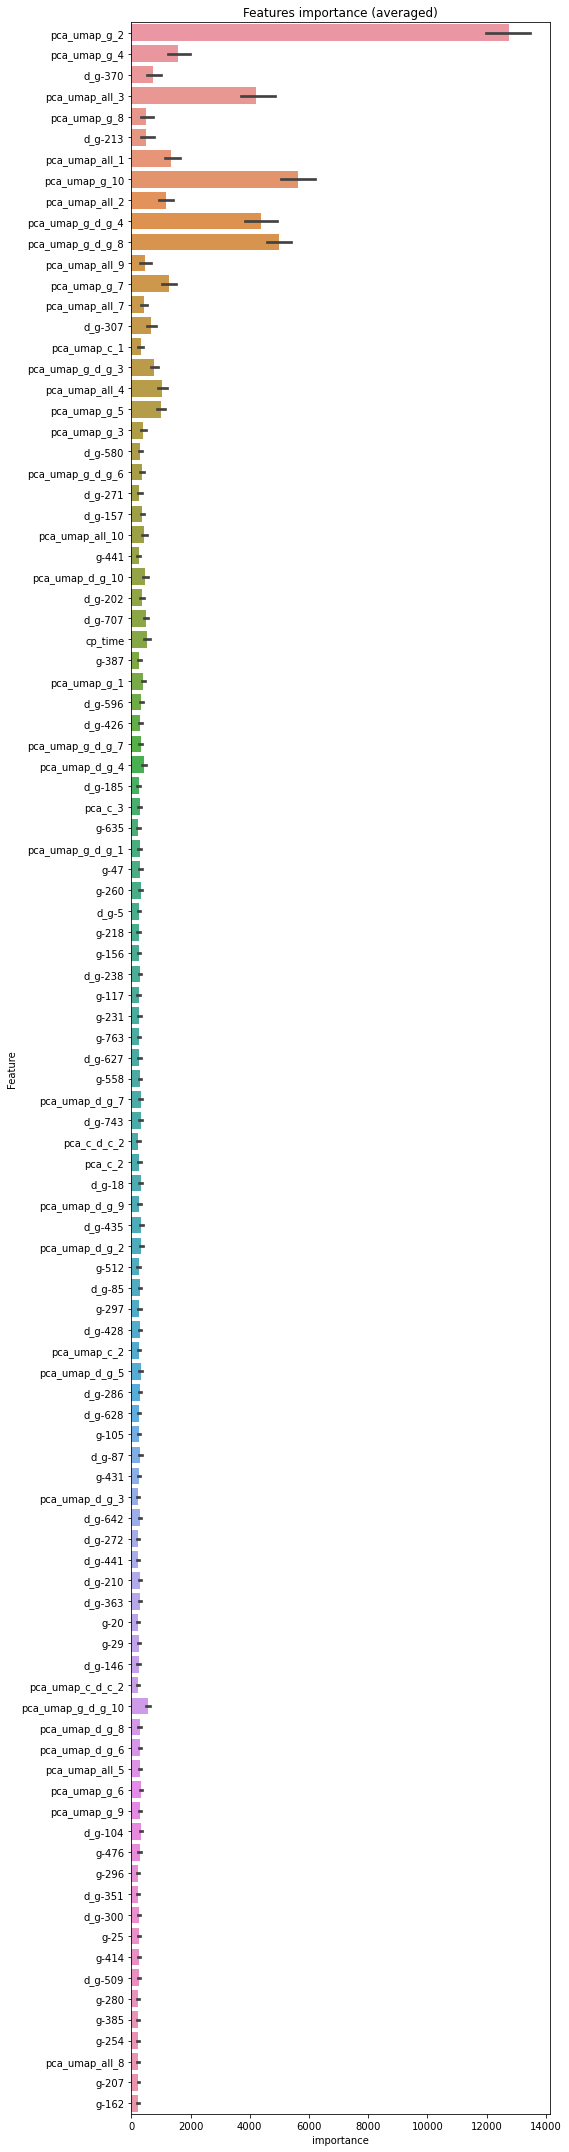

In [50]:
show_feature_importance(feature_importance_df)

In [51]:
feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)